/Users/mac/.pyenv/versions/3.11.5/lib/python3.11/site-packages/movingpandas/__init__.py:41: UserWarning: Missing optional dependencies. To use the trajectory smoother classes please install Stone Soup (see https://stonesoup.readthedocs.io/en/latest/#installation).
  warnings.warn(e.msg, UserWarning)


Loading GeoLife trajectory data and labels from subfolders...
Processing folder: ./Geolife Trajectories 1.3/data/104
Total files processed: 1
Total files processed: 2
Total files processed: 3
Total files processed: 4
Total files processed: 5
Total files processed: 6
Total files processed: 7
Total files processed: 8
Total files processed: 9
Total files processed: 10
Total files processed: 11
Total files processed: 12
Total files processed: 13
Total files processed: 14
Total files processed: 15
Total files processed: 16
Total files processed: 17
Total files processed: 18
Total files processed: 19
Total files processed: 20
Total files processed: 21
Total files processed: 22
Total files processed: 23
Total files processed: 24
Total files processed: 25
Total files processed: 26
Total files processed: 27
Total files processed: 28
Total files processed: 29
Total files processed: 30
Total files processed: 31
Total files processed: 32
Total files processed: 33
Total files processed: 34
Total fi

/var/folders/sl/r3dyv7l910q28kfxmr4rf6qr0000gn/T/ipykernel_56413/2594435772.py:96: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])


Total files processed: 3680
Total files processed: 3681
Total files processed: 3682
Total files processed: 3683
Total files processed: 3684
Total files processed: 3685
Total files processed: 3686
Total files processed: 3687
Total files processed: 3688
Total files processed: 3689
Total files processed: 3690
Total files processed: 3691
Total files processed: 3692
Total files processed: 3693
Total files processed: 3694
Total files processed: 3695
Total files processed: 3696
Total files processed: 3697
Total files processed: 3698
Total files processed: 3699
Total files processed: 3700
Total files processed: 3701
Total files processed: 3702
Total files processed: 3703
Total files processed: 3704
Total files processed: 3705
Total files processed: 3706
Total files processed: 3707
Total files processed: 3708
Total files processed: 3709
Total files processed: 3710
Total files processed: 3711
Total files processed: 3712
Total files processed: 3713
Total files processed: 3714
Total files processe

/Users/mac/.pyenv/versions/3.11.5/lib/python3.11/site-packages/scipy/signal/_signaltools.py:1563: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
/Users/mac/.pyenv/versions/3.11.5/lib/python3.11/site-packages/scipy/signal/_signaltools.py:1563: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Visualizing a sample trajectory...


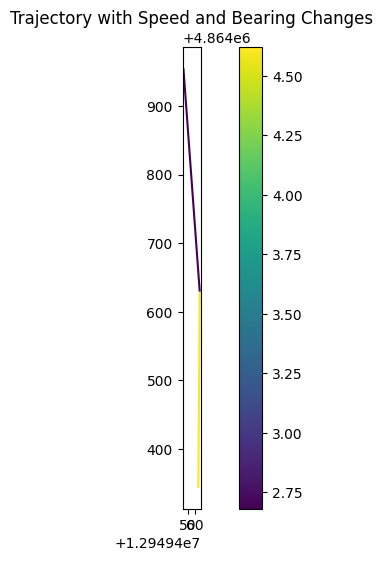

Saving enriched trajectories...


PermissionError: [Errno 1] Operation not permitted: './Cleaned_Trajectories/'

In [ ]:
import os
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
import numpy as np
from datetime import datetime, timedelta
from movingpandas import TrajectoryCollection, Trajectory
from shapely.geometry import Point
import matplotlib.pyplot as plt
import folium
import hvplot.pandas
import holoviews as hv
from scipy.signal import medfilt
hv.extension('bokeh')

# Function to compute bearing (direction in degrees)
def compute_bearing(lat1, lon1, lat2, lon2):
    dlon = np.radians(lon2 - lon1)
    lat1, lat2 = np.radians(lat1), np.radians(lat2)
    y = np.sin(dlon) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    return np.degrees(np.arctan2(y, x)) % 360

# Step 1: Load GeoLife trajectory data with all fields from a given folder.
def load_geolife_data(folder_path):
    """
    Load all GeoLife .plt files from the specified folder into a single DataFrame,
    including all relevant columns.
    """
    columns = ['lat', 'lon', 'zero', 'altitude', 'timestamp_days', 'date', 'time']
    all_data = []
    # Traverse through the folder and its subfolders
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.plt'):
                file_path = os.path.join(root, file)
                # Read the .plt file, skipping the header rows
                df = pd.read_csv(file_path, skiprows=6, header=None, names=columns)
                # Combine date and time into a single datetime column
                # df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
                df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S")
                # Keep track of the source folder and file name for later reference
                df['source_folder'] = os.path.basename(folder_path)
                df['file'] = file
                all_data.append(df)

    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        # Return an empty DataFrame with the expected columns if no files are found
        return pd.DataFrame(columns=columns + ['datetime', 'source_folder', 'file'])

# Step 2: Load GeoLife labels from the folder's own labels.txt file.
def load_labels(folder_path):
    """
    Load transportation mode labels from labels.txt in the specified folder and return a DataFrame.
    Each folder is assumed to have its own labels.txt that corresponds to the trajectories within it.
    """
    label_file = os.path.join(folder_path, "labels.txt")
    if not os.path.exists(label_file):
        print(f"No labels file found in folder: {folder_path}")
        return pd.DataFrame()
    
    labels = pd.read_csv(label_file, skiprows=1, sep='\t', 
                         names=['start_time', 'end_time', 'transport_mode'])
    labels['start_time'] = pd.to_datetime(labels['start_time'])
    labels['end_time'] = pd.to_datetime(labels['end_time'])
    return labels

# Step 3: Match trajectories with transportation labels.
def match_labels(df, labels):
    """
    Assign transportation modes to trajectory points based on timestamp matching.
    For each label, points whose 'datetime' fall between the label's start and end times
    are assigned the corresponding 'transport_mode'.
    """
    df['transport_mode'] = 'Unknown'
    for _, row in labels.iterrows():
        mask = (df['datetime'] >= row['start_time']) & (df['datetime'] <= row['end_time'])
        df.loc[mask, 'transport_mode'] = row['transport_mode']
    return df

# Optional helper: Process each subfolder under the main directory.
def load_geolife_data_with_labels(main_folder_path, max_files=200):
    all_data = []
    total_counter = 0
    for folder in os.listdir(main_folder_path):
        subfolder_path = os.path.join(main_folder_path, folder)
        if os.path.isdir(subfolder_path):
            print(f"Processing folder: {subfolder_path}")
            for root, _, files in os.walk(subfolder_path):
                for file in files:
                    if file.endswith('.plt'):
                        file_path = os.path.join(root, file)
                        df = pd.read_csv(file_path, skiprows=6, header=None, names=['lat', 'lon', 'zero', 'altitude', 'timestamp_days', 'date', 'time'])
                        df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
                        df['source_folder'] = os.path.basename(subfolder_path)
                        df['file'] = file

                        labels_df = load_labels(subfolder_path)
                        if not labels_df.empty:
                            df = match_labels(df, labels_df)
                        # print(df[['datetime']].head(10))
                        # print(df[['datetime']].tail(10))
                        all_data.append(df)

                        total_counter += 1
                        print(f"Total files processed: {total_counter}")

                        # if total_counter >= max_files:
                        #     print("Reached max file limit.")
                        #     return pd.concat(all_data, ignore_index=True)
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame()

# Step 4: Convert to GeoDataFrame and prepare for MovingPandas.
def convert_to_geodataframe(df):
    """
    Convert a DataFrame with lat/lon columns to a GeoDataFrame.
    Instead of setting datetime as the index (which may interfere with your time_diff calculations),
    add a new column that provides a sequential index starting at 1.
    """
    # Create a new sequential index column.
    df['new_index'] = np.arange(1, len(df) + 1)
    
    # Convert the DataFrame to a GeoDataFrame using the lat/lon columns.
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df['lon'], df['lat']), crs='EPSG:4326'
    )
    
    return gdf

# Step 5: Create TrajectoryCollection and clean/segment trajectories.
def create_trajectory_collection(gdf):
    """
    Create a TrajectoryCollection from the GeoDataFrame.
    """
    # Convert to a metric projection for accurate distance calculations.
    gdf = gdf.to_crs('EPSG:3857')
    # Specify the timestamp column by passing t='datetime'
    traj_collection = TrajectoryCollection(gdf, traj_id_col='file', t='datetime')
    return traj_collection

# Step 6: Save raw trajectories before cleaning.
def save_raw_trajectories_as_geojson(traj_collection, output_path):
    """
    Save the raw trajectories before cleaning as GeoJSON with original file names.
    """
    for i, traj in enumerate(traj_collection):
        file_name = traj.id.replace('.plt', '')  # Extract original file name
        traj.to_point_gdf().to_file(f"{output_path}/{file_name}_raw_trajectory_{i}.geojson", driver='GeoJSON')
    print(f"Saved {len(traj_collection)} raw trajectories to {output_path}")

# Helper to compute minimal angle difference
def minimal_angle_diff(diff):
    diff = abs(diff) % 360
    return diff if diff <= 180 else 360 - diff

# Step 7: Enrich and clean trajectories.
from scipy.signal import medfilt

# Helper to compute minimal angle difference
def minimal_angle_diff(diff):
    diff = abs(diff) % 360
    return diff if diff <= 180 else 360 - diff

def clean_and_enrich_trajectories(traj_collection):
    """Enrich trajectories and manually segment by time gap, applying fixes to reduce noise and handle units correctly."""
    enriched_trajectories = []

    for traj in traj_collection:
        # Compute speed, acceleration, and direction as before
        traj.add_speed(overwrite=True)
        traj.add_acceleration()
        traj.add_direction()

        # Convert trajectory to a GeoDataFrame
        df = traj.to_point_gdf()

        # Apply median filtering to smooth out noise in speed and acceleration
        if 'speed' in df.columns:
            df['speed'] = medfilt(df['speed'], kernel_size=3)
        if 'acceleration' in df.columns:
            df['acceleration'] = medfilt(df['acceleration'], kernel_size=3)

        # Compute the next coordinates for bearing calculation
        df['next_lat'] = df['lat'].shift(-1)
        df['next_lon'] = df['lon'].shift(-1)
        df['bearing'] = np.where(
            pd.notna(df['next_lat']),
            compute_bearing(df['lat'], df['lon'], df['next_lat'], df['next_lon']),
            np.nan
        )
        
        # Compute the minimal angle difference for bearing changes
        raw_diff = df['bearing'].diff().fillna(0)
        df['bearing_change'] = raw_diff.apply(minimal_angle_diff)
        
        # Segment trajectories based on observation gap (5 minutes = 300 seconds)
        df['time_diff'] = df.index.to_series().diff().dt.total_seconds().fillna(0)
        df['segment'] = (df['time_diff'] > 300).cumsum()

        # Process each segment that has more than one data point
        for segment_id, segment_df in df.groupby('segment'):
            if len(segment_df) > 1:
                segment_traj = Trajectory(segment_df, traj.id)
                enriched_trajectories.append(segment_traj)
    return enriched_trajectories

# Step 8: Visualize a sample trajectory.
def visualize_trajectory(traj):
    """Plot a sample trajectory with speed and bearing changes."""
    traj.plot(column='speed', legend=True, figsize=(10, 6))
    plt.title("Trajectory with Speed and Bearing Changes")
    plt.show()

# Step 9: Save enriched trajectories as GeoJSON for further use.
def save_trajectories_as_geojson(trajectories, output_path):
    """
    Save the list of enriched trajectories as GeoJSON files,
    including enriched features as individual columns.
    """
    for i, traj in enumerate(trajectories):
        file_name = traj.id.replace('.plt', '')
        gdf = traj.to_point_gdf()
        gdf.to_file(f"{output_path}/{file_name}_enriched_trajectory_{i}.geojson", driver='GeoJSON')
    print(f"Saved {len(trajectories)} enriched trajectories to {output_path}")

# Main execution
if __name__ == "__main__":
    # Set the main folder path containing subfolders (each with its own trajectories and labels.txt)
    main_folder = "./Geolife Trajectories 1.3/data"  # Replace with your actual GeoLife main data folder
    output_folder = "./Cleaned_Trajectories"         # Folder to save cleaned/enriched trajectories
    raw_output_folder = "./raw_Trajectories"           # Folder to save raw trajectories before cleaning
    
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(raw_output_folder, exist_ok=True)
    
    print("Loading GeoLife trajectory data and labels from subfolders...")
    df = load_geolife_data_with_labels(main_folder)
    
    if df.empty:
        print("No trajectory data found in the specified main folder.")
    else:
        print(f"Loaded {len(df)} trajectory points from all subfolders.")
        
        print("Converting to GeoDataFrame...")
        gdf = convert_to_geodataframe(df)
        
        print("Creating TrajectoryCollection...")
        traj_collection = create_trajectory_collection(gdf)
        
        print("Cleaning and enriching trajectories...")
        enriched_trajectories = clean_and_enrich_trajectories(traj_collection)
        
        if enriched_trajectories:
            print("Visualizing a sample trajectory...")
            visualize_trajectory(enriched_trajectories[0])
        else:
            print("No enriched trajectories to visualize.")
        
        # print("Saving raw trajectories before cleaning...")
        # save_raw_trajectories_as_geojson(traj_collection, raw_output_folder)
        
        # print("Saving enriched trajectories...")
        # save_trajectories_as_geojson(enriched_trajectories, output_folder)
        
        print("Processing complete.")


In [7]:
# Step 9: Save enriched trajectories as GeoJSON for further use.
def save_trajectories_as_geojson(trajectories, output_path):
    """
    Save the list of enriched trajectories as GeoJSON files,
    including enriched features as individual columns.
    """
    for i, traj in enumerate(trajectories):
        file_name = traj.id.replace('.plt', '')
        gdf = traj.to_point_gdf()
        gdf.to_file(f"{output_path}/{file_name}_enriched_trajectory_{i}.geojson", driver='GeoJSON')
    print(f"Saved {len(trajectories)} enriched trajectories to {output_path}")

print("Saving enriched trajectories...")
save_trajectories_as_geojson(enriched_trajectories, output_folder)

print("Processing complete.")

Saving enriched trajectories...


/Users/mac/.pyenv/versions/3.11.5/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: NaN of Infinity value found. Skipped
  ogr_write(
/Users/mac/.pyenv/versions/3.11.5/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Infinite or NaN coordinate encountered
  ogr_write(


Saved 25100 enriched trajectories to ./Cleaned_Trajectories
Processing complete.


In [9]:
import os
import geopandas as gpd
import shutil

def copy_non_unknown_files(source_directory, destination_directory):
    """
    Copy GeoJSON files from the source directory to the destination directory
    if they contain at least one transport_mode value that is not 'Unknown'.
    """
    # Create the destination directory if it doesn't exist.
    os.makedirs(destination_directory, exist_ok=True)
    
    for file in os.listdir(source_directory):
        if file.endswith('.geojson'):
            file_path = os.path.join(source_directory, file)
            try:
                gdf = gpd.read_file(file_path)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue

            if "transport_mode" in gdf.columns:
                unique_modes = gdf["transport_mode"].unique()
                # Check if not exclusively 'Unknown'
                if not (len(unique_modes) == 1 and unique_modes[0] == "Unknown"):
                    dest_path = os.path.join(destination_directory, file)
                    shutil.copy(file_path, dest_path)
                    print(f"Copied file: {file_path} to {dest_path}")
            else:
                print(f"File {file_path} does not have a 'transport_mode' column.")

# Define your source and destination folders
source_folder = "./Cleaned_Trajectories"      # Folder with cleaned trajectories
destination_folder = "./Filtered_Trajectories"  # New folder for valid files

# Copy files that don't contain only 'Unknown' in transport_mode
copy_non_unknown_files(source_folder, destination_folder)


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080714004835_enriched_trajectory_6334.geojson to ./Filtered_Trajectories/20080714004835_enriched_trajectory_6334.geojson
Copied file: ./Cleaned_Trajectories/20070502013107_enriched_trajectory_236.geojson to ./Filtered_Trajectories/20070502013107_enriched_trajectory_236.geojson
Copied file: ./Cleaned_Trajectories/20090427235529_enriched_trajectory_15387.geojson to ./Filtered_Trajectories/20090427235529_enriched_trajectory_15387.geojson
Copied file: ./Cleaned_Trajectories/20080816054408_enriched_trajectory_7729.geojson to ./Filtered_Trajectories/20080816054408_enriched_trajectory_7729.geojson
Copied file: ./Cleaned_Trajectories/20080918235405_enriched_trajectory_9358.geojson to ./Filtered_Trajectories/20080918235405_enriched_trajectory_9358.geojson
Copied file: ./Cleaned_Trajectories/20080520001337_enriched_trajectory_3974.geojson to ./Filtered_Trajectories/20080520001337_enriched_trajectory_3974.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080527074452_enriched_trajectory_4337.geojson to ./Filtered_Trajectories/20080527074452_enriched_trajectory_4337.geojson
Copied file: ./Cleaned_Trajectories/20080907070424_enriched_trajectory_8752.geojson to ./Filtered_Trajectories/20080907070424_enriched_trajectory_8752.geojson
Copied file: ./Cleaned_Trajectories/20080709212205_enriched_trajectory_6145.geojson to ./Filtered_Trajectories/20080709212205_enriched_trajectory_6145.geojson
Copied file: ./Cleaned_Trajectories/20070509102701_enriched_trajectory_306.geojson to ./Filtered_Trajectories/20070509102701_enriched_trajectory_306.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081014101324_enriched_trajectory_10684.geojson to ./Filtered_Trajectories/20081014101324_enriched_trajectory_10684.geojson
Copied file: ./Cleaned_Trajectories/20090405032328_enriched_trajectory_14941.geojson to ./Filtered_Trajectories/20090405032328_enriched_trajectory_14941.geojson
Copied file: ./Cleaned_Trajectories/20090221092622_enriched_trajectory_14038.geojson to ./Filtered_Trajectories/20090221092622_enriched_trajectory_14038.geojson
Copied file: ./Cleaned_Trajectories/20080916093612_enriched_trajectory_9230.geojson to ./Filtered_Trajectories/20080916093612_enriched_trajectory_9230.geojson
Copied file: ./Cleaned_Trajectories/20080810030221_enriched_trajectory_7346.geojson to ./Filtered_Trajectories/20080810030221_enriched_trajectory_7346.geojson
Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9853.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9853.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080927114213_enriched_trajectory_9740.geojson to ./Filtered_Trajectories/20080927114213_enriched_trajectory_9740.geojson
Copied file: ./Cleaned_Trajectories/20090712064105_enriched_trajectory_16796.geojson to ./Filtered_Trajectories/20090712064105_enriched_trajectory_16796.geojson
Copied file: ./Cleaned_Trajectories/20080602104053_enriched_trajectory_4642.geojson to ./Filtered_Trajectories/20080602104053_enriched_trajectory_4642.geojson
Copied file: ./Cleaned_Trajectories/20081002004646_enriched_trajectory_9997.geojson to ./Filtered_Trajectories/20081002004646_enriched_trajectory_9997.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080521101625_enriched_trajectory_4067.geojson to ./Filtered_Trajectories/20080521101625_enriched_trajectory_4067.geojson
Copied file: ./Cleaned_Trajectories/20080330160039_enriched_trajectory_2650.geojson to ./Filtered_Trajectories/20080330160039_enriched_trajectory_2650.geojson
Copied file: ./Cleaned_Trajectories/20080709212205_enriched_trajectory_6155.geojson to ./Filtered_Trajectories/20080709212205_enriched_trajectory_6155.geojson
Copied file: ./Cleaned_Trajectories/20081211083859_enriched_trajectory_13003.geojson to ./Filtered_Trajectories/20081211083859_enriched_trajectory_13003.geojson
Copied file: ./Cleaned_Trajectories/20071011011520_enriched_trajectory_1201.geojson to ./Filtered_Trajectories/20071011011520_enriched_trajectory_1201.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080616103503_enriched_trajectory_5204.geojson to ./Filtered_Trajectories/20080616103503_enriched_trajectory_5204.geojson
Copied file: ./Cleaned_Trajectories/20080616161439_enriched_trajectory_5207.geojson to ./Filtered_Trajectories/20080616161439_enriched_trajectory_5207.geojson
Copied file: ./Cleaned_Trajectories/20080628111927_enriched_trajectory_5703.geojson to ./Filtered_Trajectories/20080628111927_enriched_trajectory_5703.geojson
Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23281.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23281.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081019035219_enriched_trajectory_10952.geojson to ./Filtered_Trajectories/20081019035219_enriched_trajectory_10952.geojson
Copied file: ./Cleaned_Trajectories/20080813004435_enriched_trajectory_7425.geojson to ./Filtered_Trajectories/20080813004435_enriched_trajectory_7425.geojson
Copied file: ./Cleaned_Trajectories/20080517091804_enriched_trajectory_3874.geojson to ./Filtered_Trajectories/20080517091804_enriched_trajectory_3874.geojson
Copied file: ./Cleaned_Trajectories/20081206000403_enriched_trajectory_12822.geojson to ./Filtered_Trajectories/20081206000403_enriched_trajectory_12822.geojson
Copied file: ./Cleaned_Trajectories/20080922133035_enriched_trajectory_9494.geojson to ./Filtered_Trajectories/20080922133035_enriched_trajectory_9494.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080502222717_enriched_trajectory_3357.geojson to ./Filtered_Trajectories/20080502222717_enriched_trajectory_3357.geojson
Copied file: ./Cleaned_Trajectories/20110326003952_enriched_trajectory_22090.geojson to ./Filtered_Trajectories/20110326003952_enriched_trajectory_22090.geojson
Copied file: ./Cleaned_Trajectories/20080920034124_enriched_trajectory_9415.geojson to ./Filtered_Trajectories/20080920034124_enriched_trajectory_9415.geojson
Copied file: ./Cleaned_Trajectories/20080712123306_enriched_trajectory_6287.geojson to ./Filtered_Trajectories/20080712123306_enriched_trajectory_6287.geojson
Copied file: ./Cleaned_Trajectories/20090619001622_enriched_trajectory_16322.geojson to ./Filtered_Trajectories/20090619001622_enriched_trajectory_16322.geojson
Copied file: ./Cleaned_Trajectories/20081008035138_enriched_trajectory_10343.geojson to ./Filtered_Trajectories/20081008035138_enriched_trajectory_10343.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090317070034_enriched_trajectory_14465.geojson to ./Filtered_Trajectories/20090317070034_enriched_trajectory_14465.geojson
Copied file: ./Cleaned_Trajectories/20090526020334_enriched_trajectory_15913.geojson to ./Filtered_Trajectories/20090526020334_enriched_trajectory_15913.geojson
Copied file: ./Cleaned_Trajectories/20090912021805_enriched_trajectory_18316.geojson to ./Filtered_Trajectories/20090912021805_enriched_trajectory_18316.geojson
Copied file: ./Cleaned_Trajectories/20090602110558_enriched_trajectory_16051.geojson to ./Filtered_Trajectories/20090602110558_enriched_trajectory_16051.geojson
Copied file: ./Cleaned_Trajectories/20090815062008_enriched_trajectory_17710.geojson to ./Filtered_Trajectories/20090815062008_enriched_trajectory_17710.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081116093710_enriched_trajectory_12276.geojson to ./Filtered_Trajectories/20081116093710_enriched_trajectory_12276.geojson
Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23291.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23291.geojson
Copied file: ./Cleaned_Trajectories/20090703012649_enriched_trajectory_16563.geojson to ./Filtered_Trajectories/20090703012649_enriched_trajectory_16563.geojson
Copied file: ./Cleaned_Trajectories/20080929001429_enriched_trajectory_9827.geojson to ./Filtered_Trajectories/20080929001429_enriched_trajectory_9827.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090810183104_enriched_trajectory_17606.geojson to ./Filtered_Trajectories/20090810183104_enriched_trajectory_17606.geojson
Copied file: ./Cleaned_Trajectories/20090602001024_enriched_trajectory_16046.geojson to ./Filtered_Trajectories/20090602001024_enriched_trajectory_16046.geojson
Copied file: ./Cleaned_Trajectories/20081012224836_enriched_trajectory_10603.geojson to ./Filtered_Trajectories/20081012224836_enriched_trajectory_10603.geojson
Copied file: ./Cleaned_Trajectories/20090625070529_enriched_trajectory_16436.geojson to ./Filtered_Trajectories/20090625070529_enriched_trajectory_16436.geojson
Copied file: ./Cleaned_Trajectories/20081108012003_enriched_trajectory_11864.geojson to ./Filtered_Trajectories/20081108012003_enriched_trajectory_11864.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081009224923_enriched_trajectory_10425.geojson to ./Filtered_Trajectories/20081009224923_enriched_trajectory_10425.geojson
Copied file: ./Cleaned_Trajectories/20080311015809_enriched_trajectory_2457.geojson to ./Filtered_Trajectories/20080311015809_enriched_trajectory_2457.geojson
Copied file: ./Cleaned_Trajectories/20090910233334_enriched_trajectory_18264.geojson to ./Filtered_Trajectories/20090910233334_enriched_trajectory_18264.geojson
Copied file: ./Cleaned_Trajectories/20080509081231_enriched_trajectory_3575.geojson to ./Filtered_Trajectories/20080509081231_enriched_trajectory_3575.geojson
Copied file: ./Cleaned_Trajectories/20080906043335_enriched_trajectory_8708.geojson to ./Filtered_Trajectories/20080906043335_enriched_trajectory_8708.geojson
Copied file: ./Cleaned_Trajectories/20070905090158_enriched_trajectory_963.geojson to ./Filtered_Trajectories/20070905090158_enriched_trajectory_963.geojson
Copied file: ./Cleaned_Trajectories/20080415

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090818101222_enriched_trajectory_17753.geojson to ./Filtered_Trajectories/20090818101222_enriched_trajectory_17753.geojson
Copied file: ./Cleaned_Trajectories/20070608232055_enriched_trajectory_613.geojson to ./Filtered_Trajectories/20070608232055_enriched_trajectory_613.geojson
Copied file: ./Cleaned_Trajectories/20080807045805_enriched_trajectory_7241.geojson to ./Filtered_Trajectories/20080807045805_enriched_trajectory_7241.geojson
Copied file: ./Cleaned_Trajectories/20111024014825_enriched_trajectory_23704.geojson to ./Filtered_Trajectories/20111024014825_enriched_trajectory_23704.geojson
Copied file: ./Cleaned_Trajectories/20090701002752_enriched_trajectory_16527.geojson to ./Filtered_Trajectories/20090701002752_enriched_trajectory_16527.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081027000929_enriched_trajectory_11228.geojson to ./Filtered_Trajectories/20081027000929_enriched_trajectory_11228.geojson
Copied file: ./Cleaned_Trajectories/20080820023130_enriched_trajectory_7895.geojson to ./Filtered_Trajectories/20080820023130_enriched_trajectory_7895.geojson
Copied file: ./Cleaned_Trajectories/20080504003704_enriched_trajectory_3403.geojson to ./Filtered_Trajectories/20080504003704_enriched_trajectory_3403.geojson
Copied file: ./Cleaned_Trajectories/20070421005859_enriched_trajectory_120.geojson to ./Filtered_Trajectories/20070421005859_enriched_trajectory_120.geojson
Copied file: ./Cleaned_Trajectories/20081214021352_enriched_trajectory_13085.geojson to ./Filtered_Trajectories/20081214021352_enriched_trajectory_13085.geojson
Copied file: ./Cleaned_Trajectories/20090428102353_enriched_trajectory_15404.geojson to ./Filtered_Trajectories/20090428102353_enriched_trajectory_15404.geojson
Copied file: ./Cleaned_Trajectories/200811

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090809094405_enriched_trajectory_17585.geojson to ./Filtered_Trajectories/20090809094405_enriched_trajectory_17585.geojson
Copied file: ./Cleaned_Trajectories/20090103054326_enriched_trajectory_13411.geojson to ./Filtered_Trajectories/20090103054326_enriched_trajectory_13411.geojson
Copied file: ./Cleaned_Trajectories/20081028020035_enriched_trajectory_11292.geojson to ./Filtered_Trajectories/20081028020035_enriched_trajectory_11292.geojson
Copied file: ./Cleaned_Trajectories/20080526105420_enriched_trajectory_4301.geojson to ./Filtered_Trajectories/20080526105420_enriched_trajectory_4301.geojson
Copied file: ./Cleaned_Trajectories/20080428183304_enriched_trajectory_3097.geojson to ./Filtered_Trajectories/20080428183304_enriched_trajectory_3097.geojson
Copied file: ./Cleaned_Trajectories/20080806105700_enriched_trajectory_7204.geojson to ./Filtered_Trajectories/20080806105700_enriched_trajectory_7204.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111020213601_enriched_trajectory_23659.geojson to ./Filtered_Trajectories/20111020213601_enriched_trajectory_23659.geojson
Copied file: ./Cleaned_Trajectories/20080506050533_enriched_trajectory_3477.geojson to ./Filtered_Trajectories/20080506050533_enriched_trajectory_3477.geojson
Copied file: ./Cleaned_Trajectories/20070419002322_enriched_trajectory_79.geojson to ./Filtered_Trajectories/20070419002322_enriched_trajectory_79.geojson
Copied file: ./Cleaned_Trajectories/20080430090353_enriched_trajectory_3155.geojson to ./Filtered_Trajectories/20080430090353_enriched_trajectory_3155.geojson
Copied file: ./Cleaned_Trajectories/20081122093658_enriched_trajectory_12373.geojson to ./Filtered_Trajectories/20081122093658_enriched_trajectory_12373.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080927045936_enriched_trajectory_9727.geojson to ./Filtered_Trajectories/20080927045936_enriched_trajectory_9727.geojson
Copied file: ./Cleaned_Trajectories/20090513235559_enriched_trajectory_15690.geojson to ./Filtered_Trajectories/20090513235559_enriched_trajectory_15690.geojson
Copied file: ./Cleaned_Trajectories/20080503102734_enriched_trajectory_3386.geojson to ./Filtered_Trajectories/20080503102734_enriched_trajectory_3386.geojson
Copied file: ./Cleaned_Trajectories/20090402064028_enriched_trajectory_14851.geojson to ./Filtered_Trajectories/20090402064028_enriched_trajectory_14851.geojson
Copied file: ./Cleaned_Trajectories/20070610094624_enriched_trajectory_614.geojson to ./Filtered_Trajectories/20070610094624_enriched_trajectory_614.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080627103629_enriched_trajectory_5664.geojson to ./Filtered_Trajectories/20080627103629_enriched_trajectory_5664.geojson
Copied file: ./Cleaned_Trajectories/20080811033034_enriched_trajectory_7359.geojson to ./Filtered_Trajectories/20080811033034_enriched_trajectory_7359.geojson
Copied file: ./Cleaned_Trajectories/20080628100846_enriched_trajectory_5699.geojson to ./Filtered_Trajectories/20080628100846_enriched_trajectory_5699.geojson
Copied file: ./Cleaned_Trajectories/20080608020604_enriched_trajectory_4930.geojson to ./Filtered_Trajectories/20080608020604_enriched_trajectory_4930.geojson
Copied file: ./Cleaned_Trajectories/20070506111748_enriched_trajectory_292.geojson to ./Filtered_Trajectories/20070506111748_enriched_trajectory_292.geojson
Copied file: ./Cleaned_Trajectories/20080908223454_enriched_trajectory_8818.geojson to ./Filtered_Trajectories/20080908223454_enriched_trajectory_8818.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080515015304_enriched_trajectory_3780.geojson to ./Filtered_Trajectories/20080515015304_enriched_trajectory_3780.geojson
Copied file: ./Cleaned_Trajectories/20080908052715_enriched_trajectory_8798.geojson to ./Filtered_Trajectories/20080908052715_enriched_trajectory_8798.geojson
Copied file: ./Cleaned_Trajectories/20081109071903_enriched_trajectory_11956.geojson to ./Filtered_Trajectories/20081109071903_enriched_trajectory_11956.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081207092914_enriched_trajectory_12883.geojson to ./Filtered_Trajectories/20081207092914_enriched_trajectory_12883.geojson
Copied file: ./Cleaned_Trajectories/20081102022639_enriched_trajectory_11533.geojson to ./Filtered_Trajectories/20081102022639_enriched_trajectory_11533.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_172.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_172.geojson
Copied file: ./Cleaned_Trajectories/20080518025319_enriched_trajectory_3905.geojson to ./Filtered_Trajectories/20080518025319_enriched_trajectory_3905.geojson
Copied file: ./Cleaned_Trajectories/20070424010412_enriched_trajectory_150.geojson to ./Filtered_Trajectories/20070424010412_enriched_trajectory_150.geojson
Copied file: ./Cleaned_Trajectories/20080821104940_enriched_trajectory_7952.geojson to ./Filtered_Trajectories/20080821104940_enriched_trajectory_7952.geojson
Copied file: ./Cleaned_Trajectories/2008121001

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081030100711_enriched_trajectory_11396.geojson to ./Filtered_Trajectories/20081030100711_enriched_trajectory_11396.geojson
Copied file: ./Cleaned_Trajectories/20071018150939_enriched_trajectory_1231.geojson to ./Filtered_Trajectories/20071018150939_enriched_trajectory_1231.geojson
Copied file: ./Cleaned_Trajectories/20080524003039_enriched_trajectory_4170.geojson to ./Filtered_Trajectories/20080524003039_enriched_trajectory_4170.geojson
Copied file: ./Cleaned_Trajectories/20090823005552_enriched_trajectory_17838.geojson to ./Filtered_Trajectories/20090823005552_enriched_trajectory_17838.geojson
Copied file: ./Cleaned_Trajectories/20080929084930_enriched_trajectory_9845.geojson to ./Filtered_Trajectories/20080929084930_enriched_trajectory_9845.geojson
Copied file: ./Cleaned_Trajectories/20110319002834_enriched_trajectory_22030.geojson to ./Filtered_Trajectories/20110319002834_enriched_trajectory_22030.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080618003409_enriched_trajectory_5233.geojson to ./Filtered_Trajectories/20080618003409_enriched_trajectory_5233.geojson
Copied file: ./Cleaned_Trajectories/20081014033854_enriched_trajectory_10677.geojson to ./Filtered_Trajectories/20081014033854_enriched_trajectory_10677.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080403160000_enriched_trajectory_2708.geojson to ./Filtered_Trajectories/20080403160000_enriched_trajectory_2708.geojson
Copied file: ./Cleaned_Trajectories/20080729124748_enriched_trajectory_6982.geojson to ./Filtered_Trajectories/20080729124748_enriched_trajectory_6982.geojson
Copied file: ./Cleaned_Trajectories/20081008101324_enriched_trajectory_10362.geojson to ./Filtered_Trajectories/20081008101324_enriched_trajectory_10362.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081017102854_enriched_trajectory_10850.geojson to ./Filtered_Trajectories/20081017102854_enriched_trajectory_10850.geojson
Copied file: ./Cleaned_Trajectories/20080804021427_enriched_trajectory_7160.geojson to ./Filtered_Trajectories/20080804021427_enriched_trajectory_7160.geojson
Copied file: ./Cleaned_Trajectories/20080818103359_enriched_trajectory_7822.geojson to ./Filtered_Trajectories/20080818103359_enriched_trajectory_7822.geojson
Copied file: ./Cleaned_Trajectories/20111125152106_enriched_trajectory_23956.geojson to ./Filtered_Trajectories/20111125152106_enriched_trajectory_23956.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081102030158_enriched_trajectory_11542.geojson to ./Filtered_Trajectories/20081102030158_enriched_trajectory_11542.geojson
Copied file: ./Cleaned_Trajectories/20081010014337_enriched_trajectory_10442.geojson to ./Filtered_Trajectories/20081010014337_enriched_trajectory_10442.geojson
Copied file: ./Cleaned_Trajectories/20090520000834_enriched_trajectory_15816.geojson to ./Filtered_Trajectories/20090520000834_enriched_trajectory_15816.geojson
Copied file: ./Cleaned_Trajectories/20071123001431_enriched_trajectory_1381.geojson to ./Filtered_Trajectories/20071123001431_enriched_trajectory_1381.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081125032936_enriched_trajectory_12415.geojson to ./Filtered_Trajectories/20081125032936_enriched_trajectory_12415.geojson
Copied file: ./Cleaned_Trajectories/20110916005621_enriched_trajectory_23346.geojson to ./Filtered_Trajectories/20110916005621_enriched_trajectory_23346.geojson
Copied file: ./Cleaned_Trajectories/20090416234405_enriched_trajectory_15142.geojson to ./Filtered_Trajectories/20090416234405_enriched_trajectory_15142.geojson
Copied file: ./Cleaned_Trajectories/20080618121033_enriched_trajectory_5253.geojson to ./Filtered_Trajectories/20080618121033_enriched_trajectory_5253.geojson
Copied file: ./Cleaned_Trajectories/20080521032224_enriched_trajectory_4036.geojson to ./Filtered_Trajectories/20080521032224_enriched_trajectory_4036.geojson
Copied file: ./Cleaned_Trajectories/20090416133854_enriched_trajectory_15137.geojson to ./Filtered_Trajectories/20090416133854_enriched_trajectory_15137.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111010104611_enriched_trajectory_23573.geojson to ./Filtered_Trajectories/20111010104611_enriched_trajectory_23573.geojson
Copied file: ./Cleaned_Trajectories/20090427094711_enriched_trajectory_15381.geojson to ./Filtered_Trajectories/20090427094711_enriched_trajectory_15381.geojson
Copied file: ./Cleaned_Trajectories/20080709040859_enriched_trajectory_6131.geojson to ./Filtered_Trajectories/20080709040859_enriched_trajectory_6131.geojson
Copied file: ./Cleaned_Trajectories/20081106231922_enriched_trajectory_11836.geojson to ./Filtered_Trajectories/20081106231922_enriched_trajectory_11836.geojson
Copied file: ./Cleaned_Trajectories/20090601104552_enriched_trajectory_16039.geojson to ./Filtered_Trajectories/20090601104552_enriched_trajectory_16039.geojson
Copied file: ./Cleaned_Trajectories/20080820024708_enriched_trajectory_7906.geojson to ./Filtered_Trajectories/20080820024708_enriched_trajectory_7906.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080913053941_enriched_trajectory_9036.geojson to ./Filtered_Trajectories/20080913053941_enriched_trajectory_9036.geojson
Copied file: ./Cleaned_Trajectories/20090313064228_enriched_trajectory_14393.geojson to ./Filtered_Trajectories/20090313064228_enriched_trajectory_14393.geojson
Copied file: ./Cleaned_Trajectories/20070504235730_enriched_trajectory_257.geojson to ./Filtered_Trajectories/20070504235730_enriched_trajectory_257.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080917101511_enriched_trajectory_9283.geojson to ./Filtered_Trajectories/20080917101511_enriched_trajectory_9283.geojson
Copied file: ./Cleaned_Trajectories/20080414102228_enriched_trajectory_2870.geojson to ./Filtered_Trajectories/20080414102228_enriched_trajectory_2870.geojson
Copied file: ./Cleaned_Trajectories/20081010103335_enriched_trajectory_10456.geojson to ./Filtered_Trajectories/20081010103335_enriched_trajectory_10456.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080511052653_enriched_trajectory_3663.geojson to ./Filtered_Trajectories/20080511052653_enriched_trajectory_3663.geojson
Copied file: ./Cleaned_Trajectories/20081105012259_enriched_trajectory_11674.geojson to ./Filtered_Trajectories/20081105012259_enriched_trajectory_11674.geojson
Copied file: ./Cleaned_Trajectories/20080810013852_enriched_trajectory_7345.geojson to ./Filtered_Trajectories/20080810013852_enriched_trajectory_7345.geojson
Copied file: ./Cleaned_Trajectories/20070701063911_enriched_trajectory_761.geojson to ./Filtered_Trajectories/20070701063911_enriched_trajectory_761.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080501070620_enriched_trajectory_3219.geojson to ./Filtered_Trajectories/20080501070620_enriched_trajectory_3219.geojson
Copied file: ./Cleaned_Trajectories/20081202233433_enriched_trajectory_12675.geojson to ./Filtered_Trajectories/20081202233433_enriched_trajectory_12675.geojson
Copied file: ./Cleaned_Trajectories/20111111153907_enriched_trajectory_23875.geojson to ./Filtered_Trajectories/20111111153907_enriched_trajectory_23875.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_204.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_204.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070615005342_enriched_trajectory_648.geojson to ./Filtered_Trajectories/20070615005342_enriched_trajectory_648.geojson
Copied file: ./Cleaned_Trajectories/20070420121957_enriched_trajectory_107.geojson to ./Filtered_Trajectories/20070420121957_enriched_trajectory_107.geojson
Copied file: ./Cleaned_Trajectories/20071115003630_enriched_trajectory_1354.geojson to ./Filtered_Trajectories/20071115003630_enriched_trajectory_1354.geojson
Copied file: ./Cleaned_Trajectories/20101203000104_enriched_trajectory_21376.geojson to ./Filtered_Trajectories/20101203000104_enriched_trajectory_21376.geojson
Copied file: ./Cleaned_Trajectories/20081108042637_enriched_trajectory_11883.geojson to ./Filtered_Trajectories/20081108042637_enriched_trajectory_11883.geojson
Copied file: ./Cleaned_Trajectories/20090107014146_enriched_trajectory_13466.geojson to ./Filtered_Trajectories/20090107014146_enriched_trajectory_13466.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110904034809_enriched_trajectory_23219.geojson to ./Filtered_Trajectories/20110904034809_enriched_trajectory_23219.geojson
Copied file: ./Cleaned_Trajectories/20110901111021_enriched_trajectory_23160.geojson to ./Filtered_Trajectories/20110901111021_enriched_trajectory_23160.geojson
Copied file: ./Cleaned_Trajectories/20080516130506_enriched_trajectory_3825.geojson to ./Filtered_Trajectories/20080516130506_enriched_trajectory_3825.geojson
Copied file: ./Cleaned_Trajectories/20081128115427_enriched_trajectory_12532.geojson to ./Filtered_Trajectories/20081128115427_enriched_trajectory_12532.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080716074220_enriched_trajectory_6403.geojson to ./Filtered_Trajectories/20080716074220_enriched_trajectory_6403.geojson
Copied file: ./Cleaned_Trajectories/20081027235405_enriched_trajectory_11277.geojson to ./Filtered_Trajectories/20081027235405_enriched_trajectory_11277.geojson
Copied file: ./Cleaned_Trajectories/20110828043907_enriched_trajectory_23075.geojson to ./Filtered_Trajectories/20110828043907_enriched_trajectory_23075.geojson
Copied file: ./Cleaned_Trajectories/20080822083047_enriched_trajectory_7986.geojson to ./Filtered_Trajectories/20080822083047_enriched_trajectory_7986.geojson
Copied file: ./Cleaned_Trajectories/20080918045334_enriched_trajectory_9325.geojson to ./Filtered_Trajectories/20080918045334_enriched_trajectory_9325.geojson
Copied file: ./Cleaned_Trajectories/20071005052724_enriched_trajectory_1096.geojson to ./Filtered_Trajectories/20071005052724_enriched_trajectory_1096.geojson
Copied file: ./Cleaned_Trajectories/200908

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080908005352_enriched_trajectory_8790.geojson to ./Filtered_Trajectories/20080908005352_enriched_trajectory_8790.geojson
Copied file: ./Cleaned_Trajectories/20080802105441_enriched_trajectory_7112.geojson to ./Filtered_Trajectories/20080802105441_enriched_trajectory_7112.geojson
Copied file: ./Cleaned_Trajectories/20081111090528_enriched_trajectory_12055.geojson to ./Filtered_Trajectories/20081111090528_enriched_trajectory_12055.geojson
Copied file: ./Cleaned_Trajectories/20081022054124_enriched_trajectory_11094.geojson to ./Filtered_Trajectories/20081022054124_enriched_trajectory_11094.geojson
Copied file: ./Cleaned_Trajectories/20080724162541_enriched_trajectory_6817.geojson to ./Filtered_Trajectories/20080724162541_enriched_trajectory_6817.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081104101454_enriched_trajectory_11650.geojson to ./Filtered_Trajectories/20081104101454_enriched_trajectory_11650.geojson
Copied file: ./Cleaned_Trajectories/20090524011953_enriched_trajectory_15877.geojson to ./Filtered_Trajectories/20090524011953_enriched_trajectory_15877.geojson
Copied file: ./Cleaned_Trajectories/20080515140806_enriched_trajectory_3793.geojson to ./Filtered_Trajectories/20080515140806_enriched_trajectory_3793.geojson
Copied file: ./Cleaned_Trajectories/20080901000605_enriched_trajectory_8510.geojson to ./Filtered_Trajectories/20080901000605_enriched_trajectory_8510.geojson
Copied file: ./Cleaned_Trajectories/20080528092754_enriched_trajectory_4374.geojson to ./Filtered_Trajectories/20080528092754_enriched_trajectory_4374.geojson
Copied file: ./Cleaned_Trajectories/20080731011835_enriched_trajectory_7035.geojson to ./Filtered_Trajectories/20080731011835_enriched_trajectory_7035.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090406003943_enriched_trajectory_14957.geojson to ./Filtered_Trajectories/20090406003943_enriched_trajectory_14957.geojson
Copied file: ./Cleaned_Trajectories/20080922232608_enriched_trajectory_9497.geojson to ./Filtered_Trajectories/20080922232608_enriched_trajectory_9497.geojson
Copied file: ./Cleaned_Trajectories/20090222040348_enriched_trajectory_14045.geojson to ./Filtered_Trajectories/20090222040348_enriched_trajectory_14045.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070503005908_enriched_trajectory_242.geojson to ./Filtered_Trajectories/20070503005908_enriched_trajectory_242.geojson
Copied file: ./Cleaned_Trajectories/20080521084841_enriched_trajectory_4044.geojson to ./Filtered_Trajectories/20080521084841_enriched_trajectory_4044.geojson
Copied file: ./Cleaned_Trajectories/20070715021558_enriched_trajectory_815.geojson to ./Filtered_Trajectories/20070715021558_enriched_trajectory_815.geojson
Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5298.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5298.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081005095409_enriched_trajectory_10228.geojson to ./Filtered_Trajectories/20081005095409_enriched_trajectory_10228.geojson
Copied file: ./Cleaned_Trajectories/20081111122847_enriched_trajectory_12062.geojson to ./Filtered_Trajectories/20081111122847_enriched_trajectory_12062.geojson
Copied file: ./Cleaned_Trajectories/20071008015645_enriched_trajectory_1122.geojson to ./Filtered_Trajectories/20071008015645_enriched_trajectory_1122.geojson
Copied file: ./Cleaned_Trajectories/20081110130839_enriched_trajectory_12023.geojson to ./Filtered_Trajectories/20081110130839_enriched_trajectory_12023.geojson
Copied file: ./Cleaned_Trajectories/20090331021558_enriched_trajectory_14812.geojson to ./Filtered_Trajectories/20090331021558_enriched_trajectory_14812.geojson
Copied file: ./Cleaned_Trajectories/20090806224424_enriched_trajectory_17505.geojson to ./Filtered_Trajectories/20090806224424_enriched_trajectory_17505.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081006234930_enriched_trajectory_10300.geojson to ./Filtered_Trajectories/20081006234930_enriched_trajectory_10300.geojson
Copied file: ./Cleaned_Trajectories/20080626204306_enriched_trajectory_5644.geojson to ./Filtered_Trajectories/20080626204306_enriched_trajectory_5644.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110827061301_enriched_trajectory_23051.geojson to ./Filtered_Trajectories/20110827061301_enriched_trajectory_23051.geojson
Copied file: ./Cleaned_Trajectories/20080722103239_enriched_trajectory_6702.geojson to ./Filtered_Trajectories/20080722103239_enriched_trajectory_6702.geojson
Copied file: ./Cleaned_Trajectories/20080523014153_enriched_trajectory_4136.geojson to ./Filtered_Trajectories/20080523014153_enriched_trajectory_4136.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080901121903_enriched_trajectory_8544.geojson to ./Filtered_Trajectories/20080901121903_enriched_trajectory_8544.geojson
Copied file: ./Cleaned_Trajectories/20090107235929_enriched_trajectory_13476.geojson to ./Filtered_Trajectories/20090107235929_enriched_trajectory_13476.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090731022320_enriched_trajectory_17370.geojson to ./Filtered_Trajectories/20090731022320_enriched_trajectory_17370.geojson
Copied file: ./Cleaned_Trajectories/20071008015645_enriched_trajectory_1132.geojson to ./Filtered_Trajectories/20071008015645_enriched_trajectory_1132.geojson
Copied file: ./Cleaned_Trajectories/20081104112506_enriched_trajectory_11661.geojson to ./Filtered_Trajectories/20081104112506_enriched_trajectory_11661.geojson
Copied file: ./Cleaned_Trajectories/20070716231511_enriched_trajectory_824.geojson to ./Filtered_Trajectories/20070716231511_enriched_trajectory_824.geojson
Copied file: ./Cleaned_Trajectories/20070617002909_enriched_trajectory_669.geojson to ./Filtered_Trajectories/20070617002909_enriched_trajectory_669.geojson
Copied file: ./Cleaned_Trajectories/20110902010833_enriched_trajectory_23163.geojson to ./Filtered_Trajectories/20110902010833_enriched_trajectory_23163.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081201163736_enriched_trajectory_12644.geojson to ./Filtered_Trajectories/20081201163736_enriched_trajectory_12644.geojson
Copied file: ./Cleaned_Trajectories/20090911233728_enriched_trajectory_18310.geojson to ./Filtered_Trajectories/20090911233728_enriched_trajectory_18310.geojson
Copied file: ./Cleaned_Trajectories/20070624010215_enriched_trajectory_717.geojson to ./Filtered_Trajectories/20070624010215_enriched_trajectory_717.geojson
Copied file: ./Cleaned_Trajectories/20080711015836_enriched_trajectory_6222.geojson to ./Filtered_Trajectories/20080711015836_enriched_trajectory_6222.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070627113723_enriched_trajectory_741.geojson to ./Filtered_Trajectories/20070627113723_enriched_trajectory_741.geojson
Copied file: ./Cleaned_Trajectories/20090506134245_enriched_trajectory_15595.geojson to ./Filtered_Trajectories/20090506134245_enriched_trajectory_15595.geojson
Copied file: ./Cleaned_Trajectories/20090730024623_enriched_trajectory_17357.geojson to ./Filtered_Trajectories/20090730024623_enriched_trajectory_17357.geojson
Copied file: ./Cleaned_Trajectories/20081101015053_enriched_trajectory_11485.geojson to ./Filtered_Trajectories/20081101015053_enriched_trajectory_11485.geojson
Copied file: ./Cleaned_Trajectories/20071129095918_enriched_trajectory_1434.geojson to ./Filtered_Trajectories/20071129095918_enriched_trajectory_1434.geojson
Copied file: ./Cleaned_Trajectories/20080917111113_enriched_trajectory_9289.geojson to ./Filtered_Trajectories/20080917111113_enriched_trajectory_9289.geojson
Copied file: ./Cleaned_Trajectories/200811

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080512103631_enriched_trajectory_3718.geojson to ./Filtered_Trajectories/20080512103631_enriched_trajectory_3718.geojson
Copied file: ./Cleaned_Trajectories/20070713101051_enriched_trajectory_809.geojson to ./Filtered_Trajectories/20070713101051_enriched_trajectory_809.geojson
Copied file: ./Cleaned_Trajectories/20080801073154_enriched_trajectory_7084.geojson to ./Filtered_Trajectories/20080801073154_enriched_trajectory_7084.geojson
Copied file: ./Cleaned_Trajectories/20071003230234_enriched_trajectory_1086.geojson to ./Filtered_Trajectories/20071003230234_enriched_trajectory_1086.geojson
Copied file: ./Cleaned_Trajectories/20070419094442_enriched_trajectory_86.geojson to ./Filtered_Trajectories/20070419094442_enriched_trajectory_86.geojson
Copied file: ./Cleaned_Trajectories/20080811093700_enriched_trajectory_7374.geojson to ./Filtered_Trajectories/20080811093700_enriched_trajectory_7374.geojson
Copied file: ./Cleaned_Trajectories/20080825063405_e

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081018120606_enriched_trajectory_10911.geojson to ./Filtered_Trajectories/20081018120606_enriched_trajectory_10911.geojson
Copied file: ./Cleaned_Trajectories/20090706234533_enriched_trajectory_16690.geojson to ./Filtered_Trajectories/20090706234533_enriched_trajectory_16690.geojson
Copied file: ./Cleaned_Trajectories/20090106000021_enriched_trajectory_13454.geojson to ./Filtered_Trajectories/20090106000021_enriched_trajectory_13454.geojson
Copied file: ./Cleaned_Trajectories/20090817104629_enriched_trajectory_17734.geojson to ./Filtered_Trajectories/20090817104629_enriched_trajectory_17734.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081020030154_enriched_trajectory_11005.geojson to ./Filtered_Trajectories/20081020030154_enriched_trajectory_11005.geojson
Copied file: ./Cleaned_Trajectories/20090412031423_enriched_trajectory_15083.geojson to ./Filtered_Trajectories/20090412031423_enriched_trajectory_15083.geojson
Copied file: ./Cleaned_Trajectories/20090328005635_enriched_trajectory_14750.geojson to ./Filtered_Trajectories/20090328005635_enriched_trajectory_14750.geojson
Copied file: ./Cleaned_Trajectories/20071003020122_enriched_trajectory_1070.geojson to ./Filtered_Trajectories/20071003020122_enriched_trajectory_1070.geojson
Copied file: ./Cleaned_Trajectories/20080618103413_enriched_trajectory_5247.geojson to ./Filtered_Trajectories/20080618103413_enriched_trajectory_5247.geojson
Copied file: ./Cleaned_Trajectories/20080524014822_enriched_trajectory_4195.geojson to ./Filtered_Trajectories/20080524014822_enriched_trajectory_4195.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081021013516_enriched_trajectory_11057.geojson to ./Filtered_Trajectories/20081021013516_enriched_trajectory_11057.geojson
Copied file: ./Cleaned_Trajectories/20080717105553_enriched_trajectory_6453.geojson to ./Filtered_Trajectories/20080717105553_enriched_trajectory_6453.geojson
Copied file: ./Cleaned_Trajectories/20080516005100_enriched_trajectory_3796.geojson to ./Filtered_Trajectories/20080516005100_enriched_trajectory_3796.geojson
Copied file: ./Cleaned_Trajectories/20080924113459_enriched_trajectory_9581.geojson to ./Filtered_Trajectories/20080924113459_enriched_trajectory_9581.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081019063839_enriched_trajectory_10969.geojson to ./Filtered_Trajectories/20081019063839_enriched_trajectory_10969.geojson
Copied file: ./Cleaned_Trajectories/20081017141505_enriched_trajectory_10862.geojson to ./Filtered_Trajectories/20081017141505_enriched_trajectory_10862.geojson
Copied file: ./Cleaned_Trajectories/20080629135921_enriched_trajectory_5760.geojson to ./Filtered_Trajectories/20080629135921_enriched_trajectory_5760.geojson
Copied file: ./Cleaned_Trajectories/20090406041628_enriched_trajectory_14979.geojson to ./Filtered_Trajectories/20090406041628_enriched_trajectory_14979.geojson
Copied file: ./Cleaned_Trajectories/20081008040505_enriched_trajectory_10347.geojson to ./Filtered_Trajectories/20081008040505_enriched_trajectory_10347.geojson
Copied file: ./Cleaned_Trajectories/20080912080427_enriched_trajectory_8974.geojson to ./Filtered_Trajectories/20080912080427_enriched_trajectory_8974.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080707035201_enriched_trajectory_6032.geojson to ./Filtered_Trajectories/20080707035201_enriched_trajectory_6032.geojson
Copied file: ./Cleaned_Trajectories/20080618225237_enriched_trajectory_5267.geojson to ./Filtered_Trajectories/20080618225237_enriched_trajectory_5267.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080721101835_enriched_trajectory_6658.geojson to ./Filtered_Trajectories/20080721101835_enriched_trajectory_6658.geojson
Copied file: ./Cleaned_Trajectories/20090528095634_enriched_trajectory_15968.geojson to ./Filtered_Trajectories/20090528095634_enriched_trajectory_15968.geojson
Copied file: ./Cleaned_Trajectories/20081129045105_enriched_trajectory_12558.geojson to ./Filtered_Trajectories/20081129045105_enriched_trajectory_12558.geojson
Copied file: ./Cleaned_Trajectories/20090518075938_enriched_trajectory_15787.geojson to ./Filtered_Trajectories/20090518075938_enriched_trajectory_15787.geojson
Copied file: ./Cleaned_Trajectories/20080817023735_enriched_trajectory_7789.geojson to ./Filtered_Trajectories/20080817023735_enriched_trajectory_7789.geojson
Copied file: ./Cleaned_Trajectories/20080515043033_enriched_trajectory_3782.geojson to ./Filtered_Trajectories/20080515043033_enriched_trajectory_3782.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080817030200_enriched_trajectory_7791.geojson to ./Filtered_Trajectories/20080817030200_enriched_trajectory_7791.geojson
Copied file: ./Cleaned_Trajectories/20081207234559_enriched_trajectory_12897.geojson to ./Filtered_Trajectories/20081207234559_enriched_trajectory_12897.geojson
Copied file: ./Cleaned_Trajectories/20080510060035_enriched_trajectory_3629.geojson to ./Filtered_Trajectories/20080510060035_enriched_trajectory_3629.geojson
Copied file: ./Cleaned_Trajectories/20080709133117_enriched_trajectory_6136.geojson to ./Filtered_Trajectories/20080709133117_enriched_trajectory_6136.geojson
Copied file: ./Cleaned_Trajectories/20090224071103_enriched_trajectory_14089.geojson to ./Filtered_Trajectories/20090224071103_enriched_trajectory_14089.geojson
Copied file: ./Cleaned_Trajectories/20090709143513_enriched_trajectory_16746.geojson to ./Filtered_Trajectories/20090709143513_enriched_trajectory_16746.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080530065051_enriched_trajectory_4451.geojson to ./Filtered_Trajectories/20080530065051_enriched_trajectory_4451.geojson
Copied file: ./Cleaned_Trajectories/20090216025153_enriched_trajectory_13962.geojson to ./Filtered_Trajectories/20090216025153_enriched_trajectory_13962.geojson
Copied file: ./Cleaned_Trajectories/20080928002406_enriched_trajectory_9754.geojson to ./Filtered_Trajectories/20080928002406_enriched_trajectory_9754.geojson
Copied file: ./Cleaned_Trajectories/20090510122144_enriched_trajectory_15645.geojson to ./Filtered_Trajectories/20090510122144_enriched_trajectory_15645.geojson
Copied file: ./Cleaned_Trajectories/20080510052859_enriched_trajectory_3622.geojson to ./Filtered_Trajectories/20080510052859_enriched_trajectory_3622.geojson
Copied file: ./Cleaned_Trajectories/20090823235050_enriched_trajectory_17855.geojson to ./Filtered_Trajectories/20090823235050_enriched_trajectory_17855.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090114083553_enriched_trajectory_13590.geojson to ./Filtered_Trajectories/20090114083553_enriched_trajectory_13590.geojson
Copied file: ./Cleaned_Trajectories/20070414234445_enriched_trajectory_22.geojson to ./Filtered_Trajectories/20070414234445_enriched_trajectory_22.geojson
Copied file: ./Cleaned_Trajectories/20071122001630_enriched_trajectory_1371.geojson to ./Filtered_Trajectories/20071122001630_enriched_trajectory_1371.geojson
Copied file: ./Cleaned_Trajectories/20090424105705_enriched_trajectory_15297.geojson to ./Filtered_Trajectories/20090424105705_enriched_trajectory_15297.geojson
Copied file: ./Cleaned_Trajectories/20080806111009_enriched_trajectory_7205.geojson to ./Filtered_Trajectories/20080806111009_enriched_trajectory_7205.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071021072153_enriched_trajectory_1269.geojson to ./Filtered_Trajectories/20071021072153_enriched_trajectory_1269.geojson
Copied file: ./Cleaned_Trajectories/20081016060022_enriched_trajectory_10772.geojson to ./Filtered_Trajectories/20081016060022_enriched_trajectory_10772.geojson
Copied file: ./Cleaned_Trajectories/20081223111204_enriched_trajectory_13228.geojson to ./Filtered_Trajectories/20081223111204_enriched_trajectory_13228.geojson
Copied file: ./Cleaned_Trajectories/20070418094653_enriched_trajectory_70.geojson to ./Filtered_Trajectories/20070418094653_enriched_trajectory_70.geojson
Copied file: ./Cleaned_Trajectories/20090514000205_enriched_trajectory_15691.geojson to ./Filtered_Trajectories/20090514000205_enriched_trajectory_15691.geojson
Copied file: ./Cleaned_Trajectories/20080907111712_enriched_trajectory_8770.geojson to ./Filtered_Trajectories/20080907111712_enriched_trajectory_8770.geojson
Copied file: ./Cleaned_Trajectories/20110917

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080919010003_enriched_trajectory_9367.geojson to ./Filtered_Trajectories/20080919010003_enriched_trajectory_9367.geojson
Copied file: ./Cleaned_Trajectories/20080823091709_enriched_trajectory_8050.geojson to ./Filtered_Trajectories/20080823091709_enriched_trajectory_8050.geojson
Copied file: ./Cleaned_Trajectories/20080502082827_enriched_trajectory_3348.geojson to ./Filtered_Trajectories/20080502082827_enriched_trajectory_3348.geojson
Copied file: ./Cleaned_Trajectories/20080725090000_enriched_trajectory_6840.geojson to ./Filtered_Trajectories/20080725090000_enriched_trajectory_6840.geojson
Copied file: ./Cleaned_Trajectories/20081130123224_enriched_trajectory_12597.geojson to ./Filtered_Trajectories/20081130123224_enriched_trajectory_12597.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3302.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3302.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081005084306_enriched_trajectory_10203.geojson to ./Filtered_Trajectories/20081005084306_enriched_trajectory_10203.geojson
Copied file: ./Cleaned_Trajectories/20080912015256_enriched_trajectory_8947.geojson to ./Filtered_Trajectories/20080912015256_enriched_trajectory_8947.geojson
Copied file: ./Cleaned_Trajectories/20081020042200_enriched_trajectory_11009.geojson to ./Filtered_Trajectories/20081020042200_enriched_trajectory_11009.geojson
Copied file: ./Cleaned_Trajectories/20081126235743_enriched_trajectory_12461.geojson to ./Filtered_Trajectories/20081126235743_enriched_trajectory_12461.geojson
Copied file: ./Cleaned_Trajectories/20081128043435_enriched_trajectory_12502.geojson to ./Filtered_Trajectories/20081128043435_enriched_trajectory_12502.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081005094923_enriched_trajectory_10208.geojson to ./Filtered_Trajectories/20081005094923_enriched_trajectory_10208.geojson
Copied file: ./Cleaned_Trajectories/20080727004202_enriched_trajectory_6897.geojson to ./Filtered_Trajectories/20080727004202_enriched_trajectory_6897.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081112012236_enriched_trajectory_12075.geojson to ./Filtered_Trajectories/20081112012236_enriched_trajectory_12075.geojson
Copied file: ./Cleaned_Trajectories/20081206041700_enriched_trajectory_12842.geojson to ./Filtered_Trajectories/20081206041700_enriched_trajectory_12842.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090505005235_enriched_trajectory_15550.geojson to ./Filtered_Trajectories/20090505005235_enriched_trajectory_15550.geojson
Copied file: ./Cleaned_Trajectories/20080925035110_enriched_trajectory_9620.geojson to ./Filtered_Trajectories/20080925035110_enriched_trajectory_9620.geojson
Copied file: ./Cleaned_Trajectories/20080823034135_enriched_trajectory_8029.geojson to ./Filtered_Trajectories/20080823034135_enriched_trajectory_8029.geojson
Copied file: ./Cleaned_Trajectories/20080723082932_enriched_trajectory_6722.geojson to ./Filtered_Trajectories/20080723082932_enriched_trajectory_6722.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080609034805_enriched_trajectory_4976.geojson to ./Filtered_Trajectories/20080609034805_enriched_trajectory_4976.geojson
Copied file: ./Cleaned_Trajectories/20071019052315_enriched_trajectory_1243.geojson to ./Filtered_Trajectories/20071019052315_enriched_trajectory_1243.geojson
Copied file: ./Cleaned_Trajectories/20070414123327_enriched_trajectory_17.geojson to ./Filtered_Trajectories/20070414123327_enriched_trajectory_17.geojson
Copied file: ./Cleaned_Trajectories/20090711012922_enriched_trajectory_16767.geojson to ./Filtered_Trajectories/20090711012922_enriched_trajectory_16767.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080731232434_enriched_trajectory_7057.geojson to ./Filtered_Trajectories/20080731232434_enriched_trajectory_7057.geojson
Copied file: ./Cleaned_Trajectories/20090907094704_enriched_trajectory_18209.geojson to ./Filtered_Trajectories/20090907094704_enriched_trajectory_18209.geojson
Copied file: ./Cleaned_Trajectories/20081023232835_enriched_trajectory_11130.geojson to ./Filtered_Trajectories/20081023232835_enriched_trajectory_11130.geojson
Copied file: ./Cleaned_Trajectories/20070907024753_enriched_trajectory_982.geojson to ./Filtered_Trajectories/20070907024753_enriched_trajectory_982.geojson
Copied file: ./Cleaned_Trajectories/20080530065158_enriched_trajectory_4455.geojson to ./Filtered_Trajectories/20080530065158_enriched_trajectory_4455.geojson
Copied file: ./Cleaned_Trajectories/20090524113929_enriched_trajectory_15887.geojson to ./Filtered_Trajectories/20090524113929_enriched_trajectory_15887.geojson
Copied file: ./Cleaned_Trajectories/200810

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080426043723_enriched_trajectory_3036.geojson to ./Filtered_Trajectories/20080426043723_enriched_trajectory_3036.geojson
Copied file: ./Cleaned_Trajectories/20081120035557_enriched_trajectory_12330.geojson to ./Filtered_Trajectories/20081120035557_enriched_trajectory_12330.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110924163431_enriched_trajectory_23402.geojson to ./Filtered_Trajectories/20110924163431_enriched_trajectory_23402.geojson
Copied file: ./Cleaned_Trajectories/20090615013707_enriched_trajectory_16266.geojson to ./Filtered_Trajectories/20090615013707_enriched_trajectory_16266.geojson
Copied file: ./Cleaned_Trajectories/20070501100733_enriched_trajectory_227.geojson to ./Filtered_Trajectories/20070501100733_enriched_trajectory_227.geojson
Copied file: ./Cleaned_Trajectories/20081018032436_enriched_trajectory_10886.geojson to ./Filtered_Trajectories/20081018032436_enriched_trajectory_10886.geojson
Copied file: ./Cleaned_Trajectories/20070526102144_enriched_trajectory_509.geojson to ./Filtered_Trajectories/20070526102144_enriched_trajectory_509.geojson
Copied file: ./Cleaned_Trajectories/20090427003648_enriched_trajectory_15364.geojson to ./Filtered_Trajectories/20090427003648_enriched_trajectory_15364.geojson
Copied file: ./Cleaned_Trajectories/200904

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070520003800_enriched_trajectory_427.geojson to ./Filtered_Trajectories/20070520003800_enriched_trajectory_427.geojson
Copied file: ./Cleaned_Trajectories/20081110030808_enriched_trajectory_12007.geojson to ./Filtered_Trajectories/20081110030808_enriched_trajectory_12007.geojson
Copied file: ./Cleaned_Trajectories/20070513045659_enriched_trajectory_342.geojson to ./Filtered_Trajectories/20070513045659_enriched_trajectory_342.geojson
Copied file: ./Cleaned_Trajectories/20080828235306_enriched_trajectory_8350.geojson to ./Filtered_Trajectories/20080828235306_enriched_trajectory_8350.geojson
Copied file: ./Cleaned_Trajectories/20090329044036_enriched_trajectory_14782.geojson to ./Filtered_Trajectories/20090329044036_enriched_trajectory_14782.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080611003634_enriched_trajectory_5035.geojson to ./Filtered_Trajectories/20080611003634_enriched_trajectory_5035.geojson
Copied file: ./Cleaned_Trajectories/20081128081513_enriched_trajectory_12515.geojson to ./Filtered_Trajectories/20081128081513_enriched_trajectory_12515.geojson
Copied file: ./Cleaned_Trajectories/20080717123922_enriched_trajectory_6471.geojson to ./Filtered_Trajectories/20080717123922_enriched_trajectory_6471.geojson
Copied file: ./Cleaned_Trajectories/20090502034132_enriched_trajectory_15469.geojson to ./Filtered_Trajectories/20090502034132_enriched_trajectory_15469.geojson
Copied file: ./Cleaned_Trajectories/20080915031124_enriched_trajectory_9146.geojson to ./Filtered_Trajectories/20080915031124_enriched_trajectory_9146.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080914090038_enriched_trajectory_9103.geojson to ./Filtered_Trajectories/20080914090038_enriched_trajectory_9103.geojson
Copied file: ./Cleaned_Trajectories/20070520003800_enriched_trajectory_437.geojson to ./Filtered_Trajectories/20070520003800_enriched_trajectory_437.geojson
Copied file: ./Cleaned_Trajectories/20090316123324_enriched_trajectory_14449.geojson to ./Filtered_Trajectories/20090316123324_enriched_trajectory_14449.geojson
Copied file: ./Cleaned_Trajectories/20080720042605_enriched_trajectory_6574.geojson to ./Filtered_Trajectories/20080720042605_enriched_trajectory_6574.geojson
Copied file: ./Cleaned_Trajectories/20080405033014_enriched_trajectory_2743.geojson to ./Filtered_Trajectories/20080405033014_enriched_trajectory_2743.geojson
Copied file: ./Cleaned_Trajectories/20081209000801_enriched_trajectory_12931.geojson to ./Filtered_Trajectories/20081209000801_enriched_trajectory_12931.geojson
Copied file: ./Cleaned_Trajectories/20081008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070602015452_enriched_trajectory_561.geojson to ./Filtered_Trajectories/20070602015452_enriched_trajectory_561.geojson
Copied file: ./Cleaned_Trajectories/20081030112200_enriched_trajectory_11398.geojson to ./Filtered_Trajectories/20081030112200_enriched_trajectory_11398.geojson
Copied file: ./Cleaned_Trajectories/20081121232746_enriched_trajectory_12351.geojson to ./Filtered_Trajectories/20081121232746_enriched_trajectory_12351.geojson
Copied file: ./Cleaned_Trajectories/20090331064324_enriched_trajectory_14815.geojson to ./Filtered_Trajectories/20090331064324_enriched_trajectory_14815.geojson
Copied file: ./Cleaned_Trajectories/20080830014705_enriched_trajectory_8406.geojson to ./Filtered_Trajectories/20080830014705_enriched_trajectory_8406.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090319134058_enriched_trajectory_14517.geojson to ./Filtered_Trajectories/20090319134058_enriched_trajectory_14517.geojson
Copied file: ./Cleaned_Trajectories/20070501010311_enriched_trajectory_218.geojson to ./Filtered_Trajectories/20070501010311_enriched_trajectory_218.geojson
Copied file: ./Cleaned_Trajectories/20090928005404_enriched_trajectory_18537.geojson to ./Filtered_Trajectories/20090928005404_enriched_trajectory_18537.geojson
Copied file: ./Cleaned_Trajectories/20080504044123_enriched_trajectory_3408.geojson to ./Filtered_Trajectories/20080504044123_enriched_trajectory_3408.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20091224024334_enriched_trajectory_19143.geojson to ./Filtered_Trajectories/20091224024334_enriched_trajectory_19143.geojson
Copied file: ./Cleaned_Trajectories/20070419131511_enriched_trajectory_87.geojson to ./Filtered_Trajectories/20070419131511_enriched_trajectory_87.geojson
Copied file: ./Cleaned_Trajectories/20080824021100_enriched_trajectory_8093.geojson to ./Filtered_Trajectories/20080824021100_enriched_trajectory_8093.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080701052937_enriched_trajectory_5829.geojson to ./Filtered_Trajectories/20080701052937_enriched_trajectory_5829.geojson
Copied file: ./Cleaned_Trajectories/20090624084534_enriched_trajectory_16426.geojson to ./Filtered_Trajectories/20090624084534_enriched_trajectory_16426.geojson
Copied file: ./Cleaned_Trajectories/20081202085635_enriched_trajectory_12665.geojson to ./Filtered_Trajectories/20081202085635_enriched_trajectory_12665.geojson
Copied file: ./Cleaned_Trajectories/20081103012452_enriched_trajectory_11598.geojson to ./Filtered_Trajectories/20081103012452_enriched_trajectory_11598.geojson
Copied file: ./Cleaned_Trajectories/20080812125334_enriched_trajectory_7419.geojson to ./Filtered_Trajectories/20080812125334_enriched_trajectory_7419.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090324100605_enriched_trajectory_14701.geojson to ./Filtered_Trajectories/20090324100605_enriched_trajectory_14701.geojson
Copied file: ./Cleaned_Trajectories/20090324005814_enriched_trajectory_14693.geojson to ./Filtered_Trajectories/20090324005814_enriched_trajectory_14693.geojson
Copied file: ./Cleaned_Trajectories/20080928025827_enriched_trajectory_9766.geojson to ./Filtered_Trajectories/20080928025827_enriched_trajectory_9766.geojson
Copied file: ./Cleaned_Trajectories/20081009102004_enriched_trajectory_10409.geojson to ./Filtered_Trajectories/20081009102004_enriched_trajectory_10409.geojson
Copied file: ./Cleaned_Trajectories/20111111022737_enriched_trajectory_23872.geojson to ./Filtered_Trajectories/20111111022737_enriched_trajectory_23872.geojson
Copied file: ./Cleaned_Trajectories/20080609111333_enriched_trajectory_4983.geojson to ./Filtered_Trajectories/20080609111333_enriched_trajectory_4983.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081002160000_enriched_trajectory_10051.geojson to ./Filtered_Trajectories/20081002160000_enriched_trajectory_10051.geojson
Copied file: ./Cleaned_Trajectories/20081028122029_enriched_trajectory_11321.geojson to ./Filtered_Trajectories/20081028122029_enriched_trajectory_11321.geojson
Copied file: ./Cleaned_Trajectories/20081012233300_enriched_trajectory_10617.geojson to ./Filtered_Trajectories/20081012233300_enriched_trajectory_10617.geojson
Copied file: ./Cleaned_Trajectories/20090827012852_enriched_trajectory_17919.geojson to ./Filtered_Trajectories/20090827012852_enriched_trajectory_17919.geojson
Copied file: ./Cleaned_Trajectories/20081002044200_enriched_trajectory_10024.geojson to ./Filtered_Trajectories/20081002044200_enriched_trajectory_10024.geojson
Copied file: ./Cleaned_Trajectories/20081027111106_enriched_trajectory_11263.geojson to ./Filtered_Trajectories/20081027111106_enriched_trajectory_11263.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110830100529_enriched_trajectory_23132.geojson to ./Filtered_Trajectories/20110830100529_enriched_trajectory_23132.geojson
Copied file: ./Cleaned_Trajectories/20080727051659_enriched_trajectory_6917.geojson to ./Filtered_Trajectories/20080727051659_enriched_trajectory_6917.geojson
Copied file: ./Cleaned_Trajectories/20080720162939_enriched_trajectory_6602.geojson to ./Filtered_Trajectories/20080720162939_enriched_trajectory_6602.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080525053129_enriched_trajectory_4252.geojson to ./Filtered_Trajectories/20080525053129_enriched_trajectory_4252.geojson
Copied file: ./Cleaned_Trajectories/20081012233300_enriched_trajectory_10607.geojson to ./Filtered_Trajectories/20081012233300_enriched_trajectory_10607.geojson
Copied file: ./Cleaned_Trajectories/20090827110635_enriched_trajectory_17926.geojson to ./Filtered_Trajectories/20090827110635_enriched_trajectory_17926.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080913034400_enriched_trajectory_9030.geojson to ./Filtered_Trajectories/20080913034400_enriched_trajectory_9030.geojson
Copied file: ./Cleaned_Trajectories/20081206032123_enriched_trajectory_12832.geojson to ./Filtered_Trajectories/20081206032123_enriched_trajectory_12832.geojson
Copied file: ./Cleaned_Trajectories/20080831010002_enriched_trajectory_8442.geojson to ./Filtered_Trajectories/20080831010002_enriched_trajectory_8442.geojson
Copied file: ./Cleaned_Trajectories/20090511095304_enriched_trajectory_15657.geojson to ./Filtered_Trajectories/20090511095304_enriched_trajectory_15657.geojson
Copied file: ./Cleaned_Trajectories/20081030014258_enriched_trajectory_11373.geojson to ./Filtered_Trajectories/20081030014258_enriched_trajectory_11373.geojson
Copied file: ./Cleaned_Trajectories/20080517070411_enriched_trajectory_3862.geojson to ./Filtered_Trajectories/20080517070411_enriched_trajectory_3862.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081004095454_enriched_trajectory_10174.geojson to ./Filtered_Trajectories/20081004095454_enriched_trajectory_10174.geojson
Copied file: ./Cleaned_Trajectories/20080502001029_enriched_trajectory_3287.geojson to ./Filtered_Trajectories/20080502001029_enriched_trajectory_3287.geojson
Copied file: ./Cleaned_Trajectories/20110917102533_enriched_trajectory_23359.geojson to ./Filtered_Trajectories/20110917102533_enriched_trajectory_23359.geojson
Copied file: ./Cleaned_Trajectories/20080811122850_enriched_trajectory_7378.geojson to ./Filtered_Trajectories/20080811122850_enriched_trajectory_7378.geojson
Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1188.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1188.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18093.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18093.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081117030421_enriched_trajectory_12302.geojson to ./Filtered_Trajectories/20081117030421_enriched_trajectory_12302.geojson
Copied file: ./Cleaned_Trajectories/20070616065209_enriched_trajectory_664.geojson to ./Filtered_Trajectories/20070616065209_enriched_trajectory_664.geojson
Copied file: ./Cleaned_Trajectories/20090324110045_enriched_trajectory_14704.geojson to ./Filtered_Trajectories/20090324110045_enriched_trajectory_14704.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20081214054935_enriched_trajectory_13095.geojson to ./Filtered_Trajectories/20081214054935_enriched_trajectory_13095.geojson
Copied file: ./Cleaned_Trajectories/20081103125207_enriched_trajectory_11621.geojson to ./Filtered_Trajectories/20081103125207_enriched_trajectory_11621.geojson
Copied file: ./Cleaned_Trajectories/20080728072101_enriched_trajectory_6941.geojson to ./Filtered_Trajectories/20080728072101_enriched_trajectory_6941.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080301030756_enriched_trajectory_2349.geojson to ./Filtered_Trajectories/20080301030756_enriched_trajectory_2349.geojson
Copied file: ./Cleaned_Trajectories/20081022014001_enriched_trajectory_11083.geojson to ./Filtered_Trajectories/20081022014001_enriched_trajectory_11083.geojson
Copied file: ./Cleaned_Trajectories/20070617093045_enriched_trajectory_678.geojson to ./Filtered_Trajectories/20070617093045_enriched_trajectory_678.geojson
Copied file: ./Cleaned_Trajectories/20080929001429_enriched_trajectory_9818.geojson to ./Filtered_Trajectories/20080929001429_enriched_trajectory_9818.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080915070255_enriched_trajectory_9167.geojson to ./Filtered_Trajectories/20080915070255_enriched_trajectory_9167.geojson
Copied file: ./Cleaned_Trajectories/20080827094233_enriched_trajectory_8253.geojson to ./Filtered_Trajectories/20080827094233_enriched_trajectory_8253.geojson
Copied file: ./Cleaned_Trajectories/20080523021157_enriched_trajectory_4139.geojson to ./Filtered_Trajectories/20080523021157_enriched_trajectory_4139.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090116011805_enriched_trajectory_13617.geojson to ./Filtered_Trajectories/20090116011805_enriched_trajectory_13617.geojson
Copied file: ./Cleaned_Trajectories/20090102015535_enriched_trajectory_13396.geojson to ./Filtered_Trajectories/20090102015535_enriched_trajectory_13396.geojson
Copied file: ./Cleaned_Trajectories/20080816235335_enriched_trajectory_7781.geojson to ./Filtered_Trajectories/20080816235335_enriched_trajectory_7781.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071222230546_enriched_trajectory_1794.geojson to ./Filtered_Trajectories/20071222230546_enriched_trajectory_1794.geojson
Copied file: ./Cleaned_Trajectories/20090318082038_enriched_trajectory_14489.geojson to ./Filtered_Trajectories/20090318082038_enriched_trajectory_14489.geojson
Copied file: ./Cleaned_Trajectories/20080731070055_enriched_trajectory_7040.geojson to ./Filtered_Trajectories/20080731070055_enriched_trajectory_7040.geojson
Copied file: ./Cleaned_Trajectories/20081029093405_enriched_trajectory_11351.geojson to ./Filtered_Trajectories/20081029093405_enriched_trajectory_11351.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090226235204_enriched_trajectory_14112.geojson to ./Filtered_Trajectories/20090226235204_enriched_trajectory_14112.geojson
Copied file: ./Cleaned_Trajectories/20081122002632_enriched_trajectory_12354.geojson to ./Filtered_Trajectories/20081122002632_enriched_trajectory_12354.geojson
Copied file: ./Cleaned_Trajectories/20070513232653_enriched_trajectory_346.geojson to ./Filtered_Trajectories/20070513232653_enriched_trajectory_346.geojson
Copied file: ./Cleaned_Trajectories/20080920074701_enriched_trajectory_9428.geojson to ./Filtered_Trajectories/20080920074701_enriched_trajectory_9428.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090228164717_enriched_trajectory_14144.geojson to ./Filtered_Trajectories/20090228164717_enriched_trajectory_14144.geojson
Copied file: ./Cleaned_Trajectories/20080925233430_enriched_trajectory_9673.geojson to ./Filtered_Trajectories/20080925233430_enriched_trajectory_9673.geojson
Copied file: ./Cleaned_Trajectories/20071009070104_enriched_trajectory_1170.geojson to ./Filtered_Trajectories/20071009070104_enriched_trajectory_1170.geojson
Copied file: ./Cleaned_Trajectories/20081012132156_enriched_trajectory_10592.geojson to ./Filtered_Trajectories/20081012132156_enriched_trajectory_10592.geojson
Copied file: ./Cleaned_Trajectories/20070904235928_enriched_trajectory_952.geojson to ./Filtered_Trajectories/20070904235928_enriched_trajectory_952.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080624170401_enriched_trajectory_5540.geojson to ./Filtered_Trajectories/20080624170401_enriched_trajectory_5540.geojson
Copied file: ./Cleaned_Trajectories/20081002065501_enriched_trajectory_10032.geojson to ./Filtered_Trajectories/20081002065501_enriched_trajectory_10032.geojson
Copied file: ./Cleaned_Trajectories/20081101040036_enriched_trajectory_11503.geojson to ./Filtered_Trajectories/20081101040036_enriched_trajectory_11503.geojson
Copied file: ./Cleaned_Trajectories/20090119085443_enriched_trajectory_13690.geojson to ./Filtered_Trajectories/20090119085443_enriched_trajectory_13690.geojson
Copied file: ./Cleaned_Trajectories/20090412001905_enriched_trajectory_15073.geojson to ./Filtered_Trajectories/20090412001905_enriched_trajectory_15073.geojson
Copied file: ./Cleaned_Trajectories/20081227101206_enriched_trajectory_13307.geojson to ./Filtered_Trajectories/20081227101206_enriched_trajectory_13307.geojson
Copied file: ./Cleaned_Trajectories/

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111005041136_enriched_trajectory_23519.geojson to ./Filtered_Trajectories/20111005041136_enriched_trajectory_23519.geojson
Copied file: ./Cleaned_Trajectories/20080617112027_enriched_trajectory_5225.geojson to ./Filtered_Trajectories/20080617112027_enriched_trajectory_5225.geojson
Copied file: ./Cleaned_Trajectories/20080529102605_enriched_trajectory_4405.geojson to ./Filtered_Trajectories/20080529102605_enriched_trajectory_4405.geojson
Copied file: ./Cleaned_Trajectories/20080925082636_enriched_trajectory_9629.geojson to ./Filtered_Trajectories/20080925082636_enriched_trajectory_9629.geojson
Copied file: ./Cleaned_Trajectories/20081224070836_enriched_trajectory_13243.geojson to ./Filtered_Trajectories/20081224070836_enriched_trajectory_13243.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080614092059_enriched_trajectory_5147.geojson to ./Filtered_Trajectories/20080614092059_enriched_trajectory_5147.geojson
Copied file: ./Cleaned_Trajectories/20080910074820_enriched_trajectory_8869.geojson to ./Filtered_Trajectories/20080910074820_enriched_trajectory_8869.geojson
Copied file: ./Cleaned_Trajectories/20090404063621_enriched_trajectory_14924.geojson to ./Filtered_Trajectories/20090404063621_enriched_trajectory_14924.geojson
Copied file: ./Cleaned_Trajectories/20070626135155_enriched_trajectory_731.geojson to ./Filtered_Trajectories/20070626135155_enriched_trajectory_731.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081029232724_enriched_trajectory_11361.geojson to ./Filtered_Trajectories/20081029232724_enriched_trajectory_11361.geojson
Copied file: ./Cleaned_Trajectories/20081223000022_enriched_trajectory_13217.geojson to ./Filtered_Trajectories/20081223000022_enriched_trajectory_13217.geojson
Copied file: ./Cleaned_Trajectories/20070419131853_enriched_trajectory_93.geojson to ./Filtered_Trajectories/20070419131853_enriched_trajectory_93.geojson
Copied file: ./Cleaned_Trajectories/20080904091532_enriched_trajectory_8654.geojson to ./Filtered_Trajectories/20080904091532_enriched_trajectory_8654.geojson
Copied file: ./Cleaned_Trajectories/20070516155809_enriched_trajectory_376.geojson to ./Filtered_Trajectories/20070516155809_enriched_trajectory_376.geojson
Copied file: ./Cleaned_Trajectories/20081226080406_enriched_trajectory_13292.geojson to ./Filtered_Trajectories/20081226080406_enriched_trajectory_13292.geojson
Copied file: ./Cleaned_Trajectories/2008052002

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090107235929_enriched_trajectory_13482.geojson to ./Filtered_Trajectories/20090107235929_enriched_trajectory_13482.geojson
Copied file: ./Cleaned_Trajectories/20070708000340_enriched_trajectory_800.geojson to ./Filtered_Trajectories/20070708000340_enriched_trajectory_800.geojson
Copied file: ./Cleaned_Trajectories/20080602001609_enriched_trajectory_4621.geojson to ./Filtered_Trajectories/20080602001609_enriched_trajectory_4621.geojson
Copied file: ./Cleaned_Trajectories/20090928104328_enriched_trajectory_18541.geojson to ./Filtered_Trajectories/20090928104328_enriched_trajectory_18541.geojson
Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5304.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5304.geojson
Copied file: ./Cleaned_Trajectories/20080731110353_enriched_trajectory_7048.geojson to ./Filtered_Trajectories/20080731110353_enriched_trajectory_7048.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080808221309_enriched_trajectory_7311.geojson to ./Filtered_Trajectories/20080808221309_enriched_trajectory_7311.geojson
Copied file: ./Cleaned_Trajectories/20081002034847_enriched_trajectory_10019.geojson to ./Filtered_Trajectories/20081002034847_enriched_trajectory_10019.geojson
Copied file: ./Cleaned_Trajectories/20090214022930_enriched_trajectory_13929.geojson to ./Filtered_Trajectories/20090214022930_enriched_trajectory_13929.geojson
Copied file: ./Cleaned_Trajectories/20071006080804_enriched_trajectory_1110.geojson to ./Filtered_Trajectories/20071006080804_enriched_trajectory_1110.geojson
Copied file: ./Cleaned_Trajectories/20081107052729_enriched_trajectory_11847.geojson to ./Filtered_Trajectories/20081107052729_enriched_trajectory_11847.geojson
Copied file: ./Cleaned_Trajectories/20080916031338_enriched_trajectory_9198.geojson to ./Filtered_Trajectories/20080916031338_enriched_trajectory_9198.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090831234852_enriched_trajectory_18049.geojson to ./Filtered_Trajectories/20090831234852_enriched_trajectory_18049.geojson
Copied file: ./Cleaned_Trajectories/20081029000329_enriched_trajectory_11329.geojson to ./Filtered_Trajectories/20081029000329_enriched_trajectory_11329.geojson
Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5314.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5314.geojson
Copied file: ./Cleaned_Trajectories/20080909083353_enriched_trajectory_8839.geojson to ./Filtered_Trajectories/20080909083353_enriched_trajectory_8839.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090409005328_enriched_trajectory_15014.geojson to ./Filtered_Trajectories/20090409005328_enriched_trajectory_15014.geojson
Copied file: ./Cleaned_Trajectories/20080820014736_enriched_trajectory_7890.geojson to ./Filtered_Trajectories/20080820014736_enriched_trajectory_7890.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081106030523_enriched_trajectory_11806.geojson to ./Filtered_Trajectories/20081106030523_enriched_trajectory_11806.geojson
Copied file: ./Cleaned_Trajectories/20070423005129_enriched_trajectory_144.geojson to ./Filtered_Trajectories/20070423005129_enriched_trajectory_144.geojson
Copied file: ./Cleaned_Trajectories/20090513114806_enriched_trajectory_15677.geojson to ./Filtered_Trajectories/20090513114806_enriched_trajectory_15677.geojson
Copied file: ./Cleaned_Trajectories/20090620054752_enriched_trajectory_16351.geojson to ./Filtered_Trajectories/20090620054752_enriched_trajectory_16351.geojson
Copied file: ./Cleaned_Trajectories/20090504004909_enriched_trajectory_15531.geojson to ./Filtered_Trajectories/20090504004909_enriched_trajectory_15531.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081015093136_enriched_trajectory_10712.geojson to ./Filtered_Trajectories/20081015093136_enriched_trajectory_10712.geojson
Copied file: ./Cleaned_Trajectories/20080604171705_enriched_trajectory_4728.geojson to ./Filtered_Trajectories/20080604171705_enriched_trajectory_4728.geojson
Copied file: ./Cleaned_Trajectories/20081202012752_enriched_trajectory_12662.geojson to ./Filtered_Trajectories/20081202012752_enriched_trajectory_12662.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070706222613_enriched_trajectory_781.geojson to ./Filtered_Trajectories/20070706222613_enriched_trajectory_781.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080607010216_enriched_trajectory_4793.geojson to ./Filtered_Trajectories/20080607010216_enriched_trajectory_4793.geojson
Copied file: ./Cleaned_Trajectories/20080907023124_enriched_trajectory_8743.geojson to ./Filtered_Trajectories/20080907023124_enriched_trajectory_8743.geojson
Copied file: ./Cleaned_Trajectories/20090715215034_enriched_trajectory_16903.geojson to ./Filtered_Trajectories/20090715215034_enriched_trajectory_16903.geojson
Copied file: ./Cleaned_Trajectories/20080507015023_enriched_trajectory_3513.geojson to ./Filtered_Trajectories/20080507015023_enriched_trajectory_3513.geojson
Copied file: ./Cleaned_Trajectories/20080930032135_enriched_trajectory_9896.geojson to ./Filtered_Trajectories/20080930032135_enriched_trajectory_9896.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111004025823_enriched_trajectory_23496.geojson to ./Filtered_Trajectories/20111004025823_enriched_trajectory_23496.geojson
Copied file: ./Cleaned_Trajectories/20090316224004_enriched_trajectory_14456.geojson to ./Filtered_Trajectories/20090316224004_enriched_trajectory_14456.geojson
Copied file: ./Cleaned_Trajectories/20080801023537_enriched_trajectory_7064.geojson to ./Filtered_Trajectories/20080801023537_enriched_trajectory_7064.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080915023731_enriched_trajectory_9127.geojson to ./Filtered_Trajectories/20080915023731_enriched_trajectory_9127.geojson
Copied file: ./Cleaned_Trajectories/20080719073918_enriched_trajectory_6541.geojson to ./Filtered_Trajectories/20080719073918_enriched_trajectory_6541.geojson
Copied file: ./Cleaned_Trajectories/20070706222613_enriched_trajectory_791.geojson to ./Filtered_Trajectories/20070706222613_enriched_trajectory_791.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090831010452_enriched_trajectory_18040.geojson to ./Filtered_Trajectories/20090831010452_enriched_trajectory_18040.geojson
Copied file: ./Cleaned_Trajectories/20081002034723_enriched_trajectory_10015.geojson to ./Filtered_Trajectories/20081002034723_enriched_trajectory_10015.geojson
Copied file: ./Cleaned_Trajectories/20080820011704_enriched_trajectory_7884.geojson to ./Filtered_Trajectories/20080820011704_enriched_trajectory_7884.geojson
Copied file: ./Cleaned_Trajectories/20110903044202_enriched_trajectory_23214.geojson to ./Filtered_Trajectories/20110903044202_enriched_trajectory_23214.geojson
Copied file: ./Cleaned_Trajectories/20081031100135_enriched_trajectory_11446.geojson to ./Filtered_Trajectories/20081031100135_enriched_trajectory_11446.geojson
Copied file: ./Cleaned_Trajectories/20080708102331_enriched_trajectory_6091.geojson to ./Filtered_Trajectories/20080708102331_enriched_trajectory_6091.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080521123829_enriched_trajectory_4070.geojson to ./Filtered_Trajectories/20080521123829_enriched_trajectory_4070.geojson
Copied file: ./Cleaned_Trajectories/20070518001312_enriched_trajectory_390.geojson to ./Filtered_Trajectories/20070518001312_enriched_trajectory_390.geojson
Copied file: ./Cleaned_Trajectories/20080508013105_enriched_trajectory_3550.geojson to ./Filtered_Trajectories/20080508013105_enriched_trajectory_3550.geojson
Copied file: ./Cleaned_Trajectories/20090314091603_enriched_trajectory_14427.geojson to ./Filtered_Trajectories/20090314091603_enriched_trajectory_14427.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824001306_enriched_trajectory_8085.geojson to ./Filtered_Trajectories/20080824001306_enriched_trajectory_8085.geojson
Copied file: ./Cleaned_Trajectories/20090517011341_enriched_trajectory_15755.geojson to ./Filtered_Trajectories/20090517011341_enriched_trajectory_15755.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110902100934_enriched_trajectory_23193.geojson to ./Filtered_Trajectories/20110902100934_enriched_trajectory_23193.geojson
Copied file: ./Cleaned_Trajectories/20080812090106_enriched_trajectory_7410.geojson to ./Filtered_Trajectories/20080812090106_enriched_trajectory_7410.geojson
Copied file: ./Cleaned_Trajectories/20071010063513_enriched_trajectory_1199.geojson to ./Filtered_Trajectories/20071010063513_enriched_trajectory_1199.geojson
Copied file: ./Cleaned_Trajectories/20080509012835_enriched_trajectory_3571.geojson to ./Filtered_Trajectories/20080509012835_enriched_trajectory_3571.geojson
Copied file: ./Cleaned_Trajectories/20081105012259_enriched_trajectory_11680.geojson to ./Filtered_Trajectories/20081105012259_enriched_trajectory_11680.geojson
Copied file: ./Cleaned_Trajectories/20081019014931_enriched_trajectory_10934.geojson to ./Filtered_Trajectories/20081019014931_enriched_trajectory_10934.geojson
Copied file: ./Cleaned_Trajectories/2007

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080930024336_enriched_trajectory_9888.geojson to ./Filtered_Trajectories/20080930024336_enriched_trajectory_9888.geojson
Copied file: ./Cleaned_Trajectories/20080902235400_enriched_trajectory_8603.geojson to ./Filtered_Trajectories/20080902235400_enriched_trajectory_8603.geojson
Copied file: ./Cleaned_Trajectories/20090711012922_enriched_trajectory_16758.geojson to ./Filtered_Trajectories/20090711012922_enriched_trajectory_16758.geojson
Copied file: ./Cleaned_Trajectories/20090404051122_enriched_trajectory_14918.geojson to ./Filtered_Trajectories/20090404051122_enriched_trajectory_14918.geojson
Copied file: ./Cleaned_Trajectories/20080615065036_enriched_trajectory_5171.geojson to ./Filtered_Trajectories/20080615065036_enriched_trajectory_5171.geojson
Copied file: ./Cleaned_Trajectories/20081230020709_enriched_trajectory_13333.geojson to ./Filtered_Trajectories/20081230020709_enriched_trajectory_13333.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090829060159_enriched_trajectory_17985.geojson to ./Filtered_Trajectories/20090829060159_enriched_trajectory_17985.geojson
Copied file: ./Cleaned_Trajectories/20090801004504_enriched_trajectory_17400.geojson to ./Filtered_Trajectories/20090801004504_enriched_trajectory_17400.geojson
Copied file: ./Cleaned_Trajectories/20081201045535_enriched_trajectory_12609.geojson to ./Filtered_Trajectories/20081201045535_enriched_trajectory_12609.geojson
Copied file: ./Cleaned_Trajectories/20081228075036_enriched_trajectory_13314.geojson to ./Filtered_Trajectories/20081228075036_enriched_trajectory_13314.geojson
Copied file: ./Cleaned_Trajectories/20080907082704_enriched_trajectory_8756.geojson to ./Filtered_Trajectories/20080907082704_enriched_trajectory_8756.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071003075804_enriched_trajectory_1075.geojson to ./Filtered_Trajectories/20071003075804_enriched_trajectory_1075.geojson
Copied file: ./Cleaned_Trajectories/20090617090807_enriched_trajectory_16299.geojson to ./Filtered_Trajectories/20090617090807_enriched_trajectory_16299.geojson
Copied file: ./Cleaned_Trajectories/20110831141733_enriched_trajectory_23152.geojson to ./Filtered_Trajectories/20110831141733_enriched_trajectory_23152.geojson
Copied file: ./Cleaned_Trajectories/20081129055902_enriched_trajectory_12565.geojson to ./Filtered_Trajectories/20081129055902_enriched_trajectory_12565.geojson
Copied file: ./Cleaned_Trajectories/20070908004922_enriched_trajectory_1007.geojson to ./Filtered_Trajectories/20070908004922_enriched_trajectory_1007.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080517082635_enriched_trajectory_3865.geojson to ./Filtered_Trajectories/20080517082635_enriched_trajectory_3865.geojson
Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3240.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3240.geojson
Copied file: ./Cleaned_Trajectories/20080517034735_enriched_trajectory_3849.geojson to ./Filtered_Trajectories/20080517034735_enriched_trajectory_3849.geojson
Copied file: ./Cleaned_Trajectories/20081128062145_enriched_trajectory_12503.geojson to ./Filtered_Trajectories/20081128062145_enriched_trajectory_12503.geojson
Copied file: ./Cleaned_Trajectories/20080815045555_enriched_trajectory_7696.geojson to ./Filtered_Trajectories/20080815045555_enriched_trajectory_7696.geojson
Copied file: ./Cleaned_Trajectories/20080919071837_enriched_trajectory_9383.geojson to ./Filtered_Trajectories/20080919071837_enriched_trajectory_9383.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080830083527_enriched_trajectory_8430.geojson to ./Filtered_Trajectories/20080830083527_enriched_trajectory_8430.geojson
Copied file: ./Cleaned_Trajectories/20080612101209_enriched_trajectory_5064.geojson to ./Filtered_Trajectories/20080612101209_enriched_trajectory_5064.geojson
Copied file: ./Cleaned_Trajectories/20110909095152_enriched_trajectory_23266.geojson to ./Filtered_Trajectories/20110909095152_enriched_trajectory_23266.geojson
Copied file: ./Cleaned_Trajectories/20080918103406_enriched_trajectory_9344.geojson to ./Filtered_Trajectories/20080918103406_enriched_trajectory_9344.geojson
Copied file: ./Cleaned_Trajectories/20090830013122_enriched_trajectory_17993.geojson to ./Filtered_Trajectories/20090830013122_enriched_trajectory_17993.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081125092705_enriched_trajectory_12425.geojson to ./Filtered_Trajectories/20081125092705_enriched_trajectory_12425.geojson
Copied file: ./Cleaned_Trajectories/20090228164717_enriched_trajectory_14136.geojson to ./Filtered_Trajectories/20090228164717_enriched_trajectory_14136.geojson
Copied file: ./Cleaned_Trajectories/20080607154639_enriched_trajectory_4914.geojson to ./Filtered_Trajectories/20080607154639_enriched_trajectory_4914.geojson
Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3250.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3250.geojson
Copied file: ./Cleaned_Trajectories/20111230040408_enriched_trajectory_24190.geojson to ./Filtered_Trajectories/20111230040408_enriched_trajectory_24190.geojson
Copied file: ./Cleaned_Trajectories/20090618000705_enriched_trajectory_16303.geojson to ./Filtered_Trajectories/20090618000705_enriched_trajectory_16303.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110912053207_enriched_trajectory_23316.geojson to ./Filtered_Trajectories/20110912053207_enriched_trajectory_23316.geojson
Copied file: ./Cleaned_Trajectories/20090503065236_enriched_trajectory_15505.geojson to ./Filtered_Trajectories/20090503065236_enriched_trajectory_15505.geojson
Copied file: ./Cleaned_Trajectories/20081208115031_enriched_trajectory_12917.geojson to ./Filtered_Trajectories/20081208115031_enriched_trajectory_12917.geojson
Copied file: ./Cleaned_Trajectories/20080615221713_enriched_trajectory_5191.geojson to ./Filtered_Trajectories/20080615221713_enriched_trajectory_5191.geojson
Copied file: ./Cleaned_Trajectories/20090308054940_enriched_trajectory_14287.geojson to ./Filtered_Trajectories/20090308054940_enriched_trajectory_14287.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18120.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18120.geojson
Copied file: ./Cleaned_Trajectories/

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081105235106_enriched_trajectory_11767.geojson to ./Filtered_Trajectories/20081105235106_enriched_trajectory_11767.geojson
Copied file: ./Cleaned_Trajectories/20080503062146_enriched_trajectory_3369.geojson to ./Filtered_Trajectories/20080503062146_enriched_trajectory_3369.geojson
Copied file: ./Cleaned_Trajectories/20080516021900_enriched_trajectory_3803.geojson to ./Filtered_Trajectories/20080516021900_enriched_trajectory_3803.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090322081053_enriched_trajectory_14583.geojson to ./Filtered_Trajectories/20090322081053_enriched_trajectory_14583.geojson
Copied file: ./Cleaned_Trajectories/20080925104204_enriched_trajectory_9660.geojson to ./Filtered_Trajectories/20080925104204_enriched_trajectory_9660.geojson
Copied file: ./Cleaned_Trajectories/20070503235021_enriched_trajectory_253.geojson to ./Filtered_Trajectories/20070503235021_enriched_trajectory_253.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_186.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_186.geojson
Copied file: ./Cleaned_Trajectories/20080429002505_enriched_trajectory_3109.geojson to ./Filtered_Trajectories/20080429002505_enriched_trajectory_3109.geojson
Copied file: ./Cleaned_Trajectories/20081127143353_enriched_trajectory_12492.geojson to ./Filtered_Trajectories/20081127143353_enriched_trajectory_12492.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090901110034_enriched_trajectory_18056.geojson to ./Filtered_Trajectories/20090901110034_enriched_trajectory_18056.geojson
Copied file: ./Cleaned_Trajectories/20080518022219_enriched_trajectory_3897.geojson to ./Filtered_Trajectories/20080518022219_enriched_trajectory_3897.geojson
Copied file: ./Cleaned_Trajectories/20080901014739_enriched_trajectory_8522.geojson to ./Filtered_Trajectories/20080901014739_enriched_trajectory_8522.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_196.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_196.geojson
Copied file: ./Cleaned_Trajectories/20080822093429_enriched_trajectory_7991.geojson to ./Filtered_Trajectories/20080822093429_enriched_trajectory_7991.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070604103524_enriched_trajectory_575.geojson to ./Filtered_Trajectories/20070604103524_enriched_trajectory_575.geojson
Copied file: ./Cleaned_Trajectories/20080707022437_enriched_trajectory_6030.geojson to ./Filtered_Trajectories/20080707022437_enriched_trajectory_6030.geojson
Copied file: ./Cleaned_Trajectories/20090820004357_enriched_trajectory_17792.geojson to ./Filtered_Trajectories/20090820004357_enriched_trajectory_17792.geojson
Copied file: ./Cleaned_Trajectories/20080531033106_enriched_trajectory_4525.geojson to ./Filtered_Trajectories/20080531033106_enriched_trajectory_4525.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081101013523_enriched_trajectory_11470.geojson to ./Filtered_Trajectories/20081101013523_enriched_trajectory_11470.geojson
Copied file: ./Cleaned_Trajectories/20080703062541_enriched_trajectory_5898.geojson to ./Filtered_Trajectories/20080703062541_enriched_trajectory_5898.geojson
Copied file: ./Cleaned_Trajectories/20081207013608_enriched_trajectory_12857.geojson to ./Filtered_Trajectories/20081207013608_enriched_trajectory_12857.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111006040601_enriched_trajectory_23529.geojson to ./Filtered_Trajectories/20111006040601_enriched_trajectory_23529.geojson
Copied file: ./Cleaned_Trajectories/20081212101946_enriched_trajectory_13026.geojson to ./Filtered_Trajectories/20081212101946_enriched_trajectory_13026.geojson
Copied file: ./Cleaned_Trajectories/20090621025904_enriched_trajectory_16371.geojson to ./Filtered_Trajectories/20090621025904_enriched_trajectory_16371.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070416235152_enriched_trajectory_47.geojson to ./Filtered_Trajectories/20070416235152_enriched_trajectory_47.geojson
Copied file: ./Cleaned_Trajectories/20090318083407_enriched_trajectory_14491.geojson to ./Filtered_Trajectories/20090318083407_enriched_trajectory_14491.geojson
Copied file: ./Cleaned_Trajectories/20070517122206_enriched_trajectory_385.geojson to ./Filtered_Trajectories/20070517122206_enriched_trajectory_385.geojson
Copied file: ./Cleaned_Trajectories/20080609014229_enriched_trajectory_4956.geojson to ./Filtered_Trajectories/20080609014229_enriched_trajectory_4956.geojson
Copied file: ./Cleaned_Trajectories/20081031034225_enriched_trajectory_11437.geojson to ./Filtered_Trajectories/20081031034225_enriched_trajectory_11437.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081015015609_enriched_trajectory_10705.geojson to ./Filtered_Trajectories/20081015015609_enriched_trajectory_10705.geojson
Copied file: ./Cleaned_Trajectories/20080720044908_enriched_trajectory_6582.geojson to ./Filtered_Trajectories/20080720044908_enriched_trajectory_6582.geojson
Copied file: ./Cleaned_Trajectories/20081001034603_enriched_trajectory_9953.geojson to ./Filtered_Trajectories/20081001034603_enriched_trajectory_9953.geojson
Copied file: ./Cleaned_Trajectories/20080705122145_enriched_trajectory_5975.geojson to ./Filtered_Trajectories/20080705122145_enriched_trajectory_5975.geojson
Copied file: ./Cleaned_Trajectories/20080503105251_enriched_trajectory_3394.geojson to ./Filtered_Trajectories/20080503105251_enriched_trajectory_3394.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090519000335_enriched_trajectory_15799.geojson to ./Filtered_Trajectories/20090519000335_enriched_trajectory_15799.geojson
Copied file: ./Cleaned_Trajectories/20081019222847_enriched_trajectory_10989.geojson to ./Filtered_Trajectories/20081019222847_enriched_trajectory_10989.geojson
Copied file: ./Cleaned_Trajectories/20110922130627_enriched_trajectory_23388.geojson to ./Filtered_Trajectories/20110922130627_enriched_trajectory_23388.geojson
Copied file: ./Cleaned_Trajectories/20090619011407_enriched_trajectory_16324.geojson to ./Filtered_Trajectories/20090619011407_enriched_trajectory_16324.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080724032435_enriched_trajectory_6807.geojson to ./Filtered_Trajectories/20080724032435_enriched_trajectory_6807.geojson
Copied file: ./Cleaned_Trajectories/20080926234138_enriched_trajectory_9702.geojson to ./Filtered_Trajectories/20080926234138_enriched_trajectory_9702.geojson
Copied file: ./Cleaned_Trajectories/20080921233542_enriched_trajectory_9478.geojson to ./Filtered_Trajectories/20080921233542_enriched_trajectory_9478.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081012081406_enriched_trajectory_10583.geojson to ./Filtered_Trajectories/20081012081406_enriched_trajectory_10583.geojson
Copied file: ./Cleaned_Trajectories/20080711105532_enriched_trajectory_6232.geojson to ./Filtered_Trajectories/20080711105532_enriched_trajectory_6232.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080725161707_enriched_trajectory_6859.geojson to ./Filtered_Trajectories/20080725161707_enriched_trajectory_6859.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090722002059_enriched_trajectory_17089.geojson to ./Filtered_Trajectories/20090722002059_enriched_trajectory_17089.geojson
Copied file: ./Cleaned_Trajectories/20081126043653_enriched_trajectory_12447.geojson to ./Filtered_Trajectories/20081126043653_enriched_trajectory_12447.geojson
Copied file: ./Cleaned_Trajectories/20110828164033_enriched_trajectory_23097.geojson to ./Filtered_Trajectories/20110828164033_enriched_trajectory_23097.geojson
Copied file: ./Cleaned_Trajectories/20080727033556_enriched_trajectory_6907.geojson to ./Filtered_Trajectories/20080727033556_enriched_trajectory_6907.geojson
Copied file: ./Cleaned_Trajectories/20080622043414_enriched_trajectory_5490.geojson to ./Filtered_Trajectories/20080622043414_enriched_trajectory_5490.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081024002706_enriched_trajectory_11139.geojson to ./Filtered_Trajectories/20081024002706_enriched_trajectory_11139.geojson
Copied file: ./Cleaned_Trajectories/20080915202231_enriched_trajectory_9189.geojson to ./Filtered_Trajectories/20080915202231_enriched_trajectory_9189.geojson
Copied file: ./Cleaned_Trajectories/20090217032321_enriched_trajectory_13977.geojson to ./Filtered_Trajectories/20090217032321_enriched_trajectory_13977.geojson
Copied file: ./Cleaned_Trajectories/20080911050337_enriched_trajectory_8899.geojson to ./Filtered_Trajectories/20080911050337_enriched_trajectory_8899.geojson
Copied file: ./Cleaned_Trajectories/20090313222809_enriched_trajectory_14405.geojson to ./Filtered_Trajectories/20090313222809_enriched_trajectory_14405.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081101042408_enriched_trajectory_11505.geojson to ./Filtered_Trajectories/20081101042408_enriched_trajectory_11505.geojson
Copied file: ./Cleaned_Trajectories/20070510010044_enriched_trajectory_313.geojson to ./Filtered_Trajectories/20070510010044_enriched_trajectory_313.geojson
Copied file: ./Cleaned_Trajectories/20090719115152_enriched_trajectory_17018.geojson to ./Filtered_Trajectories/20090719115152_enriched_trajectory_17018.geojson
Copied file: ./Cleaned_Trajectories/20081108041747_enriched_trajectory_11882.geojson to ./Filtered_Trajectories/20081108041747_enriched_trajectory_11882.geojson
Copied file: ./Cleaned_Trajectories/20080606033036_enriched_trajectory_4756.geojson to ./Filtered_Trajectories/20080606033036_enriched_trajectory_4756.geojson
Copied file: ./Cleaned_Trajectories/20070430005405_enriched_trajectory_207.geojson to ./Filtered_Trajectories/20070430005405_enriched_trajectory_207.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080601100525_enriched_trajectory_4614.geojson to ./Filtered_Trajectories/20080601100525_enriched_trajectory_4614.geojson
Copied file: ./Cleaned_Trajectories/20080430010423_enriched_trajectory_3146.geojson to ./Filtered_Trajectories/20080430010423_enriched_trajectory_3146.geojson
Copied file: ./Cleaned_Trajectories/20080501023630_enriched_trajectory_3207.geojson to ./Filtered_Trajectories/20080501023630_enriched_trajectory_3207.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080722234236_enriched_trajectory_6708.geojson to ./Filtered_Trajectories/20080722234236_enriched_trajectory_6708.geojson
Copied file: ./Cleaned_Trajectories/20090706091838_enriched_trajectory_16684.geojson to ./Filtered_Trajectories/20090706091838_enriched_trajectory_16684.geojson
Copied file: ./Cleaned_Trajectories/20090618133834_enriched_trajectory_16315.geojson to ./Filtered_Trajectories/20090618133834_enriched_trajectory_16315.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080913015211_enriched_trajectory_9009.geojson to ./Filtered_Trajectories/20080913015211_enriched_trajectory_9009.geojson
Copied file: ./Cleaned_Trajectories/20080823073347_enriched_trajectory_8047.geojson to ./Filtered_Trajectories/20080823073347_enriched_trajectory_8047.geojson
Copied file: ./Cleaned_Trajectories/20081101000639_enriched_trajectory_11460.geojson to ./Filtered_Trajectories/20081101000639_enriched_trajectory_11460.geojson
Copied file: ./Cleaned_Trajectories/20081126015336_enriched_trajectory_12439.geojson to ./Filtered_Trajectories/20081126015336_enriched_trajectory_12439.geojson
Copied file: ./Cleaned_Trajectories/20070504014511_enriched_trajectory_256.geojson to ./Filtered_Trajectories/20070504014511_enriched_trajectory_256.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080527224904_enriched_trajectory_4352.geojson to ./Filtered_Trajectories/20080527224904_enriched_trajectory_4352.geojson
Copied file: ./Cleaned_Trajectories/20080824095407_enriched_trajectory_8121.geojson to ./Filtered_Trajectories/20080824095407_enriched_trajectory_8121.geojson
Copied file: ./Cleaned_Trajectories/20090517080338_enriched_trajectory_15773.geojson to ./Filtered_Trajectories/20090517080338_enriched_trajectory_15773.geojson
Copied file: ./Cleaned_Trajectories/20080509002853_enriched_trajectory_3568.geojson to ./Filtered_Trajectories/20080509002853_enriched_trajectory_3568.geojson
Copied file: ./Cleaned_Trajectories/20070724234145_enriched_trajectory_863.geojson to ./Filtered_Trajectories/20070724234145_enriched_trajectory_863.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110827140757_enriched_trajectory_23059.geojson to ./Filtered_Trajectories/20110827140757_enriched_trajectory_23059.geojson
Copied file: ./Cleaned_Trajectories/20070521103907_enriched_trajectory_458.geojson to ./Filtered_Trajectories/20070521103907_enriched_trajectory_458.geojson
Copied file: ./Cleaned_Trajectories/20100622101428_enriched_trajectory_20447.geojson to ./Filtered_Trajectories/20100622101428_enriched_trajectory_20447.geojson
Copied file: ./Cleaned_Trajectories/20081001230824_enriched_trajectory_9992.geojson to ./Filtered_Trajectories/20081001230824_enriched_trajectory_9992.geojson
Copied file: ./Cleaned_Trajectories/20080620011944_enriched_trajectory_5392.geojson to ./Filtered_Trajectories/20080620011944_enriched_trajectory_5392.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090913013234_enriched_trajectory_18342.geojson to ./Filtered_Trajectories/20090913013234_enriched_trajectory_18342.geojson
Copied file: ./Cleaned_Trajectories/20090826120059_enriched_trajectory_17901.geojson to ./Filtered_Trajectories/20090826120059_enriched_trajectory_17901.geojson
Copied file: ./Cleaned_Trajectories/20111118101629_enriched_trajectory_23907.geojson to ./Filtered_Trajectories/20111118101629_enriched_trajectory_23907.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080731015416_enriched_trajectory_7038.geojson to ./Filtered_Trajectories/20080731015416_enriched_trajectory_7038.geojson
Copied file: ./Cleaned_Trajectories/20080820011704_enriched_trajectory_7879.geojson to ./Filtered_Trajectories/20080820011704_enriched_trajectory_7879.geojson
Copied file: ./Cleaned_Trajectories/20080901000605_enriched_trajectory_8509.geojson to ./Filtered_Trajectories/20080901000605_enriched_trajectory_8509.geojson
Copied file: ./Cleaned_Trajectories/20081213083317_enriched_trajectory_13071.geojson to ./Filtered_Trajectories/20081213083317_enriched_trajectory_13071.geojson
Copied file: ./Cleaned_Trajectories/20090916114222_enriched_trajectory_18391.geojson to ./Filtered_Trajectories/20090916114222_enriched_trajectory_18391.geojson
Copied file: ./Cleaned_Trajectories/20080513041310_enriched_trajectory_3740.geojson to ./Filtered_Trajectories/20080513041310_enriched_trajectory_3740.geojson
Copied file: ./Cleaned_Trajectories/200908

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070420145301_enriched_trajectory_110.geojson to ./Filtered_Trajectories/20070420145301_enriched_trajectory_110.geojson
Copied file: ./Cleaned_Trajectories/20081015122435_enriched_trajectory_10727.geojson to ./Filtered_Trajectories/20081015122435_enriched_trajectory_10727.geojson
Copied file: ./Cleaned_Trajectories/20081012003734_enriched_trajectory_10547.geojson to ./Filtered_Trajectories/20081012003734_enriched_trajectory_10547.geojson
Copied file: ./Cleaned_Trajectories/20090830013122_enriched_trajectory_18000.geojson to ./Filtered_Trajectories/20090830013122_enriched_trajectory_18000.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090731022320_enriched_trajectory_17379.geojson to ./Filtered_Trajectories/20090731022320_enriched_trajectory_17379.geojson
Copied file: ./Cleaned_Trajectories/20081102033505_enriched_trajectory_11560.geojson to ./Filtered_Trajectories/20081102033505_enriched_trajectory_11560.geojson
Copied file: ./Cleaned_Trajectories/20080317123632_enriched_trajectory_2524.geojson to ./Filtered_Trajectories/20080317123632_enriched_trajectory_2524.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080730092039_enriched_trajectory_7005.geojson to ./Filtered_Trajectories/20080730092039_enriched_trajectory_7005.geojson
Copied file: ./Cleaned_Trajectories/20080615010153_enriched_trajectory_5163.geojson to ./Filtered_Trajectories/20080615010153_enriched_trajectory_5163.geojson
Copied file: ./Cleaned_Trajectories/20081119013537_enriched_trajectory_12321.geojson to ./Filtered_Trajectories/20081119013537_enriched_trajectory_12321.geojson
Copied file: ./Cleaned_Trajectories/20080809012453_enriched_trajectory_7318.geojson to ./Filtered_Trajectories/20080809012453_enriched_trajectory_7318.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081213061804_enriched_trajectory_13067.geojson to ./Filtered_Trajectories/20081213061804_enriched_trajectory_13067.geojson
Copied file: ./Cleaned_Trajectories/20080904024252_enriched_trajectory_8642.geojson to ./Filtered_Trajectories/20080904024252_enriched_trajectory_8642.geojson
Copied file: ./Cleaned_Trajectories/20090731022320_enriched_trajectory_17369.geojson to ./Filtered_Trajectories/20090731022320_enriched_trajectory_17369.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111101014635_enriched_trajectory_23780.geojson to ./Filtered_Trajectories/20111101014635_enriched_trajectory_23780.geojson
Copied file: ./Cleaned_Trajectories/20070617002909_enriched_trajectory_670.geojson to ./Filtered_Trajectories/20070617002909_enriched_trajectory_670.geojson
Copied file: ./Cleaned_Trajectories/20080610150509_enriched_trajectory_5025.geojson to ./Filtered_Trajectories/20080610150509_enriched_trajectory_5025.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081115003759_enriched_trajectory_12182.geojson to ./Filtered_Trajectories/20081115003759_enriched_trajectory_12182.geojson
Copied file: ./Cleaned_Trajectories/20080626165615_enriched_trajectory_5634.geojson to ./Filtered_Trajectories/20080626165615_enriched_trajectory_5634.geojson
Copied file: ./Cleaned_Trajectories/20080622042835_enriched_trajectory_5482.geojson to ./Filtered_Trajectories/20080622042835_enriched_trajectory_5482.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080609014229_enriched_trajectory_4960.geojson to ./Filtered_Trajectories/20080609014229_enriched_trajectory_4960.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080916031338_enriched_trajectory_9203.geojson to ./Filtered_Trajectories/20080916031338_enriched_trajectory_9203.geojson
Copied file: ./Cleaned_Trajectories/20090421102505_enriched_trajectory_15251.geojson to ./Filtered_Trajectories/20090421102505_enriched_trajectory_15251.geojson
Copied file: ./Cleaned_Trajectories/20070713101051_enriched_trajectory_810.geojson to ./Filtered_Trajectories/20070713101051_enriched_trajectory_810.geojson


Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080629004633_enriched_trajectory_5726.geojson to ./Filtered_Trajectories/20080629004633_enriched_trajectory_5726.geojson
Copied file: ./Cleaned_Trajectories/20090429235335_enriched_trajectory_15426.geojson to ./Filtered_Trajectories/20090429235335_enriched_trajectory_15426.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619160000_enriched_trajectory_5287.geojson to ./Filtered_Trajectories/20080619160000_enriched_trajectory_5287.geojson
Copied file: ./Cleaned_Trajectories/20090908234334_enriched_trajectory_18235.geojson to ./Filtered_Trajectories/20090908234334_enriched_trajectory_18235.geojson
Copied file: ./Cleaned_Trajectories/20080606222633_enriched_trajectory_4785.geojson to ./Filtered_Trajectories/20080606222633_enriched_trajectory_4785.geojson
Copied file: ./Cleaned_Trajectories/20071201122056_enriched_trajectory_1474.geojson to ./Filtered_Trajectories/20071201122056_enriched_trajectory_1474.geojson
Copied file: ./Cleaned_Trajectories/20090316132024_enriched_trajectory_14450.geojson to ./Filtered_Trajectories/20090316132024_enriched_trajectory_14450.geojson
Copied file: ./Cleaned_Trajectories/20090406013135_enriched_trajectory_14962.geojson to ./Filtered_Trajectories/20090406013135_enriched_trajectory_14962.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080618160000_enriched_trajectory_5266.geojson to ./Filtered_Trajectories/20080618160000_enriched_trajectory_5266.geojson
Copied file: ./Cleaned_Trajectories/20090706234533_enriched_trajectory_16689.geojson to ./Filtered_Trajectories/20090706234533_enriched_trajectory_16689.geojson
Copied file: ./Cleaned_Trajectories/20090301030329_enriched_trajectory_14148.geojson to ./Filtered_Trajectories/20090301030329_enriched_trajectory_14148.geojson
Copied file: ./Cleaned_Trajectories/20081012042606_enriched_trajectory_10562.geojson to ./Filtered_Trajectories/20081012042606_enriched_trajectory_10562.geojson
Copied file: ./Cleaned_Trajectories/20080707004116_enriched_trajectory_6024.geojson to ./Filtered_Trajectories/20080707004116_enriched_trajectory_6024.geojson
Copied file: ./Cleaned_Trajectories/20090826003333_enriched_trajectory_17893.geojson to ./Filtered_Trajectories/20090826003333_enriched_trajectory_17893.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090411023452_enriched_trajectory_15036.geojson to ./Filtered_Trajectories/20090411023452_enriched_trajectory_15036.geojson
Copied file: ./Cleaned_Trajectories/20081123092536_enriched_trajectory_12384.geojson to ./Filtered_Trajectories/20081123092536_enriched_trajectory_12384.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619235223_enriched_trajectory_5355.geojson to ./Filtered_Trajectories/20080619235223_enriched_trajectory_5355.geojson
Copied file: ./Cleaned_Trajectories/20081109092756_enriched_trajectory_11982.geojson to ./Filtered_Trajectories/20081109092756_enriched_trajectory_11982.geojson
Copied file: ./Cleaned_Trajectories/20080914011125_enriched_trajectory_9088.geojson to ./Filtered_Trajectories/20080914011125_enriched_trajectory_9088.geojson
Copied file: ./Cleaned_Trajectories/20080916061900_enriched_trajectory_9220.geojson to ./Filtered_Trajectories/20080916061900_enriched_trajectory_9220.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22441.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22441.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081204104207_enriched_trajectory_12740.geojson to ./Filtered_Trajectories/20081204104207_enriched_trajectory_12740.geojson
Copied file: ./Cleaned_Trajectories/20081105010014_enriched_trajectory_11671.geojson to ./Filtered_Trajectories/20081105010014_enriched_trajectory_11671.geojson
Copied file: ./Cleaned_Trajectories/20080514021134_enriched_trajectory_3765.geojson to ./Filtered_Trajectories/20080514021134_enriched_trajectory_3765.geojson
Copied file: ./Cleaned_Trajectories/20080722100405_enriched_trajectory_6701.geojson to ./Filtered_Trajectories/20080722100405_enriched_trajectory_6701.geojson
Copied file: ./Cleaned_Trajectories/20090118022053_enriched_trajectory_13665.geojson to ./Filtered_Trajectories/20090118022053_enriched_trajectory_13665.geojson
Copied file: ./Cleaned_Trajectories/20080701013935_enriched_trajectory_5827.geojson to ./Filtered_Trajectories/20080701013935_enriched_trajectory_5827.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1175.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1175.geojson
Copied file: ./Cleaned_Trajectories/20080430235534_enriched_trajectory_3181.geojson to ./Filtered_Trajectories/20080430235534_enriched_trajectory_3181.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110912053207_enriched_trajectory_23320.geojson to ./Filtered_Trajectories/20110912053207_enriched_trajectory_23320.geojson
Copied file: ./Cleaned_Trajectories/20080703153003_enriched_trajectory_5924.geojson to ./Filtered_Trajectories/20080703153003_enriched_trajectory_5924.geojson
Copied file: ./Cleaned_Trajectories/20080621064053_enriched_trajectory_5453.geojson to ./Filtered_Trajectories/20080621064053_enriched_trajectory_5453.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18116.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18116.geojson
Copied file: ./Cleaned_Trajectories/20080730140504_enriched_trajectory_7011.geojson to ./Filtered_Trajectories/20080730140504_enriched_trajectory_7011.geojson
Copied file: ./Cleaned_Trajectories/20080724131623_enriched_trajectory_6816.geojson to ./Filtered_Trajectories/20080724131623_enriched_trajectory_6816.geojson
Copied file: ./Cleaned_Trajectories/200811

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090109073323_enriched_trajectory_13507.geojson to ./Filtered_Trajectories/20090109073323_enriched_trajectory_13507.geojson
Copied file: ./Cleaned_Trajectories/20081210084524_enriched_trajectory_12975.geojson to ./Filtered_Trajectories/20081210084524_enriched_trajectory_12975.geojson
Copied file: ./Cleaned_Trajectories/20080516102407_enriched_trajectory_3814.geojson to ./Filtered_Trajectories/20080516102407_enriched_trajectory_3814.geojson
Copied file: ./Cleaned_Trajectories/20081214054935_enriched_trajectory_13100.geojson to ./Filtered_Trajectories/20081214054935_enriched_trajectory_13100.geojson
Copied file: ./Cleaned_Trajectories/20081212082110_enriched_trajectory_13024.geojson to ./Filtered_Trajectories/20081212082110_enriched_trajectory_13024.geojson
Copied file: ./Cleaned_Trajectories/20080730103552_enriched_trajectory_7007.geojson to ./Filtered_Trajectories/20080730103552_enriched_trajectory_7007.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111023001058_enriched_trajectory_23691.geojson to ./Filtered_Trajectories/20111023001058_enriched_trajectory_23691.geojson
Copied file: ./Cleaned_Trajectories/20111104194005_enriched_trajectory_23820.geojson to ./Filtered_Trajectories/20111104194005_enriched_trajectory_23820.geojson
Copied file: ./Cleaned_Trajectories/20080405112758_enriched_trajectory_2760.geojson to ./Filtered_Trajectories/20080405112758_enriched_trajectory_2760.geojson
Copied file: ./Cleaned_Trajectories/20081025095702_enriched_trajectory_11183.geojson to ./Filtered_Trajectories/20081025095702_enriched_trajectory_11183.geojson
Copied file: ./Cleaned_Trajectories/20080330004134_enriched_trajectory_2632.geojson to ./Filtered_Trajectories/20080330004134_enriched_trajectory_2632.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080902052322_enriched_trajectory_8577.geojson to ./Filtered_Trajectories/20080902052322_enriched_trajectory_8577.geojson
Copied file: ./Cleaned_Trajectories/20080617154209_enriched_trajectory_5228.geojson to ./Filtered_Trajectories/20080617154209_enriched_trajectory_5228.geojson
Copied file: ./Cleaned_Trajectories/20090906030158_enriched_trajectory_18194.geojson to ./Filtered_Trajectories/20090906030158_enriched_trajectory_18194.geojson
Copied file: ./Cleaned_Trajectories/20080324094411_enriched_trajectory_2586.geojson to ./Filtered_Trajectories/20080324094411_enriched_trajectory_2586.geojson
Copied file: ./Cleaned_Trajectories/20090224071103_enriched_trajectory_14090.geojson to ./Filtered_Trajectories/20090224071103_enriched_trajectory_14090.geojson
Copied file: ./Cleaned_Trajectories/20080912085259_enriched_trajectory_8980.geojson to ./Filtered_Trajectories/20080912085259_enriched_trajectory_8980.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080822033436_enriched_trajectory_7977.geojson to ./Filtered_Trajectories/20080822033436_enriched_trajectory_7977.geojson
Copied file: ./Cleaned_Trajectories/20090912121851_enriched_trajectory_18334.geojson to ./Filtered_Trajectories/20090912121851_enriched_trajectory_18334.geojson
Copied file: ./Cleaned_Trajectories/20081001012451_enriched_trajectory_9933.geojson to ./Filtered_Trajectories/20081001012451_enriched_trajectory_9933.geojson
Copied file: ./Cleaned_Trajectories/20080817062225_enriched_trajectory_7795.geojson to ./Filtered_Trajectories/20080817062225_enriched_trajectory_7795.geojson
Copied file: ./Cleaned_Trajectories/20080611231533_enriched_trajectory_5053.geojson to ./Filtered_Trajectories/20080611231533_enriched_trajectory_5053.geojson
Copied file: ./Cleaned_Trajectories/20081218001900_enriched_trajectory_13153.geojson to ./Filtered_Trajectories/20081218001900_enriched_trajectory_13153.geojson
Copied file: ./Cleaned_Trajectories/200901

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080518033702_enriched_trajectory_3908.geojson to ./Filtered_Trajectories/20080518033702_enriched_trajectory_3908.geojson
Copied file: ./Cleaned_Trajectories/20081128071936_enriched_trajectory_12513.geojson to ./Filtered_Trajectories/20081128071936_enriched_trajectory_12513.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080506141238_enriched_trajectory_3494.geojson to ./Filtered_Trajectories/20080506141238_enriched_trajectory_3494.geojson
Copied file: ./Cleaned_Trajectories/20080916114237_enriched_trajectory_9240.geojson to ./Filtered_Trajectories/20080916114237_enriched_trajectory_9240.geojson
Copied file: ./Cleaned_Trajectories/20081213003610_enriched_trajectory_13044.geojson to ./Filtered_Trajectories/20081213003610_enriched_trajectory_13044.geojson
Copied file: ./Cleaned_Trajectories/20070714020917_enriched_trajectory_812.geojson to ./Filtered_Trajectories/20070714020917_enriched_trajectory_812.geojson
Copied file: ./Cleaned_Trajectories/20090910235728_enriched_trajectory_18270.geojson to ./Filtered_Trajectories/20090910235728_enriched_trajectory_18270.geojson
Copied file: ./Cleaned_Trajectories/20070418094653_enriched_trajectory_69.geojson to ./Filtered_Trajectories/20070418094653_enriched_trajectory_69.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090201005615_enriched_trajectory_13801.geojson to ./Filtered_Trajectories/20090201005615_enriched_trajectory_13801.geojson
Copied file: ./Cleaned_Trajectories/20070728035217_enriched_trajectory_884.geojson to ./Filtered_Trajectories/20070728035217_enriched_trajectory_884.geojson
Copied file: ./Cleaned_Trajectories/20080612040639_enriched_trajectory_5063.geojson to ./Filtered_Trajectories/20080612040639_enriched_trajectory_5063.geojson
Copied file: ./Cleaned_Trajectories/20080628232655_enriched_trajectory_5713.geojson to ./Filtered_Trajectories/20080628232655_enriched_trajectory_5713.geojson
Copied file: ./Cleaned_Trajectories/20081017112840_enriched_trajectory_10857.geojson to ./Filtered_Trajectories/20081017112840_enriched_trajectory_10857.geojson
Copied file: ./Cleaned_Trajectories/20071021072153_enriched_trajectory_1270.geojson to ./Filtered_Trajectories/20071021072153_enriched_trajectory_1270.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080802073334_enriched_trajectory_7103.geojson to ./Filtered_Trajectories/20080802073334_enriched_trajectory_7103.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080331160008_enriched_trajectory_2667.geojson to ./Filtered_Trajectories/20080331160008_enriched_trajectory_2667.geojson
Copied file: ./Cleaned_Trajectories/20090617020536_enriched_trajectory_16296.geojson to ./Filtered_Trajectories/20090617020536_enriched_trajectory_16296.geojson
Copied file: ./Cleaned_Trajectories/20081230133335_enriched_trajectory_13342.geojson to ./Filtered_Trajectories/20081230133335_enriched_trajectory_13342.geojson
Copied file: ./Cleaned_Trajectories/20081016035058_enriched_trajectory_10763.geojson to ./Filtered_Trajectories/20081016035058_enriched_trajectory_10763.geojson
Copied file: ./Cleaned_Trajectories/20080828022906_enriched_trajectory_8312.geojson to ./Filtered_Trajectories/20080828022906_enriched_trajectory_8312.geojson
Copied file: ./Cleaned_Trajectories/20081105134137_enriched_trajectory_11761.geojson to ./Filtered_Trajectories/20081105134137_enriched_trajectory_11761.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081005094923_enriched_trajectory_10211.geojson to ./Filtered_Trajectories/20081005094923_enriched_trajectory_10211.geojson
Copied file: ./Cleaned_Trajectories/20070708000340_enriched_trajectory_798.geojson to ./Filtered_Trajectories/20070708000340_enriched_trajectory_798.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081005083405_enriched_trajectory_10197.geojson to ./Filtered_Trajectories/20081005083405_enriched_trajectory_10197.geojson
Copied file: ./Cleaned_Trajectories/20081020042200_enriched_trajectory_11010.geojson to ./Filtered_Trajectories/20081020042200_enriched_trajectory_11010.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090905020134_enriched_trajectory_18155.geojson to ./Filtered_Trajectories/20090905020134_enriched_trajectory_18155.geojson
Copied file: ./Cleaned_Trajectories/20080823034135_enriched_trajectory_8030.geojson to ./Filtered_Trajectories/20080823034135_enriched_trajectory_8030.geojson
Copied file: ./Cleaned_Trajectories/20111016005651_enriched_trajectory_23614.geojson to ./Filtered_Trajectories/20111016005651_enriched_trajectory_23614.geojson
Copied file: ./Cleaned_Trajectories/20111008134933_enriched_trajectory_23556.geojson to ./Filtered_Trajectories/20111008134933_enriched_trajectory_23556.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080620011944_enriched_trajectory_5406.geojson to ./Filtered_Trajectories/20080620011944_enriched_trajectory_5406.geojson
Copied file: ./Cleaned_Trajectories/20080618012139_enriched_trajectory_5240.geojson to ./Filtered_Trajectories/20080618012139_enriched_trajectory_5240.geojson
Copied file: ./Cleaned_Trajectories/20080920033106_enriched_trajectory_9414.geojson to ./Filtered_Trajectories/20080920033106_enriched_trajectory_9414.geojson
Copied file: ./Cleaned_Trajectories/20090907094704_enriched_trajectory_18210.geojson to ./Filtered_Trajectories/20090907094704_enriched_trajectory_18210.geojson
Copied file: ./Cleaned_Trajectories/20081120035557_enriched_trajectory_12339.geojson to ./Filtered_Trajectories/20081120035557_enriched_trajectory_12339.geojson
Copied file: ./Cleaned_Trajectories/20080916074241_enriched_trajectory_9221.geojson to ./Filtered_Trajectories/20080916074241_enriched_trajectory_9221.geojson
Copied file: ./Cleaned_Trajectories/200810

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090724024547_enriched_trajectory_17166.geojson to ./Filtered_Trajectories/20090724024547_enriched_trajectory_17166.geojson
Copied file: ./Cleaned_Trajectories/20080515122941_enriched_trajectory_3791.geojson to ./Filtered_Trajectories/20080515122941_enriched_trajectory_3791.geojson
Copied file: ./Cleaned_Trajectories/20081101061208_enriched_trajectory_11512.geojson to ./Filtered_Trajectories/20081101061208_enriched_trajectory_11512.geojson
Copied file: ./Cleaned_Trajectories/20080815014235_enriched_trajectory_7693.geojson to ./Filtered_Trajectories/20080815014235_enriched_trajectory_7693.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070527004831_enriched_trajectory_516.geojson to ./Filtered_Trajectories/20070527004831_enriched_trajectory_516.geojson
Copied file: ./Cleaned_Trajectories/20080912091105_enriched_trajectory_8986.geojson to ./Filtered_Trajectories/20080912091105_enriched_trajectory_8986.geojson
Copied file: ./Cleaned_Trajectories/20080708123504_enriched_trajectory_6096.geojson to ./Filtered_Trajectories/20080708123504_enriched_trajectory_6096.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081006095000_enriched_trajectory_10265.geojson to ./Filtered_Trajectories/20081006095000_enriched_trajectory_10265.geojson
Copied file: ./Cleaned_Trajectories/20080801051036_enriched_trajectory_7071.geojson to ./Filtered_Trajectories/20080801051036_enriched_trajectory_7071.geojson
Copied file: ./Cleaned_Trajectories/20080926045243_enriched_trajectory_9681.geojson to ./Filtered_Trajectories/20080926045243_enriched_trajectory_9681.geojson
Copied file: ./Cleaned_Trajectories/20070526102144_enriched_trajectory_510.geojson to ./Filtered_Trajectories/20070526102144_enriched_trajectory_510.geojson
Copied file: ./Cleaned_Trajectories/20090118012317_enriched_trajectory_13659.geojson to ./Filtered_Trajectories/20090118012317_enriched_trajectory_13659.geojson
Copied file: ./Cleaned_Trajectories/20090727033605_enriched_trajectory_17243.geojson to ./Filtered_Trajectories/20090727033605_enriched_trajectory_17243.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070614092551_enriched_trajectory_641.geojson to ./Filtered_Trajectories/20070614092551_enriched_trajectory_641.geojson
Copied file: ./Cleaned_Trajectories/20071019052315_enriched_trajectory_1238.geojson to ./Filtered_Trajectories/20071019052315_enriched_trajectory_1238.geojson
Copied file: ./Cleaned_Trajectories/20080918030704_enriched_trajectory_9315.geojson to ./Filtered_Trajectories/20080918030704_enriched_trajectory_9315.geojson
Copied file: ./Cleaned_Trajectories/20081013234706_enriched_trajectory_10643.geojson to ./Filtered_Trajectories/20081013234706_enriched_trajectory_10643.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080709010007_enriched_trajectory_6104.geojson to ./Filtered_Trajectories/20080709010007_enriched_trajectory_6104.geojson
Copied file: ./Cleaned_Trajectories/20080702020309_enriched_trajectory_5859.geojson to ./Filtered_Trajectories/20080702020309_enriched_trajectory_5859.geojson
Copied file: ./Cleaned_Trajectories/20090714082052_enriched_trajectory_16864.geojson to ./Filtered_Trajectories/20090714082052_enriched_trajectory_16864.geojson
Copied file: ./Cleaned_Trajectories/20080611001604_enriched_trajectory_5031.geojson to ./Filtered_Trajectories/20080611001604_enriched_trajectory_5031.geojson
Copied file: ./Cleaned_Trajectories/20081205095048_enriched_trajectory_12808.geojson to ./Filtered_Trajectories/20081205095048_enriched_trajectory_12808.geojson
Copied file: ./Cleaned_Trajectories/20080930015608_enriched_trajectory_9874.geojson to ./Filtered_Trajectories/20080930015608_enriched_trajectory_9874.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080531131458_enriched_trajectory_4556.geojson to ./Filtered_Trajectories/20080531131458_enriched_trajectory_4556.geojson
Copied file: ./Cleaned_Trajectories/20080727230012_enriched_trajectory_6931.geojson to ./Filtered_Trajectories/20080727230012_enriched_trajectory_6931.geojson
Copied file: ./Cleaned_Trajectories/20080916093612_enriched_trajectory_9229.geojson to ./Filtered_Trajectories/20080916093612_enriched_trajectory_9229.geojson
Copied file: ./Cleaned_Trajectories/20081108071325_enriched_trajectory_11934.geojson to ./Filtered_Trajectories/20081108071325_enriched_trajectory_11934.geojson
Copied file: ./Cleaned_Trajectories/20081111020904_enriched_trajectory_12035.geojson to ./Filtered_Trajectories/20081111020904_enriched_trajectory_12035.geojson
Copied file: ./Cleaned_Trajectories/20110906004827_enriched_trajectory_23232.geojson to ./Filtered_Trajectories/20110906004827_enriched_trajectory_23232.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090401124805_enriched_trajectory_14834.geojson to ./Filtered_Trajectories/20090401124805_enriched_trajectory_14834.geojson
Copied file: ./Cleaned_Trajectories/20080709020456_enriched_trajectory_6121.geojson to ./Filtered_Trajectories/20080709020456_enriched_trajectory_6121.geojson
Copied file: ./Cleaned_Trajectories/20111103043755_enriched_trajectory_23797.geojson to ./Filtered_Trajectories/20111103043755_enriched_trajectory_23797.geojson
Copied file: ./Cleaned_Trajectories/20081017010935_enriched_trajectory_10818.geojson to ./Filtered_Trajectories/20081017010935_enriched_trajectory_10818.geojson
Copied file: ./Cleaned_Trajectories/20080527112440_enriched_trajectory_4349.geojson to ./Filtered_Trajectories/20080527112440_enriched_trajectory_4349.geojson
Copied file: ./Cleaned_Trajectories/20080717130705_enriched_trajectory_6477.geojson to ./Filtered_Trajectories/20080717130705_enriched_trajectory_6477.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080901042032_enriched_trajectory_8525.geojson to ./Filtered_Trajectories/20080901042032_enriched_trajectory_8525.geojson
Copied file: ./Cleaned_Trajectories/20080829015131_enriched_trajectory_8361.geojson to ./Filtered_Trajectories/20080829015131_enriched_trajectory_8361.geojson
Copied file: ./Cleaned_Trajectories/20110326003952_enriched_trajectory_22099.geojson to ./Filtered_Trajectories/20110326003952_enriched_trajectory_22099.geojson
Copied file: ./Cleaned_Trajectories/20090516012714_enriched_trajectory_15746.geojson to ./Filtered_Trajectories/20090516012714_enriched_trajectory_15746.geojson
Copied file: ./Cleaned_Trajectories/20090328041109_enriched_trajectory_14757.geojson to ./Filtered_Trajectories/20090328041109_enriched_trajectory_14757.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080925090537_enriched_trajectory_9635.geojson to ./Filtered_Trajectories/20080925090537_enriched_trajectory_9635.geojson
Copied file: ./Cleaned_Trajectories/20080916131930_enriched_trajectory_9245.geojson to ./Filtered_Trajectories/20080916131930_enriched_trajectory_9245.geojson
Copied file: ./Cleaned_Trajectories/20080906080537_enriched_trajectory_8729.geojson to ./Filtered_Trajectories/20080906080537_enriched_trajectory_8729.geojson
Copied file: ./Cleaned_Trajectories/20081106064828_enriched_trajectory_11811.geojson to ./Filtered_Trajectories/20081106064828_enriched_trajectory_11811.geojson
Copied file: ./Cleaned_Trajectories/20081101030134_enriched_trajectory_11490.geojson to ./Filtered_Trajectories/20081101030134_enriched_trajectory_11490.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23298.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23298.geojson
Copied file: ./Cleaned_Trajectories/20080605015658_enriched_trajectory_4733.geojson to ./Filtered_Trajectories/20080605015658_enriched_trajectory_4733.geojson
Copied file: ./Cleaned_Trajectories/20110828164033_enriched_trajectory_23102.geojson to ./Filtered_Trajectories/20110828164033_enriched_trajectory_23102.geojson
Copied file: ./Cleaned_Trajectories/20080614085325_enriched_trajectory_5141.geojson to ./Filtered_Trajectories/20080614085325_enriched_trajectory_5141.geojson
Copied file: ./Cleaned_Trajectories/20110326003952_enriched_trajectory_22089.geojson to ./Filtered_Trajectories/20110326003952_enriched_trajectory_22089.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080624055008_enriched_trajectory_5534.geojson to ./Filtered_Trajectories/20080624055008_enriched_trajectory_5534.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090902004959_enriched_trajectory_18062.geojson to ./Filtered_Trajectories/20090902004959_enriched_trajectory_18062.geojson
Copied file: ./Cleaned_Trajectories/20090815062008_enriched_trajectory_17709.geojson to ./Filtered_Trajectories/20090815062008_enriched_trajectory_17709.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090511103706_enriched_trajectory_15659.geojson to ./Filtered_Trajectories/20090511103706_enriched_trajectory_15659.geojson
Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23288.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23288.geojson
Copied file: ./Cleaned_Trajectories/20071102125940_enriched_trajectory_1334.geojson to ./Filtered_Trajectories/20071102125940_enriched_trajectory_1334.geojson
Copied file: ./Cleaned_Trajectories/20080831090654_enriched_trajectory_8478.geojson to ./Filtered_Trajectories/20080831090654_enriched_trajectory_8478.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080519225536_enriched_trajectory_3971.geojson to ./Filtered_Trajectories/20080519225536_enriched_trajectory_3971.geojson
Copied file: ./Cleaned_Trajectories/20080820000536_enriched_trajectory_7867.geojson to ./Filtered_Trajectories/20080820000536_enriched_trajectory_7867.geojson
Copied file: ./Cleaned_Trajectories/20081004032700_enriched_trajectory_10163.geojson to ./Filtered_Trajectories/20081004032700_enriched_trajectory_10163.geojson
Copied file: ./Cleaned_Trajectories/20080816001700_enriched_trajectory_7714.geojson to ./Filtered_Trajectories/20080816001700_enriched_trajectory_7714.geojson
Copied file: ./Cleaned_Trajectories/20090322095236_enriched_trajectory_14587.geojson to ./Filtered_Trajectories/20090322095236_enriched_trajectory_14587.geojson
Copied file: ./Cleaned_Trajectories/20110430072107_enriched_trajectory_22363.geojson to ./Filtered_Trajectories/20110430072107_enriched_trajectory_22363.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090805190322_enriched_trajectory_17493.geojson to ./Filtered_Trajectories/20090805190322_enriched_trajectory_17493.geojson
Copied file: ./Cleaned_Trajectories/20080704012819_enriched_trajectory_5938.geojson to ./Filtered_Trajectories/20080704012819_enriched_trajectory_5938.geojson
Copied file: ./Cleaned_Trajectories/20080815125721_enriched_trajectory_7703.geojson to ./Filtered_Trajectories/20080815125721_enriched_trajectory_7703.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111022031803_enriched_trajectory_23678.geojson to ./Filtered_Trajectories/20111022031803_enriched_trajectory_23678.geojson
Copied file: ./Cleaned_Trajectories/20081204004705_enriched_trajectory_12724.geojson to ./Filtered_Trajectories/20081204004705_enriched_trajectory_12724.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090729224538_enriched_trajectory_17332.geojson to ./Filtered_Trajectories/20090729224538_enriched_trajectory_17332.geojson
Copied file: ./Cleaned_Trajectories/20090915235904_enriched_trajectory_18386.geojson to ./Filtered_Trajectories/20090915235904_enriched_trajectory_18386.geojson
Copied file: ./Cleaned_Trajectories/20081219080345_enriched_trajectory_13170.geojson to ./Filtered_Trajectories/20081219080345_enriched_trajectory_13170.geojson
Copied file: ./Cleaned_Trajectories/20080911012037_enriched_trajectory_8896.geojson to ./Filtered_Trajectories/20080911012037_enriched_trajectory_8896.geojson
Copied file: ./Cleaned_Trajectories/20080707133855_enriched_trajectory_6071.geojson to ./Filtered_Trajectories/20080707133855_enriched_trajectory_6071.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080528092335_enriched_trajectory_4368.geojson to ./Filtered_Trajectories/20080528092335_enriched_trajectory_4368.geojson
Copied file: ./Cleaned_Trajectories/20080807045805_enriched_trajectory_7258.geojson to ./Filtered_Trajectories/20080807045805_enriched_trajectory_7258.geojson
Copied file: ./Cleaned_Trajectories/20090613093407_enriched_trajectory_16218.geojson to ./Filtered_Trajectories/20090613093407_enriched_trajectory_16218.geojson
Copied file: ./Cleaned_Trajectories/20070531235335_enriched_trajectory_551.geojson to ./Filtered_Trajectories/20070531235335_enriched_trajectory_551.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080510112906_enriched_trajectory_3643.geojson to ./Filtered_Trajectories/20080510112906_enriched_trajectory_3643.geojson
Copied file: ./Cleaned_Trajectories/20090607020529_enriched_trajectory_16109.geojson to ./Filtered_Trajectories/20090607020529_enriched_trajectory_16109.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080910142735_enriched_trajectory_8889.geojson to ./Filtered_Trajectories/20080910142735_enriched_trajectory_8889.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080508101249_enriched_trajectory_3560.geojson to ./Filtered_Trajectories/20080508101249_enriched_trajectory_3560.geojson
Copied file: ./Cleaned_Trajectories/20081111080126_enriched_trajectory_12052.geojson to ./Filtered_Trajectories/20081111080126_enriched_trajectory_12052.geojson
Copied file: ./Cleaned_Trajectories/20110909123256_enriched_trajectory_23269.geojson to ./Filtered_Trajectories/20110909123256_enriched_trajectory_23269.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080715011016_enriched_trajectory_6357.geojson to ./Filtered_Trajectories/20080715011016_enriched_trajectory_6357.geojson
Copied file: ./Cleaned_Trajectories/20080709004103_enriched_trajectory_6103.geojson to ./Filtered_Trajectories/20080709004103_enriched_trajectory_6103.geojson
Copied file: ./Cleaned_Trajectories/20080721040656_enriched_trajectory_6614.geojson to ./Filtered_Trajectories/20080721040656_enriched_trajectory_6614.geojson
Copied file: ./Cleaned_Trajectories/20080717005109_enriched_trajectory_6435.geojson to ./Filtered_Trajectories/20080717005109_enriched_trajectory_6435.geojson
Copied file: ./Cleaned_Trajectories/20081020091821_enriched_trajectory_11015.geojson to ./Filtered_Trajectories/20081020091821_enriched_trajectory_11015.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080502073736_enriched_trajectory_3320.geojson to ./Filtered_Trajectories/20080502073736_enriched_trajectory_3320.geojson
Copied file: ./Cleaned_Trajectories/20090507091901_enriched_trajectory_15617.geojson to ./Filtered_Trajectories/20090507091901_enriched_trajectory_15617.geojson
Copied file: ./Cleaned_Trajectories/20081124062336_enriched_trajectory_12393.geojson to ./Filtered_Trajectories/20081124062336_enriched_trajectory_12393.geojson
Copied file: ./Cleaned_Trajectories/20080511025052_enriched_trajectory_3660.geojson to ./Filtered_Trajectories/20080511025052_enriched_trajectory_3660.geojson
Copied file: ./Cleaned_Trajectories/20080312014610_enriched_trajectory_2467.geojson to ./Filtered_Trajectories/20080312014610_enriched_trajectory_2467.geojson
Copied file: ./Cleaned_Trajectories/20080710100929_enriched_trajectory_6183.geojson to ./Filtered_Trajectories/20080710100929_enriched_trajectory_6183.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080606181635_enriched_trajectory_4776.geojson to ./Filtered_Trajectories/20080606181635_enriched_trajectory_4776.geojson
Copied file: ./Cleaned_Trajectories/20080522013504_enriched_trajectory_4087.geojson to ./Filtered_Trajectories/20080522013504_enriched_trajectory_4087.geojson
Copied file: ./Cleaned_Trajectories/20090513235559_enriched_trajectory_15689.geojson to ./Filtered_Trajectories/20090513235559_enriched_trajectory_15689.geojson
Copied file: ./Cleaned_Trajectories/20080518022219_enriched_trajectory_3902.geojson to ./Filtered_Trajectories/20080518022219_enriched_trajectory_3902.geojson
Copied file: ./Cleaned_Trajectories/20070429083432_enriched_trajectory_162.geojson to ./Filtered_Trajectories/20070429083432_enriched_trajectory_162.geojson
Copied file: ./Cleaned_Trajectories/20090726133122_enriched_trajectory_17228.geojson to ./Filtered_Trajectories/20090726133122_enriched_trajectory_17228.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080910035809_enriched_trajectory_8865.geojson to ./Filtered_Trajectories/20080910035809_enriched_trajectory_8865.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22433.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22433.geojson
Copied file: ./Cleaned_Trajectories/20080608020604_enriched_trajectory_4929.geojson to ./Filtered_Trajectories/20080608020604_enriched_trajectory_4929.geojson
Copied file: ./Cleaned_Trajectories/20090320124204_enriched_trajectory_14530.geojson to ./Filtered_Trajectories/20090320124204_enriched_trajectory_14530.geojson
Copied file: ./Cleaned_Trajectories/20090218012147_enriched_trajectory_13991.geojson to ./Filtered_Trajectories/20090218012147_enriched_trajectory_13991.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081101062043_enriched_trajectory_11513.geojson to ./Filtered_Trajectories/20081101062043_enriched_trajectory_11513.geojson
Copied file: ./Cleaned_Trajectories/20081002020652_enriched_trajectory_10007.geojson to ./Filtered_Trajectories/20081002020652_enriched_trajectory_10007.geojson
Copied file: ./Cleaned_Trajectories/20070526021618_enriched_trajectory_493.geojson to ./Filtered_Trajectories/20070526021618_enriched_trajectory_493.geojson
Copied file: ./Cleaned_Trajectories/20070424010412_enriched_trajectory_149.geojson to ./Filtered_Trajectories/20070424010412_enriched_trajectory_149.geojson
Copied file: ./Cleaned_Trajectories/20080625003253_enriched_trajectory_5546.geojson to ./Filtered_Trajectories/20080625003253_enriched_trajectory_5546.geojson
Copied file: ./Cleaned_Trajectories/20110903041621_enriched_trajectory_23208.geojson to ./Filtered_Trajectories/20110903041621_enriched_trajectory_23208.geojson
Copied file: ./Cleaned_Trajectories/20080923

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081127021054_enriched_trajectory_12468.geojson to ./Filtered_Trajectories/20081127021054_enriched_trajectory_12468.geojson
Copied file: ./Cleaned_Trajectories/20070413150314_enriched_trajectory_11.geojson to ./Filtered_Trajectories/20070413150314_enriched_trajectory_11.geojson
Copied file: ./Cleaned_Trajectories/20080811232404_enriched_trajectory_7381.geojson to ./Filtered_Trajectories/20080811232404_enriched_trajectory_7381.geojson
Copied file: ./Cleaned_Trajectories/20080715104708_enriched_trajectory_6366.geojson to ./Filtered_Trajectories/20080715104708_enriched_trajectory_6366.geojson
Copied file: ./Cleaned_Trajectories/20081211004153_enriched_trajectory_12987.geojson to ./Filtered_Trajectories/20081211004153_enriched_trajectory_12987.geojson
Copied file: ./Cleaned_Trajectories/20080717004301_enriched_trajectory_6434.geojson to ./Filtered_Trajectories/20080717004301_enriched_trajectory_6434.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090826004628_enriched_trajectory_17897.geojson to ./Filtered_Trajectories/20090826004628_enriched_trajectory_17897.geojson
Copied file: ./Cleaned_Trajectories/20071008080102_enriched_trajectory_1140.geojson to ./Filtered_Trajectories/20071008080102_enriched_trajectory_1140.geojson
Copied file: ./Cleaned_Trajectories/20090109131615_enriched_trajectory_13514.geojson to ./Filtered_Trajectories/20090109131615_enriched_trajectory_13514.geojson
Copied file: ./Cleaned_Trajectories/20080719002436_enriched_trajectory_6521.geojson to ./Filtered_Trajectories/20080719002436_enriched_trajectory_6521.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110319002834_enriched_trajectory_22029.geojson to ./Filtered_Trajectories/20110319002834_enriched_trajectory_22029.geojson
Copied file: ./Cleaned_Trajectories/20080805012035_enriched_trajectory_7178.geojson to ./Filtered_Trajectories/20080805012035_enriched_trajectory_7178.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080403160000_enriched_trajectory_2711.geojson to ./Filtered_Trajectories/20080403160000_enriched_trajectory_2711.geojson
Copied file: ./Cleaned_Trajectories/20080924111634_enriched_trajectory_9576.geojson to ./Filtered_Trajectories/20080924111634_enriched_trajectory_9576.geojson
Copied file: ./Cleaned_Trajectories/20090818012535_enriched_trajectory_17738.geojson to ./Filtered_Trajectories/20090818012535_enriched_trajectory_17738.geojson
Copied file: ./Cleaned_Trajectories/20090514003741_enriched_trajectory_15695.geojson to ./Filtered_Trajectories/20090514003741_enriched_trajectory_15695.geojson
Copied file: ./Cleaned_Trajectories/20080524003039_enriched_trajectory_4179.geojson to ./Filtered_Trajectories/20080524003039_enriched_trajectory_4179.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090512014608_enriched_trajectory_15667.geojson to ./Filtered_Trajectories/20090512014608_enriched_trajectory_15667.geojson
Copied file: ./Cleaned_Trajectories/20081006014433_enriched_trajectory_10256.geojson to ./Filtered_Trajectories/20081006014433_enriched_trajectory_10256.geojson
Copied file: ./Cleaned_Trajectories/20080521095052_enriched_trajectory_4057.geojson to ./Filtered_Trajectories/20080521095052_enriched_trajectory_4057.geojson
Copied file: ./Cleaned_Trajectories/20081017102854_enriched_trajectory_10849.geojson to ./Filtered_Trajectories/20081017102854_enriched_trajectory_10849.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090424103035_enriched_trajectory_15296.geojson to ./Filtered_Trajectories/20090424103035_enriched_trajectory_15296.geojson
Copied file: ./Cleaned_Trajectories/20081018053106_enriched_trajectory_10904.geojson to ./Filtered_Trajectories/20081018053106_enriched_trajectory_10904.geojson
Copied file: ./Cleaned_Trajectories/20071009002641_enriched_trajectory_1166.geojson to ./Filtered_Trajectories/20071009002641_enriched_trajectory_1166.geojson
Copied file: ./Cleaned_Trajectories/20080519012824_enriched_trajectory_3948.geojson to ./Filtered_Trajectories/20080519012824_enriched_trajectory_3948.geojson
Copied file: ./Cleaned_Trajectories/20080926070824_enriched_trajectory_9683.geojson to ./Filtered_Trajectories/20080926070824_enriched_trajectory_9683.geojson
Copied file: ./Cleaned_Trajectories/20071027101903_enriched_trajectory_1324.geojson to ./Filtered_Trajectories/20071027101903_enriched_trajectory_1324.geojson
Copied file: ./Cleaned_Trajectories/200905

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080927013219_enriched_trajectory_9723.geojson to ./Filtered_Trajectories/20080927013219_enriched_trajectory_9723.geojson
Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1153.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1153.geojson
Copied file: ./Cleaned_Trajectories/20081217125105_enriched_trajectory_13148.geojson to ./Filtered_Trajectories/20081217125105_enriched_trajectory_13148.geojson
Copied file: ./Cleaned_Trajectories/20090425022400_enriched_trajectory_15308.geojson to ./Filtered_Trajectories/20090425022400_enriched_trajectory_15308.geojson
Copied file: ./Cleaned_Trajectories/20080709040859_enriched_trajectory_6128.geojson to ./Filtered_Trajectories/20080709040859_enriched_trajectory_6128.geojson
Copied file: ./Cleaned_Trajectories/20080701100955_enriched_trajectory_5840.geojson to ./Filtered_Trajectories/20080701100955_enriched_trajectory_5840.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090526100016_enriched_trajectory_15918.geojson to ./Filtered_Trajectories/20090526100016_enriched_trajectory_15918.geojson
Copied file: ./Cleaned_Trajectories/20090321223930_enriched_trajectory_14557.geojson to ./Filtered_Trajectories/20090321223930_enriched_trajectory_14557.geojson
Copied file: ./Cleaned_Trajectories/20081002014228_enriched_trajectory_10002.geojson to ./Filtered_Trajectories/20081002014228_enriched_trajectory_10002.geojson
Copied file: ./Cleaned_Trajectories/20080601102446_enriched_trajectory_4616.geojson to ./Filtered_Trajectories/20080601102446_enriched_trajectory_4616.geojson
Copied file: ./Cleaned_Trajectories/20080523003331_enriched_trajectory_4125.geojson to ./Filtered_Trajectories/20080523003331_enriched_trajectory_4125.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081001045311_enriched_trajectory_9956.geojson to ./Filtered_Trajectories/20081001045311_enriched_trajectory_9956.geojson
Copied file: ./Cleaned_Trajectories/20090904000334_enriched_trajectory_18128.geojson to ./Filtered_Trajectories/20090904000334_enriched_trajectory_18128.geojson
Copied file: ./Cleaned_Trajectories/20080804015554_enriched_trajectory_7159.geojson to ./Filtered_Trajectories/20080804015554_enriched_trajectory_7159.geojson
Copied file: ./Cleaned_Trajectories/20080807061306_enriched_trajectory_7265.geojson to ./Filtered_Trajectories/20080807061306_enriched_trajectory_7265.geojson
Copied file: ./Cleaned_Trajectories/20080510025608_enriched_trajectory_3614.geojson to ./Filtered_Trajectories/20080510025608_enriched_trajectory_3614.geojson
Copied file: ./Cleaned_Trajectories/20070416093151_enriched_trajectory_38.geojson to ./Filtered_Trajectories/20070416093151_enriched_trajectory_38.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080526012215_enriched_trajectory_4294.geojson to ./Filtered_Trajectories/20080526012215_enriched_trajectory_4294.geojson
Copied file: ./Cleaned_Trajectories/20070629150321_enriched_trajectory_755.geojson to ./Filtered_Trajectories/20070629150321_enriched_trajectory_755.geojson
Copied file: ./Cleaned_Trajectories/20080716103338_enriched_trajectory_6420.geojson to ./Filtered_Trajectories/20080716103338_enriched_trajectory_6420.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090507231625_enriched_trajectory_15620.geojson to ./Filtered_Trajectories/20090507231625_enriched_trajectory_15620.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080518055205_enriched_trajectory_3914.geojson to ./Filtered_Trajectories/20080518055205_enriched_trajectory_3914.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080928160000_enriched_trajectory_9802.geojson to ./Filtered_Trajectories/20080928160000_enriched_trajectory_9802.geojson
Copied file: ./Cleaned_Trajectories/20070522114438_enriched_trajectory_467.geojson to ./Filtered_Trajectories/20070522114438_enriched_trajectory_467.geojson
Copied file: ./Cleaned_Trajectories/20090922005527_enriched_trajectory_18456.geojson to ./Filtered_Trajectories/20090922005527_enriched_trajectory_18456.geojson
Copied file: ./Cleaned_Trajectories/20080824050008_enriched_trajectory_8113.geojson to ./Filtered_Trajectories/20080824050008_enriched_trajectory_8113.geojson
Copied file: ./Cleaned_Trajectories/20090629012308_enriched_trajectory_16510.geojson to ./Filtered_Trajectories/20090629012308_enriched_trajectory_16510.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081130023654_enriched_trajectory_12578.geojson to ./Filtered_Trajectories/20081130023654_enriched_trajectory_12578.geojson
Copied file: ./Cleaned_Trajectories/20071019221253_enriched_trajectory_1258.geojson to ./Filtered_Trajectories/20071019221253_enriched_trajectory_1258.geojson
Copied file: ./Cleaned_Trajectories/20081126014910_enriched_trajectory_12438.geojson to ./Filtered_Trajectories/20081126014910_enriched_trajectory_12438.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090408005403_enriched_trajectory_15002.geojson to ./Filtered_Trajectories/20090408005403_enriched_trajectory_15002.geojson
Copied file: ./Cleaned_Trajectories/20080613211847_enriched_trajectory_5113.geojson to ./Filtered_Trajectories/20080613211847_enriched_trajectory_5113.geojson
Copied file: ./Cleaned_Trajectories/20080730084406_enriched_trajectory_6996.geojson to ./Filtered_Trajectories/20080730084406_enriched_trajectory_6996.geojson
Copied file: ./Cleaned_Trajectories/20081217012207_enriched_trajectory_13144.geojson to ./Filtered_Trajectories/20081217012207_enriched_trajectory_13144.geojson
Copied file: ./Cleaned_Trajectories/20070518001312_enriched_trajectory_389.geojson to ./Filtered_Trajectories/20070518001312_enriched_trajectory_389.geojson
Copied file: ./Cleaned_Trajectories/20081128094132_enriched_trajectory_12518.geojson to ./Filtered_Trajectories/20081128094132_enriched_trajectory_12518.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080630131839_enriched_trajectory_5793.geojson to ./Filtered_Trajectories/20080630131839_enriched_trajectory_5793.geojson
Copied file: ./Cleaned_Trajectories/20081106104833_enriched_trajectory_11824.geojson to ./Filtered_Trajectories/20081106104833_enriched_trajectory_11824.geojson
Copied file: ./Cleaned_Trajectories/20080807215604_enriched_trajectory_7285.geojson to ./Filtered_Trajectories/20080807215604_enriched_trajectory_7285.geojson
Copied file: ./Cleaned_Trajectories/20081009082159_enriched_trajectory_10400.geojson to ./Filtered_Trajectories/20081009082159_enriched_trajectory_10400.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090326124725_enriched_trajectory_14722.geojson to ./Filtered_Trajectories/20090326124725_enriched_trajectory_14722.geojson
Copied file: ./Cleaned_Trajectories/20081020235905_enriched_trajectory_11043.geojson to ./Filtered_Trajectories/20081020235905_enriched_trajectory_11043.geojson
Copied file: ./Cleaned_Trajectories/20080807024240_enriched_trajectory_7234.geojson to ./Filtered_Trajectories/20080807024240_enriched_trajectory_7234.geojson
Copied file: ./Cleaned_Trajectories/20080812090106_enriched_trajectory_7409.geojson to ./Filtered_Trajectories/20080812090106_enriched_trajectory_7409.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090712081033_enriched_trajectory_16803.geojson to ./Filtered_Trajectories/20090712081033_enriched_trajectory_16803.geojson
Copied file: ./Cleaned_Trajectories/20080713015903_enriched_trajectory_6299.geojson to ./Filtered_Trajectories/20080713015903_enriched_trajectory_6299.geojson
Copied file: ./Cleaned_Trajectories/20111018004457_enriched_trajectory_23630.geojson to ./Filtered_Trajectories/20111018004457_enriched_trajectory_23630.geojson
Copied file: ./Cleaned_Trajectories/20090920235003_enriched_trajectory_18443.geojson to ./Filtered_Trajectories/20090920235003_enriched_trajectory_18443.geojson
Copied file: ./Cleaned_Trajectories/20081018053106_enriched_trajectory_10898.geojson to ./Filtered_Trajectories/20081018053106_enriched_trajectory_10898.geojson
Copied file: ./Cleaned_Trajectories/20090313143616_enriched_trajectory_14401.geojson to ./Filtered_Trajectories/20090313143616_enriched_trajectory_14401.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070502051941_enriched_trajectory_238.geojson to ./Filtered_Trajectories/20070502051941_enriched_trajectory_238.geojson
Copied file: ./Cleaned_Trajectories/20090708233822_enriched_trajectory_16725.geojson to ./Filtered_Trajectories/20090708233822_enriched_trajectory_16725.geojson
Copied file: ./Cleaned_Trajectories/20080930024336_enriched_trajectory_9881.geojson to ./Filtered_Trajectories/20080930024336_enriched_trajectory_9881.geojson
Copied file: ./Cleaned_Trajectories/20090628014328_enriched_trajectory_16493.geojson to ./Filtered_Trajectories/20090628014328_enriched_trajectory_16493.geojson
Copied file: ./Cleaned_Trajectories/20090623011429_enriched_trajectory_16405.geojson to ./Filtered_Trajectories/20090623011429_enriched_trajectory_16405.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080909083353_enriched_trajectory_8842.geojson to ./Filtered_Trajectories/20080909083353_enriched_trajectory_8842.geojson
Copied file: ./Cleaned_Trajectories/20081105024854_enriched_trajectory_11720.geojson to ./Filtered_Trajectories/20081105024854_enriched_trajectory_11720.geojson
Copied file: ./Cleaned_Trajectories/20080916050356_enriched_trajectory_9205.geojson to ./Filtered_Trajectories/20080916050356_enriched_trajectory_9205.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081023083800_enriched_trajectory_11120.geojson to ./Filtered_Trajectories/20081023083800_enriched_trajectory_11120.geojson
Copied file: ./Cleaned_Trajectories/20080830083527_enriched_trajectory_8429.geojson to ./Filtered_Trajectories/20080830083527_enriched_trajectory_8429.geojson
Copied file: ./Cleaned_Trajectories/20080730130427_enriched_trajectory_7008.geojson to ./Filtered_Trajectories/20080730130427_enriched_trajectory_7008.geojson
Copied file: ./Cleaned_Trajectories/20080517034735_enriched_trajectory_3850.geojson to ./Filtered_Trajectories/20080517034735_enriched_trajectory_3850.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110925024251_enriched_trajectory_23405.geojson to ./Filtered_Trajectories/20110925024251_enriched_trajectory_23405.geojson
Copied file: ./Cleaned_Trajectories/20090708103205_enriched_trajectory_16719.geojson to ./Filtered_Trajectories/20090708103205_enriched_trajectory_16719.geojson
Copied file: ./Cleaned_Trajectories/20080620012827_enriched_trajectory_5413.geojson to ./Filtered_Trajectories/20080620012827_enriched_trajectory_5413.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5336.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5336.geojson
Copied file: ./Cleaned_Trajectories/20070711010653_enriched_trajectory_806.geojson to ./Filtered_Trajectories/20070711010653_enriched_trajectory_806.geojson
Copied file: ./Cleaned_Trajectories/20090819092204_enriched_trajectory_17761.geojson to ./Filtered_Trajectories/20090819092204_enriched_trajectory_17761.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090917140604_enriched_trajectory_18406.geojson to ./Filtered_Trajectories/20090917140604_enriched_trajectory_18406.geojson
Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3249.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3249.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111230040408_enriched_trajectory_24189.geojson to ./Filtered_Trajectories/20111230040408_enriched_trajectory_24189.geojson
Copied file: ./Cleaned_Trajectories/20090810032021_enriched_trajectory_17599.geojson to ./Filtered_Trajectories/20090810032021_enriched_trajectory_17599.geojson
Copied file: ./Cleaned_Trajectories/20081214032551_enriched_trajectory_13089.geojson to ./Filtered_Trajectories/20081214032551_enriched_trajectory_13089.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090411052752_enriched_trajectory_15062.geojson to ./Filtered_Trajectories/20090411052752_enriched_trajectory_15062.geojson
Copied file: ./Cleaned_Trajectories/20071007071223_enriched_trajectory_1115.geojson to ./Filtered_Trajectories/20071007071223_enriched_trajectory_1115.geojson
Copied file: ./Cleaned_Trajectories/20070719133617_enriched_trajectory_829.geojson to ./Filtered_Trajectories/20070719133617_enriched_trajectory_829.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5326.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5326.geojson
Copied file: ./Cleaned_Trajectories/20080615221713_enriched_trajectory_5188.geojson to ./Filtered_Trajectories/20080615221713_enriched_trajectory_5188.geojson
Copied file: ./Cleaned_Trajectories/20080713080045_enriched_trajectory_6316.geojson to ./Filtered_Trajectories/20080713080045_enriched_trajectory_6316.geojson
Copied file: ./Cleaned_Trajectories/20090206074708_enriched_trajectory_13843.geojson to ./Filtered_Trajectories/20090206074708_enriched_trajectory_13843.geojson
Copied file: ./Cleaned_Trajectories/20080724013535_enriched_trajectory_6787.geojson to ./Filtered_Trajectories/20080724013535_enriched_trajectory_6787.geojson
Copied file: ./Cleaned_Trajectories/20111004071203_enriched_trajectory_23497.geojson to ./Filtered_Trajectories/20111004071203_enriched_trajectory_23497.geojson
Copied file: ./Cleaned_Trajectories/200904

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080912035434_enriched_trajectory_8964.geojson to ./Filtered_Trajectories/20080912035434_enriched_trajectory_8964.geojson
Copied file: ./Cleaned_Trajectories/20111009004621_enriched_trajectory_23558.geojson to ./Filtered_Trajectories/20111009004621_enriched_trajectory_23558.geojson
Copied file: ./Cleaned_Trajectories/20080503062146_enriched_trajectory_3370.geojson to ./Filtered_Trajectories/20080503062146_enriched_trajectory_3370.geojson
Copied file: ./Cleaned_Trajectories/20081004043034_enriched_trajectory_10166.geojson to ./Filtered_Trajectories/20081004043034_enriched_trajectory_10166.geojson
Copied file: ./Cleaned_Trajectories/20090803220235_enriched_trajectory_17457.geojson to ./Filtered_Trajectories/20090803220235_enriched_trajectory_17457.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081001075804_enriched_trajectory_9961.geojson to ./Filtered_Trajectories/20081001075804_enriched_trajectory_9961.geojson
Copied file: ./Cleaned_Trajectories/20080429002505_enriched_trajectory_3110.geojson to ./Filtered_Trajectories/20080429002505_enriched_trajectory_3110.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080620002025_enriched_trajectory_5372.geojson to ./Filtered_Trajectories/20080620002025_enriched_trajectory_5372.geojson
Copied file: ./Cleaned_Trajectories/20080821122141_enriched_trajectory_7956.geojson to ./Filtered_Trajectories/20080821122141_enriched_trajectory_7956.geojson
Copied file: ./Cleaned_Trajectories/20081014021559_enriched_trajectory_10674.geojson to ./Filtered_Trajectories/20081014021559_enriched_trajectory_10674.geojson
Copied file: ./Cleaned_Trajectories/20080714090806_enriched_trajectory_6345.geojson to ./Filtered_Trajectories/20080714090806_enriched_trajectory_6345.geojson
Copied file: ./Cleaned_Trajectories/20071115124925_enriched_trajectory_1356.geojson to ./Filtered_Trajectories/20071115124925_enriched_trajectory_1356.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080720102145_enriched_trajectory_6592.geojson to ./Filtered_Trajectories/20080720102145_enriched_trajectory_6592.geojson
Copied file: ./Cleaned_Trajectories/20080607035144_enriched_trajectory_4802.geojson to ./Filtered_Trajectories/20080607035144_enriched_trajectory_4802.geojson
Copied file: ./Cleaned_Trajectories/20081203010728_enriched_trajectory_12697.geojson to ./Filtered_Trajectories/20081203010728_enriched_trajectory_12697.geojson
Copied file: ./Cleaned_Trajectories/20081206033606_enriched_trajectory_12837.geojson to ./Filtered_Trajectories/20081206033606_enriched_trajectory_12837.geojson
Copied file: ./Cleaned_Trajectories/20080620002025_enriched_trajectory_5362.geojson to ./Filtered_Trajectories/20080620002025_enriched_trajectory_5362.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090113065029_enriched_trajectory_13577.geojson to ./Filtered_Trajectories/20090113065029_enriched_trajectory_13577.geojson
Copied file: ./Cleaned_Trajectories/20080707123824_enriched_trajectory_6069.geojson to ./Filtered_Trajectories/20080707123824_enriched_trajectory_6069.geojson
Copied file: ./Cleaned_Trajectories/20080724105004_enriched_trajectory_6815.geojson to ./Filtered_Trajectories/20080724105004_enriched_trajectory_6815.geojson
Copied file: ./Cleaned_Trajectories/20081020231330_enriched_trajectory_11034.geojson to ./Filtered_Trajectories/20081020231330_enriched_trajectory_11034.geojson
Copied file: ./Cleaned_Trajectories/20080711015836_enriched_trajectory_6214.geojson to ./Filtered_Trajectories/20080711015836_enriched_trajectory_6214.geojson
Copied file: ./Cleaned_Trajectories/20081101013523_enriched_trajectory_11469.geojson to ./Filtered_Trajectories/20081101013523_enriched_trajectory_11469.geojson
Copied file: ./Cleaned_Trajectories/2007

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081209021607_enriched_trajectory_12940.geojson to ./Filtered_Trajectories/20081209021607_enriched_trajectory_12940.geojson
Copied file: ./Cleaned_Trajectories/20080814023524_enriched_trajectory_7486.geojson to ./Filtered_Trajectories/20080814023524_enriched_trajectory_7486.geojson
Copied file: ./Cleaned_Trajectories/20070413005306_enriched_trajectory_8.geojson to ./Filtered_Trajectories/20070413005306_enriched_trajectory_8.geojson
Copied file: ./Cleaned_Trajectories/20081108044227_enriched_trajectory_11894.geojson to ./Filtered_Trajectories/20081108044227_enriched_trajectory_11894.geojson
Copied file: ./Cleaned_Trajectories/20080501040803_enriched_trajectory_3212.geojson to ./Filtered_Trajectories/20080501040803_enriched_trajectory_3212.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081102064556_enriched_trajectory_11567.geojson to ./Filtered_Trajectories/20081102064556_enriched_trajectory_11567.geojson
Copied file: ./Cleaned_Trajectories/20081115105653_enriched_trajectory_12215.geojson to ./Filtered_Trajectories/20081115105653_enriched_trajectory_12215.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090322235404_enriched_trajectory_14593.geojson to ./Filtered_Trajectories/20090322235404_enriched_trajectory_14593.geojson
Copied file: ./Cleaned_Trajectories/20090621025904_enriched_trajectory_16368.geojson to ./Filtered_Trajectories/20090621025904_enriched_trajectory_16368.geojson
Copied file: ./Cleaned_Trajectories/20080820023130_enriched_trajectory_7900.geojson to ./Filtered_Trajectories/20080820023130_enriched_trajectory_7900.geojson
Copied file: ./Cleaned_Trajectories/20080405044518_enriched_trajectory_2753.geojson to ./Filtered_Trajectories/20080405044518_enriched_trajectory_2753.geojson
Copied file: ./Cleaned_Trajectories/20111201123535_enriched_trajectory_24005.geojson to ./Filtered_Trajectories/20111201123535_enriched_trajectory_24005.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081127133754_enriched_trajectory_12491.geojson to ./Filtered_Trajectories/20081127133754_enriched_trajectory_12491.geojson
Copied file: ./Cleaned_Trajectories/20090907003058_enriched_trajectory_18205.geojson to ./Filtered_Trajectories/20090907003058_enriched_trajectory_18205.geojson
Copied file: ./Cleaned_Trajectories/20111105045504_enriched_trajectory_23822.geojson to ./Filtered_Trajectories/20111105045504_enriched_trajectory_23822.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20090510224231_enriched_trajectory_15650.geojson to ./Filtered_Trajectories/20090510224231_enriched_trajectory_15650.geojson
Copied file: ./Cleaned_Trajectories/20080618160000_enriched_trajectory_5259.geojson to ./Filtered_Trajectories/20080618160000_enriched_trajectory_5259.geojson
Copied file: ./Cleaned_Trajectories/20080708020657_enriched_trajectory_6086.geojson to ./Filtered_Trajectories/20080708020657_enriched_trajectory_6086.geojson
Copied file: ./Cleaned_Trajectories/20070620130412_enriched_trajectory_696.geojson to ./Filtered_Trajectories/20070620130412_enriched_trajectory_696.geojson
Copied file: ./Cleaned_Trajectories/20081019222847_enriched_trajectory_10990.geojson to ./Filtered_Trajectories/20081019222847_enriched_trajectory_10990.geojson
Copied file: ./Cleaned_Trajectories/20080510052307_enriched_trajectory_3620.geojson to ./Filtered_Trajectories/20080510052307_enriched_trajectory_3620.geojson
Copied file: ./Cleaned_Trajectories/20080817

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090729094626_enriched_trajectory_17329.geojson to ./Filtered_Trajectories/20090729094626_enriched_trajectory_17329.geojson
Copied file: ./Cleaned_Trajectories/20081201234705_enriched_trajectory_12652.geojson to ./Filtered_Trajectories/20081201234705_enriched_trajectory_12652.geojson
Copied file: ./Cleaned_Trajectories/20080822135247_enriched_trajectory_8012.geojson to ./Filtered_Trajectories/20080822135247_enriched_trajectory_8012.geojson
Copied file: ./Cleaned_Trajectories/20070716111913_enriched_trajectory_823.geojson to ./Filtered_Trajectories/20070716111913_enriched_trajectory_823.geojson
Copied file: ./Cleaned_Trajectories/20081111021901_enriched_trajectory_12041.geojson to ./Filtered_Trajectories/20081111021901_enriched_trajectory_12041.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080630072146_enriched_trajectory_5784.geojson to ./Filtered_Trajectories/20080630072146_enriched_trajectory_5784.geojson
Copied file: ./Cleaned_Trajectories/20080918234508_enriched_trajectory_9352.geojson to ./Filtered_Trajectories/20080918234508_enriched_trajectory_9352.geojson
Copied file: ./Cleaned_Trajectories/20081015102336_enriched_trajectory_10717.geojson to ./Filtered_Trajectories/20081015102336_enriched_trajectory_10717.geojson
Copied file: ./Cleaned_Trajectories/20070612015550_enriched_trajectory_621.geojson to ./Filtered_Trajectories/20070612015550_enriched_trajectory_621.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080820120327_enriched_trajectory_7917.geojson to ./Filtered_Trajectories/20080820120327_enriched_trajectory_7917.geojson
Copied file: ./Cleaned_Trajectories/20070412102116_enriched_trajectory_2.geojson to ./Filtered_Trajectories/20070412102116_enriched_trajectory_2.geojson
Copied file: ./Cleaned_Trajectories/20080830120236_enriched_trajectory_8434.geojson to ./Filtered_Trajectories/20080830120236_enriched_trajectory_8434.geojson
Copied file: ./Cleaned_Trajectories/20081106085050_enriched_trajectory_11816.geojson to ./Filtered_Trajectories/20081106085050_enriched_trajectory_11816.geojson
Copied file: ./Cleaned_Trajectories/20080622043414_enriched_trajectory_5489.geojson to ./Filtered_Trajectories/20080622043414_enriched_trajectory_5489.geojson
Copied file: ./Cleaned_Trajectories/20090421115617_enriched_trajectory_15252.geojson to ./Filtered_Trajectories/20090421115617_enriched_trajectory_15252.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081213004659_enriched_trajectory_13056.geojson to ./Filtered_Trajectories/20081213004659_enriched_trajectory_13056.geojson
Copied file: ./Cleaned_Trajectories/20081105040038_enriched_trajectory_11732.geojson to ./Filtered_Trajectories/20081105040038_enriched_trajectory_11732.geojson
Copied file: ./Cleaned_Trajectories/20081106225500_enriched_trajectory_11835.geojson to ./Filtered_Trajectories/20081106225500_enriched_trajectory_11835.geojson
Copied file: ./Cleaned_Trajectories/20080505011836_enriched_trajectory_3437.geojson to ./Filtered_Trajectories/20080505011836_enriched_trajectory_3437.geojson
Copied file: ./Cleaned_Trajectories/20090607060357_enriched_trajectory_16113.geojson to ./Filtered_Trajectories/20090607060357_enriched_trajectory_16113.geojson
Copied file: ./Cleaned_Trajectories/20080909060530_enriched_trajectory_8831.geojson to ./Filtered_Trajectories/20080909060530_enriched_trajectory_8831.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070505015841_enriched_trajectory_275.geojson to ./Filtered_Trajectories/20070505015841_enriched_trajectory_275.geojson
Copied file: ./Cleaned_Trajectories/20081107090836_enriched_trajectory_11857.geojson to ./Filtered_Trajectories/20081107090836_enriched_trajectory_11857.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080405160011_enriched_trajectory_2767.geojson to ./Filtered_Trajectories/20080405160011_enriched_trajectory_2767.geojson
Copied file: ./Cleaned_Trajectories/20110910060933_enriched_trajectory_23277.geojson to ./Filtered_Trajectories/20110910060933_enriched_trajectory_23277.geojson
Copied file: ./Cleaned_Trajectories/20081016100044_enriched_trajectory_10787.geojson to ./Filtered_Trajectories/20081016100044_enriched_trajectory_10787.geojson
Copied file: ./Cleaned_Trajectories/20081029030231_enriched_trajectory_11341.geojson to ./Filtered_Trajectories/20081029030231_enriched_trajectory_11341.geojson
Copied file: ./Cleaned_Trajectories/20080930051936_enriched_trajectory_9899.geojson to ./Filtered_Trajectories/20080930051936_enriched_trajectory_9899.geojson
Copied file: ./Cleaned_Trajectories/20080918115837_enriched_trajectory_9350.geojson to ./Filtered_Trajectories/20080918115837_enriched_trajectory_9350.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090202020334_enriched_trajectory_13813.geojson to ./Filtered_Trajectories/20090202020334_enriched_trajectory_13813.geojson
Copied file: ./Cleaned_Trajectories/20080601042504_enriched_trajectory_4601.geojson to ./Filtered_Trajectories/20080601042504_enriched_trajectory_4601.geojson
Copied file: ./Cleaned_Trajectories/20071025143919_enriched_trajectory_1303.geojson to ./Filtered_Trajectories/20071025143919_enriched_trajectory_1303.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090422103534_enriched_trajectory_15260.geojson to ./Filtered_Trajectories/20090422103534_enriched_trajectory_15260.geojson
Copied file: ./Cleaned_Trajectories/20090615000758_enriched_trajectory_16259.geojson to ./Filtered_Trajectories/20090615000758_enriched_trajectory_16259.geojson
Copied file: ./Cleaned_Trajectories/20070727034219_enriched_trajectory_883.geojson to ./Filtered_Trajectories/20070727034219_enriched_trajectory_883.geojson
Copied file: ./Cleaned_Trajectories/20080405033014_enriched_trajectory_2738.geojson to ./Filtered_Trajectories/20080405033014_enriched_trajectory_2738.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080816013053_enriched_trajectory_7722.geojson to ./Filtered_Trajectories/20080816013053_enriched_trajectory_7722.geojson
Copied file: ./Cleaned_Trajectories/20111003025337_enriched_trajectory_23487.geojson to ./Filtered_Trajectories/20111003025337_enriched_trajectory_23487.geojson
Copied file: ./Cleaned_Trajectories/20080515010137_enriched_trajectory_3778.geojson to ./Filtered_Trajectories/20080515010137_enriched_trajectory_3778.geojson
Copied file: ./Cleaned_Trajectories/20081113113406_enriched_trajectory_12153.geojson to ./Filtered_Trajectories/20081113113406_enriched_trajectory_12153.geojson
Copied file: ./Cleaned_Trajectories/20081004100539_enriched_trajectory_10175.geojson to ./Filtered_Trajectories/20081004100539_enriched_trajectory_10175.geojson
Copied file: ./Cleaned_Trajectories/20090308235122_enriched_trajectory_14302.geojson to ./Filtered_Trajectories/20090308235122_enriched_trajectory_14302.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070515103907_enriched_trajectory_365.geojson to ./Filtered_Trajectories/20070515103907_enriched_trajectory_365.geojson
Copied file: ./Cleaned_Trajectories/20090502034132_enriched_trajectory_15470.geojson to ./Filtered_Trajectories/20090502034132_enriched_trajectory_15470.geojson
Copied file: ./Cleaned_Trajectories/20080717123922_enriched_trajectory_6468.geojson to ./Filtered_Trajectories/20080717123922_enriched_trajectory_6468.geojson
Copied file: ./Cleaned_Trajectories/20090413121704_enriched_trajectory_15103.geojson to ./Filtered_Trajectories/20090413121704_enriched_trajectory_15103.geojson
Copied file: ./Cleaned_Trajectories/20070504235730_enriched_trajectory_261.geojson to ./Filtered_Trajectories/20070504235730_enriched_trajectory_261.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081013032424_enriched_trajectory_10622.geojson to ./Filtered_Trajectories/20081013032424_enriched_trajectory_10622.geojson
Copied file: ./Cleaned_Trajectories/20081209000801_enriched_trajectory_12928.geojson to ./Filtered_Trajectories/20081209000801_enriched_trajectory_12928.geojson
Copied file: ./Cleaned_Trajectories/20071002021612_enriched_trajectory_1062.geojson to ./Filtered_Trajectories/20071002021612_enriched_trajectory_1062.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080517014705_enriched_trajectory_3835.geojson to ./Filtered_Trajectories/20080517014705_enriched_trajectory_3835.geojson
Copied file: ./Cleaned_Trajectories/20081224115639_enriched_trajectory_13255.geojson to ./Filtered_Trajectories/20081224115639_enriched_trajectory_13255.geojson
Copied file: ./Cleaned_Trajectories/20080725102955_enriched_trajectory_6846.geojson to ./Filtered_Trajectories/20080725102955_enriched_trajectory_6846.geojson
Copied file: ./Cleaned_Trajectories/20070519011553_enriched_trajectory_396.geojson to ./Filtered_Trajectories/20070519011553_enriched_trajectory_396.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081023014536_enriched_trajectory_11116.geojson to ./Filtered_Trajectories/20081023014536_enriched_trajectory_11116.geojson
Copied file: ./Cleaned_Trajectories/20080504044123_enriched_trajectory_3411.geojson to ./Filtered_Trajectories/20080504044123_enriched_trajectory_3411.geojson
Copied file: ./Cleaned_Trajectories/20080930203247_enriched_trajectory_9920.geojson to ./Filtered_Trajectories/20080930203247_enriched_trajectory_9920.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080725002736_enriched_trajectory_6819.geojson to ./Filtered_Trajectories/20080725002736_enriched_trajectory_6819.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3297.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3297.geojson
Copied file: ./Cleaned_Trajectories/20081213004608_enriched_trajectory_13049.geojson to ./Filtered_Trajectories/20081213004608_enriched_trajectory_13049.geojson
Copied file: ./Cleaned_Trajectories/20080805152136_enriched_trajectory_7190.geojson to ./Filtered_Trajectories/20080805152136_enriched_trajectory_7190.geojson
Copied file: ./Cleaned_Trajectories/20070416125805_enriched_trajectory_41.geojson to ./Filtered_Trajectories/20070416125805_enriched_trajectory_41.geojson
Copied file: ./Cleaned_Trajectories/20071126082303_enriched_trajectory_1406.geojson to ./Filtered_Trajectories/20071126082303_enriched_trajectory_1406.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081108064835_enriched_trajectory_11918.geojson to ./Filtered_Trajectories/20081108064835_enriched_trajectory_11918.geojson
Copied file: ./Cleaned_Trajectories/20080701052937_enriched_trajectory_5830.geojson to ./Filtered_Trajectories/20080701052937_enriched_trajectory_5830.geojson
Copied file: ./Cleaned_Trajectories/20080905035138_enriched_trajectory_8673.geojson to ./Filtered_Trajectories/20080905035138_enriched_trajectory_8673.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070701063911_enriched_trajectory_757.geojson to ./Filtered_Trajectories/20070701063911_enriched_trajectory_757.geojson
Copied file: ./Cleaned_Trajectories/20090403000233_enriched_trajectory_14873.geojson to ./Filtered_Trajectories/20090403000233_enriched_trajectory_14873.geojson
Copied file: ./Cleaned_Trajectories/20110320052604_enriched_trajectory_22050.geojson to ./Filtered_Trajectories/20110320052604_enriched_trajectory_22050.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110907100433_enriched_trajectory_23247.geojson to ./Filtered_Trajectories/20110907100433_enriched_trajectory_23247.geojson
Copied file: ./Cleaned_Trajectories/20081002160000_enriched_trajectory_10048.geojson to ./Filtered_Trajectories/20081002160000_enriched_trajectory_10048.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080628124807_enriched_trajectory_5707.geojson to ./Filtered_Trajectories/20080628124807_enriched_trajectory_5707.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080801094434_enriched_trajectory_7086.geojson to ./Filtered_Trajectories/20080801094434_enriched_trajectory_7086.geojson
Copied file: ./Cleaned_Trajectories/20080610002207_enriched_trajectory_4991.geojson to ./Filtered_Trajectories/20080610002207_enriched_trajectory_4991.geojson
Copied file: ./Cleaned_Trajectories/20070726053643_enriched_trajectory_873.geojson to ./Filtered_Trajectories/20070726053643_enriched_trajectory_873.geojson
Copied file: ./Cleaned_Trajectories/20081002160000_enriched_trajectory_10058.geojson to ./Filtered_Trajectories/20081002160000_enriched_trajectory_10058.geojson
Copied file: ./Cleaned_Trajectories/20080913034400_enriched_trajectory_9029.geojson to ./Filtered_Trajectories/20080913034400_enriched_trajectory_9029.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090729002234_enriched_trajectory_17321.geojson to ./Filtered_Trajectories/20090729002234_enriched_trajectory_17321.geojson
Copied file: ./Cleaned_Trajectories/20110305002835_enriched_trajectory_21846.geojson to ./Filtered_Trajectories/20110305002835_enriched_trajectory_21846.geojson
Copied file: ./Cleaned_Trajectories/20080322043335_enriched_trajectory_2550.geojson to ./Filtered_Trajectories/20080322043335_enriched_trajectory_2550.geojson
Copied file: ./Cleaned_Trajectories/20080825082751_enriched_trajectory_8162.geojson to ./Filtered_Trajectories/20080825082751_enriched_trajectory_8162.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090405051738_enriched_trajectory_14953.geojson to ./Filtered_Trajectories/20090405051738_enriched_trajectory_14953.geojson
Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1191.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1191.geojson
Copied file: ./Cleaned_Trajectories/20081002014228_enriched_trajectory_9999.geojson to ./Filtered_Trajectories/20081002014228_enriched_trajectory_9999.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619100408_enriched_trajectory_5275.geojson to ./Filtered_Trajectories/20080619100408_enriched_trajectory_5275.geojson
Copied file: ./Cleaned_Trajectories/20110923095233_enriched_trajectory_23394.geojson to ./Filtered_Trajectories/20110923095233_enriched_trajectory_23394.geojson
Copied file: ./Cleaned_Trajectories/20111109111537_enriched_trajectory_23856.geojson to ./Filtered_Trajectories/20111109111537_enriched_trajectory_23856.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111005004827_enriched_trajectory_23516.geojson to ./Filtered_Trajectories/20111005004827_enriched_trajectory_23516.geojson
Copied file: ./Cleaned_Trajectories/20080703101133_enriched_trajectory_5910.geojson to ./Filtered_Trajectories/20080703101133_enriched_trajectory_5910.geojson
Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1181.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1181.geojson
Copied file: ./Cleaned_Trajectories/20081003082136_enriched_trajectory_10131.geojson to ./Filtered_Trajectories/20081003082136_enriched_trajectory_10131.geojson
Copied file: ./Cleaned_Trajectories/20080301030756_enriched_trajectory_2350.geojson to ./Filtered_Trajectories/20080301030756_enriched_trajectory_2350.geojson
Copied file: ./Cleaned_Trajectories/20080706090206_enriched_trajectory_6013.geojson to ./Filtered_Trajectories/20080706090206_enriched_trajectory_6013.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081102233956_enriched_trajectory_11587.geojson to ./Filtered_Trajectories/20081102233956_enriched_trajectory_11587.geojson
Copied file: ./Cleaned_Trajectories/20090305003252_enriched_trajectory_14195.geojson to ./Filtered_Trajectories/20090305003252_enriched_trajectory_14195.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110831014501_enriched_trajectory_23148.geojson to ./Filtered_Trajectories/20110831014501_enriched_trajectory_23148.geojson
Copied file: ./Cleaned_Trajectories/20080612221956_enriched_trajectory_5075.geojson to ./Filtered_Trajectories/20080612221956_enriched_trajectory_5075.geojson
Copied file: ./Cleaned_Trajectories/20080501232453_enriched_trajectory_3273.geojson to ./Filtered_Trajectories/20080501232453_enriched_trajectory_3273.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080329160048_enriched_trajectory_2628.geojson to ./Filtered_Trajectories/20080329160048_enriched_trajectory_2628.geojson
Copied file: ./Cleaned_Trajectories/20110911032933_enriched_trajectory_23303.geojson to ./Filtered_Trajectories/20110911032933_enriched_trajectory_23303.geojson
Copied file: ./Cleaned_Trajectories/20080917032305_enriched_trajectory_9260.geojson to ./Filtered_Trajectories/20080917032305_enriched_trajectory_9260.geojson
Copied file: ./Cleaned_Trajectories/20081011105305_enriched_trajectory_10540.geojson to ./Filtered_Trajectories/20081011105305_enriched_trajectory_10540.geojson
Copied file: ./Cleaned_Trajectories/20081010011727_enriched_trajectory_10441.geojson to ./Filtered_Trajectories/20081010011727_enriched_trajectory_10441.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080904085805_enriched_trajectory_8648.geojson to ./Filtered_Trajectories/20080904085805_enriched_trajectory_8648.geojson
Copied file: ./Cleaned_Trajectories/20070905051352_enriched_trajectory_958.geojson to ./Filtered_Trajectories/20070905051352_enriched_trajectory_958.geojson
Copied file: ./Cleaned_Trajectories/20090318082038_enriched_trajectory_14490.geojson to ./Filtered_Trajectories/20090318082038_enriched_trajectory_14490.geojson
Copied file: ./Cleaned_Trajectories/20081215032028_enriched_trajectory_13118.geojson to ./Filtered_Trajectories/20081215032028_enriched_trajectory_13118.geojson
Copied file: ./Cleaned_Trajectories/20080501232453_enriched_trajectory_3263.geojson to ./Filtered_Trajectories/20080501232453_enriched_trajectory_3263.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080523044006_enriched_trajectory_4143.geojson to ./Filtered_Trajectories/20080523044006_enriched_trajectory_4143.geojson
Copied file: ./Cleaned_Trajectories/20080629062159_enriched_trajectory_5736.geojson to ./Filtered_Trajectories/20080629062159_enriched_trajectory_5736.geojson
Copied file: ./Cleaned_Trajectories/20080701140204_enriched_trajectory_5845.geojson to ./Filtered_Trajectories/20080701140204_enriched_trajectory_5845.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081029093405_enriched_trajectory_11348.geojson to ./Filtered_Trajectories/20081029093405_enriched_trajectory_11348.geojson
Copied file: ./Cleaned_Trajectories/20080821210856_enriched_trajectory_7964.geojson to ./Filtered_Trajectories/20080821210856_enriched_trajectory_7964.geojson
Copied file: ./Cleaned_Trajectories/20090412223401_enriched_trajectory_15095.geojson to ./Filtered_Trajectories/20090412223401_enriched_trajectory_15095.geojson
Copied file: ./Cleaned_Trajectories/20090506020937_enriched_trajectory_15576.geojson to ./Filtered_Trajectories/20090506020937_enriched_trajectory_15576.geojson
Copied file: ./Cleaned_Trajectories/20080706133023_enriched_trajectory_6019.geojson to ./Filtered_Trajectories/20080706133023_enriched_trajectory_6019.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071009070104_enriched_trajectory_1169.geojson to ./Filtered_Trajectories/20071009070104_enriched_trajectory_1169.geojson
Copied file: ./Cleaned_Trajectories/20071006004111_enriched_trajectory_1100.geojson to ./Filtered_Trajectories/20071006004111_enriched_trajectory_1100.geojson
Copied file: ./Cleaned_Trajectories/20070520112712_enriched_trajectory_448.geojson to ./Filtered_Trajectories/20070520112712_enriched_trajectory_448.geojson
Copied file: ./Cleaned_Trajectories/20080524044836_enriched_trajectory_4211.geojson to ./Filtered_Trajectories/20080524044836_enriched_trajectory_4211.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081109014530_enriched_trajectory_11944.geojson to ./Filtered_Trajectories/20081109014530_enriched_trajectory_11944.geojson
Copied file: ./Cleaned_Trajectories/20070418115239_enriched_trajectory_72.geojson to ./Filtered_Trajectories/20070418115239_enriched_trajectory_72.geojson
Copied file: ./Cleaned_Trajectories/20111023163634_enriched_trajectory_23699.geojson to ./Filtered_Trajectories/20111023163634_enriched_trajectory_23699.geojson
Copied file: ./Cleaned_Trajectories/20090830053605_enriched_trajectory_18023.geojson to ./Filtered_Trajectories/20090830053605_enriched_trajectory_18023.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110413132857_enriched_trajectory_22214.geojson to ./Filtered_Trajectories/20110413132857_enriched_trajectory_22214.geojson
Copied file: ./Cleaned_Trajectories/20080511051333_enriched_trajectory_3662.geojson to ./Filtered_Trajectories/20080511051333_enriched_trajectory_3662.geojson
Copied file: ./Cleaned_Trajectories/20080925082636_enriched_trajectory_9630.geojson to ./Filtered_Trajectories/20080925082636_enriched_trajectory_9630.geojson
Copied file: ./Cleaned_Trajectories/20070421005859_enriched_trajectory_116.geojson to ./Filtered_Trajectories/20070421005859_enriched_trajectory_116.geojson
Copied file: ./Cleaned_Trajectories/20081020005437_enriched_trajectory_10997.geojson to ./Filtered_Trajectories/20081020005437_enriched_trajectory_10997.geojson
Copied file: ./Cleaned_Trajectories/20080522013009_enriched_trajectory_4085.geojson to ./Filtered_Trajectories/20080522013009_enriched_trajectory_4085.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090318115904_enriched_trajectory_14496.geojson to ./Filtered_Trajectories/20090318115904_enriched_trajectory_14496.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5344.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5344.geojson
Copied file: ./Cleaned_Trajectories/20070907004320_enriched_trajectory_980.geojson to ./Filtered_Trajectories/20070907004320_enriched_trajectory_980.geojson
Copied file: ./Cleaned_Trajectories/20080924235101_enriched_trajectory_9594.geojson to ./Filtered_Trajectories/20080924235101_enriched_trajectory_9594.geojson
Copied file: ./Cleaned_Trajectories/20081204102753_enriched_trajectory_12739.geojson to ./Filtered_Trajectories/20081204102753_enriched_trajectory_12739.geojson
Copied file: ./Cleaned_Trajectories/20090827133834_enriched_trajectory_17936.geojson to ./Filtered_Trajectories/20090827133834_enriched_trajectory_17936.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080910074820_enriched_trajectory_8870.geojson to ./Filtered_Trajectories/20080910074820_enriched_trajectory_8870.geojson
Copied file: ./Cleaned_Trajectories/20090415235104_enriched_trajectory_15131.geojson to ./Filtered_Trajectories/20090415235104_enriched_trajectory_15131.geojson
Copied file: ./Cleaned_Trajectories/20090311105059_enriched_trajectory_14353.geojson to ./Filtered_Trajectories/20090311105059_enriched_trajectory_14353.geojson
Copied file: ./Cleaned_Trajectories/20090417233759_enriched_trajectory_15173.geojson to ./Filtered_Trajectories/20090417233759_enriched_trajectory_15173.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9865.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9865.geojson
Copied file: ./Cleaned_Trajectories/20080807131157_enriched_trajectory_7276.geojson to ./Filtered_Trajectories/20080807131157_enriched_trajectory_7276.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080722071954_enriched_trajectory_6693.geojson to ./Filtered_Trajectories/20080722071954_enriched_trajectory_6693.geojson
Copied file: ./Cleaned_Trajectories/20080908080108_enriched_trajectory_8801.geojson to ./Filtered_Trajectories/20080908080108_enriched_trajectory_8801.geojson
Copied file: ./Cleaned_Trajectories/20080726092937_enriched_trajectory_6877.geojson to ./Filtered_Trajectories/20080726092937_enriched_trajectory_6877.geojson
Copied file: ./Cleaned_Trajectories/20081117025429_enriched_trajectory_12300.geojson to ./Filtered_Trajectories/20081117025429_enriched_trajectory_12300.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080511084106_enriched_trajectory_3668.geojson to ./Filtered_Trajectories/20080511084106_enriched_trajectory_3668.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090214022930_enriched_trajectory_13930.geojson to ./Filtered_Trajectories/20090214022930_enriched_trajectory_13930.geojson
Copied file: ./Cleaned_Trajectories/20071006080804_enriched_trajectory_1109.geojson to ./Filtered_Trajectories/20071006080804_enriched_trajectory_1109.geojson
Copied file: ./Cleaned_Trajectories/20090614044834_enriched_trajectory_16234.geojson to ./Filtered_Trajectories/20090614044834_enriched_trajectory_16234.geojson
Copied file: ./Cleaned_Trajectories/20081111084153_enriched_trajectory_12053.geojson to ./Filtered_Trajectories/20081111084153_enriched_trajectory_12053.geojson
Copied file: ./Cleaned_Trajectories/20080820014736_enriched_trajectory_7889.geojson to ./Filtered_Trajectories/20080820014736_enriched_trajectory_7889.geojson
Copied file: ./Cleaned_Trajectories/20081109092118_enriched_trajectory_11961.geojson to ./Filtered_Trajectories/20081109092118_enriched_trajectory_11961.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081029000329_enriched_trajectory_11330.geojson to ./Filtered_Trajectories/20081029000329_enriched_trajectory_11330.geojson
Copied file: ./Cleaned_Trajectories/20090831234852_enriched_trajectory_18050.geojson to ./Filtered_Trajectories/20090831234852_enriched_trajectory_18050.geojson
Copied file: ./Cleaned_Trajectories/20080803031630_enriched_trajectory_7127.geojson to ./Filtered_Trajectories/20080803031630_enriched_trajectory_7127.geojson
Copied file: ./Cleaned_Trajectories/20080730225007_enriched_trajectory_7023.geojson to ./Filtered_Trajectories/20080730225007_enriched_trajectory_7023.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081105104452_enriched_trajectory_11753.geojson to ./Filtered_Trajectories/20081105104452_enriched_trajectory_11753.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080711215904_enriched_trajectory_6255.geojson to ./Filtered_Trajectories/20080711215904_enriched_trajectory_6255.geojson
Copied file: ./Cleaned_Trajectories/20090208041414_enriched_trajectory_13871.geojson to ./Filtered_Trajectories/20090208041414_enriched_trajectory_13871.geojson
Copied file: ./Cleaned_Trajectories/20090329104730_enriched_trajectory_14786.geojson to ./Filtered_Trajectories/20090329104730_enriched_trajectory_14786.geojson
Copied file: ./Cleaned_Trajectories/20110919140853_enriched_trajectory_23374.geojson to ./Filtered_Trajectories/20110919140853_enriched_trajectory_23374.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081004113337_enriched_trajectory_10179.geojson to ./Filtered_Trajectories/20081004113337_enriched_trajectory_10179.geojson
Copied file: ./Cleaned_Trajectories/20090120053113_enriched_trajectory_13699.geojson to ./Filtered_Trajectories/20090120053113_enriched_trajectory_13699.geojson
Copied file: ./Cleaned_Trajectories/20090921114804_enriched_trajectory_18449.geojson to ./Filtered_Trajectories/20090921114804_enriched_trajectory_18449.geojson
Copied file: ./Cleaned_Trajectories/20100705234922_enriched_trajectory_20534.geojson to ./Filtered_Trajectories/20100705234922_enriched_trajectory_20534.geojson
Copied file: ./Cleaned_Trajectories/20090905031005_enriched_trajectory_18162.geojson to ./Filtered_Trajectories/20090905031005_enriched_trajectory_18162.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070706222613_enriched_trajectory_788.geojson to ./Filtered_Trajectories/20070706222613_enriched_trajectory_788.geojson
Copied file: ./Cleaned_Trajectories/20070728035217_enriched_trajectory_885.geojson to ./Filtered_Trajectories/20070728035217_enriched_trajectory_885.geojson
Copied file: ./Cleaned_Trajectories/20070418094653_enriched_trajectory_68.geojson to ./Filtered_Trajectories/20070418094653_enriched_trajectory_68.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090910235728_enriched_trajectory_18271.geojson to ./Filtered_Trajectories/20090910235728_enriched_trajectory_18271.geojson
Copied file: ./Cleaned_Trajectories/20080819150309_enriched_trajectory_7857.geojson to ./Filtered_Trajectories/20080819150309_enriched_trajectory_7857.geojson
Copied file: ./Cleaned_Trajectories/20081017112840_enriched_trajectory_10856.geojson to ./Filtered_Trajectories/20081017112840_enriched_trajectory_10856.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080627011735_enriched_trajectory_5655.geojson to ./Filtered_Trajectories/20080627011735_enriched_trajectory_5655.geojson
Copied file: ./Cleaned_Trajectories/20080628232655_enriched_trajectory_5712.geojson to ./Filtered_Trajectories/20080628232655_enriched_trajectory_5712.geojson
Copied file: ./Cleaned_Trajectories/20071002073329_enriched_trajectory_1064.geojson to ./Filtered_Trajectories/20071002073329_enriched_trajectory_1064.geojson
Copied file: ./Cleaned_Trajectories/20070714020917_enriched_trajectory_813.geojson to ./Filtered_Trajectories/20070714020917_enriched_trajectory_813.geojson
Copied file: ./Cleaned_Trajectories/20081103012452_enriched_trajectory_11602.geojson to ./Filtered_Trajectories/20081103012452_enriched_trajectory_11602.geojson
Copied file: ./Cleaned_Trajectories/20080916114237_enriched_trajectory_9241.geojson to ./Filtered_Trajectories/20080916114237_enriched_trajectory_9241.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081112083723_enriched_trajectory_12090.geojson to ./Filtered_Trajectories/20081112083723_enriched_trajectory_12090.geojson
Copied file: ./Cleaned_Trajectories/20081218001900_enriched_trajectory_13152.geojson to ./Filtered_Trajectories/20081218001900_enriched_trajectory_13152.geojson
Copied file: ./Cleaned_Trajectories/20080611231533_enriched_trajectory_5052.geojson to ./Filtered_Trajectories/20080611231533_enriched_trajectory_5052.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081001012451_enriched_trajectory_9932.geojson to ./Filtered_Trajectories/20081001012451_enriched_trajectory_9932.geojson
Copied file: ./Cleaned_Trajectories/20081128071936_enriched_trajectory_12512.geojson to ./Filtered_Trajectories/20081128071936_enriched_trajectory_12512.geojson
Copied file: ./Cleaned_Trajectories/20090906030158_enriched_trajectory_18195.geojson to ./Filtered_Trajectories/20090906030158_enriched_trajectory_18195.geojson
Copied file: ./Cleaned_Trajectories/20080925020948_enriched_trajectory_9616.geojson to ./Filtered_Trajectories/20080925020948_enriched_trajectory_9616.geojson
Copied file: ./Cleaned_Trajectories/20090912121851_enriched_trajectory_18335.geojson to ./Filtered_Trajectories/20090912121851_enriched_trajectory_18335.geojson
Copied file: ./Cleaned_Trajectories/20080822033436_enriched_trajectory_7976.geojson to ./Filtered_Trajectories/20080822033436_enriched_trajectory_7976.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080912085259_enriched_trajectory_8981.geojson to ./Filtered_Trajectories/20080912085259_enriched_trajectory_8981.geojson
Copied file: ./Cleaned_Trajectories/20090224071103_enriched_trajectory_14091.geojson to ./Filtered_Trajectories/20090224071103_enriched_trajectory_14091.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18107.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18107.geojson
Copied file: ./Cleaned_Trajectories/20080330004134_enriched_trajectory_2633.geojson to ./Filtered_Trajectories/20080330004134_enriched_trajectory_2633.geojson
Copied file: ./Cleaned_Trajectories/20081025095702_enriched_trajectory_11182.geojson to ./Filtered_Trajectories/20081025095702_enriched_trajectory_11182.geojson
Copied file: ./Cleaned_Trajectories/20080808050535_enriched_trajectory_7305.geojson to ./Filtered_Trajectories/20080808050535_enriched_trajectory_7305.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090224234039_enriched_trajectory_14094.geojson to ./Filtered_Trajectories/20090224234039_enriched_trajectory_14094.geojson
Copied file: ./Cleaned_Trajectories/20090506081629_enriched_trajectory_15579.geojson to ./Filtered_Trajectories/20090506081629_enriched_trajectory_15579.geojson
Copied file: ./Cleaned_Trajectories/20080516102407_enriched_trajectory_3815.geojson to ./Filtered_Trajectories/20080516102407_enriched_trajectory_3815.geojson
Copied file: ./Cleaned_Trajectories/20111023001058_enriched_trajectory_23690.geojson to ./Filtered_Trajectories/20111023001058_enriched_trajectory_23690.geojson
Copied file: ./Cleaned_Trajectories/20080730103552_enriched_trajectory_7006.geojson to ./Filtered_Trajectories/20080730103552_enriched_trajectory_7006.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090527233204_enriched_trajectory_15962.geojson to ./Filtered_Trajectories/20090527233204_enriched_trajectory_15962.geojson
Copied file: ./Cleaned_Trajectories/20071121003007_enriched_trajectory_1367.geojson to ./Filtered_Trajectories/20071121003007_enriched_trajectory_1367.geojson
Copied file: ./Cleaned_Trajectories/20080621064053_enriched_trajectory_5452.geojson to ./Filtered_Trajectories/20080621064053_enriched_trajectory_5452.geojson
Copied file: ./Cleaned_Trajectories/20080827095632_enriched_trajectory_8255.geojson to ./Filtered_Trajectories/20080827095632_enriched_trajectory_8255.geojson
Copied file: ./Cleaned_Trajectories/20081031010508_enriched_trajectory_11428.geojson to ./Filtered_Trajectories/20081031010508_enriched_trajectory_11428.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18117.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18117.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080828061634_enriched_trajectory_8316.geojson to ./Filtered_Trajectories/20080828061634_enriched_trajectory_8316.geojson
Copied file: ./Cleaned_Trajectories/20090419040057_enriched_trajectory_15203.geojson to ./Filtered_Trajectories/20090419040057_enriched_trajectory_15203.geojson
Copied file: ./Cleaned_Trajectories/20080617003126_enriched_trajectory_5211.geojson to ./Filtered_Trajectories/20080617003126_enriched_trajectory_5211.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080430235534_enriched_trajectory_3180.geojson to ./Filtered_Trajectories/20080430235534_enriched_trajectory_3180.geojson
Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1174.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1174.geojson
Copied file: ./Cleaned_Trajectories/20080801051036_enriched_trajectory_7070.geojson to ./Filtered_Trajectories/20080801051036_enriched_trajectory_7070.geojson
Copied file: ./Cleaned_Trajectories/20090204132840_enriched_trajectory_13834.geojson to ./Filtered_Trajectories/20090204132840_enriched_trajectory_13834.geojson
Copied file: ./Cleaned_Trajectories/20081006095000_enriched_trajectory_10264.geojson to ./Filtered_Trajectories/20081006095000_enriched_trajectory_10264.geojson
Copied file: ./Cleaned_Trajectories/20080821154130_enriched_trajectory_7962.geojson to ./Filtered_Trajectories/20080821154130_enriched_trajectory_7962.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090727033605_enriched_trajectory_17242.geojson to ./Filtered_Trajectories/20090727033605_enriched_trajectory_17242.geojson
Copied file: ./Cleaned_Trajectories/20090118012317_enriched_trajectory_13658.geojson to ./Filtered_Trajectories/20090118012317_enriched_trajectory_13658.geojson
Copied file: ./Cleaned_Trajectories/20070526102144_enriched_trajectory_511.geojson to ./Filtered_Trajectories/20070526102144_enriched_trajectory_511.geojson
Copied file: ./Cleaned_Trajectories/20070527004831_enriched_trajectory_517.geojson to ./Filtered_Trajectories/20070527004831_enriched_trajectory_517.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080515122941_enriched_trajectory_3790.geojson to ./Filtered_Trajectories/20080515122941_enriched_trajectory_3790.geojson
Copied file: ./Cleaned_Trajectories/20090724024547_enriched_trajectory_17167.geojson to ./Filtered_Trajectories/20090724024547_enriched_trajectory_17167.geojson
Copied file: ./Cleaned_Trajectories/20080428131300_enriched_trajectory_3093.geojson to ./Filtered_Trajectories/20080428131300_enriched_trajectory_3093.geojson
Copied file: ./Cleaned_Trajectories/20090407224337_enriched_trajectory_14995.geojson to ./Filtered_Trajectories/20090407224337_enriched_trajectory_14995.geojson
Copied file: ./Cleaned_Trajectories/20080603080827_enriched_trajectory_4679.geojson to ./Filtered_Trajectories/20080603080827_enriched_trajectory_4679.geojson
Copied file: ./Cleaned_Trajectories/20081103000402_enriched_trajectory_11589.geojson to ./Filtered_Trajectories/20081103000402_enriched_trajectory_11589.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081120035557_enriched_trajectory_12338.geojson to ./Filtered_Trajectories/20081120035557_enriched_trajectory_12338.geojson
Copied file: ./Cleaned_Trajectories/20081016085851_enriched_trajectory_10781.geojson to ./Filtered_Trajectories/20081016085851_enriched_trajectory_10781.geojson
Copied file: ./Cleaned_Trajectories/20080710101047_enriched_trajectory_6200.geojson to ./Filtered_Trajectories/20080710101047_enriched_trajectory_6200.geojson
Copied file: ./Cleaned_Trajectories/20080620011944_enriched_trajectory_5407.geojson to ./Filtered_Trajectories/20080620011944_enriched_trajectory_5407.geojson
Copied file: ./Cleaned_Trajectories/20080704002415_enriched_trajectory_5932.geojson to ./Filtered_Trajectories/20080704002415_enriched_trajectory_5932.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081008100634_enriched_trajectory_10355.geojson to ./Filtered_Trajectories/20081008100634_enriched_trajectory_10355.geojson
Copied file: ./Cleaned_Trajectories/20090905020134_enriched_trajectory_18154.geojson to ./Filtered_Trajectories/20090905020134_enriched_trajectory_18154.geojson
Copied file: ./Cleaned_Trajectories/20080823034135_enriched_trajectory_8031.geojson to ./Filtered_Trajectories/20080823034135_enriched_trajectory_8031.geojson
Copied file: ./Cleaned_Trajectories/20090918103558_enriched_trajectory_18422.geojson to ./Filtered_Trajectories/20090918103558_enriched_trajectory_18422.geojson
Copied file: ./Cleaned_Trajectories/20081106013231_enriched_trajectory_11794.geojson to ./Filtered_Trajectories/20081106013231_enriched_trajectory_11794.geojson
Copied file: ./Cleaned_Trajectories/20081005094923_enriched_trajectory_10210.geojson to ./Filtered_Trajectories/20081005094923_enriched_trajectory_10210.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081105134137_enriched_trajectory_11760.geojson to ./Filtered_Trajectories/20081105134137_enriched_trajectory_11760.geojson
Copied file: ./Cleaned_Trajectories/20081016035058_enriched_trajectory_10762.geojson to ./Filtered_Trajectories/20081016035058_enriched_trajectory_10762.geojson
Copied file: ./Cleaned_Trajectories/20081005083405_enriched_trajectory_10196.geojson to ./Filtered_Trajectories/20081005083405_enriched_trajectory_10196.geojson
Copied file: ./Cleaned_Trajectories/20081020042200_enriched_trajectory_11011.geojson to ./Filtered_Trajectories/20081020042200_enriched_trajectory_11011.geojson
Copied file: ./Cleaned_Trajectories/20070708000340_enriched_trajectory_799.geojson to ./Filtered_Trajectories/20070708000340_enriched_trajectory_799.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080924055310_enriched_trajectory_9562.geojson to ./Filtered_Trajectories/20080924055310_enriched_trajectory_9562.geojson
Copied file: ./Cleaned_Trajectories/20081011101406_enriched_trajectory_10538.geojson to ./Filtered_Trajectories/20081011101406_enriched_trajectory_10538.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080331160008_enriched_trajectory_2666.geojson to ./Filtered_Trajectories/20080331160008_enriched_trajectory_2666.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080802073334_enriched_trajectory_7102.geojson to ./Filtered_Trajectories/20080802073334_enriched_trajectory_7102.geojson
Copied file: ./Cleaned_Trajectories/20090731022320_enriched_trajectory_17368.geojson to ./Filtered_Trajectories/20090731022320_enriched_trajectory_17368.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080509004801_enriched_trajectory_3569.geojson to ./Filtered_Trajectories/20080509004801_enriched_trajectory_3569.geojson
Copied file: ./Cleaned_Trajectories/20080904024252_enriched_trajectory_8643.geojson to ./Filtered_Trajectories/20080904024252_enriched_trajectory_8643.geojson
Copied file: ./Cleaned_Trajectories/20081213061804_enriched_trajectory_13066.geojson to ./Filtered_Trajectories/20081213061804_enriched_trajectory_13066.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080615010153_enriched_trajectory_5162.geojson to ./Filtered_Trajectories/20080615010153_enriched_trajectory_5162.geojson
Copied file: ./Cleaned_Trajectories/20080730092039_enriched_trajectory_7004.geojson to ./Filtered_Trajectories/20080730092039_enriched_trajectory_7004.geojson
Copied file: ./Cleaned_Trajectories/20080809012453_enriched_trajectory_7319.geojson to ./Filtered_Trajectories/20080809012453_enriched_trajectory_7319.geojson
Copied file: ./Cleaned_Trajectories/20081012003734_enriched_trajectory_10546.geojson to ./Filtered_Trajectories/20081012003734_enriched_trajectory_10546.geojson
Copied file: ./Cleaned_Trajectories/20070420145301_enriched_trajectory_111.geojson to ./Filtered_Trajectories/20070420145301_enriched_trajectory_111.geojson
Copied file: ./Cleaned_Trajectories/20081015234230_enriched_trajectory_10733.geojson to ./Filtered_Trajectories/20081015234230_enriched_trajectory_10733.geojson
Copied file: ./Cleaned_Trajectories/20080317

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090708144605_enriched_trajectory_16722.geojson to ./Filtered_Trajectories/20090708144605_enriched_trajectory_16722.geojson
Copied file: ./Cleaned_Trajectories/20090529050605_enriched_trajectory_15991.geojson to ./Filtered_Trajectories/20090529050605_enriched_trajectory_15991.geojson
Copied file: ./Cleaned_Trajectories/20081202235029_enriched_trajectory_12681.geojson to ./Filtered_Trajectories/20081202235029_enriched_trajectory_12681.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081213083317_enriched_trajectory_13070.geojson to ./Filtered_Trajectories/20081213083317_enriched_trajectory_13070.geojson
Copied file: ./Cleaned_Trajectories/20080820011704_enriched_trajectory_7878.geojson to ./Filtered_Trajectories/20080820011704_enriched_trajectory_7878.geojson
Copied file: ./Cleaned_Trajectories/20080901000605_enriched_trajectory_8508.geojson to ./Filtered_Trajectories/20080901000605_enriched_trajectory_8508.geojson
Copied file: ./Cleaned_Trajectories/20070516005936_enriched_trajectory_372.geojson to ./Filtered_Trajectories/20070516005936_enriched_trajectory_372.geojson
Copied file: ./Cleaned_Trajectories/20090820065022_enriched_trajectory_17796.geojson to ./Filtered_Trajectories/20090820065022_enriched_trajectory_17796.geojson
Copied file: ./Cleaned_Trajectories/20080513041310_enriched_trajectory_3741.geojson to ./Filtered_Trajectories/20080513041310_enriched_trajectory_3741.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090826120059_enriched_trajectory_17900.geojson to ./Filtered_Trajectories/20090826120059_enriched_trajectory_17900.geojson
Copied file: ./Cleaned_Trajectories/20081203143435_enriched_trajectory_12709.geojson to ./Filtered_Trajectories/20081203143435_enriched_trajectory_12709.geojson
Copied file: ./Cleaned_Trajectories/20070521103907_enriched_trajectory_459.geojson to ./Filtered_Trajectories/20070521103907_enriched_trajectory_459.geojson
Copied file: ./Cleaned_Trajectories/20090913013234_enriched_trajectory_18343.geojson to ./Filtered_Trajectories/20090913013234_enriched_trajectory_18343.geojson
Copied file: ./Cleaned_Trajectories/20080620011944_enriched_trajectory_5393.geojson to ./Filtered_Trajectories/20080620011944_enriched_trajectory_5393.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081001230824_enriched_trajectory_9993.geojson to ./Filtered_Trajectories/20081001230824_enriched_trajectory_9993.geojson
Copied file: ./Cleaned_Trajectories/20080905074001_enriched_trajectory_8677.geojson to ./Filtered_Trajectories/20080905074001_enriched_trajectory_8677.geojson
Copied file: ./Cleaned_Trajectories/20111222021305_enriched_trajectory_24141.geojson to ./Filtered_Trajectories/20111222021305_enriched_trajectory_24141.geojson
Copied file: ./Cleaned_Trajectories/20110827140757_enriched_trajectory_23058.geojson to ./Filtered_Trajectories/20110827140757_enriched_trajectory_23058.geojson
Copied file: ./Cleaned_Trajectories/20080822093630_enriched_trajectory_7993.geojson to ./Filtered_Trajectories/20080822093630_enriched_trajectory_7993.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090527085231_enriched_trajectory_15936.geojson to ./Filtered_Trajectories/20090527085231_enriched_trajectory_15936.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22440.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22440.geojson
Copied file: ./Cleaned_Trajectories/20090118022053_enriched_trajectory_13664.geojson to ./Filtered_Trajectories/20090118022053_enriched_trajectory_13664.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080722100405_enriched_trajectory_6700.geojson to ./Filtered_Trajectories/20080722100405_enriched_trajectory_6700.geojson
Copied file: ./Cleaned_Trajectories/20080514021134_enriched_trajectory_3764.geojson to ./Filtered_Trajectories/20080514021134_enriched_trajectory_3764.geojson
Copied file: ./Cleaned_Trajectories/20081105010014_enriched_trajectory_11670.geojson to ./Filtered_Trajectories/20081105010014_enriched_trajectory_11670.geojson
Copied file: ./Cleaned_Trajectories/20081204104207_enriched_trajectory_12741.geojson to ./Filtered_Trajectories/20081204104207_enriched_trajectory_12741.geojson
Copied file: ./Cleaned_Trajectories/20090503053635_enriched_trajectory_15502.geojson to ./Filtered_Trajectories/20090503053635_enriched_trajectory_15502.geojson
Copied file: ./Cleaned_Trajectories/20080914011125_enriched_trajectory_9089.geojson to ./Filtered_Trajectories/20080914011125_enriched_trajectory_9089.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080620100515_enriched_trajectory_5424.geojson to ./Filtered_Trajectories/20080620100515_enriched_trajectory_5424.geojson
Copied file: ./Cleaned_Trajectories/20070524004911_enriched_trajectory_478.geojson to ./Filtered_Trajectories/20070524004911_enriched_trajectory_478.geojson
Copied file: ./Cleaned_Trajectories/20071003020122_enriched_trajectory_1068.geojson to ./Filtered_Trajectories/20071003020122_enriched_trajectory_1068.geojson
Copied file: ./Cleaned_Trajectories/20090907142605_enriched_trajectory_18216.geojson to ./Filtered_Trajectories/20090907142605_enriched_trajectory_18216.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090316132024_enriched_trajectory_14451.geojson to ./Filtered_Trajectories/20090316132024_enriched_trajectory_14451.geojson
Copied file: ./Cleaned_Trajectories/20071201122056_enriched_trajectory_1475.geojson to ./Filtered_Trajectories/20071201122056_enriched_trajectory_1475.geojson
Copied file: ./Cleaned_Trajectories/20080606222633_enriched_trajectory_4784.geojson to ./Filtered_Trajectories/20080606222633_enriched_trajectory_4784.geojson
Copied file: ./Cleaned_Trajectories/20090301030329_enriched_trajectory_14149.geojson to ./Filtered_Trajectories/20090301030329_enriched_trajectory_14149.geojson
Copied file: ./Cleaned_Trajectories/20081018120606_enriched_trajectory_10909.geojson to ./Filtered_Trajectories/20081018120606_enriched_trajectory_10909.geojson
Copied file: ./Cleaned_Trajectories/20080403010747_enriched_trajectory_2704.geojson to ./Filtered_Trajectories/20080403010747_enriched_trajectory_2704.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080702094938_enriched_trajectory_5866.geojson to ./Filtered_Trajectories/20080702094938_enriched_trajectory_5866.geojson
Copied file: ./Cleaned_Trajectories/20090421102505_enriched_trajectory_15250.geojson to ./Filtered_Trajectories/20090421102505_enriched_trajectory_15250.geojson
Copied file: ./Cleaned_Trajectories/20081207013608_enriched_trajectory_12860.geojson to ./Filtered_Trajectories/20081207013608_enriched_trajectory_12860.geojson
Copied file: ./Cleaned_Trajectories/20090310101653_enriched_trajectory_14331.geojson to ./Filtered_Trajectories/20090310101653_enriched_trajectory_14331.geojson
Copied file: ./Cleaned_Trajectories/20081208033516_enriched_trajectory_12901.geojson to ./Filtered_Trajectories/20081208033516_enriched_trajectory_12901.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619160000_enriched_trajectory_5286.geojson to ./Filtered_Trajectories/20080619160000_enriched_trajectory_5286.geojson
Copied file: ./Cleaned_Trajectories/20090429235335_enriched_trajectory_15427.geojson to ./Filtered_Trajectories/20090429235335_enriched_trajectory_15427.geojson
Copied file: ./Cleaned_Trajectories/20111029071256_enriched_trajectory_23747.geojson to ./Filtered_Trajectories/20111029071256_enriched_trajectory_23747.geojson
Copied file: ./Cleaned_Trajectories/20080603002235_enriched_trajectory_4665.geojson to ./Filtered_Trajectories/20080603002235_enriched_trajectory_4665.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080916031338_enriched_trajectory_9202.geojson to ./Filtered_Trajectories/20080916031338_enriched_trajectory_9202.geojson
Copied file: ./Cleaned_Trajectories/20071015011822_enriched_trajectory_1208.geojson to ./Filtered_Trajectories/20071015011822_enriched_trajectory_1208.geojson
Copied file: ./Cleaned_Trajectories/20101207000251_enriched_trajectory_21392.geojson to ./Filtered_Trajectories/20101207000251_enriched_trajectory_21392.geojson
Copied file: ./Cleaned_Trajectories/20080928084059_enriched_trajectory_9775.geojson to ./Filtered_Trajectories/20080928084059_enriched_trajectory_9775.geojson
Copied file: ./Cleaned_Trajectories/20080713064523_enriched_trajectory_6310.geojson to ./Filtered_Trajectories/20080713064523_enriched_trajectory_6310.geojson
Copied file: ./Cleaned_Trajectories/20090117021926_enriched_trajectory_13632.geojson to ./Filtered_Trajectories/20090117021926_enriched_trajectory_13632.geojson
Copied file: ./Cleaned_Trajectories/201109

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081109070106_enriched_trajectory_11955.geojson to ./Filtered_Trajectories/20081109070106_enriched_trajectory_11955.geojson
Copied file: ./Cleaned_Trajectories/20080609014229_enriched_trajectory_4961.geojson to ./Filtered_Trajectories/20080609014229_enriched_trajectory_4961.geojson
Copied file: ./Cleaned_Trajectories/20081021110030_enriched_trajectory_11068.geojson to ./Filtered_Trajectories/20081021110030_enriched_trajectory_11068.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080628005516_enriched_trajectory_5678.geojson to ./Filtered_Trajectories/20080628005516_enriched_trajectory_5678.geojson
Copied file: ./Cleaned_Trajectories/20070617002909_enriched_trajectory_671.geojson to ./Filtered_Trajectories/20070617002909_enriched_trajectory_671.geojson
Copied file: ./Cleaned_Trajectories/20081115003759_enriched_trajectory_12183.geojson to ./Filtered_Trajectories/20081115003759_enriched_trajectory_12183.geojson
Copied file: ./Cleaned_Trajectories/20080430102820_enriched_trajectory_3166.geojson to ./Filtered_Trajectories/20080430102820_enriched_trajectory_3166.geojson
Copied file: ./Cleaned_Trajectories/20081006014433_enriched_trajectory_10257.geojson to ./Filtered_Trajectories/20081006014433_enriched_trajectory_10257.geojson
Copied file: ./Cleaned_Trajectories/20080402104425_enriched_trajectory_2685.geojson to ./Filtered_Trajectories/20080402104425_enriched_trajectory_2685.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080428110410_enriched_trajectory_3090.geojson to ./Filtered_Trajectories/20080428110410_enriched_trajectory_3090.geojson
Copied file: ./Cleaned_Trajectories/20110319002834_enriched_trajectory_22038.geojson to ./Filtered_Trajectories/20110319002834_enriched_trajectory_22038.geojson
Copied file: ./Cleaned_Trajectories/20090519000335_enriched_trajectory_15800.geojson to ./Filtered_Trajectories/20090519000335_enriched_trajectory_15800.geojson
Copied file: ./Cleaned_Trajectories/20081014012553_enriched_trajectory_10667.geojson to ./Filtered_Trajectories/20081014012553_enriched_trajectory_10667.geojson
Copied file: ./Cleaned_Trajectories/20080623112054_enriched_trajectory_5508.geojson to ./Filtered_Trajectories/20080623112054_enriched_trajectory_5508.geojson
Copied file: ./Cleaned_Trajectories/20090525004130_enriched_trajectory_15889.geojson to ./Filtered_Trajectories/20090525004130_enriched_trajectory_15889.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080524003039_enriched_trajectory_4178.geojson to ./Filtered_Trajectories/20080524003039_enriched_trajectory_4178.geojson
Copied file: ./Cleaned_Trajectories/20080924111634_enriched_trajectory_9577.geojson to ./Filtered_Trajectories/20080924111634_enriched_trajectory_9577.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080403160000_enriched_trajectory_2710.geojson to ./Filtered_Trajectories/20080403160000_enriched_trajectory_2710.geojson
Copied file: ./Cleaned_Trajectories/20080507112439_enriched_trajectory_3539.geojson to ./Filtered_Trajectories/20080507112439_enriched_trajectory_3539.geojson
Copied file: ./Cleaned_Trajectories/20080814085254_enriched_trajectory_7678.geojson to ./Filtered_Trajectories/20080814085254_enriched_trajectory_7678.geojson
Copied file: ./Cleaned_Trajectories/20080727235303_enriched_trajectory_6933.geojson to ./Filtered_Trajectories/20080727235303_enriched_trajectory_6933.geojson
Copied file: ./Cleaned_Trajectories/20071008080102_enriched_trajectory_1141.geojson to ./Filtered_Trajectories/20071008080102_enriched_trajectory_1141.geojson
Copied file: ./Cleaned_Trajectories/20080726083906_enriched_trajectory_6874.geojson to ./Filtered_Trajectories/20080726083906_enriched_trajectory_6874.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110319002834_enriched_trajectory_22028.geojson to ./Filtered_Trajectories/20110319002834_enriched_trajectory_22028.geojson
Copied file: ./Cleaned_Trajectories/20070519085818_enriched_trajectory_405.geojson to ./Filtered_Trajectories/20070519085818_enriched_trajectory_405.geojson
Copied file: ./Cleaned_Trajectories/20090610181235_enriched_trajectory_16171.geojson to ./Filtered_Trajectories/20090610181235_enriched_trajectory_16171.geojson
Copied file: ./Cleaned_Trajectories/20080904091530_enriched_trajectory_8651.geojson to ./Filtered_Trajectories/20080904091530_enriched_trajectory_8651.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080518072454_enriched_trajectory_3922.geojson to ./Filtered_Trajectories/20080518072454_enriched_trajectory_3922.geojson
Copied file: ./Cleaned_Trajectories/20081211004153_enriched_trajectory_12986.geojson to ./Filtered_Trajectories/20081211004153_enriched_trajectory_12986.geojson
Copied file: ./Cleaned_Trajectories/20080715104708_enriched_trajectory_6367.geojson to ./Filtered_Trajectories/20080715104708_enriched_trajectory_6367.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090821091927_enriched_trajectory_17809.geojson to ./Filtered_Trajectories/20090821091927_enriched_trajectory_17809.geojson
Copied file: ./Cleaned_Trajectories/20070424010412_enriched_trajectory_148.geojson to ./Filtered_Trajectories/20070424010412_enriched_trajectory_148.geojson
Copied file: ./Cleaned_Trajectories/20080820121324_enriched_trajectory_7925.geojson to ./Filtered_Trajectories/20080820121324_enriched_trajectory_7925.geojson
Copied file: ./Cleaned_Trajectories/20070526021618_enriched_trajectory_492.geojson to ./Filtered_Trajectories/20070526021618_enriched_trajectory_492.geojson
Copied file: ./Cleaned_Trajectories/20081002020652_enriched_trajectory_10006.geojson to ./Filtered_Trajectories/20081002020652_enriched_trajectory_10006.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22422.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22422.geojson
Copied file: ./Cleaned_Trajectories/20081108

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080812031713_enriched_trajectory_7394.geojson to ./Filtered_Trajectories/20080812031713_enriched_trajectory_7394.geojson
Copied file: ./Cleaned_Trajectories/20080923062602_enriched_trajectory_9516.geojson to ./Filtered_Trajectories/20080923062602_enriched_trajectory_9516.geojson
Copied file: ./Cleaned_Trajectories/20080821115935_enriched_trajectory_7955.geojson to ./Filtered_Trajectories/20080821115935_enriched_trajectory_7955.geojson
Copied file: ./Cleaned_Trajectories/20111221014028_enriched_trajectory_24128.geojson to ./Filtered_Trajectories/20111221014028_enriched_trajectory_24128.geojson
Copied file: ./Cleaned_Trajectories/20080710015948_enriched_trajectory_6166.geojson to ./Filtered_Trajectories/20080710015948_enriched_trajectory_6166.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080608020604_enriched_trajectory_4928.geojson to ./Filtered_Trajectories/20080608020604_enriched_trajectory_4928.geojson
Copied file: ./Cleaned_Trajectories/20090119015809_enriched_trajectory_13687.geojson to ./Filtered_Trajectories/20090119015809_enriched_trajectory_13687.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22432.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22432.geojson
Copied file: ./Cleaned_Trajectories/20080910035809_enriched_trajectory_8864.geojson to ./Filtered_Trajectories/20080910035809_enriched_trajectory_8864.geojson
Copied file: ./Cleaned_Trajectories/20081021232909_enriched_trajectory_11077.geojson to ./Filtered_Trajectories/20081021232909_enriched_trajectory_11077.geojson
Copied file: ./Cleaned_Trajectories/20090726133122_enriched_trajectory_17229.geojson to ./Filtered_Trajectories/20090726133122_enriched_trajectory_17229.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090218012147_enriched_trajectory_13990.geojson to ./Filtered_Trajectories/20090218012147_enriched_trajectory_13990.geojson
Copied file: ./Cleaned_Trajectories/20080518022219_enriched_trajectory_3903.geojson to ./Filtered_Trajectories/20080518022219_enriched_trajectory_3903.geojson
Copied file: ./Cleaned_Trajectories/20090513235559_enriched_trajectory_15688.geojson to ./Filtered_Trajectories/20090513235559_enriched_trajectory_15688.geojson
Copied file: ./Cleaned_Trajectories/20080519162554_enriched_trajectory_3957.geojson to ./Filtered_Trajectories/20080519162554_enriched_trajectory_3957.geojson
Copied file: ./Cleaned_Trajectories/20070522114438_enriched_trajectory_466.geojson to ./Filtered_Trajectories/20070522114438_enriched_trajectory_466.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080928160000_enriched_trajectory_9803.geojson to ./Filtered_Trajectories/20080928160000_enriched_trajectory_9803.geojson
Copied file: ./Cleaned_Trajectories/20070615005342_enriched_trajectory_650.geojson to ./Filtered_Trajectories/20070615005342_enriched_trajectory_650.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824001306_enriched_trajectory_8079.geojson to ./Filtered_Trajectories/20080824001306_enriched_trajectory_8079.geojson
Copied file: ./Cleaned_Trajectories/20080518055205_enriched_trajectory_3915.geojson to ./Filtered_Trajectories/20080518055205_enriched_trajectory_3915.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080716103338_enriched_trajectory_6421.geojson to ./Filtered_Trajectories/20080716103338_enriched_trajectory_6421.geojson
Copied file: ./Cleaned_Trajectories/20081023013657_enriched_trajectory_11114.geojson to ./Filtered_Trajectories/20081023013657_enriched_trajectory_11114.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080807061306_enriched_trajectory_7264.geojson to ./Filtered_Trajectories/20080807061306_enriched_trajectory_7264.geojson
Copied file: ./Cleaned_Trajectories/20110907150006_enriched_trajectory_23249.geojson to ./Filtered_Trajectories/20110907150006_enriched_trajectory_23249.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080816075217_enriched_trajectory_7740.geojson to ./Filtered_Trajectories/20080816075217_enriched_trajectory_7740.geojson
Copied file: ./Cleaned_Trajectories/20081001045311_enriched_trajectory_9957.geojson to ./Filtered_Trajectories/20081001045311_enriched_trajectory_9957.geojson
Copied file: ./Cleaned_Trajectories/20090526100016_enriched_trajectory_15919.geojson to ./Filtered_Trajectories/20090526100016_enriched_trajectory_15919.geojson
Copied file: ./Cleaned_Trajectories/20080709040859_enriched_trajectory_6129.geojson to ./Filtered_Trajectories/20080709040859_enriched_trajectory_6129.geojson
Copied file: ./Cleaned_Trajectories/20081002014228_enriched_trajectory_10003.geojson to ./Filtered_Trajectories/20081002014228_enriched_trajectory_10003.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1152.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1152.geojson
Copied file: ./Cleaned_Trajectories/20080927013219_enriched_trajectory_9722.geojson to ./Filtered_Trajectories/20080927013219_enriched_trajectory_9722.geojson
Copied file: ./Cleaned_Trajectories/20090514075029_enriched_trajectory_15697.geojson to ./Filtered_Trajectories/20090514075029_enriched_trajectory_15697.geojson
Copied file: ./Cleaned_Trajectories/20071027101903_enriched_trajectory_1325.geojson to ./Filtered_Trajectories/20071027101903_enriched_trajectory_1325.geojson
Copied file: ./Cleaned_Trajectories/20090425022400_enriched_trajectory_15309.geojson to ./Filtered_Trajectories/20090425022400_enriched_trajectory_15309.geojson
Copied file: ./Cleaned_Trajectories/20080504131300_enriched_trajectory_3430.geojson to ./Filtered_Trajectories/20080504131300_enriched_trajectory_3430.geojson
Copied file: ./Cleaned_Trajectories/200807

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090508105304_enriched_trajectory_15623.geojson to ./Filtered_Trajectories/20090508105304_enriched_trajectory_15623.geojson
Copied file: ./Cleaned_Trajectories/20071102125940_enriched_trajectory_1335.geojson to ./Filtered_Trajectories/20071102125940_enriched_trajectory_1335.geojson
Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23289.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23289.geojson
Copied file: ./Cleaned_Trajectories/20090511103706_enriched_trajectory_15658.geojson to ./Filtered_Trajectories/20090511103706_enriched_trajectory_15658.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080608011604_enriched_trajectory_4922.geojson to ./Filtered_Trajectories/20080608011604_enriched_trajectory_4922.geojson
Copied file: ./Cleaned_Trajectories/20110326003952_enriched_trajectory_22088.geojson to ./Filtered_Trajectories/20110326003952_enriched_trajectory_22088.geojson
Copied file: ./Cleaned_Trajectories/20110828164033_enriched_trajectory_23103.geojson to ./Filtered_Trajectories/20110828164033_enriched_trajectory_23103.geojson
Copied file: ./Cleaned_Trajectories/20080525144139_enriched_trajectory_4287.geojson to ./Filtered_Trajectories/20080525144139_enriched_trajectory_4287.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080925090537_enriched_trajectory_9634.geojson to ./Filtered_Trajectories/20080925090537_enriched_trajectory_9634.geojson
Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23299.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23299.geojson
Copied file: ./Cleaned_Trajectories/20081101030134_enriched_trajectory_11491.geojson to ./Filtered_Trajectories/20081101030134_enriched_trajectory_11491.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090501051028_enriched_trajectory_15451.geojson to ./Filtered_Trajectories/20090501051028_enriched_trajectory_15451.geojson
Copied file: ./Cleaned_Trajectories/20080517045036_enriched_trajectory_3856.geojson to ./Filtered_Trajectories/20080517045036_enriched_trajectory_3856.geojson
Copied file: ./Cleaned_Trajectories/20080618124039_enriched_trajectory_5255.geojson to ./Filtered_Trajectories/20080618124039_enriched_trajectory_5255.geojson
Copied file: ./Cleaned_Trajectories/20090516012714_enriched_trajectory_15747.geojson to ./Filtered_Trajectories/20090516012714_enriched_trajectory_15747.geojson
Copied file: ./Cleaned_Trajectories/20070704124742_enriched_trajectory_769.geojson to ./Filtered_Trajectories/20070704124742_enriched_trajectory_769.geojson
Copied file: ./Cleaned_Trajectories/20110326003952_enriched_trajectory_22098.geojson to ./Filtered_Trajectories/20110326003952_enriched_trajectory_22098.geojson
Copied file: ./Cleaned_Trajectories/200808

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081010002929_enriched_trajectory_10433.geojson to ./Filtered_Trajectories/20081010002929_enriched_trajectory_10433.geojson
Copied file: ./Cleaned_Trajectories/20080330160039_enriched_trajectory_2648.geojson to ./Filtered_Trajectories/20080330160039_enriched_trajectory_2648.geojson
Copied file: ./Cleaned_Trajectories/20110906004827_enriched_trajectory_23233.geojson to ./Filtered_Trajectories/20110906004827_enriched_trajectory_23233.geojson
Copied file: ./Cleaned_Trajectories/20080614025155_enriched_trajectory_5128.geojson to ./Filtered_Trajectories/20080614025155_enriched_trajectory_5128.geojson
Copied file: ./Cleaned_Trajectories/20080510163404_enriched_trajectory_3650.geojson to ./Filtered_Trajectories/20080510163404_enriched_trajectory_3650.geojson
Copied file: ./Cleaned_Trajectories/20081211020211_enriched_trajectory_12994.geojson to ./Filtered_Trajectories/20081211020211_enriched_trajectory_12994.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080916093612_enriched_trajectory_9228.geojson to ./Filtered_Trajectories/20080916093612_enriched_trajectory_9228.geojson
Copied file: ./Cleaned_Trajectories/20081108071325_enriched_trajectory_11935.geojson to ./Filtered_Trajectories/20081108071325_enriched_trajectory_11935.geojson
Copied file: ./Cleaned_Trajectories/20081009044230_enriched_trajectory_10397.geojson to ./Filtered_Trajectories/20081009044230_enriched_trajectory_10397.geojson
Copied file: ./Cleaned_Trajectories/20080530063309_enriched_trajectory_4448.geojson to ./Filtered_Trajectories/20080530063309_enriched_trajectory_4448.geojson
Copied file: ./Cleaned_Trajectories/20090518004334_enriched_trajectory_15786.geojson to ./Filtered_Trajectories/20090518004334_enriched_trajectory_15786.geojson
Copied file: ./Cleaned_Trajectories/20081103233736_enriched_trajectory_11634.geojson to ./Filtered_Trajectories/20081103233736_enriched_trajectory_11634.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090714082052_enriched_trajectory_16865.geojson to ./Filtered_Trajectories/20090714082052_enriched_trajectory_16865.geojson
Copied file: ./Cleaned_Trajectories/20071019052315_enriched_trajectory_1239.geojson to ./Filtered_Trajectories/20071019052315_enriched_trajectory_1239.geojson
Copied file: ./Cleaned_Trajectories/20070614092551_enriched_trajectory_640.geojson to ./Filtered_Trajectories/20070614092551_enriched_trajectory_640.geojson
Copied file: ./Cleaned_Trajectories/20080709010007_enriched_trajectory_6105.geojson to ./Filtered_Trajectories/20080709010007_enriched_trajectory_6105.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081013234706_enriched_trajectory_10642.geojson to ./Filtered_Trajectories/20081013234706_enriched_trajectory_10642.geojson
Copied file: ./Cleaned_Trajectories/20090107084836_enriched_trajectory_13471.geojson to ./Filtered_Trajectories/20090107084836_enriched_trajectory_13471.geojson
Copied file: ./Cleaned_Trajectories/20070727034219_enriched_trajectory_876.geojson to ./Filtered_Trajectories/20070727034219_enriched_trajectory_876.geojson
Copied file: ./Cleaned_Trajectories/20080826031057_enriched_trajectory_8208.geojson to ./Filtered_Trajectories/20080826031057_enriched_trajectory_8208.geojson
Copied file: ./Cleaned_Trajectories/20081124062336_enriched_trajectory_12392.geojson to ./Filtered_Trajectories/20081124062336_enriched_trajectory_12392.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090507091901_enriched_trajectory_15616.geojson to ./Filtered_Trajectories/20090507091901_enriched_trajectory_15616.geojson
Copied file: ./Cleaned_Trajectories/20080502073736_enriched_trajectory_3321.geojson to ./Filtered_Trajectories/20080502073736_enriched_trajectory_3321.geojson
Copied file: ./Cleaned_Trajectories/20080606181635_enriched_trajectory_4777.geojson to ./Filtered_Trajectories/20080606181635_enriched_trajectory_4777.geojson
Copied file: ./Cleaned_Trajectories/20080312014610_enriched_trajectory_2466.geojson to ./Filtered_Trajectories/20080312014610_enriched_trajectory_2466.geojson
Copied file: ./Cleaned_Trajectories/20081018052434_enriched_trajectory_10896.geojson to ./Filtered_Trajectories/20081018052434_enriched_trajectory_10896.geojson
Copied file: ./Cleaned_Trajectories/20080829093306_enriched_trajectory_8373.geojson to ./Filtered_Trajectories/20080829093306_enriched_trajectory_8373.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081109234805_enriched_trajectory_11997.geojson to ./Filtered_Trajectories/20081109234805_enriched_trajectory_11997.geojson
Copied file: ./Cleaned_Trajectories/20080912031543_enriched_trajectory_8948.geojson to ./Filtered_Trajectories/20080912031543_enriched_trajectory_8948.geojson
Copied file: ./Cleaned_Trajectories/20081123072108_enriched_trajectory_12381.geojson to ./Filtered_Trajectories/20081123072108_enriched_trajectory_12381.geojson
Copied file: ./Cleaned_Trajectories/20081003043359_enriched_trajectory_10116.geojson to ./Filtered_Trajectories/20081003043359_enriched_trajectory_10116.geojson
Copied file: ./Cleaned_Trajectories/20080721040656_enriched_trajectory_6615.geojson to ./Filtered_Trajectories/20080721040656_enriched_trajectory_6615.geojson
Copied file: ./Cleaned_Trajectories/20081127124836_enriched_trajectory_12489.geojson to ./Filtered_Trajectories/20081127124836_enriched_trajectory_12489.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080818022135_enriched_trajectory_7814.geojson to ./Filtered_Trajectories/20080818022135_enriched_trajectory_7814.geojson
Copied file: ./Cleaned_Trajectories/20080910142735_enriched_trajectory_8888.geojson to ./Filtered_Trajectories/20080910142735_enriched_trajectory_8888.geojson
Copied file: ./Cleaned_Trajectories/20090414225029_enriched_trajectory_15120.geojson to ./Filtered_Trajectories/20090414225029_enriched_trajectory_15120.geojson
Copied file: ./Cleaned_Trajectories/20080428112704_enriched_trajectory_3091.geojson to ./Filtered_Trajectories/20080428112704_enriched_trajectory_3091.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070531235335_enriched_trajectory_550.geojson to ./Filtered_Trajectories/20070531235335_enriched_trajectory_550.geojson
Copied file: ./Cleaned_Trajectories/20090607020529_enriched_trajectory_16108.geojson to ./Filtered_Trajectories/20090607020529_enriched_trajectory_16108.geojson
Copied file: ./Cleaned_Trajectories/20080528092335_enriched_trajectory_4369.geojson to ./Filtered_Trajectories/20080528092335_enriched_trajectory_4369.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081219080345_enriched_trajectory_13171.geojson to ./Filtered_Trajectories/20081219080345_enriched_trajectory_13171.geojson
Copied file: ./Cleaned_Trajectories/20090805190322_enriched_trajectory_17492.geojson to ./Filtered_Trajectories/20090805190322_enriched_trajectory_17492.geojson
Copied file: ./Cleaned_Trajectories/20081204004705_enriched_trajectory_12725.geojson to ./Filtered_Trajectories/20081204004705_enriched_trajectory_12725.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111022031803_enriched_trajectory_23679.geojson to ./Filtered_Trajectories/20111022031803_enriched_trajectory_23679.geojson
Copied file: ./Cleaned_Trajectories/20081004032700_enriched_trajectory_10162.geojson to ./Filtered_Trajectories/20081004032700_enriched_trajectory_10162.geojson
Copied file: ./Cleaned_Trajectories/20080820000536_enriched_trajectory_7866.geojson to ./Filtered_Trajectories/20080820000536_enriched_trajectory_7866.geojson
Copied file: ./Cleaned_Trajectories/20080831090654_enriched_trajectory_8479.geojson to ./Filtered_Trajectories/20080831090654_enriched_trajectory_8479.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090425051125_enriched_trajectory_15316.geojson to ./Filtered_Trajectories/20090425051125_enriched_trajectory_15316.geojson
Copied file: ./Cleaned_Trajectories/20080816001700_enriched_trajectory_7715.geojson to ./Filtered_Trajectories/20080816001700_enriched_trajectory_7715.geojson
Copied file: ./Cleaned_Trajectories/20081106011708_enriched_trajectory_11793.geojson to ./Filtered_Trajectories/20081106011708_enriched_trajectory_11793.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111219021755_enriched_trajectory_24105.geojson to ./Filtered_Trajectories/20111219021755_enriched_trajectory_24105.geojson
Copied file: ./Cleaned_Trajectories/20080908043953_enriched_trajectory_8793.geojson to ./Filtered_Trajectories/20080908043953_enriched_trajectory_8793.geojson
Copied file: ./Cleaned_Trajectories/20090819113327_enriched_trajectory_17771.geojson to ./Filtered_Trajectories/20090819113327_enriched_trajectory_17771.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090211011019_enriched_trajectory_13894.geojson to ./Filtered_Trajectories/20090211011019_enriched_trajectory_13894.geojson
Copied file: ./Cleaned_Trajectories/20080510052307_enriched_trajectory_3621.geojson to ./Filtered_Trajectories/20080510052307_enriched_trajectory_3621.geojson
Copied file: ./Cleaned_Trajectories/20081019222847_enriched_trajectory_10991.geojson to ./Filtered_Trajectories/20081019222847_enriched_trajectory_10991.geojson
Copied file: ./Cleaned_Trajectories/20090414002452_enriched_trajectory_15108.geojson to ./Filtered_Trajectories/20090414002452_enriched_trajectory_15108.geojson
Copied file: ./Cleaned_Trajectories/20110929140427_enriched_trajectory_23444.geojson to ./Filtered_Trajectories/20110929140427_enriched_trajectory_23444.geojson
Copied file: ./Cleaned_Trajectories/20080906014759_enriched_trajectory_8696.geojson to ./Filtered_Trajectories/20080906014759_enriched_trajectory_8696.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080503104410_enriched_trajectory_3388.geojson to ./Filtered_Trajectories/20080503104410_enriched_trajectory_3388.geojson
Copied file: ./Cleaned_Trajectories/20070531131532_enriched_trajectory_548.geojson to ./Filtered_Trajectories/20070531131532_enriched_trajectory_548.geojson
Copied file: ./Cleaned_Trajectories/20080525231525_enriched_trajectory_4288.geojson to ./Filtered_Trajectories/20080525231525_enriched_trajectory_4288.geojson
Copied file: ./Cleaned_Trajectories/20080817205918_enriched_trajectory_7805.geojson to ./Filtered_Trajectories/20080817205918_enriched_trajectory_7805.geojson
Copied file: ./Cleaned_Trajectories/20080705113226_enriched_trajectory_5974.geojson to ./Filtered_Trajectories/20080705113226_enriched_trajectory_5974.geojson
Copied file: ./Cleaned_Trajectories/20080512101817_enriched_trajectory_3716.geojson to ./Filtered_Trajectories/20080512101817_enriched_trajectory_3716.geojson
Copied file: ./Cleaned_Trajectories/200811240757

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824102222_enriched_trajectory_8124.geojson to ./Filtered_Trajectories/20080824102222_enriched_trajectory_8124.geojson
Copied file: ./Cleaned_Trajectories/20080618160000_enriched_trajectory_5258.geojson to ./Filtered_Trajectories/20080618160000_enriched_trajectory_5258.geojson
Copied file: ./Cleaned_Trajectories/20090510224231_enriched_trajectory_15651.geojson to ./Filtered_Trajectories/20090510224231_enriched_trajectory_15651.geojson
Copied file: ./Cleaned_Trajectories/20080405044518_enriched_trajectory_2752.geojson to ./Filtered_Trajectories/20080405044518_enriched_trajectory_2752.geojson
Copied file: ./Cleaned_Trajectories/20080820023130_enriched_trajectory_7901.geojson to ./Filtered_Trajectories/20080820023130_enriched_trajectory_7901.geojson
Copied file: ./Cleaned_Trajectories/20090601104105_enriched_trajectory_16037.geojson to ./Filtered_Trajectories/20090601104105_enriched_trajectory_16037.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081102064556_enriched_trajectory_11566.geojson to ./Filtered_Trajectories/20081102064556_enriched_trajectory_11566.geojson
Copied file: ./Cleaned_Trajectories/20080705151218_enriched_trajectory_5978.geojson to ./Filtered_Trajectories/20080705151218_enriched_trajectory_5978.geojson
Copied file: ./Cleaned_Trajectories/20081101013523_enriched_trajectory_11478.geojson to ./Filtered_Trajectories/20081101013523_enriched_trajectory_11478.geojson
Copied file: ./Cleaned_Trajectories/20080604095234_enriched_trajectory_4691.geojson to ./Filtered_Trajectories/20080604095234_enriched_trajectory_4691.geojson
Copied file: ./Cleaned_Trajectories/20090307090719_enriched_trajectory_14267.geojson to ./Filtered_Trajectories/20090307090719_enriched_trajectory_14267.geojson
Copied file: ./Cleaned_Trajectories/20090621025904_enriched_trajectory_16369.geojson to ./Filtered_Trajectories/20090621025904_enriched_trajectory_16369.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080827115223_enriched_trajectory_8267.geojson to ./Filtered_Trajectories/20080827115223_enriched_trajectory_8267.geojson
Copied file: ./Cleaned_Trajectories/20081027124519_enriched_trajectory_11269.geojson to ./Filtered_Trajectories/20081027124519_enriched_trajectory_11269.geojson
Copied file: ./Cleaned_Trajectories/20080501040803_enriched_trajectory_3213.geojson to ./Filtered_Trajectories/20080501040803_enriched_trajectory_3213.geojson
Copied file: ./Cleaned_Trajectories/20081108044227_enriched_trajectory_11895.geojson to ./Filtered_Trajectories/20081108044227_enriched_trajectory_11895.geojson
Copied file: ./Cleaned_Trajectories/20080626125217_enriched_trajectory_5633.geojson to ./Filtered_Trajectories/20080626125217_enriched_trajectory_5633.geojson
Copied file: ./Cleaned_Trajectories/20081101013523_enriched_trajectory_11468.geojson to ./Filtered_Trajectories/20081101013523_enriched_trajectory_11468.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080711015836_enriched_trajectory_6215.geojson to ./Filtered_Trajectories/20080711015836_enriched_trajectory_6215.geojson
Copied file: ./Cleaned_Trajectories/20080428183304_enriched_trajectory_3103.geojson to ./Filtered_Trajectories/20080428183304_enriched_trajectory_3103.geojson
Copied file: ./Cleaned_Trajectories/20081020231330_enriched_trajectory_11035.geojson to ./Filtered_Trajectories/20081020231330_enriched_trajectory_11035.geojson
Copied file: ./Cleaned_Trajectories/20080724105004_enriched_trajectory_6814.geojson to ./Filtered_Trajectories/20080724105004_enriched_trajectory_6814.geojson
Copied file: ./Cleaned_Trajectories/20090113065029_enriched_trajectory_13576.geojson to ./Filtered_Trajectories/20090113065029_enriched_trajectory_13576.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081013101235_enriched_trajectory_10628.geojson to ./Filtered_Trajectories/20081013101235_enriched_trajectory_10628.geojson
Copied file: ./Cleaned_Trajectories/20081027235319_enriched_trajectory_11272.geojson to ./Filtered_Trajectories/20081027235319_enriched_trajectory_11272.geojson
Copied file: ./Cleaned_Trajectories/20090730024623_enriched_trajectory_17360.geojson to ./Filtered_Trajectories/20090730024623_enriched_trajectory_17360.geojson
Copied file: ./Cleaned_Trajectories/20081214021352_enriched_trajectory_13079.geojson to ./Filtered_Trajectories/20081214021352_enriched_trajectory_13079.geojson
Copied file: ./Cleaned_Trajectories/20070420041022_enriched_trajectory_102.geojson to ./Filtered_Trajectories/20070420041022_enriched_trajectory_102.geojson
Copied file: ./Cleaned_Trajectories/20110921013007_enriched_trajectory_23379.geojson to ./Filtered_Trajectories/20110921013007_enriched_trajectory_23379.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090422103534_enriched_trajectory_15261.geojson to ./Filtered_Trajectories/20090422103534_enriched_trajectory_15261.geojson
Copied file: ./Cleaned_Trajectories/20070727034219_enriched_trajectory_882.geojson to ./Filtered_Trajectories/20070727034219_enriched_trajectory_882.geojson
Copied file: ./Cleaned_Trajectories/20090615000758_enriched_trajectory_16258.geojson to ./Filtered_Trajectories/20090615000758_enriched_trajectory_16258.geojson
Copied file: ./Cleaned_Trajectories/20081030233631_enriched_trajectory_11417.geojson to ./Filtered_Trajectories/20081030233631_enriched_trajectory_11417.geojson
Copied file: ./Cleaned_Trajectories/20080405033014_enriched_trajectory_2739.geojson to ./Filtered_Trajectories/20080405033014_enriched_trajectory_2739.geojson
Copied file: ./Cleaned_Trajectories/20080615153009_enriched_trajectory_5182.geojson to ./Filtered_Trajectories/20080615153009_enriched_trajectory_5182.geojson
Copied file: ./Cleaned_Trajectories/200808

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080601042504_enriched_trajectory_4600.geojson to ./Filtered_Trajectories/20080601042504_enriched_trajectory_4600.geojson
Copied file: ./Cleaned_Trajectories/20090202020334_enriched_trajectory_13812.geojson to ./Filtered_Trajectories/20090202020334_enriched_trajectory_13812.geojson
Copied file: ./Cleaned_Trajectories/20080718013204_enriched_trajectory_6487.geojson to ./Filtered_Trajectories/20080718013204_enriched_trajectory_6487.geojson
Copied file: ./Cleaned_Trajectories/20080405160011_enriched_trajectory_2766.geojson to ./Filtered_Trajectories/20080405160011_enriched_trajectory_2766.geojson
Copied file: ./Cleaned_Trajectories/20080817082837_enriched_trajectory_7796.geojson to ./Filtered_Trajectories/20080817082837_enriched_trajectory_7796.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071019015704_enriched_trajectory_1233.geojson to ./Filtered_Trajectories/20071019015704_enriched_trajectory_1233.geojson
Copied file: ./Cleaned_Trajectories/20080406114930_enriched_trajectory_2773.geojson to ./Filtered_Trajectories/20080406114930_enriched_trajectory_2773.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081107090836_enriched_trajectory_11856.geojson to ./Filtered_Trajectories/20081107090836_enriched_trajectory_11856.geojson
Copied file: ./Cleaned_Trajectories/20080505011836_enriched_trajectory_3436.geojson to ./Filtered_Trajectories/20080505011836_enriched_trajectory_3436.geojson
Copied file: ./Cleaned_Trajectories/20081111042301_enriched_trajectory_12046.geojson to ./Filtered_Trajectories/20081111042301_enriched_trajectory_12046.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090607060357_enriched_trajectory_16112.geojson to ./Filtered_Trajectories/20090607060357_enriched_trajectory_16112.geojson
Copied file: ./Cleaned_Trajectories/20090909233558_enriched_trajectory_18247.geojson to ./Filtered_Trajectories/20090909233558_enriched_trajectory_18247.geojson
Copied file: ./Cleaned_Trajectories/20081106085050_enriched_trajectory_11817.geojson to ./Filtered_Trajectories/20081106085050_enriched_trajectory_11817.geojson
Copied file: ./Cleaned_Trajectories/20080622043414_enriched_trajectory_5488.geojson to ./Filtered_Trajectories/20080622043414_enriched_trajectory_5488.geojson
Copied file: ./Cleaned_Trajectories/20070412102116_enriched_trajectory_3.geojson to ./Filtered_Trajectories/20070412102116_enriched_trajectory_3.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081105040038_enriched_trajectory_11733.geojson to ./Filtered_Trajectories/20081105040038_enriched_trajectory_11733.geojson
Copied file: ./Cleaned_Trajectories/20081213004659_enriched_trajectory_13057.geojson to ./Filtered_Trajectories/20081213004659_enriched_trajectory_13057.geojson
Copied file: ./Cleaned_Trajectories/20080729001005_enriched_trajectory_6957.geojson to ./Filtered_Trajectories/20080729001005_enriched_trajectory_6957.geojson
Copied file: ./Cleaned_Trajectories/20081015102336_enriched_trajectory_10716.geojson to ./Filtered_Trajectories/20081015102336_enriched_trajectory_10716.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080820120327_enriched_trajectory_7916.geojson to ./Filtered_Trajectories/20080820120327_enriched_trajectory_7916.geojson
Copied file: ./Cleaned_Trajectories/20071108010536_enriched_trajectory_1342.geojson to ./Filtered_Trajectories/20071108010536_enriched_trajectory_1342.geojson
Copied file: ./Cleaned_Trajectories/20081105024854_enriched_trajectory_11721.geojson to ./Filtered_Trajectories/20081105024854_enriched_trajectory_11721.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080729160309_enriched_trajectory_6986.geojson to ./Filtered_Trajectories/20080729160309_enriched_trajectory_6986.geojson
Copied file: ./Cleaned_Trajectories/20081210003239_enriched_trajectory_12964.geojson to ./Filtered_Trajectories/20081210003239_enriched_trajectory_12964.geojson
Copied file: ./Cleaned_Trajectories/20090623011429_enriched_trajectory_16404.geojson to ./Filtered_Trajectories/20090623011429_enriched_trajectory_16404.geojson
Copied file: ./Cleaned_Trajectories/20090628014328_enriched_trajectory_16492.geojson to ./Filtered_Trajectories/20090628014328_enriched_trajectory_16492.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081018053106_enriched_trajectory_10899.geojson to ./Filtered_Trajectories/20081018053106_enriched_trajectory_10899.geojson
Copied file: ./Cleaned_Trajectories/20081015005143_enriched_trajectory_10700.geojson to ./Filtered_Trajectories/20081015005143_enriched_trajectory_10700.geojson
Copied file: ./Cleaned_Trajectories/20090708233822_enriched_trajectory_16724.geojson to ./Filtered_Trajectories/20090708233822_enriched_trajectory_16724.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070502051941_enriched_trajectory_239.geojson to ./Filtered_Trajectories/20070502051941_enriched_trajectory_239.geojson
Copied file: ./Cleaned_Trajectories/20080625052637_enriched_trajectory_5556.geojson to ./Filtered_Trajectories/20080625052637_enriched_trajectory_5556.geojson
Copied file: ./Cleaned_Trajectories/20090907132604_enriched_trajectory_18215.geojson to ./Filtered_Trajectories/20090907132604_enriched_trajectory_18215.geojson
Copied file: ./Cleaned_Trajectories/20090920235003_enriched_trajectory_18442.geojson to ./Filtered_Trajectories/20090920235003_enriched_trajectory_18442.geojson
Copied file: ./Cleaned_Trajectories/20111018004457_enriched_trajectory_23631.geojson to ./Filtered_Trajectories/20111018004457_enriched_trajectory_23631.geojson
Copied file: ./Cleaned_Trajectories/20080713015903_enriched_trajectory_6298.geojson to ./Filtered_Trajectories/20080713015903_enriched_trajectory_6298.geojson
Copied file: ./Cleaned_Trajectories/200907

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080426105332_enriched_trajectory_3048.geojson to ./Filtered_Trajectories/20080426105332_enriched_trajectory_3048.geojson
Copied file: ./Cleaned_Trajectories/20071108145623_enriched_trajectory_1344.geojson to ./Filtered_Trajectories/20071108145623_enriched_trajectory_1344.geojson
Copied file: ./Cleaned_Trajectories/20080807215604_enriched_trajectory_7284.geojson to ./Filtered_Trajectories/20080807215604_enriched_trajectory_7284.geojson
Copied file: ./Cleaned_Trajectories/20081106104833_enriched_trajectory_11825.geojson to ./Filtered_Trajectories/20081106104833_enriched_trajectory_11825.geojson
Copied file: ./Cleaned_Trajectories/20080418000546_enriched_trajectory_2942.geojson to ./Filtered_Trajectories/20080418000546_enriched_trajectory_2942.geojson
Copied file: ./Cleaned_Trajectories/20080924064907_enriched_trajectory_9563.geojson to ./Filtered_Trajectories/20080924064907_enriched_trajectory_9563.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081217012207_enriched_trajectory_13145.geojson to ./Filtered_Trajectories/20081217012207_enriched_trajectory_13145.geojson
Copied file: ./Cleaned_Trajectories/20080913032224_enriched_trajectory_9014.geojson to ./Filtered_Trajectories/20080913032224_enriched_trajectory_9014.geojson
Copied file: ./Cleaned_Trajectories/20080602034606_enriched_trajectory_4625.geojson to ./Filtered_Trajectories/20080602034606_enriched_trajectory_4625.geojson
Copied file: ./Cleaned_Trajectories/20080730084406_enriched_trajectory_6997.geojson to ./Filtered_Trajectories/20080730084406_enriched_trajectory_6997.geojson
Copied file: ./Cleaned_Trajectories/20080704021823_enriched_trajectory_5940.geojson to ./Filtered_Trajectories/20080704021823_enriched_trajectory_5940.geojson
Copied file: ./Cleaned_Trajectories/20080613211847_enriched_trajectory_5112.geojson to ./Filtered_Trajectories/20080613211847_enriched_trajectory_5112.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080629165831_enriched_trajectory_5764.geojson to ./Filtered_Trajectories/20080629165831_enriched_trajectory_5764.geojson
Copied file: ./Cleaned_Trajectories/20080905095900_enriched_trajectory_8683.geojson to ./Filtered_Trajectories/20080905095900_enriched_trajectory_8683.geojson
Copied file: ./Cleaned_Trajectories/20080625140634_enriched_trajectory_5565.geojson to ./Filtered_Trajectories/20080625140634_enriched_trajectory_5565.geojson
Copied file: ./Cleaned_Trajectories/20081128094132_enriched_trajectory_12519.geojson to ./Filtered_Trajectories/20081128094132_enriched_trajectory_12519.geojson
Copied file: ./Cleaned_Trajectories/20070518001312_enriched_trajectory_388.geojson to ./Filtered_Trajectories/20070518001312_enriched_trajectory_388.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081130023654_enriched_trajectory_12579.geojson to ./Filtered_Trajectories/20081130023654_enriched_trajectory_12579.geojson
Copied file: ./Cleaned_Trajectories/20070627000753_enriched_trajectory_732.geojson to ./Filtered_Trajectories/20070627000753_enriched_trajectory_732.geojson
Copied file: ./Cleaned_Trajectories/20080501010943_enriched_trajectory_3193.geojson to ./Filtered_Trajectories/20080501010943_enriched_trajectory_3193.geojson
Copied file: ./Cleaned_Trajectories/20071019221253_enriched_trajectory_1259.geojson to ./Filtered_Trajectories/20071019221253_enriched_trajectory_1259.geojson
Copied file: ./Cleaned_Trajectories/20081203130756_enriched_trajectory_12706.geojson to ./Filtered_Trajectories/20081203130756_enriched_trajectory_12706.geojson
Copied file: ./Cleaned_Trajectories/20080620002025_enriched_trajectory_5363.geojson to ./Filtered_Trajectories/20080620002025_enriched_trajectory_5363.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081022055006_enriched_trajectory_11095.geojson to ./Filtered_Trajectories/20081022055006_enriched_trajectory_11095.geojson
Copied file: ./Cleaned_Trajectories/20081206033606_enriched_trajectory_12836.geojson to ./Filtered_Trajectories/20081206033606_enriched_trajectory_12836.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20110921083729_enriched_trajectory_23382.geojson to ./Filtered_Trajectories/20110921083729_enriched_trajectory_23382.geojson
Copied file: ./Cleaned_Trajectories/20080429002505_enriched_trajectory_3111.geojson to ./Filtered_Trajectories/20080429002505_enriched_trajectory_3111.geojson
Copied file: ./Cleaned_Trajectories/20081001075804_enriched_trajectory_9960.geojson to ./Filtered_Trajectories/20081001075804_enriched_trajectory_9960.geojson
Copied file: ./Cleaned_Trajectories/20080921010113_enriched_trajectory_9445.geojson to ./Filtered_Trajectories/20080921010113_enriched_trajectory_9445.geojson
Copied file: ./Cleaned_Trajectories/20081014021559_enriched_trajectory_10675.geojson to ./Filtered_Trajectories/20081014021559_enriched_trajectory_10675.geojson
Copied file: ./Cleaned_Trajectories/20071115124925_enriched_trajectory_1357.geojson to ./Filtered_Trajectories/20071115124925_enriched_trajectory_1357.geojson
Copied file: ./Cleaned_Trajectories/200808

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080717103536_enriched_trajectory_6452.geojson to ./Filtered_Trajectories/20080717103536_enriched_trajectory_6452.geojson
Copied file: ./Cleaned_Trajectories/20080724013535_enriched_trajectory_6786.geojson to ./Filtered_Trajectories/20080724013535_enriched_trajectory_6786.geojson
Copied file: ./Cleaned_Trajectories/20090206074708_enriched_trajectory_13842.geojson to ./Filtered_Trajectories/20090206074708_enriched_trajectory_13842.geojson
Copied file: ./Cleaned_Trajectories/20080713080045_enriched_trajectory_6317.geojson to ./Filtered_Trajectories/20080713080045_enriched_trajectory_6317.geojson
Copied file: ./Cleaned_Trajectories/20090803220235_enriched_trajectory_17456.geojson to ./Filtered_Trajectories/20090803220235_enriched_trajectory_17456.geojson
Copied file: ./Cleaned_Trajectories/20080503062146_enriched_trajectory_3371.geojson to ./Filtered_Trajectories/20080503062146_enriched_trajectory_3371.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081004043034_enriched_trajectory_10167.geojson to ./Filtered_Trajectories/20081004043034_enriched_trajectory_10167.geojson
Copied file: ./Cleaned_Trajectories/20090411050234_enriched_trajectory_15056.geojson to ./Filtered_Trajectories/20090411050234_enriched_trajectory_15056.geojson
Copied file: ./Cleaned_Trajectories/20090827133834_enriched_trajectory_17955.geojson to ./Filtered_Trajectories/20090827133834_enriched_trajectory_17955.geojson
Copied file: ./Cleaned_Trajectories/20080615221713_enriched_trajectory_5189.geojson to ./Filtered_Trajectories/20080615221713_enriched_trajectory_5189.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5327.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5327.geojson
Copied file: ./Cleaned_Trajectories/20090411052752_enriched_trajectory_15063.geojson to ./Filtered_Trajectories/20090411052752_enriched_trajectory_15063.geojson
Copied file: ./Cleaned_Trajectories/20081109053559_enriched_trajectory_11950.geojson to ./Filtered_Trajectories/20081109053559_enriched_trajectory_11950.geojson
Copied file: ./Cleaned_Trajectories/20070619020853_enriched_trajectory_688.geojson to ./Filtered_Trajectories/20070619020853_enriched_trajectory_688.geojson
Copied file: ./Cleaned_Trajectories/20081214032551_enriched_trajectory_13088.geojson to ./Filtered_Trajectories/20081214032551_enriched_trajectory_13088.geojson
Copied file: ./Cleaned_Trajectories/20090810032021_enriched_trajectory_17598.geojson to ./Filtered_Trajectories/20090810032021_enriched_trajectory_17598.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090819092204_enriched_trajectory_17760.geojson to ./Filtered_Trajectories/20090819092204_enriched_trajectory_17760.geojson
Copied file: ./Cleaned_Trajectories/20070906234502_enriched_trajectory_976.geojson to ./Filtered_Trajectories/20070906234502_enriched_trajectory_976.geojson
Copied file: ./Cleaned_Trajectories/20080620012827_enriched_trajectory_5412.geojson to ./Filtered_Trajectories/20080620012827_enriched_trajectory_5412.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5337.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5337.geojson
Copied file: ./Cleaned_Trajectories/20080731080129_enriched_trajectory_7042.geojson to ./Filtered_Trajectories/20080731080129_enriched_trajectory_7042.geojson
Copied file: ./Cleaned_Trajectories/20090101053822_enriched_trajectory_13369.geojson to ./Filtered_Trajectories/20090101053822_enriched_trajectory_13369.geojson
Copied file: ./Cleaned_Trajectories/20080730

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080630134352_enriched_trajectory_5796.geojson to ./Filtered_Trajectories/20080630134352_enriched_trajectory_5796.geojson
Copied file: ./Cleaned_Trajectories/20090708103205_enriched_trajectory_16718.geojson to ./Filtered_Trajectories/20090708103205_enriched_trajectory_16718.geojson
Copied file: ./Cleaned_Trajectories/20110910050022_enriched_trajectory_23275.geojson to ./Filtered_Trajectories/20110910050022_enriched_trajectory_23275.geojson
Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3258.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3258.geojson
Copied file: ./Cleaned_Trajectories/20080517034735_enriched_trajectory_3851.geojson to ./Filtered_Trajectories/20080517034735_enriched_trajectory_3851.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5345.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5345.geojson
Copied file: ./Cleaned_Trajectories/200904

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080925082636_enriched_trajectory_9631.geojson to ./Filtered_Trajectories/20080925082636_enriched_trajectory_9631.geojson
Copied file: ./Cleaned_Trajectories/20070421005859_enriched_trajectory_117.geojson to ./Filtered_Trajectories/20070421005859_enriched_trajectory_117.geojson
Copied file: ./Cleaned_Trajectories/20090611000535_enriched_trajectory_16176.geojson to ./Filtered_Trajectories/20090611000535_enriched_trajectory_16176.geojson
Copied file: ./Cleaned_Trajectories/20081009141407_enriched_trajectory_10424.geojson to ./Filtered_Trajectories/20081009141407_enriched_trajectory_10424.geojson
Copied file: ./Cleaned_Trajectories/20080716020639_enriched_trajectory_6400.geojson to ./Filtered_Trajectories/20080716020639_enriched_trajectory_6400.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090830053605_enriched_trajectory_18022.geojson to ./Filtered_Trajectories/20090830053605_enriched_trajectory_18022.geojson
Copied file: ./Cleaned_Trajectories/20070418115239_enriched_trajectory_73.geojson to ./Filtered_Trajectories/20070418115239_enriched_trajectory_73.geojson
Copied file: ./Cleaned_Trajectories/20090727053028_enriched_trajectory_17256.geojson to ./Filtered_Trajectories/20090727053028_enriched_trajectory_17256.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071009070104_enriched_trajectory_1168.geojson to ./Filtered_Trajectories/20071009070104_enriched_trajectory_1168.geojson
Copied file: ./Cleaned_Trajectories/20070617034952_enriched_trajectory_674.geojson to ./Filtered_Trajectories/20070617034952_enriched_trajectory_674.geojson
Copied file: ./Cleaned_Trajectories/20081109014530_enriched_trajectory_11945.geojson to ./Filtered_Trajectories/20081109014530_enriched_trajectory_11945.geojson
Copied file: ./Cleaned_Trajectories/20080804133453_enriched_trajectory_7170.geojson to ./Filtered_Trajectories/20080804133453_enriched_trajectory_7170.geojson
Copied file: ./Cleaned_Trajectories/20071028232734_enriched_trajectory_1327.geojson to ./Filtered_Trajectories/20071028232734_enriched_trajectory_1327.geojson
Copied file: ./Cleaned_Trajectories/20081007094130_enriched_trajectory_10317.geojson to ./Filtered_Trajectories/20081007094130_enriched_trajectory_10317.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080629062159_enriched_trajectory_5737.geojson to ./Filtered_Trajectories/20080629062159_enriched_trajectory_5737.geojson
Copied file: ./Cleaned_Trajectories/20080523044006_enriched_trajectory_4142.geojson to ./Filtered_Trajectories/20080523044006_enriched_trajectory_4142.geojson
Copied file: ./Cleaned_Trajectories/20080920074701_enriched_trajectory_9430.geojson to ./Filtered_Trajectories/20080920074701_enriched_trajectory_9430.geojson
Copied file: ./Cleaned_Trajectories/20090412223401_enriched_trajectory_15094.geojson to ./Filtered_Trajectories/20090412223401_enriched_trajectory_15094.geojson
Copied file: ./Cleaned_Trajectories/20090506020937_enriched_trajectory_15577.geojson to ./Filtered_Trajectories/20090506020937_enriched_trajectory_15577.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080925100753_enriched_trajectory_9639.geojson to ./Filtered_Trajectories/20080925100753_enriched_trajectory_9639.geojson
Copied file: ./Cleaned_Trajectories/20081029093405_enriched_trajectory_11349.geojson to ./Filtered_Trajectories/20081029093405_enriched_trajectory_11349.geojson
Copied file: ./Cleaned_Trajectories/20070905051352_enriched_trajectory_959.geojson to ./Filtered_Trajectories/20070905051352_enriched_trajectory_959.geojson
Copied file: ./Cleaned_Trajectories/20080501232453_enriched_trajectory_3262.geojson to ./Filtered_Trajectories/20080501232453_enriched_trajectory_3262.geojson
Copied file: ./Cleaned_Trajectories/20080517105457_enriched_trajectory_3878.geojson to ./Filtered_Trajectories/20080517105457_enriched_trajectory_3878.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080628031829_enriched_trajectory_5684.geojson to ./Filtered_Trajectories/20080628031829_enriched_trajectory_5684.geojson
Copied file: ./Cleaned_Trajectories/20110911032933_enriched_trajectory_23302.geojson to ./Filtered_Trajectories/20110911032933_enriched_trajectory_23302.geojson
Copied file: ./Cleaned_Trajectories/20081227072008_enriched_trajectory_13303.geojson to ./Filtered_Trajectories/20081227072008_enriched_trajectory_13303.geojson
Copied file: ./Cleaned_Trajectories/20080904085805_enriched_trajectory_8649.geojson to ./Filtered_Trajectories/20080904085805_enriched_trajectory_8649.geojson
Copied file: ./Cleaned_Trajectories/20081010011727_enriched_trajectory_10440.geojson to ./Filtered_Trajectories/20081010011727_enriched_trajectory_10440.geojson
Copied file: ./Cleaned_Trajectories/20081022232409_enriched_trajectory_11108.geojson to ./Filtered_Trajectories/20081022232409_enriched_trajectory_11108.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080706052159_enriched_trajectory_5992.geojson to ./Filtered_Trajectories/20080706052159_enriched_trajectory_5992.geojson
Copied file: ./Cleaned_Trajectories/20070904074021_enriched_trajectory_948.geojson to ./Filtered_Trajectories/20070904074021_enriched_trajectory_948.geojson
Copied file: ./Cleaned_Trajectories/20080612221956_enriched_trajectory_5074.geojson to ./Filtered_Trajectories/20080612221956_enriched_trajectory_5074.geojson
Copied file: ./Cleaned_Trajectories/20070417133606_enriched_trajectory_60.geojson to ./Filtered_Trajectories/20070417133606_enriched_trajectory_60.geojson
Copied file: ./Cleaned_Trajectories/20090310124033_enriched_trajectory_14336.geojson to ./Filtered_Trajectories/20090310124033_enriched_trajectory_14336.geojson
Copied file: ./Cleaned_Trajectories/20070417032859_enriched_trajectory_53.geojson to ./Filtered_Trajectories/20070417032859_enriched_trajectory_53.geojson
Copied file: ./Cleaned_Trajectories/20080706090740_enr

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080804102635_enriched_trajectory_7165.geojson to ./Filtered_Trajectories/20080804102635_enriched_trajectory_7165.geojson
Copied file: ./Cleaned_Trajectories/20090319082105_enriched_trajectory_14507.geojson to ./Filtered_Trajectories/20090319082105_enriched_trajectory_14507.geojson
Copied file: ./Cleaned_Trajectories/20070706222613_enriched_trajectory_789.geojson to ./Filtered_Trajectories/20070706222613_enriched_trajectory_789.geojson
Copied file: ./Cleaned_Trajectories/20090813015422_enriched_trajectory_17658.geojson to ./Filtered_Trajectories/20090813015422_enriched_trajectory_17658.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081116065153_enriched_trajectory_12266.geojson to ./Filtered_Trajectories/20081116065153_enriched_trajectory_12266.geojson
Copied file: ./Cleaned_Trajectories/20090319235021_enriched_trajectory_14518.geojson to ./Filtered_Trajectories/20090319235021_enriched_trajectory_14518.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080805153123_enriched_trajectory_7193.geojson to ./Filtered_Trajectories/20080805153123_enriched_trajectory_7193.geojson
Copied file: ./Cleaned_Trajectories/20110919140853_enriched_trajectory_23375.geojson to ./Filtered_Trajectories/20110919140853_enriched_trajectory_23375.geojson
Copied file: ./Cleaned_Trajectories/20090825064227_enriched_trajectory_17883.geojson to ./Filtered_Trajectories/20090825064227_enriched_trajectory_17883.geojson
Copied file: ./Cleaned_Trajectories/20080730225007_enriched_trajectory_7022.geojson to ./Filtered_Trajectories/20080730225007_enriched_trajectory_7022.geojson
Copied file: ./Cleaned_Trajectories/20080803031630_enriched_trajectory_7126.geojson to ./Filtered_Trajectories/20080803031630_enriched_trajectory_7126.geojson
Copied file: ./Cleaned_Trajectories/20090620054752_enriched_trajectory_16349.geojson to ./Filtered_Trajectories/20090620054752_enriched_trajectory_16349.geojson
Copied file: ./Cleaned_Trajectories/2007

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090208041414_enriched_trajectory_13870.geojson to ./Filtered_Trajectories/20090208041414_enriched_trajectory_13870.geojson
Copied file: ./Cleaned_Trajectories/20081008120837_enriched_trajectory_10382.geojson to ./Filtered_Trajectories/20081008120837_enriched_trajectory_10382.geojson
Copied file: ./Cleaned_Trajectories/20080711215904_enriched_trajectory_6254.geojson to ./Filtered_Trajectories/20080711215904_enriched_trajectory_6254.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080820014736_enriched_trajectory_7888.geojson to ./Filtered_Trajectories/20080820014736_enriched_trajectory_7888.geojson
Copied file: ./Cleaned_Trajectories/20081029000329_enriched_trajectory_11331.geojson to ./Filtered_Trajectories/20081029000329_enriched_trajectory_11331.geojson
Copied file: ./Cleaned_Trajectories/20080511084106_enriched_trajectory_3669.geojson to ./Filtered_Trajectories/20080511084106_enriched_trajectory_3669.geojson
Copied file: ./Cleaned_Trajectories/20090614044834_enriched_trajectory_16235.geojson to ./Filtered_Trajectories/20090614044834_enriched_trajectory_16235.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081019233929_enriched_trajectory_10994.geojson to ./Filtered_Trajectories/20081019233929_enriched_trajectory_10994.geojson
Copied file: ./Cleaned_Trajectories/20071006080804_enriched_trajectory_1108.geojson to ./Filtered_Trajectories/20071006080804_enriched_trajectory_1108.geojson
Copied file: ./Cleaned_Trajectories/20090214022930_enriched_trajectory_13931.geojson to ./Filtered_Trajectories/20090214022930_enriched_trajectory_13931.geojson
Copied file: ./Cleaned_Trajectories/20080610010042_enriched_trajectory_4992.geojson to ./Filtered_Trajectories/20080610010042_enriched_trajectory_4992.geojson
Copied file: ./Cleaned_Trajectories/20080722071954_enriched_trajectory_6692.geojson to ./Filtered_Trajectories/20080722071954_enriched_trajectory_6692.geojson
Copied file: ./Cleaned_Trajectories/20090210015714_enriched_trajectory_13884.geojson to ./Filtered_Trajectories/20090210015714_enriched_trajectory_13884.geojson
Copied file: ./Cleaned_Trajectories/2009

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090603123535_enriched_trajectory_16063.geojson to ./Filtered_Trajectories/20090603123535_enriched_trajectory_16063.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9864.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9864.geojson
Copied file: ./Cleaned_Trajectories/20080807131157_enriched_trajectory_7277.geojson to ./Filtered_Trajectories/20080807131157_enriched_trajectory_7277.geojson
Copied file: ./Cleaned_Trajectories/20090417233759_enriched_trajectory_15172.geojson to ./Filtered_Trajectories/20090417233759_enriched_trajectory_15172.geojson
Copied file: ./Cleaned_Trajectories/20090703082122_enriched_trajectory_16565.geojson to ./Filtered_Trajectories/20090703082122_enriched_trajectory_16565.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090527060138_enriched_trajectory_15931.geojson to ./Filtered_Trajectories/20090527060138_enriched_trajectory_15931.geojson
Copied file: ./Cleaned_Trajectories/20080625002642_enriched_trajectory_5543.geojson to ./Filtered_Trajectories/20080625002642_enriched_trajectory_5543.geojson
Copied file: ./Cleaned_Trajectories/20090314034205_enriched_trajectory_14412.geojson to ./Filtered_Trajectories/20090314034205_enriched_trajectory_14412.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110320052604_enriched_trajectory_22051.geojson to ./Filtered_Trajectories/20110320052604_enriched_trajectory_22051.geojson
Copied file: ./Cleaned_Trajectories/20081213004608_enriched_trajectory_13048.geojson to ./Filtered_Trajectories/20081213004608_enriched_trajectory_13048.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3296.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3296.geojson
Copied file: ./Cleaned_Trajectories/20070415104458_enriched_trajectory_30.geojson to ./Filtered_Trajectories/20070415104458_enriched_trajectory_30.geojson
Copied file: ./Cleaned_Trajectories/20111009112351_enriched_trajectory_23562.geojson to ./Filtered_Trajectories/20111009112351_enriched_trajectory_23562.geojson
Copied file: ./Cleaned_Trajectories/20090705042531_enriched_trajectory_16635.geojson to ./Filtered_Trajectories/20090705042531_enriched_trajectory_16635.geojson
Copied file: ./Cleaned_Trajectories/200705

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080701052937_enriched_trajectory_5831.geojson to ./Filtered_Trajectories/20080701052937_enriched_trajectory_5831.geojson
Copied file: ./Cleaned_Trajectories/20070416125805_enriched_trajectory_40.geojson to ./Filtered_Trajectories/20070416125805_enriched_trajectory_40.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080930203247_enriched_trajectory_9921.geojson to ./Filtered_Trajectories/20080930203247_enriched_trajectory_9921.geojson
Copied file: ./Cleaned_Trajectories/20070625012739_enriched_trajectory_721.geojson to ./Filtered_Trajectories/20070625012739_enriched_trajectory_721.geojson
Copied file: ./Cleaned_Trajectories/20111106153504_enriched_trajectory_23836.geojson to ./Filtered_Trajectories/20111106153504_enriched_trajectory_23836.geojson
Copied file: ./Cleaned_Trajectories/20080504044123_enriched_trajectory_3410.geojson to ./Filtered_Trajectories/20080504044123_enriched_trajectory_3410.geojson
Copied file: ./Cleaned_Trajectories/20080505011836_enriched_trajectory_3444.geojson to ./Filtered_Trajectories/20080505011836_enriched_trajectory_3444.geojson
Copied file: ./Cleaned_Trajectories/20111022144357_enriched_trajectory_23689.geojson to ./Filtered_Trajectories/20111022144357_enriched_trajectory_23689.geojson
Copied file: ./Cleaned_Trajectories/20090702

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090418045933_enriched_trajectory_15192.geojson to ./Filtered_Trajectories/20090418045933_enriched_trajectory_15192.geojson
Copied file: ./Cleaned_Trajectories/20080704030539_enriched_trajectory_5941.geojson to ./Filtered_Trajectories/20080704030539_enriched_trajectory_5941.geojson
Copied file: ./Cleaned_Trajectories/20081015234917_enriched_trajectory_10737.geojson to ./Filtered_Trajectories/20081015234917_enriched_trajectory_10737.geojson
Copied file: ./Cleaned_Trajectories/20081203103736_enriched_trajectory_12703.geojson to ./Filtered_Trajectories/20081203103736_enriched_trajectory_12703.geojson
Copied file: ./Cleaned_Trajectories/20080725102955_enriched_trajectory_6847.geojson to ./Filtered_Trajectories/20080725102955_enriched_trajectory_6847.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070519011553_enriched_trajectory_397.geojson to ./Filtered_Trajectories/20070519011553_enriched_trajectory_397.geojson
Copied file: ./Cleaned_Trajectories/20111226023808_enriched_trajectory_24165.geojson to ./Filtered_Trajectories/20111226023808_enriched_trajectory_24165.geojson
Copied file: ./Cleaned_Trajectories/20081209000801_enriched_trajectory_12929.geojson to ./Filtered_Trajectories/20081209000801_enriched_trajectory_12929.geojson
Copied file: ./Cleaned_Trajectories/20081013032424_enriched_trajectory_10623.geojson to ./Filtered_Trajectories/20081013032424_enriched_trajectory_10623.geojson
Copied file: ./Cleaned_Trajectories/20071002021612_enriched_trajectory_1063.geojson to ./Filtered_Trajectories/20071002021612_enriched_trajectory_1063.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070625013257_enriched_trajectory_722.geojson to ./Filtered_Trajectories/20070625013257_enriched_trajectory_722.geojson
Copied file: ./Cleaned_Trajectories/20080807005459_enriched_trajectory_7232.geojson to ./Filtered_Trajectories/20080807005459_enriched_trajectory_7232.geojson
Copied file: ./Cleaned_Trajectories/20080913034008_enriched_trajectory_9019.geojson to ./Filtered_Trajectories/20080913034008_enriched_trajectory_9019.geojson
Copied file: ./Cleaned_Trajectories/20080717123922_enriched_trajectory_6469.geojson to ./Filtered_Trajectories/20080717123922_enriched_trajectory_6469.geojson
Copied file: ./Cleaned_Trajectories/20070515103907_enriched_trajectory_364.geojson to ./Filtered_Trajectories/20070515103907_enriched_trajectory_364.geojson
Copied file: ./Cleaned_Trajectories/20110925023233_enriched_trajectory_23404.geojson to ./Filtered_Trajectories/20110925023233_enriched_trajectory_23404.geojson
Copied file: ./Cleaned_Trajectories/200705042357

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090413121704_enriched_trajectory_15102.geojson to ./Filtered_Trajectories/20090413121704_enriched_trajectory_15102.geojson
Copied file: ./Cleaned_Trajectories/20080530153009_enriched_trajectory_4493.geojson to ./Filtered_Trajectories/20080530153009_enriched_trajectory_4493.geojson
Copied file: ./Cleaned_Trajectories/20080507164604_enriched_trajectory_3543.geojson to ./Filtered_Trajectories/20080507164604_enriched_trajectory_3543.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080715005630_enriched_trajectory_6356.geojson to ./Filtered_Trajectories/20080715005630_enriched_trajectory_6356.geojson
Copied file: ./Cleaned_Trajectories/20080516102928_enriched_trajectory_3820.geojson to ./Filtered_Trajectories/20080516102928_enriched_trajectory_3820.geojson
Copied file: ./Cleaned_Trajectories/20081102233956_enriched_trajectory_11586.geojson to ./Filtered_Trajectories/20081102233956_enriched_trajectory_11586.geojson
Copied file: ./Cleaned_Trajectories/20090305003252_enriched_trajectory_14194.geojson to ./Filtered_Trajectories/20090305003252_enriched_trajectory_14194.geojson
Copied file: ./Cleaned_Trajectories/20080920103506_enriched_trajectory_9443.geojson to ./Filtered_Trajectories/20080920103506_enriched_trajectory_9443.geojson
Copied file: ./Cleaned_Trajectories/20080628102827_enriched_trajectory_5701.geojson to ./Filtered_Trajectories/20080628102827_enriched_trajectory_5701.geojson
Copied file: ./Cleaned_Trajectories/200805

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081003082136_enriched_trajectory_10130.geojson to ./Filtered_Trajectories/20081003082136_enriched_trajectory_10130.geojson
Copied file: ./Cleaned_Trajectories/20080301030756_enriched_trajectory_2351.geojson to ./Filtered_Trajectories/20080301030756_enriched_trajectory_2351.geojson
Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1180.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1180.geojson
Copied file: ./Cleaned_Trajectories/20111005004827_enriched_trajectory_23517.geojson to ./Filtered_Trajectories/20111005004827_enriched_trajectory_23517.geojson
Copied file: ./Cleaned_Trajectories/20090522122901_enriched_trajectory_15860.geojson to ./Filtered_Trajectories/20090522122901_enriched_trajectory_15860.geojson
Copied file: ./Cleaned_Trajectories/20090327022645_enriched_trajectory_14738.geojson to ./Filtered_Trajectories/20090327022645_enriched_trajectory_14738.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20090118131312_enriched_trajectory_13678.geojson to ./Filtered_Trajectories/20090118131312_enriched_trajectory_13678.geojson
Copied file: ./Cleaned_Trajectories/20080829001628_enriched_trajectory_8354.geojson to ./Filtered_Trajectories/20080829001628_enriched_trajectory_8354.geojson
Copied file: ./Cleaned_Trajectories/20110926103233_enriched_trajectory_23419.geojson to ./Filtered_Trajectories/20110926103233_enriched_trajectory_23419.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081002014228_enriched_trajectory_9998.geojson to ./Filtered_Trajectories/20081002014228_enriched_trajectory_9998.geojson
Copied file: ./Cleaned_Trajectories/20111005004827_enriched_trajectory_23507.geojson to ./Filtered_Trajectories/20111005004827_enriched_trajectory_23507.geojson
Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1190.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1190.geojson
Copied file: ./Cleaned_Trajectories/20110305002835_enriched_trajectory_21847.geojson to ./Filtered_Trajectories/20110305002835_enriched_trajectory_21847.geojson
Copied file: ./Cleaned_Trajectories/20090729002234_enriched_trajectory_17320.geojson to ./Filtered_Trajectories/20090729002234_enriched_trajectory_17320.geojson
Copied file: ./Cleaned_Trajectories/20080421114140_enriched_trajectory_2970.geojson to ./Filtered_Trajectories/20080421114140_enriched_trajectory_2970.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070726053643_enriched_trajectory_872.geojson to ./Filtered_Trajectories/20070726053643_enriched_trajectory_872.geojson
Copied file: ./Cleaned_Trajectories/20080913034400_enriched_trajectory_9028.geojson to ./Filtered_Trajectories/20080913034400_enriched_trajectory_9028.geojson
Copied file: ./Cleaned_Trajectories/20081002160000_enriched_trajectory_10059.geojson to ./Filtered_Trajectories/20081002160000_enriched_trajectory_10059.geojson
Copied file: ./Cleaned_Trajectories/20081128135605_enriched_trajectory_12533.geojson to ./Filtered_Trajectories/20081128135605_enriched_trajectory_12533.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080801094434_enriched_trajectory_7087.geojson to ./Filtered_Trajectories/20080801094434_enriched_trajectory_7087.geojson
Copied file: ./Cleaned_Trajectories/20080724015133_enriched_trajectory_6797.geojson to ./Filtered_Trajectories/20080724015133_enriched_trajectory_6797.geojson
Copied file: ./Cleaned_Trajectories/20081002160000_enriched_trajectory_10049.geojson to ./Filtered_Trajectories/20081002160000_enriched_trajectory_10049.geojson
Copied file: ./Cleaned_Trajectories/20070913045229_enriched_trajectory_1019.geojson to ./Filtered_Trajectories/20070913045229_enriched_trajectory_1019.geojson
Copied file: ./Cleaned_Trajectories/20110907100433_enriched_trajectory_23246.geojson to ./Filtered_Trajectories/20110907100433_enriched_trajectory_23246.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080921222520_enriched_trajectory_9467.geojson to ./Filtered_Trajectories/20080921222520_enriched_trajectory_9467.geojson
Copied file: ./Cleaned_Trajectories/20081017102854_enriched_trajectory_10851.geojson to ./Filtered_Trajectories/20081017102854_enriched_trajectory_10851.geojson
Copied file: ./Cleaned_Trajectories/20080502022335_enriched_trajectory_3318.geojson to ./Filtered_Trajectories/20080502022335_enriched_trajectory_3318.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070615121411_enriched_trajectory_653.geojson to ./Filtered_Trajectories/20070615121411_enriched_trajectory_653.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080403160000_enriched_trajectory_2709.geojson to ./Filtered_Trajectories/20080403160000_enriched_trajectory_2709.geojson
Copied file: ./Cleaned_Trajectories/20080425112234_enriched_trajectory_3017.geojson to ./Filtered_Trajectories/20080425112234_enriched_trajectory_3017.geojson
Copied file: ./Cleaned_Trajectories/20080516102928_enriched_trajectory_3816.geojson to ./Filtered_Trajectories/20080516102928_enriched_trajectory_3816.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110319002834_enriched_trajectory_22031.geojson to ./Filtered_Trajectories/20110319002834_enriched_trajectory_22031.geojson
Copied file: ./Cleaned_Trajectories/20080929084930_enriched_trajectory_9844.geojson to ./Filtered_Trajectories/20080929084930_enriched_trajectory_9844.geojson
Copied file: ./Cleaned_Trajectories/20080618003409_enriched_trajectory_5232.geojson to ./Filtered_Trajectories/20080618003409_enriched_trajectory_5232.geojson
Copied file: ./Cleaned_Trajectories/20081006172424_enriched_trajectory_10294.geojson to ./Filtered_Trajectories/20081006172424_enriched_trajectory_10294.geojson
Copied file: ./Cleaned_Trajectories/20080324100511_enriched_trajectory_2587.geojson to ./Filtered_Trajectories/20080324100511_enriched_trajectory_2587.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081210012454_enriched_trajectory_12967.geojson to ./Filtered_Trajectories/20081210012454_enriched_trajectory_12967.geojson
Copied file: ./Cleaned_Trajectories/20080607094559_enriched_trajectory_4907.geojson to ./Filtered_Trajectories/20080607094559_enriched_trajectory_4907.geojson
Copied file: ./Cleaned_Trajectories/20080524003039_enriched_trajectory_4171.geojson to ./Filtered_Trajectories/20080524003039_enriched_trajectory_4171.geojson
Copied file: ./Cleaned_Trajectories/20081102022639_enriched_trajectory_11532.geojson to ./Filtered_Trajectories/20081102022639_enriched_trajectory_11532.geojson
Copied file: ./Cleaned_Trajectories/20081207092914_enriched_trajectory_12882.geojson to ./Filtered_Trajectories/20081207092914_enriched_trajectory_12882.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081109071903_enriched_trajectory_11957.geojson to ./Filtered_Trajectories/20081109071903_enriched_trajectory_11957.geojson
Copied file: ./Cleaned_Trajectories/20090211054202_enriched_trajectory_13898.geojson to ./Filtered_Trajectories/20090211054202_enriched_trajectory_13898.geojson
Copied file: ./Cleaned_Trajectories/20070424010412_enriched_trajectory_151.geojson to ./Filtered_Trajectories/20070424010412_enriched_trajectory_151.geojson
Copied file: ./Cleaned_Trajectories/20090821091927_enriched_trajectory_17810.geojson to ./Filtered_Trajectories/20090821091927_enriched_trajectory_17810.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_173.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_173.geojson
Copied file: ./Cleaned_Trajectories/20080919104235_enriched_trajectory_9387.geojson to ./Filtered_Trajectories/20080919104235_enriched_trajectory_9387.geojson
Copied file: ./Cleaned_Trajectories/20110903

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080515015304_enriched_trajectory_3781.geojson to ./Filtered_Trajectories/20080515015304_enriched_trajectory_3781.geojson
Copied file: ./Cleaned_Trajectories/20090729002234_enriched_trajectory_17316.geojson to ./Filtered_Trajectories/20090729002234_enriched_trajectory_17316.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_163.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_163.geojson
Copied file: ./Cleaned_Trajectories/20080713115925_enriched_trajectory_6327.geojson to ./Filtered_Trajectories/20080713115925_enriched_trajectory_6327.geojson
Copied file: ./Cleaned_Trajectories/20080608020604_enriched_trajectory_4931.geojson to ./Filtered_Trajectories/20080608020604_enriched_trajectory_4931.geojson
Copied file: ./Cleaned_Trajectories/20070506111748_enriched_trajectory_293.geojson to ./Filtered_Trajectories/20070506111748_enriched_trajectory_293.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081122093658_enriched_trajectory_12372.geojson to ./Filtered_Trajectories/20081122093658_enriched_trajectory_12372.geojson
Copied file: ./Cleaned_Trajectories/20070419002322_enriched_trajectory_78.geojson to ./Filtered_Trajectories/20070419002322_enriched_trajectory_78.geojson
Copied file: ./Cleaned_Trajectories/20081026113752_enriched_trajectory_11221.geojson to ./Filtered_Trajectories/20081026113752_enriched_trajectory_11221.geojson
Copied file: ./Cleaned_Trajectories/20080927045936_enriched_trajectory_9726.geojson to ./Filtered_Trajectories/20080927045936_enriched_trajectory_9726.geojson
Copied file: ./Cleaned_Trajectories/20081117010846_enriched_trajectory_12290.geojson to ./Filtered_Trajectories/20081117010846_enriched_trajectory_12290.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090421034259_enriched_trajectory_15234.geojson to ./Filtered_Trajectories/20090421034259_enriched_trajectory_15234.geojson
Copied file: ./Cleaned_Trajectories/20110908015551_enriched_trajectory_23251.geojson to ./Filtered_Trajectories/20110908015551_enriched_trajectory_23251.geojson
Copied file: ./Cleaned_Trajectories/20080729062619_enriched_trajectory_6962.geojson to ./Filtered_Trajectories/20080729062619_enriched_trajectory_6962.geojson
Copied file: ./Cleaned_Trajectories/20080814211424_enriched_trajectory_7688.geojson to ./Filtered_Trajectories/20080814211424_enriched_trajectory_7688.geojson
Copied file: ./Cleaned_Trajectories/20090908103003_enriched_trajectory_18227.geojson to ./Filtered_Trajectories/20090908103003_enriched_trajectory_18227.geojson
Copied file: ./Cleaned_Trajectories/20080611000032_enriched_trajectory_5029.geojson to ./Filtered_Trajectories/20080611000032_enriched_trajectory_5029.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081221042532_enriched_trajectory_13198.geojson to ./Filtered_Trajectories/20081221042532_enriched_trajectory_13198.geojson
Copied file: ./Cleaned_Trajectories/20071115003630_enriched_trajectory_1355.geojson to ./Filtered_Trajectories/20071115003630_enriched_trajectory_1355.geojson
Copied file: ./Cleaned_Trajectories/20070420121957_enriched_trajectory_106.geojson to ./Filtered_Trajectories/20070420121957_enriched_trajectory_106.geojson
Copied file: ./Cleaned_Trajectories/20100707100634_enriched_trajectory_20544.geojson to ./Filtered_Trajectories/20100707100634_enriched_trajectory_20544.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080501070620_enriched_trajectory_3218.geojson to ./Filtered_Trajectories/20080501070620_enriched_trajectory_3218.geojson
Copied file: ./Cleaned_Trajectories/20070701063911_enriched_trajectory_760.geojson to ./Filtered_Trajectories/20070701063911_enriched_trajectory_760.geojson
Copied file: ./Cleaned_Trajectories/20080810013852_enriched_trajectory_7344.geojson to ./Filtered_Trajectories/20080810013852_enriched_trajectory_7344.geojson
Copied file: ./Cleaned_Trajectories/20090316011008_enriched_trajectory_14444.geojson to ./Filtered_Trajectories/20090316011008_enriched_trajectory_14444.geojson
Copied file: ./Cleaned_Trajectories/20070501010311_enriched_trajectory_226.geojson to ./Filtered_Trajectories/20070501010311_enriched_trajectory_226.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_205.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_205.geojson
Copied file: ./Cleaned_Trajectories/20080914125618

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090913013234_enriched_trajectory_18338.geojson to ./Filtered_Trajectories/20090913013234_enriched_trajectory_18338.geojson
Copied file: ./Cleaned_Trajectories/20081202233433_enriched_trajectory_12674.geojson to ./Filtered_Trajectories/20081202233433_enriched_trajectory_12674.geojson
Copied file: ./Cleaned_Trajectories/20080707014552_enriched_trajectory_6026.geojson to ./Filtered_Trajectories/20080707014552_enriched_trajectory_6026.geojson
Copied file: ./Cleaned_Trajectories/20070412102325_enriched_trajectory_4.geojson to ./Filtered_Trajectories/20070412102325_enriched_trajectory_4.geojson
Copied file: ./Cleaned_Trajectories/20080815074715_enriched_trajectory_7697.geojson to ./Filtered_Trajectories/20080815074715_enriched_trajectory_7697.geojson
Copied file: ./Cleaned_Trajectories/20080628165309_enriched_trajectory_5710.geojson to ./Filtered_Trajectories/20080628165309_enriched_trajectory_5710.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081010103335_enriched_trajectory_10457.geojson to ./Filtered_Trajectories/20081010103335_enriched_trajectory_10457.geojson
Copied file: ./Cleaned_Trajectories/20080414102228_enriched_trajectory_2871.geojson to ./Filtered_Trajectories/20080414102228_enriched_trajectory_2871.geojson
Copied file: ./Cleaned_Trajectories/20090713140828_enriched_trajectory_16835.geojson to ./Filtered_Trajectories/20090713140828_enriched_trajectory_16835.geojson
Copied file: ./Cleaned_Trajectories/20090807023405_enriched_trajectory_17515.geojson to ./Filtered_Trajectories/20090807023405_enriched_trajectory_17515.geojson
Copied file: ./Cleaned_Trajectories/20080820024708_enriched_trajectory_7907.geojson to ./Filtered_Trajectories/20080820024708_enriched_trajectory_7907.geojson
Copied file: ./Cleaned_Trajectories/20090313064228_enriched_trajectory_14392.geojson to ./Filtered_Trajectories/20090313064228_enriched_trajectory_14392.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110829101257_enriched_trajectory_23115.geojson to ./Filtered_Trajectories/20110829101257_enriched_trajectory_23115.geojson
Copied file: ./Cleaned_Trajectories/20080905010935_enriched_trajectory_8666.geojson to ./Filtered_Trajectories/20080905010935_enriched_trajectory_8666.geojson
Copied file: ./Cleaned_Trajectories/20081225083331_enriched_trajectory_13264.geojson to ./Filtered_Trajectories/20081225083331_enriched_trajectory_13264.geojson
Copied file: ./Cleaned_Trajectories/20111010104611_enriched_trajectory_23572.geojson to ./Filtered_Trajectories/20111010104611_enriched_trajectory_23572.geojson
Copied file: ./Cleaned_Trajectories/20080521032224_enriched_trajectory_4037.geojson to ./Filtered_Trajectories/20080521032224_enriched_trajectory_4037.geojson
Copied file: ./Cleaned_Trajectories/20081106231922_enriched_trajectory_11837.geojson to ./Filtered_Trajectories/20081106231922_enriched_trajectory_11837.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080709040859_enriched_trajectory_6130.geojson to ./Filtered_Trajectories/20080709040859_enriched_trajectory_6130.geojson
Copied file: ./Cleaned_Trajectories/20110916005621_enriched_trajectory_23347.geojson to ./Filtered_Trajectories/20110916005621_enriched_trajectory_23347.geojson
Copied file: ./Cleaned_Trajectories/20080618121033_enriched_trajectory_5252.geojson to ./Filtered_Trajectories/20080618121033_enriched_trajectory_5252.geojson
Copied file: ./Cleaned_Trajectories/20090416234405_enriched_trajectory_15143.geojson to ./Filtered_Trajectories/20090416234405_enriched_trajectory_15143.geojson
Copied file: ./Cleaned_Trajectories/20090520000834_enriched_trajectory_15817.geojson to ./Filtered_Trajectories/20090520000834_enriched_trajectory_15817.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081102030158_enriched_trajectory_11543.geojson to ./Filtered_Trajectories/20081102030158_enriched_trajectory_11543.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071123001431_enriched_trajectory_1380.geojson to ./Filtered_Trajectories/20071123001431_enriched_trajectory_1380.geojson
Copied file: ./Cleaned_Trajectories/20090912021805_enriched_trajectory_18317.geojson to ./Filtered_Trajectories/20090912021805_enriched_trajectory_18317.geojson
Copied file: ./Cleaned_Trajectories/20081008035138_enriched_trajectory_10342.geojson to ./Filtered_Trajectories/20081008035138_enriched_trajectory_10342.geojson
Copied file: ./Cleaned_Trajectories/20080712123306_enriched_trajectory_6286.geojson to ./Filtered_Trajectories/20080712123306_enriched_trajectory_6286.geojson
Copied file: ./Cleaned_Trajectories/20090703012649_enriched_trajectory_16562.geojson to ./Filtered_Trajectories/20090703012649_enriched_trajectory_16562.geojson
Copied file: ./Cleaned_Trajectories/20090128010020_enriched_trajectory_13779.geojson to ./Filtered_Trajectories/20090128010020_enriched_trajectory_13779.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23290.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23290.geojson
Copied file: ./Cleaned_Trajectories/20081116093710_enriched_trajectory_12277.geojson to ./Filtered_Trajectories/20081116093710_enriched_trajectory_12277.geojson
Copied file: ./Cleaned_Trajectories/20090602110558_enriched_trajectory_16050.geojson to ./Filtered_Trajectories/20090602110558_enriched_trajectory_16050.geojson
Copied file: ./Cleaned_Trajectories/20080423145959_enriched_trajectory_2993.geojson to ./Filtered_Trajectories/20080423145959_enriched_trajectory_2993.geojson
Copied file: ./Cleaned_Trajectories/20081206000403_enriched_trajectory_12823.geojson to ./Filtered_Trajectories/20081206000403_enriched_trajectory_12823.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110326003952_enriched_trajectory_22091.geojson to ./Filtered_Trajectories/20110326003952_enriched_trajectory_22091.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080502222717_enriched_trajectory_3356.geojson to ./Filtered_Trajectories/20080502222717_enriched_trajectory_3356.geojson
Copied file: ./Cleaned_Trajectories/20081019035219_enriched_trajectory_10953.geojson to ./Filtered_Trajectories/20081019035219_enriched_trajectory_10953.geojson
Copied file: ./Cleaned_Trajectories/20080628111927_enriched_trajectory_5702.geojson to ./Filtered_Trajectories/20080628111927_enriched_trajectory_5702.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080827094012_enriched_trajectory_8252.geojson to ./Filtered_Trajectories/20080827094012_enriched_trajectory_8252.geojson
Copied file: ./Cleaned_Trajectories/20080517091804_enriched_trajectory_3875.geojson to ./Filtered_Trajectories/20080517091804_enriched_trajectory_3875.geojson
Copied file: ./Cleaned_Trajectories/20080813004435_enriched_trajectory_7424.geojson to ./Filtered_Trajectories/20080813004435_enriched_trajectory_7424.geojson
Copied file: ./Cleaned_Trajectories/20111005143605_enriched_trajectory_23525.geojson to ./Filtered_Trajectories/20111005143605_enriched_trajectory_23525.geojson
Copied file: ./Cleaned_Trajectories/20070704124742_enriched_trajectory_770.geojson to ./Filtered_Trajectories/20070704124742_enriched_trajectory_770.geojson
Copied file: ./Cleaned_Trajectories/20070705124348_enriched_trajectory_773.geojson to ./Filtered_Trajectories/20070705124348_enriched_trajectory_773.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080606121633_enriched_trajectory_4771.geojson to ./Filtered_Trajectories/20080606121633_enriched_trajectory_4771.geojson
Copied file: ./Cleaned_Trajectories/20080521101625_enriched_trajectory_4066.geojson to ./Filtered_Trajectories/20080521101625_enriched_trajectory_4066.geojson
Copied file: ./Cleaned_Trajectories/20081113090400_enriched_trajectory_12115.geojson to ./Filtered_Trajectories/20081113090400_enriched_trajectory_12115.geojson
Copied file: ./Cleaned_Trajectories/20081002004646_enriched_trajectory_9996.geojson to ./Filtered_Trajectories/20081002004646_enriched_trajectory_9996.geojson
Copied file: ./Cleaned_Trajectories/20090509094805_enriched_trajectory_15636.geojson to ./Filtered_Trajectories/20090509094805_enriched_trajectory_15636.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081211083859_enriched_trajectory_13002.geojson to ./Filtered_Trajectories/20081211083859_enriched_trajectory_13002.geojson
Copied file: ./Cleaned_Trajectories/20080709212205_enriched_trajectory_6154.geojson to ./Filtered_Trajectories/20080709212205_enriched_trajectory_6154.geojson
Copied file: ./Cleaned_Trajectories/20080330160039_enriched_trajectory_2651.geojson to ./Filtered_Trajectories/20080330160039_enriched_trajectory_2651.geojson
Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9852.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9852.geojson
Copied file: ./Cleaned_Trajectories/20080916093612_enriched_trajectory_9231.geojson to ./Filtered_Trajectories/20080916093612_enriched_trajectory_9231.geojson
Copied file: ./Cleaned_Trajectories/20090311105059_enriched_trajectory_14364.geojson to ./Filtered_Trajectories/20090311105059_enriched_trajectory_14364.geojson
Copied file: ./Cleaned_Trajectories/200806

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090429140215_enriched_trajectory_15422.geojson to ./Filtered_Trajectories/20090429140215_enriched_trajectory_15422.geojson
Copied file: ./Cleaned_Trajectories/20090712064105_enriched_trajectory_16797.geojson to ./Filtered_Trajectories/20090712064105_enriched_trajectory_16797.geojson
Copied file: ./Cleaned_Trajectories/20080927114213_enriched_trajectory_9741.geojson to ./Filtered_Trajectories/20080927114213_enriched_trajectory_9741.geojson
Copied file: ./Cleaned_Trajectories/20070509102701_enriched_trajectory_307.geojson to ./Filtered_Trajectories/20070509102701_enriched_trajectory_307.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080709212205_enriched_trajectory_6144.geojson to ./Filtered_Trajectories/20080709212205_enriched_trajectory_6144.geojson
Copied file: ./Cleaned_Trajectories/20080907070424_enriched_trajectory_8753.geojson to ./Filtered_Trajectories/20080907070424_enriched_trajectory_8753.geojson
Copied file: ./Cleaned_Trajectories/20090405032328_enriched_trajectory_14940.geojson to ./Filtered_Trajectories/20090405032328_enriched_trajectory_14940.geojson
Copied file: ./Cleaned_Trajectories/20081226122603_enriched_trajectory_13295.geojson to ./Filtered_Trajectories/20081226122603_enriched_trajectory_13295.geojson
Copied file: ./Cleaned_Trajectories/20080918235405_enriched_trajectory_9359.geojson to ./Filtered_Trajectories/20080918235405_enriched_trajectory_9359.geojson
Copied file: ./Cleaned_Trajectories/20080816054408_enriched_trajectory_7728.geojson to ./Filtered_Trajectories/20080816054408_enriched_trajectory_7728.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080527074452_enriched_trajectory_4336.geojson to ./Filtered_Trajectories/20080527074452_enriched_trajectory_4336.geojson
Copied file: ./Cleaned_Trajectories/20080428183304_enriched_trajectory_3096.geojson to ./Filtered_Trajectories/20080428183304_enriched_trajectory_3096.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080621135335_enriched_trajectory_5463.geojson to ./Filtered_Trajectories/20080621135335_enriched_trajectory_5463.geojson
Copied file: ./Cleaned_Trajectories/20111020213601_enriched_trajectory_23658.geojson to ./Filtered_Trajectories/20111020213601_enriched_trajectory_23658.geojson
Copied file: ./Cleaned_Trajectories/20090809094405_enriched_trajectory_17584.geojson to ./Filtered_Trajectories/20090809094405_enriched_trajectory_17584.geojson
Copied file: ./Cleaned_Trajectories/20070420023557_enriched_trajectory_98.geojson to ./Filtered_Trajectories/20070420023557_enriched_trajectory_98.geojson
Copied file: ./Cleaned_Trajectories/20081108044227_enriched_trajectory_11900.geojson to ./Filtered_Trajectories/20081108044227_enriched_trajectory_11900.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081201003431_enriched_trajectory_12603.geojson to ./Filtered_Trajectories/20081201003431_enriched_trajectory_12603.geojson
Copied file: ./Cleaned_Trajectories/20081127124836_enriched_trajectory_12490.geojson to ./Filtered_Trajectories/20081127124836_enriched_trajectory_12490.geojson
Copied file: ./Cleaned_Trajectories/20081214021352_enriched_trajectory_13084.geojson to ./Filtered_Trajectories/20081214021352_enriched_trajectory_13084.geojson
Copied file: ./Cleaned_Trajectories/20070421005859_enriched_trajectory_121.geojson to ./Filtered_Trajectories/20070421005859_enriched_trajectory_121.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080504003704_enriched_trajectory_3402.geojson to ./Filtered_Trajectories/20080504003704_enriched_trajectory_3402.geojson
Copied file: ./Cleaned_Trajectories/20090607020529_enriched_trajectory_16111.geojson to ./Filtered_Trajectories/20090607020529_enriched_trajectory_16111.geojson
Copied file: ./Cleaned_Trajectories/20081023233509_enriched_trajectory_11131.geojson to ./Filtered_Trajectories/20081023233509_enriched_trajectory_11131.geojson
Copied file: ./Cleaned_Trajectories/20070531235335_enriched_trajectory_549.geojson to ./Filtered_Trajectories/20070531235335_enriched_trajectory_549.geojson
Copied file: ./Cleaned_Trajectories/20080807045805_enriched_trajectory_7240.geojson to ./Filtered_Trajectories/20080807045805_enriched_trajectory_7240.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070608232055_enriched_trajectory_612.geojson to ./Filtered_Trajectories/20070608232055_enriched_trajectory_612.geojson
Copied file: ./Cleaned_Trajectories/20090818101222_enriched_trajectory_17752.geojson to ./Filtered_Trajectories/20090818101222_enriched_trajectory_17752.geojson
Copied file: ./Cleaned_Trajectories/20080528092335_enriched_trajectory_4370.geojson to ./Filtered_Trajectories/20080528092335_enriched_trajectory_4370.geojson
Copied file: ./Cleaned_Trajectories/20090910233334_enriched_trajectory_18265.geojson to ./Filtered_Trajectories/20090910233334_enriched_trajectory_18265.geojson
Copied file: ./Cleaned_Trajectories/20080525020009_enriched_trajectory_4232.geojson to ./Filtered_Trajectories/20080525020009_enriched_trajectory_4232.geojson
Copied file: ./Cleaned_Trajectories/20110826010158_enriched_trajectory_23046.geojson to ./Filtered_Trajectories/20110826010158_enriched_trajectory_23046.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081108012003_enriched_trajectory_11865.geojson to ./Filtered_Trajectories/20081108012003_enriched_trajectory_11865.geojson
Copied file: ./Cleaned_Trajectories/20071006051353_enriched_trajectory_1101.geojson to ./Filtered_Trajectories/20071006051353_enriched_trajectory_1101.geojson
Copied file: ./Cleaned_Trajectories/20090625070529_enriched_trajectory_16437.geojson to ./Filtered_Trajectories/20090625070529_enriched_trajectory_16437.geojson
Copied file: ./Cleaned_Trajectories/20090322065026_enriched_trajectory_14579.geojson to ./Filtered_Trajectories/20090322065026_enriched_trajectory_14579.geojson
Copied file: ./Cleaned_Trajectories/20081026050607_enriched_trajectory_11203.geojson to ./Filtered_Trajectories/20081026050607_enriched_trajectory_11203.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080704021011_enriched_trajectory_5939.geojson to ./Filtered_Trajectories/20080704021011_enriched_trajectory_5939.geojson
Copied file: ./Cleaned_Trajectories/20080929001429_enriched_trajectory_9826.geojson to ./Filtered_Trajectories/20080929001429_enriched_trajectory_9826.geojson
Copied file: ./Cleaned_Trajectories/20081012224836_enriched_trajectory_10602.geojson to ./Filtered_Trajectories/20081012224836_enriched_trajectory_10602.geojson
Copied file: ./Cleaned_Trajectories/20080825235936_enriched_trajectory_8192.geojson to ./Filtered_Trajectories/20080825235936_enriched_trajectory_8192.geojson
Copied file: ./Cleaned_Trajectories/20090810183104_enriched_trajectory_17607.geojson to ./Filtered_Trajectories/20090810183104_enriched_trajectory_17607.geojson
Copied file: ./Cleaned_Trajectories/20080917062507_enriched_trajectory_9278.geojson to ./Filtered_Trajectories/20080917062507_enriched_trajectory_9278.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090315235133_enriched_trajectory_14442.geojson to ./Filtered_Trajectories/20090315235133_enriched_trajectory_14442.geojson
Copied file: ./Cleaned_Trajectories/20080907111712_enriched_trajectory_8771.geojson to ./Filtered_Trajectories/20080907111712_enriched_trajectory_8771.geojson
Copied file: ./Cleaned_Trajectories/20090407122129_enriched_trajectory_14993.geojson to ./Filtered_Trajectories/20090407122129_enriched_trajectory_14993.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090803220235_enriched_trajectory_17460.geojson to ./Filtered_Trajectories/20090803220235_enriched_trajectory_17460.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080528142557_enriched_trajectory_4386.geojson to ./Filtered_Trajectories/20080528142557_enriched_trajectory_4386.geojson
Copied file: ./Cleaned_Trajectories/20080821035205_enriched_trajectory_7939.geojson to ./Filtered_Trajectories/20080821035205_enriched_trajectory_7939.geojson
Copied file: ./Cleaned_Trajectories/20090910235728_enriched_trajectory_18278.geojson to ./Filtered_Trajectories/20090910235728_enriched_trajectory_18278.geojson
Copied file: ./Cleaned_Trajectories/20090810010623_enriched_trajectory_17596.geojson to ./Filtered_Trajectories/20090810010623_enriched_trajectory_17596.geojson
Copied file: ./Cleaned_Trajectories/20070414234445_enriched_trajectory_23.geojson to ./Filtered_Trajectories/20070414234445_enriched_trajectory_23.geojson
Copied file: ./Cleaned_Trajectories/20090114083553_enriched_trajectory_13591.geojson to ./Filtered_Trajectories/20090114083553_enriched_trajectory_13591.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111014005928_enriched_trajectory_23602.geojson to ./Filtered_Trajectories/20111014005928_enriched_trajectory_23602.geojson
Copied file: ./Cleaned_Trajectories/20080728081609_enriched_trajectory_6945.geojson to ./Filtered_Trajectories/20080728081609_enriched_trajectory_6945.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080928002406_enriched_trajectory_9755.geojson to ./Filtered_Trajectories/20080928002406_enriched_trajectory_9755.geojson
Copied file: ./Cleaned_Trajectories/20090216025153_enriched_trajectory_13963.geojson to ./Filtered_Trajectories/20090216025153_enriched_trajectory_13963.geojson
Copied file: ./Cleaned_Trajectories/20090101075701_enriched_trajectory_13374.geojson to ./Filtered_Trajectories/20090101075701_enriched_trajectory_13374.geojson
Copied file: ./Cleaned_Trajectories/20080510060035_enriched_trajectory_3628.geojson to ./Filtered_Trajectories/20080510060035_enriched_trajectory_3628.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081105053031_enriched_trajectory_11741.geojson to ./Filtered_Trajectories/20081105053031_enriched_trajectory_11741.geojson
Copied file: ./Cleaned_Trajectories/20080817030200_enriched_trajectory_7790.geojson to ./Filtered_Trajectories/20080817030200_enriched_trajectory_7790.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081001071818_enriched_trajectory_9958.geojson to ./Filtered_Trajectories/20081001071818_enriched_trajectory_9958.geojson
Copied file: ./Cleaned_Trajectories/20090408002522_enriched_trajectory_15000.geojson to ./Filtered_Trajectories/20090408002522_enriched_trajectory_15000.geojson
Copied file: ./Cleaned_Trajectories/20110829152037_enriched_trajectory_23120.geojson to ./Filtered_Trajectories/20110829152037_enriched_trajectory_23120.geojson
Copied file: ./Cleaned_Trajectories/20110423103143_enriched_trajectory_22301.geojson to ./Filtered_Trajectories/20110423103143_enriched_trajectory_22301.geojson
Copied file: ./Cleaned_Trajectories/20080515043033_enriched_trajectory_3783.geojson to ./Filtered_Trajectories/20080515043033_enriched_trajectory_3783.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080817023735_enriched_trajectory_7788.geojson to ./Filtered_Trajectories/20080817023735_enriched_trajectory_7788.geojson
Copied file: ./Cleaned_Trajectories/20080828052859_enriched_trajectory_8314.geojson to ./Filtered_Trajectories/20080828052859_enriched_trajectory_8314.geojson
Copied file: ./Cleaned_Trajectories/20081129045105_enriched_trajectory_12559.geojson to ./Filtered_Trajectories/20081129045105_enriched_trajectory_12559.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081129010838_enriched_trajectory_12542.geojson to ./Filtered_Trajectories/20081129010838_enriched_trajectory_12542.geojson
Copied file: ./Cleaned_Trajectories/20090511000859_enriched_trajectory_15654.geojson to ./Filtered_Trajectories/20090511000859_enriched_trajectory_15654.geojson
Copied file: ./Cleaned_Trajectories/20090603135319_enriched_trajectory_16065.geojson to ./Filtered_Trajectories/20090603135319_enriched_trajectory_16065.geojson
Copied file: ./Cleaned_Trajectories/20111018151729_enriched_trajectory_23639.geojson to ./Filtered_Trajectories/20111018151729_enriched_trajectory_23639.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090925010022_enriched_trajectory_18496.geojson to ./Filtered_Trajectories/20090925010022_enriched_trajectory_18496.geojson
Copied file: ./Cleaned_Trajectories/20070612012038_enriched_trajectory_620.geojson to ./Filtered_Trajectories/20070612012038_enriched_trajectory_620.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080912080427_enriched_trajectory_8975.geojson to ./Filtered_Trajectories/20080912080427_enriched_trajectory_8975.geojson
Copied file: ./Cleaned_Trajectories/20080707035201_enriched_trajectory_6033.geojson to ./Filtered_Trajectories/20080707035201_enriched_trajectory_6033.geojson
Copied file: ./Cleaned_Trajectories/20081014114737_enriched_trajectory_10694.geojson to ./Filtered_Trajectories/20081014114737_enriched_trajectory_10694.geojson
Copied file: ./Cleaned_Trajectories/20081225234036_enriched_trajectory_13268.geojson to ./Filtered_Trajectories/20081225234036_enriched_trajectory_13268.geojson
Copied file: ./Cleaned_Trajectories/20080426043723_enriched_trajectory_3027.geojson to ./Filtered_Trajectories/20080426043723_enriched_trajectory_3027.geojson
Copied file: ./Cleaned_Trajectories/20070526102144_enriched_trajectory_508.geojson to ./Filtered_Trajectories/20070526102144_enriched_trajectory_508.geojson
Copied file: ./Cleaned_Trajectories/20081018

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081120035557_enriched_trajectory_12331.geojson to ./Filtered_Trajectories/20081120035557_enriched_trajectory_12331.geojson
Copied file: ./Cleaned_Trajectories/20111003025152_enriched_trajectory_23486.geojson to ./Filtered_Trajectories/20111003025152_enriched_trajectory_23486.geojson
Copied file: ./Cleaned_Trajectories/20080601151125_enriched_trajectory_4618.geojson to ./Filtered_Trajectories/20080601151125_enriched_trajectory_4618.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090731144247_enriched_trajectory_17391.geojson to ./Filtered_Trajectories/20090731144247_enriched_trajectory_17391.geojson
Copied file: ./Cleaned_Trajectories/20080530065158_enriched_trajectory_4454.geojson to ./Filtered_Trajectories/20080530065158_enriched_trajectory_4454.geojson
Copied file: ./Cleaned_Trajectories/20070907024753_enriched_trajectory_983.geojson to ./Filtered_Trajectories/20070907024753_enriched_trajectory_983.geojson
Copied file: ./Cleaned_Trajectories/20081021030236_enriched_trajectory_11058.geojson to ./Filtered_Trajectories/20081021030236_enriched_trajectory_11058.geojson
Copied file: ./Cleaned_Trajectories/20071019052315_enriched_trajectory_1242.geojson to ./Filtered_Trajectories/20071019052315_enriched_trajectory_1242.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081007042828_enriched_trajectory_10316.geojson to ./Filtered_Trajectories/20081007042828_enriched_trajectory_10316.geojson
Copied file: ./Cleaned_Trajectories/20081120003216_enriched_trajectory_12328.geojson to ./Filtered_Trajectories/20081120003216_enriched_trajectory_12328.geojson
Copied file: ./Cleaned_Trajectories/20070626010218_enriched_trajectory_728.geojson to ./Filtered_Trajectories/20070626010218_enriched_trajectory_728.geojson
Copied file: ./Cleaned_Trajectories/20090711012922_enriched_trajectory_16766.geojson to ./Filtered_Trajectories/20090711012922_enriched_trajectory_16766.geojson
Copied file: ./Cleaned_Trajectories/20080727004202_enriched_trajectory_6896.geojson to ./Filtered_Trajectories/20080727004202_enriched_trajectory_6896.geojson
Copied file: ./Cleaned_Trajectories/20090329234127_enriched_trajectory_14788.geojson to ./Filtered_Trajectories/20090329234127_enriched_trajectory_14788.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080723082932_enriched_trajectory_6723.geojson to ./Filtered_Trajectories/20080723082932_enriched_trajectory_6723.geojson
Copied file: ./Cleaned_Trajectories/20080823034135_enriched_trajectory_8028.geojson to ./Filtered_Trajectories/20080823034135_enriched_trajectory_8028.geojson
Copied file: ./Cleaned_Trajectories/20081206041700_enriched_trajectory_12843.geojson to ./Filtered_Trajectories/20081206041700_enriched_trajectory_12843.geojson
Copied file: ./Cleaned_Trajectories/20081112012236_enriched_trajectory_12074.geojson to ./Filtered_Trajectories/20081112012236_enriched_trajectory_12074.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090711092304_enriched_trajectory_16785.geojson to ./Filtered_Trajectories/20090711092304_enriched_trajectory_16785.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081020042200_enriched_trajectory_11008.geojson to ./Filtered_Trajectories/20081020042200_enriched_trajectory_11008.geojson
Copied file: ./Cleaned_Trajectories/20081005094923_enriched_trajectory_10209.geojson to ./Filtered_Trajectories/20081005094923_enriched_trajectory_10209.geojson
Copied file: ./Cleaned_Trajectories/20090707090828_enriched_trajectory_16702.geojson to ./Filtered_Trajectories/20090707090828_enriched_trajectory_16702.geojson
Copied file: ./Cleaned_Trajectories/20090606034745_enriched_trajectory_16094.geojson to ./Filtered_Trajectories/20090606034745_enriched_trajectory_16094.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080915040324_enriched_trajectory_9157.geojson to ./Filtered_Trajectories/20080915040324_enriched_trajectory_9157.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3303.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3303.geojson
Copied file: ./Cleaned_Trajectories/20081130123224_enriched_trajectory_12596.geojson to ./Filtered_Trajectories/20081130123224_enriched_trajectory_12596.geojson
Copied file: ./Cleaned_Trajectories/20080831035631_enriched_trajectory_8445.geojson to ./Filtered_Trajectories/20080831035631_enriched_trajectory_8445.geojson
Copied file: ./Cleaned_Trajectories/20081005084306_enriched_trajectory_10202.geojson to ./Filtered_Trajectories/20081005084306_enriched_trajectory_10202.geojson
Copied file: ./Cleaned_Trajectories/20081204101128_enriched_trajectory_12738.geojson to ./Filtered_Trajectories/20081204101128_enriched_trajectory_12738.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080721141728_enriched_trajectory_6660.geojson to ./Filtered_Trajectories/20080721141728_enriched_trajectory_6660.geojson
Copied file: ./Cleaned_Trajectories/20080510014258_enriched_trajectory_3607.geojson to ./Filtered_Trajectories/20080510014258_enriched_trajectory_3607.geojson
Copied file: ./Cleaned_Trajectories/20080725090000_enriched_trajectory_6841.geojson to ./Filtered_Trajectories/20080725090000_enriched_trajectory_6841.geojson
Copied file: ./Cleaned_Trajectories/20080526003515_enriched_trajectory_4291.geojson to ./Filtered_Trajectories/20080526003515_enriched_trajectory_4291.geojson
Copied file: ./Cleaned_Trajectories/20081111140858_enriched_trajectory_12064.geojson to ./Filtered_Trajectories/20081111140858_enriched_trajectory_12064.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071008015645_enriched_trajectory_1133.geojson to ./Filtered_Trajectories/20071008015645_enriched_trajectory_1133.geojson
Copied file: ./Cleaned_Trajectories/20080509004801_enriched_trajectory_3570.geojson to ./Filtered_Trajectories/20080509004801_enriched_trajectory_3570.geojson
Copied file: ./Cleaned_Trajectories/20090731022320_enriched_trajectory_17371.geojson to ./Filtered_Trajectories/20090731022320_enriched_trajectory_17371.geojson
Copied file: ./Cleaned_Trajectories/20081202235029_enriched_trajectory_12688.geojson to ./Filtered_Trajectories/20081202235029_enriched_trajectory_12688.geojson
Copied file: ./Cleaned_Trajectories/20110827061301_enriched_trajectory_23050.geojson to ./Filtered_Trajectories/20110827061301_enriched_trajectory_23050.geojson
Copied file: ./Cleaned_Trajectories/20080626204306_enriched_trajectory_5645.geojson to ./Filtered_Trajectories/20080626204306_enriched_trajectory_5645.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090107235929_enriched_trajectory_13477.geojson to ./Filtered_Trajectories/20090107235929_enriched_trajectory_13477.geojson
Copied file: ./Cleaned_Trajectories/20071008015645_enriched_trajectory_1123.geojson to ./Filtered_Trajectories/20071008015645_enriched_trajectory_1123.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090331021558_enriched_trajectory_14813.geojson to ./Filtered_Trajectories/20090331021558_enriched_trajectory_14813.geojson
Copied file: ./Cleaned_Trajectories/20080521084841_enriched_trajectory_4045.geojson to ./Filtered_Trajectories/20080521084841_enriched_trajectory_4045.geojson
Copied file: ./Cleaned_Trajectories/20070503005908_enriched_trajectory_243.geojson to ./Filtered_Trajectories/20070503005908_enriched_trajectory_243.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5299.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5299.geojson
Copied file: ./Cleaned_Trajectories/20081205012304_enriched_trajectory_12782.geojson to ./Filtered_Trajectories/20081205012304_enriched_trajectory_12782.geojson
Copied file: ./Cleaned_Trajectories/20080810013852_enriched_trajectory_7336.geojson to ./Filtered_Trajectories/20080810013852_enriched_trajectory_7336.geojson
Copied file: ./Cleaned_Trajectories/20090524011953_enriched_trajectory_15876.geojson to ./Filtered_Trajectories/20090524011953_enriched_trajectory_15876.geojson
Copied file: ./Cleaned_Trajectories/20081020085614_enriched_trajectory_11014.geojson to ./Filtered_Trajectories/20081020085614_enriched_trajectory_11014.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080918032901_enriched_trajectory_9318.geojson to ./Filtered_Trajectories/20080918032901_enriched_trajectory_9318.geojson
Copied file: ./Cleaned_Trajectories/20090520053836_enriched_trajectory_15824.geojson to ./Filtered_Trajectories/20090520053836_enriched_trajectory_15824.geojson
Copied file: ./Cleaned_Trajectories/20080731011835_enriched_trajectory_7034.geojson to ./Filtered_Trajectories/20080731011835_enriched_trajectory_7034.geojson
Copied file: ./Cleaned_Trajectories/20080901000605_enriched_trajectory_8511.geojson to ./Filtered_Trajectories/20080901000605_enriched_trajectory_8511.geojson
Copied file: ./Cleaned_Trajectories/20071108124708_enriched_trajectory_1343.geojson to ./Filtered_Trajectories/20071108124708_enriched_trajectory_1343.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080802105441_enriched_trajectory_7113.geojson to ./Filtered_Trajectories/20080802105441_enriched_trajectory_7113.geojson
Copied file: ./Cleaned_Trajectories/20081029015401_enriched_trajectory_11339.geojson to ./Filtered_Trajectories/20081029015401_enriched_trajectory_11339.geojson
Copied file: ./Cleaned_Trajectories/20081125080000_enriched_trajectory_12422.geojson to ./Filtered_Trajectories/20081125080000_enriched_trajectory_12422.geojson
Copied file: ./Cleaned_Trajectories/20071005052724_enriched_trajectory_1097.geojson to ./Filtered_Trajectories/20071005052724_enriched_trajectory_1097.geojson
Copied file: ./Cleaned_Trajectories/20090803041141_enriched_trajectory_17437.geojson to ./Filtered_Trajectories/20090803041141_enriched_trajectory_17437.geojson
Copied file: ./Cleaned_Trajectories/20080918045334_enriched_trajectory_9324.geojson to ./Filtered_Trajectories/20080918045334_enriched_trajectory_9324.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20071002142515_enriched_trajectory_1065.geojson to ./Filtered_Trajectories/20071002142515_enriched_trajectory_1065.geojson
Copied file: ./Cleaned_Trajectories/20080719113634_enriched_trajectory_6561.geojson to ./Filtered_Trajectories/20080719113634_enriched_trajectory_6561.geojson
Copied file: ./Cleaned_Trajectories/20111108020135_enriched_trajectory_23847.geojson to ./Filtered_Trajectories/20111108020135_enriched_trajectory_23847.geojson
Copied file: ./Cleaned_Trajectories/20110828043907_enriched_trajectory_23074.geojson to ./Filtered_Trajectories/20110828043907_enriched_trajectory_23074.geojson
Copied file: ./Cleaned_Trajectories/20081017141505_enriched_trajectory_10863.geojson to ./Filtered_Trajectories/20081017141505_enriched_trajectory_10863.geojson
Copied file: ./Cleaned_Trajectories/20110917021827_enriched_trajectory_23358.geojson to ./Filtered_Trajectories/20110917021827_enriched_trajectory_23358.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081208093835_enriched_trajectory_12905.geojson to ./Filtered_Trajectories/20081208093835_enriched_trajectory_12905.geojson
Copied file: ./Cleaned_Trajectories/20081017010001_enriched_trajectory_10813.geojson to ./Filtered_Trajectories/20081017010001_enriched_trajectory_10813.geojson
Copied file: ./Cleaned_Trajectories/20080924113459_enriched_trajectory_9580.geojson to ./Filtered_Trajectories/20080924113459_enriched_trajectory_9580.geojson
Copied file: ./Cleaned_Trajectories/20080501003216_enriched_trajectory_3192.geojson to ./Filtered_Trajectories/20080501003216_enriched_trajectory_3192.geojson
Copied file: ./Cleaned_Trajectories/20090412031423_enriched_trajectory_15082.geojson to ./Filtered_Trajectories/20090412031423_enriched_trajectory_15082.geojson
Copied file: ./Cleaned_Trajectories/20080315052314_enriched_trajectory_2501.geojson to ./Filtered_Trajectories/20080315052314_enriched_trajectory_2501.geojson
Copied file: ./Cleaned_Trajectories/2007

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824040206_enriched_trajectory_8108.geojson to ./Filtered_Trajectories/20080824040206_enriched_trajectory_8108.geojson
Copied file: ./Cleaned_Trajectories/20090706234533_enriched_trajectory_16691.geojson to ./Filtered_Trajectories/20090706234533_enriched_trajectory_16691.geojson
Copied file: ./Cleaned_Trajectories/20081210055344_enriched_trajectory_12970.geojson to ./Filtered_Trajectories/20081210055344_enriched_trajectory_12970.geojson
Copied file: ./Cleaned_Trajectories/20081018120606_enriched_trajectory_10910.geojson to ./Filtered_Trajectories/20081018120606_enriched_trajectory_10910.geojson
Copied file: ./Cleaned_Trajectories/20080825063405_enriched_trajectory_8157.geojson to ./Filtered_Trajectories/20080825063405_enriched_trajectory_8157.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080811093700_enriched_trajectory_7375.geojson to ./Filtered_Trajectories/20080811093700_enriched_trajectory_7375.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080801073154_enriched_trajectory_7085.geojson to ./Filtered_Trajectories/20080801073154_enriched_trajectory_7085.geojson
Copied file: ./Cleaned_Trajectories/20070713101051_enriched_trajectory_808.geojson to ./Filtered_Trajectories/20070713101051_enriched_trajectory_808.geojson
Copied file: ./Cleaned_Trajectories/20080512103631_enriched_trajectory_3719.geojson to ./Filtered_Trajectories/20080512103631_enriched_trajectory_3719.geojson
Copied file: ./Cleaned_Trajectories/20081124064306_enriched_trajectory_12397.geojson to ./Filtered_Trajectories/20081124064306_enriched_trajectory_12397.geojson
Copied file: ./Cleaned_Trajectories/20080504004540_enriched_trajectory_3405.geojson to ./Filtered_Trajectories/20080504004540_enriched_trajectory_3405.geojson
Copied file: ./Cleaned_Trajectories/20090421102505_enriched_trajectory_15249.geojson to ./Filtered_Trajectories/20090421102505_enriched_trajectory_15249.geojson
Copied file: ./Cleaned_Trajectories/20071003

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080807233043_enriched_trajectory_7295.geojson to ./Filtered_Trajectories/20080807233043_enriched_trajectory_7295.geojson
Copied file: ./Cleaned_Trajectories/20080711015836_enriched_trajectory_6223.geojson to ./Filtered_Trajectories/20080711015836_enriched_trajectory_6223.geojson
Copied file: ./Cleaned_Trajectories/20080917111113_enriched_trajectory_9288.geojson to ./Filtered_Trajectories/20080917111113_enriched_trajectory_9288.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090818012535_enriched_trajectory_17742.geojson to ./Filtered_Trajectories/20090818012535_enriched_trajectory_17742.geojson
Copied file: ./Cleaned_Trajectories/20081101015053_enriched_trajectory_11484.geojson to ./Filtered_Trajectories/20081101015053_enriched_trajectory_11484.geojson
Copied file: ./Cleaned_Trajectories/20090730024623_enriched_trajectory_17356.geojson to ./Filtered_Trajectories/20090730024623_enriched_trajectory_17356.geojson
Copied file: ./Cleaned_Trajectories/20081115054127_enriched_trajectory_12212.geojson to ./Filtered_Trajectories/20081115054127_enriched_trajectory_12212.geojson
Copied file: ./Cleaned_Trajectories/20090524100904_enriched_trajectory_15885.geojson to ./Filtered_Trajectories/20090524100904_enriched_trajectory_15885.geojson
Copied file: ./Cleaned_Trajectories/20080713064523_enriched_trajectory_6309.geojson to ./Filtered_Trajectories/20080713064523_enriched_trajectory_6309.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090409094956_enriched_trajectory_15018.geojson to ./Filtered_Trajectories/20090409094956_enriched_trajectory_15018.geojson
Copied file: ./Cleaned_Trajectories/20080616050635_enriched_trajectory_5198.geojson to ./Filtered_Trajectories/20080616050635_enriched_trajectory_5198.geojson
Copied file: ./Cleaned_Trajectories/20081201163736_enriched_trajectory_12645.geojson to ./Filtered_Trajectories/20081201163736_enriched_trajectory_12645.geojson
Copied file: ./Cleaned_Trajectories/20070617002909_enriched_trajectory_668.geojson to ./Filtered_Trajectories/20070617002909_enriched_trajectory_668.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080712050223_enriched_trajectory_6267.geojson to ./Filtered_Trajectories/20080712050223_enriched_trajectory_6267.geojson
Copied file: ./Cleaned_Trajectories/20070419131853_enriched_trajectory_92.geojson to ./Filtered_Trajectories/20070419131853_enriched_trajectory_92.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081029232724_enriched_trajectory_11360.geojson to ./Filtered_Trajectories/20081029232724_enriched_trajectory_11360.geojson
Copied file: ./Cleaned_Trajectories/20070626135155_enriched_trajectory_730.geojson to ./Filtered_Trajectories/20070626135155_enriched_trajectory_730.geojson
Copied file: ./Cleaned_Trajectories/20080812230641_enriched_trajectory_7421.geojson to ./Filtered_Trajectories/20080812230641_enriched_trajectory_7421.geojson
Copied file: ./Cleaned_Trajectories/20081013104428_enriched_trajectory_10634.geojson to ./Filtered_Trajectories/20081013104428_enriched_trajectory_10634.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080826044318_enriched_trajectory_8209.geojson to ./Filtered_Trajectories/20080826044318_enriched_trajectory_8209.geojson
Copied file: ./Cleaned_Trajectories/20080711021303_enriched_trajectory_6226.geojson to ./Filtered_Trajectories/20080711021303_enriched_trajectory_6226.geojson
Copied file: ./Cleaned_Trajectories/20080627173305_enriched_trajectory_5669.geojson to ./Filtered_Trajectories/20080627173305_enriched_trajectory_5669.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081224070836_enriched_trajectory_13242.geojson to ./Filtered_Trajectories/20081224070836_enriched_trajectory_13242.geojson
Copied file: ./Cleaned_Trajectories/20080529102605_enriched_trajectory_4404.geojson to ./Filtered_Trajectories/20080529102605_enriched_trajectory_4404.geojson
Copied file: ./Cleaned_Trajectories/20081002065501_enriched_trajectory_10033.geojson to ./Filtered_Trajectories/20081002065501_enriched_trajectory_10033.geojson
Copied file: ./Cleaned_Trajectories/20081101040036_enriched_trajectory_11502.geojson to ./Filtered_Trajectories/20081101040036_enriched_trajectory_11502.geojson
Copied file: ./Cleaned_Trajectories/20090427224852_enriched_trajectory_15386.geojson to ./Filtered_Trajectories/20090427224852_enriched_trajectory_15386.geojson
Copied file: ./Cleaned_Trajectories/20070604015239_enriched_trajectory_572.geojson to ./Filtered_Trajectories/20070604015239_enriched_trajectory_572.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090412001905_enriched_trajectory_15072.geojson to ./Filtered_Trajectories/20090412001905_enriched_trajectory_15072.geojson
Copied file: ./Cleaned_Trajectories/20080925233430_enriched_trajectory_9672.geojson to ./Filtered_Trajectories/20080925233430_enriched_trajectory_9672.geojson
Copied file: ./Cleaned_Trajectories/20080828004633_enriched_trajectory_8292.geojson to ./Filtered_Trajectories/20080828004633_enriched_trajectory_8292.geojson
Copied file: ./Cleaned_Trajectories/20090228164717_enriched_trajectory_14145.geojson to ./Filtered_Trajectories/20090228164717_enriched_trajectory_14145.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071009070104_enriched_trajectory_1171.geojson to ./Filtered_Trajectories/20071009070104_enriched_trajectory_1171.geojson
Copied file: ./Cleaned_Trajectories/20080701011810_enriched_trajectory_5824.geojson to ./Filtered_Trajectories/20080701011810_enriched_trajectory_5824.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20081029093405_enriched_trajectory_11350.geojson to ./Filtered_Trajectories/20081029093405_enriched_trajectory_11350.geojson
Copied file: ./Cleaned_Trajectories/20081022113500_enriched_trajectory_11103.geojson to ./Filtered_Trajectories/20081022113500_enriched_trajectory_11103.geojson
Copied file: ./Cleaned_Trajectories/20080920074701_enriched_trajectory_9429.geojson to ./Filtered_Trajectories/20080920074701_enriched_trajectory_9429.geojson
Copied file: ./Cleaned_Trajectories/20070513232653_enriched_trajectory_347.geojson to ./Filtered_Trajectories/20070513232653_enriched_trajectory_347.geojson
Copied file: ./Cleaned_Trajectories/20081109110807_enriched_trajectory_11992.geojson to ./Filtered_Trajectories/20081109110807_enriched_trajectory_11992.geojson
Copied file: ./Cleaned_Trajectories/20071022014704_enriched_trajectory_1283.geojson to ./Filtered_Trajectories/20071022014704_enriched_trajectory_1283.geojson
Copied file: ./Cleaned_Trajectories/200901

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080816235335_enriched_trajectory_7780.geojson to ./Filtered_Trajectories/20080816235335_enriched_trajectory_7780.geojson
Copied file: ./Cleaned_Trajectories/20090102015535_enriched_trajectory_13397.geojson to ./Filtered_Trajectories/20090102015535_enriched_trajectory_13397.geojson
Copied file: ./Cleaned_Trajectories/20090713045105_enriched_trajectory_16828.geojson to ./Filtered_Trajectories/20090713045105_enriched_trajectory_16828.geojson
Copied file: ./Cleaned_Trajectories/20111123155229_enriched_trajectory_23943.geojson to ./Filtered_Trajectories/20111123155229_enriched_trajectory_23943.geojson
Copied file: ./Cleaned_Trajectories/20111011011203_enriched_trajectory_23581.geojson to ./Filtered_Trajectories/20111011011203_enriched_trajectory_23581.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080523021157_enriched_trajectory_4138.geojson to ./Filtered_Trajectories/20080523021157_enriched_trajectory_4138.geojson
Copied file: ./Cleaned_Trajectories/20081107013607_enriched_trajectory_11845.geojson to ./Filtered_Trajectories/20081107013607_enriched_trajectory_11845.geojson
Copied file: ./Cleaned_Trajectories/20081110020441_enriched_trajectory_12005.geojson to ./Filtered_Trajectories/20081110020441_enriched_trajectory_12005.geojson
Copied file: ./Cleaned_Trajectories/20080915070255_enriched_trajectory_9166.geojson to ./Filtered_Trajectories/20080915070255_enriched_trajectory_9166.geojson
Copied file: ./Cleaned_Trajectories/20080929001429_enriched_trajectory_9819.geojson to ./Filtered_Trajectories/20080929001429_enriched_trajectory_9819.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090328041109_enriched_trajectory_14760.geojson to ./Filtered_Trajectories/20090328041109_enriched_trajectory_14760.geojson
Copied file: ./Cleaned_Trajectories/20070706222613_enriched_trajectory_790.geojson to ./Filtered_Trajectories/20070706222613_enriched_trajectory_790.geojson
Copied file: ./Cleaned_Trajectories/20080719073918_enriched_trajectory_6540.geojson to ./Filtered_Trajectories/20080719073918_enriched_trajectory_6540.geojson
Copied file: ./Cleaned_Trajectories/20080915023731_enriched_trajectory_9126.geojson to ./Filtered_Trajectories/20080915023731_enriched_trajectory_9126.geojson
Copied file: ./Cleaned_Trajectories/20081002034723_enriched_trajectory_10014.geojson to ./Filtered_Trajectories/20081002034723_enriched_trajectory_10014.geojson
Copied file: ./Cleaned_Trajectories/20080820011704_enriched_trajectory_7885.geojson to ./Filtered_Trajectories/20080820011704_enriched_trajectory_7885.geojson
Copied file: ./Cleaned_Trajectories/20090307

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081207014422_enriched_trajectory_12867.geojson to ./Filtered_Trajectories/20081207014422_enriched_trajectory_12867.geojson
Copied file: ./Cleaned_Trajectories/20090311115044_enriched_trajectory_14367.geojson to ./Filtered_Trajectories/20090311115044_enriched_trajectory_14367.geojson
Copied file: ./Cleaned_Trajectories/20080930032135_enriched_trajectory_9897.geojson to ./Filtered_Trajectories/20080930032135_enriched_trajectory_9897.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080507015023_enriched_trajectory_3512.geojson to ./Filtered_Trajectories/20080507015023_enriched_trajectory_3512.geojson
Copied file: ./Cleaned_Trajectories/20080801023537_enriched_trajectory_7065.geojson to ./Filtered_Trajectories/20080801023537_enriched_trajectory_7065.geojson
Copied file: ./Cleaned_Trajectories/20090316224004_enriched_trajectory_14457.geojson to ./Filtered_Trajectories/20090316224004_enriched_trajectory_14457.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081202012752_enriched_trajectory_12663.geojson to ./Filtered_Trajectories/20081202012752_enriched_trajectory_12663.geojson
Copied file: ./Cleaned_Trajectories/20080503015839_enriched_trajectory_3367.geojson to ./Filtered_Trajectories/20080503015839_enriched_trajectory_3367.geojson
Copied file: ./Cleaned_Trajectories/20081015093136_enriched_trajectory_10713.geojson to ./Filtered_Trajectories/20081015093136_enriched_trajectory_10713.geojson
Copied file: ./Cleaned_Trajectories/20080607010216_enriched_trajectory_4792.geojson to ./Filtered_Trajectories/20080607010216_enriched_trajectory_4792.geojson
Copied file: ./Cleaned_Trajectories/20070706222613_enriched_trajectory_780.geojson to ./Filtered_Trajectories/20070706222613_enriched_trajectory_780.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080918004345_enriched_trajectory_9311.geojson to ./Filtered_Trajectories/20080918004345_enriched_trajectory_9311.geojson
Copied file: ./Cleaned_Trajectories/20090208041414_enriched_trajectory_13869.geojson to ./Filtered_Trajectories/20090208041414_enriched_trajectory_13869.geojson
Copied file: ./Cleaned_Trajectories/20080310171013_enriched_trajectory_2455.geojson to ./Filtered_Trajectories/20080310171013_enriched_trajectory_2455.geojson
Copied file: ./Cleaned_Trajectories/20090504004909_enriched_trajectory_15530.geojson to ./Filtered_Trajectories/20090504004909_enriched_trajectory_15530.geojson
Copied file: ./Cleaned_Trajectories/20090513131743_enriched_trajectory_15686.geojson to ./Filtered_Trajectories/20090513131743_enriched_trajectory_15686.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081212124439_enriched_trajectory_13037.geojson to ./Filtered_Trajectories/20081212124439_enriched_trajectory_13037.geojson
Copied file: ./Cleaned_Trajectories/20090620054752_enriched_trajectory_16350.geojson to ./Filtered_Trajectories/20090620054752_enriched_trajectory_16350.geojson
Copied file: ./Cleaned_Trajectories/20080509141128_enriched_trajectory_3583.geojson to ./Filtered_Trajectories/20080509141128_enriched_trajectory_3583.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20100706093627_enriched_trajectory_20538.geojson to ./Filtered_Trajectories/20100706093627_enriched_trajectory_20538.geojson
Copied file: ./Cleaned_Trajectories/20080819000029_enriched_trajectory_7835.geojson to ./Filtered_Trajectories/20080819000029_enriched_trajectory_7835.geojson
Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5315.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5315.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081029000329_enriched_trajectory_11328.geojson to ./Filtered_Trajectories/20081029000329_enriched_trajectory_11328.geojson
Copied file: ./Cleaned_Trajectories/20090831234852_enriched_trajectory_18048.geojson to ./Filtered_Trajectories/20090831234852_enriched_trajectory_18048.geojson
Copied file: ./Cleaned_Trajectories/20070418004620_enriched_trajectory_64.geojson to ./Filtered_Trajectories/20070418004620_enriched_trajectory_64.geojson
Copied file: ./Cleaned_Trajectories/20081106030523_enriched_trajectory_11807.geojson to ./Filtered_Trajectories/20081106030523_enriched_trajectory_11807.geojson
Copied file: ./Cleaned_Trajectories/20090524064240_enriched_trajectory_15883.geojson to ./Filtered_Trajectories/20090524064240_enriched_trajectory_15883.geojson
Copied file: ./Cleaned_Trajectories/20080820014736_enriched_trajectory_7891.geojson to ./Filtered_Trajectories/20080820014736_enriched_trajectory_7891.geojson
Copied file: ./Cleaned_Trajectories/200904

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071006080804_enriched_trajectory_1111.geojson to ./Filtered_Trajectories/20071006080804_enriched_trajectory_1111.geojson
Copied file: ./Cleaned_Trajectories/20090214022930_enriched_trajectory_13928.geojson to ./Filtered_Trajectories/20090214022930_enriched_trajectory_13928.geojson
Copied file: ./Cleaned_Trajectories/20080507001216_enriched_trajectory_3499.geojson to ./Filtered_Trajectories/20080507001216_enriched_trajectory_3499.geojson
Copied file: ./Cleaned_Trajectories/20081002034847_enriched_trajectory_10018.geojson to ./Filtered_Trajectories/20081002034847_enriched_trajectory_10018.geojson
Copied file: ./Cleaned_Trajectories/20080511084106_enriched_trajectory_3670.geojson to ./Filtered_Trajectories/20080511084106_enriched_trajectory_3670.geojson
Copied file: ./Cleaned_Trajectories/20080723015906_enriched_trajectory_6715.geojson to ./Filtered_Trajectories/20080723015906_enriched_trajectory_6715.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080709020456_enriched_trajectory_6116.geojson to ./Filtered_Trajectories/20080709020456_enriched_trajectory_6116.geojson
Copied file: ./Cleaned_Trajectories/20081029000329_enriched_trajectory_11338.geojson to ./Filtered_Trajectories/20081029000329_enriched_trajectory_11338.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5305.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5305.geojson
Copied file: ./Cleaned_Trajectories/20081226080406_enriched_trajectory_13293.geojson to ./Filtered_Trajectories/20081226080406_enriched_trajectory_13293.geojson
Copied file: ./Cleaned_Trajectories/20070516155809_enriched_trajectory_377.geojson to ./Filtered_Trajectories/20070516155809_enriched_trajectory_377.geojson
Copied file: ./Cleaned_Trajectories/20080904091532_enriched_trajectory_8655.geojson to ./Filtered_Trajectories/20080904091532_enriched_trajectory_8655.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081023130730_enriched_trajectory_11123.geojson to ./Filtered_Trajectories/20081023130730_enriched_trajectory_11123.geojson
Copied file: ./Cleaned_Trajectories/20070708000340_enriched_trajectory_801.geojson to ./Filtered_Trajectories/20070708000340_enriched_trajectory_801.geojson
Copied file: ./Cleaned_Trajectories/20090716111259_enriched_trajectory_16926.geojson to ./Filtered_Trajectories/20090716111259_enriched_trajectory_16926.geojson
Copied file: ./Cleaned_Trajectories/20081009102004_enriched_trajectory_10408.geojson to ./Filtered_Trajectories/20081009102004_enriched_trajectory_10408.geojson
Copied file: ./Cleaned_Trajectories/20080609111333_enriched_trajectory_4982.geojson to ./Filtered_Trajectories/20080609111333_enriched_trajectory_4982.geojson
Copied file: ./Cleaned_Trajectories/20070903071554_enriched_trajectory_941.geojson to ./Filtered_Trajectories/20070903071554_enriched_trajectory_941.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081018015735_enriched_trajectory_10870.geojson to ./Filtered_Trajectories/20081018015735_enriched_trajectory_10870.geojson
Copied file: ./Cleaned_Trajectories/20090324100605_enriched_trajectory_14700.geojson to ./Filtered_Trajectories/20090324100605_enriched_trajectory_14700.geojson
Copied file: ./Cleaned_Trajectories/20081103012452_enriched_trajectory_11599.geojson to ./Filtered_Trajectories/20081103012452_enriched_trajectory_11599.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081213004608_enriched_trajectory_13051.geojson to ./Filtered_Trajectories/20081213004608_enriched_trajectory_13051.geojson
Copied file: ./Cleaned_Trajectories/20081202085635_enriched_trajectory_12664.geojson to ./Filtered_Trajectories/20081202085635_enriched_trajectory_12664.geojson
Copied file: ./Cleaned_Trajectories/20091224024334_enriched_trajectory_19142.geojson to ./Filtered_Trajectories/20091224024334_enriched_trajectory_19142.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080504044123_enriched_trajectory_3409.geojson to ./Filtered_Trajectories/20080504044123_enriched_trajectory_3409.geojson
Copied file: ./Cleaned_Trajectories/20070501010311_enriched_trajectory_219.geojson to ./Filtered_Trajectories/20070501010311_enriched_trajectory_219.geojson
Copied file: ./Cleaned_Trajectories/20080928120641_enriched_trajectory_9785.geojson to ./Filtered_Trajectories/20080928120641_enriched_trajectory_9785.geojson
Copied file: ./Cleaned_Trajectories/20081226014603_enriched_trajectory_13288.geojson to ./Filtered_Trajectories/20081226014603_enriched_trajectory_13288.geojson
Copied file: ./Cleaned_Trajectories/20080824021100_enriched_trajectory_8092.geojson to ./Filtered_Trajectories/20080824021100_enriched_trajectory_8092.geojson
Copied file: ./Cleaned_Trajectories/20081018050352_enriched_trajectory_10893.geojson to ./Filtered_Trajectories/20081018050352_enriched_trajectory_10893.geojson
Copied file: ./Cleaned_Trajectories/20081105

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080909005207_enriched_trajectory_8828.geojson to ./Filtered_Trajectories/20080909005207_enriched_trajectory_8828.geojson
Copied file: ./Cleaned_Trajectories/20080812040134_enriched_trajectory_7398.geojson to ./Filtered_Trajectories/20080812040134_enriched_trajectory_7398.geojson
Copied file: ./Cleaned_Trajectories/20081015040701_enriched_trajectory_10708.geojson to ./Filtered_Trajectories/20081015040701_enriched_trajectory_10708.geojson
Copied file: ./Cleaned_Trajectories/20080830014705_enriched_trajectory_8407.geojson to ./Filtered_Trajectories/20080830014705_enriched_trajectory_8407.geojson
Copied file: ./Cleaned_Trajectories/20080824001230_enriched_trajectory_8075.geojson to ./Filtered_Trajectories/20080824001230_enriched_trajectory_8075.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1164.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1164.geojson
Copied file: ./Cleaned_Trajectories/20080629072309_enriched_trajectory_5744.geojson to ./Filtered_Trajectories/20080629072309_enriched_trajectory_5744.geojson
Copied file: ./Cleaned_Trajectories/20081008231209_enriched_trajectory_10387.geojson to ./Filtered_Trajectories/20081008231209_enriched_trajectory_10387.geojson
Copied file: ./Cleaned_Trajectories/20070602015452_enriched_trajectory_560.geojson to ./Filtered_Trajectories/20070602015452_enriched_trajectory_560.geojson
Copied file: ./Cleaned_Trajectories/20080914090038_enriched_trajectory_9102.geojson to ./Filtered_Trajectories/20080914090038_enriched_trajectory_9102.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090209011547_enriched_trajectory_13879.geojson to ./Filtered_Trajectories/20090209011547_enriched_trajectory_13879.geojson
Copied file: ./Cleaned_Trajectories/20080915031124_enriched_trajectory_9147.geojson to ./Filtered_Trajectories/20080915031124_enriched_trajectory_9147.geojson
Copied file: ./Cleaned_Trajectories/20080405033014_enriched_trajectory_2742.geojson to ./Filtered_Trajectories/20080405033014_enriched_trajectory_2742.geojson
Copied file: ./Cleaned_Trajectories/20081209000801_enriched_trajectory_12930.geojson to ./Filtered_Trajectories/20081209000801_enriched_trajectory_12930.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080720042605_enriched_trajectory_6575.geojson to ./Filtered_Trajectories/20080720042605_enriched_trajectory_6575.geojson
Copied file: ./Cleaned_Trajectories/20090316123324_enriched_trajectory_14448.geojson to ./Filtered_Trajectories/20090316123324_enriched_trajectory_14448.geojson
Copied file: ./Cleaned_Trajectories/20070520003800_enriched_trajectory_436.geojson to ./Filtered_Trajectories/20070520003800_enriched_trajectory_436.geojson
Copied file: ./Cleaned_Trajectories/20080611003634_enriched_trajectory_5034.geojson to ./Filtered_Trajectories/20080611003634_enriched_trajectory_5034.geojson
Copied file: ./Cleaned_Trajectories/20090925110722_enriched_trajectory_18497.geojson to ./Filtered_Trajectories/20090925110722_enriched_trajectory_18497.geojson
Copied file: ./Cleaned_Trajectories/20090329044036_enriched_trajectory_14783.geojson to ./Filtered_Trajectories/20090329044036_enriched_trajectory_14783.geojson
Copied file: ./Cleaned_Trajectories/200905

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071127084817_enriched_trajectory_1412.geojson to ./Filtered_Trajectories/20071127084817_enriched_trajectory_1412.geojson
Copied file: ./Cleaned_Trajectories/20081001224837_enriched_trajectory_9986.geojson to ./Filtered_Trajectories/20081001224837_enriched_trajectory_9986.geojson
Copied file: ./Cleaned_Trajectories/20080717123922_enriched_trajectory_6470.geojson to ./Filtered_Trajectories/20080717123922_enriched_trajectory_6470.geojson
Copied file: ./Cleaned_Trajectories/20081128081513_enriched_trajectory_12514.geojson to ./Filtered_Trajectories/20081128081513_enriched_trajectory_12514.geojson
Copied file: ./Cleaned_Trajectories/20070520003800_enriched_trajectory_426.geojson to ./Filtered_Trajectories/20070520003800_enriched_trajectory_426.geojson
Copied file: ./Cleaned_Trajectories/20090519100910_enriched_trajectory_15807.geojson to ./Filtered_Trajectories/20090519100910_enriched_trajectory_15807.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080704135411_enriched_trajectory_5950.geojson to ./Filtered_Trajectories/20080704135411_enriched_trajectory_5950.geojson
Copied file: ./Cleaned_Trajectories/20110927021725_enriched_trajectory_23422.geojson to ./Filtered_Trajectories/20110927021725_enriched_trajectory_23422.geojson
Copied file: ./Cleaned_Trajectories/20070617093045_enriched_trajectory_679.geojson to ./Filtered_Trajectories/20070617093045_enriched_trajectory_679.geojson
Copied file: ./Cleaned_Trajectories/20081231094106_enriched_trajectory_13348.geojson to ./Filtered_Trajectories/20081231094106_enriched_trajectory_13348.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110918005157_enriched_trajectory_23362.geojson to ./Filtered_Trajectories/20110918005157_enriched_trajectory_23362.geojson
Copied file: ./Cleaned_Trajectories/20070715142911_enriched_trajectory_822.geojson to ./Filtered_Trajectories/20070715142911_enriched_trajectory_822.geojson
Copied file: ./Cleaned_Trajectories/20080301030756_enriched_trajectory_2348.geojson to ./Filtered_Trajectories/20080301030756_enriched_trajectory_2348.geojson
Copied file: ./Cleaned_Trajectories/20081205141837_enriched_trajectory_12811.geojson to ./Filtered_Trajectories/20081205141837_enriched_trajectory_12811.geojson
Copied file: ./Cleaned_Trajectories/20081103015601_enriched_trajectory_11603.geojson to ./Filtered_Trajectories/20081103015601_enriched_trajectory_11603.geojson
Copied file: ./Cleaned_Trajectories/20080728072101_enriched_trajectory_6940.geojson to ./Filtered_Trajectories/20080728072101_enriched_trajectory_6940.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080915074606_enriched_trajectory_9169.geojson to ./Filtered_Trajectories/20080915074606_enriched_trajectory_9169.geojson
Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1189.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1189.geojson
Copied file: ./Cleaned_Trajectories/20070616065209_enriched_trajectory_665.geojson to ./Filtered_Trajectories/20070616065209_enriched_trajectory_665.geojson
Copied file: ./Cleaned_Trajectories/20081117030421_enriched_trajectory_12303.geojson to ./Filtered_Trajectories/20081117030421_enriched_trajectory_12303.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081030014258_enriched_trajectory_11372.geojson to ./Filtered_Trajectories/20081030014258_enriched_trajectory_11372.geojson
Copied file: ./Cleaned_Trajectories/20080502001029_enriched_trajectory_3286.geojson to ./Filtered_Trajectories/20080502001029_enriched_trajectory_3286.geojson
Copied file: ./Cleaned_Trajectories/20081012233300_enriched_trajectory_10606.geojson to ./Filtered_Trajectories/20081012233300_enriched_trajectory_10606.geojson
Copied file: ./Cleaned_Trajectories/20080510014258_enriched_trajectory_3595.geojson to ./Filtered_Trajectories/20080510014258_enriched_trajectory_3595.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081002044200_enriched_trajectory_10025.geojson to ./Filtered_Trajectories/20081002044200_enriched_trajectory_10025.geojson
Copied file: ./Cleaned_Trajectories/20090331235721_enriched_trajectory_14824.geojson to ./Filtered_Trajectories/20090331235721_enriched_trajectory_14824.geojson
Copied file: ./Cleaned_Trajectories/20070614003825_enriched_trajectory_634.geojson to ./Filtered_Trajectories/20070614003825_enriched_trajectory_634.geojson
Copied file: ./Cleaned_Trajectories/20080525053129_enriched_trajectory_4253.geojson to ./Filtered_Trajectories/20080525053129_enriched_trajectory_4253.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110830100529_enriched_trajectory_23133.geojson to ./Filtered_Trajectories/20110830100529_enriched_trajectory_23133.geojson
Copied file: ./Cleaned_Trajectories/20081111000936_enriched_trajectory_12028.geojson to ./Filtered_Trajectories/20081111000936_enriched_trajectory_12028.geojson
Copied file: ./Cleaned_Trajectories/20090116015438_enriched_trajectory_13621.geojson to ./Filtered_Trajectories/20090116015438_enriched_trajectory_13621.geojson
Copied file: ./Cleaned_Trajectories/20081209010002_enriched_trajectory_12936.geojson to ./Filtered_Trajectories/20081209010002_enriched_trajectory_12936.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090907233004_enriched_trajectory_18217.geojson to ./Filtered_Trajectories/20090907233004_enriched_trajectory_18217.geojson
Copied file: ./Cleaned_Trajectories/20081012233300_enriched_trajectory_10616.geojson to ./Filtered_Trajectories/20081012233300_enriched_trajectory_10616.geojson
Copied file: ./Cleaned_Trajectories/20081129015805_enriched_trajectory_12543.geojson to ./Filtered_Trajectories/20081129015805_enriched_trajectory_12543.geojson
Copied file: ./Cleaned_Trajectories/20090827012852_enriched_trajectory_17918.geojson to ./Filtered_Trajectories/20090827012852_enriched_trajectory_17918.geojson
Copied file: ./Cleaned_Trajectories/20081002160000_enriched_trajectory_10050.geojson to ./Filtered_Trajectories/20081002160000_enriched_trajectory_10050.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090418022438_enriched_trajectory_15181.geojson to ./Filtered_Trajectories/20090418022438_enriched_trajectory_15181.geojson
Copied file: ./Cleaned_Trajectories/20081012081406_enriched_trajectory_10582.geojson to ./Filtered_Trajectories/20081012081406_enriched_trajectory_10582.geojson
Copied file: ./Cleaned_Trajectories/20080926234138_enriched_trajectory_9703.geojson to ./Filtered_Trajectories/20080926234138_enriched_trajectory_9703.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070509124902_enriched_trajectory_310.geojson to ./Filtered_Trajectories/20070509124902_enriched_trajectory_310.geojson
Copied file: ./Cleaned_Trajectories/20090619011407_enriched_trajectory_16325.geojson to ./Filtered_Trajectories/20090619011407_enriched_trajectory_16325.geojson
Copied file: ./Cleaned_Trajectories/20080724032435_enriched_trajectory_6806.geojson to ./Filtered_Trajectories/20080724032435_enriched_trajectory_6806.geojson
Copied file: ./Cleaned_Trajectories/20080525101339_enriched_trajectory_4286.geojson to ./Filtered_Trajectories/20080525101339_enriched_trajectory_4286.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824232553_enriched_trajectory_8140.geojson to ./Filtered_Trajectories/20080824232553_enriched_trajectory_8140.geojson
Copied file: ./Cleaned_Trajectories/20090105011530_enriched_trajectory_13447.geojson to ./Filtered_Trajectories/20090105011530_enriched_trajectory_13447.geojson
Copied file: ./Cleaned_Trajectories/20081001034603_enriched_trajectory_9952.geojson to ./Filtered_Trajectories/20081001034603_enriched_trajectory_9952.geojson
Copied file: ./Cleaned_Trajectories/20090519000335_enriched_trajectory_15798.geojson to ./Filtered_Trajectories/20090519000335_enriched_trajectory_15798.geojson
Copied file: ./Cleaned_Trajectories/20081019222847_enriched_trajectory_10988.geojson to ./Filtered_Trajectories/20081019222847_enriched_trajectory_10988.geojson
Copied file: ./Cleaned_Trajectories/20080503105251_enriched_trajectory_3395.geojson to ./Filtered_Trajectories/20080503105251_enriched_trajectory_3395.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080822013439_enriched_trajectory_7969.geojson to ./Filtered_Trajectories/20080822013439_enriched_trajectory_7969.geojson
Copied file: ./Cleaned_Trajectories/20090421224532_enriched_trajectory_15253.geojson to ./Filtered_Trajectories/20090421224532_enriched_trajectory_15253.geojson
Copied file: ./Cleaned_Trajectories/20081031034225_enriched_trajectory_11436.geojson to ./Filtered_Trajectories/20081031034225_enriched_trajectory_11436.geojson
Copied file: ./Cleaned_Trajectories/20080814111829_enriched_trajectory_7684.geojson to ./Filtered_Trajectories/20080814111829_enriched_trajectory_7684.geojson
Copied file: ./Cleaned_Trajectories/20080720044908_enriched_trajectory_6583.geojson to ./Filtered_Trajectories/20080720044908_enriched_trajectory_6583.geojson
Copied file: ./Cleaned_Trajectories/20080614055231_enriched_trajectory_5139.geojson to ./Filtered_Trajectories/20080614055231_enriched_trajectory_5139.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081016012807_enriched_trajectory_10744.geojson to ./Filtered_Trajectories/20081016012807_enriched_trajectory_10744.geojson
Copied file: ./Cleaned_Trajectories/20090701012444_enriched_trajectory_16531.geojson to ./Filtered_Trajectories/20090701012444_enriched_trajectory_16531.geojson
Copied file: ./Cleaned_Trajectories/20080609014229_enriched_trajectory_4957.geojson to ./Filtered_Trajectories/20080609014229_enriched_trajectory_4957.geojson
Copied file: ./Cleaned_Trajectories/20090530235130_enriched_trajectory_16016.geojson to ./Filtered_Trajectories/20090530235130_enriched_trajectory_16016.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071017150429_enriched_trajectory_1220.geojson to ./Filtered_Trajectories/20071017150429_enriched_trajectory_1220.geojson
Copied file: ./Cleaned_Trajectories/20070416235152_enriched_trajectory_46.geojson to ./Filtered_Trajectories/20070416235152_enriched_trajectory_46.geojson
Copied file: ./Cleaned_Trajectories/20081002034050_enriched_trajectory_10010.geojson to ./Filtered_Trajectories/20081002034050_enriched_trajectory_10010.geojson
Copied file: ./Cleaned_Trajectories/20090621025904_enriched_trajectory_16370.geojson to ./Filtered_Trajectories/20090621025904_enriched_trajectory_16370.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070517122206_enriched_trajectory_384.geojson to ./Filtered_Trajectories/20070517122206_enriched_trajectory_384.geojson
Copied file: ./Cleaned_Trajectories/20080703062541_enriched_trajectory_5899.geojson to ./Filtered_Trajectories/20080703062541_enriched_trajectory_5899.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111006040601_enriched_trajectory_23528.geojson to ./Filtered_Trajectories/20111006040601_enriched_trajectory_23528.geojson
Copied file: ./Cleaned_Trajectories/20081027124519_enriched_trajectory_11270.geojson to ./Filtered_Trajectories/20081027124519_enriched_trajectory_11270.geojson
Copied file: ./Cleaned_Trajectories/20070604103524_enriched_trajectory_574.geojson to ./Filtered_Trajectories/20070604103524_enriched_trajectory_574.geojson
Copied file: ./Cleaned_Trajectories/20081005225112_enriched_trajectory_10244.geojson to ./Filtered_Trajectories/20081005225112_enriched_trajectory_10244.geojson
Copied file: ./Cleaned_Trajectories/20081101013523_enriched_trajectory_11471.geojson to ./Filtered_Trajectories/20081101013523_enriched_trajectory_11471.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090820004357_enriched_trajectory_17793.geojson to ./Filtered_Trajectories/20090820004357_enriched_trajectory_17793.geojson
Copied file: ./Cleaned_Trajectories/20090517080338_enriched_trajectory_15772.geojson to ./Filtered_Trajectories/20090517080338_enriched_trajectory_15772.geojson
Copied file: ./Cleaned_Trajectories/20080824095407_enriched_trajectory_8120.geojson to ./Filtered_Trajectories/20080824095407_enriched_trajectory_8120.geojson
Copied file: ./Cleaned_Trajectories/20070724234145_enriched_trajectory_862.geojson to ./Filtered_Trajectories/20070724234145_enriched_trajectory_862.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081222113605_enriched_trajectory_13215.geojson to ./Filtered_Trajectories/20081222113605_enriched_trajectory_13215.geojson
Copied file: ./Cleaned_Trajectories/20081207021809_enriched_trajectory_12868.geojson to ./Filtered_Trajectories/20081207021809_enriched_trajectory_12868.geojson
Copied file: ./Cleaned_Trajectories/20081101000639_enriched_trajectory_11461.geojson to ./Filtered_Trajectories/20081101000639_enriched_trajectory_11461.geojson
Copied file: ./Cleaned_Trajectories/20081114010438_enriched_trajectory_12160.geojson to ./Filtered_Trajectories/20081114010438_enriched_trajectory_12160.geojson
Copied file: ./Cleaned_Trajectories/20090310235428_enriched_trajectory_14346.geojson to ./Filtered_Trajectories/20090310235428_enriched_trajectory_14346.geojson
Copied file: ./Cleaned_Trajectories/20081106113950_enriched_trajectory_11828.geojson to ./Filtered_Trajectories/20081106113950_enriched_trajectory_11828.geojson
Copied file: ./Cleaned_Trajectorie

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070522235236_enriched_trajectory_471.geojson to ./Filtered_Trajectories/20070522235236_enriched_trajectory_471.geojson
Copied file: ./Cleaned_Trajectories/20080913015211_enriched_trajectory_9008.geojson to ./Filtered_Trajectories/20080913015211_enriched_trajectory_9008.geojson
Copied file: ./Cleaned_Trajectories/20080601100525_enriched_trajectory_4615.geojson to ./Filtered_Trajectories/20080601100525_enriched_trajectory_4615.geojson
Copied file: ./Cleaned_Trajectories/20070430005405_enriched_trajectory_206.geojson to ./Filtered_Trajectories/20070430005405_enriched_trajectory_206.geojson
Copied file: ./Cleaned_Trajectories/20080430090427_enriched_trajectory_3159.geojson to ./Filtered_Trajectories/20080430090427_enriched_trajectory_3159.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080501023630_enriched_trajectory_3206.geojson to ./Filtered_Trajectories/20080501023630_enriched_trajectory_3206.geojson
Copied file: ./Cleaned_Trajectories/20070510010044_enriched_trajectory_312.geojson to ./Filtered_Trajectories/20070510010044_enriched_trajectory_312.geojson
Copied file: ./Cleaned_Trajectories/20090313222809_enriched_trajectory_14404.geojson to ./Filtered_Trajectories/20090313222809_enriched_trajectory_14404.geojson
Copied file: ./Cleaned_Trajectories/20090429224657_enriched_trajectory_15424.geojson to ./Filtered_Trajectories/20090429224657_enriched_trajectory_15424.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090719115152_enriched_trajectory_17019.geojson to ./Filtered_Trajectories/20090719115152_enriched_trajectory_17019.geojson
Copied file: ./Cleaned_Trajectories/20070416130252_enriched_trajectory_42.geojson to ./Filtered_Trajectories/20070416130252_enriched_trajectory_42.geojson
Copied file: ./Cleaned_Trajectories/20090613022428_enriched_trajectory_16209.geojson to ./Filtered_Trajectories/20090613022428_enriched_trajectory_16209.geojson
Copied file: ./Cleaned_Trajectories/20080919101909_enriched_trajectory_9386.geojson to ./Filtered_Trajectories/20080919101909_enriched_trajectory_9386.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080515102904_enriched_trajectory_3787.geojson to ./Filtered_Trajectories/20080515102904_enriched_trajectory_3787.geojson
Copied file: ./Cleaned_Trajectories/20090705224406_enriched_trajectory_16656.geojson to ./Filtered_Trajectories/20090705224406_enriched_trajectory_16656.geojson
Copied file: ./Cleaned_Trajectories/20080727033556_enriched_trajectory_6906.geojson to ./Filtered_Trajectories/20080727033556_enriched_trajectory_6906.geojson
Copied file: ./Cleaned_Trajectories/20110828164033_enriched_trajectory_23096.geojson to ./Filtered_Trajectories/20110828164033_enriched_trajectory_23096.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081024002706_enriched_trajectory_11138.geojson to ./Filtered_Trajectories/20081024002706_enriched_trajectory_11138.geojson
Copied file: ./Cleaned_Trajectories/20090406113924_enriched_trajectory_14986.geojson to ./Filtered_Trajectories/20090406113924_enriched_trajectory_14986.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080622043414_enriched_trajectory_5491.geojson to ./Filtered_Trajectories/20080622043414_enriched_trajectory_5491.geojson
Copied file: ./Cleaned_Trajectories/20080519155027_enriched_trajectory_3956.geojson to ./Filtered_Trajectories/20080519155027_enriched_trajectory_3956.geojson
Copied file: ./Cleaned_Trajectories/20090722002059_enriched_trajectory_17088.geojson to ./Filtered_Trajectories/20090722002059_enriched_trajectory_17088.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080529014555_enriched_trajectory_4398.geojson to ./Filtered_Trajectories/20080529014555_enriched_trajectory_4398.geojson
Copied file: ./Cleaned_Trajectories/20090426235003_enriched_trajectory_15361.geojson to ./Filtered_Trajectories/20090426235003_enriched_trajectory_15361.geojson
Copied file: ./Cleaned_Trajectories/20081126043653_enriched_trajectory_12446.geojson to ./Filtered_Trajectories/20081126043653_enriched_trajectory_12446.geojson
Copied file: ./Cleaned_Trajectories/20080927011735_enriched_trajectory_9721.geojson to ./Filtered_Trajectories/20080927011735_enriched_trajectory_9721.geojson
Copied file: ./Cleaned_Trajectories/20081129055902_enriched_trajectory_12564.geojson to ./Filtered_Trajectories/20081129055902_enriched_trajectory_12564.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070908004922_enriched_trajectory_1006.geojson to ./Filtered_Trajectories/20070908004922_enriched_trajectory_1006.geojson
Copied file: ./Cleaned_Trajectories/20081203235530_enriched_trajectory_12718.geojson to ./Filtered_Trajectories/20081203235530_enriched_trajectory_12718.geojson
Copied file: ./Cleaned_Trajectories/20081201045535_enriched_trajectory_12608.geojson to ./Filtered_Trajectories/20081201045535_enriched_trajectory_12608.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080819144129_enriched_trajectory_7855.geojson to ./Filtered_Trajectories/20080819144129_enriched_trajectory_7855.geojson
Copied file: ./Cleaned_Trajectories/20090404051122_enriched_trajectory_14919.geojson to ./Filtered_Trajectories/20090404051122_enriched_trajectory_14919.geojson
Copied file: ./Cleaned_Trajectories/20080620054031_enriched_trajectory_5420.geojson to ./Filtered_Trajectories/20080620054031_enriched_trajectory_5420.geojson
Copied file: ./Cleaned_Trajectories/20070613144124_enriched_trajectory_632.geojson to ./Filtered_Trajectories/20070613144124_enriched_trajectory_632.geojson
Copied file: ./Cleaned_Trajectories/20080830151230_enriched_trajectory_8436.geojson to ./Filtered_Trajectories/20080830151230_enriched_trajectory_8436.geojson
Copied file: ./Cleaned_Trajectories/20081230020709_enriched_trajectory_13332.geojson to ./Filtered_Trajectories/20081230020709_enriched_trajectory_13332.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080930024336_enriched_trajectory_9889.geojson to ./Filtered_Trajectories/20080930024336_enriched_trajectory_9889.geojson
Copied file: ./Cleaned_Trajectories/20070527004831_enriched_trajectory_521.geojson to ./Filtered_Trajectories/20070527004831_enriched_trajectory_521.geojson
Copied file: ./Cleaned_Trajectories/20081115091733_enriched_trajectory_12214.geojson to ./Filtered_Trajectories/20081115091733_enriched_trajectory_12214.geojson
Copied file: ./Cleaned_Trajectories/20090711012922_enriched_trajectory_16759.geojson to ./Filtered_Trajectories/20090711012922_enriched_trajectory_16759.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081202233433_enriched_trajectory_12680.geojson to ./Filtered_Trajectories/20081202233433_enriched_trajectory_12680.geojson
Copied file: ./Cleaned_Trajectories/20111016034837_enriched_trajectory_23617.geojson to ./Filtered_Trajectories/20111016034837_enriched_trajectory_23617.geojson
Copied file: ./Cleaned_Trajectories/20081019014931_enriched_trajectory_10935.geojson to ./Filtered_Trajectories/20081019014931_enriched_trajectory_10935.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081231010206_enriched_trajectory_13343.geojson to ./Filtered_Trajectories/20081231010206_enriched_trajectory_13343.geojson
Copied file: ./Cleaned_Trajectories/20070430114738_enriched_trajectory_212.geojson to ./Filtered_Trajectories/20070430114738_enriched_trajectory_212.geojson
Copied file: ./Cleaned_Trajectories/20071010063513_enriched_trajectory_1198.geojson to ./Filtered_Trajectories/20071010063513_enriched_trajectory_1198.geojson
Copied file: ./Cleaned_Trajectories/20080417000127_enriched_trajectory_2927.geojson to ./Filtered_Trajectories/20080417000127_enriched_trajectory_2927.geojson
Copied file: ./Cleaned_Trajectories/20080824001306_enriched_trajectory_8084.geojson to ./Filtered_Trajectories/20080824001306_enriched_trajectory_8084.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090831010452_enriched_trajectory_18033.geojson to ./Filtered_Trajectories/20090831010452_enriched_trajectory_18033.geojson
Copied file: ./Cleaned_Trajectories/20080508013105_enriched_trajectory_3551.geojson to ./Filtered_Trajectories/20080508013105_enriched_trajectory_3551.geojson
Copied file: ./Cleaned_Trajectories/20070512105009_enriched_trajectory_326.geojson to ./Filtered_Trajectories/20070512105009_enriched_trajectory_326.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090511234335_enriched_trajectory_15664.geojson to ./Filtered_Trajectories/20090511234335_enriched_trajectory_15664.geojson
Copied file: ./Cleaned_Trajectories/20081031100135_enriched_trajectory_11447.geojson to ./Filtered_Trajectories/20081031100135_enriched_trajectory_11447.geojson
Copied file: ./Cleaned_Trajectories/20081019075508_enriched_trajectory_10971.geojson to ./Filtered_Trajectories/20081019075508_enriched_trajectory_10971.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090222040934_enriched_trajectory_14047.geojson to ./Filtered_Trajectories/20090222040934_enriched_trajectory_14047.geojson
Copied file: ./Cleaned_Trajectories/20081125014100_enriched_trajectory_12410.geojson to ./Filtered_Trajectories/20081125014100_enriched_trajectory_12410.geojson
Copied file: ./Cleaned_Trajectories/20080518022219_enriched_trajectory_3896.geojson to ./Filtered_Trajectories/20080518022219_enriched_trajectory_3896.geojson
Copied file: ./Cleaned_Trajectories/20071105131208_enriched_trajectory_1339.geojson to ./Filtered_Trajectories/20071105131208_enriched_trajectory_1339.geojson
Copied file: ./Cleaned_Trajectories/20090106001321_enriched_trajectory_13455.geojson to ./Filtered_Trajectories/20090106001321_enriched_trajectory_13455.geojson
Copied file: ./Cleaned_Trajectories/20081025030906_enriched_trajectory_11158.geojson to ./Filtered_Trajectories/20081025030906_enriched_trajectory_11158.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080530063801_enriched_trajectory_4450.geojson to ./Filtered_Trajectories/20080530063801_enriched_trajectory_4450.geojson
Copied file: ./Cleaned_Trajectories/20081031002125_enriched_trajectory_11426.geojson to ./Filtered_Trajectories/20081031002125_enriched_trajectory_11426.geojson
Copied file: ./Cleaned_Trajectories/20080523010728_enriched_trajectory_4126.geojson to ./Filtered_Trajectories/20080523010728_enriched_trajectory_4126.geojson
Copied file: ./Cleaned_Trajectories/20080515101748_enriched_trajectory_3786.geojson to ./Filtered_Trajectories/20080515101748_enriched_trajectory_3786.geojson
Copied file: ./Cleaned_Trajectories/20080917012439_enriched_trajectory_9253.geojson to ./Filtered_Trajectories/20080917012439_enriched_trajectory_9253.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_187.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_187.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080511011407_enriched_trajectory_3658.geojson to ./Filtered_Trajectories/20080511011407_enriched_trajectory_3658.geojson
Copied file: ./Cleaned_Trajectories/20080925104204_enriched_trajectory_9661.geojson to ./Filtered_Trajectories/20080925104204_enriched_trajectory_9661.geojson
Copied file: ./Cleaned_Trajectories/20090322081053_enriched_trajectory_14582.geojson to ./Filtered_Trajectories/20090322081053_enriched_trajectory_14582.geojson
Copied file: ./Cleaned_Trajectories/20080429002505_enriched_trajectory_3108.geojson to ./Filtered_Trajectories/20080429002505_enriched_trajectory_3108.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081007034906_enriched_trajectory_10315.geojson to ./Filtered_Trajectories/20081007034906_enriched_trajectory_10315.geojson
Copied file: ./Cleaned_Trajectories/20080516021900_enriched_trajectory_3802.geojson to ./Filtered_Trajectories/20080516021900_enriched_trajectory_3802.geojson
Copied file: ./Cleaned_Trajectories/20080615221713_enriched_trajectory_5190.geojson to ./Filtered_Trajectories/20080615221713_enriched_trajectory_5190.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080912052943_enriched_trajectory_8965.geojson to ./Filtered_Trajectories/20080912052943_enriched_trajectory_8965.geojson
Copied file: ./Cleaned_Trajectories/20090503065236_enriched_trajectory_15504.geojson to ./Filtered_Trajectories/20090503065236_enriched_trajectory_15504.geojson
Copied file: ./Cleaned_Trajectories/20080314070612_enriched_trajectory_2493.geojson to ./Filtered_Trajectories/20080314070612_enriched_trajectory_2493.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18121.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18121.geojson
Copied file: ./Cleaned_Trajectories/20090228164717_enriched_trajectory_14137.geojson to ./Filtered_Trajectories/20090228164717_enriched_trajectory_14137.geojson
Copied file: ./Cleaned_Trajectories/20110912053207_enriched_trajectory_23317.geojson to ./Filtered_Trajectories/20110912053207_enriched_trajectory_23317.geojson
Copied file: ./Cleaned_Trajectories/20081214032551_enriched_trajectory_13091.geojson to ./Filtered_Trajectories/20081214032551_enriched_trajectory_13091.geojson
Copied file: ./Cleaned_Trajectories/20111022024141_enriched_trajectory_23671.geojson to ./Filtered_Trajectories/20111022024141_enriched_trajectory_23671.geojson
Copied file: ./Cleaned_Trajectories/20081109053559_enriched_trajectory_11949.geojson to ./Filtered_Trajectories/20081109053559_enriched_trajectory_11949.geojson
Copied file: ./Cleaned_Trajectorie

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080918103406_enriched_trajectory_9345.geojson to ./Filtered_Trajectories/20080918103406_enriched_trajectory_9345.geojson
Copied file: ./Cleaned_Trajectories/20110909095152_enriched_trajectory_23267.geojson to ./Filtered_Trajectories/20110909095152_enriched_trajectory_23267.geojson
Copied file: ./Cleaned_Trajectories/20080531024828_enriched_trajectory_4522.geojson to ./Filtered_Trajectories/20080531024828_enriched_trajectory_4522.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090830013122_enriched_trajectory_17992.geojson to ./Filtered_Trajectories/20090830013122_enriched_trajectory_17992.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080919071837_enriched_trajectory_9382.geojson to ./Filtered_Trajectories/20080919071837_enriched_trajectory_9382.geojson
Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3241.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3241.geojson
Copied file: ./Cleaned_Trajectories/20080517034735_enriched_trajectory_3848.geojson to ./Filtered_Trajectories/20080517034735_enriched_trajectory_3848.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080512233207_enriched_trajectory_3732.geojson to ./Filtered_Trajectories/20080512233207_enriched_trajectory_3732.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080618121033_enriched_trajectory_5249.geojson to ./Filtered_Trajectories/20080618121033_enriched_trajectory_5249.geojson
Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1150.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1150.geojson
Copied file: ./Cleaned_Trajectories/20070619005814_enriched_trajectory_686.geojson to ./Filtered_Trajectories/20070619005814_enriched_trajectory_686.geojson
Copied file: ./Cleaned_Trajectories/20081213041039_enriched_trajectory_13064.geojson to ./Filtered_Trajectories/20081213041039_enriched_trajectory_13064.geojson
Copied file: ./Cleaned_Trajectories/20070922002411_enriched_trajectory_1050.geojson to ./Filtered_Trajectories/20070922002411_enriched_trajectory_1050.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090424103035_enriched_trajectory_15295.geojson to ./Filtered_Trajectories/20090424103035_enriched_trajectory_15295.geojson
Copied file: ./Cleaned_Trajectories/20090703011734_enriched_trajectory_16561.geojson to ./Filtered_Trajectories/20090703011734_enriched_trajectory_16561.geojson
Copied file: ./Cleaned_Trajectories/20090627025805_enriched_trajectory_16467.geojson to ./Filtered_Trajectories/20090627025805_enriched_trajectory_16467.geojson
Copied file: ./Cleaned_Trajectories/20080724102854_enriched_trajectory_6808.geojson to ./Filtered_Trajectories/20080724102854_enriched_trajectory_6808.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081020092554_enriched_trajectory_11018.geojson to ./Filtered_Trajectories/20081020092554_enriched_trajectory_11018.geojson
Copied file: ./Cleaned_Trajectories/20080720045659_enriched_trajectory_6588.geojson to ./Filtered_Trajectories/20080720045659_enriched_trajectory_6588.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080518120348_enriched_trajectory_3933.geojson to ./Filtered_Trajectories/20080518120348_enriched_trajectory_3933.geojson
Copied file: ./Cleaned_Trajectories/20081025032809_enriched_trajectory_11159.geojson to ./Filtered_Trajectories/20081025032809_enriched_trajectory_11159.geojson
Copied file: ./Cleaned_Trajectories/20090711012705_enriched_trajectory_16754.geojson to ./Filtered_Trajectories/20090711012705_enriched_trajectory_16754.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080525090205_enriched_trajectory_4285.geojson to ./Filtered_Trajectories/20080525090205_enriched_trajectory_4285.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081029015401_enriched_trajectory_11340.geojson to ./Filtered_Trajectories/20081029015401_enriched_trajectory_11340.geojson
Copied file: ./Cleaned_Trajectories/20080719040938_enriched_trajectory_6524.geojson to ./Filtered_Trajectories/20080719040938_enriched_trajectory_6524.geojson
Copied file: ./Cleaned_Trajectories/20080414100940_enriched_trajectory_2868.geojson to ./Filtered_Trajectories/20080414100940_enriched_trajectory_2868.geojson
Copied file: ./Cleaned_Trajectories/20070629150321_enriched_trajectory_756.geojson to ./Filtered_Trajectories/20070629150321_enriched_trajectory_756.geojson
Copied file: ./Cleaned_Trajectories/20080901053442_enriched_trajectory_8530.geojson to ./Filtered_Trajectories/20080901053442_enriched_trajectory_8530.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080928160000_enriched_trajectory_9801.geojson to ./Filtered_Trajectories/20080928160000_enriched_trajectory_9801.geojson
Copied file: ./Cleaned_Trajectories/20080625011601_enriched_trajectory_5547.geojson to ./Filtered_Trajectories/20080625011601_enriched_trajectory_5547.geojson
Copied file: ./Cleaned_Trajectories/20080925104005_enriched_trajectory_9654.geojson to ./Filtered_Trajectories/20080925104005_enriched_trajectory_9654.geojson
Copied file: ./Cleaned_Trajectories/20080919035438_enriched_trajectory_9380.geojson to ./Filtered_Trajectories/20080919035438_enriched_trajectory_9380.geojson
Copied file: ./Cleaned_Trajectories/20090428224438_enriched_trajectory_15406.geojson to ./Filtered_Trajectories/20090428224438_enriched_trajectory_15406.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080518055205_enriched_trajectory_3917.geojson to ./Filtered_Trajectories/20080518055205_enriched_trajectory_3917.geojson
Copied file: ./Cleaned_Trajectories/20080823045507_enriched_trajectory_8046.geojson to ./Filtered_Trajectories/20080823045507_enriched_trajectory_8046.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090507005130_enriched_trajectory_15604.geojson to ./Filtered_Trajectories/20090507005130_enriched_trajectory_15604.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_178.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_178.geojson
Copied file: ./Cleaned_Trajectories/20081116014306_enriched_trajectory_12225.geojson to ./Filtered_Trajectories/20081116014306_enriched_trajectory_12225.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080914005029_enriched_trajectory_9079.geojson to ./Filtered_Trajectories/20080914005029_enriched_trajectory_9079.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22430.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22430.geojson
Copied file: ./Cleaned_Trajectories/20080910035809_enriched_trajectory_8866.geojson to ./Filtered_Trajectories/20080910035809_enriched_trajectory_8866.geojson
Copied file: ./Cleaned_Trajectories/20081102022639_enriched_trajectory_11539.geojson to ./Filtered_Trajectories/20081102022639_enriched_trajectory_11539.geojson
Copied file: ./Cleaned_Trajectories/20070506111748_enriched_trajectory_288.geojson to ./Filtered_Trajectories/20070506111748_enriched_trajectory_288.geojson
Copied file: ./Cleaned_Trajectories/20080905014607_enriched_trajectory_8668.geojson to ./Filtered_Trajectories/20080905014607_enriched_trajectory_8668.geojson
Copied file: ./Cleaned_Trajectories/20090626

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080505113639_enriched_trajectory_3460.geojson to ./Filtered_Trajectories/20080505113639_enriched_trajectory_3460.geojson
Copied file: ./Cleaned_Trajectories/20080518022219_enriched_trajectory_3901.geojson to ./Filtered_Trajectories/20080518022219_enriched_trajectory_3901.geojson
Copied file: ./Cleaned_Trajectories/20080923062602_enriched_trajectory_9514.geojson to ./Filtered_Trajectories/20080923062602_enriched_trajectory_9514.geojson
Copied file: ./Cleaned_Trajectories/20080812031713_enriched_trajectory_7396.geojson to ./Filtered_Trajectories/20080812031713_enriched_trajectory_7396.geojson
Copied file: ./Cleaned_Trajectories/20081102022639_enriched_trajectory_11529.geojson to ./Filtered_Trajectories/20081102022639_enriched_trajectory_11529.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080503085231_enriched_trajectory_3378.geojson to ./Filtered_Trajectories/20080503085231_enriched_trajectory_3378.geojson
Copied file: ./Cleaned_Trajectories/20080810031332_enriched_trajectory_7350.geojson to ./Filtered_Trajectories/20080810031332_enriched_trajectory_7350.geojson
Copied file: ./Cleaned_Trajectories/20081002020652_enriched_trajectory_10004.geojson to ./Filtered_Trajectories/20081002020652_enriched_trajectory_10004.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080820121324_enriched_trajectory_7927.geojson to ./Filtered_Trajectories/20080820121324_enriched_trajectory_7927.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_168.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_168.geojson
Copied file: ./Cleaned_Trajectories/20080625003253_enriched_trajectory_5545.geojson to ./Filtered_Trajectories/20080625003253_enriched_trajectory_5545.geojson
Copied file: ./Cleaned_Trajectories/20080809001900_enriched_trajectory_7316.geojson to ./Filtered_Trajectories/20080809001900_enriched_trajectory_7316.geojson
Copied file: ./Cleaned_Trajectories/20070629022724_enriched_trajectory_749.geojson to ./Filtered_Trajectories/20070629022724_enriched_trajectory_749.geojson
Copied file: ./Cleaned_Trajectories/20110824133934_enriched_trajectory_23020.geojson to ./Filtered_Trajectories/20110824133934_enriched_trajectory_23020.geojson
Copied file: ./Cleaned_Trajectories/201110120126

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080719002436_enriched_trajectory_6522.geojson to ./Filtered_Trajectories/20080719002436_enriched_trajectory_6522.geojson
Copied file: ./Cleaned_Trajectories/20090610181235_enriched_trajectory_16173.geojson to ./Filtered_Trajectories/20090610181235_enriched_trajectory_16173.geojson
Copied file: ./Cleaned_Trajectories/20090517014305_enriched_trajectory_15758.geojson to ./Filtered_Trajectories/20090517014305_enriched_trajectory_15758.geojson
Copied file: ./Cleaned_Trajectories/20090331224124_enriched_trajectory_14823.geojson to ./Filtered_Trajectories/20090331224124_enriched_trajectory_14823.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081006110114_enriched_trajectory_10278.geojson to ./Filtered_Trajectories/20081006110114_enriched_trajectory_10278.geojson
Copied file: ./Cleaned_Trajectories/20080811232404_enriched_trajectory_7382.geojson to ./Filtered_Trajectories/20080811232404_enriched_trajectory_7382.geojson
Copied file: ./Cleaned_Trajectories/20080904091530_enriched_trajectory_8653.geojson to ./Filtered_Trajectories/20080904091530_enriched_trajectory_8653.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080521095052_enriched_trajectory_4054.geojson to ./Filtered_Trajectories/20080521095052_enriched_trajectory_4054.geojson
Copied file: ./Cleaned_Trajectories/20080813074546_enriched_trajectory_7465.geojson to ./Filtered_Trajectories/20080813074546_enriched_trajectory_7465.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081006014433_enriched_trajectory_10255.geojson to ./Filtered_Trajectories/20081006014433_enriched_trajectory_10255.geojson
Copied file: ./Cleaned_Trajectories/20080803074805_enriched_trajectory_7148.geojson to ./Filtered_Trajectories/20080803074805_enriched_trajectory_7148.geojson
Copied file: ./Cleaned_Trajectories/20080403160000_enriched_trajectory_2712.geojson to ./Filtered_Trajectories/20080403160000_enriched_trajectory_2712.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080924111634_enriched_trajectory_9575.geojson to ./Filtered_Trajectories/20080924111634_enriched_trajectory_9575.geojson
Copied file: ./Cleaned_Trajectories/20080802082100_enriched_trajectory_7105.geojson to ./Filtered_Trajectories/20080802082100_enriched_trajectory_7105.geojson
Copied file: ./Cleaned_Trajectories/20081028012625_enriched_trajectory_11284.geojson to ./Filtered_Trajectories/20081028012625_enriched_trajectory_11284.geojson
Copied file: ./Cleaned_Trajectories/20110918234251_enriched_trajectory_23370.geojson to ./Filtered_Trajectories/20110918234251_enriched_trajectory_23370.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090805190322_enriched_trajectory_17490.geojson to ./Filtered_Trajectories/20090805190322_enriched_trajectory_17490.geojson
Copied file: ./Cleaned_Trajectories/20080621054450_enriched_trajectory_5449.geojson to ./Filtered_Trajectories/20080621054450_enriched_trajectory_5449.geojson
Copied file: ./Cleaned_Trajectories/20080816001700_enriched_trajectory_7717.geojson to ./Filtered_Trajectories/20080816001700_enriched_trajectory_7717.geojson
Copied file: ./Cleaned_Trajectories/20080619142743_enriched_trajectory_5283.geojson to ./Filtered_Trajectories/20080619142743_enriched_trajectory_5283.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090221070245_enriched_trajectory_14032.geojson to ./Filtered_Trajectories/20090221070245_enriched_trajectory_14032.geojson
Copied file: ./Cleaned_Trajectories/20070905090158_enriched_trajectory_969.geojson to ./Filtered_Trajectories/20070905090158_enriched_trajectory_969.geojson
Copied file: ./Cleaned_Trajectories/20080915094310_enriched_trajectory_9182.geojson to ./Filtered_Trajectories/20080915094310_enriched_trajectory_9182.geojson
Copied file: ./Cleaned_Trajectories/20090425051125_enriched_trajectory_15314.geojson to ./Filtered_Trajectories/20090425051125_enriched_trajectory_15314.geojson
Copied file: ./Cleaned_Trajectories/20070531021244_enriched_trajectory_543.geojson to ./Filtered_Trajectories/20070531021244_enriched_trajectory_543.geojson
Copied file: ./Cleaned_Trajectories/20081129040753_enriched_trajectory_12554.geojson to ./Filtered_Trajectories/20081129040753_enriched_trajectory_12554.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080820000536_enriched_trajectory_7864.geojson to ./Filtered_Trajectories/20080820000536_enriched_trajectory_7864.geojson
Copied file: ./Cleaned_Trajectories/20090410122959_enriched_trajectory_15032.geojson to ./Filtered_Trajectories/20090410122959_enriched_trajectory_15032.geojson
Copied file: ./Cleaned_Trajectories/20070608232055_enriched_trajectory_609.geojson to ./Filtered_Trajectories/20070608232055_enriched_trajectory_609.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081102014137_enriched_trajectory_11527.geojson to ./Filtered_Trajectories/20081102014137_enriched_trajectory_11527.geojson
Copied file: ./Cleaned_Trajectories/20080521031634_enriched_trajectory_4031.geojson to ./Filtered_Trajectories/20080521031634_enriched_trajectory_4031.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081221071503_enriched_trajectory_13199.geojson to ./Filtered_Trajectories/20081221071503_enriched_trajectory_13199.geojson
Copied file: ./Cleaned_Trajectories/20080721040656_enriched_trajectory_6617.geojson to ./Filtered_Trajectories/20080721040656_enriched_trajectory_6617.geojson
Copied file: ./Cleaned_Trajectories/20081003043359_enriched_trajectory_10114.geojson to ./Filtered_Trajectories/20081003043359_enriched_trajectory_10114.geojson
Copied file: ./Cleaned_Trajectories/20080717005109_enriched_trajectory_6436.geojson to ./Filtered_Trajectories/20080717005109_enriched_trajectory_6436.geojson
Copied file: ./Cleaned_Trajectories/20081123072108_enriched_trajectory_12383.geojson to ./Filtered_Trajectories/20081123072108_enriched_trajectory_12383.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090515132405_enriched_trajectory_15740.geojson to ./Filtered_Trajectories/20090515132405_enriched_trajectory_15740.geojson
Copied file: ./Cleaned_Trajectories/20081111080126_enriched_trajectory_12051.geojson to ./Filtered_Trajectories/20081111080126_enriched_trajectory_12051.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080911151553_enriched_trajectory_8933.geojson to ./Filtered_Trajectories/20080911151553_enriched_trajectory_8933.geojson
Copied file: ./Cleaned_Trajectories/20080704130347_enriched_trajectory_5948.geojson to ./Filtered_Trajectories/20080704130347_enriched_trajectory_5948.geojson
Copied file: ./Cleaned_Trajectories/20090331010108_enriched_trajectory_14809.geojson to ./Filtered_Trajectories/20090331010108_enriched_trajectory_14809.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081124062336_enriched_trajectory_12390.geojson to ./Filtered_Trajectories/20081124062336_enriched_trajectory_12390.geojson
Copied file: ./Cleaned_Trajectories/20090105085233_enriched_trajectory_13450.geojson to ./Filtered_Trajectories/20090105085233_enriched_trajectory_13450.geojson
Copied file: ./Cleaned_Trajectories/20110828143340_enriched_trajectory_23095.geojson to ./Filtered_Trajectories/20110828143340_enriched_trajectory_23095.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080519141352_enriched_trajectory_3954.geojson to ./Filtered_Trajectories/20080519141352_enriched_trajectory_3954.geojson
Copied file: ./Cleaned_Trajectories/20081028020035_enriched_trajectory_11288.geojson to ./Filtered_Trajectories/20081028020035_enriched_trajectory_11288.geojson
Copied file: ./Cleaned_Trajectories/20080814012459_enriched_trajectory_7479.geojson to ./Filtered_Trajectories/20080814012459_enriched_trajectory_7479.geojson
Copied file: ./Cleaned_Trajectories/20081209003505_enriched_trajectory_12934.geojson to ./Filtered_Trajectories/20081209003505_enriched_trajectory_12934.geojson
Copied file: ./Cleaned_Trajectories/20081202113304_enriched_trajectory_12669.geojson to ./Filtered_Trajectories/20081202113304_enriched_trajectory_12669.geojson
Copied file: ./Cleaned_Trajectories/20080917130606_enriched_trajectory_9296.geojson to ./Filtered_Trajectories/20080917130606_enriched_trajectory_9296.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090518004334_enriched_trajectory_15784.geojson to ./Filtered_Trajectories/20090518004334_enriched_trajectory_15784.geojson
Copied file: ./Cleaned_Trajectories/20081111052247_enriched_trajectory_12050.geojson to ./Filtered_Trajectories/20081111052247_enriched_trajectory_12050.geojson
Copied file: ./Cleaned_Trajectories/20111019152608_enriched_trajectory_23647.geojson to ./Filtered_Trajectories/20111019152608_enriched_trajectory_23647.geojson
Copied file: ./Cleaned_Trajectories/20080930020723_enriched_trajectory_9879.geojson to ./Filtered_Trajectories/20080930020723_enriched_trajectory_9879.geojson
Copied file: ./Cleaned_Trajectories/20080716101735_enriched_trajectory_6412.geojson to ./Filtered_Trajectories/20080716101735_enriched_trajectory_6412.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070727034219_enriched_trajectory_874.geojson to ./Filtered_Trajectories/20070727034219_enriched_trajectory_874.geojson
Copied file: ./Cleaned_Trajectories/20081102053221_enriched_trajectory_11564.geojson to ./Filtered_Trajectories/20081102053221_enriched_trajectory_11564.geojson
Copied file: ./Cleaned_Trajectories/20080816101230_enriched_trajectory_7744.geojson to ./Filtered_Trajectories/20080816101230_enriched_trajectory_7744.geojson
Copied file: ./Cleaned_Trajectories/20090504000059_enriched_trajectory_15529.geojson to ./Filtered_Trajectories/20090504000059_enriched_trajectory_15529.geojson
Copied file: ./Cleaned_Trajectories/20070614092551_enriched_trajectory_642.geojson to ./Filtered_Trajectories/20070614092551_enriched_trajectory_642.geojson
Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9859.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9859.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080706140237_enriched_trajectory_6020.geojson to ./Filtered_Trajectories/20080706140237_enriched_trajectory_6020.geojson
Copied file: ./Cleaned_Trajectories/20081030032947_enriched_trajectory_11376.geojson to ./Filtered_Trajectories/20081030032947_enriched_trajectory_11376.geojson
Copied file: ./Cleaned_Trajectories/20070509144828_enriched_trajectory_311.geojson to ./Filtered_Trajectories/20070509144828_enriched_trajectory_311.geojson
Copied file: ./Cleaned_Trajectories/20081111020904_enriched_trajectory_12036.geojson to ./Filtered_Trajectories/20081111020904_enriched_trajectory_12036.geojson
Copied file: ./Cleaned_Trajectories/20080926070200_enriched_trajectory_9682.geojson to ./Filtered_Trajectories/20080926070200_enriched_trajectory_9682.geojson
Copied file: ./Cleaned_Trajectories/20080424012305_enriched_trajectory_2998.geojson to ./Filtered_Trajectories/20080424012305_enriched_trajectory_2998.geojson
Copied file: ./Cleaned_Trajectories/20080917

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090220055455_enriched_trajectory_14008.geojson to ./Filtered_Trajectories/20090220055455_enriched_trajectory_14008.geojson
Copied file: ./Cleaned_Trajectories/20080816054408_enriched_trajectory_7723.geojson to ./Filtered_Trajectories/20080816054408_enriched_trajectory_7723.geojson
Copied file: ./Cleaned_Trajectories/20080908092306_enriched_trajectory_8807.geojson to ./Filtered_Trajectories/20080908092306_enriched_trajectory_8807.geojson
Copied file: ./Cleaned_Trajectories/20081104063603_enriched_trajectory_11646.geojson to ./Filtered_Trajectories/20081104063603_enriched_trajectory_11646.geojson
Copied file: ./Cleaned_Trajectories/20081106125341_enriched_trajectory_11830.geojson to ./Filtered_Trajectories/20081106125341_enriched_trajectory_11830.geojson
Copied file: ./Cleaned_Trajectories/20080517045036_enriched_trajectory_3854.geojson to ./Filtered_Trajectories/20080517045036_enriched_trajectory_3854.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081106064828_enriched_trajectory_11812.geojson to ./Filtered_Trajectories/20081106064828_enriched_trajectory_11812.geojson
Copied file: ./Cleaned_Trajectories/20081019035219_enriched_trajectory_10948.geojson to ./Filtered_Trajectories/20081019035219_enriched_trajectory_10948.geojson
Copied file: ./Cleaned_Trajectories/20081218073133_enriched_trajectory_13168.geojson to ./Filtered_Trajectories/20081218073133_enriched_trajectory_13168.geojson
Copied file: ./Cleaned_Trajectories/20080917164356_enriched_trajectory_9301.geojson to ./Filtered_Trajectories/20080917164356_enriched_trajectory_9301.geojson
Copied file: ./Cleaned_Trajectories/20080404005918_enriched_trajectory_2719.geojson to ./Filtered_Trajectories/20080404005918_enriched_trajectory_2719.geojson
Copied file: ./Cleaned_Trajectories/20110828164033_enriched_trajectory_23111.geojson to ./Filtered_Trajectories/20110828164033_enriched_trajectory_23111.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080725090000_enriched_trajectory_6838.geojson to ./Filtered_Trajectories/20080725090000_enriched_trajectory_6838.geojson
Copied file: ./Cleaned_Trajectories/20081108094106_enriched_trajectory_11936.geojson to ./Filtered_Trajectories/20081108094106_enriched_trajectory_11936.geojson
Copied file: ./Cleaned_Trajectories/20080624055008_enriched_trajectory_5527.geojson to ./Filtered_Trajectories/20080624055008_enriched_trajectory_5527.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090411055622_enriched_trajectory_15064.geojson to ./Filtered_Trajectories/20090411055622_enriched_trajectory_15064.geojson
Copied file: ./Cleaned_Trajectories/20070817145052_enriched_trajectory_927.geojson to ./Filtered_Trajectories/20070817145052_enriched_trajectory_927.geojson
Copied file: ./Cleaned_Trajectories/20090902004959_enriched_trajectory_18061.geojson to ./Filtered_Trajectories/20090902004959_enriched_trajectory_18061.geojson
Copied file: ./Cleaned_Trajectories/20110828164033_enriched_trajectory_23101.geojson to ./Filtered_Trajectories/20110828164033_enriched_trajectory_23101.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081102080748_enriched_trajectory_11570.geojson to ./Filtered_Trajectories/20081102080748_enriched_trajectory_11570.geojson
Copied file: ./Cleaned_Trajectories/20081206041700_enriched_trajectory_12848.geojson to ./Filtered_Trajectories/20081206041700_enriched_trajectory_12848.geojson
Copied file: ./Cleaned_Trajectories/20080723082932_enriched_trajectory_6728.geojson to ./Filtered_Trajectories/20080723082932_enriched_trajectory_6728.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081201132634_enriched_trajectory_12640.geojson to ./Filtered_Trajectories/20081201132634_enriched_trajectory_12640.geojson
Copied file: ./Cleaned_Trajectories/20080605162540_enriched_trajectory_4749.geojson to ./Filtered_Trajectories/20080605162540_enriched_trajectory_4749.geojson
Copied file: ./Cleaned_Trajectories/20081105032159_enriched_trajectory_11731.geojson to ./Filtered_Trajectories/20081105032159_enriched_trajectory_11731.geojson
Copied file: ./Cleaned_Trajectories/20080923073930_enriched_trajectory_9524.geojson to ./Filtered_Trajectories/20080923073930_enriched_trajectory_9524.geojson
Copied file: ./Cleaned_Trajectories/20080826002736_enriched_trajectory_8195.geojson to ./Filtered_Trajectories/20080826002736_enriched_trajectory_8195.geojson
Copied file: ./Cleaned_Trajectories/20080802073334_enriched_trajectory_7100.geojson to ./Filtered_Trajectories/20080802073334_enriched_trajectory_7100.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110312085358_enriched_trajectory_21959.geojson to ./Filtered_Trajectories/20110312085358_enriched_trajectory_21959.geojson
Copied file: ./Cleaned_Trajectories/20090918103558_enriched_trajectory_18420.geojson to ./Filtered_Trajectories/20090918103558_enriched_trajectory_18420.geojson
Copied file: ./Cleaned_Trajectories/20080828131210_enriched_trajectory_8342.geojson to ./Filtered_Trajectories/20080828131210_enriched_trajectory_8342.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3308.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3308.geojson
Copied file: ./Cleaned_Trajectories/20081117011713_enriched_trajectory_12291.geojson to ./Filtered_Trajectories/20081117011713_enriched_trajectory_12291.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080823034135_enriched_trajectory_8033.geojson to ./Filtered_Trajectories/20080823034135_enriched_trajectory_8033.geojson
Copied file: ./Cleaned_Trajectories/20080903000504_enriched_trajectory_8609.geojson to ./Filtered_Trajectories/20080903000504_enriched_trajectory_8609.geojson
Copied file: ./Cleaned_Trajectories/20081005083405_enriched_trajectory_10194.geojson to ./Filtered_Trajectories/20081005083405_enriched_trajectory_10194.geojson
Copied file: ./Cleaned_Trajectories/20090113232215_enriched_trajectory_13584.geojson to ./Filtered_Trajectories/20090113232215_enriched_trajectory_13584.geojson
Copied file: ./Cleaned_Trajectories/20081016035058_enriched_trajectory_10760.geojson to ./Filtered_Trajectories/20081016035058_enriched_trajectory_10760.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080828022906_enriched_trajectory_8311.geojson to ./Filtered_Trajectories/20080828022906_enriched_trajectory_8311.geojson
Copied file: ./Cleaned_Trajectories/20090405032328_enriched_trajectory_14939.geojson to ./Filtered_Trajectories/20090405032328_enriched_trajectory_14939.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080914092512_enriched_trajectory_9107.geojson to ./Filtered_Trajectories/20080914092512_enriched_trajectory_9107.geojson
Copied file: ./Cleaned_Trajectories/20090724024547_enriched_trajectory_17165.geojson to ./Filtered_Trajectories/20090724024547_enriched_trajectory_17165.geojson
Copied file: ./Cleaned_Trajectories/20081001224837_enriched_trajectory_9979.geojson to ./Filtered_Trajectories/20081001224837_enriched_trajectory_9979.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090728003024_enriched_trajectory_17268.geojson to ./Filtered_Trajectories/20090728003024_enriched_trajectory_17268.geojson
Copied file: ./Cleaned_Trajectories/20080916074241_enriched_trajectory_9222.geojson to ./Filtered_Trajectories/20080916074241_enriched_trajectory_9222.geojson
Copied file: ./Cleaned_Trajectories/20090302032852_enriched_trajectory_14162.geojson to ./Filtered_Trajectories/20090302032852_enriched_trajectory_14162.geojson
Copied file: ./Cleaned_Trajectories/20080822132300_enriched_trajectory_8010.geojson to ./Filtered_Trajectories/20080822132300_enriched_trajectory_8010.geojson
Copied file: ./Cleaned_Trajectories/20070421011419_enriched_trajectory_131.geojson to ./Filtered_Trajectories/20070421011419_enriched_trajectory_131.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070526102144_enriched_trajectory_513.geojson to ./Filtered_Trajectories/20070526102144_enriched_trajectory_513.geojson
Copied file: ./Cleaned_Trajectories/20081006095000_enriched_trajectory_10266.geojson to ./Filtered_Trajectories/20081006095000_enriched_trajectory_10266.geojson
Copied file: ./Cleaned_Trajectories/20070907024753_enriched_trajectory_988.geojson to ./Filtered_Trajectories/20070907024753_enriched_trajectory_988.geojson
Copied file: ./Cleaned_Trajectories/20080611100201_enriched_trajectory_5047.geojson to ./Filtered_Trajectories/20080611100201_enriched_trajectory_5047.geojson
Copied file: ./Cleaned_Trajectories/20070601004146_enriched_trajectory_555.geojson to ./Filtered_Trajectories/20070601004146_enriched_trajectory_555.geojson
Copied file: ./Cleaned_Trajectories/20080422014735_enriched_trajectory_2973.geojson to ./Filtered_Trajectories/20080422014735_enriched_trajectory_2973.geojson
Copied file: ./Cleaned_Trajectories/20080801051036

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080912091105_enriched_trajectory_8985.geojson to ./Filtered_Trajectories/20080912091105_enriched_trajectory_8985.geojson
Copied file: ./Cleaned_Trajectories/20070527004831_enriched_trajectory_515.geojson to ./Filtered_Trajectories/20070527004831_enriched_trajectory_515.geojson
Copied file: ./Cleaned_Trajectories/20080629043556_enriched_trajectory_5732.geojson to ./Filtered_Trajectories/20080629043556_enriched_trajectory_5732.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18115.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18115.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080510060035_enriched_trajectory_3623.geojson to ./Filtered_Trajectories/20080510060035_enriched_trajectory_3623.geojson
Copied file: ./Cleaned_Trajectories/20080827095632_enriched_trajectory_8257.geojson to ./Filtered_Trajectories/20080827095632_enriched_trajectory_8257.geojson
Copied file: ./Cleaned_Trajectories/20080606153156_enriched_trajectory_4774.geojson to ./Filtered_Trajectories/20080606153156_enriched_trajectory_4774.geojson
Copied file: ./Cleaned_Trajectories/20090216132244_enriched_trajectory_13970.geojson to ./Filtered_Trajectories/20090216132244_enriched_trajectory_13970.geojson
Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1176.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1176.geojson
Copied file: ./Cleaned_Trajectories/20080430235534_enriched_trajectory_3182.geojson to ./Filtered_Trajectories/20080430235534_enriched_trajectory_3182.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080407113837_enriched_trajectory_2785.geojson to ./Filtered_Trajectories/20080407113837_enriched_trajectory_2785.geojson
Copied file: ./Cleaned_Trajectories/20081115082206_enriched_trajectory_12213.geojson to ./Filtered_Trajectories/20081115082206_enriched_trajectory_12213.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080808050535_enriched_trajectory_7307.geojson to ./Filtered_Trajectories/20080808050535_enriched_trajectory_7307.geojson
Copied file: ./Cleaned_Trajectories/20081025095702_enriched_trajectory_11180.geojson to ./Filtered_Trajectories/20081025095702_enriched_trajectory_11180.geojson
Copied file: ./Cleaned_Trajectories/20080426073522_enriched_trajectory_3039.geojson to ./Filtered_Trajectories/20080426073522_enriched_trajectory_3039.geojson
Copied file: ./Cleaned_Trajectories/20080424104828_enriched_trajectory_3003.geojson to ./Filtered_Trajectories/20080424104828_enriched_trajectory_3003.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111023001058_enriched_trajectory_23692.geojson to ./Filtered_Trajectories/20111023001058_enriched_trajectory_23692.geojson
Copied file: ./Cleaned_Trajectories/20081008045306_enriched_trajectory_10350.geojson to ./Filtered_Trajectories/20081008045306_enriched_trajectory_10350.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081128071936_enriched_trajectory_12510.geojson to ./Filtered_Trajectories/20081128071936_enriched_trajectory_12510.geojson
Copied file: ./Cleaned_Trajectories/20080729122139_enriched_trajectory_6977.geojson to ./Filtered_Trajectories/20080729122139_enriched_trajectory_6977.geojson
Copied file: ./Cleaned_Trajectories/20081001012451_enriched_trajectory_9930.geojson to ./Filtered_Trajectories/20081001012451_enriched_trajectory_9930.geojson
Copied file: ./Cleaned_Trajectories/20080629140931_enriched_trajectory_5762.geojson to ./Filtered_Trajectories/20080629140931_enriched_trajectory_5762.geojson
Copied file: ./Cleaned_Trajectories/20080902055635_enriched_trajectory_8580.geojson to ./Filtered_Trajectories/20080902055635_enriched_trajectory_8580.geojson
Copied file: ./Cleaned_Trajectories/20081112083723_enriched_trajectory_12092.geojson to ./Filtered_Trajectories/20081112083723_enriched_trajectory_12092.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081218001900_enriched_trajectory_13150.geojson to ./Filtered_Trajectories/20081218001900_enriched_trajectory_13150.geojson
Copied file: ./Cleaned_Trajectories/20110831041504_enriched_trajectory_23150.geojson to ./Filtered_Trajectories/20110831041504_enriched_trajectory_23150.geojson
Copied file: ./Cleaned_Trajectories/20080912085259_enriched_trajectory_8983.geojson to ./Filtered_Trajectories/20080912085259_enriched_trajectory_8983.geojson
Copied file: ./Cleaned_Trajectories/20090627004334_enriched_trajectory_16464.geojson to ./Filtered_Trajectories/20090627004334_enriched_trajectory_16464.geojson
Copied file: ./Cleaned_Trajectories/20080822033436_enriched_trajectory_7974.geojson to ./Filtered_Trajectories/20080822033436_enriched_trajectory_7974.geojson
Copied file: ./Cleaned_Trajectories/20081201155902_enriched_trajectory_12641.geojson to ./Filtered_Trajectories/20081201155902_enriched_trajectory_12641.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090323125433_enriched_trajectory_14619.geojson to ./Filtered_Trajectories/20090323125433_enriched_trajectory_14619.geojson
Copied file: ./Cleaned_Trajectories/20080825103128_enriched_trajectory_8178.geojson to ./Filtered_Trajectories/20080825103128_enriched_trajectory_8178.geojson
Copied file: ./Cleaned_Trajectories/20090910235728_enriched_trajectory_18273.geojson to ./Filtered_Trajectories/20090910235728_enriched_trajectory_18273.geojson
Copied file: ./Cleaned_Trajectories/20090201005615_enriched_trajectory_13802.geojson to ./Filtered_Trajectories/20090201005615_enriched_trajectory_13802.geojson
Copied file: ./Cleaned_Trajectories/20111025142225_enriched_trajectory_23718.geojson to ./Filtered_Trajectories/20111025142225_enriched_trajectory_23718.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110921160531_enriched_trajectory_23384.geojson to ./Filtered_Trajectories/20110921160531_enriched_trajectory_23384.geojson
Copied file: ./Cleaned_Trajectories/20080502001029_enriched_trajectory_3279.geojson to ./Filtered_Trajectories/20080502001029_enriched_trajectory_3279.geojson
Copied file: ./Cleaned_Trajectories/20080520154625_enriched_trajectory_4014.geojson to ./Filtered_Trajectories/20080520154625_enriched_trajectory_4014.geojson
Copied file: ./Cleaned_Trajectories/20080722071840_enriched_trajectory_6689.geojson to ./Filtered_Trajectories/20080722071840_enriched_trajectory_6689.geojson
Copied file: ./Cleaned_Trajectories/20080916114237_enriched_trajectory_9243.geojson to ./Filtered_Trajectories/20080916114237_enriched_trajectory_9243.geojson
Copied file: ./Cleaned_Trajectories/20081103012452_enriched_trajectory_11600.geojson to ./Filtered_Trajectories/20081103012452_enriched_trajectory_11600.geojson
Copied file: ./Cleaned_Trajectories/200808

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070907004320_enriched_trajectory_977.geojson to ./Filtered_Trajectories/20070907004320_enriched_trajectory_977.geojson
Copied file: ./Cleaned_Trajectories/20090102014430_enriched_trajectory_13394.geojson to ./Filtered_Trajectories/20090102014430_enriched_trajectory_13394.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080609014229_enriched_trajectory_4963.geojson to ./Filtered_Trajectories/20080609014229_enriched_trajectory_4963.geojson
Copied file: ./Cleaned_Trajectories/20080928084059_enriched_trajectory_9777.geojson to ./Filtered_Trajectories/20080928084059_enriched_trajectory_9777.geojson
Copied file: ./Cleaned_Trajectories/20081206040631_enriched_trajectory_12840.geojson to ./Filtered_Trajectories/20081206040631_enriched_trajectory_12840.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081016110447_enriched_trajectory_10793.geojson to ./Filtered_Trajectories/20081016110447_enriched_trajectory_10793.geojson
Copied file: ./Cleaned_Trajectories/20081115003759_enriched_trajectory_12181.geojson to ./Filtered_Trajectories/20081115003759_enriched_trajectory_12181.geojson
Copied file: ./Cleaned_Trajectories/20090402143535_enriched_trajectory_14870.geojson to ./Filtered_Trajectories/20090402143535_enriched_trajectory_14870.geojson
Copied file: ./Cleaned_Trajectories/20070515004624_enriched_trajectory_362.geojson to ./Filtered_Trajectories/20070515004624_enriched_trajectory_362.geojson
Copied file: ./Cleaned_Trajectories/20090429235335_enriched_trajectory_15425.geojson to ./Filtered_Trajectories/20090429235335_enriched_trajectory_15425.geojson
Copied file: ./Cleaned_Trajectories/20080802083844_enriched_trajectory_7108.geojson to ./Filtered_Trajectories/20080802083844_enriched_trajectory_7108.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080705053420_enriched_trajectory_5967.geojson to ./Filtered_Trajectories/20080705053420_enriched_trajectory_5967.geojson
Copied file: ./Cleaned_Trajectories/20080916031338_enriched_trajectory_9200.geojson to ./Filtered_Trajectories/20080916031338_enriched_trajectory_9200.geojson
Copied file: ./Cleaned_Trajectories/20081115054127_enriched_trajectory_12209.geojson to ./Filtered_Trajectories/20081115054127_enriched_trajectory_12209.geojson
Copied file: ./Cleaned_Trajectories/20080512005311_enriched_trajectory_3690.geojson to ./Filtered_Trajectories/20080512005311_enriched_trajectory_3690.geojson
Copied file: ./Cleaned_Trajectories/20080729104926_enriched_trajectory_6975.geojson to ./Filtered_Trajectories/20080729104926_enriched_trajectory_6975.geojson
Copied file: ./Cleaned_Trajectories/20090411023452_enriched_trajectory_15035.geojson to ./Filtered_Trajectories/20090411023452_enriched_trajectory_15035.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070621110544_enriched_trajectory_708.geojson to ./Filtered_Trajectories/20070621110544_enriched_trajectory_708.geojson
Copied file: ./Cleaned_Trajectories/20090924003152_enriched_trajectory_18485.geojson to ./Filtered_Trajectories/20090924003152_enriched_trajectory_18485.geojson
Copied file: ./Cleaned_Trajectories/20080302072908_enriched_trajectory_2379.geojson to ./Filtered_Trajectories/20080302072908_enriched_trajectory_2379.geojson
Copied file: ./Cleaned_Trajectories/20081012042606_enriched_trajectory_10561.geojson to ./Filtered_Trajectories/20081012042606_enriched_trajectory_10561.geojson
Copied file: ./Cleaned_Trajectories/20080328160001_enriched_trajectory_2624.geojson to ./Filtered_Trajectories/20080328160001_enriched_trajectory_2624.geojson
Copied file: ./Cleaned_Trajectories/20080702094938_enriched_trajectory_5864.geojson to ./Filtered_Trajectories/20080702094938_enriched_trajectory_5864.geojson
Copied file: ./Cleaned_Trajectories/20080618

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090326142133_enriched_trajectory_14735.geojson to ./Filtered_Trajectories/20090326142133_enriched_trajectory_14735.geojson
Copied file: ./Cleaned_Trajectories/20111202020153_enriched_trajectory_24007.geojson to ./Filtered_Trajectories/20111202020153_enriched_trajectory_24007.geojson
Copied file: ./Cleaned_Trajectories/20080606222633_enriched_trajectory_4786.geojson to ./Filtered_Trajectories/20080606222633_enriched_trajectory_4786.geojson
Copied file: ./Cleaned_Trajectories/20081027094331_enriched_trajectory_11255.geojson to ./Filtered_Trajectories/20081027094331_enriched_trajectory_11255.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081003234731_enriched_trajectory_10156.geojson to ./Filtered_Trajectories/20081003234731_enriched_trajectory_10156.geojson
Copied file: ./Cleaned_Trajectories/20090406013135_enriched_trajectory_14961.geojson to ./Filtered_Trajectories/20090406013135_enriched_trajectory_14961.geojson
Copied file: ./Cleaned_Trajectories/20081204104207_enriched_trajectory_12743.geojson to ./Filtered_Trajectories/20081204104207_enriched_trajectory_12743.geojson
Copied file: ./Cleaned_Trajectories/20090412031423_enriched_trajectory_15089.geojson to ./Filtered_Trajectories/20090412031423_enriched_trajectory_15089.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22442.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22442.geojson
Copied file: ./Cleaned_Trajectories/20081109092756_enriched_trajectory_11981.geojson to ./Filtered_Trajectories/20081109092756_enriched_trajectory_11981.geojson
Copied file: ./Cleaned_Trajectories/20081207144653_enriched_trajectory_12893.geojson to ./Filtered_Trajectories/20081207144653_enriched_trajectory_12893.geojson
Copied file: ./Cleaned_Trajectories/20080415233457_enriched_trajectory_2909.geojson to ./Filtered_Trajectories/20080415233457_enriched_trajectory_2909.geojson
Copied file: ./Cleaned_Trajectories/20090326000259_enriched_trajectory_14715.geojson to ./Filtered_Trajectories/20090326000259_enriched_trajectory_14715.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080501003216_enriched_trajectory_3189.geojson to ./Filtered_Trajectories/20080501003216_enriched_trajectory_3189.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081001230824_enriched_trajectory_9991.geojson to ./Filtered_Trajectories/20081001230824_enriched_trajectory_9991.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080818021448_enriched_trajectory_7813.geojson to ./Filtered_Trajectories/20080818021448_enriched_trajectory_7813.geojson
Copied file: ./Cleaned_Trajectories/20081009012639_enriched_trajectory_10395.geojson to ./Filtered_Trajectories/20081009012639_enriched_trajectory_10395.geojson
Copied file: ./Cleaned_Trajectories/20090729100255_enriched_trajectory_17330.geojson to ./Filtered_Trajectories/20090729100255_enriched_trajectory_17330.geojson
Copied file: ./Cleaned_Trajectories/20080815130329_enriched_trajectory_7704.geojson to ./Filtered_Trajectories/20080815130329_enriched_trajectory_7704.geojson
Copied file: ./Cleaned_Trajectories/20071003015143_enriched_trajectory_1066.geojson to ./Filtered_Trajectories/20071003015143_enriched_trajectory_1066.geojson
Copied file: ./Cleaned_Trajectories/20111027004021_enriched_trajectory_23730.geojson to ./Filtered_Trajectories/20111027004021_enriched_trajectory_23730.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090916114222_enriched_trajectory_18392.geojson to ./Filtered_Trajectories/20090916114222_enriched_trajectory_18392.geojson
Copied file: ./Cleaned_Trajectories/20080924123657_enriched_trajectory_9584.geojson to ./Filtered_Trajectories/20080924123657_enriched_trajectory_9584.geojson
Copied file: ./Cleaned_Trajectories/20080523130437_enriched_trajectory_4168.geojson to ./Filtered_Trajectories/20080523130437_enriched_trajectory_4168.geojson
Copied file: ./Cleaned_Trajectories/20081126014536_enriched_trajectory_12431.geojson to ./Filtered_Trajectories/20081126014536_enriched_trajectory_12431.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071008015645_enriched_trajectory_1138.geojson to ./Filtered_Trajectories/20071008015645_enriched_trajectory_1138.geojson
Copied file: ./Cleaned_Trajectories/20081012003734_enriched_trajectory_10544.geojson to ./Filtered_Trajectories/20081012003734_enriched_trajectory_10544.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080601151114_enriched_trajectory_4617.geojson to ./Filtered_Trajectories/20080601151114_enriched_trajectory_4617.geojson
Copied file: ./Cleaned_Trajectories/20081006104404_enriched_trajectory_10274.geojson to ./Filtered_Trajectories/20081006104404_enriched_trajectory_10274.geojson
Copied file: ./Cleaned_Trajectories/20080822013835_enriched_trajectory_7971.geojson to ./Filtered_Trajectories/20080822013835_enriched_trajectory_7971.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071008015645_enriched_trajectory_1128.geojson to ./Filtered_Trajectories/20071008015645_enriched_trajectory_1128.geojson
Copied file: ./Cleaned_Trajectories/20080603004434_enriched_trajectory_4673.geojson to ./Filtered_Trajectories/20080603004434_enriched_trajectory_4673.geojson
Copied file: ./Cleaned_Trajectories/20080821204327_enriched_trajectory_7963.geojson to ./Filtered_Trajectories/20080821204327_enriched_trajectory_7963.geojson
Copied file: ./Cleaned_Trajectories/20080615010153_enriched_trajectory_5160.geojson to ./Filtered_Trajectories/20080615010153_enriched_trajectory_5160.geojson
Copied file: ./Cleaned_Trajectories/20080606033036_enriched_trajectory_4763.geojson to ./Filtered_Trajectories/20080606033036_enriched_trajectory_4763.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090405005632_enriched_trajectory_14927.geojson to ./Filtered_Trajectories/20090405005632_enriched_trajectory_14927.geojson
Copied file: ./Cleaned_Trajectories/20090220232223_enriched_trajectory_14019.geojson to ./Filtered_Trajectories/20090220232223_enriched_trajectory_14019.geojson
Copied file: ./Cleaned_Trajectories/20080722071954_enriched_trajectory_6690.geojson to ./Filtered_Trajectories/20080722071954_enriched_trajectory_6690.geojson
Copied file: ./Cleaned_Trajectories/20081011050330_enriched_trajectory_10504.geojson to ./Filtered_Trajectories/20081011050330_enriched_trajectory_10504.geojson
Copied file: ./Cleaned_Trajectories/20081009110709_enriched_trajectory_10412.geojson to ./Filtered_Trajectories/20081009110709_enriched_trajectory_10412.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080603230837_enriched_trajectory_4686.geojson to ./Filtered_Trajectories/20080603230837_enriched_trajectory_4686.geojson
Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9866.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9866.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081029000329_enriched_trajectory_11333.geojson to ./Filtered_Trajectories/20081029000329_enriched_trajectory_11333.geojson
Copied file: ./Cleaned_Trajectories/20070505010317_enriched_trajectory_272.geojson to ./Filtered_Trajectories/20070505010317_enriched_trajectory_272.geojson
Copied file: ./Cleaned_Trajectories/20080706060409_enriched_trajectory_5999.geojson to ./Filtered_Trajectories/20080706060409_enriched_trajectory_5999.geojson
Copied file: ./Cleaned_Trajectories/20111008083033_enriched_trajectory_23554.geojson to ./Filtered_Trajectories/20111008083033_enriched_trajectory_23554.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090214022930_enriched_trajectory_13933.geojson to ./Filtered_Trajectories/20090214022930_enriched_trajectory_13933.geojson
Copied file: ./Cleaned_Trajectories/20080820172937_enriched_trajectory_7931.geojson to ./Filtered_Trajectories/20080820172937_enriched_trajectory_7931.geojson
Copied file: ./Cleaned_Trajectories/20080624230307_enriched_trajectory_5541.geojson to ./Filtered_Trajectories/20080624230307_enriched_trajectory_5541.geojson
Copied file: ./Cleaned_Trajectories/20080713034123_enriched_trajectory_6301.geojson to ./Filtered_Trajectories/20080713034123_enriched_trajectory_6301.geojson
Copied file: ./Cleaned_Trajectories/20081105060230_enriched_trajectory_11742.geojson to ./Filtered_Trajectories/20081105060230_enriched_trajectory_11742.geojson
Copied file: ./Cleaned_Trajectories/20080828042950_enriched_trajectory_8313.geojson to ./Filtered_Trajectories/20080828042950_enriched_trajectory_8313.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090619001622_enriched_trajectory_16317.geojson to ./Filtered_Trajectories/20090619001622_enriched_trajectory_16317.geojson
Copied file: ./Cleaned_Trajectories/20081030041328_enriched_trajectory_11379.geojson to ./Filtered_Trajectories/20081030041328_enriched_trajectory_11379.geojson
Copied file: ./Cleaned_Trajectories/20080711215904_enriched_trajectory_6256.geojson to ./Filtered_Trajectories/20080711215904_enriched_trajectory_6256.geojson
Copied file: ./Cleaned_Trajectories/20080507015023_enriched_trajectory_3519.geojson to ./Filtered_Trajectories/20080507015023_enriched_trajectory_3519.geojson
Copied file: ./Cleaned_Trajectories/20081204232933_enriched_trajectory_12747.geojson to ./Filtered_Trajectories/20081204232933_enriched_trajectory_12747.geojson
Copied file: ./Cleaned_Trajectories/20090514235037_enriched_trajectory_15704.geojson to ./Filtered_Trajectories/20090514235037_enriched_trajectory_15704.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090825064227_enriched_trajectory_17881.geojson to ./Filtered_Trajectories/20090825064227_enriched_trajectory_17881.geojson
Copied file: ./Cleaned_Trajectories/20080827140559_enriched_trajectory_8287.geojson to ./Filtered_Trajectories/20080827140559_enriched_trajectory_8287.geojson
Copied file: ./Cleaned_Trajectories/20080921090321_enriched_trajectory_9458.geojson to ./Filtered_Trajectories/20080921090321_enriched_trajectory_9458.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080804102635_enriched_trajectory_7167.geojson to ./Filtered_Trajectories/20080804102635_enriched_trajectory_7167.geojson
Copied file: ./Cleaned_Trajectories/20070617060206_enriched_trajectory_675.geojson to ./Filtered_Trajectories/20070617060206_enriched_trajectory_675.geojson
Copied file: ./Cleaned_Trajectories/20080127043935_enriched_trajectory_2165.geojson to ./Filtered_Trajectories/20080127043935_enriched_trajectory_2165.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081116065153_enriched_trajectory_12264.geojson to ./Filtered_Trajectories/20081116065153_enriched_trajectory_12264.geojson
Copied file: ./Cleaned_Trajectories/20080726105817_enriched_trajectory_6880.geojson to ./Filtered_Trajectories/20080726105817_enriched_trajectory_6880.geojson
Copied file: ./Cleaned_Trajectories/20070519011553_enriched_trajectory_401.geojson to ./Filtered_Trajectories/20070519011553_enriched_trajectory_401.geojson
Copied file: ./Cleaned_Trajectories/20080528094659_enriched_trajectory_4379.geojson to ./Filtered_Trajectories/20080528094659_enriched_trajectory_4379.geojson
Copied file: ./Cleaned_Trajectories/20081224014337_enriched_trajectory_13239.geojson to ./Filtered_Trajectories/20081224014337_enriched_trajectory_13239.geojson
Copied file: ./Cleaned_Trajectories/20080907034710_enriched_trajectory_8746.geojson to ./Filtered_Trajectories/20080907034710_enriched_trajectory_8746.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090814181033_enriched_trajectory_17688.geojson to ./Filtered_Trajectories/20090814181033_enriched_trajectory_17688.geojson
Copied file: ./Cleaned_Trajectories/20110911032933_enriched_trajectory_23300.geojson to ./Filtered_Trajectories/20110911032933_enriched_trajectory_23300.geojson
Copied file: ./Cleaned_Trajectories/20090910102552_enriched_trajectory_18261.geojson to ./Filtered_Trajectories/20090910102552_enriched_trajectory_18261.geojson
Copied file: ./Cleaned_Trajectories/20070424124908_enriched_trajectory_154.geojson to ./Filtered_Trajectories/20070424124908_enriched_trajectory_154.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080501232453_enriched_trajectory_3270.geojson to ./Filtered_Trajectories/20080501232453_enriched_trajectory_3270.geojson
Copied file: ./Cleaned_Trajectories/20080706052159_enriched_trajectory_5990.geojson to ./Filtered_Trajectories/20080706052159_enriched_trajectory_5990.geojson
Copied file: ./Cleaned_Trajectories/20090831113328_enriched_trajectory_18042.geojson to ./Filtered_Trajectories/20090831113328_enriched_trajectory_18042.geojson
Copied file: ./Cleaned_Trajectories/20070515012828_enriched_trajectory_363.geojson to ./Filtered_Trajectories/20070515012828_enriched_trajectory_363.geojson
Copied file: ./Cleaned_Trajectories/20090506020937_enriched_trajectory_15575.geojson to ./Filtered_Trajectories/20090506020937_enriched_trajectory_15575.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090412223401_enriched_trajectory_15096.geojson to ./Filtered_Trajectories/20090412223401_enriched_trajectory_15096.geojson
Copied file: ./Cleaned_Trajectories/20080621013832_enriched_trajectory_5438.geojson to ./Filtered_Trajectories/20080621013832_enriched_trajectory_5438.geojson
Copied file: ./Cleaned_Trajectories/20090824010435_enriched_trajectory_17860.geojson to ./Filtered_Trajectories/20090824010435_enriched_trajectory_17860.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080629062159_enriched_trajectory_5735.geojson to ./Filtered_Trajectories/20080629062159_enriched_trajectory_5735.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090727053028_enriched_trajectory_17254.geojson to ./Filtered_Trajectories/20090727053028_enriched_trajectory_17254.geojson
Copied file: ./Cleaned_Trajectories/20081002065501_enriched_trajectory_10028.geojson to ./Filtered_Trajectories/20081002065501_enriched_trajectory_10028.geojson
Copied file: ./Cleaned_Trajectories/20070418115239_enriched_trajectory_71.geojson to ./Filtered_Trajectories/20070418115239_enriched_trajectory_71.geojson
Copied file: ./Cleaned_Trajectories/20090412001905_enriched_trajectory_15069.geojson to ./Filtered_Trajectories/20090412001905_enriched_trajectory_15069.geojson
Copied file: ./Cleaned_Trajectories/20081016093845_enriched_trajectory_10785.geojson to ./Filtered_Trajectories/20081016093845_enriched_trajectory_10785.geojson
Copied file: ./Cleaned_Trajectories/20090322035658_enriched_trajectory_14578.geojson to ./Filtered_Trajectories/20090322035658_enriched_trajectory_14578.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080225124250_enriched_trajectory_2308.geojson to ./Filtered_Trajectories/20080225124250_enriched_trajectory_2308.geojson
Copied file: ./Cleaned_Trajectories/20090531063548_enriched_trajectory_16019.geojson to ./Filtered_Trajectories/20090531063548_enriched_trajectory_16019.geojson
Copied file: ./Cleaned_Trajectories/20080524044836_enriched_trajectory_4212.geojson to ./Filtered_Trajectories/20080524044836_enriched_trajectory_4212.geojson
Copied file: ./Cleaned_Trajectories/20080925082636_enriched_trajectory_9623.geojson to ./Filtered_Trajectories/20080925082636_enriched_trajectory_9623.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090422031025_enriched_trajectory_15257.geojson to ./Filtered_Trajectories/20090422031025_enriched_trajectory_15257.geojson
Copied file: ./Cleaned_Trajectories/20071003230234_enriched_trajectory_1078.geojson to ./Filtered_Trajectories/20071003230234_enriched_trajectory_1078.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5347.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5347.geojson
Copied file: ./Cleaned_Trajectories/20090803092652_enriched_trajectory_17441.geojson to ./Filtered_Trajectories/20090803092652_enriched_trajectory_17441.geojson
Copied file: ./Cleaned_Trajectories/20071010004433_enriched_trajectory_1194.geojson to ./Filtered_Trajectories/20071010004433_enriched_trajectory_1194.geojson
Copied file: ./Cleaned_Trajectories/20080723092036_enriched_trajectory_6737.geojson to ./Filtered_Trajectories/20080723092036_enriched_trajectory_6737.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090318115904_enriched_trajectory_14495.geojson to ./Filtered_Trajectories/20090318115904_enriched_trajectory_14495.geojson
Copied file: ./Cleaned_Trajectories/20070421005859_enriched_trajectory_115.geojson to ./Filtered_Trajectories/20070421005859_enriched_trajectory_115.geojson
Copied file: ./Cleaned_Trajectories/20080511051333_enriched_trajectory_3661.geojson to ./Filtered_Trajectories/20080511051333_enriched_trajectory_3661.geojson
Copied file: ./Cleaned_Trajectories/20111009214045_enriched_trajectory_23567.geojson to ./Filtered_Trajectories/20111009214045_enriched_trajectory_23567.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110305002835_enriched_trajectory_21855.geojson to ./Filtered_Trajectories/20110305002835_enriched_trajectory_21855.geojson
Copied file: ./Cleaned_Trajectories/20090513110605_enriched_trajectory_15675.geojson to ./Filtered_Trajectories/20090513110605_enriched_trajectory_15675.geojson
Copied file: ./Cleaned_Trajectories/20110925070745_enriched_trajectory_23407.geojson to ./Filtered_Trajectories/20110925070745_enriched_trajectory_23407.geojson
Copied file: ./Cleaned_Trajectories/20080924231334_enriched_trajectory_9588.geojson to ./Filtered_Trajectories/20080924231334_enriched_trajectory_9588.geojson
Copied file: ./Cleaned_Trajectories/20080824232553_enriched_trajectory_8139.geojson to ./Filtered_Trajectories/20080824232553_enriched_trajectory_8139.geojson
Copied file: ./Cleaned_Trajectories/20110830100529_enriched_trajectory_23128.geojson to ./Filtered_Trajectories/20110830100529_enriched_trajectory_23128.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110907100433_enriched_trajectory_23244.geojson to ./Filtered_Trajectories/20110907100433_enriched_trajectory_23244.geojson
Copied file: ./Cleaned_Trajectories/20080528230905_enriched_trajectory_4393.geojson to ./Filtered_Trajectories/20080528230905_enriched_trajectory_4393.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110305002835_enriched_trajectory_21845.geojson to ./Filtered_Trajectories/20110305002835_enriched_trajectory_21845.geojson
Copied file: ./Cleaned_Trajectories/20090729002234_enriched_trajectory_17322.geojson to ./Filtered_Trajectories/20090729002234_enriched_trajectory_17322.geojson
Copied file: ./Cleaned_Trajectories/20071019010935_enriched_trajectory_1232.geojson to ./Filtered_Trajectories/20071019010935_enriched_trajectory_1232.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081207101046_enriched_trajectory_12888.geojson to ./Filtered_Trajectories/20081207101046_enriched_trajectory_12888.geojson
Copied file: ./Cleaned_Trajectories/20080809124416_enriched_trajectory_7328.geojson to ./Filtered_Trajectories/20080809124416_enriched_trajectory_7328.geojson
Copied file: ./Cleaned_Trajectories/20070726053643_enriched_trajectory_870.geojson to ./Filtered_Trajectories/20070726053643_enriched_trajectory_870.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619100408_enriched_trajectory_5276.geojson to ./Filtered_Trajectories/20080619100408_enriched_trajectory_5276.geojson
Copied file: ./Cleaned_Trajectories/20090428234829_enriched_trajectory_15407.geojson to ./Filtered_Trajectories/20090428234829_enriched_trajectory_15407.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110913151235_enriched_trajectory_23326.geojson to ./Filtered_Trajectories/20110913151235_enriched_trajectory_23326.geojson
Copied file: ./Cleaned_Trajectories/20090620025025_enriched_trajectory_16338.geojson to ./Filtered_Trajectories/20090620025025_enriched_trajectory_16338.geojson
Copied file: ./Cleaned_Trajectories/20080825082751_enriched_trajectory_8161.geojson to ./Filtered_Trajectories/20080825082751_enriched_trajectory_8161.geojson
Copied file: ./Cleaned_Trajectories/20080712015345_enriched_trajectory_6261.geojson to ./Filtered_Trajectories/20080712015345_enriched_trajectory_6261.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090927113103_enriched_trajectory_18534.geojson to ./Filtered_Trajectories/20090927113103_enriched_trajectory_18534.geojson
Copied file: ./Cleaned_Trajectories/20081116124059_enriched_trajectory_12278.geojson to ./Filtered_Trajectories/20081116124059_enriched_trajectory_12278.geojson
Copied file: ./Cleaned_Trajectories/20090506224830_enriched_trajectory_15598.geojson to ./Filtered_Trajectories/20090506224830_enriched_trajectory_15598.geojson
Copied file: ./Cleaned_Trajectories/20090305003252_enriched_trajectory_14196.geojson to ./Filtered_Trajectories/20090305003252_enriched_trajectory_14196.geojson
Copied file: ./Cleaned_Trajectories/20080819040135_enriched_trajectory_7840.geojson to ./Filtered_Trajectories/20080819040135_enriched_trajectory_7840.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081229014441_enriched_trajectory_13321.geojson to ./Filtered_Trajectories/20081229014441_enriched_trajectory_13321.geojson
Copied file: ./Cleaned_Trajectories/20071106000234_enriched_trajectory_1340.geojson to ./Filtered_Trajectories/20071106000234_enriched_trajectory_1340.geojson
Copied file: ./Cleaned_Trajectories/20111005004827_enriched_trajectory_23515.geojson to ./Filtered_Trajectories/20111005004827_enriched_trajectory_23515.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090417131452_enriched_trajectory_15161.geojson to ./Filtered_Trajectories/20090417131452_enriched_trajectory_15161.geojson
Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1182.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1182.geojson
Copied file: ./Cleaned_Trajectories/20090502132357_enriched_trajectory_15493.geojson to ./Filtered_Trajectories/20090502132357_enriched_trajectory_15493.geojson
Copied file: ./Cleaned_Trajectories/20070418014633_enriched_trajectory_65.geojson to ./Filtered_Trajectories/20070418014633_enriched_trajectory_65.geojson
Copied file: ./Cleaned_Trajectories/20080301030756_enriched_trajectory_2353.geojson to ./Filtered_Trajectories/20080301030756_enriched_trajectory_2353.geojson
Copied file: ./Cleaned_Trajectories/20081003082136_enriched_trajectory_10132.geojson to ./Filtered_Trajectories/20081003082136_enriched_trajectory_10132.geojson
Copied file: ./Cleaned_Trajectories/20090623

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070703012624_enriched_trajectory_766.geojson to ./Filtered_Trajectories/20070703012624_enriched_trajectory_766.geojson
Copied file: ./Cleaned_Trajectories/20081004100539_enriched_trajectory_10176.geojson to ./Filtered_Trajectories/20081004100539_enriched_trajectory_10176.geojson
Copied file: ./Cleaned_Trajectories/20080715005630_enriched_trajectory_6354.geojson to ./Filtered_Trajectories/20080715005630_enriched_trajectory_6354.geojson
Copied file: ./Cleaned_Trajectories/20090308235122_enriched_trajectory_14301.geojson to ./Filtered_Trajectories/20090308235122_enriched_trajectory_14301.geojson
Copied file: ./Cleaned_Trajectories/20081020145212_enriched_trajectory_11032.geojson to ./Filtered_Trajectories/20081020145212_enriched_trajectory_11032.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080702001753_enriched_trajectory_5855.geojson to ./Filtered_Trajectories/20080702001753_enriched_trajectory_5855.geojson
Copied file: ./Cleaned_Trajectories/20110913020920_enriched_trajectory_23323.geojson to ./Filtered_Trajectories/20110913020920_enriched_trajectory_23323.geojson
Copied file: ./Cleaned_Trajectories/20080614015440_enriched_trajectory_5118.geojson to ./Filtered_Trajectories/20080614015440_enriched_trajectory_5118.geojson
Copied file: ./Cleaned_Trajectories/20080517014705_enriched_trajectory_3836.geojson to ./Filtered_Trajectories/20080517014705_enriched_trajectory_3836.geojson
Copied file: ./Cleaned_Trajectories/20081030055939_enriched_trajectory_11392.geojson to ./Filtered_Trajectories/20081030055939_enriched_trajectory_11392.geojson
Copied file: ./Cleaned_Trajectories/20080725102955_enriched_trajectory_6845.geojson to ./Filtered_Trajectories/20080725102955_enriched_trajectory_6845.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081013032424_enriched_trajectory_10621.geojson to ./Filtered_Trajectories/20081013032424_enriched_trajectory_10621.geojson
Copied file: ./Cleaned_Trajectories/20080624022857_enriched_trajectory_5523.geojson to ./Filtered_Trajectories/20080624022857_enriched_trajectory_5523.geojson
Copied file: ./Cleaned_Trajectories/20090128032342_enriched_trajectory_13782.geojson to ./Filtered_Trajectories/20090128032342_enriched_trajectory_13782.geojson
Copied file: ./Cleaned_Trajectories/20080504044123_enriched_trajectory_3412.geojson to ./Filtered_Trajectories/20080504044123_enriched_trajectory_3412.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080624010839_enriched_trajectory_5521.geojson to ./Filtered_Trajectories/20080624010839_enriched_trajectory_5521.geojson
Copied file: ./Cleaned_Trajectories/20080930203247_enriched_trajectory_9923.geojson to ./Filtered_Trajectories/20080930203247_enriched_trajectory_9923.geojson
Copied file: ./Cleaned_Trajectories/20080815082159_enriched_trajectory_7700.geojson to ./Filtered_Trajectories/20080815082159_enriched_trajectory_7700.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080523115510_enriched_trajectory_4166.geojson to ./Filtered_Trajectories/20080523115510_enriched_trajectory_4166.geojson
Copied file: ./Cleaned_Trajectories/20081023014536_enriched_trajectory_11115.geojson to ./Filtered_Trajectories/20081023014536_enriched_trajectory_11115.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081024011938_enriched_trajectory_11144.geojson to ./Filtered_Trajectories/20081024011938_enriched_trajectory_11144.geojson
Copied file: ./Cleaned_Trajectories/20090418045933_enriched_trajectory_15190.geojson to ./Filtered_Trajectories/20090418045933_enriched_trajectory_15190.geojson
Copied file: ./Cleaned_Trajectories/20090429114904_enriched_trajectory_15421.geojson to ./Filtered_Trajectories/20090429114904_enriched_trajectory_15421.geojson
Copied file: ./Cleaned_Trajectories/20110320052604_enriched_trajectory_22053.geojson to ./Filtered_Trajectories/20110320052604_enriched_trajectory_22053.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080722003234_enriched_trajectory_6667.geojson to ./Filtered_Trajectories/20080722003234_enriched_trajectory_6667.geojson
Copied file: ./Cleaned_Trajectories/20080824021100_enriched_trajectory_8099.geojson to ./Filtered_Trajectories/20080824021100_enriched_trajectory_8099.geojson
Copied file: ./Cleaned_Trajectories/20080801110909_enriched_trajectory_7093.geojson to ./Filtered_Trajectories/20080801110909_enriched_trajectory_7093.geojson
Copied file: ./Cleaned_Trajectories/20081002070103_enriched_trajectory_10039.geojson to ./Filtered_Trajectories/20081002070103_enriched_trajectory_10039.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090705042531_enriched_trajectory_16637.geojson to ./Filtered_Trajectories/20090705042531_enriched_trajectory_16637.geojson
Copied file: ./Cleaned_Trajectories/20080701052937_enriched_trajectory_5833.geojson to ./Filtered_Trajectories/20080701052937_enriched_trajectory_5833.geojson
Copied file: ./Cleaned_Trajectories/20080820110900_enriched_trajectory_7910.geojson to ./Filtered_Trajectories/20080820110900_enriched_trajectory_7910.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3294.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3294.geojson
Copied file: ./Cleaned_Trajectories/20070614102023_enriched_trajectory_643.geojson to ./Filtered_Trajectories/20070614102023_enriched_trajectory_643.geojson
Copied file: ./Cleaned_Trajectories/20081213004659_enriched_trajectory_13055.geojson to ./Filtered_Trajectories/20081213004659_enriched_trajectory_13055.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080505124345_enriched_trajectory_3462.geojson to ./Filtered_Trajectories/20080505124345_enriched_trajectory_3462.geojson
Copied file: ./Cleaned_Trajectories/20081106085050_enriched_trajectory_11815.geojson to ./Filtered_Trajectories/20081106085050_enriched_trajectory_11815.geojson
Copied file: ./Cleaned_Trajectories/20080916221234_enriched_trajectory_9247.geojson to ./Filtered_Trajectories/20080916221234_enriched_trajectory_9247.geojson
Copied file: ./Cleaned_Trajectories/20080818132330_enriched_trajectory_7829.geojson to ./Filtered_Trajectories/20080818132330_enriched_trajectory_7829.geojson
Copied file: ./Cleaned_Trajectories/20080630114139_enriched_trajectory_5790.geojson to ./Filtered_Trajectories/20080630114139_enriched_trajectory_5790.geojson
Copied file: ./Cleaned_Trajectories/20080611011817_enriched_trajectory_5037.geojson to ./Filtered_Trajectories/20080611011817_enriched_trajectory_5037.geojson
Copied file: ./Cleaned_Trajectories/20070612

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090827005251_enriched_trajectory_17913.geojson to ./Filtered_Trajectories/20090827005251_enriched_trajectory_17913.geojson
Copied file: ./Cleaned_Trajectories/20070522000007_enriched_trajectory_465.geojson to ./Filtered_Trajectories/20070522000007_enriched_trajectory_465.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080909060530_enriched_trajectory_8832.geojson to ./Filtered_Trajectories/20080909060530_enriched_trajectory_8832.geojson
Copied file: ./Cleaned_Trajectories/20080908093156_enriched_trajectory_8809.geojson to ./Filtered_Trajectories/20080908093156_enriched_trajectory_8809.geojson
Copied file: ./Cleaned_Trajectories/20090722002059_enriched_trajectory_17083.geojson to ./Filtered_Trajectories/20090722002059_enriched_trajectory_17083.geojson
Copied file: ./Cleaned_Trajectories/20081222012809_enriched_trajectory_13207.geojson to ./Filtered_Trajectories/20081222012809_enriched_trajectory_13207.geojson
Copied file: ./Cleaned_Trajectories/20080621164500_enriched_trajectory_5466.geojson to ./Filtered_Trajectories/20080621164500_enriched_trajectory_5466.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081130122815_enriched_trajectory_12590.geojson to ./Filtered_Trajectories/20081130122815_enriched_trajectory_12590.geojson
Copied file: ./Cleaned_Trajectories/20080601042504_enriched_trajectory_4602.geojson to ./Filtered_Trajectories/20080601042504_enriched_trajectory_4602.geojson
Copied file: ./Cleaned_Trajectories/20081029030231_enriched_trajectory_11342.geojson to ./Filtered_Trajectories/20081029030231_enriched_trajectory_11342.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070416032733_enriched_trajectory_33.geojson to ./Filtered_Trajectories/20070416032733_enriched_trajectory_33.geojson
Copied file: ./Cleaned_Trajectories/20080804090612_enriched_trajectory_7164.geojson to ./Filtered_Trajectories/20080804090612_enriched_trajectory_7164.geojson
Copied file: ./Cleaned_Trajectories/20071013052419_enriched_trajectory_1204.geojson to ./Filtered_Trajectories/20071013052419_enriched_trajectory_1204.geojson
Copied file: ./Cleaned_Trajectories/20080405160011_enriched_trajectory_2764.geojson to ./Filtered_Trajectories/20080405160011_enriched_trajectory_2764.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070503023804_enriched_trajectory_249.geojson to ./Filtered_Trajectories/20070503023804_enriched_trajectory_249.geojson
Copied file: ./Cleaned_Trajectories/20081110113119_enriched_trajectory_12020.geojson to ./Filtered_Trajectories/20081110113119_enriched_trajectory_12020.geojson
Copied file: ./Cleaned_Trajectories/20080725123153_enriched_trajectory_6857.geojson to ./Filtered_Trajectories/20080725123153_enriched_trajectory_6857.geojson
Copied file: ./Cleaned_Trajectories/20080816013053_enriched_trajectory_7721.geojson to ./Filtered_Trajectories/20080816013053_enriched_trajectory_7721.geojson
Copied file: ./Cleaned_Trajectories/20080516132429_enriched_trajectory_3828.geojson to ./Filtered_Trajectories/20080516132429_enriched_trajectory_3828.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824015336_enriched_trajectory_8090.geojson to ./Filtered_Trajectories/20080824015336_enriched_trajectory_8090.geojson
Copied file: ./Cleaned_Trajectories/20070727034219_enriched_trajectory_880.geojson to ./Filtered_Trajectories/20070727034219_enriched_trajectory_880.geojson
Copied file: ./Cleaned_Trajectories/20090309092439_enriched_trajectory_14317.geojson to ./Filtered_Trajectories/20090309092439_enriched_trajectory_14317.geojson
Copied file: ./Cleaned_Trajectories/20070715021558_enriched_trajectory_820.geojson to ./Filtered_Trajectories/20070715021558_enriched_trajectory_820.geojson
Copied file: ./Cleaned_Trajectories/20101215095058_enriched_trajectory_21425.geojson to ./Filtered_Trajectories/20101215095058_enriched_trajectory_21425.geojson
Copied file: ./Cleaned_Trajectories/20080927232235_enriched_trajectory_9749.geojson to ./Filtered_Trajectories/20080927232235_enriched_trajectory_9749.geojson
Copied file: ./Cleaned_Trajectories/2008110804

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080501040803_enriched_trajectory_3211.geojson to ./Filtered_Trajectories/20080501040803_enriched_trajectory_3211.geojson
Copied file: ./Cleaned_Trajectories/20080516053051_enriched_trajectory_3810.geojson to ./Filtered_Trajectories/20080516053051_enriched_trajectory_3810.geojson
Copied file: ./Cleaned_Trajectories/20090109075750_enriched_trajectory_13510.geojson to ./Filtered_Trajectories/20090109075750_enriched_trajectory_13510.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080606181635_enriched_trajectory_4781.geojson to ./Filtered_Trajectories/20080606181635_enriched_trajectory_4781.geojson
Copied file: ./Cleaned_Trajectories/20070420041022_enriched_trajectory_100.geojson to ./Filtered_Trajectories/20070420041022_enriched_trajectory_100.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090113065029_enriched_trajectory_13574.geojson to ./Filtered_Trajectories/20090113065029_enriched_trajectory_13574.geojson
Copied file: ./Cleaned_Trajectories/20080711015836_enriched_trajectory_6217.geojson to ./Filtered_Trajectories/20080711015836_enriched_trajectory_6217.geojson
Copied file: ./Cleaned_Trajectories/20090907003058_enriched_trajectory_18206.geojson to ./Filtered_Trajectories/20090907003058_enriched_trajectory_18206.geojson
Copied file: ./Cleaned_Trajectories/20071008004234_enriched_trajectory_1121.geojson to ./Filtered_Trajectories/20071008004234_enriched_trajectory_1121.geojson
Copied file: ./Cleaned_Trajectories/20080820023130_enriched_trajectory_7903.geojson to ./Filtered_Trajectories/20080820023130_enriched_trajectory_7903.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081109061017_enriched_trajectory_11951.geojson to ./Filtered_Trajectories/20081109061017_enriched_trajectory_11951.geojson
Copied file: ./Cleaned_Trajectories/20080706083034_enriched_trajectory_6008.geojson to ./Filtered_Trajectories/20080706083034_enriched_trajectory_6008.geojson
Copied file: ./Cleaned_Trajectories/20081115105653_enriched_trajectory_12216.geojson to ./Filtered_Trajectories/20081115105653_enriched_trajectory_12216.geojson
Copied file: ./Cleaned_Trajectories/20090527063311_enriched_trajectory_15932.geojson to ./Filtered_Trajectories/20090527063311_enriched_trajectory_15932.geojson
Copied file: ./Cleaned_Trajectories/20070420005635_enriched_trajectory_96.geojson to ./Filtered_Trajectories/20070420005635_enriched_trajectory_96.geojson
Copied file: ./Cleaned_Trajectories/20080405011127_enriched_trajectory_2732.geojson to ./Filtered_Trajectories/20080405011127_enriched_trajectory_2732.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090723022153_enriched_trajectory_17143.geojson to ./Filtered_Trajectories/20090723022153_enriched_trajectory_17143.geojson
Copied file: ./Cleaned_Trajectories/20070620130412_enriched_trajectory_695.geojson to ./Filtered_Trajectories/20070620130412_enriched_trajectory_695.geojson
Copied file: ./Cleaned_Trajectories/20081103034908_enriched_trajectory_11614.geojson to ./Filtered_Trajectories/20081103034908_enriched_trajectory_11614.geojson
Copied file: ./Cleaned_Trajectories/20080921233542_enriched_trajectory_9472.geojson to ./Filtered_Trajectories/20080921233542_enriched_trajectory_9472.geojson
Copied file: ./Cleaned_Trajectories/20090225085834_enriched_trajectory_14098.geojson to ./Filtered_Trajectories/20090225085834_enriched_trajectory_14098.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070507220640_enriched_trajectory_300.geojson to ./Filtered_Trajectories/20070507220640_enriched_trajectory_300.geojson
Copied file: ./Cleaned_Trajectories/20080729100430_enriched_trajectory_6966.geojson to ./Filtered_Trajectories/20080729100430_enriched_trajectory_6966.geojson
Copied file: ./Cleaned_Trajectories/20081124075718_enriched_trajectory_12404.geojson to ./Filtered_Trajectories/20081124075718_enriched_trajectory_12404.geojson
Copied file: ./Cleaned_Trajectories/20081031075722_enriched_trajectory_11443.geojson to ./Filtered_Trajectories/20081031075722_enriched_trajectory_11443.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111105045504_enriched_trajectory_23821.geojson to ./Filtered_Trajectories/20111105045504_enriched_trajectory_23821.geojson
Copied file: ./Cleaned_Trajectories/20080809000543_enriched_trajectory_7315.geojson to ./Filtered_Trajectories/20080809000543_enriched_trajectory_7315.geojson
Copied file: ./Cleaned_Trajectories/20081111021901_enriched_trajectory_12042.geojson to ./Filtered_Trajectories/20081111021901_enriched_trajectory_12042.geojson
Copied file: ./Cleaned_Trajectories/20080822135247_enriched_trajectory_8011.geojson to ./Filtered_Trajectories/20080822135247_enriched_trajectory_8011.geojson
Copied file: ./Cleaned_Trajectories/20080524021405_enriched_trajectory_4198.geojson to ./Filtered_Trajectories/20080524021405_enriched_trajectory_4198.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080730092039_enriched_trajectory_6999.geojson to ./Filtered_Trajectories/20080730092039_enriched_trajectory_6999.geojson
Copied file: ./Cleaned_Trajectories/20090819113327_enriched_trajectory_17773.geojson to ./Filtered_Trajectories/20090819113327_enriched_trajectory_17773.geojson
Copied file: ./Cleaned_Trajectories/20080707162139_enriched_trajectory_6073.geojson to ./Filtered_Trajectories/20080707162139_enriched_trajectory_6073.geojson
Copied file: ./Cleaned_Trajectories/20080612133033_enriched_trajectory_5065.geojson to ./Filtered_Trajectories/20080612133033_enriched_trajectory_5065.geojson
Copied file: ./Cleaned_Trajectories/20080619223223_enriched_trajectory_5295.geojson to ./Filtered_Trajectories/20080619223223_enriched_trajectory_5295.geojson
Copied file: ./Cleaned_Trajectories/20070906234502_enriched_trajectory_974.geojson to ./Filtered_Trajectories/20070906234502_enriched_trajectory_974.geojson
Copied file: ./Cleaned_Trajectories/2008061923

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080620012827_enriched_trajectory_5410.geojson to ./Filtered_Trajectories/20080620012827_enriched_trajectory_5410.geojson
Copied file: ./Cleaned_Trajectories/20081210094559_enriched_trajectory_12980.geojson to ./Filtered_Trajectories/20081210094559_enriched_trajectory_12980.geojson
Copied file: ./Cleaned_Trajectories/20090819092204_enriched_trajectory_17762.geojson to ./Filtered_Trajectories/20090819092204_enriched_trajectory_17762.geojson
Copied file: ./Cleaned_Trajectories/20081203010037_enriched_trajectory_12692.geojson to ./Filtered_Trajectories/20081203010037_enriched_trajectory_12692.geojson
Copied file: ./Cleaned_Trajectories/20080825091332_enriched_trajectory_8169.geojson to ./Filtered_Trajectories/20080825091332_enriched_trajectory_8169.geojson
Copied file: ./Cleaned_Trajectories/20070809143044_enriched_trajectory_916.geojson to ./Filtered_Trajectories/20070809143044_enriched_trajectory_916.geojson
Copied file: ./Cleaned_Trajectories/200810

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20101216100334_enriched_trajectory_21429.geojson to ./Filtered_Trajectories/20101216100334_enriched_trajectory_21429.geojson
Copied file: ./Cleaned_Trajectories/20080922234926_enriched_trajectory_9500.geojson to ./Filtered_Trajectories/20080922234926_enriched_trajectory_9500.geojson
Copied file: ./Cleaned_Trajectories/20080616152342_enriched_trajectory_5206.geojson to ./Filtered_Trajectories/20080616152342_enriched_trajectory_5206.geojson
Copied file: ./Cleaned_Trajectories/20080605162539_enriched_trajectory_4748.geojson to ./Filtered_Trajectories/20080605162539_enriched_trajectory_4748.geojson
Copied file: ./Cleaned_Trajectories/20090830013122_enriched_trajectory_17999.geojson to ./Filtered_Trajectories/20090830013122_enriched_trajectory_17999.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5325.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5325.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090414054527_enriched_trajectory_15110.geojson to ./Filtered_Trajectories/20090414054527_enriched_trajectory_15110.geojson
Copied file: ./Cleaned_Trajectories/20080516135827_enriched_trajectory_3832.geojson to ./Filtered_Trajectories/20080516135827_enriched_trajectory_3832.geojson
Copied file: ./Cleaned_Trajectories/20081107075630_enriched_trajectory_11854.geojson to ./Filtered_Trajectories/20081107075630_enriched_trajectory_11854.geojson
Copied file: ./Cleaned_Trajectories/20090329083232_enriched_trajectory_14784.geojson to ./Filtered_Trajectories/20090329083232_enriched_trajectory_14784.geojson
Copied file: ./Cleaned_Trajectories/20071007071223_enriched_trajectory_1116.geojson to ./Filtered_Trajectories/20071007071223_enriched_trajectory_1116.geojson
Copied file: ./Cleaned_Trajectories/20090221033131_enriched_trajectory_14028.geojson to ./Filtered_Trajectories/20090221033131_enriched_trajectory_14028.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081108030235_enriched_trajectory_11881.geojson to ./Filtered_Trajectories/20081108030235_enriched_trajectory_11881.geojson
Copied file: ./Cleaned_Trajectories/20081106024201_enriched_trajectory_11803.geojson to ./Filtered_Trajectories/20081106024201_enriched_trajectory_11803.geojson
Copied file: ./Cleaned_Trajectories/20080921010113_enriched_trajectory_9447.geojson to ./Filtered_Trajectories/20080921010113_enriched_trajectory_9447.geojson
Copied file: ./Cleaned_Trajectories/20090907000653_enriched_trajectory_18204.geojson to ./Filtered_Trajectories/20090907000653_enriched_trajectory_18204.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080429002505_enriched_trajectory_3113.geojson to ./Filtered_Trajectories/20080429002505_enriched_trajectory_3113.geojson
Copied file: ./Cleaned_Trajectories/20090411050234_enriched_trajectory_15054.geojson to ./Filtered_Trajectories/20090411050234_enriched_trajectory_15054.geojson
Copied file: ./Cleaned_Trajectories/20081004043034_enriched_trajectory_10165.geojson to ./Filtered_Trajectories/20081004043034_enriched_trajectory_10165.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090803220235_enriched_trajectory_17454.geojson to ./Filtered_Trajectories/20090803220235_enriched_trajectory_17454.geojson
Copied file: ./Cleaned_Trajectories/20080914103500_enriched_trajectory_9111.geojson to ./Filtered_Trajectories/20080914103500_enriched_trajectory_9111.geojson
Copied file: ./Cleaned_Trajectories/20080713080045_enriched_trajectory_6315.geojson to ./Filtered_Trajectories/20080713080045_enriched_trajectory_6315.geojson
Copied file: ./Cleaned_Trajectories/20080724013535_enriched_trajectory_6784.geojson to ./Filtered_Trajectories/20080724013535_enriched_trajectory_6784.geojson
Copied file: ./Cleaned_Trajectories/20090909114334_enriched_trajectory_18244.geojson to ./Filtered_Trajectories/20090909114334_enriched_trajectory_18244.geojson
Copied file: ./Cleaned_Trajectories/20080712025118_enriched_trajectory_6262.geojson to ./Filtered_Trajectories/20080712025118_enriched_trajectory_6262.geojson
Copied file: ./Cleaned_Trajectories/200811

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110921083729_enriched_trajectory_23380.geojson to ./Filtered_Trajectories/20110921083729_enriched_trajectory_23380.geojson
Copied file: ./Cleaned_Trajectories/20110827093443_enriched_trajectory_23053.geojson to ./Filtered_Trajectories/20110827093443_enriched_trajectory_23053.geojson
Copied file: ./Cleaned_Trajectories/20080710022932_enriched_trajectory_6167.geojson to ./Filtered_Trajectories/20080710022932_enriched_trajectory_6167.geojson
Copied file: ./Cleaned_Trajectories/20080607035144_enriched_trajectory_4801.geojson to ./Filtered_Trajectories/20080607035144_enriched_trajectory_4801.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081206033606_enriched_trajectory_12834.geojson to ./Filtered_Trajectories/20081206033606_enriched_trajectory_12834.geojson
Copied file: ./Cleaned_Trajectories/20081022055006_enriched_trajectory_11097.geojson to ./Filtered_Trajectories/20081022055006_enriched_trajectory_11097.geojson
Copied file: ./Cleaned_Trajectories/20080124051621_enriched_trajectory_2133.geojson to ./Filtered_Trajectories/20080124051621_enriched_trajectory_2133.geojson
Copied file: ./Cleaned_Trajectories/20090725024235_enriched_trajectory_17204.geojson to ./Filtered_Trajectories/20090725024235_enriched_trajectory_17204.geojson
Copied file: ./Cleaned_Trajectories/20090118081308_enriched_trajectory_13674.geojson to ./Filtered_Trajectories/20090118081308_enriched_trajectory_13674.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080913032224_enriched_trajectory_9016.geojson to ./Filtered_Trajectories/20080913032224_enriched_trajectory_9016.geojson
Copied file: ./Cleaned_Trajectories/20080602034606_enriched_trajectory_4627.geojson to ./Filtered_Trajectories/20080602034606_enriched_trajectory_4627.geojson
Copied file: ./Cleaned_Trajectories/20080621042339_enriched_trajectory_5439.geojson to ./Filtered_Trajectories/20080621042339_enriched_trajectory_5439.geojson
Copied file: ./Cleaned_Trajectories/20090414235929_enriched_trajectory_15121.geojson to ./Filtered_Trajectories/20090414235929_enriched_trajectory_15121.geojson
Copied file: ./Cleaned_Trajectories/20080831092836_enriched_trajectory_8484.geojson to ./Filtered_Trajectories/20080831092836_enriched_trajectory_8484.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824050008_enriched_trajectory_8110.geojson to ./Filtered_Trajectories/20080824050008_enriched_trajectory_8110.geojson
Copied file: ./Cleaned_Trajectories/20090523103005_enriched_trajectory_15874.geojson to ./Filtered_Trajectories/20090523103005_enriched_trajectory_15874.geojson
Copied file: ./Cleaned_Trajectories/20070511103309_enriched_trajectory_318.geojson to ./Filtered_Trajectories/20070511103309_enriched_trajectory_318.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080719084129_enriched_trajectory_6548.geojson to ./Filtered_Trajectories/20080719084129_enriched_trajectory_6548.geojson
Copied file: ./Cleaned_Trajectories/20090831010452_enriched_trajectory_18038.geojson to ./Filtered_Trajectories/20090831010452_enriched_trajectory_18038.geojson
Copied file: ./Cleaned_Trajectories/20111104044425_enriched_trajectory_23815.geojson to ./Filtered_Trajectories/20111104044425_enriched_trajectory_23815.geojson
Copied file: ./Cleaned_Trajectories/20080719073918_enriched_trajectory_6539.geojson to ./Filtered_Trajectories/20080719073918_enriched_trajectory_6539.geojson
Copied file: ./Cleaned_Trajectories/20090703231838_enriched_trajectory_16577.geojson to ./Filtered_Trajectories/20090703231838_enriched_trajectory_16577.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080519170749_enriched_trajectory_3958.geojson to ./Filtered_Trajectories/20080519170749_enriched_trajectory_3958.geojson
Copied file: ./Cleaned_Trajectories/20080725011835_enriched_trajectory_6828.geojson to ./Filtered_Trajectories/20080725011835_enriched_trajectory_6828.geojson
Copied file: ./Cleaned_Trajectories/20080714104525_enriched_trajectory_6347.geojson to ./Filtered_Trajectories/20080714104525_enriched_trajectory_6347.geojson
Copied file: ./Cleaned_Trajectories/20070530114100_enriched_trajectory_540.geojson to ./Filtered_Trajectories/20070530114100_enriched_trajectory_540.geojson
Copied file: ./Cleaned_Trajectories/20090708233822_enriched_trajectory_16726.geojson to ./Filtered_Trajectories/20090708233822_enriched_trajectory_16726.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090822103421_enriched_trajectory_17828.geojson to ./Filtered_Trajectories/20090822103421_enriched_trajectory_17828.geojson
Copied file: ./Cleaned_Trajectories/20101205235704_enriched_trajectory_21388.geojson to ./Filtered_Trajectories/20101205235704_enriched_trajectory_21388.geojson
Copied file: ./Cleaned_Trajectories/20070521133026_enriched_trajectory_461.geojson to ./Filtered_Trajectories/20070521133026_enriched_trajectory_461.geojson
Copied file: ./Cleaned_Trajectories/20080625052637_enriched_trajectory_5554.geojson to ./Filtered_Trajectories/20080625052637_enriched_trajectory_5554.geojson
Copied file: ./Cleaned_Trajectories/20080901013828_enriched_trajectory_8519.geojson to ./Filtered_Trajectories/20080901013828_enriched_trajectory_8519.geojson
Copied file: ./Cleaned_Trajectories/20081030021734_enriched_trajectory_11375.geojson to ./Filtered_Trajectories/20081030021734_enriched_trajectory_11375.geojson
Copied file: ./Cleaned_Trajectories/200809

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090628014328_enriched_trajectory_16490.geojson to ./Filtered_Trajectories/20090628014328_enriched_trajectory_16490.geojson
Copied file: ./Cleaned_Trajectories/20090623011429_enriched_trajectory_16406.geojson to ./Filtered_Trajectories/20090623011429_enriched_trajectory_16406.geojson
Copied file: ./Cleaned_Trajectories/20080902063054_enriched_trajectory_8585.geojson to ./Filtered_Trajectories/20080902063054_enriched_trajectory_8585.geojson
Copied file: ./Cleaned_Trajectories/20080930024336_enriched_trajectory_9882.geojson to ./Filtered_Trajectories/20080930024336_enriched_trajectory_9882.geojson
Copied file: ./Cleaned_Trajectories/20090908120539_enriched_trajectory_18231.geojson to ./Filtered_Trajectories/20090908120539_enriched_trajectory_18231.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110831003053_enriched_trajectory_23144.geojson to ./Filtered_Trajectories/20110831003053_enriched_trajectory_23144.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3301.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3301.geojson
Copied file: ./Cleaned_Trajectories/20081007111938_enriched_trajectory_10327.geojson to ./Filtered_Trajectories/20081007111938_enriched_trajectory_10327.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080725090000_enriched_trajectory_6843.geojson to ./Filtered_Trajectories/20080725090000_enriched_trajectory_6843.geojson
Copied file: ./Cleaned_Trajectories/20080510014258_enriched_trajectory_3605.geojson to ./Filtered_Trajectories/20080510014258_enriched_trajectory_3605.geojson
Copied file: ./Cleaned_Trajectories/20081112012236_enriched_trajectory_12076.geojson to ./Filtered_Trajectories/20081112012236_enriched_trajectory_12076.geojson
Copied file: ./Cleaned_Trajectories/20090424021953_enriched_trajectory_15282.geojson to ./Filtered_Trajectories/20090424021953_enriched_trajectory_15282.geojson
Copied file: ./Cleaned_Trajectories/20081206041700_enriched_trajectory_12841.geojson to ./Filtered_Trajectories/20081206041700_enriched_trajectory_12841.geojson
Copied file: ./Cleaned_Trajectories/20080920061639_enriched_trajectory_9421.geojson to ./Filtered_Trajectories/20080920061639_enriched_trajectory_9421.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080511110728_enriched_trajectory_3674.geojson to ./Filtered_Trajectories/20080511110728_enriched_trajectory_3674.geojson
Copied file: ./Cleaned_Trajectories/20080727004202_enriched_trajectory_6894.geojson to ./Filtered_Trajectories/20080727004202_enriched_trajectory_6894.geojson
Copied file: ./Cleaned_Trajectories/20070625132252_enriched_trajectory_724.geojson to ./Filtered_Trajectories/20070625132252_enriched_trajectory_724.geojson
Copied file: ./Cleaned_Trajectories/20110729124412_enriched_trajectory_22792.geojson to ./Filtered_Trajectories/20110729124412_enriched_trajectory_22792.geojson
Copied file: ./Cleaned_Trajectories/20080828022906_enriched_trajectory_8308.geojson to ./Filtered_Trajectories/20080828022906_enriched_trajectory_8308.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081116025836_enriched_trajectory_12235.geojson to ./Filtered_Trajectories/20081116025836_enriched_trajectory_12235.geojson
Copied file: ./Cleaned_Trajectories/20090821113358_enriched_trajectory_17814.geojson to ./Filtered_Trajectories/20090821113358_enriched_trajectory_17814.geojson
Copied file: ./Cleaned_Trajectories/20090711092304_enriched_trajectory_16787.geojson to ./Filtered_Trajectories/20090711092304_enriched_trajectory_16787.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081026014505_enriched_trajectory_11197.geojson to ./Filtered_Trajectories/20081026014505_enriched_trajectory_11197.geojson
Copied file: ./Cleaned_Trajectories/20090728003024_enriched_trajectory_17271.geojson to ./Filtered_Trajectories/20090728003024_enriched_trajectory_17271.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080530065158_enriched_trajectory_4456.geojson to ./Filtered_Trajectories/20080530065158_enriched_trajectory_4456.geojson
Copied file: ./Cleaned_Trajectories/20090711012922_enriched_trajectory_16764.geojson to ./Filtered_Trajectories/20090711012922_enriched_trajectory_16764.geojson
Copied file: ./Cleaned_Trajectories/20070421011419_enriched_trajectory_128.geojson to ./Filtered_Trajectories/20070421011419_enriched_trajectory_128.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080722002607_enriched_trajectory_6666.geojson to ./Filtered_Trajectories/20080722002607_enriched_trajectory_6666.geojson
Copied file: ./Cleaned_Trajectories/20080609034805_enriched_trajectory_4975.geojson to ./Filtered_Trajectories/20080609034805_enriched_trajectory_4975.geojson
Copied file: ./Cleaned_Trajectories/20081115023400_enriched_trajectory_12198.geojson to ./Filtered_Trajectories/20081115023400_enriched_trajectory_12198.geojson
Copied file: ./Cleaned_Trajectories/20080602143549_enriched_trajectory_4652.geojson to ./Filtered_Trajectories/20080602143549_enriched_trajectory_4652.geojson
Copied file: ./Cleaned_Trajectories/20071019052315_enriched_trajectory_1240.geojson to ./Filtered_Trajectories/20071019052315_enriched_trajectory_1240.geojson
Copied file: ./Cleaned_Trajectories/20081105020903_enriched_trajectory_11689.geojson to ./Filtered_Trajectories/20081105020903_enriched_trajectory_11689.geojson
Copied file: ./Cleaned_Trajectories/200709

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081018032436_enriched_trajectory_10885.geojson to ./Filtered_Trajectories/20081018032436_enriched_trajectory_10885.geojson
Copied file: ./Cleaned_Trajectories/20081105111108_enriched_trajectory_11754.geojson to ./Filtered_Trajectories/20081105111108_enriched_trajectory_11754.geojson
Copied file: ./Cleaned_Trajectories/20090615013707_enriched_trajectory_16265.geojson to ./Filtered_Trajectories/20090615013707_enriched_trajectory_16265.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081031012819_enriched_trajectory_11430.geojson to ./Filtered_Trajectories/20081031012819_enriched_trajectory_11430.geojson
Copied file: ./Cleaned_Trajectories/20080708162052_enriched_trajectory_6099.geojson to ./Filtered_Trajectories/20080708162052_enriched_trajectory_6099.geojson
Copied file: ./Cleaned_Trajectories/20081120035557_enriched_trajectory_12333.geojson to ./Filtered_Trajectories/20081120035557_enriched_trajectory_12333.geojson
Copied file: ./Cleaned_Trajectories/20081129010838_enriched_trajectory_12540.geojson to ./Filtered_Trajectories/20081129010838_enriched_trajectory_12540.geojson
Copied file: ./Cleaned_Trajectories/20081019030205_enriched_trajectory_10944.geojson to ./Filtered_Trajectories/20081019030205_enriched_trajectory_10944.geojson
Copied file: ./Cleaned_Trajectories/20090526233304_enriched_trajectory_15923.geojson to ./Filtered_Trajectories/20090526233304_enriched_trajectory_15923.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080702110537_enriched_trajectory_5877.geojson to ./Filtered_Trajectories/20080702110537_enriched_trajectory_5877.geojson
Copied file: ./Cleaned_Trajectories/20081215235636_enriched_trajectory_13133.geojson to ./Filtered_Trajectories/20081215235636_enriched_trajectory_13133.geojson
Copied file: ./Cleaned_Trajectories/20090216132244_enriched_trajectory_13969.geojson to ./Filtered_Trajectories/20090216132244_enriched_trajectory_13969.geojson
Copied file: ./Cleaned_Trajectories/20080827111745_enriched_trajectory_8264.geojson to ./Filtered_Trajectories/20080827111745_enriched_trajectory_8264.geojson
Copied file: ./Cleaned_Trajectories/20071007071223_enriched_trajectory_1120.geojson to ./Filtered_Trajectories/20071007071223_enriched_trajectory_1120.geojson
Copied file: ./Cleaned_Trajectories/20080709101322_enriched_trajectory_6134.geojson to ./Filtered_Trajectories/20080709101322_enriched_trajectory_6134.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090101023634_enriched_trajectory_13363.geojson to ./Filtered_Trajectories/20090101023634_enriched_trajectory_13363.geojson
Copied file: ./Cleaned_Trajectories/20081103225106_enriched_trajectory_11629.geojson to ./Filtered_Trajectories/20081103225106_enriched_trajectory_11629.geojson
Copied file: ./Cleaned_Trajectories/20110423103143_enriched_trajectory_22303.geojson to ./Filtered_Trajectories/20110423103143_enriched_trajectory_22303.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081008045306_enriched_trajectory_10349.geojson to ./Filtered_Trajectories/20081008045306_enriched_trajectory_10349.geojson
Copied file: ./Cleaned_Trajectories/20080510001434_enriched_trajectory_3591.geojson to ./Filtered_Trajectories/20080510001434_enriched_trajectory_3591.geojson
Copied file: ./Cleaned_Trajectories/20081001020253_enriched_trajectory_9937.geojson to ./Filtered_Trajectories/20081001020253_enriched_trajectory_9937.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080628232655_enriched_trajectory_5719.geojson to ./Filtered_Trajectories/20080628232655_enriched_trajectory_5719.geojson
Copied file: ./Cleaned_Trajectories/20081001012451_enriched_trajectory_9929.geojson to ./Filtered_Trajectories/20081001012451_enriched_trajectory_9929.geojson
Copied file: ./Cleaned_Trajectories/20081025000438_enriched_trajectory_11153.geojson to ./Filtered_Trajectories/20081025000438_enriched_trajectory_11153.geojson
Copied file: ./Cleaned_Trajectories/20081218001900_enriched_trajectory_13149.geojson to ./Filtered_Trajectories/20081218001900_enriched_trajectory_13149.geojson
Copied file: ./Cleaned_Trajectories/20090505105230_enriched_trajectory_15567.geojson to ./Filtered_Trajectories/20090505105230_enriched_trajectory_15567.geojson
Copied file: ./Cleaned_Trajectories/20070414234445_enriched_trajectory_21.geojson to ./Filtered_Trajectories/20070414234445_enriched_trajectory_21.geojson
Copied file: ./Cleaned_Trajectories/20080620

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090330081942_enriched_trajectory_14793.geojson to ./Filtered_Trajectories/20090330081942_enriched_trajectory_14793.geojson
Copied file: ./Cleaned_Trajectories/20080928002406_enriched_trajectory_9757.geojson to ./Filtered_Trajectories/20080928002406_enriched_trajectory_9757.geojson
Copied file: ./Cleaned_Trajectories/20090510122144_enriched_trajectory_15646.geojson to ./Filtered_Trajectories/20090510122144_enriched_trajectory_15646.geojson
Copied file: ./Cleaned_Trajectories/20110831041504_enriched_trajectory_23149.geojson to ./Filtered_Trajectories/20110831041504_enriched_trajectory_23149.geojson
Copied file: ./Cleaned_Trajectories/20080928050519_enriched_trajectory_9768.geojson to ./Filtered_Trajectories/20080928050519_enriched_trajectory_9768.geojson
Copied file: ./Cleaned_Trajectories/20081117095636_enriched_trajectory_12309.geojson to ./Filtered_Trajectories/20081117095636_enriched_trajectory_12309.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080628042938_enriched_trajectory_5688.geojson to ./Filtered_Trajectories/20080628042938_enriched_trajectory_5688.geojson
Copied file: ./Cleaned_Trajectories/20081129002830_enriched_trajectory_12539.geojson to ./Filtered_Trajectories/20081129002830_enriched_trajectory_12539.geojson
Copied file: ./Cleaned_Trajectories/20081112105415_enriched_trajectory_12098.geojson to ./Filtered_Trajectories/20081112105415_enriched_trajectory_12098.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090128054041_enriched_trajectory_13789.geojson to ./Filtered_Trajectories/20090128054041_enriched_trajectory_13789.geojson
Copied file: ./Cleaned_Trajectories/20090618065134_enriched_trajectory_16311.geojson to ./Filtered_Trajectories/20090618065134_enriched_trajectory_16311.geojson
Copied file: ./Cleaned_Trajectories/20081112101655_enriched_trajectory_12095.geojson to ./Filtered_Trajectories/20081112101655_enriched_trajectory_12095.geojson
Copied file: ./Cleaned_Trajectories/20080519003252_enriched_trajectory_3945.geojson to ./Filtered_Trajectories/20080519003252_enriched_trajectory_3945.geojson
Copied file: ./Cleaned_Trajectories/20090410130955_enriched_trajectory_15034.geojson to ./Filtered_Trajectories/20090410130955_enriched_trajectory_15034.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080808010233_enriched_trajectory_7299.geojson to ./Filtered_Trajectories/20080808010233_enriched_trajectory_7299.geojson
Copied file: ./Cleaned_Trajectories/20080628053717_enriched_trajectory_5690.geojson to ./Filtered_Trajectories/20080628053717_enriched_trajectory_5690.geojson
Copied file: ./Cleaned_Trajectories/20081112013226_enriched_trajectory_12080.geojson to ./Filtered_Trajectories/20081112013226_enriched_trajectory_12080.geojson
Copied file: ./Cleaned_Trajectories/20080523101037_enriched_trajectory_4164.geojson to ./Filtered_Trajectories/20080523101037_enriched_trajectory_4164.geojson
Copied file: ./Cleaned_Trajectories/20080602050656_enriched_trajectory_4634.geojson to ./Filtered_Trajectories/20080602050656_enriched_trajectory_4634.geojson
Copied file: ./Cleaned_Trajectories/20080501011335_enriched_trajectory_3197.geojson to ./Filtered_Trajectories/20080501011335_enriched_trajectory_3197.geojson
Copied file: ./Cleaned_Trajectories/20081019

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081201163736_enriched_trajectory_12647.geojson to ./Filtered_Trajectories/20081201163736_enriched_trajectory_12647.geojson
Copied file: ./Cleaned_Trajectories/20080927010003_enriched_trajectory_9706.geojson to ./Filtered_Trajectories/20080927010003_enriched_trajectory_9706.geojson
Copied file: ./Cleaned_Trajectories/20080811125105_enriched_trajectory_7379.geojson to ./Filtered_Trajectories/20080811125105_enriched_trajectory_7379.geojson
Copied file: ./Cleaned_Trajectories/20080627142257_enriched_trajectory_5668.geojson to ./Filtered_Trajectories/20080627142257_enriched_trajectory_5668.geojson
Copied file: ./Cleaned_Trajectories/20080901235552_enriched_trajectory_8559.geojson to ./Filtered_Trajectories/20080901235552_enriched_trajectory_8559.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619152829_enriched_trajectory_5284.geojson to ./Filtered_Trajectories/20080619152829_enriched_trajectory_5284.geojson
Copied file: ./Cleaned_Trajectories/20070419094442_enriched_trajectory_85.geojson to ./Filtered_Trajectories/20070419094442_enriched_trajectory_85.geojson
Copied file: ./Cleaned_Trajectories/20071003230234_enriched_trajectory_1085.geojson to ./Filtered_Trajectories/20071003230234_enriched_trajectory_1085.geojson
Copied file: ./Cleaned_Trajectories/20090419055830_enriched_trajectory_15207.geojson to ./Filtered_Trajectories/20090419055830_enriched_trajectory_15207.geojson
Copied file: ./Cleaned_Trajectories/20081124064306_enriched_trajectory_12395.geojson to ./Filtered_Trajectories/20081124064306_enriched_trajectory_12395.geojson
Copied file: ./Cleaned_Trajectories/20081115054127_enriched_trajectory_12210.geojson to ./Filtered_Trajectories/20081115054127_enriched_trajectory_12210.geojson
Copied file: ./Cleaned_Trajectories/20070507

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110911110734_enriched_trajectory_23308.geojson to ./Filtered_Trajectories/20110911110734_enriched_trajectory_23308.geojson
Copied file: ./Cleaned_Trajectories/20090730024623_enriched_trajectory_17354.geojson to ./Filtered_Trajectories/20090730024623_enriched_trajectory_17354.geojson
Copied file: ./Cleaned_Trajectories/20081101015053_enriched_trajectory_11486.geojson to ./Filtered_Trajectories/20081101015053_enriched_trajectory_11486.geojson
Copied file: ./Cleaned_Trajectories/20081213085201_enriched_trajectory_13072.geojson to ./Filtered_Trajectories/20081213085201_enriched_trajectory_13072.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081115003759_enriched_trajectory_12188.geojson to ./Filtered_Trajectories/20081115003759_enriched_trajectory_12188.geojson
Copied file: ./Cleaned_Trajectories/20090706064435_enriched_trajectory_16679.geojson to ./Filtered_Trajectories/20090706064435_enriched_trajectory_16679.geojson
Copied file: ./Cleaned_Trajectories/20080628071359_enriched_trajectory_5694.geojson to ./Filtered_Trajectories/20080628071359_enriched_trajectory_5694.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080711015836_enriched_trajectory_6221.geojson to ./Filtered_Trajectories/20080711015836_enriched_trajectory_6221.geojson
Copied file: ./Cleaned_Trajectories/20070627113723_enriched_trajectory_742.geojson to ./Filtered_Trajectories/20070627113723_enriched_trajectory_742.geojson
Copied file: ./Cleaned_Trajectories/20071003020122_enriched_trajectory_1073.geojson to ./Filtered_Trajectories/20071003020122_enriched_trajectory_1073.geojson
Copied file: ./Cleaned_Trajectories/20090328005635_enriched_trajectory_14753.geojson to ./Filtered_Trajectories/20090328005635_enriched_trajectory_14753.geojson
Copied file: ./Cleaned_Trajectories/20080315052314_enriched_trajectory_2503.geojson to ./Filtered_Trajectories/20080315052314_enriched_trajectory_2503.geojson
Copied file: ./Cleaned_Trajectories/20090412031423_enriched_trajectory_15080.geojson to ./Filtered_Trajectories/20090412031423_enriched_trajectory_15080.geojson
Copied file: ./Cleaned_Trajectories/20090814

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20101202001104_enriched_trajectory_21374.geojson to ./Filtered_Trajectories/20101202001104_enriched_trajectory_21374.geojson
Copied file: ./Cleaned_Trajectories/20080825063405_enriched_trajectory_8155.geojson to ./Filtered_Trajectories/20080825063405_enriched_trajectory_8155.geojson
Copied file: ./Cleaned_Trajectories/20081018120606_enriched_trajectory_10912.geojson to ./Filtered_Trajectories/20081018120606_enriched_trajectory_10912.geojson
Copied file: ./Cleaned_Trajectories/20081210055344_enriched_trajectory_12972.geojson to ./Filtered_Trajectories/20081210055344_enriched_trajectory_12972.geojson
Copied file: ./Cleaned_Trajectories/20090706234533_enriched_trajectory_16693.geojson to ./Filtered_Trajectories/20090706234533_enriched_trajectory_16693.geojson
Copied file: ./Cleaned_Trajectories/20080930091412_enriched_trajectory_9905.geojson to ./Filtered_Trajectories/20080930091412_enriched_trajectory_9905.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080823012829_enriched_trajectory_8020.geojson to ./Filtered_Trajectories/20080823012829_enriched_trajectory_8020.geojson
Copied file: ./Cleaned_Trajectories/20090626091732_enriched_trajectory_16459.geojson to ./Filtered_Trajectories/20090626091732_enriched_trajectory_16459.geojson
Copied file: ./Cleaned_Trajectories/20080501003216_enriched_trajectory_3190.geojson to ./Filtered_Trajectories/20080501003216_enriched_trajectory_3190.geojson
Copied file: ./Cleaned_Trajectories/20080618095317_enriched_trajectory_5243.geojson to ./Filtered_Trajectories/20080618095317_enriched_trajectory_5243.geojson
Copied file: ./Cleaned_Trajectories/20080924113459_enriched_trajectory_9582.geojson to ./Filtered_Trajectories/20080924113459_enriched_trajectory_9582.geojson
Copied file: ./Cleaned_Trajectories/20080622122609_enriched_trajectory_5496.geojson to ./Filtered_Trajectories/20080622122609_enriched_trajectory_5496.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080823023202_enriched_trajectory_8022.geojson to ./Filtered_Trajectories/20080823023202_enriched_trajectory_8022.geojson
Copied file: ./Cleaned_Trajectories/20081122020456_enriched_trajectory_12358.geojson to ./Filtered_Trajectories/20081122020456_enriched_trajectory_12358.geojson
Copied file: ./Cleaned_Trajectories/20090108232235_enriched_trajectory_13494.geojson to ./Filtered_Trajectories/20090108232235_enriched_trajectory_13494.geojson
Copied file: ./Cleaned_Trajectories/20080820011704_enriched_trajectory_7873.geojson to ./Filtered_Trajectories/20080820011704_enriched_trajectory_7873.geojson
Copied file: ./Cleaned_Trajectories/20081001230824_enriched_trajectory_9988.geojson to ./Filtered_Trajectories/20081001230824_enriched_trajectory_9988.geojson
Copied file: ./Cleaned_Trajectories/20071005052724_enriched_trajectory_1095.geojson to ./Filtered_Trajectories/20071005052724_enriched_trajectory_1095.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110926005303_enriched_trajectory_23415.geojson to ./Filtered_Trajectories/20110926005303_enriched_trajectory_23415.geojson
Copied file: ./Cleaned_Trajectories/20110828043907_enriched_trajectory_23076.geojson to ./Filtered_Trajectories/20110828043907_enriched_trajectory_23076.geojson
Copied file: ./Cleaned_Trajectories/20080816075217_enriched_trajectory_7739.geojson to ./Filtered_Trajectories/20080816075217_enriched_trajectory_7739.geojson
Copied file: ./Cleaned_Trajectories/20080822083047_enriched_trajectory_7985.geojson to ./Filtered_Trajectories/20080822083047_enriched_trajectory_7985.geojson
Copied file: ./Cleaned_Trajectories/20080719113634_enriched_trajectory_6563.geojson to ./Filtered_Trajectories/20080719113634_enriched_trajectory_6563.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080723235836_enriched_trajectory_6778.geojson to ./Filtered_Trajectories/20080723235836_enriched_trajectory_6778.geojson
Copied file: ./Cleaned_Trajectories/20080901000605_enriched_trajectory_8513.geojson to ./Filtered_Trajectories/20080901000605_enriched_trajectory_8513.geojson
Copied file: ./Cleaned_Trajectories/20080620011944_enriched_trajectory_5398.geojson to ./Filtered_Trajectories/20080620011944_enriched_trajectory_5398.geojson
Copied file: ./Cleaned_Trajectories/20080731011835_enriched_trajectory_7036.geojson to ./Filtered_Trajectories/20080731011835_enriched_trajectory_7036.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080810013852_enriched_trajectory_7334.geojson to ./Filtered_Trajectories/20080810013852_enriched_trajectory_7334.geojson
Copied file: ./Cleaned_Trajectories/20081111090528_enriched_trajectory_12056.geojson to ./Filtered_Trajectories/20081111090528_enriched_trajectory_12056.geojson
Copied file: ./Cleaned_Trajectories/20080802105441_enriched_trajectory_7111.geojson to ./Filtered_Trajectories/20080802105441_enriched_trajectory_7111.geojson
Copied file: ./Cleaned_Trajectories/20081126014536_enriched_trajectory_12428.geojson to ./Filtered_Trajectories/20081126014536_enriched_trajectory_12428.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090530105628_enriched_trajectory_16014.geojson to ./Filtered_Trajectories/20090530105628_enriched_trajectory_16014.geojson
Copied file: ./Cleaned_Trajectories/20081204153248_enriched_trajectory_12744.geojson to ./Filtered_Trajectories/20081204153248_enriched_trajectory_12744.geojson
Copied file: ./Cleaned_Trajectories/20081016224935_enriched_trajectory_10803.geojson to ./Filtered_Trajectories/20081016224935_enriched_trajectory_10803.geojson
Copied file: ./Cleaned_Trajectories/20081019014606_enriched_trajectory_10925.geojson to ./Filtered_Trajectories/20081019014606_enriched_trajectory_10925.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090713140828_enriched_trajectory_16845.geojson to ./Filtered_Trajectories/20090713140828_enriched_trajectory_16845.geojson
Copied file: ./Cleaned_Trajectories/20090827024729_enriched_trajectory_17923.geojson to ./Filtered_Trajectories/20090827024729_enriched_trajectory_17923.geojson
Copied file: ./Cleaned_Trajectories/20080906074856_enriched_trajectory_8723.geojson to ./Filtered_Trajectories/20080906074856_enriched_trajectory_8723.geojson
Copied file: ./Cleaned_Trajectories/20080513142439_enriched_trajectory_3746.geojson to ./Filtered_Trajectories/20080513142439_enriched_trajectory_3746.geojson
Copied file: ./Cleaned_Trajectories/20090222040348_enriched_trajectory_14046.geojson to ./Filtered_Trajectories/20090222040348_enriched_trajectory_14046.geojson
Copied file: ./Cleaned_Trajectories/20070503005908_enriched_trajectory_241.geojson to ./Filtered_Trajectories/20070503005908_enriched_trajectory_241.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090317143049_enriched_trajectory_14475.geojson to ./Filtered_Trajectories/20090317143049_enriched_trajectory_14475.geojson
Copied file: ./Cleaned_Trajectories/20080505074056_enriched_trajectory_3454.geojson to ./Filtered_Trajectories/20080505074056_enriched_trajectory_3454.geojson
Copied file: ./Cleaned_Trajectories/20070715021558_enriched_trajectory_816.geojson to ./Filtered_Trajectories/20070715021558_enriched_trajectory_816.geojson
Copied file: ./Cleaned_Trajectories/20070506033305_enriched_trajectory_279.geojson to ./Filtered_Trajectories/20070506033305_enriched_trajectory_279.geojson
Copied file: ./Cleaned_Trajectories/20111231144437_enriched_trajectory_24197.geojson to ./Filtered_Trajectories/20111231144437_enriched_trajectory_24197.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090731022320_enriched_trajectory_17373.geojson to ./Filtered_Trajectories/20090731022320_enriched_trajectory_17373.geojson
Copied file: ./Cleaned_Trajectories/20071008015645_enriched_trajectory_1131.geojson to ./Filtered_Trajectories/20071008015645_enriched_trajectory_1131.geojson
Copied file: ./Cleaned_Trajectories/20080809021523_enriched_trajectory_7324.geojson to ./Filtered_Trajectories/20080809021523_enriched_trajectory_7324.geojson
Copied file: ./Cleaned_Trajectories/20080611182959_enriched_trajectory_5050.geojson to ./Filtered_Trajectories/20080611182959_enriched_trajectory_5050.geojson
Copied file: ./Cleaned_Trajectories/20080523014153_enriched_trajectory_4135.geojson to ./Filtered_Trajectories/20080523014153_enriched_trajectory_4135.geojson
Copied file: ./Cleaned_Trajectories/20090107235929_enriched_trajectory_13475.geojson to ./Filtered_Trajectories/20090107235929_enriched_trajectory_13475.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080521095404_enriched_trajectory_4058.geojson to ./Filtered_Trajectories/20080521095404_enriched_trajectory_4058.geojson
Copied file: ./Cleaned_Trajectories/20080626204306_enriched_trajectory_5647.geojson to ./Filtered_Trajectories/20080626204306_enriched_trajectory_5647.geojson
Copied file: ./Cleaned_Trajectories/20081014005118_enriched_trajectory_10663.geojson to ./Filtered_Trajectories/20081014005118_enriched_trajectory_10663.geojson
Copied file: ./Cleaned_Trajectories/20110827061301_enriched_trajectory_23052.geojson to ./Filtered_Trajectories/20110827061301_enriched_trajectory_23052.geojson
Copied file: ./Cleaned_Trajectories/20111207162704_enriched_trajectory_24033.geojson to ./Filtered_Trajectories/20111207162704_enriched_trajectory_24033.geojson
Copied file: ./Cleaned_Trajectories/20080618121033_enriched_trajectory_5250.geojson to ./Filtered_Trajectories/20080618121033_enriched_trajectory_5250.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080817052326_enriched_trajectory_7793.geojson to ./Filtered_Trajectories/20080817052326_enriched_trajectory_7793.geojson
Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1149.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1149.geojson
Copied file: ./Cleaned_Trajectories/20081125032936_enriched_trajectory_12416.geojson to ./Filtered_Trajectories/20081125032936_enriched_trajectory_12416.geojson
Copied file: ./Cleaned_Trajectories/20090104234804_enriched_trajectory_13443.geojson to ./Filtered_Trajectories/20090104234804_enriched_trajectory_13443.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081102030158_enriched_trajectory_11541.geojson to ./Filtered_Trajectories/20081102030158_enriched_trajectory_11541.geojson
Copied file: ./Cleaned_Trajectories/20070922002411_enriched_trajectory_1049.geojson to ./Filtered_Trajectories/20070922002411_enriched_trajectory_1049.geojson
Copied file: ./Cleaned_Trajectories/20080718045225_enriched_trajectory_6494.geojson to ./Filtered_Trajectories/20080718045225_enriched_trajectory_6494.geojson
Copied file: ./Cleaned_Trajectories/20081029234905_enriched_trajectory_11369.geojson to ./Filtered_Trajectories/20081029234905_enriched_trajectory_11369.geojson
Copied file: ./Cleaned_Trajectories/20071019052429_enriched_trajectory_1248.geojson to ./Filtered_Trajectories/20071019052429_enriched_trajectory_1248.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090520000834_enriched_trajectory_15815.geojson to ./Filtered_Trajectories/20090520000834_enriched_trajectory_15815.geojson
Copied file: ./Cleaned_Trajectories/20110829101257_enriched_trajectory_23117.geojson to ./Filtered_Trajectories/20110829101257_enriched_trajectory_23117.geojson
Copied file: ./Cleaned_Trajectories/20081130234936_enriched_trajectory_12601.geojson to ./Filtered_Trajectories/20081130234936_enriched_trajectory_12601.geojson
Copied file: ./Cleaned_Trajectories/20080729014148_enriched_trajectory_6960.geojson to ./Filtered_Trajectories/20080729014148_enriched_trajectory_6960.geojson
Copied file: ./Cleaned_Trajectories/20081016075307_enriched_trajectory_10775.geojson to ./Filtered_Trajectories/20081016075307_enriched_trajectory_10775.geojson
Copied file: ./Cleaned_Trajectories/20081215035525_enriched_trajectory_13119.geojson to ./Filtered_Trajectories/20081215035525_enriched_trajectory_13119.geojson
Copied file: ./Cleaned_Trajectories/

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090807023405_enriched_trajectory_17517.geojson to ./Filtered_Trajectories/20090807023405_enriched_trajectory_17517.geojson
Copied file: ./Cleaned_Trajectories/20080709040859_enriched_trajectory_6132.geojson to ./Filtered_Trajectories/20080709040859_enriched_trajectory_6132.geojson
Copied file: ./Cleaned_Trajectories/20090427094711_enriched_trajectory_15382.geojson to ./Filtered_Trajectories/20090427094711_enriched_trajectory_15382.geojson
Copied file: ./Cleaned_Trajectories/20080521032224_enriched_trajectory_4035.geojson to ./Filtered_Trajectories/20080521032224_enriched_trajectory_4035.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081202233433_enriched_trajectory_12676.geojson to ./Filtered_Trajectories/20081202233433_enriched_trajectory_12676.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080928160000_enriched_trajectory_9808.geojson to ./Filtered_Trajectories/20080928160000_enriched_trajectory_9808.geojson
Copied file: ./Cleaned_Trajectories/20090326012924_enriched_trajectory_14717.geojson to ./Filtered_Trajectories/20090326012924_enriched_trajectory_14717.geojson
Copied file: ./Cleaned_Trajectories/20080811054140_enriched_trajectory_7365.geojson to ./Filtered_Trajectories/20080811054140_enriched_trajectory_7365.geojson
Copied file: ./Cleaned_Trajectories/20070501010311_enriched_trajectory_224.geojson to ./Filtered_Trajectories/20070501010311_enriched_trajectory_224.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081101082645_enriched_trajectory_11518.geojson to ./Filtered_Trajectories/20081101082645_enriched_trajectory_11518.geojson
Copied file: ./Cleaned_Trajectories/20090517014922_enriched_trajectory_15764.geojson to ./Filtered_Trajectories/20090517014922_enriched_trajectory_15764.geojson
Copied file: ./Cleaned_Trajectories/20070701063911_enriched_trajectory_762.geojson to ./Filtered_Trajectories/20070701063911_enriched_trajectory_762.geojson
Copied file: ./Cleaned_Trajectories/20080901053442_enriched_trajectory_8529.geojson to ./Filtered_Trajectories/20080901053442_enriched_trajectory_8529.geojson
Copied file: ./Cleaned_Trajectories/20081010103335_enriched_trajectory_10455.geojson to ./Filtered_Trajectories/20081010103335_enriched_trajectory_10455.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090904000334_enriched_trajectory_18132.geojson to ./Filtered_Trajectories/20090904000334_enriched_trajectory_18132.geojson
Copied file: ./Cleaned_Trajectories/20090406223900_enriched_trajectory_14987.geojson to ./Filtered_Trajectories/20090406223900_enriched_trajectory_14987.geojson
Copied file: ./Cleaned_Trajectories/20081208104810_enriched_trajectory_12915.geojson to ./Filtered_Trajectories/20081208104810_enriched_trajectory_12915.geojson
Copied file: ./Cleaned_Trajectories/20080703101145_enriched_trajectory_5911.geojson to ./Filtered_Trajectories/20080703101145_enriched_trajectory_5911.geojson
Copied file: ./Cleaned_Trajectories/20080516130506_enriched_trajectory_3826.geojson to ./Filtered_Trajectories/20080516130506_enriched_trajectory_3826.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081128115427_enriched_trajectory_12531.geojson to ./Filtered_Trajectories/20081128115427_enriched_trajectory_12531.geojson
Copied file: ./Cleaned_Trajectories/20081208070512_enriched_trajectory_12903.geojson to ./Filtered_Trajectories/20081208070512_enriched_trajectory_12903.geojson
Copied file: ./Cleaned_Trajectories/20110908015551_enriched_trajectory_23253.geojson to ./Filtered_Trajectories/20110908015551_enriched_trajectory_23253.geojson
Copied file: ./Cleaned_Trajectories/20080915075037_enriched_trajectory_9170.geojson to ./Filtered_Trajectories/20080915075037_enriched_trajectory_9170.geojson
Copied file: ./Cleaned_Trajectories/20080526153347_enriched_trajectory_4311.geojson to ./Filtered_Trajectories/20080526153347_enriched_trajectory_4311.geojson
Copied file: ./Cleaned_Trajectories/20080607093313_enriched_trajectory_4884.geojson to ./Filtered_Trajectories/20080607093313_enriched_trajectory_4884.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080814023430_enriched_trajectory_7485.geojson to ./Filtered_Trajectories/20080814023430_enriched_trajectory_7485.geojson
Copied file: ./Cleaned_Trajectories/20080531051339_enriched_trajectory_4537.geojson to ./Filtered_Trajectories/20080531051339_enriched_trajectory_4537.geojson
Copied file: ./Cleaned_Trajectories/20080625172633_enriched_trajectory_5567.geojson to ./Filtered_Trajectories/20080625172633_enriched_trajectory_5567.geojson
Copied file: ./Cleaned_Trajectories/20080501001738_enriched_trajectory_3187.geojson to ./Filtered_Trajectories/20080501001738_enriched_trajectory_3187.geojson
Copied file: ./Cleaned_Trajectories/20070506111748_enriched_trajectory_291.geojson to ./Filtered_Trajectories/20070506111748_enriched_trajectory_291.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080608020604_enriched_trajectory_4933.geojson to ./Filtered_Trajectories/20080608020604_enriched_trajectory_4933.geojson
Copied file: ./Cleaned_Trajectories/20090519094827_enriched_trajectory_15806.geojson to ./Filtered_Trajectories/20090519094827_enriched_trajectory_15806.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22429.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22429.geojson
Copied file: ./Cleaned_Trajectories/20070526021618_enriched_trajectory_499.geojson to ./Filtered_Trajectories/20070526021618_enriched_trajectory_499.geojson
Copied file: ./Cleaned_Trajectories/20090521095331_enriched_trajectory_15841.geojson to ./Filtered_Trajectories/20090521095331_enriched_trajectory_15841.geojson
Copied file: ./Cleaned_Trajectories/20090402064028_enriched_trajectory_14852.geojson to ./Filtered_Trajectories/20090402064028_enriched_trajectory_14852.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090729002234_enriched_trajectory_17314.geojson to ./Filtered_Trajectories/20090729002234_enriched_trajectory_17314.geojson
Copied file: ./Cleaned_Trajectories/20080821105552_enriched_trajectory_7953.geojson to ./Filtered_Trajectories/20080821105552_enriched_trajectory_7953.geojson
Copied file: ./Cleaned_Trajectories/20081017103405_enriched_trajectory_10855.geojson to ./Filtered_Trajectories/20081017103405_enriched_trajectory_10855.geojson
Copied file: ./Cleaned_Trajectories/20080503102734_enriched_trajectory_3385.geojson to ./Filtered_Trajectories/20080503102734_enriched_trajectory_3385.geojson
Copied file: ./Cleaned_Trajectories/20081114075922_enriched_trajectory_12174.geojson to ./Filtered_Trajectories/20081114075922_enriched_trajectory_12174.geojson
Copied file: ./Cleaned_Trajectories/20080905014607_enriched_trajectory_8671.geojson to ./Filtered_Trajectories/20080905014607_enriched_trajectory_8671.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090622093855_enriched_trajectory_16390.geojson to ./Filtered_Trajectories/20090622093855_enriched_trajectory_16390.geojson
Copied file: ./Cleaned_Trajectories/20070414005628_enriched_trajectory_13.geojson to ./Filtered_Trajectories/20070414005628_enriched_trajectory_13.geojson
Copied file: ./Cleaned_Trajectories/20080602062759_enriched_trajectory_4636.geojson to ./Filtered_Trajectories/20080602062759_enriched_trajectory_4636.geojson
Copied file: ./Cleaned_Trajectories/20080810031332_enriched_trajectory_7349.geojson to ./Filtered_Trajectories/20080810031332_enriched_trajectory_7349.geojson
Copied file: ./Cleaned_Trajectories/20080722041604_enriched_trajectory_6678.geojson to ./Filtered_Trajectories/20080722041604_enriched_trajectory_6678.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22439.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22439.geojson
Copied file: ./Cleaned_Trajectories/20110902103657_enriched_trajectory_23197.geojson to ./Filtered_Trajectories/20110902103657_enriched_trajectory_23197.geojson
Copied file: ./Cleaned_Trajectories/20080608020604_enriched_trajectory_4923.geojson to ./Filtered_Trajectories/20080608020604_enriched_trajectory_4923.geojson
Copied file: ./Cleaned_Trajectories/20081104231007_enriched_trajectory_11667.geojson to ./Filtered_Trajectories/20081104231007_enriched_trajectory_11667.geojson
Copied file: ./Cleaned_Trajectories/20081102022639_enriched_trajectory_11530.geojson to ./Filtered_Trajectories/20081102022639_enriched_trajectory_11530.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081106084754_enriched_trajectory_11814.geojson to ./Filtered_Trajectories/20081106084754_enriched_trajectory_11814.geojson
Copied file: ./Cleaned_Trajectories/20090614062434_enriched_trajectory_16237.geojson to ./Filtered_Trajectories/20090614062434_enriched_trajectory_16237.geojson
Copied file: ./Cleaned_Trajectories/20080729010559_enriched_trajectory_6959.geojson to ./Filtered_Trajectories/20080729010559_enriched_trajectory_6959.geojson
Copied file: ./Cleaned_Trajectories/20110319002834_enriched_trajectory_22033.geojson to ./Filtered_Trajectories/20110319002834_enriched_trajectory_22033.geojson
Copied file: ./Cleaned_Trajectories/20080524003039_enriched_trajectory_4173.geojson to ./Filtered_Trajectories/20080524003039_enriched_trajectory_4173.geojson
Copied file: ./Cleaned_Trajectories/20080821104940_enriched_trajectory_7951.geojson to ./Filtered_Trajectories/20080821104940_enriched_trajectory_7951.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080719084000_enriched_trajectory_6544.geojson to ./Filtered_Trajectories/20080719084000_enriched_trajectory_6544.geojson
Copied file: ./Cleaned_Trajectories/20081210012454_enriched_trajectory_12965.geojson to ./Filtered_Trajectories/20081210012454_enriched_trajectory_12965.geojson
Copied file: ./Cleaned_Trajectories/20070514004518_enriched_trajectory_351.geojson to ./Filtered_Trajectories/20070514004518_enriched_trajectory_351.geojson
Copied file: ./Cleaned_Trajectories/20081007103033_enriched_trajectory_10324.geojson to ./Filtered_Trajectories/20081007103033_enriched_trajectory_10324.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080517070234_enriched_trajectory_3858.geojson to ./Filtered_Trajectories/20080517070234_enriched_trajectory_3858.geojson
Copied file: ./Cleaned_Trajectories/20090622012237_enriched_trajectory_16384.geojson to ./Filtered_Trajectories/20090622012237_enriched_trajectory_16384.geojson
Copied file: ./Cleaned_Trajectories/20081017102854_enriched_trajectory_10853.geojson to ./Filtered_Trajectories/20081017102854_enriched_trajectory_10853.geojson
Copied file: ./Cleaned_Trajectories/20080712015345_enriched_trajectory_6257.geojson to ./Filtered_Trajectories/20080712015345_enriched_trajectory_6257.geojson
Copied file: ./Cleaned_Trajectories/20080729124748_enriched_trajectory_6981.geojson to ./Filtered_Trajectories/20080729124748_enriched_trajectory_6981.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090805190322_enriched_trajectory_17489.geojson to ./Filtered_Trajectories/20090805190322_enriched_trajectory_17489.geojson
Copied file: ./Cleaned_Trajectories/20080621054450_enriched_trajectory_5450.geojson to ./Filtered_Trajectories/20080621054450_enriched_trajectory_5450.geojson
Copied file: ./Cleaned_Trajectories/20090824010435_enriched_trajectory_17856.geojson to ./Filtered_Trajectories/20090824010435_enriched_trajectory_17856.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080511154204_enriched_trajectory_3684.geojson to ./Filtered_Trajectories/20080511154204_enriched_trajectory_3684.geojson
Copied file: ./Cleaned_Trajectories/20071006051353_enriched_trajectory_1103.geojson to ./Filtered_Trajectories/20071006051353_enriched_trajectory_1103.geojson
Copied file: ./Cleaned_Trajectories/20071115234800_enriched_trajectory_1359.geojson to ./Filtered_Trajectories/20071115234800_enriched_trajectory_1359.geojson
Copied file: ./Cleaned_Trajectories/20090625070529_enriched_trajectory_16435.geojson to ./Filtered_Trajectories/20090625070529_enriched_trajectory_16435.geojson
Copied file: ./Cleaned_Trajectories/20110918234251_enriched_trajectory_23369.geojson to ./Filtered_Trajectories/20110918234251_enriched_trajectory_23369.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080520093515_enriched_trajectory_3987.geojson to ./Filtered_Trajectories/20080520093515_enriched_trajectory_3987.geojson
Copied file: ./Cleaned_Trajectories/20070415004923_enriched_trajectory_27.geojson to ./Filtered_Trajectories/20070415004923_enriched_trajectory_27.geojson
Copied file: ./Cleaned_Trajectories/20090602001024_enriched_trajectory_16045.geojson to ./Filtered_Trajectories/20090602001024_enriched_trajectory_16045.geojson
Copied file: ./Cleaned_Trajectories/20081012224836_enriched_trajectory_10600.geojson to ./Filtered_Trajectories/20081012224836_enriched_trajectory_10600.geojson
Copied file: ./Cleaned_Trajectories/20080929001429_enriched_trajectory_9824.geojson to ./Filtered_Trajectories/20080929001429_enriched_trajectory_9824.geojson
Copied file: ./Cleaned_Trajectories/20080729140530_enriched_trajectory_6985.geojson to ./Filtered_Trajectories/20080729140530_enriched_trajectory_6985.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070608232055_enriched_trajectory_610.geojson to ./Filtered_Trajectories/20070608232055_enriched_trajectory_610.geojson
Copied file: ./Cleaned_Trajectories/20111022031803_enriched_trajectory_23672.geojson to ./Filtered_Trajectories/20111022031803_enriched_trajectory_23672.geojson
Copied file: ./Cleaned_Trajectories/20070601144505_enriched_trajectory_557.geojson to ./Filtered_Trajectories/20070601144505_enriched_trajectory_557.geojson
Copied file: ./Cleaned_Trajectories/20080619001908_enriched_trajectory_5270.geojson to ./Filtered_Trajectories/20080619001908_enriched_trajectory_5270.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080916114237_enriched_trajectory_9238.geojson to ./Filtered_Trajectories/20080916114237_enriched_trajectory_9238.geojson
Copied file: ./Cleaned_Trajectories/20080525020009_enriched_trajectory_4230.geojson to ./Filtered_Trajectories/20080525020009_enriched_trajectory_4230.geojson
Copied file: ./Cleaned_Trajectories/20110430072107_enriched_trajectory_22369.geojson to ./Filtered_Trajectories/20110430072107_enriched_trajectory_22369.geojson
Copied file: ./Cleaned_Trajectories/20080731115723_enriched_trajectory_7049.geojson to ./Filtered_Trajectories/20080731115723_enriched_trajectory_7049.geojson
Copied file: ./Cleaned_Trajectories/20081009224923_enriched_trajectory_10426.geojson to ./Filtered_Trajectories/20081009224923_enriched_trajectory_10426.geojson
Copied file: ./Cleaned_Trajectories/20090910233334_enriched_trajectory_18267.geojson to ./Filtered_Trajectories/20090910233334_enriched_trajectory_18267.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090829021728_enriched_trajectory_17978.geojson to ./Filtered_Trajectories/20090829021728_enriched_trajectory_17978.geojson
Copied file: ./Cleaned_Trajectories/20090812004828_enriched_trajectory_17627.geojson to ./Filtered_Trajectories/20090812004828_enriched_trajectory_17627.geojson
Copied file: ./Cleaned_Trajectories/20090601003332_enriched_trajectory_16034.geojson to ./Filtered_Trajectories/20090601003332_enriched_trajectory_16034.geojson
Copied file: ./Cleaned_Trajectories/20070520235944_enriched_trajectory_454.geojson to ./Filtered_Trajectories/20070520235944_enriched_trajectory_454.geojson
Copied file: ./Cleaned_Trajectories/20080601042504_enriched_trajectory_4599.geojson to ./Filtered_Trajectories/20080601042504_enriched_trajectory_4599.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090310104835_enriched_trajectory_14335.geojson to ./Filtered_Trajectories/20090310104835_enriched_trajectory_14335.geojson
Copied file: ./Cleaned_Trajectories/20080607035144_enriched_trajectory_4799.geojson to ./Filtered_Trajectories/20080607035144_enriched_trajectory_4799.geojson
Copied file: ./Cleaned_Trajectories/20081001020253_enriched_trajectory_9945.geojson to ./Filtered_Trajectories/20081001020253_enriched_trajectory_9945.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070421005859_enriched_trajectory_123.geojson to ./Filtered_Trajectories/20070421005859_enriched_trajectory_123.geojson
Copied file: ./Cleaned_Trajectories/20111009013217_enriched_trajectory_23560.geojson to ./Filtered_Trajectories/20111009013217_enriched_trajectory_23560.geojson
Copied file: ./Cleaned_Trajectories/20080820023130_enriched_trajectory_7896.geojson to ./Filtered_Trajectories/20080820023130_enriched_trajectory_7896.geojson
Copied file: ./Cleaned_Trajectories/20080609142748_enriched_trajectory_4987.geojson to ./Filtered_Trajectories/20080609142748_enriched_trajectory_4987.geojson
Copied file: ./Cleaned_Trajectories/20090409235353_enriched_trajectory_15023.geojson to ./Filtered_Trajectories/20090409235353_enriched_trajectory_15023.geojson
Copied file: ./Cleaned_Trajectories/20080804083633_enriched_trajectory_7163.geojson to ./Filtered_Trajectories/20080804083633_enriched_trajectory_7163.geojson
Copied file: ./Cleaned_Trajectories/20080727

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081028020035_enriched_trajectory_11291.geojson to ./Filtered_Trajectories/20081028020035_enriched_trajectory_11291.geojson
Copied file: ./Cleaned_Trajectories/20080526105420_enriched_trajectory_4302.geojson to ./Filtered_Trajectories/20080526105420_enriched_trajectory_4302.geojson
Copied file: ./Cleaned_Trajectories/20080826235806_enriched_trajectory_8225.geojson to ./Filtered_Trajectories/20080826235806_enriched_trajectory_8225.geojson
Copied file: ./Cleaned_Trajectories/20090809094405_enriched_trajectory_17586.geojson to ./Filtered_Trajectories/20090809094405_enriched_trajectory_17586.geojson
Copied file: ./Cleaned_Trajectories/20090519004804_enriched_trajectory_15804.geojson to ./Filtered_Trajectories/20090519004804_enriched_trajectory_15804.geojson
Copied file: ./Cleaned_Trajectories/20080505141846_enriched_trajectory_3463.geojson to ./Filtered_Trajectories/20080505141846_enriched_trajectory_3463.geojson
Copied file: ./Cleaned_Trajectories/2010

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090907233334_enriched_trajectory_18219.geojson to ./Filtered_Trajectories/20090907233334_enriched_trajectory_18219.geojson
Copied file: ./Cleaned_Trajectories/20090405032328_enriched_trajectory_14942.geojson to ./Filtered_Trajectories/20090405032328_enriched_trajectory_14942.geojson
Copied file: ./Cleaned_Trajectories/20080709212205_enriched_trajectory_6146.geojson to ./Filtered_Trajectories/20080709212205_enriched_trajectory_6146.geojson
Copied file: ./Cleaned_Trajectories/20070509102701_enriched_trajectory_305.geojson to ./Filtered_Trajectories/20070509102701_enriched_trajectory_305.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080530120255_enriched_trajectory_4488.geojson to ./Filtered_Trajectories/20080530120255_enriched_trajectory_4488.geojson
Copied file: ./Cleaned_Trajectories/20070502013107_enriched_trajectory_235.geojson to ./Filtered_Trajectories/20070502013107_enriched_trajectory_235.geojson
Copied file: ./Cleaned_Trajectories/20080514155752_enriched_trajectory_3773.geojson to ./Filtered_Trajectories/20080514155752_enriched_trajectory_3773.geojson
Copied file: ./Cleaned_Trajectories/20090110015208_enriched_trajectory_13523.geojson to ./Filtered_Trajectories/20090110015208_enriched_trajectory_13523.geojson
Copied file: ./Cleaned_Trajectories/20080709212205_enriched_trajectory_6156.geojson to ./Filtered_Trajectories/20080709212205_enriched_trajectory_6156.geojson
Copied file: ./Cleaned_Trajectories/20080328075913_enriched_trajectory_2611.geojson to ./Filtered_Trajectories/20080328075913_enriched_trajectory_2611.geojson
Copied file: ./Cleaned_Trajectories/2008033016

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080914025404_enriched_trajectory_9091.geojson to ./Filtered_Trajectories/20080914025404_enriched_trajectory_9091.geojson
Copied file: ./Cleaned_Trajectories/20090106235404_enriched_trajectory_13464.geojson to ./Filtered_Trajectories/20090106235404_enriched_trajectory_13464.geojson
Copied file: ./Cleaned_Trajectories/20080530063309_enriched_trajectory_4443.geojson to ./Filtered_Trajectories/20080530063309_enriched_trajectory_4443.geojson
Copied file: ./Cleaned_Trajectories/20080627133239_enriched_trajectory_5666.geojson to ./Filtered_Trajectories/20080627133239_enriched_trajectory_5666.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081013234706_enriched_trajectory_10649.geojson to ./Filtered_Trajectories/20081013234706_enriched_trajectory_10649.geojson
Copied file: ./Cleaned_Trajectories/20090411110136_enriched_trajectory_15067.geojson to ./Filtered_Trajectories/20090411110136_enriched_trajectory_15067.geojson
Copied file: ./Cleaned_Trajectories/20080627022754_enriched_trajectory_5658.geojson to ./Filtered_Trajectories/20080627022754_enriched_trajectory_5658.geojson
Copied file: ./Cleaned_Trajectories/20080916093612_enriched_trajectory_9233.geojson to ./Filtered_Trajectories/20080916093612_enriched_trajectory_9233.geojson
Copied file: ./Cleaned_Trajectories/20100617235133_enriched_trajectory_20426.geojson to ./Filtered_Trajectories/20100617235133_enriched_trajectory_20426.geojson
Copied file: ./Cleaned_Trajectories/20080118082707_enriched_trajectory_2103.geojson to ./Filtered_Trajectories/20080118082707_enriched_trajectory_2103.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080825100059_enriched_trajectory_8173.geojson to ./Filtered_Trajectories/20080825100059_enriched_trajectory_8173.geojson
Copied file: ./Cleaned_Trajectories/20081019035219_enriched_trajectory_10951.geojson to ./Filtered_Trajectories/20081019035219_enriched_trajectory_10951.geojson
Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23282.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23282.geojson
Copied file: ./Cleaned_Trajectories/20090312010408_enriched_trajectory_14374.geojson to ./Filtered_Trajectories/20090312010408_enriched_trajectory_14374.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080913091957_enriched_trajectory_9063.geojson to ./Filtered_Trajectories/20080913091957_enriched_trajectory_9063.geojson
Copied file: ./Cleaned_Trajectories/20080911101844_enriched_trajectory_8909.geojson to ./Filtered_Trajectories/20080911101844_enriched_trajectory_8909.geojson
Copied file: ./Cleaned_Trajectories/20090217032321_enriched_trajectory_13980.geojson to ./Filtered_Trajectories/20090217032321_enriched_trajectory_13980.geojson
Copied file: ./Cleaned_Trajectories/20110828164033_enriched_trajectory_23108.geojson to ./Filtered_Trajectories/20110828164033_enriched_trajectory_23108.geojson
Copied file: ./Cleaned_Trajectories/20090128015224_enriched_trajectory_13781.geojson to ./Filtered_Trajectories/20090128015224_enriched_trajectory_13781.geojson
Copied file: ./Cleaned_Trajectories/20081017012834_enriched_trajectory_10835.geojson to ./Filtered_Trajectories/20081017012834_enriched_trajectory_10835.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23292.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23292.geojson
Copied file: ./Cleaned_Trajectories/20070418133833_enriched_trajectory_76.geojson to ./Filtered_Trajectories/20070418133833_enriched_trajectory_76.geojson
Copied file: ./Cleaned_Trajectories/20081113010001_enriched_trajectory_12106.geojson to ./Filtered_Trajectories/20081113010001_enriched_trajectory_12106.geojson
Copied file: ./Cleaned_Trajectories/20090517233454_enriched_trajectory_15779.geojson to ./Filtered_Trajectories/20090517233454_enriched_trajectory_15779.geojson
Copied file: ./Cleaned_Trajectories/20080924104311_enriched_trajectory_9574.geojson to ./Filtered_Trajectories/20080924104311_enriched_trajectory_9574.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090619001622_enriched_trajectory_16321.geojson to ./Filtered_Trajectories/20090619001622_enriched_trajectory_16321.geojson
Copied file: ./Cleaned_Trajectories/20090317070034_enriched_trajectory_14466.geojson to ./Filtered_Trajectories/20090317070034_enriched_trajectory_14466.geojson
Copied file: ./Cleaned_Trajectories/20090128014032_enriched_trajectory_13780.geojson to ./Filtered_Trajectories/20090128014032_enriched_trajectory_13780.geojson
Copied file: ./Cleaned_Trajectories/20080502222717_enriched_trajectory_3354.geojson to ./Filtered_Trajectories/20080502222717_enriched_trajectory_3354.geojson
Copied file: ./Cleaned_Trajectories/20090915093634_enriched_trajectory_18382.geojson to ./Filtered_Trajectories/20090915093634_enriched_trajectory_18382.geojson
Copied file: ./Cleaned_Trajectories/20110326003952_enriched_trajectory_22093.geojson to ./Filtered_Trajectories/20110326003952_enriched_trajectory_22093.geojson
Copied file: ./Cleaned_Trajectories/

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081206000403_enriched_trajectory_12821.geojson to ./Filtered_Trajectories/20081206000403_enriched_trajectory_12821.geojson
Copied file: ./Cleaned_Trajectories/20080622043414_enriched_trajectory_5493.geojson to ./Filtered_Trajectories/20080622043414_enriched_trajectory_5493.geojson
Copied file: ./Cleaned_Trajectories/20080727033556_enriched_trajectory_6904.geojson to ./Filtered_Trajectories/20080727033556_enriched_trajectory_6904.geojson
Copied file: ./Cleaned_Trajectories/20090428005624_enriched_trajectory_15390.geojson to ./Filtered_Trajectories/20090428005624_enriched_trajectory_15390.geojson
Copied file: ./Cleaned_Trajectories/20070422005839_enriched_trajectory_137.geojson to ./Filtered_Trajectories/20070422005839_enriched_trajectory_137.geojson
Copied file: ./Cleaned_Trajectories/20081019083318_enriched_trajectory_10975.geojson to ./Filtered_Trajectories/20081019083318_enriched_trajectory_10975.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081126043653_enriched_trajectory_12444.geojson to ./Filtered_Trajectories/20081126043653_enriched_trajectory_12444.geojson
Copied file: ./Cleaned_Trajectories/20080604105705_enriched_trajectory_4694.geojson to ./Filtered_Trajectories/20080604105705_enriched_trajectory_4694.geojson
Copied file: ./Cleaned_Trajectories/20080902025230_enriched_trajectory_8574.geojson to ./Filtered_Trajectories/20080902025230_enriched_trajectory_8574.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081016232600_enriched_trajectory_10808.geojson to ./Filtered_Trajectories/20081016232600_enriched_trajectory_10808.geojson
Copied file: ./Cleaned_Trajectories/20070516013127_enriched_trajectory_373.geojson to ./Filtered_Trajectories/20070516013127_enriched_trajectory_373.geojson
Copied file: ./Cleaned_Trajectories/20090801004504_enriched_trajectory_17397.geojson to ./Filtered_Trajectories/20090801004504_enriched_trajectory_17397.geojson
Copied file: ./Cleaned_Trajectories/20081023024430_enriched_trajectory_11117.geojson to ./Filtered_Trajectories/20081023024430_enriched_trajectory_11117.geojson
Copied file: ./Cleaned_Trajectories/20080721093536_enriched_trajectory_6651.geojson to ./Filtered_Trajectories/20080721093536_enriched_trajectory_6651.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090313222809_enriched_trajectory_14406.geojson to ./Filtered_Trajectories/20090313222809_enriched_trajectory_14406.geojson
Copied file: ./Cleaned_Trajectories/20080920072247_enriched_trajectory_9424.geojson to ./Filtered_Trajectories/20080920072247_enriched_trajectory_9424.geojson
Copied file: ./Cleaned_Trajectories/20081101042408_enriched_trajectory_11506.geojson to ./Filtered_Trajectories/20081101042408_enriched_trajectory_11506.geojson
Copied file: ./Cleaned_Trajectories/20070416125805_enriched_trajectory_39.geojson to ./Filtered_Trajectories/20070416125805_enriched_trajectory_39.geojson
Copied file: ./Cleaned_Trajectories/20080514100445_enriched_trajectory_3768.geojson to ./Filtered_Trajectories/20080514100445_enriched_trajectory_3768.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081020234111_enriched_trajectory_11042.geojson to ./Filtered_Trajectories/20081020234111_enriched_trajectory_11042.geojson
Copied file: ./Cleaned_Trajectories/20080716101931_enriched_trajectory_6417.geojson to ./Filtered_Trajectories/20080716101931_enriched_trajectory_6417.geojson
Copied file: ./Cleaned_Trajectories/20090811003034_enriched_trajectory_17614.geojson to ./Filtered_Trajectories/20090811003034_enriched_trajectory_17614.geojson
Copied file: ./Cleaned_Trajectories/20081214013702_enriched_trajectory_13077.geojson to ./Filtered_Trajectories/20081214013702_enriched_trajectory_13077.geojson
Copied file: ./Cleaned_Trajectories/20090409001038_enriched_trajectory_15011.geojson to ./Filtered_Trajectories/20090409001038_enriched_trajectory_15011.geojson
Copied file: ./Cleaned_Trajectories/20081018140708_enriched_trajectory_10917.geojson to ./Filtered_Trajectories/20081018140708_enriched_trajectory_10917.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081018123332_enriched_trajectory_10914.geojson to ./Filtered_Trajectories/20081018123332_enriched_trajectory_10914.geojson
Copied file: ./Cleaned_Trajectories/20080501023630_enriched_trajectory_3204.geojson to ./Filtered_Trajectories/20080501023630_enriched_trajectory_3204.geojson
Copied file: ./Cleaned_Trajectories/20090416082435_enriched_trajectory_15134.geojson to ./Filtered_Trajectories/20090416082435_enriched_trajectory_15134.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080821141014_enriched_trajectory_7961.geojson to ./Filtered_Trajectories/20080821141014_enriched_trajectory_7961.geojson
Copied file: ./Cleaned_Trajectories/20070724234145_enriched_trajectory_860.geojson to ./Filtered_Trajectories/20070724234145_enriched_trajectory_860.geojson
Copied file: ./Cleaned_Trajectories/20080918075354_enriched_trajectory_9337.geojson to ./Filtered_Trajectories/20080918075354_enriched_trajectory_9337.geojson
Copied file: ./Cleaned_Trajectories/20070504014511_enriched_trajectory_255.geojson to ./Filtered_Trajectories/20070504014511_enriched_trajectory_255.geojson
Copied file: ./Cleaned_Trajectories/20080824015336_enriched_trajectory_8089.geojson to ./Filtered_Trajectories/20080824015336_enriched_trajectory_8089.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081014020145_enriched_trajectory_10673.geojson to ./Filtered_Trajectories/20081014020145_enriched_trajectory_10673.geojson
Copied file: ./Cleaned_Trajectories/20090310235428_enriched_trajectory_14344.geojson to ./Filtered_Trajectories/20090310235428_enriched_trajectory_14344.geojson
Copied file: ./Cleaned_Trajectories/20090212011636_enriched_trajectory_13907.geojson to ./Filtered_Trajectories/20090212011636_enriched_trajectory_13907.geojson
Copied file: ./Cleaned_Trajectories/20081101000639_enriched_trajectory_11463.geojson to ./Filtered_Trajectories/20081101000639_enriched_trajectory_11463.geojson
Copied file: ./Cleaned_Trajectories/20090120062304_enriched_trajectory_13714.geojson to ./Filtered_Trajectories/20090120062304_enriched_trajectory_13714.geojson
Copied file: ./Cleaned_Trajectories/20080529104154_enriched_trajectory_4406.geojson to ./Filtered_Trajectories/20080529104154_enriched_trajectory_4406.geojson
Copied file: ./Cleaned_Trajectories/

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081012083500_enriched_trajectory_10587.geojson to ./Filtered_Trajectories/20081012083500_enriched_trajectory_10587.geojson
Copied file: ./Cleaned_Trajectories/20080526070700_enriched_trajectory_4299.geojson to ./Filtered_Trajectories/20080526070700_enriched_trajectory_4299.geojson
Copied file: ./Cleaned_Trajectories/20080726003054_enriched_trajectory_6865.geojson to ./Filtered_Trajectories/20080726003054_enriched_trajectory_6865.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080516053051_enriched_trajectory_3809.geojson to ./Filtered_Trajectories/20080516053051_enriched_trajectory_3809.geojson
Copied file: ./Cleaned_Trajectories/20080927232235_enriched_trajectory_9750.geojson to ./Filtered_Trajectories/20080927232235_enriched_trajectory_9750.geojson
Copied file: ./Cleaned_Trajectories/20080506050533_enriched_trajectory_3480.geojson to ./Filtered_Trajectories/20080506050533_enriched_trajectory_3480.geojson
Copied file: ./Cleaned_Trajectories/20080531033106_enriched_trajectory_4526.geojson to ./Filtered_Trajectories/20080531033106_enriched_trajectory_4526.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090820004357_enriched_trajectory_17791.geojson to ./Filtered_Trajectories/20090820004357_enriched_trajectory_17791.geojson
Copied file: ./Cleaned_Trajectories/20081101013523_enriched_trajectory_11473.geojson to ./Filtered_Trajectories/20081101013523_enriched_trajectory_11473.geojson
Copied file: ./Cleaned_Trajectories/20081030083451_enriched_trajectory_11394.geojson to ./Filtered_Trajectories/20081030083451_enriched_trajectory_11394.geojson
Copied file: ./Cleaned_Trajectories/20090320132433_enriched_trajectory_14533.geojson to ./Filtered_Trajectories/20090320132433_enriched_trajectory_14533.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080405044518_enriched_trajectory_2749.geojson to ./Filtered_Trajectories/20080405044518_enriched_trajectory_2749.geojson
Copied file: ./Cleaned_Trajectories/20080609014229_enriched_trajectory_4955.geojson to ./Filtered_Trajectories/20080609014229_enriched_trajectory_4955.geojson
Copied file: ./Cleaned_Trajectories/20080710100315_enriched_trajectory_6180.geojson to ./Filtered_Trajectories/20080710100315_enriched_trajectory_6180.geojson
Copied file: ./Cleaned_Trajectories/20080924073337_enriched_trajectory_9565.geojson to ./Filtered_Trajectories/20080924073337_enriched_trajectory_9565.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070517122206_enriched_trajectory_386.geojson to ./Filtered_Trajectories/20070517122206_enriched_trajectory_386.geojson
Copied file: ./Cleaned_Trajectories/20080716002722_enriched_trajectory_6396.geojson to ./Filtered_Trajectories/20080716002722_enriched_trajectory_6396.geojson
Copied file: ./Cleaned_Trajectories/20090621025904_enriched_trajectory_16372.geojson to ./Filtered_Trajectories/20090621025904_enriched_trajectory_16372.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080723104334_enriched_trajectory_6750.geojson to ./Filtered_Trajectories/20080723104334_enriched_trajectory_6750.geojson
Copied file: ./Cleaned_Trajectories/20080705122145_enriched_trajectory_5976.geojson to ./Filtered_Trajectories/20080705122145_enriched_trajectory_5976.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080720044908_enriched_trajectory_6581.geojson to ./Filtered_Trajectories/20080720044908_enriched_trajectory_6581.geojson
Copied file: ./Cleaned_Trajectories/20080709012639_enriched_trajectory_6107.geojson to ./Filtered_Trajectories/20080709012639_enriched_trajectory_6107.geojson
Copied file: ./Cleaned_Trajectories/20080508002259_enriched_trajectory_3547.geojson to ./Filtered_Trajectories/20080508002259_enriched_trajectory_3547.geojson
Copied file: ./Cleaned_Trajectories/20081031034225_enriched_trajectory_11434.geojson to ./Filtered_Trajectories/20081031034225_enriched_trajectory_11434.geojson
Copied file: ./Cleaned_Trajectories/20080612020645_enriched_trajectory_5059.geojson to ./Filtered_Trajectories/20080612020645_enriched_trajectory_5059.geojson
Copied file: ./Cleaned_Trajectories/20090409125845_enriched_trajectory_15020.geojson to ./Filtered_Trajectories/20090409125845_enriched_trajectory_15020.geojson
Copied file: ./Cleaned_Trajectories/200808

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080524124046_enriched_trajectory_4227.geojson to ./Filtered_Trajectories/20080524124046_enriched_trajectory_4227.geojson
Copied file: ./Cleaned_Trajectories/20080724032435_enriched_trajectory_6804.geojson to ./Filtered_Trajectories/20080724032435_enriched_trajectory_6804.geojson
Copied file: ./Cleaned_Trajectories/20080820114719_enriched_trajectory_7914.geojson to ./Filtered_Trajectories/20080820114719_enriched_trajectory_7914.geojson
Copied file: ./Cleaned_Trajectories/20081016104337_enriched_trajectory_10791.geojson to ./Filtered_Trajectories/20081016104337_enriched_trajectory_10791.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080620012827_enriched_trajectory_5409.geojson to ./Filtered_Trajectories/20080620012827_enriched_trajectory_5409.geojson
Copied file: ./Cleaned_Trajectories/20080520012328_enriched_trajectory_3977.geojson to ./Filtered_Trajectories/20080520012328_enriched_trajectory_3977.geojson
Copied file: ./Cleaned_Trajectories/20080531024828_enriched_trajectory_4520.geojson to ./Filtered_Trajectories/20080531024828_enriched_trajectory_4520.geojson
Copied file: ./Cleaned_Trajectories/20080726154535_enriched_trajectory_6886.geojson to ./Filtered_Trajectories/20080726154535_enriched_trajectory_6886.geojson
Copied file: ./Cleaned_Trajectories/20110909095152_enriched_trajectory_23265.geojson to ./Filtered_Trajectories/20110909095152_enriched_trajectory_23265.geojson
Copied file: ./Cleaned_Trajectories/20081021113536_enriched_trajectory_11070.geojson to ./Filtered_Trajectories/20081021113536_enriched_trajectory_11070.geojson
Copied file: ./Cleaned_Trajectories/200810

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080718094258_enriched_trajectory_6505.geojson to ./Filtered_Trajectories/20080718094258_enriched_trajectory_6505.geojson
Copied file: ./Cleaned_Trajectories/20070702131554_enriched_trajectory_765.geojson to ./Filtered_Trajectories/20070702131554_enriched_trajectory_765.geojson
Copied file: ./Cleaned_Trajectories/20081105235106_enriched_trajectory_11774.geojson to ./Filtered_Trajectories/20081105235106_enriched_trajectory_11774.geojson
Copied file: ./Cleaned_Trajectories/20080629111431_enriched_trajectory_5757.geojson to ./Filtered_Trajectories/20080629111431_enriched_trajectory_5757.geojson
Copied file: ./Cleaned_Trajectories/20080617094444_enriched_trajectory_5223.geojson to ./Filtered_Trajectories/20080617094444_enriched_trajectory_5223.geojson
Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3243.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3243.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080314070612_enriched_trajectory_2491.geojson to ./Filtered_Trajectories/20080314070612_enriched_trajectory_2491.geojson
Copied file: ./Cleaned_Trajectories/20081002230028_enriched_trajectory_10064.geojson to ./Filtered_Trajectories/20081002230028_enriched_trajectory_10064.geojson
Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3253.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3253.geojson
Copied file: ./Cleaned_Trajectories/20081028113251_enriched_trajectory_11320.geojson to ./Filtered_Trajectories/20081028113251_enriched_trajectory_11320.geojson
Copied file: ./Cleaned_Trajectories/20081209090839_enriched_trajectory_12944.geojson to ./Filtered_Trajectories/20081209090839_enriched_trajectory_12944.geojson
Copied file: ./Cleaned_Trajectories/20081214032551_enriched_trajectory_13093.geojson to ./Filtered_Trajectories/20081214032551_enriched_trajectory_13093.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081016131147_enriched_trajectory_10801.geojson to ./Filtered_Trajectories/20081016131147_enriched_trajectory_10801.geojson
Copied file: ./Cleaned_Trajectories/20080914005029_enriched_trajectory_9084.geojson to ./Filtered_Trajectories/20080914005029_enriched_trajectory_9084.geojson
Copied file: ./Cleaned_Trajectories/20081010011727_enriched_trajectory_10439.geojson to ./Filtered_Trajectories/20081010011727_enriched_trajectory_10439.geojson
Copied file: ./Cleaned_Trajectories/20080620002025_enriched_trajectory_5368.geojson to ./Filtered_Trajectories/20080620002025_enriched_trajectory_5368.geojson
Copied file: ./Cleaned_Trajectories/20080627004625_enriched_trajectory_5654.geojson to ./Filtered_Trajectories/20080627004625_enriched_trajectory_5654.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_185.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_185.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080626224815_enriched_trajectory_5653.geojson to ./Filtered_Trajectories/20080626224815_enriched_trajectory_5653.geojson
Copied file: ./Cleaned_Trajectories/20080516021900_enriched_trajectory_3800.geojson to ./Filtered_Trajectories/20080516021900_enriched_trajectory_3800.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_195.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_195.geojson
Copied file: ./Cleaned_Trajectories/20080822093429_enriched_trajectory_7992.geojson to ./Filtered_Trajectories/20080822093429_enriched_trajectory_7992.geojson
Copied file: ./Cleaned_Trajectories/20090901110034_enriched_trajectory_18055.geojson to ./Filtered_Trajectories/20090901110034_enriched_trajectory_18055.geojson
Copied file: ./Cleaned_Trajectories/20080715035234_enriched_trajectory_6360.geojson to ./Filtered_Trajectories/20080715035234_enriched_trajectory_6360.geojson
Copied file: ./Cleaned_Trajectories/20081125014100_enriched_trajectory_12412.geojson to ./Filtered_Trajectories/20081125014100_enriched_trajectory_12412.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080427060348_enriched_trajectory_3060.geojson to ./Filtered_Trajectories/20080427060348_enriched_trajectory_3060.geojson
Copied file: ./Cleaned_Trajectories/20081031002125_enriched_trajectory_11424.geojson to ./Filtered_Trajectories/20081031002125_enriched_trajectory_11424.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070512105009_enriched_trajectory_324.geojson to ./Filtered_Trajectories/20070512105009_enriched_trajectory_324.geojson
Copied file: ./Cleaned_Trajectories/20080406134256_enriched_trajectory_2775.geojson to ./Filtered_Trajectories/20080406134256_enriched_trajectory_2775.geojson
Copied file: ./Cleaned_Trajectories/20111122014130_enriched_trajectory_23931.geojson to ./Filtered_Trajectories/20111122014130_enriched_trajectory_23931.geojson
Copied file: ./Cleaned_Trajectories/20080929032100_enriched_trajectory_9832.geojson to ./Filtered_Trajectories/20080929032100_enriched_trajectory_9832.geojson
Copied file: ./Cleaned_Trajectories/20081230111834_enriched_trajectory_13339.geojson to ./Filtered_Trajectories/20081230111834_enriched_trajectory_13339.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081019014931_enriched_trajectory_10927.geojson to ./Filtered_Trajectories/20081019014931_enriched_trajectory_10927.geojson
Copied file: ./Cleaned_Trajectories/20090905020134_enriched_trajectory_18160.geojson to ./Filtered_Trajectories/20090905020134_enriched_trajectory_18160.geojson
Copied file: ./Cleaned_Trajectories/20080515225636_enriched_trajectory_3794.geojson to ./Filtered_Trajectories/20080515225636_enriched_trajectory_3794.geojson
Copied file: ./Cleaned_Trajectories/20081019075508_enriched_trajectory_10973.geojson to ./Filtered_Trajectories/20081019075508_enriched_trajectory_10973.geojson
Copied file: ./Cleaned_Trajectories/20081010234036_enriched_trajectory_10494.geojson to ./Filtered_Trajectories/20081010234036_enriched_trajectory_10494.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081031100135_enriched_trajectory_11445.geojson to ./Filtered_Trajectories/20081031100135_enriched_trajectory_11445.geojson
Copied file: ./Cleaned_Trajectories/20081019030901_enriched_trajectory_10945.geojson to ./Filtered_Trajectories/20081019030901_enriched_trajectory_10945.geojson
Copied file: ./Cleaned_Trajectories/20080719084129_enriched_trajectory_6551.geojson to ./Filtered_Trajectories/20080719084129_enriched_trajectory_6551.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090623000103_enriched_trajectory_16399.geojson to ./Filtered_Trajectories/20090623000103_enriched_trajectory_16399.geojson
Copied file: ./Cleaned_Trajectories/20080511063707_enriched_trajectory_3667.geojson to ./Filtered_Trajectories/20080511063707_enriched_trajectory_3667.geojson
Copied file: ./Cleaned_Trajectories/20081003073656_enriched_trajectory_10117.geojson to ./Filtered_Trajectories/20081003073656_enriched_trajectory_10117.geojson
Copied file: ./Cleaned_Trajectories/20080917032759_enriched_trajectory_9263.geojson to ./Filtered_Trajectories/20080917032759_enriched_trajectory_9263.geojson
Copied file: ./Cleaned_Trajectories/20080925073621_enriched_trajectory_9622.geojson to ./Filtered_Trajectories/20080925073621_enriched_trajectory_9622.geojson
Copied file: ./Cleaned_Trajectories/20071025010525_enriched_trajectory_1299.geojson to ./Filtered_Trajectories/20071025010525_enriched_trajectory_1299.geojson
Copied file: ./Cleaned_Trajectories/200808

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080701030733_enriched_trajectory_5828.geojson to ./Filtered_Trajectories/20080701030733_enriched_trajectory_5828.geojson
Copied file: ./Cleaned_Trajectories/20110918080733_enriched_trajectory_23364.geojson to ./Filtered_Trajectories/20110918080733_enriched_trajectory_23364.geojson
Copied file: ./Cleaned_Trajectories/20110916014035_enriched_trajectory_23349.geojson to ./Filtered_Trajectories/20110916014035_enriched_trajectory_23349.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080626110059_enriched_trajectory_5631.geojson to ./Filtered_Trajectories/20080626110059_enriched_trajectory_5631.geojson
Copied file: ./Cleaned_Trajectories/20081008105051_enriched_trajectory_10368.geojson to ./Filtered_Trajectories/20081008105051_enriched_trajectory_10368.geojson
Copied file: ./Cleaned_Trajectories/20081110084259_enriched_trajectory_12013.geojson to ./Filtered_Trajectories/20081110084259_enriched_trajectory_12013.geojson
Copied file: ./Cleaned_Trajectories/20071121135201_enriched_trajectory_1368.geojson to ./Filtered_Trajectories/20071121135201_enriched_trajectory_1368.geojson
Copied file: ./Cleaned_Trajectories/20070908004922_enriched_trajectory_1014.geojson to ./Filtered_Trajectories/20070908004922_enriched_trajectory_1014.geojson
Copied file: ./Cleaned_Trajectories/20080615065036_enriched_trajectory_5172.geojson to ./Filtered_Trajectories/20080615065036_enriched_trajectory_5172.geojson
Copied file: ./Cleaned_Trajectories/200705

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080604001915_enriched_trajectory_4687.geojson to ./Filtered_Trajectories/20080604001915_enriched_trajectory_4687.geojson
Copied file: ./Cleaned_Trajectories/20070908004922_enriched_trajectory_1004.geojson to ./Filtered_Trajectories/20070908004922_enriched_trajectory_1004.geojson
Copied file: ./Cleaned_Trajectories/20110905105327_enriched_trajectory_23228.geojson to ./Filtered_Trajectories/20110905105327_enriched_trajectory_23228.geojson
Copied file: ./Cleaned_Trajectories/20111020222505_enriched_trajectory_23661.geojson to ./Filtered_Trajectories/20111020222505_enriched_trajectory_23661.geojson
Copied file: ./Cleaned_Trajectories/20081215112524_enriched_trajectory_13129.geojson to ./Filtered_Trajectories/20081215112524_enriched_trajectory_13129.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080806112552_enriched_trajectory_7206.geojson to ./Filtered_Trajectories/20080806112552_enriched_trajectory_7206.geojson
Copied file: ./Cleaned_Trajectories/20081024102001_enriched_trajectory_11146.geojson to ./Filtered_Trajectories/20081024102001_enriched_trajectory_11146.geojson
Copied file: ./Cleaned_Trajectories/20081129055902_enriched_trajectory_12566.geojson to ./Filtered_Trajectories/20081129055902_enriched_trajectory_12566.geojson
Copied file: ./Cleaned_Trajectories/20080426105332_enriched_trajectory_3043.geojson to ./Filtered_Trajectories/20080426105332_enriched_trajectory_3043.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071003075804_enriched_trajectory_1076.geojson to ./Filtered_Trajectories/20071003075804_enriched_trajectory_1076.geojson
Copied file: ./Cleaned_Trajectories/20090509072439_enriched_trajectory_15634.geojson to ./Filtered_Trajectories/20090509072439_enriched_trajectory_15634.geojson
Copied file: ./Cleaned_Trajectories/20080907082704_enriched_trajectory_8755.geojson to ./Filtered_Trajectories/20080907082704_enriched_trajectory_8755.geojson
Copied file: ./Cleaned_Trajectories/20110926151626_enriched_trajectory_23420.geojson to ./Filtered_Trajectories/20110926151626_enriched_trajectory_23420.geojson
Copied file: ./Cleaned_Trajectories/20111207032835_enriched_trajectory_24028.geojson to ./Filtered_Trajectories/20111207032835_enriched_trajectory_24028.geojson
Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5307.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5307.geojson
Copied file: ./Cleaned_Trajectories/2007

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080709020456_enriched_trajectory_6114.geojson to ./Filtered_Trajectories/20080709020456_enriched_trajectory_6114.geojson
Copied file: ./Cleaned_Trajectories/20090330123126_enriched_trajectory_14795.geojson to ./Filtered_Trajectories/20090330123126_enriched_trajectory_14795.geojson
Copied file: ./Cleaned_Trajectories/20080723015906_enriched_trajectory_6717.geojson to ./Filtered_Trajectories/20080723015906_enriched_trajectory_6717.geojson
Copied file: ./Cleaned_Trajectories/20080731230745_enriched_trajectory_7056.geojson to ./Filtered_Trajectories/20080731230745_enriched_trajectory_7056.geojson
Copied file: ./Cleaned_Trajectories/20070708000340_enriched_trajectory_803.geojson to ./Filtered_Trajectories/20070708000340_enriched_trajectory_803.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090417233759_enriched_trajectory_15169.geojson to ./Filtered_Trajectories/20090417233759_enriched_trajectory_15169.geojson
Copied file: ./Cleaned_Trajectories/20080821082659_enriched_trajectory_7947.geojson to ./Filtered_Trajectories/20080821082659_enriched_trajectory_7947.geojson
Copied file: ./Cleaned_Trajectories/20080725115617_enriched_trajectory_6856.geojson to ./Filtered_Trajectories/20080725115617_enriched_trajectory_6856.geojson
Copied file: ./Cleaned_Trajectories/20070516155809_enriched_trajectory_375.geojson to ./Filtered_Trajectories/20070516155809_enriched_trajectory_375.geojson
Copied file: ./Cleaned_Trajectories/20081226080406_enriched_trajectory_13291.geojson to ./Filtered_Trajectories/20081226080406_enriched_trajectory_13291.geojson
Copied file: ./Cleaned_Trajectories/20090419224107_enriched_trajectory_15212.geojson to ./Filtered_Trajectories/20090419224107_enriched_trajectory_15212.geojson
Copied file: ./Cleaned_Trajectories/200901

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081019051653_enriched_trajectory_10959.geojson to ./Filtered_Trajectories/20081019051653_enriched_trajectory_10959.geojson
Copied file: ./Cleaned_Trajectories/20081012104826_enriched_trajectory_10591.geojson to ./Filtered_Trajectories/20081012104826_enriched_trajectory_10591.geojson
Copied file: ./Cleaned_Trajectories/20081106030523_enriched_trajectory_11805.geojson to ./Filtered_Trajectories/20081106030523_enriched_trajectory_11805.geojson
Copied file: ./Cleaned_Trajectories/20070422095150_enriched_trajectory_138.geojson to ./Filtered_Trajectories/20070422095150_enriched_trajectory_138.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5317.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5317.geojson
Copied file: ./Cleaned_Trajectories/20080809112925_enriched_trajectory_7327.geojson to ./Filtered_Trajectories/20080809112925_enriched_trajectory_7327.geojson
Copied file: ./Cleaned_Trajectories/20090119111354_enriched_trajectory_13694.geojson to ./Filtered_Trajectories/20090119111354_enriched_trajectory_13694.geojson
Copied file: ./Cleaned_Trajectories/20080729072518_enriched_trajectory_6963.geojson to ./Filtered_Trajectories/20080729072518_enriched_trajectory_6963.geojson
Copied file: ./Cleaned_Trajectories/20090625234631_enriched_trajectory_16443.geojson to ./Filtered_Trajectories/20090625234631_enriched_trajectory_16443.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070413152330_enriched_trajectory_12.geojson to ./Filtered_Trajectories/20070413152330_enriched_trajectory_12.geojson
Copied file: ./Cleaned_Trajectories/20080724024747_enriched_trajectory_6800.geojson to ./Filtered_Trajectories/20080724024747_enriched_trajectory_6800.geojson
Copied file: ./Cleaned_Trajectories/20080914130308_enriched_trajectory_9114.geojson to ./Filtered_Trajectories/20080914130308_enriched_trajectory_9114.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080606230201_enriched_trajectory_4788.geojson to ./Filtered_Trajectories/20080606230201_enriched_trajectory_4788.geojson
Copied file: ./Cleaned_Trajectories/20090813015422_enriched_trajectory_17653.geojson to ./Filtered_Trajectories/20090813015422_enriched_trajectory_17653.geojson
Copied file: ./Cleaned_Trajectories/20070706222613_enriched_trajectory_782.geojson to ./Filtered_Trajectories/20070706222613_enriched_trajectory_782.geojson
Copied file: ./Cleaned_Trajectories/20081015093136_enriched_trajectory_10711.geojson to ./Filtered_Trajectories/20081015093136_enriched_trajectory_10711.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081202012752_enriched_trajectory_12661.geojson to ./Filtered_Trajectories/20081202012752_enriched_trajectory_12661.geojson
Copied file: ./Cleaned_Trajectories/20080511115747_enriched_trajectory_3679.geojson to ./Filtered_Trajectories/20080511115747_enriched_trajectory_3679.geojson
Copied file: ./Cleaned_Trajectories/20090620054752_enriched_trajectory_16352.geojson to ./Filtered_Trajectories/20090620054752_enriched_trajectory_16352.geojson
Copied file: ./Cleaned_Trajectories/20071007061259_enriched_trajectory_1114.geojson to ./Filtered_Trajectories/20071007061259_enriched_trajectory_1114.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080725034606_enriched_trajectory_6833.geojson to ./Filtered_Trajectories/20080725034606_enriched_trajectory_6833.geojson
Copied file: ./Cleaned_Trajectories/20080820011704_enriched_trajectory_7887.geojson to ./Filtered_Trajectories/20080820011704_enriched_trajectory_7887.geojson
Copied file: ./Cleaned_Trajectories/20081002034723_enriched_trajectory_10016.geojson to ./Filtered_Trajectories/20081002034723_enriched_trajectory_10016.geojson
Copied file: ./Cleaned_Trajectories/20070706222613_enriched_trajectory_792.geojson to ./Filtered_Trajectories/20070706222613_enriched_trajectory_792.geojson
Copied file: ./Cleaned_Trajectories/20080915023731_enriched_trajectory_9124.geojson to ./Filtered_Trajectories/20080915023731_enriched_trajectory_9124.geojson
Copied file: ./Cleaned_Trajectories/20081105085221_enriched_trajectory_11749.geojson to ./Filtered_Trajectories/20081105085221_enriched_trajectory_11749.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081003022104_enriched_trajectory_10106.geojson to ./Filtered_Trajectories/20081003022104_enriched_trajectory_10106.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090606115335_enriched_trajectory_16100.geojson to ./Filtered_Trajectories/20090606115335_enriched_trajectory_16100.geojson
Copied file: ./Cleaned_Trajectories/20080801023537_enriched_trajectory_7067.geojson to ./Filtered_Trajectories/20080801023537_enriched_trajectory_7067.geojson
Copied file: ./Cleaned_Trajectories/20090307051006_enriched_trajectory_14253.geojson to ./Filtered_Trajectories/20090307051006_enriched_trajectory_14253.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080507015023_enriched_trajectory_3510.geojson to ./Filtered_Trajectories/20080507015023_enriched_trajectory_3510.geojson
Copied file: ./Cleaned_Trajectories/20081116031044_enriched_trajectory_12254.geojson to ./Filtered_Trajectories/20081116031044_enriched_trajectory_12254.geojson
Copied file: ./Cleaned_Trajectories/20090731012359_enriched_trajectory_17365.geojson to ./Filtered_Trajectories/20090731012359_enriched_trajectory_17365.geojson
Copied file: ./Cleaned_Trajectories/20081027235405_enriched_trajectory_11280.geojson to ./Filtered_Trajectories/20081027235405_enriched_trajectory_11280.geojson
Copied file: ./Cleaned_Trajectories/20111014095751_enriched_trajectory_23606.geojson to ./Filtered_Trajectories/20111014095751_enriched_trajectory_23606.geojson
Copied file: ./Cleaned_Trajectories/20080930032135_enriched_trajectory_9895.geojson to ./Filtered_Trajectories/20080930032135_enriched_trajectory_9895.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081209092859_enriched_trajectory_12949.geojson to ./Filtered_Trajectories/20081209092859_enriched_trajectory_12949.geojson
Copied file: ./Cleaned_Trajectories/20080821082136_enriched_trajectory_7943.geojson to ./Filtered_Trajectories/20080821082136_enriched_trajectory_7943.geojson
Copied file: ./Cleaned_Trajectories/20080617002347_enriched_trajectory_5210.geojson to ./Filtered_Trajectories/20080617002347_enriched_trajectory_5210.geojson
Copied file: ./Cleaned_Trajectories/20090110042141_enriched_trajectory_13530.geojson to ./Filtered_Trajectories/20090110042141_enriched_trajectory_13530.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081211013737_enriched_trajectory_12992.geojson to ./Filtered_Trajectories/20081211013737_enriched_trajectory_12992.geojson
Copied file: ./Cleaned_Trajectories/20090327122257_enriched_trajectory_14743.geojson to ./Filtered_Trajectories/20090327122257_enriched_trajectory_14743.geojson
Copied file: ./Cleaned_Trajectories/20080706052159_enriched_trajectory_5989.geojson to ./Filtered_Trajectories/20080706052159_enriched_trajectory_5989.geojson
Copied file: ./Cleaned_Trajectories/20080501232453_enriched_trajectory_3269.geojson to ./Filtered_Trajectories/20080501232453_enriched_trajectory_3269.geojson
Copied file: ./Cleaned_Trajectories/20080915070255_enriched_trajectory_9164.geojson to ./Filtered_Trajectories/20080915070255_enriched_trajectory_9164.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080516133237_enriched_trajectory_3831.geojson to ./Filtered_Trajectories/20080516133237_enriched_trajectory_3831.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090624104834_enriched_trajectory_16428.geojson to ./Filtered_Trajectories/20090624104834_enriched_trajectory_16428.geojson
Copied file: ./Cleaned_Trajectories/20080925135804_enriched_trajectory_9663.geojson to ./Filtered_Trajectories/20080925135804_enriched_trajectory_9663.geojson
Copied file: ./Cleaned_Trajectories/20080816235335_enriched_trajectory_7782.geojson to ./Filtered_Trajectories/20080816235335_enriched_trajectory_7782.geojson
Copied file: ./Cleaned_Trajectories/20081017234023_enriched_trajectory_10864.geojson to ./Filtered_Trajectories/20081017234023_enriched_trajectory_10864.geojson
Copied file: ./Cleaned_Trajectories/20080614134450_enriched_trajectory_5154.geojson to ./Filtered_Trajectories/20080614134450_enriched_trajectory_5154.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080722020532_enriched_trajectory_6675.geojson to ./Filtered_Trajectories/20080722020532_enriched_trajectory_6675.geojson
Copied file: ./Cleaned_Trajectories/20090319010006_enriched_trajectory_14502.geojson to ./Filtered_Trajectories/20090319010006_enriched_trajectory_14502.geojson
Copied file: ./Cleaned_Trajectories/20090412001905_enriched_trajectory_15070.geojson to ./Filtered_Trajectories/20090412001905_enriched_trajectory_15070.geojson
Copied file: ./Cleaned_Trajectories/20080706060409_enriched_trajectory_6005.geojson to ./Filtered_Trajectories/20080706060409_enriched_trajectory_6005.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081031105404_enriched_trajectory_11455.geojson to ./Filtered_Trajectories/20081031105404_enriched_trajectory_11455.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090622062305_enriched_trajectory_16386.geojson to ./Filtered_Trajectories/20090622062305_enriched_trajectory_16386.geojson
Copied file: ./Cleaned_Trajectories/20081002065501_enriched_trajectory_10031.geojson to ./Filtered_Trajectories/20081002065501_enriched_trajectory_10031.geojson
Copied file: ./Cleaned_Trajectories/20081101040036_enriched_trajectory_11500.geojson to ./Filtered_Trajectories/20081101040036_enriched_trajectory_11500.geojson
Copied file: ./Cleaned_Trajectories/20111025003027_enriched_trajectory_23712.geojson to ./Filtered_Trajectories/20111025003027_enriched_trajectory_23712.geojson
Copied file: ./Cleaned_Trajectories/20070904235928_enriched_trajectory_951.geojson to ./Filtered_Trajectories/20070904235928_enriched_trajectory_951.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081029232724_enriched_trajectory_11362.geojson to ./Filtered_Trajectories/20081029232724_enriched_trajectory_11362.geojson
Copied file: ./Cleaned_Trajectories/20081105051219_enriched_trajectory_11740.geojson to ./Filtered_Trajectories/20081105051219_enriched_trajectory_11740.geojson
Copied file: ./Cleaned_Trajectories/20081007102112_enriched_trajectory_10319.geojson to ./Filtered_Trajectories/20081007102112_enriched_trajectory_10319.geojson
Copied file: ./Cleaned_Trajectories/20081011074323_enriched_trajectory_10508.geojson to ./Filtered_Trajectories/20081011074323_enriched_trajectory_10508.geojson
Copied file: ./Cleaned_Trajectories/20081128013459_enriched_trajectory_12496.geojson to ./Filtered_Trajectories/20081128013459_enriched_trajectory_12496.geojson
Copied file: ./Cleaned_Trajectories/20081224070836_enriched_trajectory_13240.geojson to ./Filtered_Trajectories/20081224070836_enriched_trajectory_13240.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080906030540_enriched_trajectory_8697.geojson to ./Filtered_Trajectories/20080906030540_enriched_trajectory_8697.geojson
Copied file: ./Cleaned_Trajectories/20080924231334_enriched_trajectory_9591.geojson to ./Filtered_Trajectories/20080924231334_enriched_trajectory_9591.geojson
Copied file: ./Cleaned_Trajectories/20080524072724_enriched_trajectory_4222.geojson to ./Filtered_Trajectories/20080524072724_enriched_trajectory_4222.geojson
Copied file: ./Cleaned_Trajectories/20110830100529_enriched_trajectory_23131.geojson to ./Filtered_Trajectories/20110830100529_enriched_trajectory_23131.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080525053129_enriched_trajectory_4251.geojson to ./Filtered_Trajectories/20080525053129_enriched_trajectory_4251.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081002160000_enriched_trajectory_10052.geojson to ./Filtered_Trajectories/20081002160000_enriched_trajectory_10052.geojson
Copied file: ./Cleaned_Trajectories/20080913034400_enriched_trajectory_9023.geojson to ./Filtered_Trajectories/20080913034400_enriched_trajectory_9023.geojson
Copied file: ./Cleaned_Trajectories/20081012233300_enriched_trajectory_10614.geojson to ./Filtered_Trajectories/20081012233300_enriched_trajectory_10614.geojson
Copied file: ./Cleaned_Trajectories/20081028122029_enriched_trajectory_11322.geojson to ./Filtered_Trajectories/20081028122029_enriched_trajectory_11322.geojson
Copied file: ./Cleaned_Trajectories/20090318010359_enriched_trajectory_14482.geojson to ./Filtered_Trajectories/20090318010359_enriched_trajectory_14482.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081016075640_enriched_trajectory_10777.geojson to ./Filtered_Trajectories/20081016075640_enriched_trajectory_10777.geojson
Copied file: ./Cleaned_Trajectories/20070509013010_enriched_trajectory_304.geojson to ./Filtered_Trajectories/20070509013010_enriched_trajectory_304.geojson
Copied file: ./Cleaned_Trajectories/20070514142310_enriched_trajectory_359.geojson to ./Filtered_Trajectories/20070514142310_enriched_trajectory_359.geojson
Copied file: ./Cleaned_Trajectories/20080502001029_enriched_trajectory_3284.geojson to ./Filtered_Trajectories/20080502001029_enriched_trajectory_3284.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20080517070411_enriched_trajectory_3861.geojson to ./Filtered_Trajectories/20080517070411_enriched_trajectory_3861.geojson
Copied file: ./Cleaned_Trajectories/20081209093448_enriched_trajectory_12950.geojson to ./Filtered_Trajectories/20081209093448_enriched_trajectory_12950.geojson
Copied file: ./Cleaned_Trajectories/20070726053643_enriched_trajectory_869.geojson to ./Filtered_Trajectories/20070726053643_enriched_trajectory_869.geojson
Copied file: ./Cleaned_Trajectories/20080831010002_enriched_trajectory_8441.geojson to ./Filtered_Trajectories/20080831010002_enriched_trajectory_8441.geojson
Copied file: ./Cleaned_Trajectories/20071009065304_enriched_trajectory_1167.geojson to ./Filtered_Trajectories/20071009065304_enriched_trajectory_1167.geojson
Copied file: ./Cleaned_Trajectories/20080908223454_enriched_trajectory_8824.geojson to ./Filtered_Trajectories/20080908223454_enriched_trajectory_8824.geojson
Copied file: ./Cleaned_Trajectories/2008051001

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090827110635_enriched_trajectory_17925.geojson to ./Filtered_Trajectories/20090827110635_enriched_trajectory_17925.geojson
Copied file: ./Cleaned_Trajectories/20081214054935_enriched_trajectory_13096.geojson to ./Filtered_Trajectories/20081214054935_enriched_trajectory_13096.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090616071534_enriched_trajectory_16285.geojson to ./Filtered_Trajectories/20090616071534_enriched_trajectory_16285.geojson
Copied file: ./Cleaned_Trajectories/20081117030421_enriched_trajectory_12301.geojson to ./Filtered_Trajectories/20081117030421_enriched_trajectory_12301.geojson
Copied file: ./Cleaned_Trajectories/20070616065209_enriched_trajectory_667.geojson to ./Filtered_Trajectories/20070616065209_enriched_trajectory_667.geojson
Copied file: ./Cleaned_Trajectories/20081103025353_enriched_trajectory_11607.geojson to ./Filtered_Trajectories/20081103025353_enriched_trajectory_11607.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081211044454_enriched_trajectory_12999.geojson to ./Filtered_Trajectories/20081211044454_enriched_trajectory_12999.geojson
Copied file: ./Cleaned_Trajectories/20080818113640_enriched_trajectory_7828.geojson to ./Filtered_Trajectories/20080818113640_enriched_trajectory_7828.geojson
Copied file: ./Cleaned_Trajectories/20090102015535_enriched_trajectory_13401.geojson to ./Filtered_Trajectories/20090102015535_enriched_trajectory_13401.geojson
Copied file: ./Cleaned_Trajectories/20110326144416_enriched_trajectory_22107.geojson to ./Filtered_Trajectories/20110326144416_enriched_trajectory_22107.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081114101455_enriched_trajectory_12177.geojson to ./Filtered_Trajectories/20081114101455_enriched_trajectory_12177.geojson
Copied file: ./Cleaned_Trajectories/20081108042815_enriched_trajectory_11888.geojson to ./Filtered_Trajectories/20081108042815_enriched_trajectory_11888.geojson
Copied file: ./Cleaned_Trajectories/20080519004120_enriched_trajectory_3947.geojson to ./Filtered_Trajectories/20080519004120_enriched_trajectory_3947.geojson
Copied file: ./Cleaned_Trajectories/20081103125207_enriched_trajectory_11622.geojson to ./Filtered_Trajectories/20081103125207_enriched_trajectory_11622.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080507231239_enriched_trajectory_3545.geojson to ./Filtered_Trajectories/20080507231239_enriched_trajectory_3545.geojson
Copied file: ./Cleaned_Trajectories/20081128081513_enriched_trajectory_12516.geojson to ./Filtered_Trajectories/20081128081513_enriched_trajectory_12516.geojson
Copied file: ./Cleaned_Trajectories/20080717123922_enriched_trajectory_6472.geojson to ./Filtered_Trajectories/20080717123922_enriched_trajectory_6472.geojson
Copied file: ./Cleaned_Trajectories/20081001224837_enriched_trajectory_9984.geojson to ./Filtered_Trajectories/20081001224837_enriched_trajectory_9984.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824001230_enriched_trajectory_8067.geojson to ./Filtered_Trajectories/20080824001230_enriched_trajectory_8067.geojson
Copied file: ./Cleaned_Trajectories/20090329044036_enriched_trajectory_14781.geojson to ./Filtered_Trajectories/20090329044036_enriched_trajectory_14781.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070520003800_enriched_trajectory_424.geojson to ./Filtered_Trajectories/20070520003800_enriched_trajectory_424.geojson
Copied file: ./Cleaned_Trajectories/20081011095308_enriched_trajectory_10533.geojson to ./Filtered_Trajectories/20081011095308_enriched_trajectory_10533.geojson
Copied file: ./Cleaned_Trajectories/20070602015452_enriched_trajectory_562.geojson to ./Filtered_Trajectories/20070602015452_enriched_trajectory_562.geojson
Copied file: ./Cleaned_Trajectories/20081209124359_enriched_trajectory_12956.geojson to ./Filtered_Trajectories/20081209124359_enriched_trajectory_12956.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080521225759_enriched_trajectory_4079.geojson to ./Filtered_Trajectories/20080521225759_enriched_trajectory_4079.geojson
Copied file: ./Cleaned_Trajectories/20080523091635_enriched_trajectory_4148.geojson to ./Filtered_Trajectories/20080523091635_enriched_trajectory_4148.geojson
Copied file: ./Cleaned_Trajectories/20080824001230_enriched_trajectory_8077.geojson to ./Filtered_Trajectories/20080824001230_enriched_trajectory_8077.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111206145735_enriched_trajectory_24024.geojson to ./Filtered_Trajectories/20111206145735_enriched_trajectory_24024.geojson
Copied file: ./Cleaned_Trajectories/20080607092656_enriched_trajectory_4879.geojson to ./Filtered_Trajectories/20080607092656_enriched_trajectory_4879.geojson
Copied file: ./Cleaned_Trajectories/20070520003800_enriched_trajectory_434.geojson to ./Filtered_Trajectories/20070520003800_enriched_trajectory_434.geojson
Copied file: ./Cleaned_Trajectories/20081209000801_enriched_trajectory_12932.geojson to ./Filtered_Trajectories/20081209000801_enriched_trajectory_12932.geojson
Copied file: ./Cleaned_Trajectories/20080405033014_enriched_trajectory_2740.geojson to ./Filtered_Trajectories/20080405033014_enriched_trajectory_2740.geojson
Copied file: ./Cleaned_Trajectories/20080825044741_enriched_trajectory_8154.geojson to ./Filtered_Trajectories/20080825044741_enriched_trajectory_8154.geojson
Copied file: ./Cleaned_Trajectories/20080915

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080928120641_enriched_trajectory_9787.geojson to ./Filtered_Trajectories/20080928120641_enriched_trajectory_9787.geojson
Copied file: ./Cleaned_Trajectories/20080604225139_enriched_trajectory_4729.geojson to ./Filtered_Trajectories/20080604225139_enriched_trajectory_4729.geojson
Copied file: ./Cleaned_Trajectories/20080628021355_enriched_trajectory_5680.geojson to ./Filtered_Trajectories/20080628021355_enriched_trajectory_5680.geojson
Copied file: ./Cleaned_Trajectories/20090331064324_enriched_trajectory_14816.geojson to ./Filtered_Trajectories/20090331064324_enriched_trajectory_14816.geojson
Copied file: ./Cleaned_Trajectories/20080616114335_enriched_trajectory_5205.geojson to ./Filtered_Trajectories/20080616114335_enriched_trajectory_5205.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080522122036_enriched_trajectory_4118.geojson to ./Filtered_Trajectories/20080522122036_enriched_trajectory_4118.geojson
Copied file: ./Cleaned_Trajectories/20090108235105_enriched_trajectory_13498.geojson to ./Filtered_Trajectories/20090108235105_enriched_trajectory_13498.geojson
Copied file: ./Cleaned_Trajectories/20081030112806_enriched_trajectory_11401.geojson to ./Filtered_Trajectories/20081030112806_enriched_trajectory_11401.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080828021406_enriched_trajectory_8301.geojson to ./Filtered_Trajectories/20080828021406_enriched_trajectory_8301.geojson
Copied file: ./Cleaned_Trajectories/20081121232746_enriched_trajectory_12352.geojson to ./Filtered_Trajectories/20081121232746_enriched_trajectory_12352.geojson
Copied file: ./Cleaned_Trajectories/20080520095435_enriched_trajectory_3996.geojson to ./Filtered_Trajectories/20080520095435_enriched_trajectory_3996.geojson
Copied file: ./Cleaned_Trajectories/20090418045933_enriched_trajectory_15189.geojson to ./Filtered_Trajectories/20090418045933_enriched_trajectory_15189.geojson
Copied file: ./Cleaned_Trajectories/20080530100805_enriched_trajectory_4480.geojson to ./Filtered_Trajectories/20080530100805_enriched_trajectory_4480.geojson
Copied file: ./Cleaned_Trajectories/20080928025827_enriched_trajectory_9765.geojson to ./Filtered_Trajectories/20080928025827_enriched_trajectory_9765.geojson
Copied file: ./Cleaned_Trajectories/200907

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080827050706_enriched_trajectory_8235.geojson to ./Filtered_Trajectories/20080827050706_enriched_trajectory_8235.geojson
Copied file: ./Cleaned_Trajectories/20081202085635_enriched_trajectory_12666.geojson to ./Filtered_Trajectories/20081202085635_enriched_trajectory_12666.geojson
Copied file: ./Cleaned_Trajectories/20090819122858_enriched_trajectory_17774.geojson to ./Filtered_Trajectories/20090819122858_enriched_trajectory_17774.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080509141952_enriched_trajectory_3586.geojson to ./Filtered_Trajectories/20080509141952_enriched_trajectory_3586.geojson
Copied file: ./Cleaned_Trajectories/20090624084534_enriched_trajectory_16425.geojson to ./Filtered_Trajectories/20090624084534_enriched_trajectory_16425.geojson
Copied file: ./Cleaned_Trajectories/20080924113459_enriched_trajectory_9583.geojson to ./Filtered_Trajectories/20080924113459_enriched_trajectory_9583.geojson
Copied file: ./Cleaned_Trajectories/20080501003216_enriched_trajectory_3191.geojson to ./Filtered_Trajectories/20080501003216_enriched_trajectory_3191.geojson
Copied file: ./Cleaned_Trajectories/20080622122609_enriched_trajectory_5497.geojson to ./Filtered_Trajectories/20080622122609_enriched_trajectory_5497.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081208093835_enriched_trajectory_12906.geojson to ./Filtered_Trajectories/20081208093835_enriched_trajectory_12906.geojson
Copied file: ./Cleaned_Trajectories/20080823012829_enriched_trajectory_8021.geojson to ./Filtered_Trajectories/20080823012829_enriched_trajectory_8021.geojson
Copied file: ./Cleaned_Trajectories/20070416035339_enriched_trajectory_34.geojson to ./Filtered_Trajectories/20070416035339_enriched_trajectory_34.geojson
Copied file: ./Cleaned_Trajectories/20090706234533_enriched_trajectory_16692.geojson to ./Filtered_Trajectories/20090706234533_enriched_trajectory_16692.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081210055344_enriched_trajectory_12973.geojson to ./Filtered_Trajectories/20081210055344_enriched_trajectory_12973.geojson
Copied file: ./Cleaned_Trajectories/20080315052314_enriched_trajectory_2502.geojson to ./Filtered_Trajectories/20080315052314_enriched_trajectory_2502.geojson
Copied file: ./Cleaned_Trajectories/20090328005635_enriched_trajectory_14752.geojson to ./Filtered_Trajectories/20090328005635_enriched_trajectory_14752.geojson
Copied file: ./Cleaned_Trajectories/20071003020122_enriched_trajectory_1072.geojson to ./Filtered_Trajectories/20071003020122_enriched_trajectory_1072.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080601052919_enriched_trajectory_4604.geojson to ./Filtered_Trajectories/20080601052919_enriched_trajectory_4604.geojson
Copied file: ./Cleaned_Trajectories/20090814072529_enriched_trajectory_17665.geojson to ./Filtered_Trajectories/20090814072529_enriched_trajectory_17665.geojson
Copied file: ./Cleaned_Trajectories/20080523070332_enriched_trajectory_4146.geojson to ./Filtered_Trajectories/20080523070332_enriched_trajectory_4146.geojson
Copied file: ./Cleaned_Trajectories/20090412031423_enriched_trajectory_15081.geojson to ./Filtered_Trajectories/20090412031423_enriched_trajectory_15081.geojson
Copied file: ./Cleaned_Trajectories/20081115003759_enriched_trajectory_12189.geojson to ./Filtered_Trajectories/20081115003759_enriched_trajectory_12189.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081213085201_enriched_trajectory_13073.geojson to ./Filtered_Trajectories/20081213085201_enriched_trajectory_13073.geojson
Copied file: ./Cleaned_Trajectories/20081101015053_enriched_trajectory_11487.geojson to ./Filtered_Trajectories/20081101015053_enriched_trajectory_11487.geojson
Copied file: ./Cleaned_Trajectories/20090730024623_enriched_trajectory_17355.geojson to ./Filtered_Trajectories/20090730024623_enriched_trajectory_17355.geojson
Copied file: ./Cleaned_Trajectories/20110911110734_enriched_trajectory_23309.geojson to ./Filtered_Trajectories/20110911110734_enriched_trajectory_23309.geojson
Copied file: ./Cleaned_Trajectories/20070507052941_enriched_trajectory_297.geojson to ./Filtered_Trajectories/20070507052941_enriched_trajectory_297.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081115054127_enriched_trajectory_12211.geojson to ./Filtered_Trajectories/20081115054127_enriched_trajectory_12211.geojson
Copied file: ./Cleaned_Trajectories/20080711015836_enriched_trajectory_6220.geojson to ./Filtered_Trajectories/20080711015836_enriched_trajectory_6220.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090706064435_enriched_trajectory_16678.geojson to ./Filtered_Trajectories/20090706064435_enriched_trajectory_16678.geojson
Copied file: ./Cleaned_Trajectories/20071003230234_enriched_trajectory_1084.geojson to ./Filtered_Trajectories/20071003230234_enriched_trajectory_1084.geojson
Copied file: ./Cleaned_Trajectories/20090419055830_enriched_trajectory_15206.geojson to ./Filtered_Trajectories/20090419055830_enriched_trajectory_15206.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081124064306_enriched_trajectory_12394.geojson to ./Filtered_Trajectories/20081124064306_enriched_trajectory_12394.geojson
Copied file: ./Cleaned_Trajectories/20080802083844_enriched_trajectory_7110.geojson to ./Filtered_Trajectories/20080802083844_enriched_trajectory_7110.geojson
Copied file: ./Cleaned_Trajectories/20080927010003_enriched_trajectory_9707.geojson to ./Filtered_Trajectories/20080927010003_enriched_trajectory_9707.geojson
Copied file: ./Cleaned_Trajectories/20081201163736_enriched_trajectory_12646.geojson to ./Filtered_Trajectories/20081201163736_enriched_trajectory_12646.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080926105402_enriched_trajectory_9694.geojson to ./Filtered_Trajectories/20080926105402_enriched_trajectory_9694.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080901235552_enriched_trajectory_8558.geojson to ./Filtered_Trajectories/20080901235552_enriched_trajectory_8558.geojson
Copied file: ./Cleaned_Trajectories/20090911233728_enriched_trajectory_18312.geojson to ./Filtered_Trajectories/20090911233728_enriched_trajectory_18312.geojson
Copied file: ./Cleaned_Trajectories/20080509135846_enriched_trajectory_3582.geojson to ./Filtered_Trajectories/20080509135846_enriched_trajectory_3582.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081112013226_enriched_trajectory_12081.geojson to ./Filtered_Trajectories/20081112013226_enriched_trajectory_12081.geojson
Copied file: ./Cleaned_Trajectories/20071008080102_enriched_trajectory_1139.geojson to ./Filtered_Trajectories/20071008080102_enriched_trajectory_1139.geojson
Copied file: ./Cleaned_Trajectories/20080602050656_enriched_trajectory_4635.geojson to ./Filtered_Trajectories/20080602050656_enriched_trajectory_4635.geojson
Copied file: ./Cleaned_Trajectories/20081019010031_enriched_trajectory_10921.geojson to ./Filtered_Trajectories/20081019010031_enriched_trajectory_10921.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081101044212_enriched_trajectory_11509.geojson to ./Filtered_Trajectories/20081101044212_enriched_trajectory_11509.geojson
Copied file: ./Cleaned_Trajectories/20090524100904_enriched_trajectory_15886.geojson to ./Filtered_Trajectories/20090524100904_enriched_trajectory_15886.geojson
Copied file: ./Cleaned_Trajectories/20081025095905_enriched_trajectory_11190.geojson to ./Filtered_Trajectories/20081025095905_enriched_trajectory_11190.geojson
Copied file: ./Cleaned_Trajectories/20080521095404_enriched_trajectory_4059.geojson to ./Filtered_Trajectories/20080521095404_enriched_trajectory_4059.geojson
Copied file: ./Cleaned_Trajectories/20081113012910_enriched_trajectory_12108.geojson to ./Filtered_Trajectories/20081113012910_enriched_trajectory_12108.geojson
Copied file: ./Cleaned_Trajectories/20090107235929_enriched_trajectory_13474.geojson to ./Filtered_Trajectories/20090107235929_enriched_trajectory_13474.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080523014153_enriched_trajectory_4134.geojson to ./Filtered_Trajectories/20080523014153_enriched_trajectory_4134.geojson
Copied file: ./Cleaned_Trajectories/20080626204306_enriched_trajectory_5646.geojson to ./Filtered_Trajectories/20080626204306_enriched_trajectory_5646.geojson
Copied file: ./Cleaned_Trajectories/20070718010442_enriched_trajectory_826.geojson to ./Filtered_Trajectories/20070718010442_enriched_trajectory_826.geojson
Copied file: ./Cleaned_Trajectories/20071008015645_enriched_trajectory_1130.geojson to ./Filtered_Trajectories/20071008015645_enriched_trajectory_1130.geojson
Copied file: ./Cleaned_Trajectories/20070518152931_enriched_trajectory_395.geojson to ./Filtered_Trajectories/20070518152931_enriched_trajectory_395.geojson
Copied file: ./Cleaned_Trajectories/20090731022320_enriched_trajectory_17372.geojson to ./Filtered_Trajectories/20090731022320_enriched_trajectory_17372.geojson
Copied file: ./Cleaned_Trajectories/200705060333

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080724021748_enriched_trajectory_6798.geojson to ./Filtered_Trajectories/20080724021748_enriched_trajectory_6798.geojson
Copied file: ./Cleaned_Trajectories/20070715021558_enriched_trajectory_817.geojson to ./Filtered_Trajectories/20070715021558_enriched_trajectory_817.geojson
Copied file: ./Cleaned_Trajectories/20080505074056_enriched_trajectory_3455.geojson to ./Filtered_Trajectories/20080505074056_enriched_trajectory_3455.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110906150001_enriched_trajectory_23237.geojson to ./Filtered_Trajectories/20110906150001_enriched_trajectory_23237.geojson
Copied file: ./Cleaned_Trajectories/20090713140828_enriched_trajectory_16844.geojson to ./Filtered_Trajectories/20090713140828_enriched_trajectory_16844.geojson
Copied file: ./Cleaned_Trajectories/20081019014606_enriched_trajectory_10924.geojson to ./Filtered_Trajectories/20081019014606_enriched_trajectory_10924.geojson
Copied file: ./Cleaned_Trajectories/20110903042730_enriched_trajectory_23209.geojson to ./Filtered_Trajectories/20110903042730_enriched_trajectory_23209.geojson
Copied file: ./Cleaned_Trajectories/20080522090054_enriched_trajectory_4104.geojson to ./Filtered_Trajectories/20080522090054_enriched_trajectory_4104.geojson
Copied file: ./Cleaned_Trajectories/20081126014536_enriched_trajectory_12429.geojson to ./Filtered_Trajectories/20081126014536_enriched_trajectory_12429.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081111090528_enriched_trajectory_12057.geojson to ./Filtered_Trajectories/20081111090528_enriched_trajectory_12057.geojson
Copied file: ./Cleaned_Trajectories/20110926001403_enriched_trajectory_23414.geojson to ./Filtered_Trajectories/20110926001403_enriched_trajectory_23414.geojson
Copied file: ./Cleaned_Trajectories/20080731011835_enriched_trajectory_7037.geojson to ./Filtered_Trajectories/20080731011835_enriched_trajectory_7037.geojson
Copied file: ./Cleaned_Trajectories/20080620011944_enriched_trajectory_5399.geojson to ./Filtered_Trajectories/20080620011944_enriched_trajectory_5399.geojson
Copied file: ./Cleaned_Trajectories/20080901000605_enriched_trajectory_8512.geojson to ./Filtered_Trajectories/20080901000605_enriched_trajectory_8512.geojson
Copied file: ./Cleaned_Trajectories/20080723235836_enriched_trajectory_6779.geojson to ./Filtered_Trajectories/20080723235836_enriched_trajectory_6779.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080810013852_enriched_trajectory_7335.geojson to ./Filtered_Trajectories/20080810013852_enriched_trajectory_7335.geojson
Copied file: ./Cleaned_Trajectories/20090524011953_enriched_trajectory_15875.geojson to ./Filtered_Trajectories/20090524011953_enriched_trajectory_15875.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080719113634_enriched_trajectory_6562.geojson to ./Filtered_Trajectories/20080719113634_enriched_trajectory_6562.geojson
Copied file: ./Cleaned_Trajectories/20080822083047_enriched_trajectory_7984.geojson to ./Filtered_Trajectories/20080822083047_enriched_trajectory_7984.geojson
Copied file: ./Cleaned_Trajectories/20081022054124_enriched_trajectory_11086.geojson to ./Filtered_Trajectories/20081022054124_enriched_trajectory_11086.geojson
Copied file: ./Cleaned_Trajectories/20080725100405_enriched_trajectory_6844.geojson to ./Filtered_Trajectories/20080725100405_enriched_trajectory_6844.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081122020456_enriched_trajectory_12359.geojson to ./Filtered_Trajectories/20081122020456_enriched_trajectory_12359.geojson
Copied file: ./Cleaned_Trajectories/20081030112325_enriched_trajectory_11400.geojson to ./Filtered_Trajectories/20081030112325_enriched_trajectory_11400.geojson
Copied file: ./Cleaned_Trajectories/20090514100316_enriched_trajectory_15699.geojson to ./Filtered_Trajectories/20090514100316_enriched_trajectory_15699.geojson
Copied file: ./Cleaned_Trajectories/20071005052724_enriched_trajectory_1094.geojson to ./Filtered_Trajectories/20071005052724_enriched_trajectory_1094.geojson
Copied file: ./Cleaned_Trajectories/20081125080000_enriched_trajectory_12421.geojson to ./Filtered_Trajectories/20081125080000_enriched_trajectory_12421.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081001230824_enriched_trajectory_9989.geojson to ./Filtered_Trajectories/20081001230824_enriched_trajectory_9989.geojson
Copied file: ./Cleaned_Trajectories/20090615013707_enriched_trajectory_16264.geojson to ./Filtered_Trajectories/20090615013707_enriched_trajectory_16264.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081124013254_enriched_trajectory_12387.geojson to ./Filtered_Trajectories/20081124013254_enriched_trajectory_12387.geojson
Copied file: ./Cleaned_Trajectories/20081120035557_enriched_trajectory_12332.geojson to ./Filtered_Trajectories/20081120035557_enriched_trajectory_12332.geojson
Copied file: ./Cleaned_Trajectories/20111003025152_enriched_trajectory_23485.geojson to ./Filtered_Trajectories/20111003025152_enriched_trajectory_23485.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070907024753_enriched_trajectory_990.geojson to ./Filtered_Trajectories/20070907024753_enriched_trajectory_990.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070421011419_enriched_trajectory_129.geojson to ./Filtered_Trajectories/20070421011419_enriched_trajectory_129.geojson
Copied file: ./Cleaned_Trajectories/20090711012922_enriched_trajectory_16765.geojson to ./Filtered_Trajectories/20090711012922_enriched_trajectory_16765.geojson
Copied file: ./Cleaned_Trajectories/20071019052315_enriched_trajectory_1241.geojson to ./Filtered_Trajectories/20071019052315_enriched_trajectory_1241.geojson
Copied file: ./Cleaned_Trajectories/20081115023400_enriched_trajectory_12199.geojson to ./Filtered_Trajectories/20081115023400_enriched_trajectory_12199.geojson
Copied file: ./Cleaned_Trajectories/20090519233908_enriched_trajectory_15814.geojson to ./Filtered_Trajectories/20090519233908_enriched_trajectory_15814.geojson
Copied file: ./Cleaned_Trajectories/20080609034805_enriched_trajectory_4974.geojson to ./Filtered_Trajectories/20080609034805_enriched_trajectory_4974.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080914080824_enriched_trajectory_9093.geojson to ./Filtered_Trajectories/20080914080824_enriched_trajectory_9093.geojson
Copied file: ./Cleaned_Trajectories/20080316010746_enriched_trajectory_2515.geojson to ./Filtered_Trajectories/20080316010746_enriched_trajectory_2515.geojson
Copied file: ./Cleaned_Trajectories/20090728003024_enriched_trajectory_17270.geojson to ./Filtered_Trajectories/20090728003024_enriched_trajectory_17270.geojson
Copied file: ./Cleaned_Trajectories/20081026014505_enriched_trajectory_11196.geojson to ./Filtered_Trajectories/20081026014505_enriched_trajectory_11196.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080910133105_enriched_trajectory_8886.geojson to ./Filtered_Trajectories/20080910133105_enriched_trajectory_8886.geojson
Copied file: ./Cleaned_Trajectories/20080530065158_enriched_trajectory_4457.geojson to ./Filtered_Trajectories/20080530065158_enriched_trajectory_4457.geojson
Copied file: ./Cleaned_Trajectories/20081202143015_enriched_trajectory_12670.geojson to ./Filtered_Trajectories/20081202143015_enriched_trajectory_12670.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090805041404_enriched_trajectory_17484.geojson to ./Filtered_Trajectories/20090805041404_enriched_trajectory_17484.geojson
Copied file: ./Cleaned_Trajectories/20080828022906_enriched_trajectory_8309.geojson to ./Filtered_Trajectories/20080828022906_enriched_trajectory_8309.geojson
Copied file: ./Cleaned_Trajectories/20090711092304_enriched_trajectory_16786.geojson to ./Filtered_Trajectories/20090711092304_enriched_trajectory_16786.geojson
Copied file: ./Cleaned_Trajectories/20080917121711_enriched_trajectory_9293.geojson to ./Filtered_Trajectories/20080917121711_enriched_trajectory_9293.geojson
Copied file: ./Cleaned_Trajectories/20081116025836_enriched_trajectory_12234.geojson to ./Filtered_Trajectories/20081116025836_enriched_trajectory_12234.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080511110728_enriched_trajectory_3675.geojson to ./Filtered_Trajectories/20080511110728_enriched_trajectory_3675.geojson
Copied file: ./Cleaned_Trajectories/20080826100300_enriched_trajectory_8219.geojson to ./Filtered_Trajectories/20080826100300_enriched_trajectory_8219.geojson
Copied file: ./Cleaned_Trajectories/20090429091552_enriched_trajectory_15409.geojson to ./Filtered_Trajectories/20090429091552_enriched_trajectory_15409.geojson
Copied file: ./Cleaned_Trajectories/20081112012236_enriched_trajectory_12077.geojson to ./Filtered_Trajectories/20081112012236_enriched_trajectory_12077.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080617230237_enriched_trajectory_5229.geojson to ./Filtered_Trajectories/20080617230237_enriched_trajectory_5229.geojson
Copied file: ./Cleaned_Trajectories/20080630162453_enriched_trajectory_5820.geojson to ./Filtered_Trajectories/20080630162453_enriched_trajectory_5820.geojson
Copied file: ./Cleaned_Trajectories/20080727004202_enriched_trajectory_6895.geojson to ./Filtered_Trajectories/20080727004202_enriched_trajectory_6895.geojson
Copied file: ./Cleaned_Trajectories/20080725090000_enriched_trajectory_6842.geojson to ./Filtered_Trajectories/20080725090000_enriched_trajectory_6842.geojson
Copied file: ./Cleaned_Trajectories/20080923071437_enriched_trajectory_9520.geojson to ./Filtered_Trajectories/20080923071437_enriched_trajectory_9520.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081016035058_enriched_trajectory_10768.geojson to ./Filtered_Trajectories/20081016035058_enriched_trajectory_10768.geojson
Copied file: ./Cleaned_Trajectories/20080510014258_enriched_trajectory_3604.geojson to ./Filtered_Trajectories/20080510014258_enriched_trajectory_3604.geojson
Copied file: ./Cleaned_Trajectories/20111227051001_enriched_trajectory_24173.geojson to ./Filtered_Trajectories/20111227051001_enriched_trajectory_24173.geojson
Copied file: ./Cleaned_Trajectories/20080831035631_enriched_trajectory_8446.geojson to ./Filtered_Trajectories/20080831035631_enriched_trajectory_8446.geojson
Copied file: ./Cleaned_Trajectories/20090422001634_enriched_trajectory_15255.geojson to ./Filtered_Trajectories/20090422001634_enriched_trajectory_15255.geojson
Copied file: ./Cleaned_Trajectories/20081005084306_enriched_trajectory_10201.geojson to ./Filtered_Trajectories/20081005084306_enriched_trajectory_10201.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081206041700_enriched_trajectory_12850.geojson to ./Filtered_Trajectories/20081206041700_enriched_trajectory_12850.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090618065134_enriched_trajectory_16310.geojson to ./Filtered_Trajectories/20090618065134_enriched_trajectory_16310.geojson
Copied file: ./Cleaned_Trajectories/20080714062931_enriched_trajectory_6337.geojson to ./Filtered_Trajectories/20080714062931_enriched_trajectory_6337.geojson
Copied file: ./Cleaned_Trajectories/20080808010233_enriched_trajectory_7298.geojson to ./Filtered_Trajectories/20080808010233_enriched_trajectory_7298.geojson
Copied file: ./Cleaned_Trajectories/20090517041555_enriched_trajectory_15765.geojson to ./Filtered_Trajectories/20090517041555_enriched_trajectory_15765.geojson
Copied file: ./Cleaned_Trajectories/20081112101655_enriched_trajectory_12094.geojson to ./Filtered_Trajectories/20081112101655_enriched_trajectory_12094.geojson
Copied file: ./Cleaned_Trajectories/20070629150221_enriched_trajectory_754.geojson to ./Filtered_Trajectories/20070629150221_enriched_trajectory_754.geojson
Copied file: ./Cleaned_Trajectories/200805

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090514000205_enriched_trajectory_15693.geojson to ./Filtered_Trajectories/20090514000205_enriched_trajectory_15693.geojson
Copied file: ./Cleaned_Trajectories/20090128054041_enriched_trajectory_13788.geojson to ./Filtered_Trajectories/20090128054041_enriched_trajectory_13788.geojson
Copied file: ./Cleaned_Trajectories/20080928002406_enriched_trajectory_9756.geojson to ./Filtered_Trajectories/20080928002406_enriched_trajectory_9756.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090216025153_enriched_trajectory_13960.geojson to ./Filtered_Trajectories/20090216025153_enriched_trajectory_13960.geojson
Copied file: ./Cleaned_Trajectories/20090328060611_enriched_trajectory_14762.geojson to ./Filtered_Trajectories/20090328060611_enriched_trajectory_14762.geojson
Copied file: ./Cleaned_Trajectories/20081117095636_enriched_trajectory_12308.geojson to ./Filtered_Trajectories/20081117095636_enriched_trajectory_12308.geojson
Copied file: ./Cleaned_Trajectories/20080520102610_enriched_trajectory_4007.geojson to ./Filtered_Trajectories/20080520102610_enriched_trajectory_4007.geojson
Copied file: ./Cleaned_Trajectories/20080930080601_enriched_trajectory_9904.geojson to ./Filtered_Trajectories/20080930080601_enriched_trajectory_9904.geojson
Copied file: ./Cleaned_Trajectories/20070414234445_enriched_trajectory_20.geojson to ./Filtered_Trajectories/20070414234445_enriched_trajectory_20.geojson
Copied file: ./Cleaned_Trajectories/20080519

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080728081609_enriched_trajectory_6946.geojson to ./Filtered_Trajectories/20080728081609_enriched_trajectory_6946.geojson
Copied file: ./Cleaned_Trajectories/20081025000438_enriched_trajectory_11152.geojson to ./Filtered_Trajectories/20081025000438_enriched_trajectory_11152.geojson
Copied file: ./Cleaned_Trajectories/20081001012451_enriched_trajectory_9928.geojson to ./Filtered_Trajectories/20081001012451_enriched_trajectory_9928.geojson
Copied file: ./Cleaned_Trajectories/20080628232655_enriched_trajectory_5718.geojson to ./Filtered_Trajectories/20080628232655_enriched_trajectory_5718.geojson
Copied file: ./Cleaned_Trajectories/20080620002025_enriched_trajectory_5356.geojson to ./Filtered_Trajectories/20080620002025_enriched_trajectory_5356.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090323005434_enriched_trajectory_14599.geojson to ./Filtered_Trajectories/20090323005434_enriched_trajectory_14599.geojson
Copied file: ./Cleaned_Trajectories/20080510001434_enriched_trajectory_3590.geojson to ./Filtered_Trajectories/20080510001434_enriched_trajectory_3590.geojson
Copied file: ./Cleaned_Trajectories/20081025080833_enriched_trajectory_11167.geojson to ./Filtered_Trajectories/20081025080833_enriched_trajectory_11167.geojson
Copied file: ./Cleaned_Trajectories/20080901101635_enriched_trajectory_8538.geojson to ./Filtered_Trajectories/20080901101635_enriched_trajectory_8538.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110423103143_enriched_trajectory_22302.geojson to ./Filtered_Trajectories/20110423103143_enriched_trajectory_22302.geojson
Copied file: ./Cleaned_Trajectories/20080509043509_enriched_trajectory_3573.geojson to ./Filtered_Trajectories/20080509043509_enriched_trajectory_3573.geojson
Copied file: ./Cleaned_Trajectories/20090101023634_enriched_trajectory_13362.geojson to ./Filtered_Trajectories/20090101023634_enriched_trajectory_13362.geojson
Copied file: ./Cleaned_Trajectories/20080819020653_enriched_trajectory_7838.geojson to ./Filtered_Trajectories/20080819020653_enriched_trajectory_7838.geojson
Copied file: ./Cleaned_Trajectories/20090605002703_enriched_trajectory_16079.geojson to ./Filtered_Trajectories/20090605002703_enriched_trajectory_16079.geojson
Copied file: ./Cleaned_Trajectories/20080702110537_enriched_trajectory_5876.geojson to ./Filtered_Trajectories/20080702110537_enriched_trajectory_5876.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090402095908_enriched_trajectory_14858.geojson to ./Filtered_Trajectories/20090402095908_enriched_trajectory_14858.geojson
Copied file: ./Cleaned_Trajectories/20081129010838_enriched_trajectory_12541.geojson to ./Filtered_Trajectories/20081129010838_enriched_trajectory_12541.geojson
Copied file: ./Cleaned_Trajectories/20080722170639_enriched_trajectory_6707.geojson to ./Filtered_Trajectories/20080722170639_enriched_trajectory_6707.geojson
Copied file: ./Cleaned_Trajectories/20090526233304_enriched_trajectory_15922.geojson to ./Filtered_Trajectories/20090526233304_enriched_trajectory_15922.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080706004851_enriched_trajectory_5981.geojson to ./Filtered_Trajectories/20080706004851_enriched_trajectory_5981.geojson
Copied file: ./Cleaned_Trajectories/20081028020035_enriched_trajectory_11290.geojson to ./Filtered_Trajectories/20081028020035_enriched_trajectory_11290.geojson
Copied file: ./Cleaned_Trajectories/20081005010847_enriched_trajectory_10190.geojson to ./Filtered_Trajectories/20081005010847_enriched_trajectory_10190.geojson
Copied file: ./Cleaned_Trajectories/20080607063936_enriched_trajectory_4854.geojson to ./Filtered_Trajectories/20080607063936_enriched_trajectory_4854.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090519004804_enriched_trajectory_15805.geojson to ./Filtered_Trajectories/20090519004804_enriched_trajectory_15805.geojson
Copied file: ./Cleaned_Trajectories/20080804083633_enriched_trajectory_7162.geojson to ./Filtered_Trajectories/20080804083633_enriched_trajectory_7162.geojson
Copied file: ./Cleaned_Trajectories/20090522104854_enriched_trajectory_15858.geojson to ./Filtered_Trajectories/20090522104854_enriched_trajectory_15858.geojson
Copied file: ./Cleaned_Trajectories/20090409235353_enriched_trajectory_15022.geojson to ./Filtered_Trajectories/20090409235353_enriched_trajectory_15022.geojson
Copied file: ./Cleaned_Trajectories/20080609142748_enriched_trajectory_4986.geojson to ./Filtered_Trajectories/20080609142748_enriched_trajectory_4986.geojson
Copied file: ./Cleaned_Trajectories/20111031015255_enriched_trajectory_23761.geojson to ./Filtered_Trajectories/20111031015255_enriched_trajectory_23761.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080428183304_enriched_trajectory_3095.geojson to ./Filtered_Trajectories/20080428183304_enriched_trajectory_3095.geojson
Copied file: ./Cleaned_Trajectories/20071008144651_enriched_trajectory_1143.geojson to ./Filtered_Trajectories/20071008144651_enriched_trajectory_1143.geojson
Copied file: ./Cleaned_Trajectories/20071009135150_enriched_trajectory_1173.geojson to ./Filtered_Trajectories/20071009135150_enriched_trajectory_1173.geojson
Copied file: ./Cleaned_Trajectories/20080607035144_enriched_trajectory_4798.geojson to ./Filtered_Trajectories/20080607035144_enriched_trajectory_4798.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080820023130_enriched_trajectory_7897.geojson to ./Filtered_Trajectories/20080820023130_enriched_trajectory_7897.geojson
Copied file: ./Cleaned_Trajectories/20080703062541_enriched_trajectory_5906.geojson to ./Filtered_Trajectories/20080703062541_enriched_trajectory_5906.geojson
Copied file: ./Cleaned_Trajectories/20070421005859_enriched_trajectory_122.geojson to ./Filtered_Trajectories/20070421005859_enriched_trajectory_122.geojson
Copied file: ./Cleaned_Trajectories/20081001020253_enriched_trajectory_9944.geojson to ./Filtered_Trajectories/20081001020253_enriched_trajectory_9944.geojson
Copied file: ./Cleaned_Trajectories/20080601042504_enriched_trajectory_4598.geojson to ./Filtered_Trajectories/20080601042504_enriched_trajectory_4598.geojson
Copied file: ./Cleaned_Trajectories/20080921063840_enriched_trajectory_9455.geojson to ./Filtered_Trajectories/20080921063840_enriched_trajectory_9455.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081106023054_enriched_trajectory_11797.geojson to ./Filtered_Trajectories/20081106023054_enriched_trajectory_11797.geojson
Copied file: ./Cleaned_Trajectories/20070612104819_enriched_trajectory_623.geojson to ./Filtered_Trajectories/20070612104819_enriched_trajectory_623.geojson
Copied file: ./Cleaned_Trajectories/20080524094339_enriched_trajectory_4224.geojson to ./Filtered_Trajectories/20080524094339_enriched_trajectory_4224.geojson
Copied file: ./Cleaned_Trajectories/20110430072107_enriched_trajectory_22368.geojson to ./Filtered_Trajectories/20110430072107_enriched_trajectory_22368.geojson
Copied file: ./Cleaned_Trajectories/20080525020009_enriched_trajectory_4231.geojson to ./Filtered_Trajectories/20080525020009_enriched_trajectory_4231.geojson
Copied file: ./Cleaned_Trajectories/20080916114237_enriched_trajectory_9239.geojson to ./Filtered_Trajectories/20080916114237_enriched_trajectory_9239.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081115044645_enriched_trajectory_12205.geojson to ./Filtered_Trajectories/20081115044645_enriched_trajectory_12205.geojson
Copied file: ./Cleaned_Trajectories/20090910233334_enriched_trajectory_18266.geojson to ./Filtered_Trajectories/20090910233334_enriched_trajectory_18266.geojson
Copied file: ./Cleaned_Trajectories/20081009224923_enriched_trajectory_10427.geojson to ./Filtered_Trajectories/20081009224923_enriched_trajectory_10427.geojson
Copied file: ./Cleaned_Trajectories/20070601144505_enriched_trajectory_556.geojson to ./Filtered_Trajectories/20070601144505_enriched_trajectory_556.geojson
Copied file: ./Cleaned_Trajectories/20111022031803_enriched_trajectory_23673.geojson to ./Filtered_Trajectories/20111022031803_enriched_trajectory_23673.geojson
Copied file: ./Cleaned_Trajectories/20070608232055_enriched_trajectory_611.geojson to ./Filtered_Trajectories/20070608232055_enriched_trajectory_611.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111105071022_enriched_trajectory_23824.geojson to ./Filtered_Trajectories/20111105071022_enriched_trajectory_23824.geojson
Copied file: ./Cleaned_Trajectories/20081023233509_enriched_trajectory_11132.geojson to ./Filtered_Trajectories/20081023233509_enriched_trajectory_11132.geojson
Copied file: ./Cleaned_Trajectories/20081205082456_enriched_trajectory_12807.geojson to ./Filtered_Trajectories/20081205082456_enriched_trajectory_12807.geojson
Copied file: ./Cleaned_Trajectories/20070415004923_enriched_trajectory_26.geojson to ./Filtered_Trajectories/20070415004923_enriched_trajectory_26.geojson
Copied file: ./Cleaned_Trajectories/20081012224836_enriched_trajectory_10601.geojson to ./Filtered_Trajectories/20081012224836_enriched_trajectory_10601.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080929001429_enriched_trajectory_9825.geojson to ./Filtered_Trajectories/20080929001429_enriched_trajectory_9825.geojson
Copied file: ./Cleaned_Trajectories/20090824010435_enriched_trajectory_17857.geojson to ./Filtered_Trajectories/20090824010435_enriched_trajectory_17857.geojson
Copied file: ./Cleaned_Trajectories/20080813100304_enriched_trajectory_7469.geojson to ./Filtered_Trajectories/20080813100304_enriched_trajectory_7469.geojson
Copied file: ./Cleaned_Trajectories/20081108012003_enriched_trajectory_11866.geojson to ./Filtered_Trajectories/20081108012003_enriched_trajectory_11866.geojson
Copied file: ./Cleaned_Trajectories/20080421161828_enriched_trajectory_2972.geojson to ./Filtered_Trajectories/20080421161828_enriched_trajectory_2972.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110918234251_enriched_trajectory_23368.geojson to ./Filtered_Trajectories/20110918234251_enriched_trajectory_23368.geojson
Copied file: ./Cleaned_Trajectories/20071006051353_enriched_trajectory_1102.geojson to ./Filtered_Trajectories/20071006051353_enriched_trajectory_1102.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110326003952_enriched_trajectory_22092.geojson to ./Filtered_Trajectories/20110326003952_enriched_trajectory_22092.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080502222717_enriched_trajectory_3355.geojson to ./Filtered_Trajectories/20080502222717_enriched_trajectory_3355.geojson
Copied file: ./Cleaned_Trajectories/20081206000403_enriched_trajectory_12820.geojson to ./Filtered_Trajectories/20081206000403_enriched_trajectory_12820.geojson
Copied file: ./Cleaned_Trajectories/20081216131016_enriched_trajectory_13141.geojson to ./Filtered_Trajectories/20081216131016_enriched_trajectory_13141.geojson
Copied file: ./Cleaned_Trajectories/20081113010001_enriched_trajectory_12107.geojson to ./Filtered_Trajectories/20081113010001_enriched_trajectory_12107.geojson
Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23293.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23293.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090317070034_enriched_trajectory_14467.geojson to ./Filtered_Trajectories/20090317070034_enriched_trajectory_14467.geojson
Copied file: ./Cleaned_Trajectories/20090619001622_enriched_trajectory_16320.geojson to ./Filtered_Trajectories/20090619001622_enriched_trajectory_16320.geojson
Copied file: ./Cleaned_Trajectories/20090212235532_enriched_trajectory_13912.geojson to ./Filtered_Trajectories/20090212235532_enriched_trajectory_13912.geojson
Copied file: ./Cleaned_Trajectories/20090128051749_enriched_trajectory_13787.geojson to ./Filtered_Trajectories/20090128051749_enriched_trajectory_13787.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110927134733_enriched_trajectory_23427.geojson to ./Filtered_Trajectories/20110927134733_enriched_trajectory_23427.geojson
Copied file: ./Cleaned_Trajectories/20110828164033_enriched_trajectory_23109.geojson to ./Filtered_Trajectories/20110828164033_enriched_trajectory_23109.geojson
Copied file: ./Cleaned_Trajectories/20090217032321_enriched_trajectory_13981.geojson to ./Filtered_Trajectories/20090217032321_enriched_trajectory_13981.geojson
Copied file: ./Cleaned_Trajectories/20090721111753_enriched_trajectory_17080.geojson to ./Filtered_Trajectories/20090721111753_enriched_trajectory_17080.geojson
Copied file: ./Cleaned_Trajectories/20080911101844_enriched_trajectory_8908.geojson to ./Filtered_Trajectories/20080911101844_enriched_trajectory_8908.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111005143605_enriched_trajectory_23526.geojson to ./Filtered_Trajectories/20111005143605_enriched_trajectory_23526.geojson
Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23283.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23283.geojson
Copied file: ./Cleaned_Trajectories/20081019035219_enriched_trajectory_10950.geojson to ./Filtered_Trajectories/20081019035219_enriched_trajectory_10950.geojson
Copied file: ./Cleaned_Trajectories/20081010120946_enriched_trajectory_10480.geojson to ./Filtered_Trajectories/20081010120946_enriched_trajectory_10480.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080825100059_enriched_trajectory_8172.geojson to ./Filtered_Trajectories/20080825100059_enriched_trajectory_8172.geojson
Copied file: ./Cleaned_Trajectories/20090411110136_enriched_trajectory_15066.geojson to ./Filtered_Trajectories/20090411110136_enriched_trajectory_15066.geojson
Copied file: ./Cleaned_Trajectories/20081013234706_enriched_trajectory_10648.geojson to ./Filtered_Trajectories/20081013234706_enriched_trajectory_10648.geojson
Copied file: ./Cleaned_Trajectories/20090324024931_enriched_trajectory_14697.geojson to ./Filtered_Trajectories/20090324024931_enriched_trajectory_14697.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080627133239_enriched_trajectory_5667.geojson to ./Filtered_Trajectories/20080627133239_enriched_trajectory_5667.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9851.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9851.geojson
Copied file: ./Cleaned_Trajectories/20100617235133_enriched_trajectory_20427.geojson to ./Filtered_Trajectories/20100617235133_enriched_trajectory_20427.geojson
Copied file: ./Cleaned_Trajectories/20080916093612_enriched_trajectory_9232.geojson to ./Filtered_Trajectories/20080916093612_enriched_trajectory_9232.geojson
Copied file: ./Cleaned_Trajectories/20080608004627_enriched_trajectory_4921.geojson to ./Filtered_Trajectories/20080608004627_enriched_trajectory_4921.geojson
Copied file: ./Cleaned_Trajectories/20080702123702_enriched_trajectory_5879.geojson to ./Filtered_Trajectories/20080702123702_enriched_trajectory_5879.geojson
Copied file: ./Cleaned_Trajectories/20090222230546_enriched_trajectory_14065.geojson to ./Filtered_Trajectories/20090222230546_enriched_trajectory_14065.geojson
Copied file: ./Cleaned_Trajectories/200803

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080807110724_enriched_trajectory_7273.geojson to ./Filtered_Trajectories/20080807110724_enriched_trajectory_7273.geojson
Copied file: ./Cleaned_Trajectories/20081113090400_enriched_trajectory_12116.geojson to ./Filtered_Trajectories/20081113090400_enriched_trajectory_12116.geojson
Copied file: ./Cleaned_Trajectories/20090106235404_enriched_trajectory_13465.geojson to ./Filtered_Trajectories/20090106235404_enriched_trajectory_13465.geojson
Copied file: ./Cleaned_Trajectories/20081002004646_enriched_trajectory_9995.geojson to ./Filtered_Trajectories/20081002004646_enriched_trajectory_9995.geojson
Copied file: ./Cleaned_Trajectories/20090323012236_enriched_trajectory_14600.geojson to ./Filtered_Trajectories/20090323012236_enriched_trajectory_14600.geojson
Copied file: ./Cleaned_Trajectories/20090910111233_enriched_trajectory_18262.geojson to ./Filtered_Trajectories/20090910111233_enriched_trajectory_18262.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080527074452_enriched_trajectory_4335.geojson to ./Filtered_Trajectories/20080527074452_enriched_trajectory_4335.geojson
Copied file: ./Cleaned_Trajectories/20080527001718_enriched_trajectory_4314.geojson to ./Filtered_Trajectories/20080527001718_enriched_trajectory_4314.geojson
Copied file: ./Cleaned_Trajectories/20081120035557_enriched_trajectory_12340.geojson to ./Filtered_Trajectories/20081120035557_enriched_trajectory_12340.geojson
Copied file: ./Cleaned_Trajectories/20070502013107_enriched_trajectory_234.geojson to ./Filtered_Trajectories/20070502013107_enriched_trajectory_234.geojson
Copied file: ./Cleaned_Trajectories/20090405032328_enriched_trajectory_14943.geojson to ./Filtered_Trajectories/20090405032328_enriched_trajectory_14943.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081109062802_enriched_trajectory_11954.geojson to ./Filtered_Trajectories/20081109062802_enriched_trajectory_11954.geojson
Copied file: ./Cleaned_Trajectories/20070418133622_enriched_trajectory_75.geojson to ./Filtered_Trajectories/20070418133622_enriched_trajectory_75.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071017020033_enriched_trajectory_1215.geojson to ./Filtered_Trajectories/20071017020033_enriched_trajectory_1215.geojson
Copied file: ./Cleaned_Trajectories/20080531051339_enriched_trajectory_4536.geojson to ./Filtered_Trajectories/20080531051339_enriched_trajectory_4536.geojson
Copied file: ./Cleaned_Trajectories/20090102135238_enriched_trajectory_13408.geojson to ./Filtered_Trajectories/20090102135238_enriched_trajectory_13408.geojson
Copied file: ./Cleaned_Trajectories/20080928125740_enriched_trajectory_9791.geojson to ./Filtered_Trajectories/20080928125740_enriched_trajectory_9791.geojson
Copied file: ./Cleaned_Trajectories/20110908015551_enriched_trajectory_23252.geojson to ./Filtered_Trajectories/20110908015551_enriched_trajectory_23252.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090904000334_enriched_trajectory_18133.geojson to ./Filtered_Trajectories/20090904000334_enriched_trajectory_18133.geojson
Copied file: ./Cleaned_Trajectories/20081010103335_enriched_trajectory_10454.geojson to ./Filtered_Trajectories/20081010103335_enriched_trajectory_10454.geojson
Copied file: ./Cleaned_Trajectories/20080414102228_enriched_trajectory_2872.geojson to ./Filtered_Trajectories/20080414102228_enriched_trajectory_2872.geojson
Copied file: ./Cleaned_Trajectories/20080901053442_enriched_trajectory_8528.geojson to ./Filtered_Trajectories/20080901053442_enriched_trajectory_8528.geojson
Copied file: ./Cleaned_Trajectories/20090515063634_enriched_trajectory_15709.geojson to ./Filtered_Trajectories/20090515063634_enriched_trajectory_15709.geojson
Copied file: ./Cleaned_Trajectories/20080811054140_enriched_trajectory_7364.geojson to ./Filtered_Trajectories/20080811054140_enriched_trajectory_7364.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081202233433_enriched_trajectory_12677.geojson to ./Filtered_Trajectories/20081202233433_enriched_trajectory_12677.geojson
Copied file: ./Cleaned_Trajectories/20081101082645_enriched_trajectory_11519.geojson to ./Filtered_Trajectories/20081101082645_enriched_trajectory_11519.geojson
Copied file: ./Cleaned_Trajectories/20070501010311_enriched_trajectory_225.geojson to ./Filtered_Trajectories/20070501010311_enriched_trajectory_225.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081105012259_enriched_trajectory_11676.geojson to ./Filtered_Trajectories/20081105012259_enriched_trajectory_11676.geojson
Copied file: ./Cleaned_Trajectories/20080926070824_enriched_trajectory_9688.geojson to ./Filtered_Trajectories/20080926070824_enriched_trajectory_9688.geojson
Copied file: ./Cleaned_Trajectories/20080528001025_enriched_trajectory_4355.geojson to ./Filtered_Trajectories/20080528001025_enriched_trajectory_4355.geojson
Copied file: ./Cleaned_Trajectories/20111010104611_enriched_trajectory_23571.geojson to ./Filtered_Trajectories/20111010104611_enriched_trajectory_23571.geojson
Copied file: ./Cleaned_Trajectories/20090810032021_enriched_trajectory_17600.geojson to ./Filtered_Trajectories/20090810032021_enriched_trajectory_17600.geojson
Copied file: ./Cleaned_Trajectories/20080521032224_enriched_trajectory_4034.geojson to ./Filtered_Trajectories/20080521032224_enriched_trajectory_4034.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110829101257_enriched_trajectory_23116.geojson to ./Filtered_Trajectories/20110829101257_enriched_trajectory_23116.geojson
Copied file: ./Cleaned_Trajectories/20070513083506_enriched_trajectory_343.geojson to ./Filtered_Trajectories/20070513083506_enriched_trajectory_343.geojson
Copied file: ./Cleaned_Trajectories/20080724102854_enriched_trajectory_6810.geojson to ./Filtered_Trajectories/20080724102854_enriched_trajectory_6810.geojson
Copied file: ./Cleaned_Trajectories/20090807023405_enriched_trajectory_17516.geojson to ./Filtered_Trajectories/20090807023405_enriched_trajectory_17516.geojson
Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1158.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1158.geojson
Copied file: ./Cleaned_Trajectories/20080729014148_enriched_trajectory_6961.geojson to ./Filtered_Trajectories/20080729014148_enriched_trajectory_6961.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090104234804_enriched_trajectory_13442.geojson to ./Filtered_Trajectories/20090104234804_enriched_trajectory_13442.geojson
Copied file: ./Cleaned_Trajectories/20080720043323_enriched_trajectory_6578.geojson to ./Filtered_Trajectories/20080720043323_enriched_trajectory_6578.geojson
Copied file: ./Cleaned_Trajectories/20081029234905_enriched_trajectory_11368.geojson to ./Filtered_Trajectories/20081029234905_enriched_trajectory_11368.geojson
Copied file: ./Cleaned_Trajectories/20080825011137_enriched_trajectory_8151.geojson to ./Filtered_Trajectories/20080825011137_enriched_trajectory_8151.geojson
Copied file: ./Cleaned_Trajectories/20081102030158_enriched_trajectory_11540.geojson to ./Filtered_Trajectories/20081102030158_enriched_trajectory_11540.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081004010000_enriched_trajectory_10160.geojson to ./Filtered_Trajectories/20081004010000_enriched_trajectory_10160.geojson
Copied file: ./Cleaned_Trajectories/20080718045225_enriched_trajectory_6495.geojson to ./Filtered_Trajectories/20080718045225_enriched_trajectory_6495.geojson
Copied file: ./Cleaned_Trajectories/20070922002411_enriched_trajectory_1048.geojson to ./Filtered_Trajectories/20070922002411_enriched_trajectory_1048.geojson
Copied file: ./Cleaned_Trajectories/20081205081804_enriched_trajectory_12806.geojson to ./Filtered_Trajectories/20081205081804_enriched_trajectory_12806.geojson
Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1148.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1148.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080618121033_enriched_trajectory_5251.geojson to ./Filtered_Trajectories/20080618121033_enriched_trajectory_5251.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081124072311_enriched_trajectory_12399.geojson to ./Filtered_Trajectories/20081124072311_enriched_trajectory_12399.geojson
Copied file: ./Cleaned_Trajectories/20080731102029_enriched_trajectory_7043.geojson to ./Filtered_Trajectories/20080731102029_enriched_trajectory_7043.geojson
Copied file: ./Cleaned_Trajectories/20081017102854_enriched_trajectory_10852.geojson to ./Filtered_Trajectories/20081017102854_enriched_trajectory_10852.geojson
Copied file: ./Cleaned_Trajectories/20090622012237_enriched_trajectory_16385.geojson to ./Filtered_Trajectories/20090622012237_enriched_trajectory_16385.geojson
Copied file: ./Cleaned_Trajectories/20080821000824_enriched_trajectory_7938.geojson to ./Filtered_Trajectories/20080821000824_enriched_trajectory_7938.geojson
Copied file: ./Cleaned_Trajectories/20080517070234_enriched_trajectory_3859.geojson to ./Filtered_Trajectories/20080517070234_enriched_trajectory_3859.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080928015318_enriched_trajectory_9761.geojson to ./Filtered_Trajectories/20080928015318_enriched_trajectory_9761.geojson
Copied file: ./Cleaned_Trajectories/20110917021631_enriched_trajectory_23353.geojson to ./Filtered_Trajectories/20110917021631_enriched_trajectory_23353.geojson
Copied file: ./Cleaned_Trajectories/20080524003039_enriched_trajectory_4172.geojson to ./Filtered_Trajectories/20080524003039_enriched_trajectory_4172.geojson
Copied file: ./Cleaned_Trajectories/20070514004518_enriched_trajectory_350.geojson to ./Filtered_Trajectories/20070514004518_enriched_trajectory_350.geojson
Copied file: ./Cleaned_Trajectories/20080719084000_enriched_trajectory_6545.geojson to ./Filtered_Trajectories/20080719084000_enriched_trajectory_6545.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080821104940_enriched_trajectory_7950.geojson to ./Filtered_Trajectories/20080821104940_enriched_trajectory_7950.geojson
Copied file: ./Cleaned_Trajectories/20080713075009_enriched_trajectory_6314.geojson to ./Filtered_Trajectories/20080713075009_enriched_trajectory_6314.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110319002834_enriched_trajectory_22032.geojson to ./Filtered_Trajectories/20110319002834_enriched_trajectory_22032.geojson
Copied file: ./Cleaned_Trajectories/20080101093115_enriched_trajectory_1927.geojson to ./Filtered_Trajectories/20080101093115_enriched_trajectory_1927.geojson
Copied file: ./Cleaned_Trajectories/20070412134621_enriched_trajectory_5.geojson to ./Filtered_Trajectories/20070412134621_enriched_trajectory_5.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110903142001_enriched_trajectory_23216.geojson to ./Filtered_Trajectories/20110903142001_enriched_trajectory_23216.geojson
Copied file: ./Cleaned_Trajectories/20070510125023_enriched_trajectory_316.geojson to ./Filtered_Trajectories/20070510125023_enriched_trajectory_316.geojson
Copied file: ./Cleaned_Trajectories/20090622093855_enriched_trajectory_16391.geojson to ./Filtered_Trajectories/20090622093855_enriched_trajectory_16391.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_170.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_170.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081102022639_enriched_trajectory_11531.geojson to ./Filtered_Trajectories/20081102022639_enriched_trajectory_11531.geojson
Copied file: ./Cleaned_Trajectories/20080722041604_enriched_trajectory_6679.geojson to ./Filtered_Trajectories/20080722041604_enriched_trajectory_6679.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22438.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22438.geojson
Copied file: ./Cleaned_Trajectories/20110902103657_enriched_trajectory_23196.geojson to ./Filtered_Trajectories/20110902103657_enriched_trajectory_23196.geojson
Copied file: ./Cleaned_Trajectories/20080810031332_enriched_trajectory_7348.geojson to ./Filtered_Trajectories/20080810031332_enriched_trajectory_7348.geojson
Copied file: ./Cleaned_Trajectories/20080602062759_enriched_trajectory_4637.geojson to ./Filtered_Trajectories/20080602062759_enriched_trajectory_4637.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090419054058_enriched_trajectory_15205.geojson to ./Filtered_Trajectories/20090419054058_enriched_trajectory_15205.geojson
Copied file: ./Cleaned_Trajectories/20080503102734_enriched_trajectory_3384.geojson to ./Filtered_Trajectories/20080503102734_enriched_trajectory_3384.geojson
Copied file: ./Cleaned_Trajectories/20080927045936_enriched_trajectory_9725.geojson to ./Filtered_Trajectories/20080927045936_enriched_trajectory_9725.geojson
Copied file: ./Cleaned_Trajectories/20080905014607_enriched_trajectory_8670.geojson to ./Filtered_Trajectories/20080905014607_enriched_trajectory_8670.geojson
Copied file: ./Cleaned_Trajectories/20081114075922_enriched_trajectory_12175.geojson to ./Filtered_Trajectories/20081114075922_enriched_trajectory_12175.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22428.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22428.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081017103405_enriched_trajectory_10854.geojson to ./Filtered_Trajectories/20081017103405_enriched_trajectory_10854.geojson
Copied file: ./Cleaned_Trajectories/20110903041621_enriched_trajectory_23203.geojson to ./Filtered_Trajectories/20110903041621_enriched_trajectory_23203.geojson
Copied file: ./Cleaned_Trajectories/20090729002234_enriched_trajectory_17315.geojson to ./Filtered_Trajectories/20090729002234_enriched_trajectory_17315.geojson
Copied file: ./Cleaned_Trajectories/20090402064028_enriched_trajectory_14853.geojson to ./Filtered_Trajectories/20090402064028_enriched_trajectory_14853.geojson
Copied file: ./Cleaned_Trajectories/20090521095331_enriched_trajectory_15840.geojson to ./Filtered_Trajectories/20090521095331_enriched_trajectory_15840.geojson
Copied file: ./Cleaned_Trajectories/20070526021618_enriched_trajectory_498.geojson to ./Filtered_Trajectories/20070526021618_enriched_trajectory_498.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_194.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_194.geojson
Copied file: ./Cleaned_Trajectories/20080427060348_enriched_trajectory_3061.geojson to ./Filtered_Trajectories/20080427060348_enriched_trajectory_3061.geojson
Copied file: ./Cleaned_Trajectories/20080630153016_enriched_trajectory_5818.geojson to ./Filtered_Trajectories/20080630153016_enriched_trajectory_5818.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081007034906_enriched_trajectory_10306.geojson to ./Filtered_Trajectories/20081007034906_enriched_trajectory_10306.geojson
Copied file: ./Cleaned_Trajectories/20080731162008_enriched_trajectory_7055.geojson to ./Filtered_Trajectories/20080731162008_enriched_trajectory_7055.geojson
Copied file: ./Cleaned_Trajectories/20080516021900_enriched_trajectory_3801.geojson to ./Filtered_Trajectories/20080516021900_enriched_trajectory_3801.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080719144436_enriched_trajectory_6569.geojson to ./Filtered_Trajectories/20080719144436_enriched_trajectory_6569.geojson
Copied file: ./Cleaned_Trajectories/20090524050518_enriched_trajectory_15882.geojson to ./Filtered_Trajectories/20090524050518_enriched_trajectory_15882.geojson
Copied file: ./Cleaned_Trajectories/20080901232923_enriched_trajectory_8557.geojson to ./Filtered_Trajectories/20080901232923_enriched_trajectory_8557.geojson
Copied file: ./Cleaned_Trajectories/20090427083622_enriched_trajectory_15366.geojson to ./Filtered_Trajectories/20090427083622_enriched_trajectory_15366.geojson
Copied file: ./Cleaned_Trajectories/20081004114403_enriched_trajectory_10182.geojson to ./Filtered_Trajectories/20081004114403_enriched_trajectory_10182.geojson
Copied file: ./Cleaned_Trajectories/20081011105305_enriched_trajectory_10539.geojson to ./Filtered_Trajectories/20081011105305_enriched_trajectory_10539.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_184.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_184.geojson
Copied file: ./Cleaned_Trajectories/20080620002025_enriched_trajectory_5369.geojson to ./Filtered_Trajectories/20080620002025_enriched_trajectory_5369.geojson
Copied file: ./Cleaned_Trajectories/20081209090839_enriched_trajectory_12945.geojson to ./Filtered_Trajectories/20081209090839_enriched_trajectory_12945.geojson
Copied file: ./Cleaned_Trajectories/20110912053207_enriched_trajectory_23314.geojson to ./Filtered_Trajectories/20110912053207_enriched_trajectory_23314.geojson
Copied file: ./Cleaned_Trajectories/20081214032551_enriched_trajectory_13092.geojson to ./Filtered_Trajectories/20081214032551_enriched_trajectory_13092.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3252.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3252.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081002230028_enriched_trajectory_10065.geojson to ./Filtered_Trajectories/20081002230028_enriched_trajectory_10065.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18122.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18122.geojson
Copied file: ./Cleaned_Trajectories/20080912052943_enriched_trajectory_8966.geojson to ./Filtered_Trajectories/20080912052943_enriched_trajectory_8966.geojson
Copied file: ./Cleaned_Trajectories/20080617094444_enriched_trajectory_5222.geojson to ./Filtered_Trajectories/20080617094444_enriched_trajectory_5222.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080629111431_enriched_trajectory_5756.geojson to ./Filtered_Trajectories/20080629111431_enriched_trajectory_5756.geojson
Copied file: ./Cleaned_Trajectories/20080911130231_enriched_trajectory_8911.geojson to ./Filtered_Trajectories/20080911130231_enriched_trajectory_8911.geojson
Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3242.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3242.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080615221713_enriched_trajectory_5183.geojson to ./Filtered_Trajectories/20080615221713_enriched_trajectory_5183.geojson
Copied file: ./Cleaned_Trajectories/20080531024828_enriched_trajectory_4521.geojson to ./Filtered_Trajectories/20080531024828_enriched_trajectory_4521.geojson
Copied file: ./Cleaned_Trajectories/20090830013122_enriched_trajectory_17991.geojson to ./Filtered_Trajectories/20090830013122_enriched_trajectory_17991.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080620012827_enriched_trajectory_5408.geojson to ./Filtered_Trajectories/20080620012827_enriched_trajectory_5408.geojson
Copied file: ./Cleaned_Trajectories/20070702131554_enriched_trajectory_764.geojson to ./Filtered_Trajectories/20070702131554_enriched_trajectory_764.geojson
Copied file: ./Cleaned_Trajectories/20080718094258_enriched_trajectory_6504.geojson to ./Filtered_Trajectories/20080718094258_enriched_trajectory_6504.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071003075804_enriched_trajectory_1077.geojson to ./Filtered_Trajectories/20071003075804_enriched_trajectory_1077.geojson
Copied file: ./Cleaned_Trajectories/20090519142723_enriched_trajectory_15809.geojson to ./Filtered_Trajectories/20090519142723_enriched_trajectory_15809.geojson
Copied file: ./Cleaned_Trajectories/20080426105332_enriched_trajectory_3042.geojson to ./Filtered_Trajectories/20080426105332_enriched_trajectory_3042.geojson
Copied file: ./Cleaned_Trajectories/20090829060159_enriched_trajectory_17987.geojson to ./Filtered_Trajectories/20090829060159_enriched_trajectory_17987.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090628014328_enriched_trajectory_16488.geojson to ./Filtered_Trajectories/20090628014328_enriched_trajectory_16488.geojson
Copied file: ./Cleaned_Trajectories/20070908004922_enriched_trajectory_1005.geojson to ./Filtered_Trajectories/20070908004922_enriched_trajectory_1005.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110412173629_enriched_trajectory_22209.geojson to ./Filtered_Trajectories/20110412173629_enriched_trajectory_22209.geojson
Copied file: ./Cleaned_Trajectories/20081112033338_enriched_trajectory_12087.geojson to ./Filtered_Trajectories/20081112033338_enriched_trajectory_12087.geojson
Copied file: ./Cleaned_Trajectories/20090828100904_enriched_trajectory_17967.geojson to ./Filtered_Trajectories/20090828100904_enriched_trajectory_17967.geojson
Copied file: ./Cleaned_Trajectories/20070527004831_enriched_trajectory_522.geojson to ./Filtered_Trajectories/20070527004831_enriched_trajectory_522.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110918080733_enriched_trajectory_23365.geojson to ./Filtered_Trajectories/20110918080733_enriched_trajectory_23365.geojson
Copied file: ./Cleaned_Trajectories/20090822103421_enriched_trajectory_17830.geojson to ./Filtered_Trajectories/20090822103421_enriched_trajectory_17830.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080615065036_enriched_trajectory_5173.geojson to ./Filtered_Trajectories/20080615065036_enriched_trajectory_5173.geojson
Copied file: ./Cleaned_Trajectories/20071121135201_enriched_trajectory_1369.geojson to ./Filtered_Trajectories/20071121135201_enriched_trajectory_1369.geojson
Copied file: ./Cleaned_Trajectories/20081008105051_enriched_trajectory_10369.geojson to ./Filtered_Trajectories/20081008105051_enriched_trajectory_10369.geojson
Copied file: ./Cleaned_Trajectories/20081110084259_enriched_trajectory_12012.geojson to ./Filtered_Trajectories/20081110084259_enriched_trajectory_12012.geojson
Copied file: ./Cleaned_Trajectories/20081126014910_enriched_trajectory_12433.geojson to ./Filtered_Trajectories/20081126014910_enriched_trajectory_12433.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080917032759_enriched_trajectory_9262.geojson to ./Filtered_Trajectories/20080917032759_enriched_trajectory_9262.geojson
Copied file: ./Cleaned_Trajectories/20080824001306_enriched_trajectory_8087.geojson to ./Filtered_Trajectories/20080824001306_enriched_trajectory_8087.geojson
Copied file: ./Cleaned_Trajectories/20080822085236_enriched_trajectory_7990.geojson to ./Filtered_Trajectories/20080822085236_enriched_trajectory_7990.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080719084129_enriched_trajectory_6550.geojson to ./Filtered_Trajectories/20080719084129_enriched_trajectory_6550.geojson
Copied file: ./Cleaned_Trajectories/20081010234036_enriched_trajectory_10495.geojson to ./Filtered_Trajectories/20081010234036_enriched_trajectory_10495.geojson
Copied file: ./Cleaned_Trajectories/20081019075508_enriched_trajectory_10972.geojson to ./Filtered_Trajectories/20081019075508_enriched_trajectory_10972.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090918103558_enriched_trajectory_18417.geojson to ./Filtered_Trajectories/20090918103558_enriched_trajectory_18417.geojson
Copied file: ./Cleaned_Trajectories/20080406134256_enriched_trajectory_2774.geojson to ./Filtered_Trajectories/20080406134256_enriched_trajectory_2774.geojson
Copied file: ./Cleaned_Trajectories/20090314091603_enriched_trajectory_14425.geojson to ./Filtered_Trajectories/20090314091603_enriched_trajectory_14425.geojson
Copied file: ./Cleaned_Trajectories/20070512105009_enriched_trajectory_325.geojson to ./Filtered_Trajectories/20070512105009_enriched_trajectory_325.geojson
Copied file: ./Cleaned_Trajectories/20081019014931_enriched_trajectory_10926.geojson to ./Filtered_Trajectories/20081019014931_enriched_trajectory_10926.geojson
Copied file: ./Cleaned_Trajectories/20081230111834_enriched_trajectory_13338.geojson to ./Filtered_Trajectories/20081230111834_enriched_trajectory_13338.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080929032100_enriched_trajectory_9833.geojson to ./Filtered_Trajectories/20080929032100_enriched_trajectory_9833.geojson
Copied file: ./Cleaned_Trajectories/20090310235428_enriched_trajectory_14345.geojson to ./Filtered_Trajectories/20090310235428_enriched_trajectory_14345.geojson
Copied file: ./Cleaned_Trajectories/20081114105400_enriched_trajectory_12179.geojson to ./Filtered_Trajectories/20081114105400_enriched_trajectory_12179.geojson
Copied file: ./Cleaned_Trajectories/20110903232003_enriched_trajectory_23217.geojson to ./Filtered_Trajectories/20110903232003_enriched_trajectory_23217.geojson
Copied file: ./Cleaned_Trajectories/20080824015336_enriched_trajectory_8088.geojson to ./Filtered_Trajectories/20080824015336_enriched_trajectory_8088.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080918075354_enriched_trajectory_9336.geojson to ./Filtered_Trajectories/20080918075354_enriched_trajectory_9336.geojson
Copied file: ./Cleaned_Trajectories/20080526070700_enriched_trajectory_4298.geojson to ./Filtered_Trajectories/20080526070700_enriched_trajectory_4298.geojson
Copied file: ./Cleaned_Trajectories/20080726003054_enriched_trajectory_6864.geojson to ./Filtered_Trajectories/20080726003054_enriched_trajectory_6864.geojson
Copied file: ./Cleaned_Trajectories/20080516132429_enriched_trajectory_3830.geojson to ./Filtered_Trajectories/20080516132429_enriched_trajectory_3830.geojson
Copied file: ./Cleaned_Trajectories/20080529104154_enriched_trajectory_4407.geojson to ./Filtered_Trajectories/20080529104154_enriched_trajectory_4407.geojson
Copied file: ./Cleaned_Trajectories/20081101000639_enriched_trajectory_11462.geojson to ./Filtered_Trajectories/20081101000639_enriched_trajectory_11462.geojson
Copied file: ./Cleaned_Trajectories/20070724

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090202020334_enriched_trajectory_13818.geojson to ./Filtered_Trajectories/20090202020334_enriched_trajectory_13818.geojson
Copied file: ./Cleaned_Trajectories/20090517080338_enriched_trajectory_15771.geojson to ./Filtered_Trajectories/20090517080338_enriched_trajectory_15771.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090310014438_enriched_trajectory_14329.geojson to ./Filtered_Trajectories/20090310014438_enriched_trajectory_14329.geojson
Copied file: ./Cleaned_Trajectories/20080501023630_enriched_trajectory_3205.geojson to ./Filtered_Trajectories/20080501023630_enriched_trajectory_3205.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081108104020_enriched_trajectory_11939.geojson to ./Filtered_Trajectories/20081108104020_enriched_trajectory_11939.geojson
Copied file: ./Cleaned_Trajectories/20090515091054_enriched_trajectory_15710.geojson to ./Filtered_Trajectories/20090515091054_enriched_trajectory_15710.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070522235236_enriched_trajectory_472.geojson to ./Filtered_Trajectories/20070522235236_enriched_trajectory_472.geojson
Copied file: ./Cleaned_Trajectories/20080716101931_enriched_trajectory_6416.geojson to ./Filtered_Trajectories/20080716101931_enriched_trajectory_6416.geojson
Copied file: ./Cleaned_Trajectories/20090417001228_enriched_trajectory_15144.geojson to ./Filtered_Trajectories/20090417001228_enriched_trajectory_15144.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070520064340_enriched_trajectory_443.geojson to ./Filtered_Trajectories/20070520064340_enriched_trajectory_443.geojson
Copied file: ./Cleaned_Trajectories/20090505235858_enriched_trajectory_15572.geojson to ./Filtered_Trajectories/20090505235858_enriched_trajectory_15572.geojson
Copied file: ./Cleaned_Trajectories/20081016232600_enriched_trajectory_10809.geojson to ./Filtered_Trajectories/20081016232600_enriched_trajectory_10809.geojson
Copied file: ./Cleaned_Trajectories/20080604152230_enriched_trajectory_4726.geojson to ./Filtered_Trajectories/20080604152230_enriched_trajectory_4726.geojson
Copied file: ./Cleaned_Trajectories/20080920072247_enriched_trajectory_9425.geojson to ./Filtered_Trajectories/20080920072247_enriched_trajectory_9425.geojson
Copied file: ./Cleaned_Trajectories/20090313222809_enriched_trajectory_14407.geojson to ./Filtered_Trajectories/20090313222809_enriched_trajectory_14407.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080721093536_enriched_trajectory_6650.geojson to ./Filtered_Trajectories/20080721093536_enriched_trajectory_6650.geojson
Copied file: ./Cleaned_Trajectories/20071015151105_enriched_trajectory_1212.geojson to ./Filtered_Trajectories/20071015151105_enriched_trajectory_1212.geojson
Copied file: ./Cleaned_Trajectories/20081126043653_enriched_trajectory_12445.geojson to ./Filtered_Trajectories/20081126043653_enriched_trajectory_12445.geojson
Copied file: ./Cleaned_Trajectories/20080604105705_enriched_trajectory_4695.geojson to ./Filtered_Trajectories/20080604105705_enriched_trajectory_4695.geojson
Copied file: ./Cleaned_Trajectories/20080515004240_enriched_trajectory_3777.geojson to ./Filtered_Trajectories/20080515004240_enriched_trajectory_3777.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080622043414_enriched_trajectory_5492.geojson to ./Filtered_Trajectories/20080622043414_enriched_trajectory_5492.geojson
Copied file: ./Cleaned_Trajectories/20080727033556_enriched_trajectory_6905.geojson to ./Filtered_Trajectories/20080727033556_enriched_trajectory_6905.geojson
Copied file: ./Cleaned_Trajectories/20081031010000_enriched_trajectory_11427.geojson to ./Filtered_Trajectories/20081031010000_enriched_trajectory_11427.geojson
Copied file: ./Cleaned_Trajectories/20080823000215_enriched_trajectory_8019.geojson to ./Filtered_Trajectories/20080823000215_enriched_trajectory_8019.geojson
Copied file: ./Cleaned_Trajectories/20080613162309_enriched_trajectory_5111.geojson to ./Filtered_Trajectories/20080613162309_enriched_trajectory_5111.geojson
Copied file: ./Cleaned_Trajectories/20081016104337_enriched_trajectory_10790.geojson to ./Filtered_Trajectories/20081016104337_enriched_trajectory_10790.geojson
Copied file: ./Cleaned_Trajectories/200808

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081120002330_enriched_trajectory_12326.geojson to ./Filtered_Trajectories/20081120002330_enriched_trajectory_12326.geojson
Copied file: ./Cleaned_Trajectories/20090619011407_enriched_trajectory_16326.geojson to ./Filtered_Trajectories/20090619011407_enriched_trajectory_16326.geojson
Copied file: ./Cleaned_Trajectories/20081012081406_enriched_trajectory_10581.geojson to ./Filtered_Trajectories/20081012081406_enriched_trajectory_10581.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081012042606_enriched_trajectory_10556.geojson to ./Filtered_Trajectories/20081012042606_enriched_trajectory_10556.geojson
Copied file: ./Cleaned_Trajectories/20080524124046_enriched_trajectory_4226.geojson to ./Filtered_Trajectories/20080524124046_enriched_trajectory_4226.geojson
Copied file: ./Cleaned_Trajectories/20080926234138_enriched_trajectory_9700.geojson to ./Filtered_Trajectories/20080926234138_enriched_trajectory_9700.geojson
Copied file: ./Cleaned_Trajectories/20080720044908_enriched_trajectory_6580.geojson to ./Filtered_Trajectories/20080720044908_enriched_trajectory_6580.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081031034225_enriched_trajectory_11435.geojson to ./Filtered_Trajectories/20081031034225_enriched_trajectory_11435.geojson
Copied file: ./Cleaned_Trajectories/20080508002259_enriched_trajectory_3546.geojson to ./Filtered_Trajectories/20080508002259_enriched_trajectory_3546.geojson
Copied file: ./Cleaned_Trajectories/20080503105251_enriched_trajectory_3396.geojson to ./Filtered_Trajectories/20080503105251_enriched_trajectory_3396.geojson
Copied file: ./Cleaned_Trajectories/20080706083034_enriched_trajectory_6010.geojson to ./Filtered_Trajectories/20080706083034_enriched_trajectory_6010.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080914135717_enriched_trajectory_9118.geojson to ./Filtered_Trajectories/20080914135717_enriched_trajectory_9118.geojson
Copied file: ./Cleaned_Trajectories/20090621025904_enriched_trajectory_16373.geojson to ./Filtered_Trajectories/20090621025904_enriched_trajectory_16373.geojson
Copied file: ./Cleaned_Trajectories/20080610172835_enriched_trajectory_5026.geojson to ./Filtered_Trajectories/20080610172835_enriched_trajectory_5026.geojson
Copied file: ./Cleaned_Trajectories/20080609014229_enriched_trajectory_4954.geojson to ./Filtered_Trajectories/20080609014229_enriched_trajectory_4954.geojson
Copied file: ./Cleaned_Trajectories/20080405044518_enriched_trajectory_2748.geojson to ./Filtered_Trajectories/20080405044518_enriched_trajectory_2748.geojson
Copied file: ./Cleaned_Trajectories/20090530235130_enriched_trajectory_16015.geojson to ./Filtered_Trajectories/20090530235130_enriched_trajectory_16015.geojson
Copied file: ./Cleaned_Trajectories/200811

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080531033106_enriched_trajectory_4527.geojson to ./Filtered_Trajectories/20080531033106_enriched_trajectory_4527.geojson
Copied file: ./Cleaned_Trajectories/20090320132433_enriched_trajectory_14532.geojson to ./Filtered_Trajectories/20090320132433_enriched_trajectory_14532.geojson
Copied file: ./Cleaned_Trajectories/20081006235830_enriched_trajectory_10304.geojson to ./Filtered_Trajectories/20081006235830_enriched_trajectory_10304.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080516053051_enriched_trajectory_3808.geojson to ./Filtered_Trajectories/20080516053051_enriched_trajectory_3808.geojson
Copied file: ./Cleaned_Trajectories/20111109141808_enriched_trajectory_23857.geojson to ./Filtered_Trajectories/20111109141808_enriched_trajectory_23857.geojson
Copied file: ./Cleaned_Trajectories/20080501040803_enriched_trajectory_3209.geojson to ./Filtered_Trajectories/20080501040803_enriched_trajectory_3209.geojson
Copied file: ./Cleaned_Trajectories/20080927232235_enriched_trajectory_9751.geojson to ./Filtered_Trajectories/20080927232235_enriched_trajectory_9751.geojson
Copied file: ./Cleaned_Trajectories/20080828015425_enriched_trajectory_8297.geojson to ./Filtered_Trajectories/20080828015425_enriched_trajectory_8297.geojson
Copied file: ./Cleaned_Trajectories/20080403151803_enriched_trajectory_2706.geojson to ./Filtered_Trajectories/20080403151803_enriched_trajectory_2706.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081030040752_enriched_trajectory_11378.geojson to ./Filtered_Trajectories/20081030040752_enriched_trajectory_11378.geojson
Copied file: ./Cleaned_Trajectories/20081214235553_enriched_trajectory_13113.geojson to ./Filtered_Trajectories/20081214235553_enriched_trajectory_13113.geojson
Copied file: ./Cleaned_Trajectories/20080506232418_enriched_trajectory_3497.geojson to ./Filtered_Trajectories/20080506232418_enriched_trajectory_3497.geojson
Copied file: ./Cleaned_Trajectories/20081103125207_enriched_trajectory_11623.geojson to ./Filtered_Trajectories/20081103125207_enriched_trajectory_11623.geojson
Copied file: ./Cleaned_Trajectories/20080519004120_enriched_trajectory_3946.geojson to ./Filtered_Trajectories/20080519004120_enriched_trajectory_3946.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110918005157_enriched_trajectory_23361.geojson to ./Filtered_Trajectories/20110918005157_enriched_trajectory_23361.geojson
Copied file: ./Cleaned_Trajectories/20081119120219_enriched_trajectory_12323.geojson to ./Filtered_Trajectories/20081119120219_enriched_trajectory_12323.geojson
Copied file: ./Cleaned_Trajectories/20070715142911_enriched_trajectory_821.geojson to ./Filtered_Trajectories/20070715142911_enriched_trajectory_821.geojson
Copied file: ./Cleaned_Trajectories/20090102015535_enriched_trajectory_13400.geojson to ./Filtered_Trajectories/20090102015535_enriched_trajectory_13400.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070616065209_enriched_trajectory_666.geojson to ./Filtered_Trajectories/20070616065209_enriched_trajectory_666.geojson
Copied file: ./Cleaned_Trajectories/20081209021607_enriched_trajectory_12939.geojson to ./Filtered_Trajectories/20081209021607_enriched_trajectory_12939.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080520152104_enriched_trajectory_4013.geojson to ./Filtered_Trajectories/20080520152104_enriched_trajectory_4013.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081214054935_enriched_trajectory_13097.geojson to ./Filtered_Trajectories/20081214054935_enriched_trajectory_13097.geojson
Copied file: ./Cleaned_Trajectories/20080608083141_enriched_trajectory_4938.geojson to ./Filtered_Trajectories/20080608083141_enriched_trajectory_4938.geojson
Copied file: ./Cleaned_Trajectories/20070520140858_enriched_trajectory_449.geojson to ./Filtered_Trajectories/20070520140858_enriched_trajectory_449.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080517020041_enriched_trajectory_3842.geojson to ./Filtered_Trajectories/20080517020041_enriched_trajectory_3842.geojson
Copied file: ./Cleaned_Trajectories/20080831010002_enriched_trajectory_8440.geojson to ./Filtered_Trajectories/20080831010002_enriched_trajectory_8440.geojson
Copied file: ./Cleaned_Trajectories/20080809124416_enriched_trajectory_7330.geojson to ./Filtered_Trajectories/20080809124416_enriched_trajectory_7330.geojson
Copied file: ./Cleaned_Trajectories/20070726053643_enriched_trajectory_868.geojson to ./Filtered_Trajectories/20070726053643_enriched_trajectory_868.geojson
Copied file: ./Cleaned_Trajectories/20081012233300_enriched_trajectory_10605.geojson to ./Filtered_Trajectories/20081012233300_enriched_trajectory_10605.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080517135515_enriched_trajectory_3881.geojson to ./Filtered_Trajectories/20080517135515_enriched_trajectory_3881.geojson
Copied file: ./Cleaned_Trajectories/20080510014258_enriched_trajectory_3596.geojson to ./Filtered_Trajectories/20080510014258_enriched_trajectory_3596.geojson
Copied file: ./Cleaned_Trajectories/20080908223454_enriched_trajectory_8825.geojson to ./Filtered_Trajectories/20080908223454_enriched_trajectory_8825.geojson
Copied file: ./Cleaned_Trajectories/20080502001029_enriched_trajectory_3285.geojson to ./Filtered_Trajectories/20080502001029_enriched_trajectory_3285.geojson
Copied file: ./Cleaned_Trajectories/20080404160004_enriched_trajectory_2728.geojson to ./Filtered_Trajectories/20080404160004_enriched_trajectory_2728.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080517070411_enriched_trajectory_3860.geojson to ./Filtered_Trajectories/20080517070411_enriched_trajectory_3860.geojson
Copied file: ./Cleaned_Trajectories/20081028122029_enriched_trajectory_11323.geojson to ./Filtered_Trajectories/20081028122029_enriched_trajectory_11323.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081012233300_enriched_trajectory_10615.geojson to ./Filtered_Trajectories/20081012233300_enriched_trajectory_10615.geojson
Copied file: ./Cleaned_Trajectories/20081002160000_enriched_trajectory_10053.geojson to ./Filtered_Trajectories/20081002160000_enriched_trajectory_10053.geojson
Copied file: ./Cleaned_Trajectories/20090418022438_enriched_trajectory_15182.geojson to ./Filtered_Trajectories/20090418022438_enriched_trajectory_15182.geojson
Copied file: ./Cleaned_Trajectories/20081012104712_enriched_trajectory_10589.geojson to ./Filtered_Trajectories/20081012104712_enriched_trajectory_10589.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080524061504_enriched_trajectory_4213.geojson to ./Filtered_Trajectories/20080524061504_enriched_trajectory_4213.geojson
Copied file: ./Cleaned_Trajectories/20080608042825_enriched_trajectory_4937.geojson to ./Filtered_Trajectories/20080608042825_enriched_trajectory_4937.geojson
Copied file: ./Cleaned_Trajectories/20081016075640_enriched_trajectory_10776.geojson to ./Filtered_Trajectories/20081016075640_enriched_trajectory_10776.geojson
Copied file: ./Cleaned_Trajectories/20080525053129_enriched_trajectory_4250.geojson to ./Filtered_Trajectories/20080525053129_enriched_trajectory_4250.geojson
Copied file: ./Cleaned_Trajectories/20110830100529_enriched_trajectory_23130.geojson to ./Filtered_Trajectories/20110830100529_enriched_trajectory_23130.geojson
Copied file: ./Cleaned_Trajectories/20080924231334_enriched_trajectory_9590.geojson to ./Filtered_Trajectories/20080924231334_enriched_trajectory_9590.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081002044200_enriched_trajectory_10026.geojson to ./Filtered_Trajectories/20081002044200_enriched_trajectory_10026.geojson
Copied file: ./Cleaned_Trajectories/20090819122858_enriched_trajectory_17775.geojson to ./Filtered_Trajectories/20090819122858_enriched_trajectory_17775.geojson
Copied file: ./Cleaned_Trajectories/20081213004608_enriched_trajectory_13052.geojson to ./Filtered_Trajectories/20081213004608_enriched_trajectory_13052.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080509141952_enriched_trajectory_3587.geojson to ./Filtered_Trajectories/20080509141952_enriched_trajectory_3587.geojson
Copied file: ./Cleaned_Trajectories/20090624084534_enriched_trajectory_16424.geojson to ./Filtered_Trajectories/20090624084534_enriched_trajectory_16424.geojson
Copied file: ./Cleaned_Trajectories/20070903071554_enriched_trajectory_942.geojson to ./Filtered_Trajectories/20070903071554_enriched_trajectory_942.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111021143338_enriched_trajectory_23666.geojson to ./Filtered_Trajectories/20111021143338_enriched_trajectory_23666.geojson
Copied file: ./Cleaned_Trajectories/20080918104339_enriched_trajectory_9348.geojson to ./Filtered_Trajectories/20080918104339_enriched_trajectory_9348.geojson
Copied file: ./Cleaned_Trajectories/20080827050706_enriched_trajectory_8234.geojson to ./Filtered_Trajectories/20080827050706_enriched_trajectory_8234.geojson
Copied file: ./Cleaned_Trajectories/20090716111259_enriched_trajectory_16925.geojson to ./Filtered_Trajectories/20090716111259_enriched_trajectory_16925.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080928025827_enriched_trajectory_9764.geojson to ./Filtered_Trajectories/20080928025827_enriched_trajectory_9764.geojson
Copied file: ./Cleaned_Trajectories/20090108235105_enriched_trajectory_13499.geojson to ./Filtered_Trajectories/20090108235105_enriched_trajectory_13499.geojson
Copied file: ./Cleaned_Trajectories/20090331064324_enriched_trajectory_14817.geojson to ./Filtered_Trajectories/20090331064324_enriched_trajectory_14817.geojson
Copied file: ./Cleaned_Trajectories/20090418045933_enriched_trajectory_15188.geojson to ./Filtered_Trajectories/20090418045933_enriched_trajectory_15188.geojson
Copied file: ./Cleaned_Trajectories/20080828021406_enriched_trajectory_8300.geojson to ./Filtered_Trajectories/20080828021406_enriched_trajectory_8300.geojson
Copied file: ./Cleaned_Trajectories/20080524023047_enriched_trajectory_4202.geojson to ./Filtered_Trajectories/20080524023047_enriched_trajectory_4202.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080716082736_enriched_trajectory_6407.geojson to ./Filtered_Trajectories/20080716082736_enriched_trajectory_6407.geojson
Copied file: ./Cleaned_Trajectories/20091224024334_enriched_trajectory_19141.geojson to ./Filtered_Trajectories/20091224024334_enriched_trajectory_19141.geojson
Copied file: ./Cleaned_Trajectories/20070616000009_enriched_trajectory_657.geojson to ./Filtered_Trajectories/20070616000009_enriched_trajectory_657.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080928120641_enriched_trajectory_9786.geojson to ./Filtered_Trajectories/20080928120641_enriched_trajectory_9786.geojson
Copied file: ./Cleaned_Trajectories/20071016012535_enriched_trajectory_1213.geojson to ./Filtered_Trajectories/20071016012535_enriched_trajectory_1213.geojson
Copied file: ./Cleaned_Trajectories/20070520003800_enriched_trajectory_435.geojson to ./Filtered_Trajectories/20070520003800_enriched_trajectory_435.geojson
Copied file: ./Cleaned_Trajectories/20080607092656_enriched_trajectory_4878.geojson to ./Filtered_Trajectories/20080607092656_enriched_trajectory_4878.geojson
Copied file: ./Cleaned_Trajectories/20070417013015_enriched_trajectory_51.geojson to ./Filtered_Trajectories/20070417013015_enriched_trajectory_51.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081105024854_enriched_trajectory_11698.geojson to ./Filtered_Trajectories/20081105024854_enriched_trajectory_11698.geojson
Copied file: ./Cleaned_Trajectories/20090330202917_enriched_trajectory_14807.geojson to ./Filtered_Trajectories/20090330202917_enriched_trajectory_14807.geojson
Copied file: ./Cleaned_Trajectories/20080915031124_enriched_trajectory_9144.geojson to ./Filtered_Trajectories/20080915031124_enriched_trajectory_9144.geojson
Copied file: ./Cleaned_Trajectories/20070602015452_enriched_trajectory_563.geojson to ./Filtered_Trajectories/20070602015452_enriched_trajectory_563.geojson
Copied file: ./Cleaned_Trajectories/20080824001230_enriched_trajectory_8076.geojson to ./Filtered_Trajectories/20080824001230_enriched_trajectory_8076.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080523091635_enriched_trajectory_4149.geojson to ./Filtered_Trajectories/20080523091635_enriched_trajectory_4149.geojson
Copied file: ./Cleaned_Trajectories/20081111041849_enriched_trajectory_12045.geojson to ./Filtered_Trajectories/20081111041849_enriched_trajectory_12045.geojson
Copied file: ./Cleaned_Trajectories/20081209124359_enriched_trajectory_12957.geojson to ./Filtered_Trajectories/20081209124359_enriched_trajectory_12957.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080607124201_enriched_trajectory_4913.geojson to ./Filtered_Trajectories/20080607124201_enriched_trajectory_4913.geojson
Copied file: ./Cleaned_Trajectories/20111012120903_enriched_trajectory_23592.geojson to ./Filtered_Trajectories/20111012120903_enriched_trajectory_23592.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070520003800_enriched_trajectory_425.geojson to ./Filtered_Trajectories/20070520003800_enriched_trajectory_425.geojson
Copied file: ./Cleaned_Trajectories/20071017150317_enriched_trajectory_1219.geojson to ./Filtered_Trajectories/20071017150317_enriched_trajectory_1219.geojson
Copied file: ./Cleaned_Trajectories/20080824001230_enriched_trajectory_8066.geojson to ./Filtered_Trajectories/20080824001230_enriched_trajectory_8066.geojson
Copied file: ./Cleaned_Trajectories/20081001224837_enriched_trajectory_9985.geojson to ./Filtered_Trajectories/20081001224837_enriched_trajectory_9985.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090329044036_enriched_trajectory_14780.geojson to ./Filtered_Trajectories/20090329044036_enriched_trajectory_14780.geojson
Copied file: ./Cleaned_Trajectories/20080610230940_enriched_trajectory_5027.geojson to ./Filtered_Trajectories/20080610230940_enriched_trajectory_5027.geojson
Copied file: ./Cleaned_Trajectories/20090307051006_enriched_trajectory_14252.geojson to ./Filtered_Trajectories/20090307051006_enriched_trajectory_14252.geojson
Copied file: ./Cleaned_Trajectories/20090606115335_enriched_trajectory_16101.geojson to ./Filtered_Trajectories/20090606115335_enriched_trajectory_16101.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080801023537_enriched_trajectory_7066.geojson to ./Filtered_Trajectories/20080801023537_enriched_trajectory_7066.geojson
Copied file: ./Cleaned_Trajectories/20080609014915_enriched_trajectory_4968.geojson to ./Filtered_Trajectories/20080609014915_enriched_trajectory_4968.geojson
Copied file: ./Cleaned_Trajectories/20080930032135_enriched_trajectory_9894.geojson to ./Filtered_Trajectories/20080930032135_enriched_trajectory_9894.geojson
Copied file: ./Cleaned_Trajectories/20070820014923_enriched_trajectory_934.geojson to ./Filtered_Trajectories/20070820014923_enriched_trajectory_934.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090731012359_enriched_trajectory_17364.geojson to ./Filtered_Trajectories/20090731012359_enriched_trajectory_17364.geojson
Copied file: ./Cleaned_Trajectories/20080730225007_enriched_trajectory_7028.geojson to ./Filtered_Trajectories/20080730225007_enriched_trajectory_7028.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081116031044_enriched_trajectory_12255.geojson to ./Filtered_Trajectories/20081116031044_enriched_trajectory_12255.geojson
Copied file: ./Cleaned_Trajectories/20080507015023_enriched_trajectory_3511.geojson to ./Filtered_Trajectories/20080507015023_enriched_trajectory_3511.geojson
Copied file: ./Cleaned_Trajectories/20080820011704_enriched_trajectory_7886.geojson to ./Filtered_Trajectories/20080820011704_enriched_trajectory_7886.geojson
Copied file: ./Cleaned_Trajectories/20080531155310_enriched_trajectory_4557.geojson to ./Filtered_Trajectories/20080531155310_enriched_trajectory_4557.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080725034606_enriched_trajectory_6832.geojson to ./Filtered_Trajectories/20080725034606_enriched_trajectory_6832.geojson
Copied file: ./Cleaned_Trajectories/20081105085221_enriched_trajectory_11748.geojson to ./Filtered_Trajectories/20081105085221_enriched_trajectory_11748.geojson
Copied file: ./Cleaned_Trajectories/20080915023731_enriched_trajectory_9125.geojson to ./Filtered_Trajectories/20080915023731_enriched_trajectory_9125.geojson
Copied file: ./Cleaned_Trajectories/20070706222613_enriched_trajectory_793.geojson to ./Filtered_Trajectories/20070706222613_enriched_trajectory_793.geojson
Copied file: ./Cleaned_Trajectories/20081010120707_enriched_trajectory_10459.geojson to ./Filtered_Trajectories/20081010120707_enriched_trajectory_10459.geojson
Copied file: ./Cleaned_Trajectories/20090620054752_enriched_trajectory_16353.geojson to ./Filtered_Trajectories/20090620054752_enriched_trajectory_16353.geojson
Copied file: ./Cleaned_Trajectories/201110

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080918004345_enriched_trajectory_9312.geojson to ./Filtered_Trajectories/20080918004345_enriched_trajectory_9312.geojson
Copied file: ./Cleaned_Trajectories/20111018080247_enriched_trajectory_23638.geojson to ./Filtered_Trajectories/20111018080247_enriched_trajectory_23638.geojson
Copied file: ./Cleaned_Trajectories/20080815101609_enriched_trajectory_7702.geojson to ./Filtered_Trajectories/20080815101609_enriched_trajectory_7702.geojson
Copied file: ./Cleaned_Trajectories/20080607010216_enriched_trajectory_4791.geojson to ./Filtered_Trajectories/20080607010216_enriched_trajectory_4791.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070706222613_enriched_trajectory_783.geojson to ./Filtered_Trajectories/20070706222613_enriched_trajectory_783.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081202012752_enriched_trajectory_12660.geojson to ./Filtered_Trajectories/20081202012752_enriched_trajectory_12660.geojson
Copied file: ./Cleaned_Trajectories/20080524094303_enriched_trajectory_4223.geojson to ./Filtered_Trajectories/20080524094303_enriched_trajectory_4223.geojson
Copied file: ./Cleaned_Trajectories/20090625234631_enriched_trajectory_16442.geojson to ./Filtered_Trajectories/20090625234631_enriched_trajectory_16442.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080606230201_enriched_trajectory_4789.geojson to ./Filtered_Trajectories/20080606230201_enriched_trajectory_4789.geojson
Copied file: ./Cleaned_Trajectories/20090417233759_enriched_trajectory_15178.geojson to ./Filtered_Trajectories/20090417233759_enriched_trajectory_15178.geojson
Copied file: ./Cleaned_Trajectories/20081106030523_enriched_trajectory_11804.geojson to ./Filtered_Trajectories/20081106030523_enriched_trajectory_11804.geojson
Copied file: ./Cleaned_Trajectories/20081012104826_enriched_trajectory_10590.geojson to ./Filtered_Trajectories/20081012104826_enriched_trajectory_10590.geojson
Copied file: ./Cleaned_Trajectories/20081019051653_enriched_trajectory_10958.geojson to ./Filtered_Trajectories/20081019051653_enriched_trajectory_10958.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080820014736_enriched_trajectory_7892.geojson to ./Filtered_Trajectories/20080820014736_enriched_trajectory_7892.geojson
Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5316.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5316.geojson
Copied file: ./Cleaned_Trajectories/20081107000607_enriched_trajectory_11842.geojson to ./Filtered_Trajectories/20081107000607_enriched_trajectory_11842.geojson
Copied file: ./Cleaned_Trajectories/20070708000340_enriched_trajectory_802.geojson to ./Filtered_Trajectories/20070708000340_enriched_trajectory_802.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090107235929_enriched_trajectory_13480.geojson to ./Filtered_Trajectories/20090107235929_enriched_trajectory_13480.geojson
Copied file: ./Cleaned_Trajectories/20080904091532_enriched_trajectory_8656.geojson to ./Filtered_Trajectories/20080904091532_enriched_trajectory_8656.geojson
Copied file: ./Cleaned_Trajectories/20081226080406_enriched_trajectory_13290.geojson to ./Filtered_Trajectories/20081226080406_enriched_trajectory_13290.geojson
Copied file: ./Cleaned_Trajectories/20080821082659_enriched_trajectory_7946.geojson to ./Filtered_Trajectories/20080821082659_enriched_trajectory_7946.geojson
Copied file: ./Cleaned_Trajectories/20080709020456_enriched_trajectory_6115.geojson to ./Filtered_Trajectories/20080709020456_enriched_trajectory_6115.geojson
Copied file: ./Cleaned_Trajectories/20080808221309_enriched_trajectory_7313.geojson to ./Filtered_Trajectories/20080808221309_enriched_trajectory_7313.geojson
Copied file: ./Cleaned_Trajectories/200806

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111207032835_enriched_trajectory_24029.geojson to ./Filtered_Trajectories/20111207032835_enriched_trajectory_24029.geojson
Copied file: ./Cleaned_Trajectories/20090106125238_enriched_trajectory_13461.geojson to ./Filtered_Trajectories/20090106125238_enriched_trajectory_13461.geojson
Copied file: ./Cleaned_Trajectories/20080723015906_enriched_trajectory_6716.geojson to ./Filtered_Trajectories/20080723015906_enriched_trajectory_6716.geojson
Copied file: ./Cleaned_Trajectories/20080612012637_enriched_trajectory_5058.geojson to ./Filtered_Trajectories/20080612012637_enriched_trajectory_5058.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090404024103_enriched_trajectory_14887.geojson to ./Filtered_Trajectories/20090404024103_enriched_trajectory_14887.geojson
Copied file: ./Cleaned_Trajectories/20081224070836_enriched_trajectory_13241.geojson to ./Filtered_Trajectories/20081224070836_enriched_trajectory_13241.geojson
Copied file: ./Cleaned_Trajectories/20090418102654_enriched_trajectory_15193.geojson to ./Filtered_Trajectories/20090418102654_enriched_trajectory_15193.geojson
Copied file: ./Cleaned_Trajectories/20080708013929_enriched_trajectory_6084.geojson to ./Filtered_Trajectories/20080708013929_enriched_trajectory_6084.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070419131853_enriched_trajectory_91.geojson to ./Filtered_Trajectories/20070419131853_enriched_trajectory_91.geojson
Copied file: ./Cleaned_Trajectories/20080827102100_enriched_trajectory_8259.geojson to ./Filtered_Trajectories/20080827102100_enriched_trajectory_8259.geojson
Copied file: ./Cleaned_Trajectories/20081029232724_enriched_trajectory_11363.geojson to ./Filtered_Trajectories/20081029232724_enriched_trajectory_11363.geojson
Copied file: ./Cleaned_Trajectories/20080721040656_enriched_trajectory_6620.geojson to ./Filtered_Trajectories/20080721040656_enriched_trajectory_6620.geojson
Copied file: ./Cleaned_Trajectories/20080812230641_enriched_trajectory_7422.geojson to ./Filtered_Trajectories/20080812230641_enriched_trajectory_7422.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080605042055_enriched_trajectory_4736.geojson to ./Filtered_Trajectories/20080605042055_enriched_trajectory_4736.geojson
Copied file: ./Cleaned_Trajectories/20081011074323_enriched_trajectory_10509.geojson to ./Filtered_Trajectories/20081011074323_enriched_trajectory_10509.geojson
Copied file: ./Cleaned_Trajectories/20081007102112_enriched_trajectory_10318.geojson to ./Filtered_Trajectories/20081007102112_enriched_trajectory_10318.geojson
Copied file: ./Cleaned_Trajectories/20070904235928_enriched_trajectory_950.geojson to ./Filtered_Trajectories/20070904235928_enriched_trajectory_950.geojson
Copied file: ./Cleaned_Trajectories/20080801051704_enriched_trajectory_7077.geojson to ./Filtered_Trajectories/20080801051704_enriched_trajectory_7077.geojson
Copied file: ./Cleaned_Trajectories/20071009070104_enriched_trajectory_1172.geojson to ./Filtered_Trajectories/20071009070104_enriched_trajectory_1172.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081217003728_enriched_trajectory_13143.geojson to ./Filtered_Trajectories/20081217003728_enriched_trajectory_13143.geojson
Copied file: ./Cleaned_Trajectories/20090408004541_enriched_trajectory_15001.geojson to ./Filtered_Trajectories/20090408004541_enriched_trajectory_15001.geojson
Copied file: ./Cleaned_Trajectories/20081030070308_enriched_trajectory_11393.geojson to ./Filtered_Trajectories/20081030070308_enriched_trajectory_11393.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110901144954_enriched_trajectory_23161.geojson to ./Filtered_Trajectories/20110901144954_enriched_trajectory_23161.geojson
Copied file: ./Cleaned_Trajectories/20090412001905_enriched_trajectory_15071.geojson to ./Filtered_Trajectories/20090412001905_enriched_trajectory_15071.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090319010006_enriched_trajectory_14503.geojson to ./Filtered_Trajectories/20090319010006_enriched_trajectory_14503.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090728235053_enriched_trajectory_17294.geojson to ./Filtered_Trajectories/20090728235053_enriched_trajectory_17294.geojson
Copied file: ./Cleaned_Trajectories/20081002065501_enriched_trajectory_10030.geojson to ./Filtered_Trajectories/20081002065501_enriched_trajectory_10030.geojson
Copied file: ./Cleaned_Trajectories/20081101040036_enriched_trajectory_11501.geojson to ./Filtered_Trajectories/20081101040036_enriched_trajectory_11501.geojson
Copied file: ./Cleaned_Trajectories/20090622062305_enriched_trajectory_16387.geojson to ./Filtered_Trajectories/20090622062305_enriched_trajectory_16387.geojson
Copied file: ./Cleaned_Trajectories/20090427224852_enriched_trajectory_15385.geojson to ./Filtered_Trajectories/20090427224852_enriched_trajectory_15385.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080706060409_enriched_trajectory_6004.geojson to ./Filtered_Trajectories/20080706060409_enriched_trajectory_6004.geojson
Copied file: ./Cleaned_Trajectories/20080828125117_enriched_trajectory_8341.geojson to ./Filtered_Trajectories/20080828125117_enriched_trajectory_8341.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080816235335_enriched_trajectory_7783.geojson to ./Filtered_Trajectories/20080816235335_enriched_trajectory_7783.geojson
Copied file: ./Cleaned_Trajectories/20090116011805_enriched_trajectory_13615.geojson to ./Filtered_Trajectories/20090116011805_enriched_trajectory_13615.geojson
Copied file: ./Cleaned_Trajectories/20080701194739_enriched_trajectory_5850.geojson to ./Filtered_Trajectories/20080701194739_enriched_trajectory_5850.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081109110807_enriched_trajectory_11991.geojson to ./Filtered_Trajectories/20081109110807_enriched_trajectory_11991.geojson
Copied file: ./Cleaned_Trajectories/20080925135804_enriched_trajectory_9662.geojson to ./Filtered_Trajectories/20080925135804_enriched_trajectory_9662.geojson
Copied file: ./Cleaned_Trajectories/20080501232453_enriched_trajectory_3268.geojson to ./Filtered_Trajectories/20080501232453_enriched_trajectory_3268.geojson
Copied file: ./Cleaned_Trajectories/20080706052159_enriched_trajectory_5988.geojson to ./Filtered_Trajectories/20080706052159_enriched_trajectory_5988.geojson
Copied file: ./Cleaned_Trajectories/20081107013607_enriched_trajectory_11846.geojson to ./Filtered_Trajectories/20081107013607_enriched_trajectory_11846.geojson
Copied file: ./Cleaned_Trajectories/20071023012640_enriched_trajectory_1288.geojson to ./Filtered_Trajectories/20071023012640_enriched_trajectory_1288.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080915070255_enriched_trajectory_9165.geojson to ./Filtered_Trajectories/20080915070255_enriched_trajectory_9165.geojson
Copied file: ./Cleaned_Trajectories/20090110042141_enriched_trajectory_13531.geojson to ./Filtered_Trajectories/20090110042141_enriched_trajectory_13531.geojson
Copied file: ./Cleaned_Trajectories/20080821082136_enriched_trajectory_7942.geojson to ./Filtered_Trajectories/20080821082136_enriched_trajectory_7942.geojson
Copied file: ./Cleaned_Trajectories/20081209092859_enriched_trajectory_12948.geojson to ./Filtered_Trajectories/20081209092859_enriched_trajectory_12948.geojson
Copied file: ./Cleaned_Trajectories/20080613002635_enriched_trajectory_5077.geojson to ./Filtered_Trajectories/20080613002635_enriched_trajectory_5077.geojson
Copied file: ./Cleaned_Trajectories/20080728063829_enriched_trajectory_6939.geojson to ./Filtered_Trajectories/20080728063829_enriched_trajectory_6939.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081114014206_enriched_trajectory_12162.geojson to ./Filtered_Trajectories/20081114014206_enriched_trajectory_12162.geojson
Copied file: ./Cleaned_Trajectories/20080516021900_enriched_trajectory_3799.geojson to ./Filtered_Trajectories/20080516021900_enriched_trajectory_3799.geojson
Copied file: ./Cleaned_Trajectories/20081028020035_enriched_trajectory_11289.geojson to ./Filtered_Trajectories/20081028020035_enriched_trajectory_11289.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080312014610_enriched_trajectory_2465.geojson to ./Filtered_Trajectories/20080312014610_enriched_trajectory_2465.geojson
Copied file: ./Cleaned_Trajectories/20080920031633_enriched_trajectory_9406.geojson to ./Filtered_Trajectories/20080920031633_enriched_trajectory_9406.geojson
Copied file: ./Cleaned_Trajectories/20090105085233_enriched_trajectory_13451.geojson to ./Filtered_Trajectories/20090105085233_enriched_trajectory_13451.geojson
Copied file: ./Cleaned_Trajectories/20081124062336_enriched_trajectory_12391.geojson to ./Filtered_Trajectories/20081124062336_enriched_trajectory_12391.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080717005109_enriched_trajectory_6437.geojson to ./Filtered_Trajectories/20080717005109_enriched_trajectory_6437.geojson
Copied file: ./Cleaned_Trajectories/20081003043359_enriched_trajectory_10115.geojson to ./Filtered_Trajectories/20081003043359_enriched_trajectory_10115.geojson
Copied file: ./Cleaned_Trajectories/20080606132637_enriched_trajectory_4772.geojson to ./Filtered_Trajectories/20080606132637_enriched_trajectory_4772.geojson
Copied file: ./Cleaned_Trajectories/20080721040656_enriched_trajectory_6616.geojson to ./Filtered_Trajectories/20080721040656_enriched_trajectory_6616.geojson
Copied file: ./Cleaned_Trajectories/20081123072108_enriched_trajectory_12382.geojson to ./Filtered_Trajectories/20081123072108_enriched_trajectory_12382.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080707003537_enriched_trajectory_6023.geojson to ./Filtered_Trajectories/20080707003537_enriched_trajectory_6023.geojson
Copied file: ./Cleaned_Trajectories/20080418105628_enriched_trajectory_2947.geojson to ./Filtered_Trajectories/20080418105628_enriched_trajectory_2947.geojson
Copied file: ./Cleaned_Trajectories/20111006152407_enriched_trajectory_23538.geojson to ./Filtered_Trajectories/20111006152407_enriched_trajectory_23538.geojson
Copied file: ./Cleaned_Trajectories/20080624130128_enriched_trajectory_5537.geojson to ./Filtered_Trajectories/20080624130128_enriched_trajectory_5537.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090320012352_enriched_trajectory_14521.geojson to ./Filtered_Trajectories/20090320012352_enriched_trajectory_14521.geojson
Copied file: ./Cleaned_Trajectories/20070531235335_enriched_trajectory_553.geojson to ./Filtered_Trajectories/20070531235335_enriched_trajectory_553.geojson
Copied file: ./Cleaned_Trajectories/20070608232055_enriched_trajectory_608.geojson to ./Filtered_Trajectories/20070608232055_enriched_trajectory_608.geojson
Copied file: ./Cleaned_Trajectories/20090215055624_enriched_trajectory_13947.geojson to ./Filtered_Trajectories/20090215055624_enriched_trajectory_13947.geojson
Copied file: ./Cleaned_Trajectories/20090425051125_enriched_trajectory_15315.geojson to ./Filtered_Trajectories/20090425051125_enriched_trajectory_15315.geojson
Copied file: ./Cleaned_Trajectories/20080915094310_enriched_trajectory_9183.geojson to ./Filtered_Trajectories/20080915094310_enriched_trajectory_9183.geojson
Copied file: ./Cleaned_Trajectories/20070905

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080816001700_enriched_trajectory_7716.geojson to ./Filtered_Trajectories/20080816001700_enriched_trajectory_7716.geojson
Copied file: ./Cleaned_Trajectories/20080827234830_enriched_trajectory_8290.geojson to ./Filtered_Trajectories/20080827234830_enriched_trajectory_8290.geojson
Copied file: ./Cleaned_Trajectories/20080906043335_enriched_trajectory_8703.geojson to ./Filtered_Trajectories/20080906043335_enriched_trajectory_8703.geojson
Copied file: ./Cleaned_Trajectories/20080820000536_enriched_trajectory_7865.geojson to ./Filtered_Trajectories/20080820000536_enriched_trajectory_7865.geojson
Copied file: ./Cleaned_Trajectories/20081204004705_enriched_trajectory_12726.geojson to ./Filtered_Trajectories/20081204004705_enriched_trajectory_12726.geojson
Copied file: ./Cleaned_Trajectories/20081030091401_enriched_trajectory_11395.geojson to ./Filtered_Trajectories/20081030091401_enriched_trajectory_11395.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110918234251_enriched_trajectory_23371.geojson to ./Filtered_Trajectories/20110918234251_enriched_trajectory_23371.geojson
Copied file: ./Cleaned_Trajectories/20080813100304_enriched_trajectory_7470.geojson to ./Filtered_Trajectories/20080813100304_enriched_trajectory_7470.geojson
Copied file: ./Cleaned_Trajectories/20080621054450_enriched_trajectory_5448.geojson to ./Filtered_Trajectories/20080621054450_enriched_trajectory_5448.geojson
Copied file: ./Cleaned_Trajectories/20090805190322_enriched_trajectory_17491.geojson to ./Filtered_Trajectories/20090805190322_enriched_trajectory_17491.geojson
Copied file: ./Cleaned_Trajectories/20080519021309_enriched_trajectory_3950.geojson to ./Filtered_Trajectories/20080519021309_enriched_trajectory_3950.geojson
Copied file: ./Cleaned_Trajectories/20090902004959_enriched_trajectory_18060.geojson to ./Filtered_Trajectories/20090902004959_enriched_trajectory_18060.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080705151123_enriched_trajectory_5977.geojson to ./Filtered_Trajectories/20080705151123_enriched_trajectory_5977.geojson
Copied file: ./Cleaned_Trajectories/20110828164033_enriched_trajectory_23100.geojson to ./Filtered_Trajectories/20110828164033_enriched_trajectory_23100.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071102125940_enriched_trajectory_1336.geojson to ./Filtered_Trajectories/20071102125940_enriched_trajectory_1336.geojson
Copied file: ./Cleaned_Trajectories/20090117053113_enriched_trajectory_13641.geojson to ./Filtered_Trajectories/20090117053113_enriched_trajectory_13641.geojson
Copied file: ./Cleaned_Trajectories/20080725090000_enriched_trajectory_6839.geojson to ./Filtered_Trajectories/20080725090000_enriched_trajectory_6839.geojson
Copied file: ./Cleaned_Trajectories/20080618124039_enriched_trajectory_5256.geojson to ./Filtered_Trajectories/20080618124039_enriched_trajectory_5256.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080605103035_enriched_trajectory_4742.geojson to ./Filtered_Trajectories/20080605103035_enriched_trajectory_4742.geojson
Copied file: ./Cleaned_Trajectories/20080704171509_enriched_trajectory_5953.geojson to ./Filtered_Trajectories/20080704171509_enriched_trajectory_5953.geojson
Copied file: ./Cleaned_Trajectories/20110828164033_enriched_trajectory_23110.geojson to ./Filtered_Trajectories/20110828164033_enriched_trajectory_23110.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080624055008_enriched_trajectory_5526.geojson to ./Filtered_Trajectories/20080624055008_enriched_trajectory_5526.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081108094106_enriched_trajectory_11937.geojson to ./Filtered_Trajectories/20081108094106_enriched_trajectory_11937.geojson
Copied file: ./Cleaned_Trajectories/20081019035219_enriched_trajectory_10949.geojson to ./Filtered_Trajectories/20081019035219_enriched_trajectory_10949.geojson
Copied file: ./Cleaned_Trajectories/20080517045036_enriched_trajectory_3855.geojson to ./Filtered_Trajectories/20080517045036_enriched_trajectory_3855.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081104063603_enriched_trajectory_11647.geojson to ./Filtered_Trajectories/20081104063603_enriched_trajectory_11647.geojson
Copied file: ./Cleaned_Trajectories/20090501051028_enriched_trajectory_15452.geojson to ./Filtered_Trajectories/20090501051028_enriched_trajectory_15452.geojson
Copied file: ./Cleaned_Trajectories/20081106125341_enriched_trajectory_11831.geojson to ./Filtered_Trajectories/20081106125341_enriched_trajectory_11831.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080718014139_enriched_trajectory_6488.geojson to ./Filtered_Trajectories/20080718014139_enriched_trajectory_6488.geojson
Copied file: ./Cleaned_Trajectories/20110830001521_enriched_trajectory_23123.geojson to ./Filtered_Trajectories/20110830001521_enriched_trajectory_23123.geojson
Copied file: ./Cleaned_Trajectories/20070421005720_enriched_trajectory_112.geojson to ./Filtered_Trajectories/20070421005720_enriched_trajectory_112.geojson
Copied file: ./Cleaned_Trajectories/20080918235405_enriched_trajectory_9353.geojson to ./Filtered_Trajectories/20080918235405_enriched_trajectory_9353.geojson
Copied file: ./Cleaned_Trajectories/20090420092002_enriched_trajectory_15218.geojson to ./Filtered_Trajectories/20090420092002_enriched_trajectory_15218.geojson
Copied file: ./Cleaned_Trajectories/20081201015633_enriched_trajectory_12606.geojson to ./Filtered_Trajectories/20081201015633_enriched_trajectory_12606.geojson
Copied file: ./Cleaned_Trajectories/200810

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081111020904_enriched_trajectory_12037.geojson to ./Filtered_Trajectories/20081111020904_enriched_trajectory_12037.geojson
Copied file: ./Cleaned_Trajectories/20080816101230_enriched_trajectory_7745.geojson to ./Filtered_Trajectories/20080816101230_enriched_trajectory_7745.geojson
Copied file: ./Cleaned_Trajectories/20070727034219_enriched_trajectory_875.geojson to ./Filtered_Trajectories/20070727034219_enriched_trajectory_875.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080716101735_enriched_trajectory_6413.geojson to ./Filtered_Trajectories/20080716101735_enriched_trajectory_6413.geojson
Copied file: ./Cleaned_Trajectories/20080711020311_enriched_trajectory_6225.geojson to ./Filtered_Trajectories/20080711020311_enriched_trajectory_6225.geojson
Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9858.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9858.geojson
Copied file: ./Cleaned_Trajectories/20090518004334_enriched_trajectory_15785.geojson to ./Filtered_Trajectories/20090518004334_enriched_trajectory_15785.geojson
Copied file: ./Cleaned_Trajectories/20070525050024_enriched_trajectory_484.geojson to ./Filtered_Trajectories/20070525050024_enriched_trajectory_484.geojson
Copied file: ./Cleaned_Trajectories/20080818083607_enriched_trajectory_7820.geojson to ./Filtered_Trajectories/20080818083607_enriched_trajectory_7820.geojson
Copied file: ./Cleaned_Trajectories/2008091713

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080930020723_enriched_trajectory_9878.geojson to ./Filtered_Trajectories/20080930020723_enriched_trajectory_9878.geojson
Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5320.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5320.geojson
Copied file: ./Cleaned_Trajectories/20080707144004_enriched_trajectory_6072.geojson to ./Filtered_Trajectories/20080707144004_enriched_trajectory_6072.geojson
Copied file: ./Cleaned_Trajectories/20070529141743_enriched_trajectory_538.geojson to ./Filtered_Trajectories/20070529141743_enriched_trajectory_538.geojson
Copied file: ./Cleaned_Trajectories/20070530011315_enriched_trajectory_539.geojson to ./Filtered_Trajectories/20070530011315_enriched_trajectory_539.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080518055205_enriched_trajectory_3916.geojson to ./Filtered_Trajectories/20080518055205_enriched_trajectory_3916.geojson
Copied file: ./Cleaned_Trajectories/20080925104005_enriched_trajectory_9655.geojson to ./Filtered_Trajectories/20080925104005_enriched_trajectory_9655.geojson
Copied file: ./Cleaned_Trajectories/20090429092534_enriched_trajectory_15410.geojson to ./Filtered_Trajectories/20090429092534_enriched_trajectory_15410.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080919035438_enriched_trajectory_9381.geojson to ./Filtered_Trajectories/20080919035438_enriched_trajectory_9381.geojson
Copied file: ./Cleaned_Trajectories/20080827123340_enriched_trajectory_8277.geojson to ./Filtered_Trajectories/20080827123340_enriched_trajectory_8277.geojson
Copied file: ./Cleaned_Trajectories/20080414100940_enriched_trajectory_2869.geojson to ./Filtered_Trajectories/20080414100940_enriched_trajectory_2869.geojson
Copied file: ./Cleaned_Trajectories/20080725002736_enriched_trajectory_6824.geojson to ./Filtered_Trajectories/20080725002736_enriched_trajectory_6824.geojson
Copied file: ./Cleaned_Trajectories/20080525090205_enriched_trajectory_4284.geojson to ./Filtered_Trajectories/20080525090205_enriched_trajectory_4284.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081002014228_enriched_trajectory_10000.geojson to ./Filtered_Trajectories/20081002014228_enriched_trajectory_10000.geojson
Copied file: ./Cleaned_Trajectories/20080518120348_enriched_trajectory_3932.geojson to ./Filtered_Trajectories/20080518120348_enriched_trajectory_3932.geojson
Copied file: ./Cleaned_Trajectories/20080519002038_enriched_trajectory_3944.geojson to ./Filtered_Trajectories/20080519002038_enriched_trajectory_3944.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090709085503_enriched_trajectory_16744.geojson to ./Filtered_Trajectories/20090709085503_enriched_trajectory_16744.geojson
Copied file: ./Cleaned_Trajectories/20090627025805_enriched_trajectory_16466.geojson to ./Filtered_Trajectories/20090627025805_enriched_trajectory_16466.geojson
Copied file: ./Cleaned_Trajectories/20080730020316_enriched_trajectory_6992.geojson to ./Filtered_Trajectories/20080730020316_enriched_trajectory_6992.geojson
Copied file: ./Cleaned_Trajectories/20070922002411_enriched_trajectory_1051.geojson to ./Filtered_Trajectories/20070922002411_enriched_trajectory_1051.geojson
Copied file: ./Cleaned_Trajectories/20070619005814_enriched_trajectory_687.geojson to ./Filtered_Trajectories/20070619005814_enriched_trajectory_687.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111130015030_enriched_trajectory_23988.geojson to ./Filtered_Trajectories/20111130015030_enriched_trajectory_23988.geojson
Copied file: ./Cleaned_Trajectories/20090413105004_enriched_trajectory_15101.geojson to ./Filtered_Trajectories/20090413105004_enriched_trajectory_15101.geojson
Copied file: ./Cleaned_Trajectories/20080821140648_enriched_trajectory_7960.geojson to ./Filtered_Trajectories/20080821140648_enriched_trajectory_7960.geojson
Copied file: ./Cleaned_Trajectories/20090323224307_enriched_trajectory_14632.geojson to ./Filtered_Trajectories/20090323224307_enriched_trajectory_14632.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1151.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1151.geojson
Copied file: ./Cleaned_Trajectories/20080724104506_enriched_trajectory_6811.geojson to ./Filtered_Trajectories/20080724104506_enriched_trajectory_6811.geojson
Copied file: ./Cleaned_Trajectories/20090324230047_enriched_trajectory_14707.geojson to ./Filtered_Trajectories/20090324230047_enriched_trajectory_14707.geojson
Copied file: ./Cleaned_Trajectories/20080506115939_enriched_trajectory_3489.geojson to ./Filtered_Trajectories/20080506115939_enriched_trajectory_3489.geojson
Copied file: ./Cleaned_Trajectories/20071027101903_enriched_trajectory_1326.geojson to ./Filtered_Trajectories/20071027101903_enriched_trajectory_1326.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070615012121_enriched_trajectory_651.geojson to ./Filtered_Trajectories/20070615012121_enriched_trajectory_651.geojson
Copied file: ./Cleaned_Trajectories/20080403160000_enriched_trajectory_2713.geojson to ./Filtered_Trajectories/20080403160000_enriched_trajectory_2713.geojson
Copied file: ./Cleaned_Trajectories/20080802082100_enriched_trajectory_7104.geojson to ./Filtered_Trajectories/20080802082100_enriched_trajectory_7104.geojson
Copied file: ./Cleaned_Trajectories/20090412135936_enriched_trajectory_15092.geojson to ./Filtered_Trajectories/20090412135936_enriched_trajectory_15092.geojson
Copied file: ./Cleaned_Trajectories/20080726083906_enriched_trajectory_6867.geojson to ./Filtered_Trajectories/20080726083906_enriched_trajectory_6867.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080813074546_enriched_trajectory_7464.geojson to ./Filtered_Trajectories/20080813074546_enriched_trajectory_7464.geojson
Copied file: ./Cleaned_Trajectories/20080521095052_enriched_trajectory_4055.geojson to ./Filtered_Trajectories/20080521095052_enriched_trajectory_4055.geojson
Copied file: ./Cleaned_Trajectories/20080618003409_enriched_trajectory_5238.geojson to ./Filtered_Trajectories/20080618003409_enriched_trajectory_5238.geojson
Copied file: ./Cleaned_Trajectories/20080803074805_enriched_trajectory_7149.geojson to ./Filtered_Trajectories/20080803074805_enriched_trajectory_7149.geojson
Copied file: ./Cleaned_Trajectories/20081006014433_enriched_trajectory_10254.geojson to ./Filtered_Trajectories/20081006014433_enriched_trajectory_10254.geojson
Copied file: ./Cleaned_Trajectories/20080705044826_enriched_trajectory_5965.geojson to ./Filtered_Trajectories/20080705044826_enriched_trajectory_5965.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090823005552_enriched_trajectory_17833.geojson to ./Filtered_Trajectories/20090823005552_enriched_trajectory_17833.geojson
Copied file: ./Cleaned_Trajectories/20070514004518_enriched_trajectory_349.geojson to ./Filtered_Trajectories/20070514004518_enriched_trajectory_349.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080904091530_enriched_trajectory_8652.geojson to ./Filtered_Trajectories/20080904091530_enriched_trajectory_8652.geojson
Copied file: ./Cleaned_Trajectories/20090426224220_enriched_trajectory_15360.geojson to ./Filtered_Trajectories/20090426224220_enriched_trajectory_15360.geojson
Copied file: ./Cleaned_Trajectories/20080811232404_enriched_trajectory_7383.geojson to ./Filtered_Trajectories/20080811232404_enriched_trajectory_7383.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090517014305_enriched_trajectory_15759.geojson to ./Filtered_Trajectories/20090517014305_enriched_trajectory_15759.geojson
Copied file: ./Cleaned_Trajectories/20070519085818_enriched_trajectory_406.geojson to ./Filtered_Trajectories/20070519085818_enriched_trajectory_406.geojson
Copied file: ./Cleaned_Trajectories/20090610181235_enriched_trajectory_16172.geojson to ./Filtered_Trajectories/20090610181235_enriched_trajectory_16172.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081006110114_enriched_trajectory_10279.geojson to ./Filtered_Trajectories/20081006110114_enriched_trajectory_10279.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081020095545_enriched_trajectory_11019.geojson to ./Filtered_Trajectories/20081020095545_enriched_trajectory_11019.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081102022639_enriched_trajectory_11528.geojson to ./Filtered_Trajectories/20081102022639_enriched_trajectory_11528.geojson
Copied file: ./Cleaned_Trajectories/20080923062602_enriched_trajectory_9515.geojson to ./Filtered_Trajectories/20080923062602_enriched_trajectory_9515.geojson
Copied file: ./Cleaned_Trajectories/20080505232818_enriched_trajectory_3468.geojson to ./Filtered_Trajectories/20080505232818_enriched_trajectory_3468.geojson
Copied file: ./Cleaned_Trajectories/20080625003253_enriched_trajectory_5544.geojson to ./Filtered_Trajectories/20080625003253_enriched_trajectory_5544.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_169.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_169.geojson
Copied file: ./Cleaned_Trajectories/20080820121324_enriched_trajectory_7926.geojson to ./Filtered_Trajectories/20080820121324_enriched_trajectory_7926.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081002020652_enriched_trajectory_10005.geojson to ./Filtered_Trajectories/20081002020652_enriched_trajectory_10005.geojson
Copied file: ./Cleaned_Trajectories/20110828085951_enriched_trajectory_23078.geojson to ./Filtered_Trajectories/20110828085951_enriched_trajectory_23078.geojson
Copied file: ./Cleaned_Trajectories/20070526021618_enriched_trajectory_491.geojson to ./Filtered_Trajectories/20070526021618_enriched_trajectory_491.geojson
Copied file: ./Cleaned_Trajectories/20080905014607_enriched_trajectory_8669.geojson to ./Filtered_Trajectories/20080905014607_enriched_trajectory_8669.geojson
Copied file: ./Cleaned_Trajectories/20080518022219_enriched_trajectory_3900.geojson to ./Filtered_Trajectories/20080518022219_enriched_trajectory_3900.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081015085014_enriched_trajectory_10710.geojson to ./Filtered_Trajectories/20081015085014_enriched_trajectory_10710.geojson
Copied file: ./Cleaned_Trajectories/20081017085610_enriched_trajectory_10845.geojson to ./Filtered_Trajectories/20081017085610_enriched_trajectory_10845.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_179.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_179.geojson
Copied file: ./Cleaned_Trajectories/20070506111748_enriched_trajectory_289.geojson to ./Filtered_Trajectories/20070506111748_enriched_trajectory_289.geojson
Copied file: ./Cleaned_Trajectories/20081102022639_enriched_trajectory_11538.geojson to ./Filtered_Trajectories/20081102022639_enriched_trajectory_11538.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22431.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22431.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080914005029_enriched_trajectory_9078.geojson to ./Filtered_Trajectories/20080914005029_enriched_trajectory_9078.geojson
Copied file: ./Cleaned_Trajectories/20090503053635_enriched_trajectory_15501.geojson to ./Filtered_Trajectories/20090503053635_enriched_trajectory_15501.geojson
Copied file: ./Cleaned_Trajectories/20080415233457_enriched_trajectory_2908.geojson to ./Filtered_Trajectories/20080415233457_enriched_trajectory_2908.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080816061900_enriched_trajectory_7734.geojson to ./Filtered_Trajectories/20080816061900_enriched_trajectory_7734.geojson
Copied file: ./Cleaned_Trajectories/20081207144653_enriched_trajectory_12892.geojson to ./Filtered_Trajectories/20081207144653_enriched_trajectory_12892.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081109092756_enriched_trajectory_11980.geojson to ./Filtered_Trajectories/20081109092756_enriched_trajectory_11980.geojson
Copied file: ./Cleaned_Trajectories/20080719044536_enriched_trajectory_6527.geojson to ./Filtered_Trajectories/20080719044536_enriched_trajectory_6527.geojson
Copied file: ./Cleaned_Trajectories/20081111103634_enriched_trajectory_12059.geojson to ./Filtered_Trajectories/20081111103634_enriched_trajectory_12059.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090118022053_enriched_trajectory_13667.geojson to ./Filtered_Trajectories/20090118022053_enriched_trajectory_13667.geojson
Copied file: ./Cleaned_Trajectories/20090909120158_enriched_trajectory_18245.geojson to ./Filtered_Trajectories/20090909120158_enriched_trajectory_18245.geojson
Copied file: ./Cleaned_Trajectories/20081204104207_enriched_trajectory_12742.geojson to ./Filtered_Trajectories/20081204104207_enriched_trajectory_12742.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22443.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22443.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090412031423_enriched_trajectory_15088.geojson to ./Filtered_Trajectories/20090412031423_enriched_trajectory_15088.geojson
Copied file: ./Cleaned_Trajectories/20111023043133_enriched_trajectory_23695.geojson to ./Filtered_Trajectories/20111023043133_enriched_trajectory_23695.geojson
Copied file: ./Cleaned_Trajectories/20090326142133_enriched_trajectory_14734.geojson to ./Filtered_Trajectories/20090326142133_enriched_trajectory_14734.geojson
Copied file: ./Cleaned_Trajectories/20080618160000_enriched_trajectory_5264.geojson to ./Filtered_Trajectories/20080618160000_enriched_trajectory_5264.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080702094938_enriched_trajectory_5865.geojson to ./Filtered_Trajectories/20080702094938_enriched_trajectory_5865.geojson
Copied file: ./Cleaned_Trajectories/20090406013135_enriched_trajectory_14960.geojson to ./Filtered_Trajectories/20090406013135_enriched_trajectory_14960.geojson
Copied file: ./Cleaned_Trajectories/20081003234731_enriched_trajectory_10157.geojson to ./Filtered_Trajectories/20081003234731_enriched_trajectory_10157.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080812004136_enriched_trajectory_7387.geojson to ./Filtered_Trajectories/20080812004136_enriched_trajectory_7387.geojson
Copied file: ./Cleaned_Trajectories/20080723100005_enriched_trajectory_6744.geojson to ./Filtered_Trajectories/20080723100005_enriched_trajectory_6744.geojson
Copied file: ./Cleaned_Trajectories/20081012042606_enriched_trajectory_10560.geojson to ./Filtered_Trajectories/20081012042606_enriched_trajectory_10560.geojson
Copied file: ./Cleaned_Trajectories/20080916031338_enriched_trajectory_9201.geojson to ./Filtered_Trajectories/20080916031338_enriched_trajectory_9201.geojson
Copied file: ./Cleaned_Trajectories/20080531031101_enriched_trajectory_4523.geojson to ./Filtered_Trajectories/20080531031101_enriched_trajectory_4523.geojson
Copied file: ./Cleaned_Trajectories/20080705053420_enriched_trajectory_5966.geojson to ./Filtered_Trajectories/20080705053420_enriched_trajectory_5966.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090418003330_enriched_trajectory_15180.geojson to ./Filtered_Trajectories/20090418003330_enriched_trajectory_15180.geojson
Copied file: ./Cleaned_Trajectories/20080729104926_enriched_trajectory_6974.geojson to ./Filtered_Trajectories/20080729104926_enriched_trajectory_6974.geojson
Copied file: ./Cleaned_Trajectories/20081115003759_enriched_trajectory_12190.geojson to ./Filtered_Trajectories/20081115003759_enriched_trajectory_12190.geojson
Copied file: ./Cleaned_Trajectories/20080505093056_enriched_trajectory_3457.geojson to ./Filtered_Trajectories/20080505093056_enriched_trajectory_3457.geojson
Copied file: ./Cleaned_Trajectories/20081115054127_enriched_trajectory_12208.geojson to ./Filtered_Trajectories/20081115054127_enriched_trajectory_12208.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080802083844_enriched_trajectory_7109.geojson to ./Filtered_Trajectories/20080802083844_enriched_trajectory_7109.geojson
Copied file: ./Cleaned_Trajectories/20080619160000_enriched_trajectory_5285.geojson to ./Filtered_Trajectories/20080619160000_enriched_trajectory_5285.geojson
Copied file: ./Cleaned_Trajectories/20080713093807_enriched_trajectory_6319.geojson to ./Filtered_Trajectories/20080713093807_enriched_trajectory_6319.geojson
Copied file: ./Cleaned_Trajectories/20090310101653_enriched_trajectory_14332.geojson to ./Filtered_Trajectories/20090310101653_enriched_trajectory_14332.geojson
Copied file: ./Cleaned_Trajectories/20081113233200_enriched_trajectory_12157.geojson to ./Filtered_Trajectories/20081113233200_enriched_trajectory_12157.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081016110447_enriched_trajectory_10792.geojson to ./Filtered_Trajectories/20081016110447_enriched_trajectory_10792.geojson
Copied file: ./Cleaned_Trajectories/20080612181349_enriched_trajectory_5066.geojson to ./Filtered_Trajectories/20080612181349_enriched_trajectory_5066.geojson
Copied file: ./Cleaned_Trajectories/20080430102820_enriched_trajectory_3165.geojson to ./Filtered_Trajectories/20080430102820_enriched_trajectory_3165.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080609014229_enriched_trajectory_4962.geojson to ./Filtered_Trajectories/20080609014229_enriched_trajectory_4962.geojson
Copied file: ./Cleaned_Trajectories/20081025095905_enriched_trajectory_11189.geojson to ./Filtered_Trajectories/20081025095905_enriched_trajectory_11189.geojson
Copied file: ./Cleaned_Trajectories/20090102014430_enriched_trajectory_13395.geojson to ./Filtered_Trajectories/20090102014430_enriched_trajectory_13395.geojson
Copied file: ./Cleaned_Trajectories/20070414022829_enriched_trajectory_15.geojson to ./Filtered_Trajectories/20070414022829_enriched_trajectory_15.geojson
Copied file: ./Cleaned_Trajectories/20081101044212_enriched_trajectory_11510.geojson to ./Filtered_Trajectories/20081101044212_enriched_trajectory_11510.geojson
Copied file: ./Cleaned_Trajectories/20080928084059_enriched_trajectory_9776.geojson to ./Filtered_Trajectories/20080928084059_enriched_trajectory_9776.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619115702_enriched_trajectory_5281.geojson to ./Filtered_Trajectories/20080619115702_enriched_trajectory_5281.geojson
Copied file: ./Cleaned_Trajectories/20080615010153_enriched_trajectory_5161.geojson to ./Filtered_Trajectories/20080615010153_enriched_trajectory_5161.geojson
Copied file: ./Cleaned_Trajectories/20080722131006_enriched_trajectory_6704.geojson to ./Filtered_Trajectories/20080722131006_enriched_trajectory_6704.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081006104404_enriched_trajectory_10275.geojson to ./Filtered_Trajectories/20081006104404_enriched_trajectory_10275.geojson
Copied file: ./Cleaned_Trajectories/20090406025452_enriched_trajectory_14974.geojson to ./Filtered_Trajectories/20090406025452_enriched_trajectory_14974.geojson
Copied file: ./Cleaned_Trajectories/20071008015645_enriched_trajectory_1129.geojson to ./Filtered_Trajectories/20071008015645_enriched_trajectory_1129.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081015012600_enriched_trajectory_10703.geojson to ./Filtered_Trajectories/20081015012600_enriched_trajectory_10703.geojson
Copied file: ./Cleaned_Trajectories/20070724234145_enriched_trajectory_857.geojson to ./Filtered_Trajectories/20070724234145_enriched_trajectory_857.geojson
Copied file: ./Cleaned_Trajectories/20090830013122_enriched_trajectory_18002.geojson to ./Filtered_Trajectories/20090830013122_enriched_trajectory_18002.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110903042730_enriched_trajectory_23210.geojson to ./Filtered_Trajectories/20110903042730_enriched_trajectory_23210.geojson
Copied file: ./Cleaned_Trajectories/20081012003734_enriched_trajectory_10545.geojson to ./Filtered_Trajectories/20081012003734_enriched_trajectory_10545.geojson
Copied file: ./Cleaned_Trajectories/20080628041734_enriched_trajectory_5685.geojson to ./Filtered_Trajectories/20080628041734_enriched_trajectory_5685.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081111045635_enriched_trajectory_12047.geojson to ./Filtered_Trajectories/20081111045635_enriched_trajectory_12047.geojson
Copied file: ./Cleaned_Trajectories/20111009120503_enriched_trajectory_23563.geojson to ./Filtered_Trajectories/20111009120503_enriched_trajectory_23563.geojson
Copied file: ./Cleaned_Trajectories/20081126014536_enriched_trajectory_12430.geojson to ./Filtered_Trajectories/20081126014536_enriched_trajectory_12430.geojson
Copied file: ./Cleaned_Trajectories/20080824234653_enriched_trajectory_8144.geojson to ./Filtered_Trajectories/20080824234653_enriched_trajectory_8144.geojson
Copied file: ./Cleaned_Trajectories/20070516005936_enriched_trajectory_371.geojson to ./Filtered_Trajectories/20070516005936_enriched_trajectory_371.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090916114222_enriched_trajectory_18393.geojson to ./Filtered_Trajectories/20090916114222_enriched_trajectory_18393.geojson
Copied file: ./Cleaned_Trajectories/20080521013409_enriched_trajectory_4028.geojson to ./Filtered_Trajectories/20080521013409_enriched_trajectory_4028.geojson
Copied file: ./Cleaned_Trajectories/20080522153740_enriched_trajectory_4121.geojson to ./Filtered_Trajectories/20080522153740_enriched_trajectory_4121.geojson
Copied file: ./Cleaned_Trajectories/20081112235836_enriched_trajectory_12101.geojson to ./Filtered_Trajectories/20081112235836_enriched_trajectory_12101.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081001230824_enriched_trajectory_9990.geojson to ./Filtered_Trajectories/20081001230824_enriched_trajectory_9990.geojson
Copied file: ./Cleaned_Trajectories/20071101150736_enriched_trajectory_1333.geojson to ./Filtered_Trajectories/20071101150736_enriched_trajectory_1333.geojson
Copied file: ./Cleaned_Trajectories/20090321012505_enriched_trajectory_14538.geojson to ./Filtered_Trajectories/20090321012505_enriched_trajectory_14538.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081027094625_enriched_trajectory_11258.geojson to ./Filtered_Trajectories/20081027094625_enriched_trajectory_11258.geojson
Copied file: ./Cleaned_Trajectories/20080927114213_enriched_trajectory_9739.geojson to ./Filtered_Trajectories/20080927114213_enriched_trajectory_9739.geojson
Copied file: ./Cleaned_Trajectories/20090417081734_enriched_trajectory_15151.geojson to ./Filtered_Trajectories/20090417081734_enriched_trajectory_15151.geojson
Copied file: ./Cleaned_Trajectories/20080622011335_enriched_trajectory_5470.geojson to ./Filtered_Trajectories/20080622011335_enriched_trajectory_5470.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080914000008_enriched_trajectory_9074.geojson to ./Filtered_Trajectories/20080914000008_enriched_trajectory_9074.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071123075917_enriched_trajectory_1382.geojson to ./Filtered_Trajectories/20071123075917_enriched_trajectory_1382.geojson
Copied file: ./Cleaned_Trajectories/20070526102144_enriched_trajectory_512.geojson to ./Filtered_Trajectories/20070526102144_enriched_trajectory_512.geojson
Copied file: ./Cleaned_Trajectories/20090329003255_enriched_trajectory_14768.geojson to ./Filtered_Trajectories/20090329003255_enriched_trajectory_14768.geojson
Copied file: ./Cleaned_Trajectories/20070907024753_enriched_trajectory_989.geojson to ./Filtered_Trajectories/20070907024753_enriched_trajectory_989.geojson
Copied file: ./Cleaned_Trajectories/20081006095000_enriched_trajectory_10267.geojson to ./Filtered_Trajectories/20081006095000_enriched_trajectory_10267.geojson
Copied file: ./Cleaned_Trajectories/20081212010000_enriched_trajectory_13016.geojson to ./Filtered_Trajectories/20081212010000_enriched_trajectory_13016.geojson
Copied file: ./Cleaned_Trajectories/20070421

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080620011944_enriched_trajectory_5404.geojson to ./Filtered_Trajectories/20080620011944_enriched_trajectory_5404.geojson
Copied file: ./Cleaned_Trajectories/20090405032328_enriched_trajectory_14938.geojson to ./Filtered_Trajectories/20090405032328_enriched_trajectory_14938.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080806103609_enriched_trajectory_7201.geojson to ./Filtered_Trajectories/20080806103609_enriched_trajectory_7201.geojson
Copied file: ./Cleaned_Trajectories/20090728003024_enriched_trajectory_17269.geojson to ./Filtered_Trajectories/20090728003024_enriched_trajectory_17269.geojson
Copied file: ./Cleaned_Trajectories/20071112135338_enriched_trajectory_1351.geojson to ./Filtered_Trajectories/20071112135338_enriched_trajectory_1351.geojson
Copied file: ./Cleaned_Trajectories/20080703015604_enriched_trajectory_5891.geojson to ./Filtered_Trajectories/20080703015604_enriched_trajectory_5891.geojson
Copied file: ./Cleaned_Trajectories/20081001224837_enriched_trajectory_9978.geojson to ./Filtered_Trajectories/20081001224837_enriched_trajectory_9978.geojson
Copied file: ./Cleaned_Trajectories/20090724024547_enriched_trajectory_17164.geojson to ./Filtered_Trajectories/20090724024547_enriched_trajectory_17164.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080502082827_enriched_trajectory_3343.geojson to ./Filtered_Trajectories/20080502082827_enriched_trajectory_3343.geojson
Copied file: ./Cleaned_Trajectories/20081020042200_enriched_trajectory_11012.geojson to ./Filtered_Trajectories/20081020042200_enriched_trajectory_11012.geojson
Copied file: ./Cleaned_Trajectories/20081005083405_enriched_trajectory_10195.geojson to ./Filtered_Trajectories/20081005083405_enriched_trajectory_10195.geojson
Copied file: ./Cleaned_Trajectories/20090707012128_enriched_trajectory_16700.geojson to ./Filtered_Trajectories/20090707012128_enriched_trajectory_16700.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080828022906_enriched_trajectory_8310.geojson to ./Filtered_Trajectories/20080828022906_enriched_trajectory_8310.geojson
Copied file: ./Cleaned_Trajectories/20090227062858_enriched_trajectory_14118.geojson to ./Filtered_Trajectories/20090227062858_enriched_trajectory_14118.geojson
Copied file: ./Cleaned_Trajectories/20070706112315_enriched_trajectory_777.geojson to ./Filtered_Trajectories/20070706112315_enriched_trajectory_777.geojson
Copied file: ./Cleaned_Trajectories/20081016035058_enriched_trajectory_10761.geojson to ./Filtered_Trajectories/20081016035058_enriched_trajectory_10761.geojson
Copied file: ./Cleaned_Trajectories/20090918103558_enriched_trajectory_18421.geojson to ./Filtered_Trajectories/20090918103558_enriched_trajectory_18421.geojson
Copied file: ./Cleaned_Trajectories/20110312085358_enriched_trajectory_21958.geojson to ./Filtered_Trajectories/20110312085358_enriched_trajectory_21958.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080823034135_enriched_trajectory_8032.geojson to ./Filtered_Trajectories/20080823034135_enriched_trajectory_8032.geojson
Copied file: ./Cleaned_Trajectories/20090905020134_enriched_trajectory_18157.geojson to ./Filtered_Trajectories/20090905020134_enriched_trajectory_18157.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3309.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3309.geojson
Copied file: ./Cleaned_Trajectories/20080724024747_enriched_trajectory_6799.geojson to ./Filtered_Trajectories/20080724024747_enriched_trajectory_6799.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080923073930_enriched_trajectory_9525.geojson to ./Filtered_Trajectories/20080923073930_enriched_trajectory_9525.geojson
Copied file: ./Cleaned_Trajectories/20080629165729_enriched_trajectory_5763.geojson to ./Filtered_Trajectories/20080629165729_enriched_trajectory_5763.geojson
Copied file: ./Cleaned_Trajectories/20080520225850_enriched_trajectory_4017.geojson to ./Filtered_Trajectories/20080520225850_enriched_trajectory_4017.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080802073334_enriched_trajectory_7101.geojson to ./Filtered_Trajectories/20080802073334_enriched_trajectory_7101.geojson
Copied file: ./Cleaned_Trajectories/20081206041700_enriched_trajectory_12849.geojson to ./Filtered_Trajectories/20081206041700_enriched_trajectory_12849.geojson
Copied file: ./Cleaned_Trajectories/20080521022137_enriched_trajectory_4029.geojson to ./Filtered_Trajectories/20080521022137_enriched_trajectory_4029.geojson
Copied file: ./Cleaned_Trajectories/20081130122907_enriched_trajectory_12594.geojson to ./Filtered_Trajectories/20081130122907_enriched_trajectory_12594.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090112084528_enriched_trajectory_13562.geojson to ./Filtered_Trajectories/20090112084528_enriched_trajectory_13562.geojson
Copied file: ./Cleaned_Trajectories/20081103012452_enriched_trajectory_11601.geojson to ./Filtered_Trajectories/20081103012452_enriched_trajectory_11601.geojson
Copied file: ./Cleaned_Trajectories/20111028012801_enriched_trajectory_23741.geojson to ./Filtered_Trajectories/20111028012801_enriched_trajectory_23741.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080722071840_enriched_trajectory_6688.geojson to ./Filtered_Trajectories/20080722071840_enriched_trajectory_6688.geojson
Copied file: ./Cleaned_Trajectories/20080916114237_enriched_trajectory_9242.geojson to ./Filtered_Trajectories/20080916114237_enriched_trajectory_9242.geojson
Copied file: ./Cleaned_Trajectories/20090618065134_enriched_trajectory_16309.geojson to ./Filtered_Trajectories/20090618065134_enriched_trajectory_16309.geojson
Copied file: ./Cleaned_Trajectories/20080825103128_enriched_trajectory_8179.geojson to ./Filtered_Trajectories/20080825103128_enriched_trajectory_8179.geojson
Copied file: ./Cleaned_Trajectories/20080627011735_enriched_trajectory_5656.geojson to ./Filtered_Trajectories/20080627011735_enriched_trajectory_5656.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080807045805_enriched_trajectory_7238.geojson to ./Filtered_Trajectories/20080807045805_enriched_trajectory_7238.geojson
Copied file: ./Cleaned_Trajectories/20080612040639_enriched_trajectory_5061.geojson to ./Filtered_Trajectories/20080612040639_enriched_trajectory_5061.geojson
Copied file: ./Cleaned_Trajectories/20081013230418_enriched_trajectory_10637.geojson to ./Filtered_Trajectories/20081013230418_enriched_trajectory_10637.geojson
Copied file: ./Cleaned_Trajectories/20070728035217_enriched_trajectory_886.geojson to ./Filtered_Trajectories/20070728035217_enriched_trajectory_886.geojson
Copied file: ./Cleaned_Trajectories/20080502001029_enriched_trajectory_3278.geojson to ./Filtered_Trajectories/20080502001029_enriched_trajectory_3278.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090201005615_enriched_trajectory_13803.geojson to ./Filtered_Trajectories/20090201005615_enriched_trajectory_13803.geojson
Copied file: ./Cleaned_Trajectories/20090910235728_enriched_trajectory_18272.geojson to ./Filtered_Trajectories/20090910235728_enriched_trajectory_18272.geojson
Copied file: ./Cleaned_Trajectories/20070629001410_enriched_trajectory_747.geojson to ./Filtered_Trajectories/20070629001410_enriched_trajectory_747.geojson
Copied file: ./Cleaned_Trajectories/20080822033436_enriched_trajectory_7975.geojson to ./Filtered_Trajectories/20080822033436_enriched_trajectory_7975.geojson
Copied file: ./Cleaned_Trajectories/20090912121851_enriched_trajectory_18336.geojson to ./Filtered_Trajectories/20090912121851_enriched_trajectory_18336.geojson
Copied file: ./Cleaned_Trajectories/20080912085259_enriched_trajectory_8982.geojson to ./Filtered_Trajectories/20080912085259_enriched_trajectory_8982.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081025013736_enriched_trajectory_11155.geojson to ./Filtered_Trajectories/20081025013736_enriched_trajectory_11155.geojson
Copied file: ./Cleaned_Trajectories/20080925020948_enriched_trajectory_9615.geojson to ./Filtered_Trajectories/20080925020948_enriched_trajectory_9615.geojson
Copied file: ./Cleaned_Trajectories/20090906030158_enriched_trajectory_18196.geojson to ./Filtered_Trajectories/20090906030158_enriched_trajectory_18196.geojson
Copied file: ./Cleaned_Trajectories/20081128071936_enriched_trajectory_12511.geojson to ./Filtered_Trajectories/20081128071936_enriched_trajectory_12511.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081106020014_enriched_trajectory_11795.geojson to ./Filtered_Trajectories/20081106020014_enriched_trajectory_11795.geojson
Copied file: ./Cleaned_Trajectories/20081218001900_enriched_trajectory_13151.geojson to ./Filtered_Trajectories/20081218001900_enriched_trajectory_13151.geojson
Copied file: ./Cleaned_Trajectories/20081001012451_enriched_trajectory_9931.geojson to ./Filtered_Trajectories/20081001012451_enriched_trajectory_9931.geojson
Copied file: ./Cleaned_Trajectories/20080729122139_enriched_trajectory_6976.geojson to ./Filtered_Trajectories/20080729122139_enriched_trajectory_6976.geojson
Copied file: ./Cleaned_Trajectories/20111007151536_enriched_trajectory_23547.geojson to ./Filtered_Trajectories/20111007151536_enriched_trajectory_23547.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111023001058_enriched_trajectory_23693.geojson to ./Filtered_Trajectories/20111023001058_enriched_trajectory_23693.geojson
Copied file: ./Cleaned_Trajectories/20090527233204_enriched_trajectory_15961.geojson to ./Filtered_Trajectories/20090527233204_enriched_trajectory_15961.geojson
Copied file: ./Cleaned_Trajectories/20080426073522_enriched_trajectory_3038.geojson to ./Filtered_Trajectories/20080426073522_enriched_trajectory_3038.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080808050535_enriched_trajectory_7306.geojson to ./Filtered_Trajectories/20080808050535_enriched_trajectory_7306.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080531024828_enriched_trajectory_4517.geojson to ./Filtered_Trajectories/20080531024828_enriched_trajectory_4517.geojson
Copied file: ./Cleaned_Trajectories/20090629092537_enriched_trajectory_16513.geojson to ./Filtered_Trajectories/20090629092537_enriched_trajectory_16513.geojson
Copied file: ./Cleaned_Trajectories/20081025095702_enriched_trajectory_11181.geojson to ./Filtered_Trajectories/20081025095702_enriched_trajectory_11181.geojson
Copied file: ./Cleaned_Trajectories/20090109081501_enriched_trajectory_13512.geojson to ./Filtered_Trajectories/20090109081501_enriched_trajectory_13512.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080430235534_enriched_trajectory_3183.geojson to ./Filtered_Trajectories/20080430235534_enriched_trajectory_3183.geojson
Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1177.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1177.geojson
Copied file: ./Cleaned_Trajectories/20090216132244_enriched_trajectory_13971.geojson to ./Filtered_Trajectories/20090216132244_enriched_trajectory_13971.geojson
Copied file: ./Cleaned_Trajectories/20080828061634_enriched_trajectory_8315.geojson to ./Filtered_Trajectories/20080828061634_enriched_trajectory_8315.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080827095632_enriched_trajectory_8256.geojson to ./Filtered_Trajectories/20080827095632_enriched_trajectory_8256.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18114.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18114.geojson
Copied file: ./Cleaned_Trajectories/20111130151807_enriched_trajectory_23996.geojson to ./Filtered_Trajectories/20111130151807_enriched_trajectory_23996.geojson
Copied file: ./Cleaned_Trajectories/20090519003915_enriched_trajectory_15802.geojson to ./Filtered_Trajectories/20090519003915_enriched_trajectory_15802.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080924014109_enriched_trajectory_9561.geojson to ./Filtered_Trajectories/20080924014109_enriched_trajectory_9561.geojson
Copied file: ./Cleaned_Trajectories/20080706090206_enriched_trajectory_6011.geojson to ./Filtered_Trajectories/20080706090206_enriched_trajectory_6011.geojson
Copied file: ./Cleaned_Trajectories/20080514004334_enriched_trajectory_3758.geojson to ./Filtered_Trajectories/20080514004334_enriched_trajectory_3758.geojson
Copied file: ./Cleaned_Trajectories/20080301030756_enriched_trajectory_2352.geojson to ./Filtered_Trajectories/20080301030756_enriched_trajectory_2352.geojson
Copied file: ./Cleaned_Trajectories/20081003082136_enriched_trajectory_10133.geojson to ./Filtered_Trajectories/20081003082136_enriched_trajectory_10133.geojson
Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1183.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1183.geojson
Copied file: ./Cleaned_Trajectories/20080430

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111005004827_enriched_trajectory_23514.geojson to ./Filtered_Trajectories/20111005004827_enriched_trajectory_23514.geojson
Copied file: ./Cleaned_Trajectories/20080819040135_enriched_trajectory_7841.geojson to ./Filtered_Trajectories/20080819040135_enriched_trajectory_7841.geojson
Copied file: ./Cleaned_Trajectories/20090506224830_enriched_trajectory_15599.geojson to ./Filtered_Trajectories/20090506224830_enriched_trajectory_15599.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090620025025_enriched_trajectory_16339.geojson to ./Filtered_Trajectories/20090620025025_enriched_trajectory_16339.geojson
Copied file: ./Cleaned_Trajectories/20080712015345_enriched_trajectory_6260.geojson to ./Filtered_Trajectories/20080712015345_enriched_trajectory_6260.geojson
Copied file: ./Cleaned_Trajectories/20081211040737_enriched_trajectory_12997.geojson to ./Filtered_Trajectories/20081211040737_enriched_trajectory_12997.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080825082751_enriched_trajectory_8160.geojson to ./Filtered_Trajectories/20080825082751_enriched_trajectory_8160.geojson
Copied file: ./Cleaned_Trajectories/20110923095233_enriched_trajectory_23396.geojson to ./Filtered_Trajectories/20110923095233_enriched_trajectory_23396.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081008101324_enriched_trajectory_10356.geojson to ./Filtered_Trajectories/20081008101324_enriched_trajectory_10356.geojson
Copied file: ./Cleaned_Trajectories/20080619100408_enriched_trajectory_5277.geojson to ./Filtered_Trajectories/20080619100408_enriched_trajectory_5277.geojson
Copied file: ./Cleaned_Trajectories/20090101072534_enriched_trajectory_13372.geojson to ./Filtered_Trajectories/20090101072534_enriched_trajectory_13372.geojson
Copied file: ./Cleaned_Trajectories/20090413010327_enriched_trajectory_15099.geojson to ./Filtered_Trajectories/20090413010327_enriched_trajectory_15099.geojson
Copied file: ./Cleaned_Trajectories/20070726053643_enriched_trajectory_871.geojson to ./Filtered_Trajectories/20070726053643_enriched_trajectory_871.geojson
Copied file: ./Cleaned_Trajectories/20080809124416_enriched_trajectory_7329.geojson to ./Filtered_Trajectories/20080809124416_enriched_trajectory_7329.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080525053129_enriched_trajectory_4259.geojson to ./Filtered_Trajectories/20080525053129_enriched_trajectory_4259.geojson
Copied file: ./Cleaned_Trajectories/20080628081722_enriched_trajectory_5698.geojson to ./Filtered_Trajectories/20080628081722_enriched_trajectory_5698.geojson
Copied file: ./Cleaned_Trajectories/20080322043335_enriched_trajectory_2552.geojson to ./Filtered_Trajectories/20080322043335_enriched_trajectory_2552.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090729002234_enriched_trajectory_17323.geojson to ./Filtered_Trajectories/20090729002234_enriched_trajectory_17323.geojson
Copied file: ./Cleaned_Trajectories/20110305002835_enriched_trajectory_21844.geojson to ./Filtered_Trajectories/20110305002835_enriched_trajectory_21844.geojson
Copied file: ./Cleaned_Trajectories/20090915122804_enriched_trajectory_18383.geojson to ./Filtered_Trajectories/20090915122804_enriched_trajectory_18383.geojson
Copied file: ./Cleaned_Trajectories/20070417004206_enriched_trajectory_50.geojson to ./Filtered_Trajectories/20070417004206_enriched_trajectory_50.geojson
Copied file: ./Cleaned_Trajectories/20070420010223_enriched_trajectory_97.geojson to ./Filtered_Trajectories/20070420010223_enriched_trajectory_97.geojson
Copied file: ./Cleaned_Trajectories/20110907100433_enriched_trajectory_23245.geojson to ./Filtered_Trajectories/20110907100433_enriched_trajectory_23245.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080905101101_enriched_trajectory_8688.geojson to ./Filtered_Trajectories/20080905101101_enriched_trajectory_8688.geojson
Copied file: ./Cleaned_Trajectories/20110925070745_enriched_trajectory_23406.geojson to ./Filtered_Trajectories/20110925070745_enriched_trajectory_23406.geojson
Copied file: ./Cleaned_Trajectories/20110305002835_enriched_trajectory_21854.geojson to ./Filtered_Trajectories/20110305002835_enriched_trajectory_21854.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080603131807_enriched_trajectory_4682.geojson to ./Filtered_Trajectories/20080603131807_enriched_trajectory_4682.geojson
Copied file: ./Cleaned_Trajectories/20110830100529_enriched_trajectory_23129.geojson to ./Filtered_Trajectories/20110830100529_enriched_trajectory_23129.geojson
Copied file: ./Cleaned_Trajectories/20080525053129_enriched_trajectory_4249.geojson to ./Filtered_Trajectories/20080525053129_enriched_trajectory_4249.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080924231334_enriched_trajectory_9589.geojson to ./Filtered_Trajectories/20080924231334_enriched_trajectory_9589.geojson
Copied file: ./Cleaned_Trajectories/20080701052937_enriched_trajectory_5832.geojson to ./Filtered_Trajectories/20080701052937_enriched_trajectory_5832.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090705042531_enriched_trajectory_16636.geojson to ./Filtered_Trajectories/20090705042531_enriched_trajectory_16636.geojson
Copied file: ./Cleaned_Trajectories/20081016113129_enriched_trajectory_10797.geojson to ./Filtered_Trajectories/20081016113129_enriched_trajectory_10797.geojson
Copied file: ./Cleaned_Trajectories/20070920144358_enriched_trajectory_1030.geojson to ./Filtered_Trajectories/20070920144358_enriched_trajectory_1030.geojson
Copied file: ./Cleaned_Trajectories/20081002070103_enriched_trajectory_10038.geojson to ./Filtered_Trajectories/20081002070103_enriched_trajectory_10038.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081018120237_enriched_trajectory_10908.geojson to ./Filtered_Trajectories/20081018120237_enriched_trajectory_10908.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3295.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3295.geojson


Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080820110900_enriched_trajectory_7911.geojson to ./Filtered_Trajectories/20080820110900_enriched_trajectory_7911.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080801110909_enriched_trajectory_7092.geojson to ./Filtered_Trajectories/20080801110909_enriched_trajectory_7092.geojson
Copied file: ./Cleaned_Trajectories/20080824021100_enriched_trajectory_8098.geojson to ./Filtered_Trajectories/20080824021100_enriched_trajectory_8098.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110320052604_enriched_trajectory_22052.geojson to ./Filtered_Trajectories/20110320052604_enriched_trajectory_22052.geojson
Copied file: ./Cleaned_Trajectories/20091224024334_enriched_trajectory_19148.geojson to ./Filtered_Trajectories/20091224024334_enriched_trajectory_19148.geojson
Copied file: ./Cleaned_Trajectories/20080910102835_enriched_trajectory_8874.geojson to ./Filtered_Trajectories/20080910102835_enriched_trajectory_8874.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090418045933_enriched_trajectory_15191.geojson to ./Filtered_Trajectories/20090418045933_enriched_trajectory_15191.geojson
Copied file: ./Cleaned_Trajectories/20080704030539_enriched_trajectory_5942.geojson to ./Filtered_Trajectories/20080704030539_enriched_trajectory_5942.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080727004202_enriched_trajectory_6900.geojson to ./Filtered_Trajectories/20080727004202_enriched_trajectory_6900.geojson
Copied file: ./Cleaned_Trajectories/20090702013158_enriched_trajectory_16542.geojson to ./Filtered_Trajectories/20090702013158_enriched_trajectory_16542.geojson
Copied file: ./Cleaned_Trajectories/20080930203247_enriched_trajectory_9922.geojson to ./Filtered_Trajectories/20080930203247_enriched_trajectory_9922.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070625102325_enriched_trajectory_723.geojson to ./Filtered_Trajectories/20070625102325_enriched_trajectory_723.geojson
Copied file: ./Cleaned_Trajectories/20081021074906_enriched_trajectory_11061.geojson to ./Filtered_Trajectories/20081021074906_enriched_trajectory_11061.geojson
Copied file: ./Cleaned_Trajectories/20080811010635_enriched_trajectory_7358.geojson to ./Filtered_Trajectories/20080811010635_enriched_trajectory_7358.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080523091635_enriched_trajectory_4150.geojson to ./Filtered_Trajectories/20080523091635_enriched_trajectory_4150.geojson
Copied file: ./Cleaned_Trajectories/20080614015440_enriched_trajectory_5119.geojson to ./Filtered_Trajectories/20080614015440_enriched_trajectory_5119.geojson
Copied file: ./Cleaned_Trajectories/20081104012204_enriched_trajectory_11637.geojson to ./Filtered_Trajectories/20081104012204_enriched_trajectory_11637.geojson
Copied file: ./Cleaned_Trajectories/20080517014705_enriched_trajectory_3837.geojson to ./Filtered_Trajectories/20080517014705_enriched_trajectory_3837.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081211021907_enriched_trajectory_12995.geojson to ./Filtered_Trajectories/20081211021907_enriched_trajectory_12995.geojson
Copied file: ./Cleaned_Trajectories/20080715005630_enriched_trajectory_6355.geojson to ./Filtered_Trajectories/20080715005630_enriched_trajectory_6355.geojson
Copied file: ./Cleaned_Trajectories/20080924002807_enriched_trajectory_9557.geojson to ./Filtered_Trajectories/20080924002807_enriched_trajectory_9557.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070504235730_enriched_trajectory_263.geojson to ./Filtered_Trajectories/20070504235730_enriched_trajectory_263.geojson
Copied file: ./Cleaned_Trajectories/20080517080545_enriched_trajectory_3863.geojson to ./Filtered_Trajectories/20080517080545_enriched_trajectory_3863.geojson
Copied file: ./Cleaned_Trajectories/20081116065153_enriched_trajectory_12265.geojson to ./Filtered_Trajectories/20081116065153_enriched_trajectory_12265.geojson
Copied file: ./Cleaned_Trajectories/20111114054230_enriched_trajectory_23883.geojson to ./Filtered_Trajectories/20111114054230_enriched_trajectory_23883.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080528094659_enriched_trajectory_4378.geojson to ./Filtered_Trajectories/20080528094659_enriched_trajectory_4378.geojson
Copied file: ./Cleaned_Trajectories/20070519011553_enriched_trajectory_400.geojson to ./Filtered_Trajectories/20070519011553_enriched_trajectory_400.geojson
Copied file: ./Cleaned_Trajectories/20090426141505_enriched_trajectory_15357.geojson to ./Filtered_Trajectories/20090426141505_enriched_trajectory_15357.geojson
Copied file: ./Cleaned_Trajectories/20080726105817_enriched_trajectory_6881.geojson to ./Filtered_Trajectories/20080726105817_enriched_trajectory_6881.geojson
Copied file: ./Cleaned_Trajectories/20080921090321_enriched_trajectory_9459.geojson to ./Filtered_Trajectories/20080921090321_enriched_trajectory_9459.geojson
Copied file: ./Cleaned_Trajectories/20080804102635_enriched_trajectory_7166.geojson to ./Filtered_Trajectories/20080804102635_enriched_trajectory_7166.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080127043935_enriched_trajectory_2164.geojson to ./Filtered_Trajectories/20080127043935_enriched_trajectory_2164.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080730225007_enriched_trajectory_7021.geojson to ./Filtered_Trajectories/20080730225007_enriched_trajectory_7021.geojson
Copied file: ./Cleaned_Trajectories/20081204232933_enriched_trajectory_12746.geojson to ./Filtered_Trajectories/20081204232933_enriched_trajectory_12746.geojson
Copied file: ./Cleaned_Trajectories/20090715215034_enriched_trajectory_16908.geojson to ./Filtered_Trajectories/20090715215034_enriched_trajectory_16908.geojson
Copied file: ./Cleaned_Trajectories/20080507015023_enriched_trajectory_3518.geojson to ./Filtered_Trajectories/20080507015023_enriched_trajectory_3518.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080602101303_enriched_trajectory_4641.geojson to ./Filtered_Trajectories/20080602101303_enriched_trajectory_4641.geojson
Copied file: ./Cleaned_Trajectories/20090406024531_enriched_trajectory_14968.geojson to ./Filtered_Trajectories/20090406024531_enriched_trajectory_14968.geojson
Copied file: ./Cleaned_Trajectories/20090413004304_enriched_trajectory_15098.geojson to ./Filtered_Trajectories/20090413004304_enriched_trajectory_15098.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070710144225_enriched_trajectory_805.geojson to ./Filtered_Trajectories/20070710144225_enriched_trajectory_805.geojson
Copied file: ./Cleaned_Trajectories/20090214022930_enriched_trajectory_13932.geojson to ./Filtered_Trajectories/20090214022930_enriched_trajectory_13932.geojson
Copied file: ./Cleaned_Trajectories/20080713034123_enriched_trajectory_6300.geojson to ./Filtered_Trajectories/20080713034123_enriched_trajectory_6300.geojson
Copied file: ./Cleaned_Trajectories/20111008083033_enriched_trajectory_23555.geojson to ./Filtered_Trajectories/20111008083033_enriched_trajectory_23555.geojson
Copied file: ./Cleaned_Trajectories/20070505010317_enriched_trajectory_273.geojson to ./Filtered_Trajectories/20070505010317_enriched_trajectory_273.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081029000329_enriched_trajectory_11332.geojson to ./Filtered_Trajectories/20081029000329_enriched_trajectory_11332.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081009110709_enriched_trajectory_10413.geojson to ./Filtered_Trajectories/20081009110709_enriched_trajectory_10413.geojson
Copied file: ./Cleaned_Trajectories/20081226080406_enriched_trajectory_13289.geojson to ./Filtered_Trajectories/20081226080406_enriched_trajectory_13289.geojson
Copied file: ./Cleaned_Trajectories/20070731015547_enriched_trajectory_907.geojson to ./Filtered_Trajectories/20070731015547_enriched_trajectory_907.geojson
Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9867.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9867.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090417233759_enriched_trajectory_15171.geojson to ./Filtered_Trajectories/20090417233759_enriched_trajectory_15171.geojson
Copied file: ./Cleaned_Trajectories/20090703082122_enriched_trajectory_16566.geojson to ./Filtered_Trajectories/20090703082122_enriched_trajectory_16566.geojson
Copied file: ./Cleaned_Trajectories/20081203021423_enriched_trajectory_12699.geojson to ./Filtered_Trajectories/20081203021423_enriched_trajectory_12699.geojson
Copied file: ./Cleaned_Trajectories/20090220232223_enriched_trajectory_14018.geojson to ./Filtered_Trajectories/20090220232223_enriched_trajectory_14018.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080731123724_enriched_trajectory_7054.geojson to ./Filtered_Trajectories/20080731123724_enriched_trajectory_7054.geojson
Copied file: ./Cleaned_Trajectories/20081024082206_enriched_trajectory_11145.geojson to ./Filtered_Trajectories/20081024082206_enriched_trajectory_11145.geojson
Copied file: ./Cleaned_Trajectories/20090405005632_enriched_trajectory_14926.geojson to ./Filtered_Trajectories/20090405005632_enriched_trajectory_14926.geojson
Copied file: ./Cleaned_Trajectories/20081015003135_enriched_trajectory_10699.geojson to ./Filtered_Trajectories/20081015003135_enriched_trajectory_10699.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080722071954_enriched_trajectory_6691.geojson to ./Filtered_Trajectories/20080722071954_enriched_trajectory_6691.geojson
Copied file: ./Cleaned_Trajectories/20090318115904_enriched_trajectory_14494.geojson to ./Filtered_Trajectories/20090318115904_enriched_trajectory_14494.geojson
Copied file: ./Cleaned_Trajectories/20081207110215_enriched_trajectory_12889.geojson to ./Filtered_Trajectories/20081207110215_enriched_trajectory_12889.geojson
Copied file: ./Cleaned_Trajectories/20070421005859_enriched_trajectory_114.geojson to ./Filtered_Trajectories/20070421005859_enriched_trajectory_114.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5346.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5346.geojson
Copied file: ./Cleaned_Trajectories/20071003230234_enriched_trajectory_1079.geojson to ./Filtered_Trajectories/20071003230234_enriched_trajectory_1079.geojson
Copied file: ./Cleaned_Trajectories/20081021093102_enriched_trajectory_11066.geojson to ./Filtered_Trajectories/20081021093102_enriched_trajectory_11066.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090325005904_enriched_trajectory_14709.geojson to ./Filtered_Trajectories/20090325005904_enriched_trajectory_14709.geojson
Copied file: ./Cleaned_Trajectories/20080710130608_enriched_trajectory_6206.geojson to ./Filtered_Trajectories/20080710130608_enriched_trajectory_6206.geojson
Copied file: ./Cleaned_Trajectories/20070904235928_enriched_trajectory_949.geojson to ./Filtered_Trajectories/20070904235928_enriched_trajectory_949.geojson
Copied file: ./Cleaned_Trajectories/20081002065501_enriched_trajectory_10029.geojson to ./Filtered_Trajectories/20081002065501_enriched_trajectory_10029.geojson
Copied file: ./Cleaned_Trajectories/20080504052336_enriched_trajectory_3413.geojson to ./Filtered_Trajectories/20080504052336_enriched_trajectory_3413.geojson
Copied file: ./Cleaned_Trajectories/20070627114822_enriched_trajectory_744.geojson to ./Filtered_Trajectories/20070627114822_enriched_trajectory_744.geojson
Copied file: ./Cleaned_Trajectories/2009072705

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090412001905_enriched_trajectory_15068.geojson to ./Filtered_Trajectories/20090412001905_enriched_trajectory_15068.geojson
Copied file: ./Cleaned_Trajectories/20080501232453_enriched_trajectory_3261.geojson to ./Filtered_Trajectories/20080501232453_enriched_trajectory_3261.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090824010435_enriched_trajectory_17861.geojson to ./Filtered_Trajectories/20090824010435_enriched_trajectory_17861.geojson
Copied file: ./Cleaned_Trajectories/20090412223401_enriched_trajectory_15097.geojson to ./Filtered_Trajectories/20090412223401_enriched_trajectory_15097.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080629062159_enriched_trajectory_5734.geojson to ./Filtered_Trajectories/20080629062159_enriched_trajectory_5734.geojson
Copied file: ./Cleaned_Trajectories/20080523044006_enriched_trajectory_4141.geojson to ./Filtered_Trajectories/20080523044006_enriched_trajectory_4141.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070424124908_enriched_trajectory_155.geojson to ./Filtered_Trajectories/20070424124908_enriched_trajectory_155.geojson
Copied file: ./Cleaned_Trajectories/20090831113328_enriched_trajectory_18043.geojson to ./Filtered_Trajectories/20090831113328_enriched_trajectory_18043.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080706052159_enriched_trajectory_5991.geojson to ./Filtered_Trajectories/20080706052159_enriched_trajectory_5991.geojson
Copied file: ./Cleaned_Trajectories/20080501232453_enriched_trajectory_3271.geojson to ./Filtered_Trajectories/20080501232453_enriched_trajectory_3271.geojson
Copied file: ./Cleaned_Trajectories/20080508105939_enriched_trajectory_3561.geojson to ./Filtered_Trajectories/20080508105939_enriched_trajectory_3561.geojson
Copied file: ./Cleaned_Trajectories/20080924011314_enriched_trajectory_9560.geojson to ./Filtered_Trajectories/20080924011314_enriched_trajectory_9560.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110911032933_enriched_trajectory_23301.geojson to ./Filtered_Trajectories/20110911032933_enriched_trajectory_23301.geojson
Copied file: ./Cleaned_Trajectories/20090315131908_enriched_trajectory_14440.geojson to ./Filtered_Trajectories/20090315131908_enriched_trajectory_14440.geojson
Copied file: ./Cleaned_Trajectories/20080907034710_enriched_trajectory_8747.geojson to ./Filtered_Trajectories/20080907034710_enriched_trajectory_8747.geojson
Copied file: ./Cleaned_Trajectories/20070818024428_enriched_trajectory_928.geojson to ./Filtered_Trajectories/20070818024428_enriched_trajectory_928.geojson
Copied file: ./Cleaned_Trajectories/20081022153700_enriched_trajectory_11106.geojson to ./Filtered_Trajectories/20081022153700_enriched_trajectory_11106.geojson
Copied file: ./Cleaned_Trajectories/20081206033606_enriched_trajectory_12835.geojson to ./Filtered_Trajectories/20081206033606_enriched_trajectory_12835.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080928002406_enriched_trajectory_9760.geojson to ./Filtered_Trajectories/20080928002406_enriched_trajectory_9760.geojson
Copied file: ./Cleaned_Trajectories/20080815024104_enriched_trajectory_7695.geojson to ./Filtered_Trajectories/20080815024104_enriched_trajectory_7695.geojson
Copied file: ./Cleaned_Trajectories/20080514142131_enriched_trajectory_3771.geojson to ./Filtered_Trajectories/20080514142131_enriched_trajectory_3771.geojson
Copied file: ./Cleaned_Trajectories/20110921083729_enriched_trajectory_23381.geojson to ./Filtered_Trajectories/20110921083729_enriched_trajectory_23381.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081022055006_enriched_trajectory_11096.geojson to ./Filtered_Trajectories/20081022055006_enriched_trajectory_11096.geojson
Copied file: ./Cleaned_Trajectories/20081203130756_enriched_trajectory_12705.geojson to ./Filtered_Trajectories/20081203130756_enriched_trajectory_12705.geojson
Copied file: ./Cleaned_Trajectories/20080721011959_enriched_trajectory_6611.geojson to ./Filtered_Trajectories/20080721011959_enriched_trajectory_6611.geojson
Copied file: ./Cleaned_Trajectories/20080620002025_enriched_trajectory_5360.geojson to ./Filtered_Trajectories/20080620002025_enriched_trajectory_5360.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080731070055_enriched_trajectory_7039.geojson to ./Filtered_Trajectories/20080731070055_enriched_trajectory_7039.geojson
Copied file: ./Cleaned_Trajectories/20081104102003_enriched_trajectory_11659.geojson to ./Filtered_Trajectories/20081104102003_enriched_trajectory_11659.geojson
Copied file: ./Cleaned_Trajectories/20080914103500_enriched_trajectory_9110.geojson to ./Filtered_Trajectories/20080914103500_enriched_trajectory_9110.geojson
Copied file: ./Cleaned_Trajectories/20090803220235_enriched_trajectory_17455.geojson to ./Filtered_Trajectories/20090803220235_enriched_trajectory_17455.geojson
Copied file: ./Cleaned_Trajectories/20081004043034_enriched_trajectory_10164.geojson to ./Filtered_Trajectories/20081004043034_enriched_trajectory_10164.geojson
Copied file: ./Cleaned_Trajectories/20080619230315_enriched_trajectory_5350.geojson to ./Filtered_Trajectories/20080619230315_enriched_trajectory_5350.geojson
Copied file: ./Cleaned_Trajectories/2009

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090321041535_enriched_trajectory_14543.geojson to ./Filtered_Trajectories/20090321041535_enriched_trajectory_14543.geojson
Copied file: ./Cleaned_Trajectories/20081003005641_enriched_trajectory_10087.geojson to ./Filtered_Trajectories/20081003005641_enriched_trajectory_10087.geojson
Copied file: ./Cleaned_Trajectories/20081014021559_enriched_trajectory_10676.geojson to ./Filtered_Trajectories/20081014021559_enriched_trajectory_10676.geojson
Copied file: ./Cleaned_Trajectories/20080620002025_enriched_trajectory_5370.geojson to ./Filtered_Trajectories/20080620002025_enriched_trajectory_5370.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080429002505_enriched_trajectory_3112.geojson to ./Filtered_Trajectories/20080429002505_enriched_trajectory_3112.geojson
Copied file: ./Cleaned_Trajectories/20080921010113_enriched_trajectory_9446.geojson to ./Filtered_Trajectories/20080921010113_enriched_trajectory_9446.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081108030235_enriched_trajectory_11880.geojson to ./Filtered_Trajectories/20081108030235_enriched_trajectory_11880.geojson
Copied file: ./Cleaned_Trajectories/20110915123346_enriched_trajectory_23344.geojson to ./Filtered_Trajectories/20110915123346_enriched_trajectory_23344.geojson
Copied file: ./Cleaned_Trajectories/20080722153134_enriched_trajectory_6706.geojson to ./Filtered_Trajectories/20080722153134_enriched_trajectory_6706.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090414054527_enriched_trajectory_15111.geojson to ./Filtered_Trajectories/20090414054527_enriched_trajectory_15111.geojson
Copied file: ./Cleaned_Trajectories/20090411052752_enriched_trajectory_15060.geojson to ./Filtered_Trajectories/20090411052752_enriched_trajectory_15060.geojson
Copied file: ./Cleaned_Trajectories/20071007071223_enriched_trajectory_1117.geojson to ./Filtered_Trajectories/20071007071223_enriched_trajectory_1117.geojson
Copied file: ./Cleaned_Trajectories/20090329083232_enriched_trajectory_14785.geojson to ./Filtered_Trajectories/20090329083232_enriched_trajectory_14785.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5324.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5324.geojson
Copied file: ./Cleaned_Trajectories/20090830013122_enriched_trajectory_17998.geojson to ./Filtered_Trajectories/20090830013122_enriched_trajectory_17998.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080723125445_enriched_trajectory_6751.geojson to ./Filtered_Trajectories/20080723125445_enriched_trajectory_6751.geojson
Copied file: ./Cleaned_Trajectories/20071016143031_enriched_trajectory_1214.geojson to ./Filtered_Trajectories/20071016143031_enriched_trajectory_1214.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080825091332_enriched_trajectory_8168.geojson to ./Filtered_Trajectories/20080825091332_enriched_trajectory_8168.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110910050022_enriched_trajectory_23276.geojson to ./Filtered_Trajectories/20110910050022_enriched_trajectory_23276.geojson
Copied file: ./Cleaned_Trajectories/20080922234926_enriched_trajectory_9501.geojson to ./Filtered_Trajectories/20080922234926_enriched_trajectory_9501.geojson
Copied file: ./Cleaned_Trajectories/20081026112407_enriched_trajectory_11220.geojson to ./Filtered_Trajectories/20081026112407_enriched_trajectory_11220.geojson
Copied file: ./Cleaned_Trajectories/20080630134352_enriched_trajectory_5795.geojson to ./Filtered_Trajectories/20080630134352_enriched_trajectory_5795.geojson
Copied file: ./Cleaned_Trajectories/20090206012421_enriched_trajectory_13839.geojson to ./Filtered_Trajectories/20090206012421_enriched_trajectory_13839.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080731080129_enriched_trajectory_7041.geojson to ./Filtered_Trajectories/20080731080129_enriched_trajectory_7041.geojson
Copied file: ./Cleaned_Trajectories/20111103021406_enriched_trajectory_23796.geojson to ./Filtered_Trajectories/20111103021406_enriched_trajectory_23796.geojson
Copied file: ./Cleaned_Trajectories/20081203010037_enriched_trajectory_12693.geojson to ./Filtered_Trajectories/20081203010037_enriched_trajectory_12693.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081015232937_enriched_trajectory_10732.geojson to ./Filtered_Trajectories/20081015232937_enriched_trajectory_10732.geojson
Copied file: ./Cleaned_Trajectories/20111004125625_enriched_trajectory_23506.geojson to ./Filtered_Trajectories/20111004125625_enriched_trajectory_23506.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5334.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5334.geojson
Copied file: ./Cleaned_Trajectories/20070518082436_enriched_trajectory_394.geojson to ./Filtered_Trajectories/20070518082436_enriched_trajectory_394.geojson
Copied file: ./Cleaned_Trajectories/20080620012827_enriched_trajectory_5411.geojson to ./Filtered_Trajectories/20080620012827_enriched_trajectory_5411.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111209015635_enriched_trajectory_24037.geojson to ./Filtered_Trajectories/20111209015635_enriched_trajectory_24037.geojson
Copied file: ./Cleaned_Trajectories/20070906234502_enriched_trajectory_975.geojson to ./Filtered_Trajectories/20070906234502_enriched_trajectory_975.geojson
Copied file: ./Cleaned_Trajectories/20090623011429_enriched_trajectory_16407.geojson to ./Filtered_Trajectories/20090623011429_enriched_trajectory_16407.geojson
Copied file: ./Cleaned_Trajectories/20081129070806_enriched_trajectory_12568.geojson to ./Filtered_Trajectories/20081129070806_enriched_trajectory_12568.geojson
Copied file: ./Cleaned_Trajectories/20090628014328_enriched_trajectory_16491.geojson to ./Filtered_Trajectories/20090628014328_enriched_trajectory_16491.geojson
Copied file: ./Cleaned_Trajectories/20080617042652_enriched_trajectory_5215.geojson to ./Filtered_Trajectories/20080617042652_enriched_trajectory_5215.geojson
Copied file: ./Cleaned_Trajectories/2009

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080930024336_enriched_trajectory_9883.geojson to ./Filtered_Trajectories/20080930024336_enriched_trajectory_9883.geojson
Copied file: ./Cleaned_Trajectories/20080902063054_enriched_trajectory_8584.geojson to ./Filtered_Trajectories/20080902063054_enriched_trajectory_8584.geojson
Copied file: ./Cleaned_Trajectories/20081030021734_enriched_trajectory_11374.geojson to ./Filtered_Trajectories/20081030021734_enriched_trajectory_11374.geojson
Copied file: ./Cleaned_Trajectories/20080916050356_enriched_trajectory_9207.geojson to ./Filtered_Trajectories/20080916050356_enriched_trajectory_9207.geojson
Copied file: ./Cleaned_Trajectories/20081105024854_enriched_trajectory_11722.geojson to ./Filtered_Trajectories/20081105024854_enriched_trajectory_11722.geojson
Copied file: ./Cleaned_Trajectories/20080926012133_enriched_trajectory_9680.geojson to ./Filtered_Trajectories/20080926012133_enriched_trajectory_9680.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080909083353_enriched_trajectory_8840.geojson to ./Filtered_Trajectories/20080909083353_enriched_trajectory_8840.geojson
Copied file: ./Cleaned_Trajectories/20111117020931_enriched_trajectory_23899.geojson to ./Filtered_Trajectories/20111117020931_enriched_trajectory_23899.geojson
Copied file: ./Cleaned_Trajectories/20070627012159_enriched_trajectory_733.geojson to ./Filtered_Trajectories/20070627012159_enriched_trajectory_733.geojson
Copied file: ./Cleaned_Trajectories/20090712081033_enriched_trajectory_16801.geojson to ./Filtered_Trajectories/20090712081033_enriched_trajectory_16801.geojson
Copied file: ./Cleaned_Trajectories/20081204232606_enriched_trajectory_12745.geojson to ./Filtered_Trajectories/20081204232606_enriched_trajectory_12745.geojson
Copied file: ./Cleaned_Trajectories/20080625052637_enriched_trajectory_5555.geojson to ./Filtered_Trajectories/20080625052637_enriched_trajectory_5555.geojson
Copied file: ./Cleaned_Trajectories/200705

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080923013139_enriched_trajectory_9508.geojson to ./Filtered_Trajectories/20080923013139_enriched_trajectory_9508.geojson
Copied file: ./Cleaned_Trajectories/20071103050313_enriched_trajectory_1337.geojson to ./Filtered_Trajectories/20071103050313_enriched_trajectory_1337.geojson
Copied file: ./Cleaned_Trajectories/20071121135201_enriched_trajectory_1370.geojson to ./Filtered_Trajectories/20071121135201_enriched_trajectory_1370.geojson
Copied file: ./Cleaned_Trajectories/20090822103421_enriched_trajectory_17829.geojson to ./Filtered_Trajectories/20090822103421_enriched_trajectory_17829.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080418000546_enriched_trajectory_2941.geojson to ./Filtered_Trajectories/20080418000546_enriched_trajectory_2941.geojson
Copied file: ./Cleaned_Trajectories/20080714104525_enriched_trajectory_6346.geojson to ./Filtered_Trajectories/20080714104525_enriched_trajectory_6346.geojson
Copied file: ./Cleaned_Trajectories/20070530114100_enriched_trajectory_541.geojson to ./Filtered_Trajectories/20070530114100_enriched_trajectory_541.geojson
Copied file: ./Cleaned_Trajectories/20080807215604_enriched_trajectory_7287.geojson to ./Filtered_Trajectories/20080807215604_enriched_trajectory_7287.geojson
Copied file: ./Cleaned_Trajectories/20111104044425_enriched_trajectory_23814.geojson to ./Filtered_Trajectories/20111104044425_enriched_trajectory_23814.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080429013805_enriched_trajectory_3115.geojson to ./Filtered_Trajectories/20080429013805_enriched_trajectory_3115.geojson
Copied file: ./Cleaned_Trajectories/20090831010452_enriched_trajectory_18039.geojson to ./Filtered_Trajectories/20090831010452_enriched_trajectory_18039.geojson
Copied file: ./Cleaned_Trajectories/20080719084129_enriched_trajectory_6549.geojson to ./Filtered_Trajectories/20080719084129_enriched_trajectory_6549.geojson
Copied file: ./Cleaned_Trajectories/20080719073918_enriched_trajectory_6538.geojson to ./Filtered_Trajectories/20080719073918_enriched_trajectory_6538.geojson
Copied file: ./Cleaned_Trajectories/20080503160104_enriched_trajectory_3399.geojson to ./Filtered_Trajectories/20080503160104_enriched_trajectory_3399.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070511103309_enriched_trajectory_319.geojson to ./Filtered_Trajectories/20070511103309_enriched_trajectory_319.geojson
Copied file: ./Cleaned_Trajectories/20080824050008_enriched_trajectory_8111.geojson to ./Filtered_Trajectories/20080824050008_enriched_trajectory_8111.geojson
Copied file: ./Cleaned_Trajectories/20090725024235_enriched_trajectory_17205.geojson to ./Filtered_Trajectories/20090725024235_enriched_trajectory_17205.geojson
Copied file: ./Cleaned_Trajectories/20080124051621_enriched_trajectory_2132.geojson to ./Filtered_Trajectories/20080124051621_enriched_trajectory_2132.geojson
Copied file: ./Cleaned_Trajectories/20080602034606_enriched_trajectory_4626.geojson to ./Filtered_Trajectories/20080602034606_enriched_trajectory_4626.geojson
Copied file: ./Cleaned_Trajectories/20090118081308_enriched_trajectory_13675.geojson to ./Filtered_Trajectories/20090118081308_enriched_trajectory_13675.geojson
Copied file: ./Cleaned_Trajectories/20080913

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080708133853_enriched_trajectory_6098.geojson to ./Filtered_Trajectories/20080708133853_enriched_trajectory_6098.geojson
Copied file: ./Cleaned_Trajectories/20080516132429_enriched_trajectory_3829.geojson to ./Filtered_Trajectories/20080516132429_enriched_trajectory_3829.geojson
Copied file: ./Cleaned_Trajectories/20081005103328_enriched_trajectory_10229.geojson to ./Filtered_Trajectories/20081005103328_enriched_trajectory_10229.geojson
Copied file: ./Cleaned_Trajectories/20070727034219_enriched_trajectory_881.geojson to ./Filtered_Trajectories/20070727034219_enriched_trajectory_881.geojson
Copied file: ./Cleaned_Trajectories/20090422103534_enriched_trajectory_15262.geojson to ./Filtered_Trajectories/20090422103534_enriched_trajectory_15262.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070503023804_enriched_trajectory_248.geojson to ./Filtered_Trajectories/20070503023804_enriched_trajectory_248.geojson
Copied file: ./Cleaned_Trajectories/20080603105701_enriched_trajectory_4681.geojson to ./Filtered_Trajectories/20080603105701_enriched_trajectory_4681.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090319003152_enriched_trajectory_14501.geojson to ./Filtered_Trajectories/20090319003152_enriched_trajectory_14501.geojson
Copied file: ./Cleaned_Trajectories/20080405160011_enriched_trajectory_2765.geojson to ./Filtered_Trajectories/20080405160011_enriched_trajectory_2765.geojson
Copied file: ./Cleaned_Trajectories/20090202020334_enriched_trajectory_13811.geojson to ./Filtered_Trajectories/20090202020334_enriched_trajectory_13811.geojson
Copied file: ./Cleaned_Trajectories/20081110042038_enriched_trajectory_12010.geojson to ./Filtered_Trajectories/20081110042038_enriched_trajectory_12010.geojson
Copied file: ./Cleaned_Trajectories/20081031115956_enriched_trajectory_11456.geojson to ./Filtered_Trajectories/20081031115956_enriched_trajectory_11456.geojson
Copied file: ./Cleaned_Trajectories/20081029030231_enriched_trajectory_11343.geojson to ./Filtered_Trajectories/20081029030231_enriched_trajectory_11343.geojson
Copied file: ./Cleaned_Trajectories/

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080703042505_enriched_trajectory_5892.geojson to ./Filtered_Trajectories/20080703042505_enriched_trajectory_5892.geojson
Copied file: ./Cleaned_Trajectories/20071023004901_enriched_trajectory_1287.geojson to ./Filtered_Trajectories/20071023004901_enriched_trajectory_1287.geojson
Copied file: ./Cleaned_Trajectories/20080707063908_enriched_trajectory_6043.geojson to ./Filtered_Trajectories/20080707063908_enriched_trajectory_6043.geojson
Copied file: ./Cleaned_Trajectories/20080505011836_enriched_trajectory_3435.geojson to ./Filtered_Trajectories/20080505011836_enriched_trajectory_3435.geojson
Copied file: ./Cleaned_Trajectories/20080908093156_enriched_trajectory_8808.geojson to ./Filtered_Trajectories/20080908093156_enriched_trajectory_8808.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080831022805_enriched_trajectory_8444.geojson to ./Filtered_Trajectories/20080831022805_enriched_trajectory_8444.geojson
Copied file: ./Cleaned_Trajectories/20081107090836_enriched_trajectory_11855.geojson to ./Filtered_Trajectories/20081107090836_enriched_trajectory_11855.geojson
Copied file: ./Cleaned_Trajectories/20080505035622_enriched_trajectory_3451.geojson to ./Filtered_Trajectories/20080505035622_enriched_trajectory_3451.geojson
Copied file: ./Cleaned_Trajectories/20081016232600_enriched_trajectory_10810.geojson to ./Filtered_Trajectories/20081016232600_enriched_trajectory_10810.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081213004659_enriched_trajectory_13054.geojson to ./Filtered_Trajectories/20081213004659_enriched_trajectory_13054.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080524021405_enriched_trajectory_4199.geojson to ./Filtered_Trajectories/20080524021405_enriched_trajectory_4199.geojson
Copied file: ./Cleaned_Trajectories/20080728121835_enriched_trajectory_6952.geojson to ./Filtered_Trajectories/20080728121835_enriched_trajectory_6952.geojson
Copied file: ./Cleaned_Trajectories/20081016104337_enriched_trajectory_10789.geojson to ./Filtered_Trajectories/20081016104337_enriched_trajectory_10789.geojson
Copied file: ./Cleaned_Trajectories/20090819113327_enriched_trajectory_17772.geojson to ./Filtered_Trajectories/20090819113327_enriched_trajectory_17772.geojson
Copied file: ./Cleaned_Trajectories/20080730092039_enriched_trajectory_6998.geojson to ./Filtered_Trajectories/20080730092039_enriched_trajectory_6998.geojson
Copied file: ./Cleaned_Trajectories/20081014111428_enriched_trajectory_10688.geojson to ./Filtered_Trajectories/20081014111428_enriched_trajectory_10688.geojson
Copied file: ./Cleaned_Trajectories/2009

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20081111021901_enriched_trajectory_12043.geojson to ./Filtered_Trajectories/20081111021901_enriched_trajectory_12043.geojson
Copied file: ./Cleaned_Trajectories/20080729100430_enriched_trajectory_6967.geojson to ./Filtered_Trajectories/20080729100430_enriched_trajectory_6967.geojson
Copied file: ./Cleaned_Trajectories/20080512101817_enriched_trajectory_3715.geojson to ./Filtered_Trajectories/20080512101817_enriched_trajectory_3715.geojson
Copied file: ./Cleaned_Trajectories/20081031075722_enriched_trajectory_11442.geojson to ./Filtered_Trajectories/20081031075722_enriched_trajectory_11442.geojson
Copied file: ./Cleaned_Trajectories/20081124075718_enriched_trajectory_12405.geojson to ./Filtered_Trajectories/20081124075718_enriched_trajectory_12405.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080723104334_enriched_trajectory_6748.geojson to ./Filtered_Trajectories/20080723104334_enriched_trajectory_6748.geojson
Copied file: ./Cleaned_Trajectories/20080405011127_enriched_trajectory_2733.geojson to ./Filtered_Trajectories/20080405011127_enriched_trajectory_2733.geojson
Copied file: ./Cleaned_Trajectories/20090225085834_enriched_trajectory_14099.geojson to ./Filtered_Trajectories/20090225085834_enriched_trajectory_14099.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080921233542_enriched_trajectory_9473.geojson to ./Filtered_Trajectories/20080921233542_enriched_trajectory_9473.geojson
Copied file: ./Cleaned_Trajectories/20081103034908_enriched_trajectory_11615.geojson to ./Filtered_Trajectories/20081103034908_enriched_trajectory_11615.geojson
Copied file: ./Cleaned_Trajectories/20080614020042_enriched_trajectory_5122.geojson to ./Filtered_Trajectories/20080614020042_enriched_trajectory_5122.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081115105653_enriched_trajectory_12217.geojson to ./Filtered_Trajectories/20081115105653_enriched_trajectory_12217.geojson
Copied file: ./Cleaned_Trajectories/20090527063311_enriched_trajectory_15933.geojson to ./Filtered_Trajectories/20090527063311_enriched_trajectory_15933.geojson
Copied file: ./Cleaned_Trajectories/20080706083034_enriched_trajectory_6009.geojson to ./Filtered_Trajectories/20080706083034_enriched_trajectory_6009.geojson
Copied file: ./Cleaned_Trajectories/20080405044518_enriched_trajectory_2751.geojson to ./Filtered_Trajectories/20080405044518_enriched_trajectory_2751.geojson
Copied file: ./Cleaned_Trajectories/20110910113041_enriched_trajectory_23280.geojson to ./Filtered_Trajectories/20110910113041_enriched_trajectory_23280.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080820023130_enriched_trajectory_7902.geojson to ./Filtered_Trajectories/20080820023130_enriched_trajectory_7902.geojson
Copied file: ./Cleaned_Trajectories/20090927005434_enriched_trajectory_18531.geojson to ./Filtered_Trajectories/20090927005434_enriched_trajectory_18531.geojson
Copied file: ./Cleaned_Trajectories/20080314182135_enriched_trajectory_2499.geojson to ./Filtered_Trajectories/20080314182135_enriched_trajectory_2499.geojson
Copied file: ./Cleaned_Trajectories/20080702161244_enriched_trajectory_5883.geojson to ./Filtered_Trajectories/20080702161244_enriched_trajectory_5883.geojson
Copied file: ./Cleaned_Trajectories/20070420041022_enriched_trajectory_101.geojson to ./Filtered_Trajectories/20070420041022_enriched_trajectory_101.geojson
Copied file: ./Cleaned_Trajectories/20080417121746_enriched_trajectory_2934.geojson to ./Filtered_Trajectories/20080417121746_enriched_trajectory_2934.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080711015836_enriched_trajectory_6216.geojson to ./Filtered_Trajectories/20080711015836_enriched_trajectory_6216.geojson
Copied file: ./Cleaned_Trajectories/20090113065029_enriched_trajectory_13575.geojson to ./Filtered_Trajectories/20090113065029_enriched_trajectory_13575.geojson
Copied file: ./Cleaned_Trajectories/20080403235240_enriched_trajectory_2717.geojson to ./Filtered_Trajectories/20080403235240_enriched_trajectory_2717.geojson
Copied file: ./Cleaned_Trajectories/20090820004357_enriched_trajectory_17789.geojson to ./Filtered_Trajectories/20090820004357_enriched_trajectory_17789.geojson
Copied file: ./Cleaned_Trajectories/20080501040803_enriched_trajectory_3210.geojson to ./Filtered_Trajectories/20080501040803_enriched_trajectory_3210.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081108044227_enriched_trajectory_11896.geojson to ./Filtered_Trajectories/20081108044227_enriched_trajectory_11896.geojson
Copied file: ./Cleaned_Trajectories/20080927232235_enriched_trajectory_9748.geojson to ./Filtered_Trajectories/20080927232235_enriched_trajectory_9748.geojson
Copied file: ./Cleaned_Trajectories/20080513003604_enriched_trajectory_3734.geojson to ./Filtered_Trajectories/20080513003604_enriched_trajectory_3734.geojson
Copied file: ./Cleaned_Trajectories/20070414033616_enriched_trajectory_16.geojson to ./Filtered_Trajectories/20070414033616_enriched_trajectory_16.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080606181635_enriched_trajectory_4780.geojson to ./Filtered_Trajectories/20080606181635_enriched_trajectory_4780.geojson
Copied file: ./Cleaned_Trajectories/20080516053051_enriched_trajectory_3811.geojson to ./Filtered_Trajectories/20080516053051_enriched_trajectory_3811.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080818095635_enriched_trajectory_7821.geojson to ./Filtered_Trajectories/20080818095635_enriched_trajectory_7821.geojson
Copied file: ./Cleaned_Trajectories/20080505011836_enriched_trajectory_3442.geojson to ./Filtered_Trajectories/20080505011836_enriched_trajectory_3442.geojson
Copied file: ./Cleaned_Trajectories/20080614035040_enriched_trajectory_5130.geojson to ./Filtered_Trajectories/20080614035040_enriched_trajectory_5130.geojson
Copied file: ./Cleaned_Trajectories/20090707225636_enriched_trajectory_16705.geojson to ./Filtered_Trajectories/20090707225636_enriched_trajectory_16705.geojson
Copied file: ./Cleaned_Trajectories/20081103012452_enriched_trajectory_11596.geojson to ./Filtered_Trajectories/20081103012452_enriched_trajectory_11596.geojson
Copied file: ./Cleaned_Trajectories/20090613150304_enriched_trajectory_16220.geojson to ./Filtered_Trajectories/20090613150304_enriched_trajectory_16220.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081004075524_enriched_trajectory_10171.geojson to ./Filtered_Trajectories/20081004075524_enriched_trajectory_10171.geojson
Copied file: ./Cleaned_Trajectories/20080802073334_enriched_trajectory_7098.geojson to ./Filtered_Trajectories/20080802073334_enriched_trajectory_7098.geojson
Copied file: ./Cleaned_Trajectories/20080619160910_enriched_trajectory_5294.geojson to ./Filtered_Trajectories/20080619160910_enriched_trajectory_5294.geojson
Copied file: ./Cleaned_Trajectories/20081009102004_enriched_trajectory_10407.geojson to ./Filtered_Trajectories/20081009102004_enriched_trajectory_10407.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080502081037_enriched_trajectory_3322.geojson to ./Filtered_Trajectories/20080502081037_enriched_trajectory_3322.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3290.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3290.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090418045933_enriched_trajectory_15184.geojson to ./Filtered_Trajectories/20090418045933_enriched_trajectory_15184.geojson
Copied file: ./Cleaned_Trajectories/20080812040134_enriched_trajectory_7397.geojson to ./Filtered_Trajectories/20080812040134_enriched_trajectory_7397.geojson
Copied file: ./Cleaned_Trajectories/20070706101437_enriched_trajectory_775.geojson to ./Filtered_Trajectories/20070706101437_enriched_trajectory_775.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090317084900_enriched_trajectory_14472.geojson to ./Filtered_Trajectories/20090317084900_enriched_trajectory_14472.geojson
Copied file: ./Cleaned_Trajectories/20080905035138_enriched_trajectory_8674.geojson to ./Filtered_Trajectories/20080905035138_enriched_trajectory_8674.geojson
Copied file: ./Cleaned_Trajectories/20080916184730_enriched_trajectory_9246.geojson to ./Filtered_Trajectories/20080916184730_enriched_trajectory_9246.geojson
Copied file: ./Cleaned_Trajectories/20070501010311_enriched_trajectory_216.geojson to ./Filtered_Trajectories/20070501010311_enriched_trajectory_216.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080516131023_enriched_trajectory_3827.geojson to ./Filtered_Trajectories/20080516131023_enriched_trajectory_3827.geojson
Copied file: ./Cleaned_Trajectories/20090607063408_enriched_trajectory_16119.geojson to ./Filtered_Trajectories/20090607063408_enriched_trajectory_16119.geojson
Copied file: ./Cleaned_Trajectories/20080518225424_enriched_trajectory_3941.geojson to ./Filtered_Trajectories/20080518225424_enriched_trajectory_3941.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090403000233_enriched_trajectory_14874.geojson to ./Filtered_Trajectories/20090403000233_enriched_trajectory_14874.geojson
Copied file: ./Cleaned_Trajectories/20081011080206_enriched_trajectory_10511.geojson to ./Filtered_Trajectories/20081011080206_enriched_trajectory_10511.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080915031124_enriched_trajectory_9148.geojson to ./Filtered_Trajectories/20080915031124_enriched_trajectory_9148.geojson
Copied file: ./Cleaned_Trajectories/20081105024854_enriched_trajectory_11694.geojson to ./Filtered_Trajectories/20081105024854_enriched_trajectory_11694.geojson
Copied file: ./Cleaned_Trajectories/20081026055109_enriched_trajectory_11206.geojson to ./Filtered_Trajectories/20081026055109_enriched_trajectory_11206.geojson
Copied file: ./Cleaned_Trajectories/20080917051138_enriched_trajectory_9265.geojson to ./Filtered_Trajectories/20080917051138_enriched_trajectory_9265.geojson
Copied file: ./Cleaned_Trajectories/20070520003800_enriched_trajectory_439.geojson to ./Filtered_Trajectories/20070520003800_enriched_trajectory_439.geojson
Copied file: ./Cleaned_Trajectories/20080521225759_enriched_trajectory_4074.geojson to ./Filtered_Trajectories/20080521225759_enriched_trajectory_4074.geojson
Copied file: ./Cleaned_Trajectories/20081008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080721101734_enriched_trajectory_6656.geojson to ./Filtered_Trajectories/20080721101734_enriched_trajectory_6656.geojson
Copied file: ./Cleaned_Trajectories/20090913233334_enriched_trajectory_18357.geojson to ./Filtered_Trajectories/20090913233334_enriched_trajectory_18357.geojson
Copied file: ./Cleaned_Trajectories/20070504235730_enriched_trajectory_266.geojson to ./Filtered_Trajectories/20070504235730_enriched_trajectory_266.geojson
Copied file: ./Cleaned_Trajectories/20071015012233_enriched_trajectory_1209.geojson to ./Filtered_Trajectories/20071015012233_enriched_trajectory_1209.geojson
Copied file: ./Cleaned_Trajectories/20080812120910_enriched_trajectory_7417.geojson to ./Filtered_Trajectories/20080812120910_enriched_trajectory_7417.geojson
Copied file: ./Cleaned_Trajectories/20090526100016_enriched_trajectory_15920.geojson to ./Filtered_Trajectories/20090526100016_enriched_trajectory_15920.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081013032424_enriched_trajectory_10625.geojson to ./Filtered_Trajectories/20081013032424_enriched_trajectory_10625.geojson
Copied file: ./Cleaned_Trajectories/20081103005606_enriched_trajectory_11591.geojson to ./Filtered_Trajectories/20081103005606_enriched_trajectory_11591.geojson
Copied file: ./Cleaned_Trajectories/20070520003800_enriched_trajectory_429.geojson to ./Filtered_Trajectories/20070520003800_enriched_trajectory_429.geojson
Copied file: ./Cleaned_Trajectories/20080528091033_enriched_trajectory_4367.geojson to ./Filtered_Trajectories/20080528091033_enriched_trajectory_4367.geojson
Copied file: ./Cleaned_Trajectories/20080716135416_enriched_trajectory_6426.geojson to ./Filtered_Trajectories/20080716135416_enriched_trajectory_6426.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090318140004_enriched_trajectory_14497.geojson to ./Filtered_Trajectories/20090318140004_enriched_trajectory_14497.geojson
Copied file: ./Cleaned_Trajectories/20090605085147_enriched_trajectory_16087.geojson to ./Filtered_Trajectories/20090605085147_enriched_trajectory_16087.geojson
Copied file: ./Cleaned_Trajectories/20111016005657_enriched_trajectory_23616.geojson to ./Filtered_Trajectories/20111016005657_enriched_trajectory_23616.geojson
Copied file: ./Cleaned_Trajectories/20081127012341_enriched_trajectory_12467.geojson to ./Filtered_Trajectories/20081127012341_enriched_trajectory_12467.geojson
Copied file: ./Cleaned_Trajectories/20080428011029_enriched_trajectory_3082.geojson to ./Filtered_Trajectories/20080428011029_enriched_trajectory_3082.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090527004936_enriched_trajectory_15925.geojson to ./Filtered_Trajectories/20090527004936_enriched_trajectory_15925.geojson
Copied file: ./Cleaned_Trajectories/20080428134352_enriched_trajectory_3094.geojson to ./Filtered_Trajectories/20080428134352_enriched_trajectory_3094.geojson
Copied file: ./Cleaned_Trajectories/20090405051738_enriched_trajectory_14954.geojson to ./Filtered_Trajectories/20090405051738_enriched_trajectory_14954.geojson
Copied file: ./Cleaned_Trajectories/20080516103102_enriched_trajectory_3821.geojson to ./Filtered_Trajectories/20080516103102_enriched_trajectory_3821.geojson
Copied file: ./Cleaned_Trajectories/20071017114917_enriched_trajectory_1217.geojson to ./Filtered_Trajectories/20071017114917_enriched_trajectory_1217.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081204020100_enriched_trajectory_12733.geojson to ./Filtered_Trajectories/20081204020100_enriched_trajectory_12733.geojson
Copied file: ./Cleaned_Trajectories/20110921000321_enriched_trajectory_23378.geojson to ./Filtered_Trajectories/20110921000321_enriched_trajectory_23378.geojson
Copied file: ./Cleaned_Trajectories/20110923095233_enriched_trajectory_23393.geojson to ./Filtered_Trajectories/20110923095233_enriched_trajectory_23393.geojson
Copied file: ./Cleaned_Trajectories/20111125014422_enriched_trajectory_23954.geojson to ./Filtered_Trajectories/20111125014422_enriched_trajectory_23954.geojson
Copied file: ./Cleaned_Trajectories/20081231094106_enriched_trajectory_13347.geojson to ./Filtered_Trajectories/20081231094106_enriched_trajectory_13347.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080629075340_enriched_trajectory_5745.geojson to ./Filtered_Trajectories/20080629075340_enriched_trajectory_5745.geojson
Copied file: ./Cleaned_Trajectories/20081019055454_enriched_trajectory_10966.geojson to ./Filtered_Trajectories/20081019055454_enriched_trajectory_10966.geojson
Copied file: ./Cleaned_Trajectories/20080706090206_enriched_trajectory_6014.geojson to ./Filtered_Trajectories/20080706090206_enriched_trajectory_6014.geojson
Copied file: ./Cleaned_Trajectories/20111005004827_enriched_trajectory_23511.geojson to ./Filtered_Trajectories/20111005004827_enriched_trajectory_23511.geojson
Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1186.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1186.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20090305003252_enriched_trajectory_14192.geojson to ./Filtered_Trajectories/20090305003252_enriched_trajectory_14192.geojson
Copied file: ./Cleaned_Trajectories/20090414100434_enriched_trajectory_15113.geojson to ./Filtered_Trajectories/20090414100434_enriched_trajectory_15113.geojson
Copied file: ./Cleaned_Trajectories/20090108002827_enriched_trajectory_13485.geojson to ./Filtered_Trajectories/20090108002827_enriched_trajectory_13485.geojson
Copied file: ./Cleaned_Trajectories/20080512001539_enriched_trajectory_3689.geojson to ./Filtered_Trajectories/20080512001539_enriched_trajectory_3689.geojson
Copied file: ./Cleaned_Trajectories/20081012233300_enriched_trajectory_10609.geojson to ./Filtered_Trajectories/20081012233300_enriched_trajectory_10609.geojson
Copied file: ./Cleaned_Trajectories/20080917111721_enriched_trajectory_9290.geojson to ./Filtered_Trajectories/20080917111721_enriched_trajectory_9290.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081025092306_enriched_trajectory_11168.geojson to ./Filtered_Trajectories/20081025092306_enriched_trajectory_11168.geojson
Copied file: ./Cleaned_Trajectories/20080811122850_enriched_trajectory_7376.geojson to ./Filtered_Trajectories/20080811122850_enriched_trajectory_7376.geojson
Copied file: ./Cleaned_Trajectories/20110305002835_enriched_trajectory_21851.geojson to ./Filtered_Trajectories/20110305002835_enriched_trajectory_21851.geojson
Copied file: ./Cleaned_Trajectories/20090907233004_enriched_trajectory_18218.geojson to ./Filtered_Trajectories/20090907233004_enriched_trajectory_18218.geojson
Copied file: ./Cleaned_Trajectories/20081111000936_enriched_trajectory_12027.geojson to ./Filtered_Trajectories/20081111000936_enriched_trajectory_12027.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081129043636_enriched_trajectory_12555.geojson to ./Filtered_Trajectories/20081129043636_enriched_trajectory_12555.geojson
Copied file: ./Cleaned_Trajectories/20090827012852_enriched_trajectory_17917.geojson to ./Filtered_Trajectories/20090827012852_enriched_trajectory_17917.geojson
Copied file: ./Cleaned_Trajectories/20081128135605_enriched_trajectory_12535.geojson to ./Filtered_Trajectories/20081128135605_enriched_trajectory_12535.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20080614092059_enriched_trajectory_5149.geojson to ./Filtered_Trajectories/20080614092059_enriched_trajectory_5149.geojson
Copied file: ./Cleaned_Trajectories/20070617034952_enriched_trajectory_672.geojson to ./Filtered_Trajectories/20070617034952_enriched_trajectory_672.geojson
Copied file: ./Cleaned_Trajectories/20081109014530_enriched_trajectory_11943.geojson to ./Filtered_Trajectories/20081109014530_enriched_trajectory_11943.geojson
Copied file: ./Cleaned_Trajectories/20070531090558_enriched_trajectory_544.geojson to ./Filtered_Trajectories/20070531090558_enriched_trajectory_544.geojson
Copied file: ./Cleaned_Trajectories/20081208233606_enriched_trajectory_12926.geojson to ./Filtered_Trajectories/20081208233606_enriched_trajectory_12926.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081112013226_enriched_trajectory_12079.geojson to ./Filtered_Trajectories/20081112013226_enriched_trajectory_12079.geojson
Copied file: ./Cleaned_Trajectories/20090727053028_enriched_trajectory_17250.geojson to ./Filtered_Trajectories/20090727053028_enriched_trajectory_17250.geojson
Copied file: ./Cleaned_Trajectories/20080504052336_enriched_trajectory_3416.geojson to ./Filtered_Trajectories/20080504052336_enriched_trajectory_3416.geojson
Copied file: ./Cleaned_Trajectories/20080826073954_enriched_trajectory_8210.geojson to ./Filtered_Trajectories/20080826073954_enriched_trajectory_8210.geojson
Copied file: ./Cleaned_Trajectories/20090613080404_enriched_trajectory_16210.geojson to ./Filtered_Trajectories/20090613080404_enriched_trajectory_16210.geojson
Copied file: ./Cleaned_Trajectories/20110413132857_enriched_trajectory_22213.geojson to ./Filtered_Trajectories/20110413132857_enriched_trajectory_22213.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090706064435_enriched_trajectory_16680.geojson to ./Filtered_Trajectories/20090706064435_enriched_trajectory_16680.geojson
Copied file: ./Cleaned_Trajectories/20080924235101_enriched_trajectory_9593.geojson to ./Filtered_Trajectories/20080924235101_enriched_trajectory_9593.geojson
Copied file: ./Cleaned_Trajectories/20090803092652_enriched_trajectory_17445.geojson to ./Filtered_Trajectories/20090803092652_enriched_trajectory_17445.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110921000303_enriched_trajectory_23377.geojson to ./Filtered_Trajectories/20110921000303_enriched_trajectory_23377.geojson
Copied file: ./Cleaned_Trajectories/20070415145925_enriched_trajectory_31.geojson to ./Filtered_Trajectories/20070415145925_enriched_trajectory_31.geojson
Copied file: ./Cleaned_Trajectories/20080501232453_enriched_trajectory_3274.geojson to ./Filtered_Trajectories/20080501232453_enriched_trajectory_3274.geojson
Copied file: ./Cleaned_Trajectories/20090507000234_enriched_trajectory_15600.geojson to ./Filtered_Trajectories/20090507000234_enriched_trajectory_15600.geojson
Copied file: ./Cleaned_Trajectories/20080825120107_enriched_trajectory_8187.geojson to ./Filtered_Trajectories/20080825120107_enriched_trajectory_8187.geojson
Copied file: ./Cleaned_Trajectories/20080910131517_enriched_trajectory_8884.geojson to ./Filtered_Trajectories/20080910131517_enriched_trajectory_8884.geojson
Copied file: ./Cleaned_Trajectories/2009010201

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080628031829_enriched_trajectory_5682.geojson to ./Filtered_Trajectories/20080628031829_enriched_trajectory_5682.geojson
Copied file: ./Cleaned_Trajectories/20111027161506_enriched_trajectory_23737.geojson to ./Filtered_Trajectories/20111027161506_enriched_trajectory_23737.geojson
Copied file: ./Cleaned_Trajectories/20111025085403_enriched_trajectory_23716.geojson to ./Filtered_Trajectories/20111025085403_enriched_trajectory_23716.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070513232653_enriched_trajectory_348.geojson to ./Filtered_Trajectories/20070513232653_enriched_trajectory_348.geojson
Copied file: ./Cleaned_Trajectories/20110830114033_enriched_trajectory_23136.geojson to ./Filtered_Trajectories/20110830114033_enriched_trajectory_23136.geojson
Copied file: ./Cleaned_Trajectories/20080917024154_enriched_trajectory_9255.geojson to ./Filtered_Trajectories/20080917024154_enriched_trajectory_9255.geojson
Copied file: ./Cleaned_Trajectories/20080929001429_enriched_trajectory_9816.geojson to ./Filtered_Trajectories/20080929001429_enriched_trajectory_9816.geojson
Copied file: ./Cleaned_Trajectories/20080706052159_enriched_trajectory_5984.geojson to ./Filtered_Trajectories/20080706052159_enriched_trajectory_5984.geojson
Copied file: ./Cleaned_Trajectories/20080501232453_enriched_trajectory_3264.geojson to ./Filtered_Trajectories/20080501232453_enriched_trajectory_3264.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110828043331_enriched_trajectory_23071.geojson to ./Filtered_Trajectories/20110828043331_enriched_trajectory_23071.geojson
Copied file: ./Cleaned_Trajectories/20080624044806_enriched_trajectory_5524.geojson to ./Filtered_Trajectories/20080624044806_enriched_trajectory_5524.geojson
Copied file: ./Cleaned_Trajectories/20070428134038_enriched_trajectory_160.geojson to ./Filtered_Trajectories/20070428134038_enriched_trajectory_160.geojson
Copied file: ./Cleaned_Trajectories/20090713045105_enriched_trajectory_16827.geojson to ./Filtered_Trajectories/20090713045105_enriched_trajectory_16827.geojson
Copied file: ./Cleaned_Trajectories/20111130152335_enriched_trajectory_23997.geojson to ./Filtered_Trajectories/20111130152335_enriched_trajectory_23997.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080730225007_enriched_trajectory_7024.geojson to ./Filtered_Trajectories/20080730225007_enriched_trajectory_7024.geojson
Copied file: ./Cleaned_Trajectories/20070508122002_enriched_trajectory_303.geojson to ./Filtered_Trajectories/20070508122002_enriched_trajectory_303.geojson
Copied file: ./Cleaned_Trajectories/20090512101210_enriched_trajectory_15668.geojson to ./Filtered_Trajectories/20090512101210_enriched_trajectory_15668.geojson
Copied file: ./Cleaned_Trajectories/20110915122327_enriched_trajectory_23342.geojson to ./Filtered_Trajectories/20110915122327_enriched_trajectory_23342.geojson
Copied file: ./Cleaned_Trajectories/20090309081908_enriched_trajectory_14316.geojson to ./Filtered_Trajectories/20090309081908_enriched_trajectory_14316.geojson
Copied file: ./Cleaned_Trajectories/20090316233004_enriched_trajectory_14458.geojson to ./Filtered_Trajectories/20090316233004_enriched_trajectory_14458.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080829090833_enriched_trajectory_8370.geojson to ./Filtered_Trajectories/20080829090833_enriched_trajectory_8370.geojson
Copied file: ./Cleaned_Trajectories/20090415224653_enriched_trajectory_15130.geojson to ./Filtered_Trajectories/20090415224653_enriched_trajectory_15130.geojson
Copied file: ./Cleaned_Trajectories/20110905012402_enriched_trajectory_23224.geojson to ./Filtered_Trajectories/20110905012402_enriched_trajectory_23224.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080819091755_enriched_trajectory_7845.geojson to ./Filtered_Trajectories/20080819091755_enriched_trajectory_7845.geojson
Copied file: ./Cleaned_Trajectories/20100705234922_enriched_trajectory_20533.geojson to ./Filtered_Trajectories/20100705234922_enriched_trajectory_20533.geojson
Copied file: ./Cleaned_Trajectories/20081204232933_enriched_trajectory_12753.geojson to ./Filtered_Trajectories/20081204232933_enriched_trajectory_12753.geojson
Copied file: ./Cleaned_Trajectories/20080803031630_enriched_trajectory_7130.geojson to ./Filtered_Trajectories/20080803031630_enriched_trajectory_7130.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080503015839_enriched_trajectory_3368.geojson to ./Filtered_Trajectories/20080503015839_enriched_trajectory_3368.geojson
Copied file: ./Cleaned_Trajectories/20080127043935_enriched_trajectory_2161.geojson to ./Filtered_Trajectories/20080127043935_enriched_trajectory_2161.geojson
Copied file: ./Cleaned_Trajectories/20081018110904_enriched_trajectory_10907.geojson to ./Filtered_Trajectories/20081018110904_enriched_trajectory_10907.geojson
Copied file: ./Cleaned_Trajectories/20080521101501_enriched_trajectory_4065.geojson to ./Filtered_Trajectories/20080521101501_enriched_trajectory_4065.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080712142622_enriched_trajectory_6292.geojson to ./Filtered_Trajectories/20080712142622_enriched_trajectory_6292.geojson
Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9862.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9862.geojson
Copied file: ./Cleaned_Trajectories/20090311105059_enriched_trajectory_14354.geojson to ./Filtered_Trajectories/20090311105059_enriched_trajectory_14354.geojson
Copied file: ./Cleaned_Trajectories/20081002034847_enriched_trajectory_10017.geojson to ./Filtered_Trajectories/20081002034847_enriched_trajectory_10017.geojson
Copied file: ./Cleaned_Trajectories/20090417233759_enriched_trajectory_15174.geojson to ./Filtered_Trajectories/20090417233759_enriched_trajectory_15174.geojson
Copied file: ./Cleaned_Trajectories/20080530121116_enriched_trajectory_4489.geojson to ./Filtered_Trajectories/20080530121116_enriched_trajectory_4489.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081107052729_enriched_trajectory_11849.geojson to ./Filtered_Trajectories/20081107052729_enriched_trajectory_11849.geojson
Copied file: ./Cleaned_Trajectories/20090314034205_enriched_trajectory_14414.geojson to ./Filtered_Trajectories/20090314034205_enriched_trajectory_14414.geojson
Copied file: ./Cleaned_Trajectories/20100706093627_enriched_trajectory_20537.geojson to ./Filtered_Trajectories/20100706093627_enriched_trajectory_20537.geojson
Copied file: ./Cleaned_Trajectories/20080709020456_enriched_trajectory_6109.geojson to ./Filtered_Trajectories/20080709020456_enriched_trajectory_6109.geojson
Copied file: ./Cleaned_Trajectories/20080722071954_enriched_trajectory_6694.geojson to ./Filtered_Trajectories/20080722071954_enriched_trajectory_6694.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111027073408_enriched_trajectory_23732.geojson to ./Filtered_Trajectories/20111027073408_enriched_trajectory_23732.geojson
Copied file: ./Cleaned_Trajectories/20090828095828_enriched_trajectory_17966.geojson to ./Filtered_Trajectories/20090828095828_enriched_trajectory_17966.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081019233929_enriched_trajectory_10992.geojson to ./Filtered_Trajectories/20081019233929_enriched_trajectory_10992.geojson
Copied file: ./Cleaned_Trajectories/20090614044834_enriched_trajectory_16233.geojson to ./Filtered_Trajectories/20090614044834_enriched_trajectory_16233.geojson
Copied file: ./Cleaned_Trajectories/20080705164758_enriched_trajectory_5979.geojson to ./Filtered_Trajectories/20080705164758_enriched_trajectory_5979.geojson
Copied file: ./Cleaned_Trajectories/20081111084153_enriched_trajectory_12054.geojson to ./Filtered_Trajectories/20081111084153_enriched_trajectory_12054.geojson
Copied file: ./Cleaned_Trajectories/20070506033305_enriched_trajectory_280.geojson to ./Filtered_Trajectories/20070506033305_enriched_trajectory_280.geojson
Copied file: ./Cleaned_Trajectories/20090201003557_enriched_trajectory_13799.geojson to ./Filtered_Trajectories/20090201003557_enriched_trajectory_13799.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090908003822_enriched_trajectory_18224.geojson to ./Filtered_Trajectories/20090908003822_enriched_trajectory_18224.geojson
Copied file: ./Cleaned_Trajectories/20081201045535_enriched_trajectory_12607.geojson to ./Filtered_Trajectories/20081201045535_enriched_trajectory_12607.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081105083404_enriched_trajectory_11746.geojson to ./Filtered_Trajectories/20081105083404_enriched_trajectory_11746.geojson
Copied file: ./Cleaned_Trajectories/20081025232703_enriched_trajectory_11195.geojson to ./Filtered_Trajectories/20081025232703_enriched_trajectory_11195.geojson
Copied file: ./Cleaned_Trajectories/20081117015250_enriched_trajectory_12297.geojson to ./Filtered_Trajectories/20081117015250_enriched_trajectory_12297.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090812113901_enriched_trajectory_17640.geojson to ./Filtered_Trajectories/20090812113901_enriched_trajectory_17640.geojson
Copied file: ./Cleaned_Trajectories/20080601081116_enriched_trajectory_4605.geojson to ./Filtered_Trajectories/20080601081116_enriched_trajectory_4605.geojson
Copied file: ./Cleaned_Trajectories/20070908004922_enriched_trajectory_1009.geojson to ./Filtered_Trajectories/20070908004922_enriched_trajectory_1009.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081203235530_enriched_trajectory_12717.geojson to ./Filtered_Trajectories/20081203235530_enriched_trajectory_12717.geojson
Copied file: ./Cleaned_Trajectories/20081015102941_enriched_trajectory_10720.geojson to ./Filtered_Trajectories/20081015102941_enriched_trajectory_10720.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090711012922_enriched_trajectory_16756.geojson to ./Filtered_Trajectories/20090711012922_enriched_trajectory_16756.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090628014328_enriched_trajectory_16494.geojson to ./Filtered_Trajectories/20090628014328_enriched_trajectory_16494.geojson
Copied file: ./Cleaned_Trajectories/20090404051122_enriched_trajectory_14916.geojson to ./Filtered_Trajectories/20090404051122_enriched_trajectory_14916.geojson
Copied file: ./Cleaned_Trajectories/20081008105051_enriched_trajectory_10365.geojson to ./Filtered_Trajectories/20081008105051_enriched_trajectory_10365.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081003042430_enriched_trajectory_10110.geojson to ./Filtered_Trajectories/20081003042430_enriched_trajectory_10110.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080831092836_enriched_trajectory_8480.geojson to ./Filtered_Trajectories/20080831092836_enriched_trajectory_8480.geojson
Copied file: ./Cleaned_Trajectories/20080824050008_enriched_trajectory_8114.geojson to ./Filtered_Trajectories/20080824050008_enriched_trajectory_8114.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080913032224_enriched_trajectory_9012.geojson to ./Filtered_Trajectories/20080913032224_enriched_trajectory_9012.geojson
Copied file: ./Cleaned_Trajectories/20080510060049_enriched_trajectory_3630.geojson to ./Filtered_Trajectories/20080510060049_enriched_trajectory_3630.geojson
Copied file: ./Cleaned_Trajectories/20081216001223_enriched_trajectory_13136.geojson to ./Filtered_Trajectories/20081216001223_enriched_trajectory_13136.geojson
Copied file: ./Cleaned_Trajectories/20081201075005_enriched_trajectory_12611.geojson to ./Filtered_Trajectories/20081201075005_enriched_trajectory_12611.geojson
Copied file: ./Cleaned_Trajectories/20080905095900_enriched_trajectory_8685.geojson to ./Filtered_Trajectories/20080905095900_enriched_trajectory_8685.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090725024235_enriched_trajectory_17200.geojson to ./Filtered_Trajectories/20090725024235_enriched_trajectory_17200.geojson
Copied file: ./Cleaned_Trajectories/20081016023300_enriched_trajectory_10749.geojson to ./Filtered_Trajectories/20081016023300_enriched_trajectory_10749.geojson
Copied file: ./Cleaned_Trajectories/20071010063513_enriched_trajectory_1197.geojson to ./Filtered_Trajectories/20071010063513_enriched_trajectory_1197.geojson
Copied file: ./Cleaned_Trajectories/20080417000127_enriched_trajectory_2928.geojson to ./Filtered_Trajectories/20080417000127_enriched_trajectory_2928.geojson
Copied file: ./Cleaned_Trajectories/20080923231456_enriched_trajectory_9550.geojson to ./Filtered_Trajectories/20080923231456_enriched_trajectory_9550.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080807215604_enriched_trajectory_7282.geojson to ./Filtered_Trajectories/20080807215604_enriched_trajectory_7282.geojson
Copied file: ./Cleaned_Trajectories/20081116060551_enriched_trajectory_12261.geojson to ./Filtered_Trajectories/20081116060551_enriched_trajectory_12261.geojson
Copied file: ./Cleaned_Trajectories/20081031100135_enriched_trajectory_11448.geojson to ./Filtered_Trajectories/20081031100135_enriched_trajectory_11448.geojson
Copied file: ./Cleaned_Trajectories/20090219010214_enriched_trajectory_13995.geojson to ./Filtered_Trajectories/20090219010214_enriched_trajectory_13995.geojson
Copied file: ./Cleaned_Trajectories/20081020235905_enriched_trajectory_11044.geojson to ./Filtered_Trajectories/20081020235905_enriched_trajectory_11044.geojson
Copied file: ./Cleaned_Trajectories/20080427162549_enriched_trajectory_3075.geojson to ./Filtered_Trajectories/20080427162549_enriched_trajectory_3075.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090222040934_enriched_trajectory_14048.geojson to ./Filtered_Trajectories/20090222040934_enriched_trajectory_14048.geojson
Copied file: ./Cleaned_Trajectories/20081021010004_enriched_trajectory_11054.geojson to ./Filtered_Trajectories/20081021010004_enriched_trajectory_11054.geojson
Copied file: ./Cleaned_Trajectories/20080825093734_enriched_trajectory_8170.geojson to ./Filtered_Trajectories/20080825093734_enriched_trajectory_8170.geojson
Copied file: ./Cleaned_Trajectories/20081230111834_enriched_trajectory_13334.geojson to ./Filtered_Trajectories/20081230111834_enriched_trajectory_13334.geojson
Copied file: ./Cleaned_Trajectories/20111117162007_enriched_trajectory_23902.geojson to ./Filtered_Trajectories/20111117162007_enriched_trajectory_23902.geojson
Copied file: ./Cleaned_Trajectories/20071010152332_enriched_trajectory_1200.geojson to ./Filtered_Trajectories/20071010152332_enriched_trajectory_1200.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080910232754_enriched_trajectory_8894.geojson to ./Filtered_Trajectories/20080910232754_enriched_trajectory_8894.geojson
Copied file: ./Cleaned_Trajectories/20080723131036_enriched_trajectory_6752.geojson to ./Filtered_Trajectories/20080723131036_enriched_trajectory_6752.geojson
Copied file: ./Cleaned_Trajectories/20080610143137_enriched_trajectory_5023.geojson to ./Filtered_Trajectories/20080610143137_enriched_trajectory_5023.geojson
Copied file: ./Cleaned_Trajectories/20080912035434_enriched_trajectory_8963.geojson to ./Filtered_Trajectories/20080912035434_enriched_trajectory_8963.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080518022219_enriched_trajectory_3899.geojson to ./Filtered_Trajectories/20080518022219_enriched_trajectory_3899.geojson
Copied file: ./Cleaned_Trajectories/20080925052415_enriched_trajectory_9621.geojson to ./Filtered_Trajectories/20080925052415_enriched_trajectory_9621.geojson
Copied file: ./Cleaned_Trajectories/20080915231738_enriched_trajectory_9190.geojson to ./Filtered_Trajectories/20080915231738_enriched_trajectory_9190.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_198.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_198.geojson
Copied file: ./Cleaned_Trajectories/20080414234239_enriched_trajectory_2891.geojson to ./Filtered_Trajectories/20080414234239_enriched_trajectory_2891.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081003005641_enriched_trajectory_10092.geojson to ./Filtered_Trajectories/20081003005641_enriched_trajectory_10092.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_188.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_188.geojson
Copied file: ./Cleaned_Trajectories/20080511011407_enriched_trajectory_3657.geojson to ./Filtered_Trajectories/20080511011407_enriched_trajectory_3657.geojson
Copied file: ./Cleaned_Trajectories/20080620002025_enriched_trajectory_5365.geojson to ./Filtered_Trajectories/20080620002025_enriched_trajectory_5365.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080722041604_enriched_trajectory_6681.geojson to ./Filtered_Trajectories/20080722041604_enriched_trajectory_6681.geojson
Copied file: ./Cleaned_Trajectories/20090228164717_enriched_trajectory_14138.geojson to ./Filtered_Trajectories/20090228164717_enriched_trajectory_14138.geojson
Copied file: ./Cleaned_Trajectories/20081205023009_enriched_trajectory_12784.geojson to ./Filtered_Trajectories/20081205023009_enriched_trajectory_12784.geojson
Copied file: ./Cleaned_Trajectories/20110912053207_enriched_trajectory_23318.geojson to ./Filtered_Trajectories/20110912053207_enriched_trajectory_23318.geojson
Copied file: ./Cleaned_Trajectories/20080701083859_enriched_trajectory_5838.geojson to ./Filtered_Trajectories/20080701083859_enriched_trajectory_5838.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081020232224_enriched_trajectory_11037.geojson to ./Filtered_Trajectories/20081020232224_enriched_trajectory_11037.geojson
Copied file: ./Cleaned_Trajectories/20090308054940_enriched_trajectory_14289.geojson to ./Filtered_Trajectories/20090308054940_enriched_trajectory_14289.geojson
Copied file: ./Cleaned_Trajectories/20080620012827_enriched_trajectory_5414.geojson to ./Filtered_Trajectories/20080620012827_enriched_trajectory_5414.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5331.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5331.geojson
Copied file: ./Cleaned_Trajectories/20111010105222_enriched_trajectory_23576.geojson to ./Filtered_Trajectories/20111010105222_enriched_trajectory_23576.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081105235106_enriched_trajectory_11769.geojson to ./Filtered_Trajectories/20081105235106_enriched_trajectory_11769.geojson
Copied file: ./Cleaned_Trajectories/20081007231655_enriched_trajectory_10332.geojson to ./Filtered_Trajectories/20081007231655_enriched_trajectory_10332.geojson
Copied file: ./Cleaned_Trajectories/20080517034735_enriched_trajectory_3847.geojson to ./Filtered_Trajectories/20080517034735_enriched_trajectory_3847.geojson
Copied file: ./Cleaned_Trajectories/20090317223907_enriched_trajectory_14476.geojson to ./Filtered_Trajectories/20090317223907_enriched_trajectory_14476.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824102222_enriched_trajectory_8122.geojson to ./Filtered_Trajectories/20080824102222_enriched_trajectory_8122.geojson
Copied file: ./Cleaned_Trajectories/20081016060624_enriched_trajectory_10773.geojson to ./Filtered_Trajectories/20081016060624_enriched_trajectory_10773.geojson
Copied file: ./Cleaned_Trajectories/20090521000230_enriched_trajectory_15831.geojson to ./Filtered_Trajectories/20090521000230_enriched_trajectory_15831.geojson
Copied file: ./Cleaned_Trajectories/20080921233542_enriched_trajectory_9476.geojson to ./Filtered_Trajectories/20080921233542_enriched_trajectory_9476.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080530142423_enriched_trajectory_4491.geojson to ./Filtered_Trajectories/20080530142423_enriched_trajectory_4491.geojson
Copied file: ./Cleaned_Trajectories/20081103034908_enriched_trajectory_11610.geojson to ./Filtered_Trajectories/20081103034908_enriched_trajectory_11610.geojson
Copied file: ./Cleaned_Trajectories/20080922111517_enriched_trajectory_9489.geojson to ./Filtered_Trajectories/20080922111517_enriched_trajectory_9489.geojson
Copied file: ./Cleaned_Trajectories/20070603071435_enriched_trajectory_568.geojson to ./Filtered_Trajectories/20070603071435_enriched_trajectory_568.geojson
Copied file: ./Cleaned_Trajectories/20080405011127_enriched_trajectory_2736.geojson to ./Filtered_Trajectories/20080405011127_enriched_trajectory_2736.geojson
Copied file: ./Cleaned_Trajectories/20110825144457_enriched_trajectory_23043.geojson to ./Filtered_Trajectories/20110825144457_enriched_trajectory_23043.geojson
Copied file: ./Cleaned_Trajectories/20070706

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080908043953_enriched_trajectory_8795.geojson to ./Filtered_Trajectories/20080908043953_enriched_trajectory_8795.geojson
Copied file: ./Cleaned_Trajectories/20080729100430_enriched_trajectory_6972.geojson to ./Filtered_Trajectories/20080729100430_enriched_trajectory_6972.geojson
Copied file: ./Cleaned_Trajectories/20090908112534_enriched_trajectory_18229.geojson to ./Filtered_Trajectories/20090908112534_enriched_trajectory_18229.geojson
Copied file: ./Cleaned_Trajectories/20080527105841_enriched_trajectory_4346.geojson to ./Filtered_Trajectories/20080527105841_enriched_trajectory_4346.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090523024104_enriched_trajectory_15871.geojson to ./Filtered_Trajectories/20090523024104_enriched_trajectory_15871.geojson
Copied file: ./Cleaned_Trajectories/20090519000335_enriched_trajectory_15797.geojson to ./Filtered_Trajectories/20090519000335_enriched_trajectory_15797.geojson
Copied file: ./Cleaned_Trajectories/20081019222847_enriched_trajectory_10987.geojson to ./Filtered_Trajectories/20081019222847_enriched_trajectory_10987.geojson
Copied file: ./Cleaned_Trajectories/20080821073812_enriched_trajectory_7941.geojson to ./Filtered_Trajectories/20080821073812_enriched_trajectory_7941.geojson
Copied file: ./Cleaned_Trajectories/20080711015836_enriched_trajectory_6213.geojson to ./Filtered_Trajectories/20080711015836_enriched_trajectory_6213.geojson
Copied file: ./Cleaned_Trajectories/20070416235152_enriched_trajectory_49.geojson to ./Filtered_Trajectories/20070416235152_enriched_trajectory_49.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080724105004_enriched_trajectory_6812.geojson to ./Filtered_Trajectories/20080724105004_enriched_trajectory_6812.geojson
Copied file: ./Cleaned_Trajectories/20090318004634_enriched_trajectory_14481.geojson to ./Filtered_Trajectories/20090318004634_enriched_trajectory_14481.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080610135839_enriched_trajectory_5022.geojson to ./Filtered_Trajectories/20080610135839_enriched_trajectory_5022.geojson
Copied file: ./Cleaned_Trajectories/20090405114229_enriched_trajectory_14956.geojson to ./Filtered_Trajectories/20090405114229_enriched_trajectory_14956.geojson
Copied file: ./Cleaned_Trajectories/20080609014229_enriched_trajectory_4958.geojson to ./Filtered_Trajectories/20080609014229_enriched_trajectory_4958.geojson
Copied file: ./Cleaned_Trajectories/20080501040803_enriched_trajectory_3215.geojson to ./Filtered_Trajectories/20080501040803_enriched_trajectory_3215.geojson
Copied file: ./Cleaned_Trajectories/20081108044227_enriched_trajectory_11893.geojson to ./Filtered_Trajectories/20081108044227_enriched_trajectory_11893.geojson
Copied file: ./Cleaned_Trajectories/20080812141821_enriched_trajectory_7420.geojson to ./Filtered_Trajectories/20080812141821_enriched_trajectory_7420.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080523141430_enriched_trajectory_4169.geojson to ./Filtered_Trajectories/20080523141430_enriched_trajectory_4169.geojson
Copied file: ./Cleaned_Trajectories/20081125050733_enriched_trajectory_12417.geojson to ./Filtered_Trajectories/20081125050733_enriched_trajectory_12417.geojson
Copied file: ./Cleaned_Trajectories/20090322235404_enriched_trajectory_14594.geojson to ./Filtered_Trajectories/20090322235404_enriched_trajectory_14594.geojson
Copied file: ./Cleaned_Trajectories/20081207013608_enriched_trajectory_12859.geojson to ./Filtered_Trajectories/20081207013608_enriched_trajectory_12859.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090529032102_enriched_trajectory_15989.geojson to ./Filtered_Trajectories/20090529032102_enriched_trajectory_15989.geojson
Copied file: ./Cleaned_Trajectories/20080405044518_enriched_trajectory_2754.geojson to ./Filtered_Trajectories/20080405044518_enriched_trajectory_2754.geojson
Copied file: ./Cleaned_Trajectories/20080703062541_enriched_trajectory_5896.geojson to ./Filtered_Trajectories/20080703062541_enriched_trajectory_5896.geojson
Copied file: ./Cleaned_Trajectories/20090924102917_enriched_trajectory_18490.geojson to ./Filtered_Trajectories/20090924102917_enriched_trajectory_18490.geojson
Copied file: ./Cleaned_Trajectories/20090328005808_enriched_trajectory_14754.geojson to ./Filtered_Trajectories/20090328005808_enriched_trajectory_14754.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081124134548_enriched_trajectory_12407.geojson to ./Filtered_Trajectories/20081124134548_enriched_trajectory_12407.geojson
Copied file: ./Cleaned_Trajectories/20090623000103_enriched_trajectory_16400.geojson to ./Filtered_Trajectories/20090623000103_enriched_trajectory_16400.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090907010827_enriched_trajectory_18208.geojson to ./Filtered_Trajectories/20090907010827_enriched_trajectory_18208.geojson
Copied file: ./Cleaned_Trajectories/20100629235834_enriched_trajectory_20500.geojson to ./Filtered_Trajectories/20100629235834_enriched_trajectory_20500.geojson
Copied file: ./Cleaned_Trajectories/20081015011349_enriched_trajectory_10702.geojson to ./Filtered_Trajectories/20081015011349_enriched_trajectory_10702.geojson
Copied file: ./Cleaned_Trajectories/20081102033505_enriched_trajectory_11558.geojson to ./Filtered_Trajectories/20081102033505_enriched_trajectory_11558.geojson
Copied file: ./Cleaned_Trajectories/20081114131233_enriched_trajectory_12180.geojson to ./Filtered_Trajectories/20081114131233_enriched_trajectory_12180.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080601094724_enriched_trajectory_4608.geojson to ./Filtered_Trajectories/20080601094724_enriched_trajectory_4608.geojson
Copied file: ./Cleaned_Trajectories/20090202020334_enriched_trajectory_13814.geojson to ./Filtered_Trajectories/20090202020334_enriched_trajectory_13814.geojson
Copied file: ./Cleaned_Trajectories/20070430005405_enriched_trajectory_209.geojson to ./Filtered_Trajectories/20070430005405_enriched_trajectory_209.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080809012453_enriched_trajectory_7320.geojson to ./Filtered_Trajectories/20080809012453_enriched_trajectory_7320.geojson
Copied file: ./Cleaned_Trajectories/20080823073347_enriched_trajectory_8049.geojson to ./Filtered_Trajectories/20080823073347_enriched_trajectory_8049.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090201054623_enriched_trajectory_13806.geojson to ./Filtered_Trajectories/20090201054623_enriched_trajectory_13806.geojson
Copied file: ./Cleaned_Trajectories/20080913015211_enriched_trajectory_9007.geojson to ./Filtered_Trajectories/20080913015211_enriched_trajectory_9007.geojson
Copied file: ./Cleaned_Trajectories/20090220063659_enriched_trajectory_14011.geojson to ./Filtered_Trajectories/20090220063659_enriched_trajectory_14011.geojson
Copied file: ./Cleaned_Trajectories/20080515102904_enriched_trajectory_3788.geojson to ./Filtered_Trajectories/20080515102904_enriched_trajectory_3788.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090512004636_enriched_trajectory_15666.geojson to ./Filtered_Trajectories/20090512004636_enriched_trajectory_15666.geojson
Copied file: ./Cleaned_Trajectories/20090217032321_enriched_trajectory_13979.geojson to ./Filtered_Trajectories/20090217032321_enriched_trajectory_13979.geojson
Copied file: ./Cleaned_Trajectories/20081105040038_enriched_trajectory_11735.geojson to ./Filtered_Trajectories/20081105040038_enriched_trajectory_11735.geojson
Copied file: ./Cleaned_Trajectories/20070614102023_enriched_trajectory_647.geojson to ./Filtered_Trajectories/20070614102023_enriched_trajectory_647.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110924033308_enriched_trajectory_23399.geojson to ./Filtered_Trajectories/20110924033308_enriched_trajectory_23399.geojson
Copied file: ./Cleaned_Trajectories/20080715002403_enriched_trajectory_6353.geojson to ./Filtered_Trajectories/20080715002403_enriched_trajectory_6353.geojson
Copied file: ./Cleaned_Trajectories/20081127123037_enriched_trajectory_12488.geojson to ./Filtered_Trajectories/20081127123037_enriched_trajectory_12488.geojson
Copied file: ./Cleaned_Trajectories/20090722002059_enriched_trajectory_17087.geojson to ./Filtered_Trajectories/20090722002059_enriched_trajectory_17087.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090605024653_enriched_trajectory_16082.geojson to ./Filtered_Trajectories/20090605024653_enriched_trajectory_16082.geojson
Copied file: ./Cleaned_Trajectories/20080909060530_enriched_trajectory_8836.geojson to ./Filtered_Trajectories/20080909060530_enriched_trajectory_8836.geojson
Copied file: ./Cleaned_Trajectories/20081126043653_enriched_trajectory_12449.geojson to ./Filtered_Trajectories/20081126043653_enriched_trajectory_12449.geojson
Copied file: ./Cleaned_Trajectories/20090607060357_enriched_trajectory_16114.geojson to ./Filtered_Trajectories/20090607060357_enriched_trajectory_16114.geojson
Copied file: ./Cleaned_Trajectories/20110828164033_enriched_trajectory_23099.geojson to ./Filtered_Trajectories/20110828164033_enriched_trajectory_23099.geojson
Copied file: ./Cleaned_Trajectories/20071019015704_enriched_trajectory_1235.geojson to ./Filtered_Trajectories/20071019015704_enriched_trajectory_1235.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081014101454_enriched_trajectory_10685.geojson to ./Filtered_Trajectories/20081014101454_enriched_trajectory_10685.geojson
Copied file: ./Cleaned_Trajectories/20081031074318_enriched_trajectory_11441.geojson to ./Filtered_Trajectories/20081031074318_enriched_trajectory_11441.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081024002706_enriched_trajectory_11137.geojson to ./Filtered_Trajectories/20081024002706_enriched_trajectory_11137.geojson
Copied file: ./Cleaned_Trajectories/20080906060924_enriched_trajectory_8722.geojson to ./Filtered_Trajectories/20080906060924_enriched_trajectory_8722.geojson
Copied file: ./Cleaned_Trajectories/20070416045235_enriched_trajectory_35.geojson to ./Filtered_Trajectories/20070416045235_enriched_trajectory_35.geojson
Copied file: ./Cleaned_Trajectories/20080502222717_enriched_trajectory_3359.geojson to ./Filtered_Trajectories/20080502222717_enriched_trajectory_3359.geojson
Copied file: ./Cleaned_Trajectories/20081113110912_enriched_trajectory_12151.geojson to ./Filtered_Trajectories/20081113110912_enriched_trajectory_12151.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090912021805_enriched_trajectory_18318.geojson to ./Filtered_Trajectories/20090912021805_enriched_trajectory_18318.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080925090537_enriched_trajectory_9632.geojson to ./Filtered_Trajectories/20080925090537_enriched_trajectory_9632.geojson
Copied file: ./Cleaned_Trajectories/20080820084421_enriched_trajectory_7908.geojson to ./Filtered_Trajectories/20080820084421_enriched_trajectory_7908.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080808090236_enriched_trajectory_7309.geojson to ./Filtered_Trajectories/20080808090236_enriched_trajectory_7309.geojson
Copied file: ./Cleaned_Trajectories/20080530012622_enriched_trajectory_4425.geojson to ./Filtered_Trajectories/20080530012622_enriched_trajectory_4425.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110828164033_enriched_trajectory_23105.geojson to ./Filtered_Trajectories/20110828164033_enriched_trajectory_23105.geojson
Copied file: ./Cleaned_Trajectories/20081031101923_enriched_trajectory_11452.geojson to ./Filtered_Trajectories/20081031101923_enriched_trajectory_11452.geojson
Copied file: ./Cleaned_Trajectories/20080809073235_enriched_trajectory_7326.geojson to ./Filtered_Trajectories/20080809073235_enriched_trajectory_7326.geojson
Copied file: ./Cleaned_Trajectories/20080624055008_enriched_trajectory_5533.geojson to ./Filtered_Trajectories/20080624055008_enriched_trajectory_5533.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080910150750_enriched_trajectory_8893.geojson to ./Filtered_Trajectories/20080910150750_enriched_trajectory_8893.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080514013103_enriched_trajectory_3760.geojson to ./Filtered_Trajectories/20080514013103_enriched_trajectory_3760.geojson
Copied file: ./Cleaned_Trajectories/20080619230131_enriched_trajectory_5321.geojson to ./Filtered_Trajectories/20080619230131_enriched_trajectory_5321.geojson
Copied file: ./Cleaned_Trajectories/20090221092622_enriched_trajectory_14036.geojson to ./Filtered_Trajectories/20090221092622_enriched_trajectory_14036.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080930051936_enriched_trajectory_9902.geojson to ./Filtered_Trajectories/20080930051936_enriched_trajectory_9902.geojson
Copied file: ./Cleaned_Trajectories/20090712064105_enriched_trajectory_16798.geojson to ./Filtered_Trajectories/20090712064105_enriched_trajectory_16798.geojson
Copied file: ./Cleaned_Trajectories/20081013234706_enriched_trajectory_10644.geojson to ./Filtered_Trajectories/20081013234706_enriched_trajectory_10644.geojson
Copied file: ./Cleaned_Trajectories/20080512011340_enriched_trajectory_3691.geojson to ./Filtered_Trajectories/20080512011340_enriched_trajectory_3691.geojson
Copied file: ./Cleaned_Trajectories/20090520001511_enriched_trajectory_15820.geojson to ./Filtered_Trajectories/20090520001511_enriched_trajectory_15820.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090923114133_enriched_trajectory_18478.geojson to ./Filtered_Trajectories/20090923114133_enriched_trajectory_18478.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080514100637_enriched_trajectory_3769.geojson to ./Filtered_Trajectories/20080514100637_enriched_trajectory_3769.geojson
Copied file: ./Cleaned_Trajectories/20090714082052_enriched_trajectory_16863.geojson to ./Filtered_Trajectories/20090714082052_enriched_trajectory_16863.geojson
Copied file: ./Cleaned_Trajectories/20080918235405_enriched_trajectory_9356.geojson to ./Filtered_Trajectories/20080918235405_enriched_trajectory_9356.geojson
Copied file: ./Cleaned_Trajectories/20080816054408_enriched_trajectory_7727.geojson to ./Filtered_Trajectories/20080816054408_enriched_trajectory_7727.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090427235529_enriched_trajectory_15389.geojson to ./Filtered_Trajectories/20090427235529_enriched_trajectory_15389.geojson
Copied file: ./Cleaned_Trajectories/20080930015608_enriched_trajectory_9873.geojson to ./Filtered_Trajectories/20080930015608_enriched_trajectory_9873.geojson
Copied file: ./Cleaned_Trajectories/20090211050303_enriched_trajectory_13897.geojson to ./Filtered_Trajectories/20090211050303_enriched_trajectory_13897.geojson
Copied file: ./Cleaned_Trajectories/20090101034752_enriched_trajectory_13364.geojson to ./Filtered_Trajectories/20090101034752_enriched_trajectory_13364.geojson
Copied file: ./Cleaned_Trajectories/20080701225507_enriched_trajectory_5851.geojson to ./Filtered_Trajectories/20080701225507_enriched_trajectory_5851.geojson
Copied file: ./Cleaned_Trajectories/20080912004527_enriched_trajectory_8944.geojson to ./Filtered_Trajectories/20080912004527_enriched_trajectory_8944.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070509102701_enriched_trajectory_308.geojson to ./Filtered_Trajectories/20070509102701_enriched_trajectory_308.geojson
Copied file: ./Cleaned_Trajectories/20080507011357_enriched_trajectory_3503.geojson to ./Filtered_Trajectories/20080507011357_enriched_trajectory_3503.geojson
Copied file: ./Cleaned_Trajectories/20090401124805_enriched_trajectory_14833.geojson to ./Filtered_Trajectories/20090401124805_enriched_trajectory_14833.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081010002929_enriched_trajectory_10435.geojson to ./Filtered_Trajectories/20081010002929_enriched_trajectory_10435.geojson
Copied file: ./Cleaned_Trajectories/20080621044753_enriched_trajectory_5443.geojson to ./Filtered_Trajectories/20080621044753_enriched_trajectory_5443.geojson
Copied file: ./Cleaned_Trajectories/20080709020456_enriched_trajectory_6126.geojson to ./Filtered_Trajectories/20080709020456_enriched_trajectory_6126.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110905040559_enriched_trajectory_23226.geojson to ./Filtered_Trajectories/20110905040559_enriched_trajectory_23226.geojson
Copied file: ./Cleaned_Trajectories/20080524011539_enriched_trajectory_4181.geojson to ./Filtered_Trajectories/20080524011539_enriched_trajectory_4181.geojson
Copied file: ./Cleaned_Trajectories/20090808054506_enriched_trajectory_17552.geojson to ./Filtered_Trajectories/20090808054506_enriched_trajectory_17552.geojson
Copied file: ./Cleaned_Trajectories/20080911151553_enriched_trajectory_8937.geojson to ./Filtered_Trajectories/20080911151553_enriched_trajectory_8937.geojson
Copied file: ./Cleaned_Trajectories/20090509124703_enriched_trajectory_15637.geojson to ./Filtered_Trajectories/20090509124703_enriched_trajectory_15637.geojson
Copied file: ./Cleaned_Trajectories/20081127082308_enriched_trajectory_12472.geojson to ./Filtered_Trajectories/20081127082308_enriched_trajectory_12472.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080522013504_enriched_trajectory_4090.geojson to ./Filtered_Trajectories/20080522013504_enriched_trajectory_4090.geojson
Copied file: ./Cleaned_Trajectories/20081012140015_enriched_trajectory_10593.geojson to ./Filtered_Trajectories/20081012140015_enriched_trajectory_10593.geojson
Copied file: ./Cleaned_Trajectories/20090512235035_enriched_trajectory_15673.geojson to ./Filtered_Trajectories/20090512235035_enriched_trajectory_15673.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080428183304_enriched_trajectory_3099.geojson to ./Filtered_Trajectories/20080428183304_enriched_trajectory_3099.geojson
Copied file: ./Cleaned_Trajectories/20080506050533_enriched_trajectory_3479.geojson to ./Filtered_Trajectories/20080506050533_enriched_trajectory_3479.geojson
Copied file: ./Cleaned_Trajectories/20080721040656_enriched_trajectory_6613.geojson to ./Filtered_Trajectories/20080721040656_enriched_trajectory_6613.geojson
Copied file: ./Cleaned_Trajectories/20081027000929_enriched_trajectory_11226.geojson to ./Filtered_Trajectories/20081027000929_enriched_trajectory_11226.geojson
Copied file: ./Cleaned_Trajectories/20081024010406_enriched_trajectory_11141.geojson to ./Filtered_Trajectories/20081024010406_enriched_trajectory_11141.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090701002752_enriched_trajectory_16529.geojson to ./Filtered_Trajectories/20090701002752_enriched_trajectory_16529.geojson
Copied file: ./Cleaned_Trajectories/20081231122109_enriched_trajectory_13355.geojson to ./Filtered_Trajectories/20081231122109_enriched_trajectory_13355.geojson
Copied file: ./Cleaned_Trajectories/20081010045634_enriched_trajectory_10444.geojson to ./Filtered_Trajectories/20081010045634_enriched_trajectory_10444.geojson
Copied file: ./Cleaned_Trajectories/20110824135121_enriched_trajectory_23035.geojson to ./Filtered_Trajectories/20110824135121_enriched_trajectory_23035.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080710100929_enriched_trajectory_6184.geojson to ./Filtered_Trajectories/20080710100929_enriched_trajectory_6184.geojson
Copied file: ./Cleaned_Trajectories/20070417133606_enriched_trajectory_59.geojson to ./Filtered_Trajectories/20070417133606_enriched_trajectory_59.geojson
Copied file: ./Cleaned_Trajectories/20081129040753_enriched_trajectory_12550.geojson to ./Filtered_Trajectories/20081129040753_enriched_trajectory_12550.geojson
Copied file: ./Cleaned_Trajectories/20110430072107_enriched_trajectory_22364.geojson to ./Filtered_Trajectories/20110430072107_enriched_trajectory_22364.geojson
Copied file: ./Cleaned_Trajectories/20080816001700_enriched_trajectory_7713.geojson to ./Filtered_Trajectories/20080816001700_enriched_trajectory_7713.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080906043335_enriched_trajectory_8706.geojson to ./Filtered_Trajectories/20080906043335_enriched_trajectory_8706.geojson
Copied file: ./Cleaned_Trajectories/20111201020105_enriched_trajectory_23999.geojson to ./Filtered_Trajectories/20111201020105_enriched_trajectory_23999.geojson
Copied file: ./Cleaned_Trajectories/20081013230418_enriched_trajectory_10640.geojson to ./Filtered_Trajectories/20081013230418_enriched_trajectory_10640.geojson
Copied file: ./Cleaned_Trajectories/20090805190322_enriched_trajectory_17494.geojson to ./Filtered_Trajectories/20090805190322_enriched_trajectory_17494.geojson
Copied file: ./Cleaned_Trajectories/20090720103922_enriched_trajectory_17054.geojson to ./Filtered_Trajectories/20090720103922_enriched_trajectory_17054.geojson
Copied file: ./Cleaned_Trajectories/20081204004705_enriched_trajectory_12723.geojson to ./Filtered_Trajectories/20081204004705_enriched_trajectory_12723.geojson
Copied file: ./Cleaned_Trajectories/

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080828101209_enriched_trajectory_8324.geojson to ./Filtered_Trajectories/20080828101209_enriched_trajectory_8324.geojson
Copied file: ./Cleaned_Trajectories/20080929001429_enriched_trajectory_9829.geojson to ./Filtered_Trajectories/20080929001429_enriched_trajectory_9829.geojson
Copied file: ./Cleaned_Trajectories/20070905051352_enriched_trajectory_960.geojson to ./Filtered_Trajectories/20070905051352_enriched_trajectory_960.geojson
Copied file: ./Cleaned_Trajectories/20080516014414_enriched_trajectory_3798.geojson to ./Filtered_Trajectories/20080516014414_enriched_trajectory_3798.geojson
Copied file: ./Cleaned_Trajectories/20080805092606_enriched_trajectory_7184.geojson to ./Filtered_Trajectories/20080805092606_enriched_trajectory_7184.geojson
Copied file: ./Cleaned_Trajectories/20070419015158_enriched_trajectory_84.geojson to ./Filtered_Trajectories/20070419015158_enriched_trajectory_84.geojson
Copied file: ./Cleaned_Trajectories/20080917062507_e

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080606020634_enriched_trajectory_4754.geojson to ./Filtered_Trajectories/20080606020634_enriched_trajectory_4754.geojson
Copied file: ./Cleaned_Trajectories/20090810183104_enriched_trajectory_17608.geojson to ./Filtered_Trajectories/20090810183104_enriched_trajectory_17608.geojson
Copied file: ./Cleaned_Trajectories/20110909004246_enriched_trajectory_23261.geojson to ./Filtered_Trajectories/20110909004246_enriched_trajectory_23261.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080510112906_enriched_trajectory_3644.geojson to ./Filtered_Trajectories/20080510112906_enriched_trajectory_3644.geojson
Copied file: ./Cleaned_Trajectories/20081106102559_enriched_trajectory_11823.geojson to ./Filtered_Trajectories/20081106102559_enriched_trajectory_11823.geojson
Copied file: ./Cleaned_Trajectories/20081014012553_enriched_trajectory_10671.geojson to ./Filtered_Trajectories/20081014012553_enriched_trajectory_10671.geojson
Copied file: ./Cleaned_Trajectories/20090706230438_enriched_trajectory_16688.geojson to ./Filtered_Trajectories/20090706230438_enriched_trajectory_16688.geojson
Copied file: ./Cleaned_Trajectories/20080726083906_enriched_trajectory_6872.geojson to ./Filtered_Trajectories/20080726083906_enriched_trajectory_6872.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080514150654_enriched_trajectory_3772.geojson to ./Filtered_Trajectories/20080514150654_enriched_trajectory_3772.geojson
Copied file: ./Cleaned_Trajectories/20090424010329_enriched_trajectory_15281.geojson to ./Filtered_Trajectories/20090424010329_enriched_trajectory_15281.geojson
Copied file: ./Cleaned_Trajectories/20080502022335_enriched_trajectory_3317.geojson to ./Filtered_Trajectories/20080502022335_enriched_trajectory_3317.geojson
Copied file: ./Cleaned_Trajectories/20080830042746_enriched_trajectory_8408.geojson to ./Filtered_Trajectories/20080830042746_enriched_trajectory_8408.geojson
Copied file: ./Cleaned_Trajectories/20080715125809_enriched_trajectory_6373.geojson to ./Filtered_Trajectories/20080715125809_enriched_trajectory_6373.geojson
Copied file: ./Cleaned_Trajectories/20081031102747_enriched_trajectory_11454.geojson to ./Filtered_Trajectories/20081031102747_enriched_trajectory_11454.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081211004153_enriched_trajectory_12990.geojson to ./Filtered_Trajectories/20081211004153_enriched_trajectory_12990.geojson
Copied file: ./Cleaned_Trajectories/20080324100511_enriched_trajectory_2588.geojson to ./Filtered_Trajectories/20080324100511_enriched_trajectory_2588.geojson
Copied file: ./Cleaned_Trajectories/20110926014137_enriched_trajectory_23416.geojson to ./Filtered_Trajectories/20110926014137_enriched_trajectory_23416.geojson
Copied file: ./Cleaned_Trajectories/20080607094559_enriched_trajectory_4908.geojson to ./Filtered_Trajectories/20080607094559_enriched_trajectory_4908.geojson
Copied file: ./Cleaned_Trajectories/20090411104605_enriched_trajectory_15065.geojson to ./Filtered_Trajectories/20090411104605_enriched_trajectory_15065.geojson
Copied file: ./Cleaned_Trajectories/20081006014433_enriched_trajectory_10251.geojson to ./Filtered_Trajectories/20081006014433_enriched_trajectory_10251.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090823005552_enriched_trajectory_17836.geojson to ./Filtered_Trajectories/20090823005552_enriched_trajectory_17836.geojson
Copied file: ./Cleaned_Trajectories/20080425112234_enriched_trajectory_3018.geojson to ./Filtered_Trajectories/20080425112234_enriched_trajectory_3018.geojson
Copied file: ./Cleaned_Trajectories/20080516102928_enriched_trajectory_3819.geojson to ./Filtered_Trajectories/20080516102928_enriched_trajectory_3819.geojson
Copied file: ./Cleaned_Trajectories/20080730011135_enriched_trajectory_6990.geojson to ./Filtered_Trajectories/20080730011135_enriched_trajectory_6990.geojson
Copied file: ./Cleaned_Trajectories/20090908233134_enriched_trajectory_18234.geojson to ./Filtered_Trajectories/20090908233134_enriched_trajectory_18234.geojson
Copied file: ./Cleaned_Trajectories/20090216012634_enriched_trajectory_13959.geojson to ./Filtered_Trajectories/20090216012634_enriched_trajectory_13959.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090404033659_enriched_trajectory_14900.geojson to ./Filtered_Trajectories/20090404033659_enriched_trajectory_14900.geojson
Copied file: ./Cleaned_Trajectories/20081114075922_enriched_trajectory_12169.geojson to ./Filtered_Trajectories/20081114075922_enriched_trajectory_12169.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22434.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22434.geojson
Copied file: ./Cleaned_Trajectories/20081110111835_enriched_trajectory_12019.geojson to ./Filtered_Trajectories/20081110111835_enriched_trajectory_12019.geojson
Copied file: ./Cleaned_Trajectories/20081109071903_enriched_trajectory_11958.geojson to ./Filtered_Trajectories/20081109071903_enriched_trajectory_11958.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111107021009_enriched_trajectory_23840.geojson to ./Filtered_Trajectories/20111107021009_enriched_trajectory_23840.geojson
Copied file: ./Cleaned_Trajectories/20111013013205_enriched_trajectory_23596.geojson to ./Filtered_Trajectories/20111013013205_enriched_trajectory_23596.geojson
Copied file: ./Cleaned_Trajectories/20070419002322_enriched_trajectory_77.geojson to ./Filtered_Trajectories/20070419002322_enriched_trajectory_77.geojson
Copied file: ./Cleaned_Trajectories/20080917225654_enriched_trajectory_9307.geojson to ./Filtered_Trajectories/20080917225654_enriched_trajectory_9307.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080809144153_enriched_trajectory_7333.geojson to ./Filtered_Trajectories/20080809144153_enriched_trajectory_7333.geojson
Copied file: ./Cleaned_Trajectories/20081101062043_enriched_trajectory_11514.geojson to ./Filtered_Trajectories/20081101062043_enriched_trajectory_11514.geojson
Copied file: ./Cleaned_Trajectories/20080414120354_enriched_trajectory_2879.geojson to ./Filtered_Trajectories/20080414120354_enriched_trajectory_2879.geojson
Copied file: ./Cleaned_Trajectories/20081002160000_enriched_trajectory_10060.geojson to ./Filtered_Trajectories/20081002160000_enriched_trajectory_10060.geojson
Copied file: ./Cleaned_Trajectories/20080927045936_enriched_trajectory_9729.geojson to ./Filtered_Trajectories/20080927045936_enriched_trajectory_9729.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090729002234_enriched_trajectory_17319.geojson to ./Filtered_Trajectories/20090729002234_enriched_trajectory_17319.geojson
Copied file: ./Cleaned_Trajectories/20080628160827_enriched_trajectory_5709.geojson to ./Filtered_Trajectories/20080628160827_enriched_trajectory_5709.geojson
Copied file: ./Cleaned_Trajectories/20090612001005_enriched_trajectory_16192.geojson to ./Filtered_Trajectories/20090612001005_enriched_trajectory_16192.geojson
Copied file: ./Cleaned_Trajectories/20081025095936_enriched_trajectory_11193.geojson to ./Filtered_Trajectories/20081025095936_enriched_trajectory_11193.geojson
Copied file: ./Cleaned_Trajectories/20070526021618_enriched_trajectory_494.geojson to ./Filtered_Trajectories/20070526021618_enriched_trajectory_494.geojson
Copied file: ./Cleaned_Trajectories/20071007000023_enriched_trajectory_1112.geojson to ./Filtered_Trajectories/20071007000023_enriched_trajectory_1112.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070526060023_enriched_trajectory_503.geojson to ./Filtered_Trajectories/20070526060023_enriched_trajectory_503.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22424.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22424.geojson
Copied file: ./Cleaned_Trajectories/20090411023452_enriched_trajectory_15043.geojson to ./Filtered_Trajectories/20090411023452_enriched_trajectory_15043.geojson
Copied file: ./Cleaned_Trajectories/20071018011140_enriched_trajectory_1230.geojson to ./Filtered_Trajectories/20071018011140_enriched_trajectory_1230.geojson
Copied file: ./Cleaned_Trajectories/20070420121957_enriched_trajectory_109.geojson to ./Filtered_Trajectories/20070420121957_enriched_trajectory_109.geojson
Copied file: ./Cleaned_Trajectories/20070522114438_enriched_trajectory_470.geojson to ./Filtered_Trajectories/20070522114438_enriched_trajectory_470.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080525090205_enriched_trajectory_4281.geojson to ./Filtered_Trajectories/20080525090205_enriched_trajectory_4281.geojson
Copied file: ./Cleaned_Trajectories/20080725002736_enriched_trajectory_6821.geojson to ./Filtered_Trajectories/20080725002736_enriched_trajectory_6821.geojson
Copied file: ./Cleaned_Trajectories/20090908103003_enriched_trajectory_18228.geojson to ./Filtered_Trajectories/20090908103003_enriched_trajectory_18228.geojson
Copied file: ./Cleaned_Trajectories/20080802182334_enriched_trajectory_7122.geojson to ./Filtered_Trajectories/20080802182334_enriched_trajectory_7122.geojson
Copied file: ./Cleaned_Trajectories/20090529063814_enriched_trajectory_15994.geojson to ./Filtered_Trajectories/20090529063814_enriched_trajectory_15994.geojson
Copied file: ./Cleaned_Trajectories/20080521101440_enriched_trajectory_4064.geojson to ./Filtered_Trajectories/20080521101440_enriched_trajectory_4064.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080815074715_enriched_trajectory_7698.geojson to ./Filtered_Trajectories/20080815074715_enriched_trajectory_7698.geojson
Copied file: ./Cleaned_Trajectories/20081010103335_enriched_trajectory_10458.geojson to ./Filtered_Trajectories/20081010103335_enriched_trajectory_10458.geojson
Copied file: ./Cleaned_Trajectories/20080501070620_enriched_trajectory_3217.geojson to ./Filtered_Trajectories/20080501070620_enriched_trajectory_3217.geojson
Copied file: ./Cleaned_Trajectories/20080714001034_enriched_trajectory_6333.geojson to ./Filtered_Trajectories/20080714001034_enriched_trajectory_6333.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080928160000_enriched_trajectory_9805.geojson to ./Filtered_Trajectories/20080928160000_enriched_trajectory_9805.geojson
Copied file: ./Cleaned_Trajectories/20090214124836_enriched_trajectory_13943.geojson to ./Filtered_Trajectories/20090214124836_enriched_trajectory_13943.geojson
Copied file: ./Cleaned_Trajectories/20081018053106_enriched_trajectory_10903.geojson to ./Filtered_Trajectories/20081018053106_enriched_trajectory_10903.geojson
Copied file: ./Cleaned_Trajectories/20080521032224_enriched_trajectory_4038.geojson to ./Filtered_Trajectories/20080521032224_enriched_trajectory_4038.geojson
Copied file: ./Cleaned_Trajectories/20090227163008_enriched_trajectory_14127.geojson to ./Filtered_Trajectories/20090227163008_enriched_trajectory_14127.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080826101730_enriched_trajectory_8220.geojson to ./Filtered_Trajectories/20080826101730_enriched_trajectory_8220.geojson
Copied file: ./Cleaned_Trajectories/20080926070824_enriched_trajectory_9684.geojson to ./Filtered_Trajectories/20080926070824_enriched_trajectory_9684.geojson
Copied file: ./Cleaned_Trajectories/20081106231922_enriched_trajectory_11838.geojson to ./Filtered_Trajectories/20081106231922_enriched_trajectory_11838.geojson
Copied file: ./Cleaned_Trajectories/20080505235814_enriched_trajectory_3471.geojson to ./Filtered_Trajectories/20080505235814_enriched_trajectory_3471.geojson
Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1154.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1154.geojson
Copied file: ./Cleaned_Trajectories/20080913034008_enriched_trajectory_9020.geojson to ./Filtered_Trajectories/20080913034008_enriched_trajectory_9020.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080913053941_enriched_trajectory_9038.geojson to ./Filtered_Trajectories/20080913053941_enriched_trajectory_9038.geojson
Copied file: ./Cleaned_Trajectories/20070504235730_enriched_trajectory_259.geojson to ./Filtered_Trajectories/20070504235730_enriched_trajectory_259.geojson
Copied file: ./Cleaned_Trajectories/20090520000834_enriched_trajectory_15818.geojson to ./Filtered_Trajectories/20090520000834_enriched_trajectory_15818.geojson
Copied file: ./Cleaned_Trajectories/20081029234905_enriched_trajectory_11364.geojson to ./Filtered_Trajectories/20081029234905_enriched_trajectory_11364.geojson
Copied file: ./Cleaned_Trajectories/20090510010508_enriched_trajectory_15642.geojson to ./Filtered_Trajectories/20090510010508_enriched_trajectory_15642.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090503012606_enriched_trajectory_15496.geojson to ./Filtered_Trajectories/20090503012606_enriched_trajectory_15496.geojson
Copied file: ./Cleaned_Trajectories/20110916005621_enriched_trajectory_23348.geojson to ./Filtered_Trajectories/20110916005621_enriched_trajectory_23348.geojson
Copied file: ./Cleaned_Trajectories/20090709085503_enriched_trajectory_16741.geojson to ./Filtered_Trajectories/20090709085503_enriched_trajectory_16741.geojson
Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1144.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1144.geojson
Copied file: ./Cleaned_Trajectories/20080914115707_enriched_trajectory_9112.geojson to ./Filtered_Trajectories/20080914115707_enriched_trajectory_9112.geojson
Copied file: ./Cleaned_Trajectories/20090325090833_enriched_trajectory_14712.geojson to ./Filtered_Trajectories/20090325090833_enriched_trajectory_14712.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081202235029_enriched_trajectory_12687.geojson to ./Filtered_Trajectories/20081202235029_enriched_trajectory_12687.geojson
Copied file: ./Cleaned_Trajectories/20110927150258_enriched_trajectory_23429.geojson to ./Filtered_Trajectories/20110927150258_enriched_trajectory_23429.geojson
Copied file: ./Cleaned_Trajectories/20080513100834_enriched_trajectory_3745.geojson to ./Filtered_Trajectories/20080513100834_enriched_trajectory_3745.geojson
Copied file: ./Cleaned_Trajectories/20090107235929_enriched_trajectory_13478.geojson to ./Filtered_Trajectories/20090107235929_enriched_trajectory_13478.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081015234230_enriched_trajectory_10735.geojson to ./Filtered_Trajectories/20081015234230_enriched_trajectory_10735.geojson
Copied file: ./Cleaned_Trajectories/20080328095216_enriched_trajectory_2615.geojson to ./Filtered_Trajectories/20080328095216_enriched_trajectory_2615.geojson
Copied file: ./Cleaned_Trajectories/20080317123632_enriched_trajectory_2523.geojson to ./Filtered_Trajectories/20080317123632_enriched_trajectory_2523.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090909235503_enriched_trajectory_18250.geojson to ./Filtered_Trajectories/20090909235503_enriched_trajectory_18250.geojson
Copied file: ./Cleaned_Trajectories/20080618101016_enriched_trajectory_5246.geojson to ./Filtered_Trajectories/20080618101016_enriched_trajectory_5246.geojson
Copied file: ./Cleaned_Trajectories/20080730092039_enriched_trajectory_7002.geojson to ./Filtered_Trajectories/20080730092039_enriched_trajectory_7002.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080523014153_enriched_trajectory_4128.geojson to ./Filtered_Trajectories/20080523014153_enriched_trajectory_4128.geojson
Copied file: ./Cleaned_Trajectories/20080606033036_enriched_trajectory_4767.geojson to ./Filtered_Trajectories/20080606033036_enriched_trajectory_4767.geojson
Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5296.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5296.geojson
Copied file: ./Cleaned_Trajectories/20080904024252_enriched_trajectory_8645.geojson to ./Filtered_Trajectories/20080904024252_enriched_trajectory_8645.geojson
Copied file: ./Cleaned_Trajectories/20080403162735_enriched_trajectory_2716.geojson to ./Filtered_Trajectories/20080403162735_enriched_trajectory_2716.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090430091211_enriched_trajectory_15444.geojson to ./Filtered_Trajectories/20090430091211_enriched_trajectory_15444.geojson
Copied file: ./Cleaned_Trajectories/20080710095337_enriched_trajectory_6178.geojson to ./Filtered_Trajectories/20080710095337_enriched_trajectory_6178.geojson
Copied file: ./Cleaned_Trajectories/20111112124735_enriched_trajectory_23878.geojson to ./Filtered_Trajectories/20111112124735_enriched_trajectory_23878.geojson
Copied file: ./Cleaned_Trajectories/20090406025452_enriched_trajectory_14971.geojson to ./Filtered_Trajectories/20090406025452_enriched_trajectory_14971.geojson
Copied file: ./Cleaned_Trajectories/20080822093630_enriched_trajectory_7995.geojson to ./Filtered_Trajectories/20080822093630_enriched_trajectory_7995.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080814004353_enriched_trajectory_7478.geojson to ./Filtered_Trajectories/20080814004353_enriched_trajectory_7478.geojson
Copied file: ./Cleaned_Trajectories/20080722004329_enriched_trajectory_6670.geojson to ./Filtered_Trajectories/20080722004329_enriched_trajectory_6670.geojson
Copied file: ./Cleaned_Trajectories/20080908075110_enriched_trajectory_8799.geojson to ./Filtered_Trajectories/20080908075110_enriched_trajectory_8799.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090402013424_enriched_trajectory_14849.geojson to ./Filtered_Trajectories/20090402013424_enriched_trajectory_14849.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080810013852_enriched_trajectory_7339.geojson to ./Filtered_Trajectories/20080810013852_enriched_trajectory_7339.geojson
Copied file: ./Cleaned_Trajectories/20081111015009_enriched_trajectory_12034.geojson to ./Filtered_Trajectories/20081111015009_enriched_trajectory_12034.geojson
Copied file: ./Cleaned_Trajectories/20080620011944_enriched_trajectory_5395.geojson to ./Filtered_Trajectories/20080620011944_enriched_trajectory_5395.geojson
Copied file: ./Cleaned_Trajectories/20080918032901_enriched_trajectory_9317.geojson to ./Filtered_Trajectories/20080918032901_enriched_trajectory_9317.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090913013234_enriched_trajectory_18345.geojson to ./Filtered_Trajectories/20090913013234_enriched_trajectory_18345.geojson
Copied file: ./Cleaned_Trajectories/20090116125246_enriched_trajectory_13628.geojson to ./Filtered_Trajectories/20090116125246_enriched_trajectory_13628.geojson
Copied file: ./Cleaned_Trajectories/20081027235405_enriched_trajectory_11279.geojson to ./Filtered_Trajectories/20081027235405_enriched_trajectory_11279.geojson
Copied file: ./Cleaned_Trajectories/20090320013405_enriched_trajectory_14522.geojson to ./Filtered_Trajectories/20090320013405_enriched_trajectory_14522.geojson
Copied file: ./Cleaned_Trajectories/20071005052724_enriched_trajectory_1098.geojson to ./Filtered_Trajectories/20071005052724_enriched_trajectory_1098.geojson
Copied file: ./Cleaned_Trajectories/20090803041141_enriched_trajectory_17438.geojson to ./Filtered_Trajectories/20090803041141_enriched_trajectory_17438.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081122020456_enriched_trajectory_12355.geojson to ./Filtered_Trajectories/20081122020456_enriched_trajectory_12355.geojson
Copied file: ./Cleaned_Trajectories/20080728014203_enriched_trajectory_6936.geojson to ./Filtered_Trajectories/20080728014203_enriched_trajectory_6936.geojson
Copied file: ./Cleaned_Trajectories/20071019052441_enriched_trajectory_1251.geojson to ./Filtered_Trajectories/20071019052441_enriched_trajectory_1251.geojson
Copied file: ./Cleaned_Trajectories/20080513143706_enriched_trajectory_3750.geojson to ./Filtered_Trajectories/20080513143706_enriched_trajectory_3750.geojson
Copied file: ./Cleaned_Trajectories/20080606222633_enriched_trajectory_4782.geojson to ./Filtered_Trajectories/20080606222633_enriched_trajectory_4782.geojson
Copied file: ./Cleaned_Trajectories/20071201122056_enriched_trajectory_1473.geojson to ./Filtered_Trajectories/20071201122056_enriched_trajectory_1473.geojson
Copied file: ./Cleaned_Trajectories/20080719

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080403010747_enriched_trajectory_2702.geojson to ./Filtered_Trajectories/20080403010747_enriched_trajectory_2702.geojson
Copied file: ./Cleaned_Trajectories/20081001023805_enriched_trajectory_9950.geojson to ./Filtered_Trajectories/20081001023805_enriched_trajectory_9950.geojson
Copied file: ./Cleaned_Trajectories/20090326142133_enriched_trajectory_14731.geojson to ./Filtered_Trajectories/20090326142133_enriched_trajectory_14731.geojson
Copied file: ./Cleaned_Trajectories/20111108204803_enriched_trajectory_23852.geojson to ./Filtered_Trajectories/20111108204803_enriched_trajectory_23852.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080618160000_enriched_trajectory_5261.geojson to ./Filtered_Trajectories/20080618160000_enriched_trajectory_5261.geojson
Copied file: ./Cleaned_Trajectories/20080510052307_enriched_trajectory_3618.geojson to ./Filtered_Trajectories/20080510052307_enriched_trajectory_3618.geojson
Copied file: ./Cleaned_Trajectories/20080723100005_enriched_trajectory_6741.geojson to ./Filtered_Trajectories/20080723100005_enriched_trajectory_6741.geojson
Copied file: ./Cleaned_Trajectories/20081006134237_enriched_trajectory_10291.geojson to ./Filtered_Trajectories/20081006134237_enriched_trajectory_10291.geojson
Copied file: ./Cleaned_Trajectories/20081005112802_enriched_trajectory_10239.geojson to ./Filtered_Trajectories/20081005112802_enriched_trajectory_10239.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110917021827_enriched_trajectory_23357.geojson to ./Filtered_Trajectories/20110917021827_enriched_trajectory_23357.geojson
Copied file: ./Cleaned_Trajectories/20090406041628_enriched_trajectory_14977.geojson to ./Filtered_Trajectories/20090406041628_enriched_trajectory_14977.geojson
Copied file: ./Cleaned_Trajectories/20081207055429_enriched_trajectory_12875.geojson to ./Filtered_Trajectories/20081207055429_enriched_trajectory_12875.geojson
Copied file: ./Cleaned_Trajectories/20080521013329_enriched_trajectory_4027.geojson to ./Filtered_Trajectories/20080521013329_enriched_trajectory_4027.geojson
Copied file: ./Cleaned_Trajectories/20081105044046_enriched_trajectory_11738.geojson to ./Filtered_Trajectories/20081105044046_enriched_trajectory_11738.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080919234530_enriched_trajectory_9405.geojson to ./Filtered_Trajectories/20080919234530_enriched_trajectory_9405.geojson
Copied file: ./Cleaned_Trajectories/20080824040206_enriched_trajectory_8107.geojson to ./Filtered_Trajectories/20080824040206_enriched_trajectory_8107.geojson
Copied file: ./Cleaned_Trajectories/20090419234728_enriched_trajectory_15213.geojson to ./Filtered_Trajectories/20090419234728_enriched_trajectory_15213.geojson
Copied file: ./Cleaned_Trajectories/20070512034459_enriched_trajectory_321.geojson to ./Filtered_Trajectories/20070512034459_enriched_trajectory_321.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081106102334_enriched_trajectory_11821.geojson to ./Filtered_Trajectories/20081106102334_enriched_trajectory_11821.geojson
Copied file: ./Cleaned_Trajectories/20081109092756_enriched_trajectory_11985.geojson to ./Filtered_Trajectories/20081109092756_enriched_trajectory_11985.geojson
Copied file: ./Cleaned_Trajectories/20090217133703_enriched_trajectory_13983.geojson to ./Filtered_Trajectories/20090217133703_enriched_trajectory_13983.geojson
Copied file: ./Cleaned_Trajectories/20080816061900_enriched_trajectory_7731.geojson to ./Filtered_Trajectories/20080816061900_enriched_trajectory_7731.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070417095043_enriched_trajectory_55.geojson to ./Filtered_Trajectories/20070417095043_enriched_trajectory_55.geojson
Copied file: ./Cleaned_Trajectories/20070529010201_enriched_trajectory_535.geojson to ./Filtered_Trajectories/20070529010201_enriched_trajectory_535.geojson
Copied file: ./Cleaned_Trajectories/20090603003936_enriched_trajectory_16055.geojson to ./Filtered_Trajectories/20090603003936_enriched_trajectory_16055.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080917111113_enriched_trajectory_9287.geojson to ./Filtered_Trajectories/20080917111113_enriched_trajectory_9287.geojson
Copied file: ./Cleaned_Trajectories/20081115003759_enriched_trajectory_12185.geojson to ./Filtered_Trajectories/20081115003759_enriched_trajectory_12185.geojson
Copied file: ./Cleaned_Trajectories/20090730024623_enriched_trajectory_17359.geojson to ./Filtered_Trajectories/20090730024623_enriched_trajectory_17359.geojson
Copied file: ./Cleaned_Trajectories/20080826012407_enriched_trajectory_8199.geojson to ./Filtered_Trajectories/20080826012407_enriched_trajectory_8199.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619160000_enriched_trajectory_5290.geojson to ./Filtered_Trajectories/20080619160000_enriched_trajectory_5290.geojson
Copied file: ./Cleaned_Trajectories/20081124064306_enriched_trajectory_12398.geojson to ./Filtered_Trajectories/20081124064306_enriched_trajectory_12398.geojson
Copied file: ./Cleaned_Trajectories/20070713101051_enriched_trajectory_807.geojson to ./Filtered_Trajectories/20070713101051_enriched_trajectory_807.geojson
Copied file: ./Cleaned_Trajectories/20071003230234_enriched_trajectory_1088.geojson to ./Filtered_Trajectories/20071003230234_enriched_trajectory_1088.geojson
Copied file: ./Cleaned_Trajectories/20090102014430_enriched_trajectory_13390.geojson to ./Filtered_Trajectories/20090102014430_enriched_trajectory_13390.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090409094956_enriched_trajectory_15017.geojson to ./Filtered_Trajectories/20090409094956_enriched_trajectory_15017.geojson
Copied file: ./Cleaned_Trajectories/20080603002235_enriched_trajectory_4663.geojson to ./Filtered_Trajectories/20080603002235_enriched_trajectory_4663.geojson
Copied file: ./Cleaned_Trajectories/20080616050635_enriched_trajectory_5197.geojson to ./Filtered_Trajectories/20080616050635_enriched_trajectory_5197.geojson
Copied file: ./Cleaned_Trajectories/20080919182029_enriched_trajectory_9399.geojson to ./Filtered_Trajectories/20080919182029_enriched_trajectory_9399.geojson
Copied file: ./Cleaned_Trajectories/20080823105259_enriched_trajectory_8056.geojson to ./Filtered_Trajectories/20080823105259_enriched_trajectory_8056.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070624010215_enriched_trajectory_719.geojson to ./Filtered_Trajectories/20070624010215_enriched_trajectory_719.geojson
Copied file: ./Cleaned_Trajectories/20090906030158_enriched_trajectory_18193.geojson to ./Filtered_Trajectories/20090906030158_enriched_trajectory_18193.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110828011121_enriched_trajectory_23068.geojson to ./Filtered_Trajectories/20110828011121_enriched_trajectory_23068.geojson
Copied file: ./Cleaned_Trajectories/20080728085659_enriched_trajectory_6948.geojson to ./Filtered_Trajectories/20080728085659_enriched_trajectory_6948.geojson
Copied file: ./Cleaned_Trajectories/20111022144032_enriched_trajectory_23688.geojson to ./Filtered_Trajectories/20111022144032_enriched_trajectory_23688.geojson
Copied file: ./Cleaned_Trajectories/20071021072153_enriched_trajectory_1267.geojson to ./Filtered_Trajectories/20071021072153_enriched_trajectory_1267.geojson
Copied file: ./Cleaned_Trajectories/20081218001900_enriched_trajectory_13154.geojson to ./Filtered_Trajectories/20081218001900_enriched_trajectory_13154.geojson
Copied file: ./Cleaned_Trajectories/20080611231533_enriched_trajectory_5054.geojson to ./Filtered_Trajectories/20080611231533_enriched_trajectory_5054.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080606140052_enriched_trajectory_4773.geojson to ./Filtered_Trajectories/20080606140052_enriched_trajectory_4773.geojson
Copied file: ./Cleaned_Trajectories/20090910235728_enriched_trajectory_18277.geojson to ./Filtered_Trajectories/20090910235728_enriched_trajectory_18277.geojson
Copied file: ./Cleaned_Trajectories/20090413010327_enriched_trajectory_15100.geojson to ./Filtered_Trajectories/20090413010327_enriched_trajectory_15100.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080712054630_enriched_trajectory_6273.geojson to ./Filtered_Trajectories/20080712054630_enriched_trajectory_6273.geojson
Copied file: ./Cleaned_Trajectories/20080430235534_enriched_trajectory_3186.geojson to ./Filtered_Trajectories/20080430235534_enriched_trajectory_3186.geojson
Copied file: ./Cleaned_Trajectories/20080521231440_enriched_trajectory_4084.geojson to ./Filtered_Trajectories/20080521231440_enriched_trajectory_4084.geojson
Copied file: ./Cleaned_Trajectories/20080402054606_enriched_trajectory_2676.geojson to ./Filtered_Trajectories/20080402054606_enriched_trajectory_2676.geojson
Copied file: ./Cleaned_Trajectories/20080817023735_enriched_trajectory_7787.geojson to ./Filtered_Trajectories/20080817023735_enriched_trajectory_7787.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20080510060035_enriched_trajectory_3627.geojson to ./Filtered_Trajectories/20080510060035_enriched_trajectory_3627.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18111.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18111.geojson
Copied file: ./Cleaned_Trajectories/20080819072325_enriched_trajectory_7842.geojson to ./Filtered_Trajectories/20080819072325_enriched_trajectory_7842.geojson
Copied file: ./Cleaned_Trajectories/20090430005326_enriched_trajectory_15430.geojson to ./Filtered_Trajectories/20090430005326_enriched_trajectory_15430.geojson
Copied file: ./Cleaned_Trajectories/20090315064358_enriched_trajectory_14429.geojson to ./Filtered_Trajectories/20090315064358_enriched_trajectory_14429.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080330004134_enriched_trajectory_2635.geojson to ./Filtered_Trajectories/20080330004134_enriched_trajectory_2635.geojson
Copied file: ./Cleaned_Trajectories/20081025095702_enriched_trajectory_11184.geojson to ./Filtered_Trajectories/20081025095702_enriched_trajectory_11184.geojson
Copied file: ./Cleaned_Trajectories/20080831113836_enriched_trajectory_8489.geojson to ./Filtered_Trajectories/20080831113836_enriched_trajectory_8489.geojson
Copied file: ./Cleaned_Trajectories/20080717005109_enriched_trajectory_6440.geojson to ./Filtered_Trajectories/20080717005109_enriched_trajectory_6440.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090528095634_enriched_trajectory_15966.geojson to ./Filtered_Trajectories/20090528095634_enriched_trajectory_15966.geojson
Copied file: ./Cleaned_Trajectories/20090823073459_enriched_trajectory_17847.geojson to ./Filtered_Trajectories/20090823073459_enriched_trajectory_17847.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080630011837_enriched_trajectory_5779.geojson to ./Filtered_Trajectories/20080630011837_enriched_trajectory_5779.geojson
Copied file: ./Cleaned_Trajectories/20080620011944_enriched_trajectory_5401.geojson to ./Filtered_Trajectories/20080620011944_enriched_trajectory_5401.geojson
Copied file: ./Cleaned_Trajectories/20080920033106_enriched_trajectory_9413.geojson to ./Filtered_Trajectories/20080920033106_enriched_trajectory_9413.geojson
Copied file: ./Cleaned_Trajectories/20080625020009_enriched_trajectory_5549.geojson to ./Filtered_Trajectories/20080625020009_enriched_trajectory_5549.geojson
Copied file: ./Cleaned_Trajectories/20081127235435_enriched_trajectory_12494.geojson to ./Filtered_Trajectories/20081127235435_enriched_trajectory_12494.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080426043723_enriched_trajectory_3028.geojson to ./Filtered_Trajectories/20080426043723_enriched_trajectory_3028.geojson
Copied file: ./Cleaned_Trajectories/20070620003324_enriched_trajectory_693.geojson to ./Filtered_Trajectories/20070620003324_enriched_trajectory_693.geojson
Copied file: ./Cleaned_Trajectories/20090502110806_enriched_trajectory_15491.geojson to ./Filtered_Trajectories/20090502110806_enriched_trajectory_15491.geojson
Copied file: ./Cleaned_Trajectories/20090724024547_enriched_trajectory_17161.geojson to ./Filtered_Trajectories/20090724024547_enriched_trajectory_17161.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081111020904_enriched_trajectory_12040.geojson to ./Filtered_Trajectories/20081111020904_enriched_trajectory_12040.geojson
Copied file: ./Cleaned_Trajectories/20070526102144_enriched_trajectory_507.geojson to ./Filtered_Trajectories/20070526102144_enriched_trajectory_507.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081018032436_enriched_trajectory_10888.geojson to ./Filtered_Trajectories/20081018032436_enriched_trajectory_10888.geojson
Copied file: ./Cleaned_Trajectories/20081006095000_enriched_trajectory_10272.geojson to ./Filtered_Trajectories/20081006095000_enriched_trajectory_10272.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080512012705_enriched_trajectory_3694.geojson to ./Filtered_Trajectories/20080512012705_enriched_trajectory_3694.geojson
Copied file: ./Cleaned_Trajectories/20080928075959_enriched_trajectory_9774.geojson to ./Filtered_Trajectories/20080928075959_enriched_trajectory_9774.geojson
Copied file: ./Cleaned_Trajectories/20081115023400_enriched_trajectory_12195.geojson to ./Filtered_Trajectories/20081115023400_enriched_trajectory_12195.geojson
Copied file: ./Cleaned_Trajectories/20081120003216_enriched_trajectory_12327.geojson to ./Filtered_Trajectories/20081120003216_enriched_trajectory_12327.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090205011847_enriched_trajectory_13835.geojson to ./Filtered_Trajectories/20090205011847_enriched_trajectory_13835.geojson
Copied file: ./Cleaned_Trajectories/20070626010218_enriched_trajectory_727.geojson to ./Filtered_Trajectories/20070626010218_enriched_trajectory_727.geojson
Copied file: ./Cleaned_Trajectories/20080508093034_enriched_trajectory_3557.geojson to ./Filtered_Trajectories/20080508093034_enriched_trajectory_3557.geojson
Copied file: ./Cleaned_Trajectories/20090711012922_enriched_trajectory_16769.geojson to ./Filtered_Trajectories/20090711012922_enriched_trajectory_16769.geojson
Copied file: ./Cleaned_Trajectories/20070414123327_enriched_trajectory_19.geojson to ./Filtered_Trajectories/20070414123327_enriched_trajectory_19.geojson
Copied file: ./Cleaned_Trajectories/20070421011419_enriched_trajectory_125.geojson to ./Filtered_Trajectories/20070421011419_enriched_trajectory_125.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090315080636_enriched_trajectory_14432.geojson to ./Filtered_Trajectories/20090315080636_enriched_trajectory_14432.geojson
Copied file: ./Cleaned_Trajectories/20080522231141_enriched_trajectory_4124.geojson to ./Filtered_Trajectories/20080522231141_enriched_trajectory_4124.geojson
Copied file: ./Cleaned_Trajectories/20111011013905_enriched_trajectory_23582.geojson to ./Filtered_Trajectories/20111011013905_enriched_trajectory_23582.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080527014407_enriched_trajectory_4316.geojson to ./Filtered_Trajectories/20080527014407_enriched_trajectory_4316.geojson
Copied file: ./Cleaned_Trajectories/20110915012828_enriched_trajectory_23338.geojson to ./Filtered_Trajectories/20110915012828_enriched_trajectory_23338.geojson
Copied file: ./Cleaned_Trajectories/20080521225759_enriched_trajectory_4080.geojson to ./Filtered_Trajectories/20080521225759_enriched_trajectory_4080.geojson
Copied file: ./Cleaned_Trajectories/20080504014859_enriched_trajectory_3407.geojson to ./Filtered_Trajectories/20080504014859_enriched_trajectory_3407.geojson
Copied file: ./Cleaned_Trajectories/20081023083800_enriched_trajectory_11118.geojson to ./Filtered_Trajectories/20081023083800_enriched_trajectory_11118.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090727033605_enriched_trajectory_17244.geojson to ./Filtered_Trajectories/20090727033605_enriched_trajectory_17244.geojson
Copied file: ./Cleaned_Trajectories/20081020042200_enriched_trajectory_11007.geojson to ./Filtered_Trajectories/20081020042200_enriched_trajectory_11007.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080811085339_enriched_trajectory_7372.geojson to ./Filtered_Trajectories/20080811085339_enriched_trajectory_7372.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081109120329_enriched_trajectory_11994.geojson to ./Filtered_Trajectories/20081109120329_enriched_trajectory_11994.geojson
Copied file: ./Cleaned_Trajectories/20080827012546_enriched_trajectory_8230.geojson to ./Filtered_Trajectories/20080827012546_enriched_trajectory_8230.geojson
Copied file: ./Cleaned_Trajectories/20080727004202_enriched_trajectory_6899.geojson to ./Filtered_Trajectories/20080727004202_enriched_trajectory_6899.geojson
Copied file: ./Cleaned_Trajectories/20081128094132_enriched_trajectory_12520.geojson to ./Filtered_Trajectories/20081128094132_enriched_trajectory_12520.geojson
Copied file: ./Cleaned_Trajectories/20081130122907_enriched_trajectory_12591.geojson to ./Filtered_Trajectories/20081130122907_enriched_trajectory_12591.geojson
Copied file: ./Cleaned_Trajectories/20081031073908_enriched_trajectory_11440.geojson to ./Filtered_Trajectories/20081031073908_enriched_trajectory_11440.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080510014258_enriched_trajectory_3608.geojson to ./Filtered_Trajectories/20080510014258_enriched_trajectory_3608.geojson
Copied file: ./Cleaned_Trajectories/20111102020429_enriched_trajectory_23794.geojson to ./Filtered_Trajectories/20111102020429_enriched_trajectory_23794.geojson
Copied file: ./Cleaned_Trajectories/20081016035058_enriched_trajectory_10764.geojson to ./Filtered_Trajectories/20081016035058_enriched_trajectory_10764.geojson
Copied file: ./Cleaned_Trajectories/20090531094523_enriched_trajectory_16021.geojson to ./Filtered_Trajectories/20090531094523_enriched_trajectory_16021.geojson
Copied file: ./Cleaned_Trajectories/20080502082827_enriched_trajectory_3346.geojson to ./Filtered_Trajectories/20080502082827_enriched_trajectory_3346.geojson
Copied file: ./Cleaned_Trajectories/20090905020134_enriched_trajectory_18152.geojson to ./Filtered_Trajectories/20090905020134_enriched_trajectory_18152.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081206014331_enriched_trajectory_12829.geojson to ./Filtered_Trajectories/20081206014331_enriched_trajectory_12829.geojson
Copied file: ./Cleaned_Trajectories/20080915040324_enriched_trajectory_9158.geojson to ./Filtered_Trajectories/20080915040324_enriched_trajectory_9158.geojson
Copied file: ./Cleaned_Trajectories/20080331160008_enriched_trajectory_2670.geojson to ./Filtered_Trajectories/20080331160008_enriched_trajectory_2670.geojson
Copied file: ./Cleaned_Trajectories/20081029123216_enriched_trajectory_11356.geojson to ./Filtered_Trajectories/20081029123216_enriched_trajectory_11356.geojson
Copied file: ./Cleaned_Trajectories/20080720180705_enriched_trajectory_6603.geojson to ./Filtered_Trajectories/20080720180705_enriched_trajectory_6603.geojson
Copied file: ./Cleaned_Trajectories/20090412125258_enriched_trajectory_15091.geojson to ./Filtered_Trajectories/20090412125258_enriched_trajectory_15091.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080610105630_enriched_trajectory_5002.geojson to ./Filtered_Trajectories/20080610105630_enriched_trajectory_5002.geojson
Copied file: ./Cleaned_Trajectories/20080819081006_enriched_trajectory_7843.geojson to ./Filtered_Trajectories/20080819081006_enriched_trajectory_7843.geojson
Copied file: ./Cleaned_Trajectories/20080902235400_enriched_trajectory_8604.geojson to ./Filtered_Trajectories/20080902235400_enriched_trajectory_8604.geojson
Copied file: ./Cleaned_Trajectories/20090503081729_enriched_trajectory_15527.geojson to ./Filtered_Trajectories/20090503081729_enriched_trajectory_15527.geojson
Copied file: ./Cleaned_Trajectories/20070908004922_enriched_trajectory_1010.geojson to ./Filtered_Trajectories/20070908004922_enriched_trajectory_1010.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080719044109_enriched_trajectory_6525.geojson to ./Filtered_Trajectories/20080719044109_enriched_trajectory_6525.geojson
Copied file: ./Cleaned_Trajectories/20080905122534_enriched_trajectory_8692.geojson to ./Filtered_Trajectories/20080905122534_enriched_trajectory_8692.geojson
Copied file: ./Cleaned_Trajectories/20081228075036_enriched_trajectory_13313.geojson to ./Filtered_Trajectories/20081228075036_enriched_trajectory_13313.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090403135722_enriched_trajectory_14882.geojson to ./Filtered_Trajectories/20090403135722_enriched_trajectory_14882.geojson
Copied file: ./Cleaned_Trajectories/20090117030649_enriched_trajectory_13635.geojson to ./Filtered_Trajectories/20090117030649_enriched_trajectory_13635.geojson
Copied file: ./Cleaned_Trajectories/20080713015903_enriched_trajectory_6297.geojson to ./Filtered_Trajectories/20080713015903_enriched_trajectory_6297.geojson
Copied file: ./Cleaned_Trajectories/20081129055902_enriched_trajectory_12562.geojson to ./Filtered_Trajectories/20081129055902_enriched_trajectory_12562.geojson
Copied file: ./Cleaned_Trajectories/20081205080206_enriched_trajectory_12801.geojson to ./Filtered_Trajectories/20081205080206_enriched_trajectory_12801.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081003042430_enriched_trajectory_10109.geojson to ./Filtered_Trajectories/20081003042430_enriched_trajectory_10109.geojson
Copied file: ./Cleaned_Trajectories/20081029140257_enriched_trajectory_11357.geojson to ./Filtered_Trajectories/20081029140257_enriched_trajectory_11357.geojson
Copied file: ./Cleaned_Trajectories/20070908004922_enriched_trajectory_1000.geojson to ./Filtered_Trajectories/20070908004922_enriched_trajectory_1000.geojson
Copied file: ./Cleaned_Trajectories/20080823115429_enriched_trajectory_8059.geojson to ./Filtered_Trajectories/20080823115429_enriched_trajectory_8059.geojson
Copied file: ./Cleaned_Trajectories/20080831001537_enriched_trajectory_8439.geojson to ./Filtered_Trajectories/20080831001537_enriched_trajectory_8439.geojson
Copied file: ./Cleaned_Trajectories/20080906041107_enriched_trajectory_8701.geojson to ./Filtered_Trajectories/20080906041107_enriched_trajectory_8701.geojson
Copied file: ./Cleaned_Trajectories/200905

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080511054320_enriched_trajectory_3666.geojson to ./Filtered_Trajectories/20080511054320_enriched_trajectory_3666.geojson
Copied file: ./Cleaned_Trajectories/20081105023603_enriched_trajectory_11690.geojson to ./Filtered_Trajectories/20081105023603_enriched_trajectory_11690.geojson
Copied file: ./Cleaned_Trajectories/20081016023300_enriched_trajectory_10750.geojson to ./Filtered_Trajectories/20081016023300_enriched_trajectory_10750.geojson
Copied file: ./Cleaned_Trajectories/20080929032100_enriched_trajectory_9836.geojson to ./Filtered_Trajectories/20080929032100_enriched_trajectory_9836.geojson
Copied file: ./Cleaned_Trajectories/20081215114350_enriched_trajectory_13130.geojson to ./Filtered_Trajectories/20081215114350_enriched_trajectory_13130.geojson
Copied file: ./Cleaned_Trajectories/20080923231456_enriched_trajectory_9549.geojson to ./Filtered_Trajectories/20080923231456_enriched_trajectory_9549.geojson
Copied file: ./Cleaned_Trajectories/2009

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090831010452_enriched_trajectory_18035.geojson to ./Filtered_Trajectories/20090831010452_enriched_trajectory_18035.geojson
Copied file: ./Cleaned_Trajectories/20090320063622_enriched_trajectory_14525.geojson to ./Filtered_Trajectories/20090320063622_enriched_trajectory_14525.geojson
Copied file: ./Cleaned_Trajectories/20080718102235_enriched_trajectory_6506.geojson to ./Filtered_Trajectories/20080718102235_enriched_trajectory_6506.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824001306_enriched_trajectory_8082.geojson to ./Filtered_Trajectories/20080824001306_enriched_trajectory_8082.geojson
Copied file: ./Cleaned_Trajectories/20080502000034_enriched_trajectory_3277.geojson to ./Filtered_Trajectories/20080502000034_enriched_trajectory_3277.geojson
Copied file: ./Cleaned_Trajectories/20080818112052_enriched_trajectory_7824.geojson to ./Filtered_Trajectories/20080818112052_enriched_trajectory_7824.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070619120912_enriched_trajectory_691.geojson to ./Filtered_Trajectories/20070619120912_enriched_trajectory_691.geojson
Copied file: ./Cleaned_Trajectories/20110909140951_enriched_trajectory_23270.geojson to ./Filtered_Trajectories/20110909140951_enriched_trajectory_23270.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081022100223_enriched_trajectory_11100.geojson to ./Filtered_Trajectories/20081022100223_enriched_trajectory_11100.geojson
Copied file: ./Cleaned_Trajectories/20070507024035_enriched_trajectory_295.geojson to ./Filtered_Trajectories/20070507024035_enriched_trajectory_295.geojson
Copied file: ./Cleaned_Trajectories/20110902100934_enriched_trajectory_23194.geojson to ./Filtered_Trajectories/20110902100934_enriched_trajectory_23194.geojson
Copied file: ./Cleaned_Trajectories/20070423013051_enriched_trajectory_145.geojson to ./Filtered_Trajectories/20070423013051_enriched_trajectory_145.geojson
Copied file: ./Cleaned_Trajectories/20081019014931_enriched_trajectory_10933.geojson to ./Filtered_Trajectories/20081019014931_enriched_trajectory_10933.geojson
Copied file: ./Cleaned_Trajectories/20080919035438_enriched_trajectory_9379.geojson to ./Filtered_Trajectories/20080919035438_enriched_trajectory_9379.geojson
Copied file: ./Cleaned_Trajectories/20090408

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080917225206_enriched_trajectory_9302.geojson to ./Filtered_Trajectories/20080917225206_enriched_trajectory_9302.geojson
Copied file: ./Cleaned_Trajectories/20080516021900_enriched_trajectory_3804.geojson to ./Filtered_Trajectories/20080516021900_enriched_trajectory_3804.geojson
Copied file: ./Cleaned_Trajectories/20070503235021_enriched_trajectory_254.geojson to ./Filtered_Trajectories/20070503235021_enriched_trajectory_254.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_181.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_181.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081104102003_enriched_trajectory_11655.geojson to ./Filtered_Trajectories/20081104102003_enriched_trajectory_11655.geojson
Copied file: ./Cleaned_Trajectories/20090322081053_enriched_trajectory_14584.geojson to ./Filtered_Trajectories/20090322081053_enriched_trajectory_14584.geojson
Copied file: ./Cleaned_Trajectories/20110929020133_enriched_trajectory_23439.geojson to ./Filtered_Trajectories/20110929020133_enriched_trajectory_23439.geojson
Copied file: ./Cleaned_Trajectories/20080914005029_enriched_trajectory_9080.geojson to ./Filtered_Trajectories/20080914005029_enriched_trajectory_9080.geojson
Copied file: ./Cleaned_Trajectories/20090331063828_enriched_trajectory_14814.geojson to ./Filtered_Trajectories/20090331063828_enriched_trajectory_14814.geojson
Copied file: ./Cleaned_Trajectories/20080530023607_enriched_trajectory_4431.geojson to ./Filtered_Trajectories/20080530023607_enriched_trajectory_4431.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080724013535_enriched_trajectory_6789.geojson to ./Filtered_Trajectories/20080724013535_enriched_trajectory_6789.geojson
Copied file: ./Cleaned_Trajectories/20080501081452_enriched_trajectory_3224.geojson to ./Filtered_Trajectories/20080501081452_enriched_trajectory_3224.geojson
Copied file: ./Cleaned_Trajectories/20090803220235_enriched_trajectory_17459.geojson to ./Filtered_Trajectories/20090803220235_enriched_trajectory_17459.geojson
Copied file: ./Cleaned_Trajectories/20080529063505_enriched_trajectory_4400.geojson to ./Filtered_Trajectories/20080529063505_enriched_trajectory_4400.geojson
Copied file: ./Cleaned_Trajectories/20081004043034_enriched_trajectory_10168.geojson to ./Filtered_Trajectories/20081004043034_enriched_trajectory_10168.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_191.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_191.geojson
Copied file: ./Cleaned_Trajectories/20080821122141_enriched_trajectory_7958.geojson to ./Filtered_Trajectories/20080821122141_enriched_trajectory_7958.geojson
Copied file: ./Cleaned_Trajectories/20081214032551_enriched_trajectory_13087.geojson to ./Filtered_Trajectories/20081214032551_enriched_trajectory_13087.geojson
Copied file: ./Cleaned_Trajectories/20080919071837_enriched_trajectory_9384.geojson to ./Filtered_Trajectories/20080919071837_enriched_trajectory_9384.geojson
Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3247.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3247.geojson
Copied file: ./Cleaned_Trajectories/20081128062145_enriched_trajectory_12504.geojson to ./Filtered_Trajectories/20081128062145_enriched_trajectory_12504.geojson
Copied file: ./Cleaned_Trajectories/20070608

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081105235106_enriched_trajectory_11770.geojson to ./Filtered_Trajectories/20081105235106_enriched_trajectory_11770.geojson
Copied file: ./Cleaned_Trajectories/20080918103406_enriched_trajectory_9343.geojson to ./Filtered_Trajectories/20080918103406_enriched_trajectory_9343.geojson
Copied file: ./Cleaned_Trajectories/20090308054940_enriched_trajectory_14290.geojson to ./Filtered_Trajectories/20090308054940_enriched_trajectory_14290.geojson
Copied file: ./Cleaned_Trajectories/20080615221713_enriched_trajectory_5186.geojson to ./Filtered_Trajectories/20080615221713_enriched_trajectory_5186.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090830013122_enriched_trajectory_17994.geojson to ./Filtered_Trajectories/20090830013122_enriched_trajectory_17994.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5328.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5328.geojson
Copied file: ./Cleaned_Trajectories/20080923121817_enriched_trajectory_9541.geojson to ./Filtered_Trajectories/20080923121817_enriched_trajectory_9541.geojson
Copied file: ./Cleaned_Trajectories/20110912053207_enriched_trajectory_23311.geojson to ./Filtered_Trajectories/20110912053207_enriched_trajectory_23311.geojson
Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3257.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3257.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5338.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5338.geojson
Copied file: ./Cleaned_Trajectories/20071006072313_enriched_trajectory_1107.geojson to ./Filtered_Trajectories/20071006072313_enriched_trajectory_1107.geojson
Copied file: ./Cleaned_Trajectories/20080314070612_enriched_trajectory_2495.geojson to ./Filtered_Trajectories/20080314070612_enriched_trajectory_2495.geojson
Copied file: ./Cleaned_Trajectories/20081205040415_enriched_trajectory_12785.geojson to ./Filtered_Trajectories/20081205040415_enriched_trajectory_12785.geojson
Copied file: ./Cleaned_Trajectories/20110305131300_enriched_trajectory_21856.geojson to ./Filtered_Trajectories/20110305131300_enriched_trajectory_21856.geojson
Copied file: ./Cleaned_Trajectories/20080720044908_enriched_trajectory_6585.geojson to ./Filtered_Trajectories/20080720044908_enriched_trajectory_6585.geojson
Copied file: ./Cleaned_Trajectories/200706

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080922111517_enriched_trajectory_9490.geojson to ./Filtered_Trajectories/20080922111517_enriched_trajectory_9490.geojson
Copied file: ./Cleaned_Trajectories/20081001112334_enriched_trajectory_9968.geojson to ./Filtered_Trajectories/20081001112334_enriched_trajectory_9968.geojson
Copied file: ./Cleaned_Trajectories/20071106142554_enriched_trajectory_1341.geojson to ./Filtered_Trajectories/20071106142554_enriched_trajectory_1341.geojson
Copied file: ./Cleaned_Trajectories/20090404022935_enriched_trajectory_14886.geojson to ./Filtered_Trajectories/20090404022935_enriched_trajectory_14886.geojson
Copied file: ./Cleaned_Trajectories/20090321122406_enriched_trajectory_14556.geojson to ./Filtered_Trajectories/20090321122406_enriched_trajectory_14556.geojson
Copied file: ./Cleaned_Trajectories/20081103034908_enriched_trajectory_11609.geojson to ./Filtered_Trajectories/20081103034908_enriched_trajectory_11609.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090624235805_enriched_trajectory_16433.geojson to ./Filtered_Trajectories/20090624235805_enriched_trajectory_16433.geojson
Copied file: ./Cleaned_Trajectories/20081003000004_enriched_trajectory_10068.geojson to ./Filtered_Trajectories/20081003000004_enriched_trajectory_10068.geojson
Copied file: ./Cleaned_Trajectories/20081012061506_enriched_trajectory_10570.geojson to ./Filtered_Trajectories/20081012061506_enriched_trajectory_10570.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080618160000_enriched_trajectory_5257.geojson to ./Filtered_Trajectories/20080618160000_enriched_trajectory_5257.geojson
Copied file: ./Cleaned_Trajectories/20080822233429_enriched_trajectory_8017.geojson to ./Filtered_Trajectories/20080822233429_enriched_trajectory_8017.geojson
Copied file: ./Cleaned_Trajectories/20090808053222_enriched_trajectory_17537.geojson to ./Filtered_Trajectories/20090808053222_enriched_trajectory_17537.geojson
Copied file: ./Cleaned_Trajectories/20081012081406_enriched_trajectory_10584.geojson to ./Filtered_Trajectories/20081012081406_enriched_trajectory_10584.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081005225112_enriched_trajectory_10242.geojson to ./Filtered_Trajectories/20081005225112_enriched_trajectory_10242.geojson
Copied file: ./Cleaned_Trajectories/20090820004357_enriched_trajectory_17795.geojson to ./Filtered_Trajectories/20090820004357_enriched_trajectory_17795.geojson
Copied file: ./Cleaned_Trajectories/20090601104105_enriched_trajectory_16038.geojson to ./Filtered_Trajectories/20090601104105_enriched_trajectory_16038.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080529231016_enriched_trajectory_4417.geojson to ./Filtered_Trajectories/20080529231016_enriched_trajectory_4417.geojson
Copied file: ./Cleaned_Trajectories/20071012120832_enriched_trajectory_1203.geojson to ./Filtered_Trajectories/20071012120832_enriched_trajectory_1203.geojson
Copied file: ./Cleaned_Trajectories/20070513022742_enriched_trajectory_339.geojson to ./Filtered_Trajectories/20070513022742_enriched_trajectory_339.geojson
Copied file: ./Cleaned_Trajectories/20080531033106_enriched_trajectory_4532.geojson to ./Filtered_Trajectories/20080531033106_enriched_trajectory_4532.geojson
Copied file: ./Cleaned_Trajectories/20090329025153_enriched_trajectory_14771.geojson to ./Filtered_Trajectories/20090329025153_enriched_trajectory_14771.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081016232835_enriched_trajectory_10811.geojson to ./Filtered_Trajectories/20081016232835_enriched_trajectory_10811.geojson
Copied file: ./Cleaned_Trajectories/20081107122148_enriched_trajectory_11862.geojson to ./Filtered_Trajectories/20081107122148_enriched_trajectory_11862.geojson
Copied file: ./Cleaned_Trajectories/20081013101235_enriched_trajectory_10627.geojson to ./Filtered_Trajectories/20081013101235_enriched_trajectory_10627.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090221140124_enriched_trajectory_14039.geojson to ./Filtered_Trajectories/20090221140124_enriched_trajectory_14039.geojson
Copied file: ./Cleaned_Trajectories/20080623105737_enriched_trajectory_5507.geojson to ./Filtered_Trajectories/20080623105737_enriched_trajectory_5507.geojson
Copied file: ./Cleaned_Trajectories/20090922112322_enriched_trajectory_18459.geojson to ./Filtered_Trajectories/20090922112322_enriched_trajectory_18459.geojson
Copied file: ./Cleaned_Trajectories/20070621011147_enriched_trajectory_701.geojson to ./Filtered_Trajectories/20070621011147_enriched_trajectory_701.geojson
Copied file: ./Cleaned_Trajectories/20070413005306_enriched_trajectory_6.geojson to ./Filtered_Trajectories/20070413005306_enriched_trajectory_6.geojson
Copied file: ./Cleaned_Trajectories/20080512103631_enriched_trajectory_3720.geojson to ./Filtered_Trajectories/20080512103631_enriched_trajectory_3720.geojson
Copied file: ./Cleaned_Trajectories/20080809065440

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090529032102_enriched_trajectory_15990.geojson to ./Filtered_Trajectories/20090529032102_enriched_trajectory_15990.geojson
Copied file: ./Cleaned_Trajectories/20090615000758_enriched_trajectory_16257.geojson to ./Filtered_Trajectories/20090615000758_enriched_trajectory_16257.geojson
Copied file: ./Cleaned_Trajectories/20080804225239_enriched_trajectory_7175.geojson to ./Filtered_Trajectories/20080804225239_enriched_trajectory_7175.geojson
Copied file: ./Cleaned_Trajectories/20080601100525_enriched_trajectory_4613.geojson to ./Filtered_Trajectories/20080601100525_enriched_trajectory_4613.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081104022358_enriched_trajectory_11641.geojson to ./Filtered_Trajectories/20081104022358_enriched_trajectory_11641.geojson
Copied file: ./Cleaned_Trajectories/20081030233631_enriched_trajectory_11418.geojson to ./Filtered_Trajectories/20081030233631_enriched_trajectory_11418.geojson
Copied file: ./Cleaned_Trajectories/20110909021505_enriched_trajectory_23264.geojson to ./Filtered_Trajectories/20110909021505_enriched_trajectory_23264.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081114075354_enriched_trajectory_12165.geojson to ./Filtered_Trajectories/20081114075354_enriched_trajectory_12165.geojson
Copied file: ./Cleaned_Trajectories/20080505042955_enriched_trajectory_3452.geojson to ./Filtered_Trajectories/20080505042955_enriched_trajectory_3452.geojson
Copied file: ./Cleaned_Trajectories/20070620013259_enriched_trajectory_694.geojson to ./Filtered_Trajectories/20070620013259_enriched_trajectory_694.geojson
Copied file: ./Cleaned_Trajectories/20080930020723_enriched_trajectory_9880.geojson to ./Filtered_Trajectories/20080930020723_enriched_trajectory_9880.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080917091345_enriched_trajectory_9279.geojson to ./Filtered_Trajectories/20080917091345_enriched_trajectory_9279.geojson
Copied file: ./Cleaned_Trajectories/20080731122039_enriched_trajectory_7050.geojson to ./Filtered_Trajectories/20080731122039_enriched_trajectory_7050.geojson
Copied file: ./Cleaned_Trajectories/20081023000200_enriched_trajectory_11109.geojson to ./Filtered_Trajectories/20081023000200_enriched_trajectory_11109.geojson
Copied file: ./Cleaned_Trajectories/20070430005405_enriched_trajectory_210.geojson to ./Filtered_Trajectories/20070430005405_enriched_trajectory_210.geojson
Copied file: ./Cleaned_Trajectories/20080709010823_enriched_trajectory_6106.geojson to ./Filtered_Trajectories/20080709010823_enriched_trajectory_6106.geojson
Copied file: ./Cleaned_Trajectories/20081019103529_enriched_trajectory_10977.geojson to ./Filtered_Trajectories/20081019103529_enriched_trajectory_10977.geojson
Copied file: ./Cleaned_Trajectories/20090517

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20101206095457_enriched_trajectory_21390.geojson to ./Filtered_Trajectories/20101206095457_enriched_trajectory_21390.geojson
Copied file: ./Cleaned_Trajectories/20081102033505_enriched_trajectory_11551.geojson to ./Filtered_Trajectories/20081102033505_enriched_trajectory_11551.geojson
Copied file: ./Cleaned_Trajectories/20080505011836_enriched_trajectory_3439.geojson to ./Filtered_Trajectories/20080505011836_enriched_trajectory_3439.geojson
Copied file: ./Cleaned_Trajectories/20081126043653_enriched_trajectory_12440.geojson to ./Filtered_Trajectories/20081126043653_enriched_trajectory_12440.geojson
Copied file: ./Cleaned_Trajectories/20080402060926_enriched_trajectory_2679.geojson to ./Filtered_Trajectories/20080402060926_enriched_trajectory_2679.geojson
Copied file: ./Cleaned_Trajectories/20080912013024_enriched_trajectory_8946.geojson to ./Filtered_Trajectories/20080912013024_enriched_trajectory_8946.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080602011704_enriched_trajectory_4623.geojson to ./Filtered_Trajectories/20080602011704_enriched_trajectory_4623.geojson
Copied file: ./Cleaned_Trajectories/20081225114635_enriched_trajectory_13266.geojson to ./Filtered_Trajectories/20081225114635_enriched_trajectory_13266.geojson
Copied file: ./Cleaned_Trajectories/20111108015755_enriched_trajectory_23846.geojson to ./Filtered_Trajectories/20111108015755_enriched_trajectory_23846.geojson
Copied file: ./Cleaned_Trajectories/20080827114914_enriched_trajectory_8266.geojson to ./Filtered_Trajectories/20080827114914_enriched_trajectory_8266.geojson
Copied file: ./Cleaned_Trajectories/20081122020456_enriched_trajectory_12363.geojson to ./Filtered_Trajectories/20081122020456_enriched_trajectory_12363.geojson
Copied file: ./Cleaned_Trajectories/20080920101607_enriched_trajectory_9441.geojson to ./Filtered_Trajectories/20080920101607_enriched_trajectory_9441.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110830004721_enriched_trajectory_23125.geojson to ./Filtered_Trajectories/20110830004721_enriched_trajectory_23125.geojson
Copied file: ./Cleaned_Trajectories/20090412020524_enriched_trajectory_15079.geojson to ./Filtered_Trajectories/20090412020524_enriched_trajectory_15079.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081211131233_enriched_trajectory_13006.geojson to ./Filtered_Trajectories/20081211131233_enriched_trajectory_13006.geojson
Copied file: ./Cleaned_Trajectories/20080622043414_enriched_trajectory_5487.geojson to ./Filtered_Trajectories/20080622043414_enriched_trajectory_5487.geojson
Copied file: ./Cleaned_Trajectories/20070728225925_enriched_trajectory_889.geojson to ./Filtered_Trajectories/20070728225925_enriched_trajectory_889.geojson
Copied file: ./Cleaned_Trajectories/20080728083304_enriched_trajectory_6947.geojson to ./Filtered_Trajectories/20080728083304_enriched_trajectory_6947.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110830012338_enriched_trajectory_23126.geojson to ./Filtered_Trajectories/20110830012338_enriched_trajectory_23126.geojson
Copied file: ./Cleaned_Trajectories/20080807055704_enriched_trajectory_7261.geojson to ./Filtered_Trajectories/20080807055704_enriched_trajectory_7261.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3299.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3299.geojson
Copied file: ./Cleaned_Trajectories/20081213004608_enriched_trajectory_13047.geojson to ./Filtered_Trajectories/20081213004608_enriched_trajectory_13047.geojson
Copied file: ./Cleaned_Trajectories/20080918054104_enriched_trajectory_9331.geojson to ./Filtered_Trajectories/20080918054104_enriched_trajectory_9331.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081108064835_enriched_trajectory_11916.geojson to ./Filtered_Trajectories/20081108064835_enriched_trajectory_11916.geojson
Copied file: ./Cleaned_Trajectories/20070514113050_enriched_trajectory_357.geojson to ./Filtered_Trajectories/20070514113050_enriched_trajectory_357.geojson
Copied file: ./Cleaned_Trajectories/20081002070103_enriched_trajectory_10034.geojson to ./Filtered_Trajectories/20081002070103_enriched_trajectory_10034.geojson
Copied file: ./Cleaned_Trajectories/20080614035040_enriched_trajectory_5129.geojson to ./Filtered_Trajectories/20080614035040_enriched_trajectory_5129.geojson
Copied file: ./Cleaned_Trajectories/20090404044758_enriched_trajectory_14904.geojson to ./Filtered_Trajectories/20090404044758_enriched_trajectory_14904.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20091224024334_enriched_trajectory_19144.geojson to ./Filtered_Trajectories/20091224024334_enriched_trajectory_19144.geojson
Copied file: ./Cleaned_Trajectories/20070701063911_enriched_trajectory_759.geojson to ./Filtered_Trajectories/20070701063911_enriched_trajectory_759.geojson
Copied file: ./Cleaned_Trajectories/20080601081807_enriched_trajectory_4607.geojson to ./Filtered_Trajectories/20080601081807_enriched_trajectory_4607.geojson
Copied file: ./Cleaned_Trajectories/20080416115647_enriched_trajectory_2920.geojson to ./Filtered_Trajectories/20080416115647_enriched_trajectory_2920.geojson
Copied file: ./Cleaned_Trajectories/20090528022234_enriched_trajectory_15964.geojson to ./Filtered_Trajectories/20090528022234_enriched_trajectory_15964.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824021100_enriched_trajectory_8094.geojson to ./Filtered_Trajectories/20080824021100_enriched_trajectory_8094.geojson
Copied file: ./Cleaned_Trajectories/20080330082056_enriched_trajectory_2641.geojson to ./Filtered_Trajectories/20080330082056_enriched_trajectory_2641.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3289.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3289.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081015234917_enriched_trajectory_10738.geojson to ./Filtered_Trajectories/20081015234917_enriched_trajectory_10738.geojson
Copied file: ./Cleaned_Trajectories/20080827050706_enriched_trajectory_8231.geojson to ./Filtered_Trajectories/20080827050706_enriched_trajectory_8231.geojson
Copied file: ./Cleaned_Trajectories/20090324005814_enriched_trajectory_14694.geojson to ./Filtered_Trajectories/20090324005814_enriched_trajectory_14694.geojson
Copied file: ./Cleaned_Trajectories/20080609111333_enriched_trajectory_4984.geojson to ./Filtered_Trajectories/20080609111333_enriched_trajectory_4984.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080915031124_enriched_trajectory_9151.geojson to ./Filtered_Trajectories/20080915031124_enriched_trajectory_9151.geojson
Copied file: ./Cleaned_Trajectories/20080611003634_enriched_trajectory_5032.geojson to ./Filtered_Trajectories/20080611003634_enriched_trajectory_5032.geojson
Copied file: ./Cleaned_Trajectories/20080915115139_enriched_trajectory_9187.geojson to ./Filtered_Trajectories/20080915115139_enriched_trajectory_9187.geojson
Copied file: ./Cleaned_Trajectories/20071015012233_enriched_trajectory_1210.geojson to ./Filtered_Trajectories/20071015012233_enriched_trajectory_1210.geojson
Copied file: ./Cleaned_Trajectories/20081212011859_enriched_trajectory_13017.geojson to ./Filtered_Trajectories/20081212011859_enriched_trajectory_13017.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081014225705_enriched_trajectory_10696.geojson to ./Filtered_Trajectories/20081014225705_enriched_trajectory_10696.geojson
Copied file: ./Cleaned_Trajectories/20070519011553_enriched_trajectory_398.geojson to ./Filtered_Trajectories/20070519011553_enriched_trajectory_398.geojson
Copied file: ./Cleaned_Trajectories/20080614015440_enriched_trajectory_5115.geojson to ./Filtered_Trajectories/20080614015440_enriched_trajectory_5115.geojson
Copied file: ./Cleaned_Trajectories/20081001224837_enriched_trajectory_9980.geojson to ./Filtered_Trajectories/20081001224837_enriched_trajectory_9980.geojson
Copied file: ./Cleaned_Trajectories/20080914090038_enriched_trajectory_9104.geojson to ./Filtered_Trajectories/20080914090038_enriched_trajectory_9104.geojson
Copied file: ./Cleaned_Trajectories/20080405033014_enriched_trajectory_2744.geojson to ./Filtered_Trajectories/20080405033014_enriched_trajectory_2744.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080530165405_enriched_trajectory_4495.geojson to ./Filtered_Trajectories/20080530165405_enriched_trajectory_4495.geojson
Copied file: ./Cleaned_Trajectories/20070520003800_enriched_trajectory_430.geojson to ./Filtered_Trajectories/20070520003800_enriched_trajectory_430.geojson
Copied file: ./Cleaned_Trajectories/20080422111154_enriched_trajectory_2977.geojson to ./Filtered_Trajectories/20080422111154_enriched_trajectory_2977.geojson
Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1162.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1162.geojson
Copied file: ./Cleaned_Trajectories/20080824001230_enriched_trajectory_8073.geojson to ./Filtered_Trajectories/20080824001230_enriched_trajectory_8073.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080713064801_enriched_trajectory_6312.geojson to ./Filtered_Trajectories/20080713064801_enriched_trajectory_6312.geojson
Copied file: ./Cleaned_Trajectories/20080629072309_enriched_trajectory_5742.geojson to ./Filtered_Trajectories/20080629072309_enriched_trajectory_5742.geojson
Copied file: ./Cleaned_Trajectories/20090219084105_enriched_trajectory_13997.geojson to ./Filtered_Trajectories/20090219084105_enriched_trajectory_13997.geojson
Copied file: ./Cleaned_Trajectories/20070602015452_enriched_trajectory_566.geojson to ./Filtered_Trajectories/20070602015452_enriched_trajectory_566.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18094.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18094.geojson
Copied file: ./Cleaned_Trajectories/20080725104136_enriched_trajectory_6851.geojson to ./Filtered_Trajectories/20080725104136_enriched_trajectory_6851.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111005004827_enriched_trajectory_23518.geojson to ./Filtered_Trajectories/20111005004827_enriched_trajectory_23518.geojson
Copied file: ./Cleaned_Trajectories/20070616065209_enriched_trajectory_663.geojson to ./Filtered_Trajectories/20070616065209_enriched_trajectory_663.geojson
Copied file: ./Cleaned_Trajectories/20080816095653_enriched_trajectory_7742.geojson to ./Filtered_Trajectories/20080816095653_enriched_trajectory_7742.geojson
Copied file: ./Cleaned_Trajectories/20080722092329_enriched_trajectory_6698.geojson to ./Filtered_Trajectories/20080722092329_enriched_trajectory_6698.geojson
Copied file: ./Cleaned_Trajectories/20070502001318_enriched_trajectory_231.geojson to ./Filtered_Trajectories/20070502001318_enriched_trajectory_231.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081225022806_enriched_trajectory_13263.geojson to ./Filtered_Trajectories/20081225022806_enriched_trajectory_13263.geojson
Copied file: ./Cleaned_Trajectories/20090324110045_enriched_trajectory_14703.geojson to ./Filtered_Trajectories/20090324110045_enriched_trajectory_14703.geojson
Copied file: ./Cleaned_Trajectories/20090617000705_enriched_trajectory_16291.geojson to ./Filtered_Trajectories/20090617000705_enriched_trajectory_16291.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081115015759_enriched_trajectory_12194.geojson to ./Filtered_Trajectories/20081115015759_enriched_trajectory_12194.geojson
Copied file: ./Cleaned_Trajectories/20081103015601_enriched_trajectory_11605.geojson to ./Filtered_Trajectories/20081103015601_enriched_trajectory_11605.geojson
Copied file: ./Cleaned_Trajectories/20111005004827_enriched_trajectory_23508.geojson to ./Filtered_Trajectories/20111005004827_enriched_trajectory_23508.geojson
Copied file: ./Cleaned_Trajectories/20080715102324_enriched_trajectory_6364.geojson to ./Filtered_Trajectories/20080715102324_enriched_trajectory_6364.geojson
Copied file: ./Cleaned_Trajectories/20080716004905_enriched_trajectory_6397.geojson to ./Filtered_Trajectories/20080716004905_enriched_trajectory_6397.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081022014001_enriched_trajectory_11084.geojson to ./Filtered_Trajectories/20081022014001_enriched_trajectory_11084.geojson
Copied file: ./Cleaned_Trajectories/20080813223334_enriched_trajectory_7473.geojson to ./Filtered_Trajectories/20080813223334_enriched_trajectory_7473.geojson
Copied file: ./Cleaned_Trajectories/20081025095702_enriched_trajectory_11179.geojson to ./Filtered_Trajectories/20081025095702_enriched_trajectory_11179.geojson
Copied file: ./Cleaned_Trajectories/20080630134056_enriched_trajectory_5794.geojson to ./Filtered_Trajectories/20080630134056_enriched_trajectory_5794.geojson
Copied file: ./Cleaned_Trajectories/20080518044011_enriched_trajectory_3911.geojson to ./Filtered_Trajectories/20080518044011_enriched_trajectory_3911.geojson
Copied file: ./Cleaned_Trajectories/20080603160135_enriched_trajectory_4684.geojson to ./Filtered_Trajectories/20080603160135_enriched_trajectory_4684.geojson
Copied file: ./Cleaned_Trajectories/200812

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080913034400_enriched_trajectory_9027.geojson to ./Filtered_Trajectories/20080913034400_enriched_trajectory_9027.geojson
Copied file: ./Cleaned_Trajectories/20081002160000_enriched_trajectory_10056.geojson to ./Filtered_Trajectories/20081002160000_enriched_trajectory_10056.geojson
Copied file: ./Cleaned_Trajectories/20081012233300_enriched_trajectory_10610.geojson to ./Filtered_Trajectories/20081012233300_enriched_trajectory_10610.geojson
Copied file: ./Cleaned_Trajectories/20110305002835_enriched_trajectory_21848.geojson to ./Filtered_Trajectories/20110305002835_enriched_trajectory_21848.geojson
Copied file: ./Cleaned_Trajectories/20081002044200_enriched_trajectory_10023.geojson to ./Filtered_Trajectories/20081002044200_enriched_trajectory_10023.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081027111106_enriched_trajectory_11264.geojson to ./Filtered_Trajectories/20081027111106_enriched_trajectory_11264.geojson
Copied file: ./Cleaned_Trajectories/20080823034137_enriched_trajectory_8041.geojson to ./Filtered_Trajectories/20080823034137_enriched_trajectory_8041.geojson
Copied file: ./Cleaned_Trajectories/20110830100529_enriched_trajectory_23135.geojson to ./Filtered_Trajectories/20110830100529_enriched_trajectory_23135.geojson
Copied file: ./Cleaned_Trajectories/20080525053129_enriched_trajectory_4255.geojson to ./Filtered_Trajectories/20080525053129_enriched_trajectory_4255.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080902055635_enriched_trajectory_8579.geojson to ./Filtered_Trajectories/20080902055635_enriched_trajectory_8579.geojson
Copied file: ./Cleaned_Trajectories/20081015084440_enriched_trajectory_10709.geojson to ./Filtered_Trajectories/20081015084440_enriched_trajectory_10709.geojson
Copied file: ./Cleaned_Trajectories/20080512013604_enriched_trajectory_3696.geojson to ./Filtered_Trajectories/20080512013604_enriched_trajectory_3696.geojson
Copied file: ./Cleaned_Trajectories/20080908223454_enriched_trajectory_8820.geojson to ./Filtered_Trajectories/20080908223454_enriched_trajectory_8820.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110924053451_enriched_trajectory_23401.geojson to ./Filtered_Trajectories/20110924053451_enriched_trajectory_23401.geojson
Copied file: ./Cleaned_Trajectories/20080801094434_enriched_trajectory_7088.geojson to ./Filtered_Trajectories/20080801094434_enriched_trajectory_7088.geojson
Copied file: ./Cleaned_Trajectories/20080621013806_enriched_trajectory_5437.geojson to ./Filtered_Trajectories/20080621013806_enriched_trajectory_5437.geojson
Copied file: ./Cleaned_Trajectories/20080502001029_enriched_trajectory_3280.geojson to ./Filtered_Trajectories/20080502001029_enriched_trajectory_3280.geojson
Copied file: ./Cleaned_Trajectories/20070421005859_enriched_trajectory_118.geojson to ./Filtered_Trajectories/20070421005859_enriched_trajectory_118.geojson
Copied file: ./Cleaned_Trajectories/20080614092059_enriched_trajectory_5150.geojson to ./Filtered_Trajectories/20080614092059_enriched_trajectory_5150.geojson
Copied file: ./Cleaned_Trajectories/2007052003

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090228164717_enriched_trajectory_14143.geojson to ./Filtered_Trajectories/20090228164717_enriched_trajectory_14143.geojson
Copied file: ./Cleaned_Trajectories/20090602101904_enriched_trajectory_16049.geojson to ./Filtered_Trajectories/20090602101904_enriched_trajectory_16049.geojson
Copied file: ./Cleaned_Trajectories/20070904235928_enriched_trajectory_955.geojson to ./Filtered_Trajectories/20070904235928_enriched_trajectory_955.geojson
Copied file: ./Cleaned_Trajectories/20081101040036_enriched_trajectory_11504.geojson to ./Filtered_Trajectories/20081101040036_enriched_trajectory_11504.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090728235053_enriched_trajectory_17291.geojson to ./Filtered_Trajectories/20090728235053_enriched_trajectory_17291.geojson
Copied file: ./Cleaned_Trajectories/20081026033306_enriched_trajectory_11200.geojson to ./Filtered_Trajectories/20081026033306_enriched_trajectory_11200.geojson
Copied file: ./Cleaned_Trajectories/20080706060409_enriched_trajectory_6001.geojson to ./Filtered_Trajectories/20080706060409_enriched_trajectory_6001.geojson
Copied file: ./Cleaned_Trajectories/20090727053028_enriched_trajectory_17249.geojson to ./Filtered_Trajectories/20090727053028_enriched_trajectory_17249.geojson
Copied file: ./Cleaned_Trajectories/20080712075104_enriched_trajectory_6285.geojson to ./Filtered_Trajectories/20080712075104_enriched_trajectory_6285.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090412001905_enriched_trajectory_15074.geojson to ./Filtered_Trajectories/20090412001905_enriched_trajectory_15074.geojson
Copied file: ./Cleaned_Trajectories/20080622042835_enriched_trajectory_5478.geojson to ./Filtered_Trajectories/20080622042835_enriched_trajectory_5478.geojson
Copied file: ./Cleaned_Trajectories/20070627094922_enriched_trajectory_735.geojson to ./Filtered_Trajectories/20070627094922_enriched_trajectory_735.geojson
Copied file: ./Cleaned_Trajectories/20070520112712_enriched_trajectory_446.geojson to ./Filtered_Trajectories/20070520112712_enriched_trajectory_446.geojson
Copied file: ./Cleaned_Trajectories/20081013104428_enriched_trajectory_10632.geojson to ./Filtered_Trajectories/20081013104428_enriched_trajectory_10632.geojson
Copied file: ./Cleaned_Trajectories/20071028232734_enriched_trajectory_1328.geojson to ./Filtered_Trajectories/20071028232734_enriched_trajectory_1328.geojson
Copied file: ./Cleaned_Trajectories/2009040814

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080621125438_enriched_trajectory_5461.geojson to ./Filtered_Trajectories/20080621125438_enriched_trajectory_5461.geojson
Copied file: ./Cleaned_Trajectories/20080915070255_enriched_trajectory_9160.geojson to ./Filtered_Trajectories/20080915070255_enriched_trajectory_9160.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20080506140812_enriched_trajectory_3493.geojson to ./Filtered_Trajectories/20080506140812_enriched_trajectory_3493.geojson
Copied file: ./Cleaned_Trajectories/20071115234800_enriched_trajectory_1362.geojson to ./Filtered_Trajectories/20071115234800_enriched_trajectory_1362.geojson
Copied file: ./Cleaned_Trajectories/20080302072908_enriched_trajectory_2380.geojson to ./Filtered_Trajectories/20080302072908_enriched_trajectory_2380.geojson
Copied file: ./Cleaned_Trajectories/20090506020937_enriched_trajectory_15578.geojson to ./Filtered_Trajectories/20090506020937_enriched_trajectory_15578.geojson
Copied file: ./Cleaned_Trajectories/20080925100753_enriched_trajectory_9636.geojson to ./Filtered_Trajectories/20080925100753_enriched_trajectory_9636.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110904143255_enriched_trajectory_23220.geojson to ./Filtered_Trajectories/20110904143255_enriched_trajectory_23220.geojson
Copied file: ./Cleaned_Trajectories/20090415101100_enriched_trajectory_15126.geojson to ./Filtered_Trajectories/20090415101100_enriched_trajectory_15126.geojson
Copied file: ./Cleaned_Trajectories/20070904074021_enriched_trajectory_947.geojson to ./Filtered_Trajectories/20070904074021_enriched_trajectory_947.geojson
Copied file: ./Cleaned_Trajectories/20080816235335_enriched_trajectory_7786.geojson to ./Filtered_Trajectories/20080816235335_enriched_trajectory_7786.geojson
Copied file: ./Cleaned_Trajectories/20081122002632_enriched_trajectory_12353.geojson to ./Filtered_Trajectories/20081122002632_enriched_trajectory_12353.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081022232409_enriched_trajectory_11107.geojson to ./Filtered_Trajectories/20081022232409_enriched_trajectory_11107.geojson
Copied file: ./Cleaned_Trajectories/20070814004051_enriched_trajectory_919.geojson to ./Filtered_Trajectories/20070814004051_enriched_trajectory_919.geojson
Copied file: ./Cleaned_Trajectories/20080713014008_enriched_trajectory_6294.geojson to ./Filtered_Trajectories/20080713014008_enriched_trajectory_6294.geojson
Copied file: ./Cleaned_Trajectories/20081021085154_enriched_trajectory_11062.geojson to ./Filtered_Trajectories/20081021085154_enriched_trajectory_11062.geojson
Copied file: ./Cleaned_Trajectories/20090514100316_enriched_trajectory_15700.geojson to ./Filtered_Trajectories/20090514100316_enriched_trajectory_15700.geojson
Copied file: ./Cleaned_Trajectories/20081126115936_enriched_trajectory_12452.geojson to ./Filtered_Trajectories/20081126115936_enriched_trajectory_12452.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080829090833_enriched_trajectory_8369.geojson to ./Filtered_Trajectories/20080829090833_enriched_trajectory_8369.geojson
Copied file: ./Cleaned_Trajectories/20090319082105_enriched_trajectory_14508.geojson to ./Filtered_Trajectories/20090319082105_enriched_trajectory_14508.geojson
Copied file: ./Cleaned_Trajectories/20080907023124_enriched_trajectory_8744.geojson to ./Filtered_Trajectories/20080907023124_enriched_trajectory_8744.geojson
Copied file: ./Cleaned_Trajectories/20070706222613_enriched_trajectory_786.geojson to ./Filtered_Trajectories/20070706222613_enriched_trajectory_786.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090518002707_enriched_trajectory_15782.geojson to ./Filtered_Trajectories/20090518002707_enriched_trajectory_15782.geojson
Copied file: ./Cleaned_Trajectories/20081102081524_enriched_trajectory_11571.geojson to ./Filtered_Trajectories/20081102081524_enriched_trajectory_11571.geojson
Copied file: ./Cleaned_Trajectories/20080930032135_enriched_trajectory_9891.geojson to ./Filtered_Trajectories/20080930032135_enriched_trajectory_9891.geojson
Copied file: ./Cleaned_Trajectories/20080803031630_enriched_trajectory_7129.geojson to ./Filtered_Trajectories/20080803031630_enriched_trajectory_7129.geojson
Copied file: ./Cleaned_Trajectories/20090715215034_enriched_trajectory_16904.geojson to ./Filtered_Trajectories/20090715215034_enriched_trajectory_16904.geojson
Copied file: ./Cleaned_Trajectories/20080507015023_enriched_trajectory_3514.geojson to ./Filtered_Trajectories/20080507015023_enriched_trajectory_3514.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080801023537_enriched_trajectory_7063.geojson to ./Filtered_Trajectories/20080801023537_enriched_trajectory_7063.geojson
Copied file: ./Cleaned_Trajectories/20090406024531_enriched_trajectory_14964.geojson to ./Filtered_Trajectories/20090406024531_enriched_trajectory_14964.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081002034723_enriched_trajectory_10012.geojson to ./Filtered_Trajectories/20081002034723_enriched_trajectory_10012.geojson
Copied file: ./Cleaned_Trajectories/20080820011704_enriched_trajectory_7883.geojson to ./Filtered_Trajectories/20080820011704_enriched_trajectory_7883.geojson
Copied file: ./Cleaned_Trajectories/20081010102035_enriched_trajectory_10451.geojson to ./Filtered_Trajectories/20081010102035_enriched_trajectory_10451.geojson
Copied file: ./Cleaned_Trajectories/20081207014422_enriched_trajectory_12861.geojson to ./Filtered_Trajectories/20081207014422_enriched_trajectory_12861.geojson
Copied file: ./Cleaned_Trajectories/20090409001022_enriched_trajectory_15009.geojson to ./Filtered_Trajectories/20090409001022_enriched_trajectory_15009.geojson
Copied file: ./Cleaned_Trajectories/20081015125033_enriched_trajectory_10730.geojson to ./Filtered_Trajectories/20081015125033_enriched_trajectory_10730.geojson
Copied file: ./Cleaned_Trajectories/

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080918235405_enriched_trajectory_9360.geojson to ./Filtered_Trajectories/20080918235405_enriched_trajectory_9360.geojson
Copied file: ./Cleaned_Trajectories/20080530121116_enriched_trajectory_4490.geojson to ./Filtered_Trajectories/20080530121116_enriched_trajectory_4490.geojson
Copied file: ./Cleaned_Trajectories/20081023130730_enriched_trajectory_11125.geojson to ./Filtered_Trajectories/20081023130730_enriched_trajectory_11125.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080701143045_enriched_trajectory_5846.geojson to ./Filtered_Trajectories/20080701143045_enriched_trajectory_5846.geojson
Copied file: ./Cleaned_Trajectories/20090728224637_enriched_trajectory_17286.geojson to ./Filtered_Trajectories/20090728224637_enriched_trajectory_17286.geojson
Copied file: ./Cleaned_Trajectories/20080723015906_enriched_trajectory_6713.geojson to ./Filtered_Trajectories/20080723015906_enriched_trajectory_6713.geojson
Copied file: ./Cleaned_Trajectories/20080709020456_enriched_trajectory_6110.geojson to ./Filtered_Trajectories/20080709020456_enriched_trajectory_6110.geojson
Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5303.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5303.geojson
Copied file: ./Cleaned_Trajectories/20080903141927_enriched_trajectory_8629.geojson to ./Filtered_Trajectories/20080903141927_enriched_trajectory_8629.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080506122029_enriched_trajectory_3491.geojson to ./Filtered_Trajectories/20080506122029_enriched_trajectory_3491.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080501011335_enriched_trajectory_3201.geojson to ./Filtered_Trajectories/20080501011335_enriched_trajectory_3201.geojson
Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5313.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5313.geojson
Copied file: ./Cleaned_Trajectories/20081212102654_enriched_trajectory_13027.geojson to ./Filtered_Trajectories/20081212102654_enriched_trajectory_13027.geojson
Copied file: ./Cleaned_Trajectories/20090419141733_enriched_trajectory_15210.geojson to ./Filtered_Trajectories/20090419141733_enriched_trajectory_15210.geojson
Copied file: ./Cleaned_Trajectories/20070423005129_enriched_trajectory_143.geojson to ./Filtered_Trajectories/20070423005129_enriched_trajectory_143.geojson
Copied file: ./Cleaned_Trajectories/20111128015322_enriched_trajectory_23976.geojson to ./Filtered_Trajectories/20111128015322_enriched_trajectory_23976.geojson
Copied file: ./Cleaned_Trajectories/200804

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070503005908_enriched_trajectory_245.geojson to ./Filtered_Trajectories/20070503005908_enriched_trajectory_245.geojson
Copied file: ./Cleaned_Trajectories/20080512182430_enriched_trajectory_3728.geojson to ./Filtered_Trajectories/20080512182430_enriched_trajectory_3728.geojson
Copied file: ./Cleaned_Trajectories/20071008015645_enriched_trajectory_1125.geojson to ./Filtered_Trajectories/20071008015645_enriched_trajectory_1125.geojson
Copied file: ./Cleaned_Trajectories/20090713140828_enriched_trajectory_16841.geojson to ./Filtered_Trajectories/20090713140828_enriched_trajectory_16841.geojson
Copied file: ./Cleaned_Trajectories/20090731022320_enriched_trajectory_17367.geojson to ./Filtered_Trajectories/20090731022320_enriched_trajectory_17367.geojson
Copied file: ./Cleaned_Trajectories/20080505154223_enriched_trajectory_3464.geojson to ./Filtered_Trajectories/20080505154223_enriched_trajectory_3464.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20081016224935_enriched_trajectory_10807.geojson to ./Filtered_Trajectories/20081016224935_enriched_trajectory_10807.geojson
Copied file: ./Cleaned_Trajectories/20080626204306_enriched_trajectory_5643.geojson to ./Filtered_Trajectories/20080626204306_enriched_trajectory_5643.geojson
Copied file: ./Cleaned_Trajectories/20080523014153_enriched_trajectory_4131.geojson to ./Filtered_Trajectories/20080523014153_enriched_trajectory_4131.geojson
Copied file: ./Cleaned_Trajectories/20081124022229_enriched_trajectory_12388.geojson to ./Filtered_Trajectories/20081124022229_enriched_trajectory_12388.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081012003734_enriched_trajectory_10549.geojson to ./Filtered_Trajectories/20081012003734_enriched_trajectory_10549.geojson
Copied file: ./Cleaned_Trajectories/20090731022320_enriched_trajectory_17377.geojson to ./Filtered_Trajectories/20090731022320_enriched_trajectory_17377.geojson
Copied file: ./Cleaned_Trajectories/20071008015645_enriched_trajectory_1135.geojson to ./Filtered_Trajectories/20071008015645_enriched_trajectory_1135.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081030041328_enriched_trajectory_11380.geojson to ./Filtered_Trajectories/20081030041328_enriched_trajectory_11380.geojson
Copied file: ./Cleaned_Trajectories/20080722004329_enriched_trajectory_6669.geojson to ./Filtered_Trajectories/20080722004329_enriched_trajectory_6669.geojson
Copied file: ./Cleaned_Trajectories/20090402013424_enriched_trajectory_14850.geojson to ./Filtered_Trajectories/20090402013424_enriched_trajectory_14850.geojson
Copied file: ./Cleaned_Trajectories/20080822083047_enriched_trajectory_7981.geojson to ./Filtered_Trajectories/20080822083047_enriched_trajectory_7981.geojson
Copied file: ./Cleaned_Trajectories/20100630235657_enriched_trajectory_20508.geojson to ./Filtered_Trajectories/20100630235657_enriched_trajectory_20508.geojson
Copied file: ./Cleaned_Trajectories/20080716074220_enriched_trajectory_6404.geojson to ./Filtered_Trajectories/20080716074220_enriched_trajectory_6404.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110828043907_enriched_trajectory_23072.geojson to ./Filtered_Trajectories/20110828043907_enriched_trajectory_23072.geojson
Copied file: ./Cleaned_Trajectories/20081211051513_enriched_trajectory_13000.geojson to ./Filtered_Trajectories/20081211051513_enriched_trajectory_13000.geojson
Copied file: ./Cleaned_Trajectories/20080831233535_enriched_trajectory_8503.geojson to ./Filtered_Trajectories/20080831233535_enriched_trajectory_8503.geojson
Copied file: ./Cleaned_Trajectories/20080820011704_enriched_trajectory_7877.geojson to ./Filtered_Trajectories/20080820011704_enriched_trajectory_7877.geojson
Copied file: ./Cleaned_Trajectories/20080901000605_enriched_trajectory_8507.geojson to ./Filtered_Trajectories/20080901000605_enriched_trajectory_8507.geojson
Copied file: ./Cleaned_Trajectories/20080918045334_enriched_trajectory_9322.geojson to ./Filtered_Trajectories/20080918045334_enriched_trajectory_9322.geojson
Copied file: ./Cleaned_Trajectories/200806

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090217234222_enriched_trajectory_13985.geojson to ./Filtered_Trajectories/20090217234222_enriched_trajectory_13985.geojson
Copied file: ./Cleaned_Trajectories/20090108010602_enriched_trajectory_13487.geojson to ./Filtered_Trajectories/20090108010602_enriched_trajectory_13487.geojson
Copied file: ./Cleaned_Trajectories/20110827140757_enriched_trajectory_23057.geojson to ./Filtered_Trajectories/20110827140757_enriched_trajectory_23057.geojson
Copied file: ./Cleaned_Trajectories/20081022054124_enriched_trajectory_11093.geojson to ./Filtered_Trajectories/20081022054124_enriched_trajectory_11093.geojson
Copied file: ./Cleaned_Trajectories/20080726105817_enriched_trajectory_6879.geojson to ./Filtered_Trajectories/20080726105817_enriched_trajectory_6879.geojson
Copied file: ./Cleaned_Trajectories/20080902104430_enriched_trajectory_8597.geojson to ./Filtered_Trajectories/20080902104430_enriched_trajectory_8597.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081113095812_enriched_trajectory_12148.geojson to ./Filtered_Trajectories/20081113095812_enriched_trajectory_12148.geojson
Copied file: ./Cleaned_Trajectories/20090403133105_enriched_trajectory_14881.geojson to ./Filtered_Trajectories/20090403133105_enriched_trajectory_14881.geojson
Copied file: ./Cleaned_Trajectories/20071109055554_enriched_trajectory_1346.geojson to ./Filtered_Trajectories/20071109055554_enriched_trajectory_1346.geojson
Copied file: ./Cleaned_Trajectories/20081216114553_enriched_trajectory_13139.geojson to ./Filtered_Trajectories/20081216114553_enriched_trajectory_13139.geojson
Copied file: ./Cleaned_Trajectories/20081020085041_enriched_trajectory_11013.geojson to ./Filtered_Trajectories/20081020085041_enriched_trajectory_11013.geojson
Copied file: ./Cleaned_Trajectories/20080528092754_enriched_trajectory_4373.geojson to ./Filtered_Trajectories/20080528092754_enriched_trajectory_4373.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090719115152_enriched_trajectory_17020.geojson to ./Filtered_Trajectories/20090719115152_enriched_trajectory_17020.geojson
Copied file: ./Cleaned_Trajectories/20080905074001_enriched_trajectory_8678.geojson to ./Filtered_Trajectories/20080905074001_enriched_trajectory_8678.geojson
Copied file: ./Cleaned_Trajectories/20090326142133_enriched_trajectory_14728.geojson to ./Filtered_Trajectories/20090326142133_enriched_trajectory_14728.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080811093700_enriched_trajectory_7373.geojson to ./Filtered_Trajectories/20080811093700_enriched_trajectory_7373.geojson
Copied file: ./Cleaned_Trajectories/20090817104629_enriched_trajectory_17733.geojson to ./Filtered_Trajectories/20090817104629_enriched_trajectory_17733.geojson
Copied file: ./Cleaned_Trajectories/20111027014325_enriched_trajectory_23731.geojson to ./Filtered_Trajectories/20111027014325_enriched_trajectory_23731.geojson
Copied file: ./Cleaned_Trajectories/20081208093835_enriched_trajectory_12913.geojson to ./Filtered_Trajectories/20081208093835_enriched_trajectory_12913.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080627015933_enriched_trajectory_5657.geojson to ./Filtered_Trajectories/20080627015933_enriched_trajectory_5657.geojson
Copied file: ./Cleaned_Trajectories/20090412031423_enriched_trajectory_15084.geojson to ./Filtered_Trajectories/20090412031423_enriched_trajectory_15084.geojson
Copied file: ./Cleaned_Trajectories/20080602062759_enriched_trajectory_4640.geojson to ./Filtered_Trajectories/20080602062759_enriched_trajectory_4640.geojson
Copied file: ./Cleaned_Trajectories/20081104013441_enriched_trajectory_11638.geojson to ./Filtered_Trajectories/20081104013441_enriched_trajectory_11638.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080531130634_enriched_trajectory_4555.geojson to ./Filtered_Trajectories/20080531130634_enriched_trajectory_4555.geojson
Copied file: ./Cleaned_Trajectories/20080923030518_enriched_trajectory_9511.geojson to ./Filtered_Trajectories/20080923030518_enriched_trajectory_9511.geojson
Copied file: ./Cleaned_Trajectories/20080620024528_enriched_trajectory_5418.geojson to ./Filtered_Trajectories/20080620024528_enriched_trajectory_5418.geojson
Copied file: ./Cleaned_Trajectories/20080506051852_enriched_trajectory_3481.geojson to ./Filtered_Trajectories/20080506051852_enriched_trajectory_3481.geojson
Copied file: ./Cleaned_Trajectories/20080717105553_enriched_trajectory_6454.geojson to ./Filtered_Trajectories/20080717105553_enriched_trajectory_6454.geojson
Copied file: ./Cleaned_Trajectories/20090301030329_enriched_trajectory_14146.geojson to ./Filtered_Trajectories/20090301030329_enriched_trajectory_14146.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070524004911_enriched_trajectory_477.geojson to ./Filtered_Trajectories/20070524004911_enriched_trajectory_477.geojson
Copied file: ./Cleaned_Trajectories/20071003020122_enriched_trajectory_1067.geojson to ./Filtered_Trajectories/20071003020122_enriched_trajectory_1067.geojson
Copied file: ./Cleaned_Trajectories/20080429143223_enriched_trajectory_3125.geojson to ./Filtered_Trajectories/20080429143223_enriched_trajectory_3125.geojson
Copied file: ./Cleaned_Trajectories/20090411023452_enriched_trajectory_15038.geojson to ./Filtered_Trajectories/20090411023452_enriched_trajectory_15038.geojson
Copied file: ./Cleaned_Trajectories/20070621110544_enriched_trajectory_705.geojson to ./Filtered_Trajectories/20070621110544_enriched_trajectory_705.geojson
Copied file: ./Cleaned_Trajectories/20090506003403_enriched_trajectory_15573.geojson to ./Filtered_Trajectories/20090506003403_enriched_trajectory_15573.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081201163736_enriched_trajectory_12643.geojson to ./Filtered_Trajectories/20081201163736_enriched_trajectory_12643.geojson
Copied file: ./Cleaned_Trajectories/20080926105402_enriched_trajectory_9691.geojson to ./Filtered_Trajectories/20080926105402_enriched_trajectory_9691.geojson
Copied file: ./Cleaned_Trajectories/20110902010833_enriched_trajectory_23164.geojson to ./Filtered_Trajectories/20110902010833_enriched_trajectory_23164.geojson
Copied file: ./Cleaned_Trajectories/20071003230234_enriched_trajectory_1091.geojson to ./Filtered_Trajectories/20071003230234_enriched_trajectory_1091.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090102014430_enriched_trajectory_13389.geojson to ./Filtered_Trajectories/20090102014430_enriched_trajectory_13389.geojson
Copied file: ./Cleaned_Trajectories/20080510103537_enriched_trajectory_3636.geojson to ./Filtered_Trajectories/20080510103537_enriched_trajectory_3636.geojson
Copied file: ./Cleaned_Trajectories/20080619160000_enriched_trajectory_5289.geojson to ./Filtered_Trajectories/20080619160000_enriched_trajectory_5289.geojson
Copied file: ./Cleaned_Trajectories/20090429235335_enriched_trajectory_15428.geojson to ./Filtered_Trajectories/20090429235335_enriched_trajectory_15428.geojson
Copied file: ./Cleaned_Trajectories/20080628005516_enriched_trajectory_5677.geojson to ./Filtered_Trajectories/20080628005516_enriched_trajectory_5677.geojson
Copied file: ./Cleaned_Trajectories/20071129095918_enriched_trajectory_1433.geojson to ./Filtered_Trajectories/20071129095918_enriched_trajectory_1433.geojson
Copied file: ./Cleaned_Trajectories/200901

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081101015053_enriched_trajectory_11482.geojson to ./Filtered_Trajectories/20081101015053_enriched_trajectory_11482.geojson
Copied file: ./Cleaned_Trajectories/20090730024623_enriched_trajectory_17350.geojson to ./Filtered_Trajectories/20090730024623_enriched_trajectory_17350.geojson
Copied file: ./Cleaned_Trajectories/20110929005933_enriched_trajectory_23438.geojson to ./Filtered_Trajectories/20110929005933_enriched_trajectory_23438.geojson
Copied file: ./Cleaned_Trajectories/20081021110030_enriched_trajectory_11067.geojson to ./Filtered_Trajectories/20081021110030_enriched_trajectory_11067.geojson
Copied file: ./Cleaned_Trajectories/20071003230234_enriched_trajectory_1081.geojson to ./Filtered_Trajectories/20071003230234_enriched_trajectory_1081.geojson
Copied file: ./Cleaned_Trajectories/20080802063822_enriched_trajectory_7097.geojson to ./Filtered_Trajectories/20080802063822_enriched_trajectory_7097.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080807233043_enriched_trajectory_7293.geojson to ./Filtered_Trajectories/20080807233043_enriched_trajectory_7293.geojson
Copied file: ./Cleaned_Trajectories/20090301220128_enriched_trajectory_14156.geojson to ./Filtered_Trajectories/20090301220128_enriched_trajectory_14156.geojson
Copied file: ./Cleaned_Trajectories/20081103115039_enriched_trajectory_11619.geojson to ./Filtered_Trajectories/20081103115039_enriched_trajectory_11619.geojson
Copied file: ./Cleaned_Trajectories/20080928002406_enriched_trajectory_9753.geojson to ./Filtered_Trajectories/20080928002406_enriched_trajectory_9753.geojson
Copied file: ./Cleaned_Trajectories/20070705005024_enriched_trajectory_772.geojson to ./Filtered_Trajectories/20070705005024_enriched_trajectory_772.geojson
Copied file: ./Cleaned_Trajectories/20080925104204_enriched_trajectory_9658.geojson to ./Filtered_Trajectories/20080925104204_enriched_trajectory_9658.geojson
Copied file: ./Cleaned_Trajectories/20070418

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080825103128_enriched_trajectory_8175.geojson to ./Filtered_Trajectories/20080825103128_enriched_trajectory_8175.geojson
Copied file: ./Cleaned_Trajectories/20080730164239_enriched_trajectory_7018.geojson to ./Filtered_Trajectories/20080730164239_enriched_trajectory_7018.geojson
Copied file: ./Cleaned_Trajectories/20081114013933_enriched_trajectory_12161.geojson to ./Filtered_Trajectories/20081114013933_enriched_trajectory_12161.geojson
Copied file: ./Cleaned_Trajectories/20080822033436_enriched_trajectory_7979.geojson to ./Filtered_Trajectories/20080822033436_enriched_trajectory_7979.geojson
Copied file: ./Cleaned_Trajectories/20080518161942_enriched_trajectory_3940.geojson to ./Filtered_Trajectories/20080518161942_enriched_trajectory_3940.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080518033702_enriched_trajectory_3906.geojson to ./Filtered_Trajectories/20080518033702_enriched_trajectory_3906.geojson
Copied file: ./Cleaned_Trajectories/20080912080427_enriched_trajectory_8973.geojson to ./Filtered_Trajectories/20080912080427_enriched_trajectory_8973.geojson
Copied file: ./Cleaned_Trajectories/20080707035201_enriched_trajectory_6035.geojson to ./Filtered_Trajectories/20080707035201_enriched_trajectory_6035.geojson
Copied file: ./Cleaned_Trajectories/20111223015835_enriched_trajectory_24152.geojson to ./Filtered_Trajectories/20111223015835_enriched_trajectory_24152.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070510122713_enriched_trajectory_315.geojson to ./Filtered_Trajectories/20070510122713_enriched_trajectory_315.geojson
Copied file: ./Cleaned_Trajectories/20081204012955_enriched_trajectory_12730.geojson to ./Filtered_Trajectories/20081204012955_enriched_trajectory_12730.geojson
Copied file: ./Cleaned_Trajectories/20080614021333_enriched_trajectory_5124.geojson to ./Filtered_Trajectories/20080614021333_enriched_trajectory_5124.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18108.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18108.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090511000859_enriched_trajectory_15652.geojson to ./Filtered_Trajectories/20090511000859_enriched_trajectory_15652.geojson
Copied file: ./Cleaned_Trajectories/20080517114435_enriched_trajectory_3879.geojson to ./Filtered_Trajectories/20080517114435_enriched_trajectory_3879.geojson
Copied file: ./Cleaned_Trajectories/20081219131033_enriched_trajectory_13186.geojson to ./Filtered_Trajectories/20081219131033_enriched_trajectory_13186.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081212080635_enriched_trajectory_13022.geojson to ./Filtered_Trajectories/20081212080635_enriched_trajectory_13022.geojson
Copied file: ./Cleaned_Trajectories/20090315064358_enriched_trajectory_14430.geojson to ./Filtered_Trajectories/20090315064358_enriched_trajectory_14430.geojson
Copied file: ./Cleaned_Trajectories/20090109073323_enriched_trajectory_13509.geojson to ./Filtered_Trajectories/20090109073323_enriched_trajectory_13509.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18118.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18118.geojson
Copied file: ./Cleaned_Trajectories/20071019052315_enriched_trajectory_1244.geojson to ./Filtered_Trajectories/20071019052315_enriched_trajectory_1244.geojson
Copied file: ./Cleaned_Trajectories/20070527004831_enriched_trajectory_518.geojson to ./Filtered_Trajectories/20070527004831_enriched_trajectory_518.geojson
Copied file: ./Cleaned_Trajectories/2009

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090711012922_enriched_trajectory_16760.geojson to ./Filtered_Trajectories/20090711012922_enriched_trajectory_16760.geojson
Copied file: ./Cleaned_Trajectories/20080715024302_enriched_trajectory_6358.geojson to ./Filtered_Trajectories/20080715024302_enriched_trajectory_6358.geojson
Copied file: ./Cleaned_Trajectories/20090404051122_enriched_trajectory_14920.geojson to ./Filtered_Trajectories/20090404051122_enriched_trajectory_14920.geojson
Copied file: ./Cleaned_Trajectories/20070907024753_enriched_trajectory_985.geojson to ./Filtered_Trajectories/20070907024753_enriched_trajectory_985.geojson
Copied file: ./Cleaned_Trajectories/20080530065158_enriched_trajectory_4452.geojson to ./Filtered_Trajectories/20080530065158_enriched_trajectory_4452.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080426043723_enriched_trajectory_3031.geojson to ./Filtered_Trajectories/20080426043723_enriched_trajectory_3031.geojson
Copied file: ./Cleaned_Trajectories/20090118012317_enriched_trajectory_13657.geojson to ./Filtered_Trajectories/20090118012317_enriched_trajectory_13657.geojson
Copied file: ./Cleaned_Trajectories/20081120035557_enriched_trajectory_12337.geojson to ./Filtered_Trajectories/20081120035557_enriched_trajectory_12337.geojson
Copied file: ./Cleaned_Trajectories/20080621101507_enriched_trajectory_5455.geojson to ./Filtered_Trajectories/20080621101507_enriched_trajectory_5455.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090711012922_enriched_trajectory_16770.geojson to ./Filtered_Trajectories/20090711012922_enriched_trajectory_16770.geojson
Copied file: ./Cleaned_Trajectories/20090305213221_enriched_trajectory_14205.geojson to ./Filtered_Trajectories/20090305213221_enriched_trajectory_14205.geojson
Copied file: ./Cleaned_Trajectories/20071019152152_enriched_trajectory_1255.geojson to ./Filtered_Trajectories/20071019152152_enriched_trajectory_1255.geojson
Copied file: ./Cleaned_Trajectories/20090724024547_enriched_trajectory_17168.geojson to ./Filtered_Trajectories/20090724024547_enriched_trajectory_17168.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090405032328_enriched_trajectory_14934.geojson to ./Filtered_Trajectories/20090405032328_enriched_trajectory_14934.geojson
Copied file: ./Cleaned_Trajectories/20070921003110_enriched_trajectory_1032.geojson to ./Filtered_Trajectories/20070921003110_enriched_trajectory_1032.geojson
Copied file: ./Cleaned_Trajectories/20090427003648_enriched_trajectory_15363.geojson to ./Filtered_Trajectories/20090427003648_enriched_trajectory_15363.geojson
Copied file: ./Cleaned_Trajectories/20080510014258_enriched_trajectory_3601.geojson to ./Filtered_Trajectories/20080510014258_enriched_trajectory_3601.geojson
Copied file: ./Cleaned_Trajectories/20081005083405_enriched_trajectory_10199.geojson to ./Filtered_Trajectories/20081005083405_enriched_trajectory_10199.geojson
Copied file: ./Cleaned_Trajectories/20070708000340_enriched_trajectory_796.geojson to ./Filtered_Trajectories/20070708000340_enriched_trajectory_796.geojson
Copied file: ./Cleaned_Trajectories/200808

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080828021406_enriched_trajectory_8299.geojson to ./Filtered_Trajectories/20080828021406_enriched_trajectory_8299.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3305.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3305.geojson
Copied file: ./Cleaned_Trajectories/20080725025430_enriched_trajectory_6830.geojson to ./Filtered_Trajectories/20080725025430_enriched_trajectory_6830.geojson
Copied file: ./Cleaned_Trajectories/20090108235105_enriched_trajectory_13500.geojson to ./Filtered_Trajectories/20090108235105_enriched_trajectory_13500.geojson
Copied file: ./Cleaned_Trajectories/20090504095545_enriched_trajectory_15546.geojson to ./Filtered_Trajectories/20090504095545_enriched_trajectory_15546.geojson
Copied file: ./Cleaned_Trajectories/20110312085358_enriched_trajectory_21954.geojson to ./Filtered_Trajectories/20110312085358_enriched_trajectory_21954.geojson
Copied file: ./Cleaned_Trajectories/20080827012546_enriched_trajectory_8229.geojson to ./Filtered_Trajectories/20080827012546_enriched_trajectory_8229.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090805041404_enriched_trajectory_17481.geojson to ./Filtered_Trajectories/20090805041404_enriched_trajectory_17481.geojson
Copied file: ./Cleaned_Trajectories/20080831035631_enriched_trajectory_8453.geojson to ./Filtered_Trajectories/20080831035631_enriched_trajectory_8453.geojson
Copied file: ./Cleaned_Trajectories/20081011101406_enriched_trajectory_10537.geojson to ./Filtered_Trajectories/20081011101406_enriched_trajectory_10537.geojson
Copied file: ./Cleaned_Trajectories/20080727004202_enriched_trajectory_6890.geojson to ./Filtered_Trajectories/20080727004202_enriched_trajectory_6890.geojson
Copied file: ./Cleaned_Trajectories/20080723082932_enriched_trajectory_6725.geojson to ./Filtered_Trajectories/20080723082932_enriched_trajectory_6725.geojson
Copied file: ./Cleaned_Trajectories/20080331160008_enriched_trajectory_2669.geojson to ./Filtered_Trajectories/20080331160008_enriched_trajectory_2669.geojson
Copied file: ./Cleaned_Trajectories/200811

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081206041700_enriched_trajectory_12845.geojson to ./Filtered_Trajectories/20081206041700_enriched_trajectory_12845.geojson
Copied file: ./Cleaned_Trajectories/20080909010633_enriched_trajectory_8829.geojson to ./Filtered_Trajectories/20080909010633_enriched_trajectory_8829.geojson
Copied file: ./Cleaned_Trajectories/20080913091957_enriched_trajectory_9067.geojson to ./Filtered_Trajectories/20080913091957_enriched_trajectory_9067.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111010145307_enriched_trajectory_23578.geojson to ./Filtered_Trajectories/20111010145307_enriched_trajectory_23578.geojson
Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23286.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23286.geojson
Copied file: ./Cleaned_Trajectories/20081019035219_enriched_trajectory_10955.geojson to ./Filtered_Trajectories/20081019035219_enriched_trajectory_10955.geojson
Copied file: ./Cleaned_Trajectories/20080517091804_enriched_trajectory_3873.geojson to ./Filtered_Trajectories/20080517091804_enriched_trajectory_3873.geojson
Copied file: ./Cleaned_Trajectories/20081206100322_enriched_trajectory_12852.geojson to ./Filtered_Trajectories/20081206100322_enriched_trajectory_12852.geojson
Copied file: ./Cleaned_Trajectories/20110910061103_enriched_trajectory_23278.geojson to ./Filtered_Trajectories/20110910061103_enriched_trajectory_23278.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081206000403_enriched_trajectory_12825.geojson to ./Filtered_Trajectories/20081206000403_enriched_trajectory_12825.geojson
Copied file: ./Cleaned_Trajectories/20081225091341_enriched_trajectory_13265.geojson to ./Filtered_Trajectories/20081225091341_enriched_trajectory_13265.geojson
Copied file: ./Cleaned_Trajectories/20110326003952_enriched_trajectory_22097.geojson to ./Filtered_Trajectories/20110326003952_enriched_trajectory_22097.geojson
Copied file: ./Cleaned_Trajectories/20090516012714_enriched_trajectory_15748.geojson to ./Filtered_Trajectories/20090516012714_enriched_trajectory_15748.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081008035138_enriched_trajectory_10344.geojson to ./Filtered_Trajectories/20081008035138_enriched_trajectory_10344.geojson
Copied file: ./Cleaned_Trajectories/20090526020334_enriched_trajectory_15914.geojson to ./Filtered_Trajectories/20090526020334_enriched_trajectory_15914.geojson
Copied file: ./Cleaned_Trajectories/20080906080537_enriched_trajectory_8727.geojson to ./Filtered_Trajectories/20080906080537_enriched_trajectory_8727.geojson
Copied file: ./Cleaned_Trajectories/20090328041109_enriched_trajectory_14759.geojson to ./Filtered_Trajectories/20090328041109_enriched_trajectory_14759.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23296.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23296.geojson
Copied file: ./Cleaned_Trajectories/20090110015208_enriched_trajectory_13527.geojson to ./Filtered_Trajectories/20090110015208_enriched_trajectory_13527.geojson
Copied file: ./Cleaned_Trajectories/20080830063845_enriched_trajectory_8421.geojson to ./Filtered_Trajectories/20080830063845_enriched_trajectory_8421.geojson
Copied file: ./Cleaned_Trajectories/20090423124934_enriched_trajectory_15276.geojson to ./Filtered_Trajectories/20090423124934_enriched_trajectory_15276.geojson
Copied file: ./Cleaned_Trajectories/20081217095536_enriched_trajectory_13147.geojson to ./Filtered_Trajectories/20081217095536_enriched_trajectory_13147.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080614025155_enriched_trajectory_5127.geojson to ./Filtered_Trajectories/20080614025155_enriched_trajectory_5127.geojson
Copied file: ./Cleaned_Trajectories/20080916093612_enriched_trajectory_9227.geojson to ./Filtered_Trajectories/20080916093612_enriched_trajectory_9227.geojson
Copied file: ./Cleaned_Trajectories/20080319083607_enriched_trajectory_2540.geojson to ./Filtered_Trajectories/20080319083607_enriched_trajectory_2540.geojson
Copied file: ./Cleaned_Trajectories/20090422022510_enriched_trajectory_15256.geojson to ./Filtered_Trajectories/20090422022510_enriched_trajectory_15256.geojson
Copied file: ./Cleaned_Trajectories/20080330160039_enriched_trajectory_2647.geojson to ./Filtered_Trajectories/20080330160039_enriched_trajectory_2647.geojson
Copied file: ./Cleaned_Trajectories/20080709212205_enriched_trajectory_6142.geojson to ./Filtered_Trajectories/20080709212205_enriched_trajectory_6142.geojson
Copied file: ./Cleaned_Trajectories/20111103

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080617013911_enriched_trajectory_5212.geojson to ./Filtered_Trajectories/20080617013911_enriched_trajectory_5212.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9854.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9854.geojson
Copied file: ./Cleaned_Trajectories/20081012051335_enriched_trajectory_10565.geojson to ./Filtered_Trajectories/20081012051335_enriched_trajectory_10565.geojson
Copied file: ./Cleaned_Trajectories/20080521023839_enriched_trajectory_4030.geojson to ./Filtered_Trajectories/20080521023839_enriched_trajectory_4030.geojson
Copied file: ./Cleaned_Trajectories/20070727034219_enriched_trajectory_879.geojson to ./Filtered_Trajectories/20070727034219_enriched_trajectory_879.geojson
Copied file: ./Cleaned_Trajectories/20081115030457_enriched_trajectory_12200.geojson to ./Filtered_Trajectories/20081115030457_enriched_trajectory_12200.geojson
Copied file: ./Cleaned_Trajectories/20080621054339_enriched_trajectory_5444.geojson to ./Filtered_Trajectories/20080621054339_enriched_trajectory_5444.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080530063309_enriched_trajectory_4447.geojson to ./Filtered_Trajectories/20080530063309_enriched_trajectory_4447.geojson
Copied file: ./Cleaned_Trajectories/20081211083859_enriched_trajectory_13004.geojson to ./Filtered_Trajectories/20081211083859_enriched_trajectory_13004.geojson
Copied file: ./Cleaned_Trajectories/20081019051653_enriched_trajectory_10962.geojson to ./Filtered_Trajectories/20081019051653_enriched_trajectory_10962.geojson
Copied file: ./Cleaned_Trajectories/20080709212205_enriched_trajectory_6152.geojson to ./Filtered_Trajectories/20080709212205_enriched_trajectory_6152.geojson
Copied file: ./Cleaned_Trajectories/20110408031404_enriched_trajectory_22150.geojson to ./Filtered_Trajectories/20110408031404_enriched_trajectory_22150.geojson
Copied file: ./Cleaned_Trajectories/20080703062541_enriched_trajectory_5903.geojson to ./Filtered_Trajectories/20080703062541_enriched_trajectory_5903.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080504003704_enriched_trajectory_3404.geojson to ./Filtered_Trajectories/20080504003704_enriched_trajectory_3404.geojson
Copied file: ./Cleaned_Trajectories/20081214021352_enriched_trajectory_13082.geojson to ./Filtered_Trajectories/20081214021352_enriched_trajectory_13082.geojson
Copied file: ./Cleaned_Trajectories/20081001020253_enriched_trajectory_9941.geojson to ./Filtered_Trajectories/20081001020253_enriched_trajectory_9941.geojson
Copied file: ./Cleaned_Trajectories/20081028020035_enriched_trajectory_11285.geojson to ./Filtered_Trajectories/20081028020035_enriched_trajectory_11285.geojson
Copied file: ./Cleaned_Trajectories/20090614025506_enriched_trajectory_16231.geojson to ./Filtered_Trajectories/20090614025506_enriched_trajectory_16231.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080606181635_enriched_trajectory_4778.geojson to ./Filtered_Trajectories/20080606181635_enriched_trajectory_4778.geojson
Copied file: ./Cleaned_Trajectories/20080522013504_enriched_trajectory_4089.geojson to ./Filtered_Trajectories/20080522013504_enriched_trajectory_4089.geojson
Copied file: ./Cleaned_Trajectories/20090428102353_enriched_trajectory_15403.geojson to ./Filtered_Trajectories/20090428102353_enriched_trajectory_15403.geojson
Copied file: ./Cleaned_Trajectories/20080607063936_enriched_trajectory_4851.geojson to ./Filtered_Trajectories/20080607063936_enriched_trajectory_4851.geojson
Copied file: ./Cleaned_Trajectories/20081209083554_enriched_trajectory_12943.geojson to ./Filtered_Trajectories/20081209083554_enriched_trajectory_12943.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090701002752_enriched_trajectory_16530.geojson to ./Filtered_Trajectories/20090701002752_enriched_trajectory_16530.geojson
Copied file: ./Cleaned_Trajectories/20080806105700_enriched_trajectory_7203.geojson to ./Filtered_Trajectories/20080806105700_enriched_trajectory_7203.geojson
Copied file: ./Cleaned_Trajectories/20081007102112_enriched_trajectory_10322.geojson to ./Filtered_Trajectories/20081007102112_enriched_trajectory_10322.geojson
Copied file: ./Cleaned_Trajectories/20081029232724_enriched_trajectory_11359.geojson to ./Filtered_Trajectories/20081029232724_enriched_trajectory_11359.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090409235353_enriched_trajectory_15027.geojson to ./Filtered_Trajectories/20090409235353_enriched_trajectory_15027.geojson
Copied file: ./Cleaned_Trajectories/20081209013856_enriched_trajectory_12938.geojson to ./Filtered_Trajectories/20081209013856_enriched_trajectory_12938.geojson
Copied file: ./Cleaned_Trajectories/20081028101254_enriched_trajectory_11295.geojson to ./Filtered_Trajectories/20081028101254_enriched_trajectory_11295.geojson
Copied file: ./Cleaned_Trajectories/20080510043615_enriched_trajectory_3615.geojson to ./Filtered_Trajectories/20080510043615_enriched_trajectory_3615.geojson
Copied file: ./Cleaned_Trajectories/20080929001429_enriched_trajectory_9820.geojson to ./Filtered_Trajectories/20080929001429_enriched_trajectory_9820.geojson
Copied file: ./Cleaned_Trajectories/20080520093515_enriched_trajectory_3983.geojson to ./Filtered_Trajectories/20080520093515_enriched_trajectory_3983.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081012224836_enriched_trajectory_10604.geojson to ./Filtered_Trajectories/20081012224836_enriched_trajectory_10604.geojson
Copied file: ./Cleaned_Trajectories/20080711081701_enriched_trajectory_6229.geojson to ./Filtered_Trajectories/20080711081701_enriched_trajectory_6229.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081115015705_enriched_trajectory_12192.geojson to ./Filtered_Trajectories/20081115015705_enriched_trajectory_12192.geojson
Copied file: ./Cleaned_Trajectories/20081231023146_enriched_trajectory_13346.geojson to ./Filtered_Trajectories/20081231023146_enriched_trajectory_13346.geojson
Copied file: ./Cleaned_Trajectories/20080605101210_enriched_trajectory_4741.geojson to ./Filtered_Trajectories/20080605101210_enriched_trajectory_4741.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20101220000058_enriched_trajectory_21441.geojson to ./Filtered_Trajectories/20101220000058_enriched_trajectory_21441.geojson
Copied file: ./Cleaned_Trajectories/20070511145229_enriched_trajectory_320.geojson to ./Filtered_Trajectories/20070511145229_enriched_trajectory_320.geojson
Copied file: ./Cleaned_Trajectories/20070905090158_enriched_trajectory_964.geojson to ./Filtered_Trajectories/20070905090158_enriched_trajectory_964.geojson
Copied file: ./Cleaned_Trajectories/20090302220735_enriched_trajectory_14168.geojson to ./Filtered_Trajectories/20090302220735_enriched_trajectory_14168.geojson
Copied file: ./Cleaned_Trajectories/20080929001429_enriched_trajectory_9830.geojson to ./Filtered_Trajectories/20080929001429_enriched_trajectory_9830.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090420011547_enriched_trajectory_15214.geojson to ./Filtered_Trajectories/20090420011547_enriched_trajectory_15214.geojson
Copied file: ./Cleaned_Trajectories/20080415135503_enriched_trajectory_2903.geojson to ./Filtered_Trajectories/20080415135503_enriched_trajectory_2903.geojson
Copied file: ./Cleaned_Trajectories/20111022031803_enriched_trajectory_23676.geojson to ./Filtered_Trajectories/20111022031803_enriched_trajectory_23676.geojson
Copied file: ./Cleaned_Trajectories/20081014012553_enriched_trajectory_10668.geojson to ./Filtered_Trajectories/20081014012553_enriched_trajectory_10668.geojson
Copied file: ./Cleaned_Trajectories/20081110102439_enriched_trajectory_12016.geojson to ./Filtered_Trajectories/20081110102439_enriched_trajectory_12016.geojson
Copied file: ./Cleaned_Trajectories/20081016082330_enriched_trajectory_10780.geojson to ./Filtered_Trajectories/20081016082330_enriched_trajectory_10780.geojson
Copied file: ./Cleaned_Trajectories/

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080524003039_enriched_trajectory_4177.geojson to ./Filtered_Trajectories/20080524003039_enriched_trajectory_4177.geojson
Copied file: ./Cleaned_Trajectories/20090101043326_enriched_trajectory_13367.geojson to ./Filtered_Trajectories/20090101043326_enriched_trajectory_13367.geojson
Copied file: ./Cleaned_Trajectories/20070513012545_enriched_trajectory_336.geojson to ./Filtered_Trajectories/20070513012545_enriched_trajectory_336.geojson
Copied file: ./Cleaned_Trajectories/20080722010305_enriched_trajectory_6674.geojson to ./Filtered_Trajectories/20080722010305_enriched_trajectory_6674.geojson
Copied file: ./Cleaned_Trajectories/20090507094428_enriched_trajectory_15619.geojson to ./Filtered_Trajectories/20090507094428_enriched_trajectory_15619.geojson
Copied file: ./Cleaned_Trajectories/20110319002834_enriched_trajectory_22037.geojson to ./Filtered_Trajectories/20110319002834_enriched_trajectory_22037.geojson
Copied file: ./Cleaned_Trajectories/200809

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081210094559_enriched_trajectory_12979.geojson to ./Filtered_Trajectories/20081210094559_enriched_trajectory_12979.geojson
Copied file: ./Cleaned_Trajectories/20080618003409_enriched_trajectory_5234.geojson to ./Filtered_Trajectories/20080618003409_enriched_trajectory_5234.geojson
Copied file: ./Cleaned_Trajectories/20090913020504_enriched_trajectory_18348.geojson to ./Filtered_Trajectories/20090913020504_enriched_trajectory_18348.geojson
Copied file: ./Cleaned_Trajectories/20081018040733_enriched_trajectory_10892.geojson to ./Filtered_Trajectories/20081018040733_enriched_trajectory_10892.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090327104637_enriched_trajectory_14742.geojson to ./Filtered_Trajectories/20090327104637_enriched_trajectory_14742.geojson
Copied file: ./Cleaned_Trajectories/20070515002650_enriched_trajectory_361.geojson to ./Filtered_Trajectories/20070515002650_enriched_trajectory_361.geojson
Copied file: ./Cleaned_Trajectories/20080824114959_enriched_trajectory_8125.geojson to ./Filtered_Trajectories/20080824114959_enriched_trajectory_8125.geojson
Copied file: ./Cleaned_Trajectories/20081211004153_enriched_trajectory_12989.geojson to ./Filtered_Trajectories/20081211004153_enriched_trajectory_12989.geojson
Copied file: ./Cleaned_Trajectories/20080715104708_enriched_trajectory_6368.geojson to ./Filtered_Trajectories/20080715104708_enriched_trajectory_6368.geojson
Copied file: ./Cleaned_Trajectories/20080607094559_enriched_trajectory_4911.geojson to ./Filtered_Trajectories/20080607094559_enriched_trajectory_4911.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080516053629_enriched_trajectory_3812.geojson to ./Filtered_Trajectories/20080516053629_enriched_trajectory_3812.geojson
Copied file: ./Cleaned_Trajectories/20070615121411_enriched_trajectory_655.geojson to ./Filtered_Trajectories/20070615121411_enriched_trajectory_655.geojson
Copied file: ./Cleaned_Trajectories/20080928022954_enriched_trajectory_9762.geojson to ./Filtered_Trajectories/20080928022954_enriched_trajectory_9762.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080901100128_enriched_trajectory_8535.geojson to ./Filtered_Trajectories/20080901100128_enriched_trajectory_8535.geojson
Copied file: ./Cleaned_Trajectories/20110319002834_enriched_trajectory_22027.geojson to ./Filtered_Trajectories/20110319002834_enriched_trajectory_22027.geojson
Copied file: ./Cleaned_Trajectories/20081122093658_enriched_trajectory_12374.geojson to ./Filtered_Trajectories/20081122093658_enriched_trajectory_12374.geojson
Copied file: ./Cleaned_Trajectories/20081114075922_enriched_trajectory_12170.geojson to ./Filtered_Trajectories/20081114075922_enriched_trajectory_12170.geojson
Copied file: ./Cleaned_Trajectories/20081015111010_enriched_trajectory_10721.geojson to ./Filtered_Trajectories/20081015111010_enriched_trajectory_10721.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080503102734_enriched_trajectory_3381.geojson to ./Filtered_Trajectories/20080503102734_enriched_trajectory_3381.geojson
Copied file: ./Cleaned_Trajectories/20090719030259_enriched_trajectory_17002.geojson to ./Filtered_Trajectories/20090719030259_enriched_trajectory_17002.geojson
Copied file: ./Cleaned_Trajectories/20090827012852_enriched_trajectory_17921.geojson to ./Filtered_Trajectories/20090827012852_enriched_trajectory_17921.geojson
Copied file: ./Cleaned_Trajectories/20080919104235_enriched_trajectory_9391.geojson to ./Filtered_Trajectories/20080919104235_enriched_trajectory_9391.geojson
Copied file: ./Cleaned_Trajectories/20080416045234_enriched_trajectory_2911.geojson to ./Filtered_Trajectories/20080416045234_enriched_trajectory_2911.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090402064028_enriched_trajectory_14856.geojson to ./Filtered_Trajectories/20090402064028_enriched_trajectory_14856.geojson
Copied file: ./Cleaned_Trajectories/20110903041621_enriched_trajectory_23206.geojson to ./Filtered_Trajectories/20110903041621_enriched_trajectory_23206.geojson
Copied file: ./Cleaned_Trajectories/20081002020652_enriched_trajectory_10009.geojson to ./Filtered_Trajectories/20081002020652_enriched_trajectory_10009.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_165.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_165.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110914013225_enriched_trajectory_23332.geojson to ./Filtered_Trajectories/20110914013225_enriched_trajectory_23332.geojson
Copied file: ./Cleaned_Trajectories/20081108030235_enriched_trajectory_11878.geojson to ./Filtered_Trajectories/20081108030235_enriched_trajectory_11878.geojson
Copied file: ./Cleaned_Trajectories/20090317235947_enriched_trajectory_14478.geojson to ./Filtered_Trajectories/20090317235947_enriched_trajectory_14478.geojson
Copied file: ./Cleaned_Trajectories/20080528011134_enriched_trajectory_4357.geojson to ./Filtered_Trajectories/20080528011134_enriched_trajectory_4357.geojson
Copied file: ./Cleaned_Trajectories/20080419073627_enriched_trajectory_2961.geojson to ./Filtered_Trajectories/20080419073627_enriched_trajectory_2961.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111116014801_enriched_trajectory_23892.geojson to ./Filtered_Trajectories/20111116014801_enriched_trajectory_23892.geojson
Copied file: ./Cleaned_Trajectories/20080927045936_enriched_trajectory_9730.geojson to ./Filtered_Trajectories/20080927045936_enriched_trajectory_9730.geojson
Copied file: ./Cleaned_Trajectories/20090513235559_enriched_trajectory_15687.geojson to ./Filtered_Trajectories/20090513235559_enriched_trajectory_15687.geojson
Copied file: ./Cleaned_Trajectories/20090626000435_enriched_trajectory_16445.geojson to ./Filtered_Trajectories/20090626000435_enriched_trajectory_16445.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081102022639_enriched_trajectory_11534.geojson to ./Filtered_Trajectories/20081102022639_enriched_trajectory_11534.geojson
Copied file: ./Cleaned_Trajectories/20080608020604_enriched_trajectory_4927.geojson to ./Filtered_Trajectories/20080608020604_enriched_trajectory_4927.geojson
Copied file: ./Cleaned_Trajectories/20070506111748_enriched_trajectory_285.geojson to ./Filtered_Trajectories/20070506111748_enriched_trajectory_285.geojson
Copied file: ./Cleaned_Trajectories/20081103005437_enriched_trajectory_11590.geojson to ./Filtered_Trajectories/20081103005437_enriched_trajectory_11590.geojson
Copied file: ./Cleaned_Trajectories/20081116014306_enriched_trajectory_12228.geojson to ./Filtered_Trajectories/20081116014306_enriched_trajectory_12228.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_175.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_175.geojson
Copied file: ./Cleaned_Trajectories/20081022

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090305175244_enriched_trajectory_14202.geojson to ./Filtered_Trajectories/20090305175244_enriched_trajectory_14202.geojson
Copied file: ./Cleaned_Trajectories/20090517014922_enriched_trajectory_15760.geojson to ./Filtered_Trajectories/20090517014922_enriched_trajectory_15760.geojson
Copied file: ./Cleaned_Trajectories/20111008001727_enriched_trajectory_23548.geojson to ./Filtered_Trajectories/20111008001727_enriched_trajectory_23548.geojson
Copied file: ./Cleaned_Trajectories/20080511084219_enriched_trajectory_3672.geojson to ./Filtered_Trajectories/20080511084219_enriched_trajectory_3672.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081105012259_enriched_trajectory_11673.geojson to ./Filtered_Trajectories/20081105012259_enriched_trajectory_11673.geojson
Copied file: ./Cleaned_Trajectories/20070501010311_enriched_trajectory_220.geojson to ./Filtered_Trajectories/20070501010311_enriched_trajectory_220.geojson
Copied file: ./Cleaned_Trajectories/20070522114438_enriched_trajectory_469.geojson to ./Filtered_Trajectories/20070522114438_enriched_trajectory_469.geojson
Copied file: ./Cleaned_Trajectories/20090115121738_enriched_trajectory_13609.geojson to ./Filtered_Trajectories/20090115121738_enriched_trajectory_13609.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_203.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_203.geojson
Copied file: ./Cleaned_Trajectories/20080811054140_enriched_trajectory_7361.geojson to ./Filtered_Trajectories/20080811054140_enriched_trajectory_7361.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081202233433_enriched_trajectory_12672.geojson to ./Filtered_Trajectories/20081202233433_enriched_trajectory_12672.geojson
Copied file: ./Cleaned_Trajectories/20080614091946_enriched_trajectory_5146.geojson to ./Filtered_Trajectories/20080614091946_enriched_trajectory_5146.geojson
Copied file: ./Cleaned_Trajectories/20070517020948_enriched_trajectory_382.geojson to ./Filtered_Trajectories/20070517020948_enriched_trajectory_382.geojson
Copied file: ./Cleaned_Trajectories/20080607093313_enriched_trajectory_4880.geojson to ./Filtered_Trajectories/20080607093313_enriched_trajectory_4880.geojson
Copied file: ./Cleaned_Trajectories/20081213031012_enriched_trajectory_13062.geojson to ./Filtered_Trajectories/20081213031012_enriched_trajectory_13062.geojson
Copied file: ./Cleaned_Trajectories/20070416093151_enriched_trajectory_36.geojson to ./Filtered_Trajectories/20070416093151_enriched_trajectory_36.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081108042637_enriched_trajectory_11884.geojson to ./Filtered_Trajectories/20081108042637_enriched_trajectory_11884.geojson
Copied file: ./Cleaned_Trajectories/20110830140828_enriched_trajectory_23139.geojson to ./Filtered_Trajectories/20110830140828_enriched_trajectory_23139.geojson
Copied file: ./Cleaned_Trajectories/20090822003604_enriched_trajectory_17819.geojson to ./Filtered_Trajectories/20090822003604_enriched_trajectory_17819.geojson
Copied file: ./Cleaned_Trajectories/20081102030158_enriched_trajectory_11545.geojson to ./Filtered_Trajectories/20081102030158_enriched_trajectory_11545.geojson
Copied file: ./Cleaned_Trajectories/20070508010354_enriched_trajectory_302.geojson to ./Filtered_Trajectories/20070508010354_enriched_trajectory_302.geojson
Copied file: ./Cleaned_Trajectories/20111012114733_enriched_trajectory_23590.geojson to ./Filtered_Trajectories/20111012114733_enriched_trajectory_23590.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080524015603_enriched_trajectory_4197.geojson to ./Filtered_Trajectories/20080524015603_enriched_trajectory_4197.geojson
Copied file: ./Cleaned_Trajectories/20081125144306_enriched_trajectory_12426.geojson to ./Filtered_Trajectories/20081125144306_enriched_trajectory_12426.geojson
Copied file: ./Cleaned_Trajectories/20080717003736_enriched_trajectory_6431.geojson to ./Filtered_Trajectories/20080717003736_enriched_trajectory_6431.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080618121033_enriched_trajectory_5254.geojson to ./Filtered_Trajectories/20080618121033_enriched_trajectory_5254.geojson
Copied file: ./Cleaned_Trajectories/20081025022807_enriched_trajectory_11156.geojson to ./Filtered_Trajectories/20081025022807_enriched_trajectory_11156.geojson
Copied file: ./Cleaned_Trajectories/20111010104611_enriched_trajectory_23574.geojson to ./Filtered_Trajectories/20111010104611_enriched_trajectory_23574.geojson
Copied file: ./Cleaned_Trajectories/20090219234553_enriched_trajectory_14002.geojson to ./Filtered_Trajectories/20090219234553_enriched_trajectory_14002.geojson
Copied file: ./Cleaned_Trajectories/20080505021634_enriched_trajectory_3447.geojson to ./Filtered_Trajectories/20080505021634_enriched_trajectory_3447.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090807023405_enriched_trajectory_17513.geojson to ./Filtered_Trajectories/20090807023405_enriched_trajectory_17513.geojson
Copied file: ./Cleaned_Trajectories/20070617061223_enriched_trajectory_676.geojson to ./Filtered_Trajectories/20070617061223_enriched_trajectory_676.geojson
Copied file: ./Cleaned_Trajectories/20070602015452_enriched_trajectory_559.geojson to ./Filtered_Trajectories/20070602015452_enriched_trajectory_559.geojson
Copied file: ./Cleaned_Trajectories/20090425022400_enriched_trajectory_15306.geojson to ./Filtered_Trajectories/20090425022400_enriched_trajectory_15306.geojson
Copied file: ./Cleaned_Trajectories/20090313064228_enriched_trajectory_14394.geojson to ./Filtered_Trajectories/20090313064228_enriched_trajectory_14394.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080512103631_enriched_trajectory_3721.geojson to ./Filtered_Trajectories/20080512103631_enriched_trajectory_3721.geojson
Copied file: ./Cleaned_Trajectories/20070413005306_enriched_trajectory_7.geojson to ./Filtered_Trajectories/20070413005306_enriched_trajectory_7.geojson
Copied file: ./Cleaned_Trajectories/20080513004707_enriched_trajectory_3735.geojson to ./Filtered_Trajectories/20080513004707_enriched_trajectory_3735.geojson
Copied file: ./Cleaned_Trajectories/20070513022742_enriched_trajectory_338.geojson to ./Filtered_Trajectories/20070513022742_enriched_trajectory_338.geojson
Copied file: ./Cleaned_Trajectories/20081208110023_enriched_trajectory_12916.geojson to ./Filtered_Trajectories/20081208110023_enriched_trajectory_12916.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070517122206_enriched_trajectory_383.geojson to ./Filtered_Trajectories/20070517122206_enriched_trajectory_383.geojson
Copied file: ./Cleaned_Trajectories/20080516170709_enriched_trajectory_3833.geojson to ./Filtered_Trajectories/20080516170709_enriched_trajectory_3833.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070604103524_enriched_trajectory_573.geojson to ./Filtered_Trajectories/20070604103524_enriched_trajectory_573.geojson
Copied file: ./Cleaned_Trajectories/20090820004357_enriched_trajectory_17794.geojson to ./Filtered_Trajectories/20090820004357_enriched_trajectory_17794.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081005225112_enriched_trajectory_10243.geojson to ./Filtered_Trajectories/20081005225112_enriched_trajectory_10243.geojson
Copied file: ./Cleaned_Trajectories/20080706230401_enriched_trajectory_6022.geojson to ./Filtered_Trajectories/20080706230401_enriched_trajectory_6022.geojson
Copied file: ./Cleaned_Trajectories/20081012081406_enriched_trajectory_10585.geojson to ./Filtered_Trajectories/20081012081406_enriched_trajectory_10585.geojson
Copied file: ./Cleaned_Trajectories/20090616001652_enriched_trajectory_16271.geojson to ./Filtered_Trajectories/20090616001652_enriched_trajectory_16271.geojson
Copied file: ./Cleaned_Trajectories/20090523024104_enriched_trajectory_15869.geojson to ./Filtered_Trajectories/20090523024104_enriched_trajectory_15869.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080903011148_enriched_trajectory_8610.geojson to ./Filtered_Trajectories/20080903011148_enriched_trajectory_8610.geojson
Copied file: ./Cleaned_Trajectories/20081003000004_enriched_trajectory_10069.geojson to ./Filtered_Trajectories/20081003000004_enriched_trajectory_10069.geojson
Copied file: ./Cleaned_Trajectories/20081101040025_enriched_trajectory_11498.geojson to ./Filtered_Trajectories/20081101040025_enriched_trajectory_11498.geojson
Copied file: ./Cleaned_Trajectories/20090808053222_enriched_trajectory_17536.geojson to ./Filtered_Trajectories/20090808053222_enriched_trajectory_17536.geojson
Copied file: ./Cleaned_Trajectories/20081012061506_enriched_trajectory_10571.geojson to ./Filtered_Trajectories/20081012061506_enriched_trajectory_10571.geojson
Copied file: ./Cleaned_Trajectories/20080724032435_enriched_trajectory_6801.geojson to ./Filtered_Trajectories/20080724032435_enriched_trajectory_6801.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080922111517_enriched_trajectory_9491.geojson to ./Filtered_Trajectories/20080922111517_enriched_trajectory_9491.geojson
Copied file: ./Cleaned_Trajectories/20081103034908_enriched_trajectory_11608.geojson to ./Filtered_Trajectories/20081103034908_enriched_trajectory_11608.geojson
Copied file: ./Cleaned_Trajectories/20080814111829_enriched_trajectory_7683.geojson to ./Filtered_Trajectories/20080814111829_enriched_trajectory_7683.geojson
Copied file: ./Cleaned_Trajectories/20080815012144_enriched_trajectory_7692.geojson to ./Filtered_Trajectories/20080815012144_enriched_trajectory_7692.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080720044908_enriched_trajectory_6584.geojson to ./Filtered_Trajectories/20080720044908_enriched_trajectory_6584.geojson
Copied file: ./Cleaned_Trajectories/20080622043414_enriched_trajectory_5486.geojson to ./Filtered_Trajectories/20080622043414_enriched_trajectory_5486.geojson
Copied file: ./Cleaned_Trajectories/20090313222809_enriched_trajectory_14403.geojson to ./Filtered_Trajectories/20090313222809_enriched_trajectory_14403.geojson
Copied file: ./Cleaned_Trajectories/20070728225925_enriched_trajectory_888.geojson to ./Filtered_Trajectories/20070728225925_enriched_trajectory_888.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090429224657_enriched_trajectory_15423.geojson to ./Filtered_Trajectories/20090429224657_enriched_trajectory_15423.geojson
Copied file: ./Cleaned_Trajectories/20080727033556_enriched_trajectory_6911.geojson to ./Filtered_Trajectories/20080727033556_enriched_trajectory_6911.geojson
Copied file: ./Cleaned_Trajectories/20081015102336_enriched_trajectory_10718.geojson to ./Filtered_Trajectories/20081015102336_enriched_trajectory_10718.geojson
Copied file: ./Cleaned_Trajectories/20080903131417_enriched_trajectory_8622.geojson to ./Filtered_Trajectories/20080903131417_enriched_trajectory_8622.geojson
Copied file: ./Cleaned_Trajectories/20080602011704_enriched_trajectory_4622.geojson to ./Filtered_Trajectories/20080602011704_enriched_trajectory_4622.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080402060926_enriched_trajectory_2678.geojson to ./Filtered_Trajectories/20080402060926_enriched_trajectory_2678.geojson
Copied file: ./Cleaned_Trajectories/20081009235330_enriched_trajectory_10431.geojson to ./Filtered_Trajectories/20081009235330_enriched_trajectory_10431.geojson
Copied file: ./Cleaned_Trajectories/20081122020456_enriched_trajectory_12362.geojson to ./Filtered_Trajectories/20081122020456_enriched_trajectory_12362.geojson
Copied file: ./Cleaned_Trajectories/20080505011836_enriched_trajectory_3438.geojson to ./Filtered_Trajectories/20080505011836_enriched_trajectory_3438.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081126043653_enriched_trajectory_12441.geojson to ./Filtered_Trajectories/20081126043653_enriched_trajectory_12441.geojson
Copied file: ./Cleaned_Trajectories/20090220063659_enriched_trajectory_14009.geojson to ./Filtered_Trajectories/20090220063659_enriched_trajectory_14009.geojson
Copied file: ./Cleaned_Trajectories/20080414035647_enriched_trajectory_2866.geojson to ./Filtered_Trajectories/20080414035647_enriched_trajectory_2866.geojson
Copied file: ./Cleaned_Trajectories/20090517080338_enriched_trajectory_15775.geojson to ./Filtered_Trajectories/20090517080338_enriched_trajectory_15775.geojson
Copied file: ./Cleaned_Trajectories/20080702172853_enriched_trajectory_5885.geojson to ./Filtered_Trajectories/20080702172853_enriched_trajectory_5885.geojson
Copied file: ./Cleaned_Trajectories/20081019103529_enriched_trajectory_10976.geojson to ./Filtered_Trajectories/20081019103529_enriched_trajectory_10976.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080528083833_enriched_trajectory_4365.geojson to ./Filtered_Trajectories/20080528083833_enriched_trajectory_4365.geojson
Copied file: ./Cleaned_Trajectories/20080614120039_enriched_trajectory_5151.geojson to ./Filtered_Trajectories/20080614120039_enriched_trajectory_5151.geojson
Copied file: ./Cleaned_Trajectories/20081016100044_enriched_trajectory_10788.geojson to ./Filtered_Trajectories/20081016100044_enriched_trajectory_10788.geojson
Copied file: ./Cleaned_Trajectories/20081211151730_enriched_trajectory_13007.geojson to ./Filtered_Trajectories/20081211151730_enriched_trajectory_13007.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070430005405_enriched_trajectory_211.geojson to ./Filtered_Trajectories/20070430005405_enriched_trajectory_211.geojson
Copied file: ./Cleaned_Trajectories/20080731122039_enriched_trajectory_7051.geojson to ./Filtered_Trajectories/20080731122039_enriched_trajectory_7051.geojson
Copied file: ./Cleaned_Trajectories/20090412011034_enriched_trajectory_15078.geojson to ./Filtered_Trajectories/20090412011034_enriched_trajectory_15078.geojson
Copied file: ./Cleaned_Trajectories/20100616234428_enriched_trajectory_20419.geojson to ./Filtered_Trajectories/20100616234428_enriched_trajectory_20419.geojson
Copied file: ./Cleaned_Trajectories/20080601094724_enriched_trajectory_4610.geojson to ./Filtered_Trajectories/20080601094724_enriched_trajectory_4610.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081030233631_enriched_trajectory_11419.geojson to ./Filtered_Trajectories/20081030233631_enriched_trajectory_11419.geojson
Copied file: ./Cleaned_Trajectories/20081104022358_enriched_trajectory_11640.geojson to ./Filtered_Trajectories/20081104022358_enriched_trajectory_11640.geojson
Copied file: ./Cleaned_Trajectories/20090615000758_enriched_trajectory_16256.geojson to ./Filtered_Trajectories/20090615000758_enriched_trajectory_16256.geojson
Copied file: ./Cleaned_Trajectories/20081106112738_enriched_trajectory_11826.geojson to ./Filtered_Trajectories/20081106112738_enriched_trajectory_11826.geojson
Copied file: ./Cleaned_Trajectories/20080405033014_enriched_trajectory_2737.geojson to ./Filtered_Trajectories/20080405033014_enriched_trajectory_2737.geojson
Copied file: ./Cleaned_Trajectories/20090614023606_enriched_trajectory_16230.geojson to ./Filtered_Trajectories/20090614023606_enriched_trajectory_16230.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090328032348_enriched_trajectory_14756.geojson to ./Filtered_Trajectories/20090328032348_enriched_trajectory_14756.geojson
Copied file: ./Cleaned_Trajectories/20090408002522_enriched_trajectory_14998.geojson to ./Filtered_Trajectories/20090408002522_enriched_trajectory_14998.geojson
Copied file: ./Cleaned_Trajectories/20081019014931_enriched_trajectory_10932.geojson to ./Filtered_Trajectories/20081019014931_enriched_trajectory_10932.geojson
Copied file: ./Cleaned_Trajectories/20081105012259_enriched_trajectory_11686.geojson to ./Filtered_Trajectories/20081105012259_enriched_trajectory_11686.geojson
Copied file: ./Cleaned_Trajectories/20081231010206_enriched_trajectory_13344.geojson to ./Filtered_Trajectories/20081231010206_enriched_trajectory_13344.geojson
Copied file: ./Cleaned_Trajectories/20080925035110_enriched_trajectory_9619.geojson to ./Filtered_Trajectories/20080925035110_enriched_trajectory_9619.geojson
Copied file: ./Cleaned_Trajectories/

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110902100934_enriched_trajectory_23195.geojson to ./Filtered_Trajectories/20110902100934_enriched_trajectory_23195.geojson
Copied file: ./Cleaned_Trajectories/20071019221253_enriched_trajectory_1257.geojson to ./Filtered_Trajectories/20071019221253_enriched_trajectory_1257.geojson
Copied file: ./Cleaned_Trajectories/20090325130111_enriched_trajectory_14714.geojson to ./Filtered_Trajectories/20090325130111_enriched_trajectory_14714.geojson
Copied file: ./Cleaned_Trajectories/20070507024035_enriched_trajectory_294.geojson to ./Filtered_Trajectories/20070507024035_enriched_trajectory_294.geojson
Copied file: ./Cleaned_Trajectories/20081126014910_enriched_trajectory_12437.geojson to ./Filtered_Trajectories/20081126014910_enriched_trajectory_12437.geojson
Copied file: ./Cleaned_Trajectories/20081022100223_enriched_trajectory_11101.geojson to ./Filtered_Trajectories/20081022100223_enriched_trajectory_11101.geojson
Copied file: ./Cleaned_Trajectories/2007

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090320063622_enriched_trajectory_14524.geojson to ./Filtered_Trajectories/20090320063622_enriched_trajectory_14524.geojson
Copied file: ./Cleaned_Trajectories/20081021012324_enriched_trajectory_11056.geojson to ./Filtered_Trajectories/20081021012324_enriched_trajectory_11056.geojson
Copied file: ./Cleaned_Trajectories/20090831010452_enriched_trajectory_18034.geojson to ./Filtered_Trajectories/20090831010452_enriched_trajectory_18034.geojson
Copied file: ./Cleaned_Trajectories/20080907022604_enriched_trajectory_8741.geojson to ./Filtered_Trajectories/20080907022604_enriched_trajectory_8741.geojson
Copied file: ./Cleaned_Trajectories/20110903044202_enriched_trajectory_23212.geojson to ./Filtered_Trajectories/20110903044202_enriched_trajectory_23212.geojson
Copied file: ./Cleaned_Trajectories/20090511234335_enriched_trajectory_15663.geojson to ./Filtered_Trajectories/20090511234335_enriched_trajectory_15663.geojson
Copied file: ./Cleaned_Trajectories/

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081003042430_enriched_trajectory_10108.geojson to ./Filtered_Trajectories/20081003042430_enriched_trajectory_10108.geojson
Copied file: ./Cleaned_Trajectories/20081018053106_enriched_trajectory_10897.geojson to ./Filtered_Trajectories/20081018053106_enriched_trajectory_10897.geojson
Copied file: ./Cleaned_Trajectories/20081129055902_enriched_trajectory_12563.geojson to ./Filtered_Trajectories/20081129055902_enriched_trajectory_12563.geojson
Copied file: ./Cleaned_Trajectories/20070502051941_enriched_trajectory_237.geojson to ./Filtered_Trajectories/20070502051941_enriched_trajectory_237.geojson
Copied file: ./Cleaned_Trajectories/20080823115429_enriched_trajectory_8058.geojson to ./Filtered_Trajectories/20080823115429_enriched_trajectory_8058.geojson
Copied file: ./Cleaned_Trajectories/20070908004922_enriched_trajectory_1001.geojson to ./Filtered_Trajectories/20070908004922_enriched_trajectory_1001.geojson
Copied file: ./Cleaned_Trajectories/201011

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070427020730_enriched_trajectory_157.geojson to ./Filtered_Trajectories/20070427020730_enriched_trajectory_157.geojson
Copied file: ./Cleaned_Trajectories/20080713015903_enriched_trajectory_6296.geojson to ./Filtered_Trajectories/20080713015903_enriched_trajectory_6296.geojson
Copied file: ./Cleaned_Trajectories/20090117030649_enriched_trajectory_13634.geojson to ./Filtered_Trajectories/20090117030649_enriched_trajectory_13634.geojson
Copied file: ./Cleaned_Trajectories/20090111055159_enriched_trajectory_13543.geojson to ./Filtered_Trajectories/20090111055159_enriched_trajectory_13543.geojson
Copied file: ./Cleaned_Trajectories/20070615153512_enriched_trajectory_656.geojson to ./Filtered_Trajectories/20070615153512_enriched_trajectory_656.geojson
Copied file: ./Cleaned_Trajectories/20080705065453_enriched_trajectory_5968.geojson to ./Filtered_Trajectories/20080705065453_enriched_trajectory_5968.geojson
Copied file: ./Cleaned_Trajectories/2008110107

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080605130604_enriched_trajectory_4746.geojson to ./Filtered_Trajectories/20080605130604_enriched_trajectory_4746.geojson
Copied file: ./Cleaned_Trajectories/20071021233523_enriched_trajectory_1281.geojson to ./Filtered_Trajectories/20071021233523_enriched_trajectory_1281.geojson
Copied file: ./Cleaned_Trajectories/20081116080059_enriched_trajectory_12272.geojson to ./Filtered_Trajectories/20081116080059_enriched_trajectory_12272.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080805034912_enriched_trajectory_7181.geojson to ./Filtered_Trajectories/20080805034912_enriched_trajectory_7181.geojson
Copied file: ./Cleaned_Trajectories/20080719122239_enriched_trajectory_6564.geojson to ./Filtered_Trajectories/20080719122239_enriched_trajectory_6564.geojson
Copied file: ./Cleaned_Trajectories/20090406092930_enriched_trajectory_14985.geojson to ./Filtered_Trajectories/20090406092930_enriched_trajectory_14985.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5339.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5339.geojson
Copied file: ./Cleaned_Trajectories/20080608084916_enriched_trajectory_4939.geojson to ./Filtered_Trajectories/20080608084916_enriched_trajectory_4939.geojson
Copied file: ./Cleaned_Trajectories/20080314070612_enriched_trajectory_2494.geojson to ./Filtered_Trajectories/20080314070612_enriched_trajectory_2494.geojson
Copied file: ./Cleaned_Trajectories/20071006

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081012160504_enriched_trajectory_10599.geojson to ./Filtered_Trajectories/20081012160504_enriched_trajectory_10599.geojson
Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3256.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3256.geojson
Copied file: ./Cleaned_Trajectories/20111227015335_enriched_trajectory_24172.geojson to ./Filtered_Trajectories/20111227015335_enriched_trajectory_24172.geojson
Copied file: ./Cleaned_Trajectories/20110912053207_enriched_trajectory_23310.geojson to ./Filtered_Trajectories/20110912053207_enriched_trajectory_23310.geojson
Copied file: ./Cleaned_Trajectories/20080825091332_enriched_trajectory_8165.geojson to ./Filtered_Trajectories/20080825091332_enriched_trajectory_8165.geojson
Copied file: ./Cleaned_Trajectories/20081222040836_enriched_trajectory_13212.geojson to ./Filtered_Trajectories/20081222040836_enriched_trajectory_13212.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5329.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5329.geojson
Copied file: ./Cleaned_Trajectories/20090830013122_enriched_trajectory_17995.geojson to ./Filtered_Trajectories/20090830013122_enriched_trajectory_17995.geojson
Copied file: ./Cleaned_Trajectories/20081015033106_enriched_trajectory_10707.geojson to ./Filtered_Trajectories/20081015033106_enriched_trajectory_10707.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080814085254_enriched_trajectory_7682.geojson to ./Filtered_Trajectories/20080814085254_enriched_trajectory_7682.geojson
Copied file: ./Cleaned_Trajectories/20081006110114_enriched_trajectory_10280.geojson to ./Filtered_Trajectories/20081006110114_enriched_trajectory_10280.geojson
Copied file: ./Cleaned_Trajectories/20080615221713_enriched_trajectory_5187.geojson to ./Filtered_Trajectories/20080615221713_enriched_trajectory_5187.geojson
Copied file: ./Cleaned_Trajectories/20090308054940_enriched_trajectory_14291.geojson to ./Filtered_Trajectories/20090308054940_enriched_trajectory_14291.geojson
Copied file: ./Cleaned_Trajectories/20081128062145_enriched_trajectory_12505.geojson to ./Filtered_Trajectories/20081128062145_enriched_trajectory_12505.geojson
Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3246.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3246.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20100620234933_enriched_trajectory_20437.geojson to ./Filtered_Trajectories/20100620234933_enriched_trajectory_20437.geojson
Copied file: ./Cleaned_Trajectories/20090524020922_enriched_trajectory_15878.geojson to ./Filtered_Trajectories/20090524020922_enriched_trajectory_15878.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_190.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_190.geojson
Copied file: ./Cleaned_Trajectories/20080724013535_enriched_trajectory_6788.geojson to ./Filtered_Trajectories/20080724013535_enriched_trajectory_6788.geojson
Copied file: ./Cleaned_Trajectories/20111231075505_enriched_trajectory_24194.geojson to ./Filtered_Trajectories/20111231075505_enriched_trajectory_24194.geojson
Copied file: ./Cleaned_Trajectories/20111004071203_enriched_trajectory_23498.geojson to ./Filtered_Trajectories/20111004071203_enriched_trajectory_23498.geojson
Copied file: ./Cleaned_Trajectories/20080529063505_enriched_trajectory_4401.geojson to ./Filtered_Trajectories/20080529063505_enriched_trajectory_4401.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090803220235_enriched_trajectory_17458.geojson to ./Filtered_Trajectories/20090803220235_enriched_trajectory_17458.geojson
Copied file: ./Cleaned_Trajectories/20081104102003_enriched_trajectory_11654.geojson to ./Filtered_Trajectories/20081104102003_enriched_trajectory_11654.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_180.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_180.geojson
Copied file: ./Cleaned_Trajectories/20081106023054_enriched_trajectory_11802.geojson to ./Filtered_Trajectories/20081106023054_enriched_trajectory_11802.geojson
Copied file: ./Cleaned_Trajectories/20081007034906_enriched_trajectory_10312.geojson to ./Filtered_Trajectories/20081007034906_enriched_trajectory_10312.geojson
Copied file: ./Cleaned_Trajectories/20080628232655_enriched_trajectory_5723.geojson to ./Filtered_Trajectories/20080628232655_enriched_trajectory_5723.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080914005029_enriched_trajectory_9081.geojson to ./Filtered_Trajectories/20080914005029_enriched_trajectory_9081.geojson
Copied file: ./Cleaned_Trajectories/20101221000158_enriched_trajectory_21447.geojson to ./Filtered_Trajectories/20101221000158_enriched_trajectory_21447.geojson
Copied file: ./Cleaned_Trajectories/20110922012559_enriched_trajectory_23386.geojson to ./Filtered_Trajectories/20110922012559_enriched_trajectory_23386.geojson
Copied file: ./Cleaned_Trajectories/20080718122234_enriched_trajectory_6514.geojson to ./Filtered_Trajectories/20080718122234_enriched_trajectory_6514.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081203010728_enriched_trajectory_12698.geojson to ./Filtered_Trajectories/20081203010728_enriched_trajectory_12698.geojson
Copied file: ./Cleaned_Trajectories/20080917225206_enriched_trajectory_9303.geojson to ./Filtered_Trajectories/20080917225206_enriched_trajectory_9303.geojson
Copied file: ./Cleaned_Trajectories/20081206033606_enriched_trajectory_12838.geojson to ./Filtered_Trajectories/20081206033606_enriched_trajectory_12838.geojson
Copied file: ./Cleaned_Trajectories/20080811084136_enriched_trajectory_7370.geojson to ./Filtered_Trajectories/20080811084136_enriched_trajectory_7370.geojson
Copied file: ./Cleaned_Trajectories/20080701011810_enriched_trajectory_5823.geojson to ./Filtered_Trajectories/20080701011810_enriched_trajectory_5823.geojson
Copied file: ./Cleaned_Trajectories/20081022113500_enriched_trajectory_11104.geojson to ./Filtered_Trajectories/20081022113500_enriched_trajectory_11104.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070904074021_enriched_trajectory_946.geojson to ./Filtered_Trajectories/20070904074021_enriched_trajectory_946.geojson
Copied file: ./Cleaned_Trajectories/20090307084408_enriched_trajectory_14265.geojson to ./Filtered_Trajectories/20090307084408_enriched_trajectory_14265.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081029093405_enriched_trajectory_11347.geojson to ./Filtered_Trajectories/20081029093405_enriched_trajectory_11347.geojson
Copied file: ./Cleaned_Trajectories/20080915070255_enriched_trajectory_9161.geojson to ./Filtered_Trajectories/20080915070255_enriched_trajectory_9161.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111020213601_enriched_trajectory_23660.geojson to ./Filtered_Trajectories/20111020213601_enriched_trajectory_23660.geojson
Copied file: ./Cleaned_Trajectories/20080709113435_enriched_trajectory_6135.geojson to ./Filtered_Trajectories/20080709113435_enriched_trajectory_6135.geojson
Copied file: ./Cleaned_Trajectories/20081013104428_enriched_trajectory_10633.geojson to ./Filtered_Trajectories/20081013104428_enriched_trajectory_10633.geojson
Copied file: ./Cleaned_Trajectories/20090310131246_enriched_trajectory_14337.geojson to ./Filtered_Trajectories/20090310131246_enriched_trajectory_14337.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070520112712_enriched_trajectory_447.geojson to ./Filtered_Trajectories/20070520112712_enriched_trajectory_447.geojson
Copied file: ./Cleaned_Trajectories/20090418003330_enriched_trajectory_15179.geojson to ./Filtered_Trajectories/20090418003330_enriched_trajectory_15179.geojson
Copied file: ./Cleaned_Trajectories/20080225124250_enriched_trajectory_2304.geojson to ./Filtered_Trajectories/20080225124250_enriched_trajectory_2304.geojson
Copied file: ./Cleaned_Trajectories/20071028232734_enriched_trajectory_1329.geojson to ./Filtered_Trajectories/20071028232734_enriched_trajectory_1329.geojson
Copied file: ./Cleaned_Trajectories/20090201085147_enriched_trajectory_13809.geojson to ./Filtered_Trajectories/20090201085147_enriched_trajectory_13809.geojson
Copied file: ./Cleaned_Trajectories/20080706060409_enriched_trajectory_6000.geojson to ./Filtered_Trajectories/20080706060409_enriched_trajectory_6000.geojson
Copied file: ./Cleaned_Trajectories/20081026

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090412001905_enriched_trajectory_15075.geojson to ./Filtered_Trajectories/20090412001905_enriched_trajectory_15075.geojson
Copied file: ./Cleaned_Trajectories/20090228164717_enriched_trajectory_14142.geojson to ./Filtered_Trajectories/20090228164717_enriched_trajectory_14142.geojson
Copied file: ./Cleaned_Trajectories/20070520030620_enriched_trajectory_440.geojson to ./Filtered_Trajectories/20070520030620_enriched_trajectory_440.geojson
Copied file: ./Cleaned_Trajectories/20070421005859_enriched_trajectory_119.geojson to ./Filtered_Trajectories/20070421005859_enriched_trajectory_119.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5312.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5312.geojson
Copied file: ./Cleaned_Trajectories/20081111235023_enriched_trajectory_12065.geojson to ./Filtered_Trajectories/20081111235023_enriched_trajectory_12065.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080501011335_enriched_trajectory_3200.geojson to ./Filtered_Trajectories/20080501011335_enriched_trajectory_3200.geojson
Copied file: ./Cleaned_Trajectories/20090119111354_enriched_trajectory_13691.geojson to ./Filtered_Trajectories/20090119111354_enriched_trajectory_13691.geojson
Copied file: ./Cleaned_Trajectories/20090524064240_enriched_trajectory_15884.geojson to ./Filtered_Trajectories/20090524064240_enriched_trajectory_15884.geojson
Copied file: ./Cleaned_Trajectories/20070423005129_enriched_trajectory_142.geojson to ./Filtered_Trajectories/20070423005129_enriched_trajectory_142.geojson
Copied file: ./Cleaned_Trajectories/20090419141733_enriched_trajectory_15211.geojson to ./Filtered_Trajectories/20090419141733_enriched_trajectory_15211.geojson
Copied file: ./Cleaned_Trajectories/20090422044855_enriched_trajectory_15258.geojson to ./Filtered_Trajectories/20090422044855_enriched_trajectory_15258.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080506122029_enriched_trajectory_3490.geojson to ./Filtered_Trajectories/20080506122029_enriched_trajectory_3490.geojson
Copied file: ./Cleaned_Trajectories/20081212000735_enriched_trajectory_13015.geojson to ./Filtered_Trajectories/20081212000735_enriched_trajectory_13015.geojson
Copied file: ./Cleaned_Trajectories/20090728224637_enriched_trajectory_17287.geojson to ./Filtered_Trajectories/20090728224637_enriched_trajectory_17287.geojson
Copied file: ./Cleaned_Trajectories/20081215081853_enriched_trajectory_13121.geojson to ./Filtered_Trajectories/20081215081853_enriched_trajectory_13121.geojson
Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5302.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5302.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080709020456_enriched_trajectory_6111.geojson to ./Filtered_Trajectories/20080709020456_enriched_trajectory_6111.geojson
Copied file: ./Cleaned_Trajectories/20081023130730_enriched_trajectory_11124.geojson to ./Filtered_Trajectories/20081023130730_enriched_trajectory_11124.geojson
Copied file: ./Cleaned_Trajectories/20080726092937_enriched_trajectory_6878.geojson to ./Filtered_Trajectories/20080726092937_enriched_trajectory_6878.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080918235405_enriched_trajectory_9361.geojson to ./Filtered_Trajectories/20080918235405_enriched_trajectory_9361.geojson
Copied file: ./Cleaned_Trajectories/20090406024531_enriched_trajectory_14965.geojson to ./Filtered_Trajectories/20090406024531_enriched_trajectory_14965.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080604105705_enriched_trajectory_4722.geojson to ./Filtered_Trajectories/20080604105705_enriched_trajectory_4722.geojson
Copied file: ./Cleaned_Trajectories/20080905010442_enriched_trajectory_8664.geojson to ./Filtered_Trajectories/20080905010442_enriched_trajectory_8664.geojson
Copied file: ./Cleaned_Trajectories/20081002034723_enriched_trajectory_10013.geojson to ./Filtered_Trajectories/20081002034723_enriched_trajectory_10013.geojson
Copied file: ./Cleaned_Trajectories/20080820011704_enriched_trajectory_7882.geojson to ./Filtered_Trajectories/20080820011704_enriched_trajectory_7882.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080812011653_enriched_trajectory_7388.geojson to ./Filtered_Trajectories/20080812011653_enriched_trajectory_7388.geojson
Copied file: ./Cleaned_Trajectories/20080803031630_enriched_trajectory_7128.geojson to ./Filtered_Trajectories/20080803031630_enriched_trajectory_7128.geojson
Copied file: ./Cleaned_Trajectories/20080507015023_enriched_trajectory_3515.geojson to ./Filtered_Trajectories/20080507015023_enriched_trajectory_3515.geojson
Copied file: ./Cleaned_Trajectories/20090715215034_enriched_trajectory_16905.geojson to ./Filtered_Trajectories/20090715215034_enriched_trajectory_16905.geojson
Copied file: ./Cleaned_Trajectories/20080930032135_enriched_trajectory_9890.geojson to ./Filtered_Trajectories/20080930032135_enriched_trajectory_9890.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081005015128_enriched_trajectory_10192.geojson to ./Filtered_Trajectories/20081005015128_enriched_trajectory_10192.geojson
Copied file: ./Cleaned_Trajectories/20080801023537_enriched_trajectory_7062.geojson to ./Filtered_Trajectories/20080801023537_enriched_trajectory_7062.geojson
Copied file: ./Cleaned_Trajectories/20070513140647_enriched_trajectory_345.geojson to ./Filtered_Trajectories/20070513140647_enriched_trajectory_345.geojson
Copied file: ./Cleaned_Trajectories/20090307051006_enriched_trajectory_14256.geojson to ./Filtered_Trajectories/20090307051006_enriched_trajectory_14256.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081015093136_enriched_trajectory_10714.geojson to ./Filtered_Trajectories/20081015093136_enriched_trajectory_10714.geojson
Copied file: ./Cleaned_Trajectories/20080920074829_enriched_trajectory_9431.geojson to ./Filtered_Trajectories/20080920074829_enriched_trajectory_9431.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070706222613_enriched_trajectory_787.geojson to ./Filtered_Trajectories/20070706222613_enriched_trajectory_787.geojson
Copied file: ./Cleaned_Trajectories/20080915023731_enriched_trajectory_9131.geojson to ./Filtered_Trajectories/20080915023731_enriched_trajectory_9131.geojson
Copied file: ./Cleaned_Trajectories/20090621234129_enriched_trajectory_16379.geojson to ./Filtered_Trajectories/20090621234129_enriched_trajectory_16379.geojson
Copied file: ./Cleaned_Trajectories/20090319082105_enriched_trajectory_14509.geojson to ./Filtered_Trajectories/20090319082105_enriched_trajectory_14509.geojson
Copied file: ./Cleaned_Trajectories/20090211135628_enriched_trajectory_13903.geojson to ./Filtered_Trajectories/20090211135628_enriched_trajectory_13903.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081021085154_enriched_trajectory_11063.geojson to ./Filtered_Trajectories/20081021085154_enriched_trajectory_11063.geojson
Copied file: ./Cleaned_Trajectories/20070814004051_enriched_trajectory_918.geojson to ./Filtered_Trajectories/20070814004051_enriched_trajectory_918.geojson
Copied file: ./Cleaned_Trajectories/20090311115044_enriched_trajectory_14370.geojson to ./Filtered_Trajectories/20090311115044_enriched_trajectory_14370.geojson
Copied file: ./Cleaned_Trajectories/20081126115936_enriched_trajectory_12453.geojson to ./Filtered_Trajectories/20081126115936_enriched_trajectory_12453.geojson
Copied file: ./Cleaned_Trajectories/20090514100316_enriched_trajectory_15701.geojson to ./Filtered_Trajectories/20090514100316_enriched_trajectory_15701.geojson
Copied file: ./Cleaned_Trajectories/20090526005011_enriched_trajectory_15911.geojson to ./Filtered_Trajectories/20090526005011_enriched_trajectory_15911.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080717123922_enriched_trajectory_6467.geojson to ./Filtered_Trajectories/20080717123922_enriched_trajectory_6467.geojson
Copied file: ./Cleaned_Trajectories/20080629072309_enriched_trajectory_5743.geojson to ./Filtered_Trajectories/20080629072309_enriched_trajectory_5743.geojson
Copied file: ./Cleaned_Trajectories/20080824001230_enriched_trajectory_8072.geojson to ./Filtered_Trajectories/20080824001230_enriched_trajectory_8072.geojson
Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1163.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1163.geojson
Copied file: ./Cleaned_Trajectories/20080912080937_enriched_trajectory_8979.geojson to ./Filtered_Trajectories/20080912080937_enriched_trajectory_8979.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080330084543_enriched_trajectory_2643.geojson to ./Filtered_Trajectories/20080330084543_enriched_trajectory_2643.geojson
Copied file: ./Cleaned_Trajectories/20070602015452_enriched_trajectory_567.geojson to ./Filtered_Trajectories/20070602015452_enriched_trajectory_567.geojson
Copied file: ./Cleaned_Trajectories/20070520003800_enriched_trajectory_431.geojson to ./Filtered_Trajectories/20070520003800_enriched_trajectory_431.geojson
Copied file: ./Cleaned_Trajectories/20080530165405_enriched_trajectory_4494.geojson to ./Filtered_Trajectories/20080530165405_enriched_trajectory_4494.geojson
Copied file: ./Cleaned_Trajectories/20080405033014_enriched_trajectory_2745.geojson to ./Filtered_Trajectories/20080405033014_enriched_trajectory_2745.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080908075110_enriched_trajectory_8800.geojson to ./Filtered_Trajectories/20080908075110_enriched_trajectory_8800.geojson
Copied file: ./Cleaned_Trajectories/20071015012233_enriched_trajectory_1211.geojson to ./Filtered_Trajectories/20071015012233_enriched_trajectory_1211.geojson
Copied file: ./Cleaned_Trajectories/20070419131605_enriched_trajectory_89.geojson to ./Filtered_Trajectories/20070419131605_enriched_trajectory_89.geojson
Copied file: ./Cleaned_Trajectories/20081001224837_enriched_trajectory_9981.geojson to ./Filtered_Trajectories/20081001224837_enriched_trajectory_9981.geojson
Copied file: ./Cleaned_Trajectories/20081008231209_enriched_trajectory_10390.geojson to ./Filtered_Trajectories/20081008231209_enriched_trajectory_10390.geojson
Copied file: ./Cleaned_Trajectories/20080614015440_enriched_trajectory_5114.geojson to ./Filtered_Trajectories/20080614015440_enriched_trajectory_5114.geojson
Copied file: ./Cleaned_Trajectories/200909120802

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070519011553_enriched_trajectory_399.geojson to ./Filtered_Trajectories/20070519011553_enriched_trajectory_399.geojson
Copied file: ./Cleaned_Trajectories/20080913133832_enriched_trajectory_9072.geojson to ./Filtered_Trajectories/20080913133832_enriched_trajectory_9072.geojson
Copied file: ./Cleaned_Trajectories/20080723010535_enriched_trajectory_6712.geojson to ./Filtered_Trajectories/20080723010535_enriched_trajectory_6712.geojson
Copied file: ./Cleaned_Trajectories/20080724010624_enriched_trajectory_6781.geojson to ./Filtered_Trajectories/20080724010624_enriched_trajectory_6781.geojson
Copied file: ./Cleaned_Trajectories/20080915031124_enriched_trajectory_9150.geojson to ./Filtered_Trajectories/20080915031124_enriched_trajectory_9150.geojson
Copied file: ./Cleaned_Trajectories/20070423142122_enriched_trajectory_147.geojson to ./Filtered_Trajectories/20070423142122_enriched_trajectory_147.geojson
Copied file: ./Cleaned_Trajectories/20071017150149

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080609111333_enriched_trajectory_4985.geojson to ./Filtered_Trajectories/20080609111333_enriched_trajectory_4985.geojson
Copied file: ./Cleaned_Trajectories/20090324005814_enriched_trajectory_14695.geojson to ./Filtered_Trajectories/20090324005814_enriched_trajectory_14695.geojson
Copied file: ./Cleaned_Trajectories/20110901111021_enriched_trajectory_23159.geojson to ./Filtered_Trajectories/20110901111021_enriched_trajectory_23159.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081213101537_enriched_trajectory_13074.geojson to ./Filtered_Trajectories/20081213101537_enriched_trajectory_13074.geojson
Copied file: ./Cleaned_Trajectories/20081015234917_enriched_trajectory_10739.geojson to ./Filtered_Trajectories/20081015234917_enriched_trajectory_10739.geojson
Copied file: ./Cleaned_Trajectories/20080330082056_enriched_trajectory_2640.geojson to ./Filtered_Trajectories/20080330082056_enriched_trajectory_2640.geojson
Copied file: ./Cleaned_Trajectories/20080416115647_enriched_trajectory_2921.geojson to ./Filtered_Trajectories/20080416115647_enriched_trajectory_2921.geojson
Copied file: ./Cleaned_Trajectories/20070701063911_enriched_trajectory_758.geojson to ./Filtered_Trajectories/20070701063911_enriched_trajectory_758.geojson
Copied file: ./Cleaned_Trajectories/20080501070620_enriched_trajectory_3220.geojson to ./Filtered_Trajectories/20080501070620_enriched_trajectory_3220.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20091224024334_enriched_trajectory_19145.geojson to ./Filtered_Trajectories/20091224024334_enriched_trajectory_19145.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824021100_enriched_trajectory_8095.geojson to ./Filtered_Trajectories/20080824021100_enriched_trajectory_8095.geojson
Copied file: ./Cleaned_Trajectories/20090528022234_enriched_trajectory_15965.geojson to ./Filtered_Trajectories/20090528022234_enriched_trajectory_15965.geojson
Copied file: ./Cleaned_Trajectories/20080713162846_enriched_trajectory_6329.geojson to ./Filtered_Trajectories/20080713162846_enriched_trajectory_6329.geojson
Copied file: ./Cleaned_Trajectories/20081213004608_enriched_trajectory_13046.geojson to ./Filtered_Trajectories/20081213004608_enriched_trajectory_13046.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3298.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3298.geojson
Copied file: ./Cleaned_Trajectories/20080807055704_enriched_trajectory_7260.geojson to ./Filtered_Trajectories/20080807055704_enriched_trajectory_7260.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090522000159_enriched_trajectory_15847.geojson to ./Filtered_Trajectories/20090522000159_enriched_trajectory_15847.geojson
Copied file: ./Cleaned_Trajectories/20081002070103_enriched_trajectory_10035.geojson to ./Filtered_Trajectories/20081002070103_enriched_trajectory_10035.geojson
Copied file: ./Cleaned_Trajectories/20070514113050_enriched_trajectory_356.geojson to ./Filtered_Trajectories/20070514113050_enriched_trajectory_356.geojson
Copied file: ./Cleaned_Trajectories/20081108064835_enriched_trajectory_11917.geojson to ./Filtered_Trajectories/20081108064835_enriched_trajectory_11917.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080808010233_enriched_trajectory_7300.geojson to ./Filtered_Trajectories/20080808010233_enriched_trajectory_7300.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080502001029_enriched_trajectory_3281.geojson to ./Filtered_Trajectories/20080502001029_enriched_trajectory_3281.geojson
Copied file: ./Cleaned_Trajectories/20080801094434_enriched_trajectory_7089.geojson to ./Filtered_Trajectories/20080801094434_enriched_trajectory_7089.geojson
Copied file: ./Cleaned_Trajectories/20110924053451_enriched_trajectory_23400.geojson to ./Filtered_Trajectories/20110924053451_enriched_trajectory_23400.geojson
Copied file: ./Cleaned_Trajectories/20110907100433_enriched_trajectory_23248.geojson to ./Filtered_Trajectories/20110907100433_enriched_trajectory_23248.geojson
Copied file: ./Cleaned_Trajectories/20080908223454_enriched_trajectory_8821.geojson to ./Filtered_Trajectories/20080908223454_enriched_trajectory_8821.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619095809_enriched_trajectory_5273.geojson to ./Filtered_Trajectories/20080619095809_enriched_trajectory_5273.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081002160000_enriched_trajectory_10047.geojson to ./Filtered_Trajectories/20081002160000_enriched_trajectory_10047.geojson
Copied file: ./Cleaned_Trajectories/20080823034137_enriched_trajectory_8040.geojson to ./Filtered_Trajectories/20080823034137_enriched_trajectory_8040.geojson
Copied file: ./Cleaned_Trajectories/20081025092306_enriched_trajectory_11170.geojson to ./Filtered_Trajectories/20081025092306_enriched_trajectory_11170.geojson
Copied file: ./Cleaned_Trajectories/20081002044200_enriched_trajectory_10022.geojson to ./Filtered_Trajectories/20081002044200_enriched_trajectory_10022.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110305002835_enriched_trajectory_21849.geojson to ./Filtered_Trajectories/20110305002835_enriched_trajectory_21849.geojson
Copied file: ./Cleaned_Trajectories/20080902055635_enriched_trajectory_8578.geojson to ./Filtered_Trajectories/20080902055635_enriched_trajectory_8578.geojson
Copied file: ./Cleaned_Trajectories/20080811033034_enriched_trajectory_7360.geojson to ./Filtered_Trajectories/20080811033034_enriched_trajectory_7360.geojson
Copied file: ./Cleaned_Trajectories/20080525053129_enriched_trajectory_4254.geojson to ./Filtered_Trajectories/20080525053129_enriched_trajectory_4254.geojson
Copied file: ./Cleaned_Trajectories/20110830100529_enriched_trajectory_23134.geojson to ./Filtered_Trajectories/20110830100529_enriched_trajectory_23134.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080529015559_enriched_trajectory_4399.geojson to ./Filtered_Trajectories/20080529015559_enriched_trajectory_4399.geojson
Copied file: ./Cleaned_Trajectories/20081207101046_enriched_trajectory_12884.geojson to ./Filtered_Trajectories/20081207101046_enriched_trajectory_12884.geojson
Copied file: ./Cleaned_Trajectories/20080518044011_enriched_trajectory_3910.geojson to ./Filtered_Trajectories/20080518044011_enriched_trajectory_3910.geojson
Copied file: ./Cleaned_Trajectories/20081012233300_enriched_trajectory_10611.geojson to ./Filtered_Trajectories/20081012233300_enriched_trajectory_10611.geojson
Copied file: ./Cleaned_Trajectories/20081129015805_enriched_trajectory_12544.geojson to ./Filtered_Trajectories/20081129015805_enriched_trajectory_12544.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081002160000_enriched_trajectory_10057.geojson to ./Filtered_Trajectories/20081002160000_enriched_trajectory_10057.geojson
Copied file: ./Cleaned_Trajectories/20080913034400_enriched_trajectory_9026.geojson to ./Filtered_Trajectories/20080913034400_enriched_trajectory_9026.geojson
Copied file: ./Cleaned_Trajectories/20081130160336_enriched_trajectory_12599.geojson to ./Filtered_Trajectories/20081130160336_enriched_trajectory_12599.geojson
Copied file: ./Cleaned_Trajectories/20080715102324_enriched_trajectory_6365.geojson to ./Filtered_Trajectories/20080715102324_enriched_trajectory_6365.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081022014001_enriched_trajectory_11085.geojson to ./Filtered_Trajectories/20081022014001_enriched_trajectory_11085.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111005004827_enriched_trajectory_23509.geojson to ./Filtered_Trajectories/20111005004827_enriched_trajectory_23509.geojson
Copied file: ./Cleaned_Trajectories/20081103015601_enriched_trajectory_11604.geojson to ./Filtered_Trajectories/20081103015601_enriched_trajectory_11604.geojson
Copied file: ./Cleaned_Trajectories/20081225022806_enriched_trajectory_13262.geojson to ./Filtered_Trajectories/20081225022806_enriched_trajectory_13262.geojson
Copied file: ./Cleaned_Trajectories/20080722092329_enriched_trajectory_6699.geojson to ./Filtered_Trajectories/20080722092329_enriched_trajectory_6699.geojson
Copied file: ./Cleaned_Trajectories/20070502001318_enriched_trajectory_230.geojson to ./Filtered_Trajectories/20070502001318_enriched_trajectory_230.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18095.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18095.geojson
Copied file: ./Cleaned_Trajectories/20080725104136_enriched_trajectory_6850.geojson to ./Filtered_Trajectories/20080725104136_enriched_trajectory_6850.geojson
Copied file: ./Cleaned_Trajectories/20080816095653_enriched_trajectory_7743.geojson to ./Filtered_Trajectories/20080816095653_enriched_trajectory_7743.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081107011429_enriched_trajectory_11844.geojson to ./Filtered_Trajectories/20081107011429_enriched_trajectory_11844.geojson
Copied file: ./Cleaned_Trajectories/20070616065209_enriched_trajectory_662.geojson to ./Filtered_Trajectories/20070616065209_enriched_trajectory_662.geojson
Copied file: ./Cleaned_Trajectories/20081127080704_enriched_trajectory_12469.geojson to ./Filtered_Trajectories/20081127080704_enriched_trajectory_12469.geojson
Copied file: ./Cleaned_Trajectories/20081212080635_enriched_trajectory_13023.geojson to ./Filtered_Trajectories/20081212080635_enriched_trajectory_13023.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18119.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18119.geojson
Copied file: ./Cleaned_Trajectories/20090109073323_enriched_trajectory_13508.geojson to ./Filtered_Trajectories/20090109073323_enriched_trajectory_13508.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090101075701_enriched_trajectory_13373.geojson to ./Filtered_Trajectories/20090101075701_enriched_trajectory_13373.geojson
Copied file: ./Cleaned_Trajectories/20090315064358_enriched_trajectory_14431.geojson to ./Filtered_Trajectories/20090315064358_enriched_trajectory_14431.geojson
Copied file: ./Cleaned_Trajectories/20080708102528_enriched_trajectory_6092.geojson to ./Filtered_Trajectories/20080708102528_enriched_trajectory_6092.geojson
Copied file: ./Cleaned_Trajectories/20081209094610_enriched_trajectory_12951.geojson to ./Filtered_Trajectories/20081209094610_enriched_trajectory_12951.geojson
Copied file: ./Cleaned_Trajectories/20110414110059_enriched_trajectory_22224.geojson to ./Filtered_Trajectories/20110414110059_enriched_trajectory_22224.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18109.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18109.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081212082600_enriched_trajectory_13025.geojson to ./Filtered_Trajectories/20081212082600_enriched_trajectory_13025.geojson
Copied file: ./Cleaned_Trajectories/20080901080454_enriched_trajectory_8531.geojson to ./Filtered_Trajectories/20080901080454_enriched_trajectory_8531.geojson
Copied file: ./Cleaned_Trajectories/20090511000859_enriched_trajectory_15653.geojson to ./Filtered_Trajectories/20090511000859_enriched_trajectory_15653.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080530101103_enriched_trajectory_4481.geojson to ./Filtered_Trajectories/20080530101103_enriched_trajectory_4481.geojson
Copied file: ./Cleaned_Trajectories/20081204012955_enriched_trajectory_12731.geojson to ./Filtered_Trajectories/20081204012955_enriched_trajectory_12731.geojson
Copied file: ./Cleaned_Trajectories/20110915022401_enriched_trajectory_23340.geojson to ./Filtered_Trajectories/20110915022401_enriched_trajectory_23340.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080926000623_enriched_trajectory_9676.geojson to ./Filtered_Trajectories/20080926000623_enriched_trajectory_9676.geojson
Copied file: ./Cleaned_Trajectories/20080912080427_enriched_trajectory_8972.geojson to ./Filtered_Trajectories/20080912080427_enriched_trajectory_8972.geojson
Copied file: ./Cleaned_Trajectories/20080707035201_enriched_trajectory_6034.geojson to ./Filtered_Trajectories/20080707035201_enriched_trajectory_6034.geojson
Copied file: ./Cleaned_Trajectories/20071120135807_enriched_trajectory_1366.geojson to ./Filtered_Trajectories/20071120135807_enriched_trajectory_1366.geojson
Copied file: ./Cleaned_Trajectories/20090418033414_enriched_trajectory_15183.geojson to ./Filtered_Trajectories/20090418033414_enriched_trajectory_15183.geojson
Copied file: ./Cleaned_Trajectories/20080518033702_enriched_trajectory_3907.geojson to ./Filtered_Trajectories/20080518033702_enriched_trajectory_3907.geojson
Copied file: ./Cleaned_Trajectories/20080528

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080822033436_enriched_trajectory_7978.geojson to ./Filtered_Trajectories/20080822033436_enriched_trajectory_7978.geojson
Copied file: ./Cleaned_Trajectories/20090415011710_enriched_trajectory_15122.geojson to ./Filtered_Trajectories/20090415011710_enriched_trajectory_15122.geojson
Copied file: ./Cleaned_Trajectories/20070418094653_enriched_trajectory_66.geojson to ./Filtered_Trajectories/20070418094653_enriched_trajectory_66.geojson
Copied file: ./Cleaned_Trajectories/20080925104204_enriched_trajectory_9659.geojson to ./Filtered_Trajectories/20080925104204_enriched_trajectory_9659.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081017112840_enriched_trajectory_10858.geojson to ./Filtered_Trajectories/20081017112840_enriched_trajectory_10858.geojson
Copied file: ./Cleaned_Trajectories/20090209142511_enriched_trajectory_13882.geojson to ./Filtered_Trajectories/20090209142511_enriched_trajectory_13882.geojson
Copied file: ./Cleaned_Trajectories/20110828011121_enriched_trajectory_23070.geojson to ./Filtered_Trajectories/20110828011121_enriched_trajectory_23070.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090216025153_enriched_trajectory_13964.geojson to ./Filtered_Trajectories/20090216025153_enriched_trajectory_13964.geojson
Copied file: ./Cleaned_Trajectories/20080928002406_enriched_trajectory_9752.geojson to ./Filtered_Trajectories/20080928002406_enriched_trajectory_9752.geojson
Copied file: ./Cleaned_Trajectories/20081011101406_enriched_trajectory_10536.geojson to ./Filtered_Trajectories/20081011101406_enriched_trajectory_10536.geojson
Copied file: ./Cleaned_Trajectories/20080727004202_enriched_trajectory_6891.geojson to ./Filtered_Trajectories/20080727004202_enriched_trajectory_6891.geojson
Copied file: ./Cleaned_Trajectories/20080831061307_enriched_trajectory_8458.geojson to ./Filtered_Trajectories/20080831061307_enriched_trajectory_8458.geojson
Copied file: ./Cleaned_Trajectories/20081206041700_enriched_trajectory_12844.geojson to ./Filtered_Trajectories/20081206041700_enriched_trajectory_12844.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080331160008_enriched_trajectory_2668.geojson to ./Filtered_Trajectories/20080331160008_enriched_trajectory_2668.geojson
Copied file: ./Cleaned_Trajectories/20090322141658_enriched_trajectory_14588.geojson to ./Filtered_Trajectories/20090322141658_enriched_trajectory_14588.geojson
Copied file: ./Cleaned_Trajectories/20080723082932_enriched_trajectory_6724.geojson to ./Filtered_Trajectories/20080723082932_enriched_trajectory_6724.geojson
Copied file: ./Cleaned_Trajectories/20080322002517_enriched_trajectory_2548.geojson to ./Filtered_Trajectories/20080322002517_enriched_trajectory_2548.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080811002730_enriched_trajectory_7357.geojson to ./Filtered_Trajectories/20080811002730_enriched_trajectory_7357.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3304.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3304.geojson
Copied file: ./Cleaned_Trajectories/20080510011343_enriched_trajectory_3593.geojson to ./Filtered_Trajectories/20080510011343_enriched_trajectory_3593.geojson
Copied file: ./Cleaned_Trajectories/20080828021406_enriched_trajectory_8298.geojson to ./Filtered_Trajectories/20080828021406_enriched_trajectory_8298.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110312085358_enriched_trajectory_21955.geojson to ./Filtered_Trajectories/20110312085358_enriched_trajectory_21955.geojson
Copied file: ./Cleaned_Trajectories/20090108235105_enriched_trajectory_13501.geojson to ./Filtered_Trajectories/20090108235105_enriched_trajectory_13501.geojson
Copied file: ./Cleaned_Trajectories/20090201003557_enriched_trajectory_13800.geojson to ./Filtered_Trajectories/20090201003557_enriched_trajectory_13800.geojson
Copied file: ./Cleaned_Trajectories/20111122151957_enriched_trajectory_23937.geojson to ./Filtered_Trajectories/20111122151957_enriched_trajectory_23937.geojson
Copied file: ./Cleaned_Trajectories/20080510014258_enriched_trajectory_3600.geojson to ./Filtered_Trajectories/20080510014258_enriched_trajectory_3600.geojson
Copied file: ./Cleaned_Trajectories/20070708000340_enriched_trajectory_797.geojson to ./Filtered_Trajectories/20070708000340_enriched_trajectory_797.geojson
Copied file: ./Cleaned_Trajectories/2007

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081005083405_enriched_trajectory_10198.geojson to ./Filtered_Trajectories/20081005083405_enriched_trajectory_10198.geojson
Copied file: ./Cleaned_Trajectories/20090724024547_enriched_trajectory_17169.geojson to ./Filtered_Trajectories/20090724024547_enriched_trajectory_17169.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081024132957_enriched_trajectory_11150.geojson to ./Filtered_Trajectories/20081024132957_enriched_trajectory_11150.geojson
Copied file: ./Cleaned_Trajectories/20090405032328_enriched_trajectory_14935.geojson to ./Filtered_Trajectories/20090405032328_enriched_trajectory_14935.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081120035557_enriched_trajectory_12336.geojson to ./Filtered_Trajectories/20081120035557_enriched_trajectory_12336.geojson
Copied file: ./Cleaned_Trajectories/20080621101507_enriched_trajectory_5454.geojson to ./Filtered_Trajectories/20080621101507_enriched_trajectory_5454.geojson
Copied file: ./Cleaned_Trajectories/20081104112945_enriched_trajectory_11662.geojson to ./Filtered_Trajectories/20081104112945_enriched_trajectory_11662.geojson
Copied file: ./Cleaned_Trajectories/20071019152152_enriched_trajectory_1254.geojson to ./Filtered_Trajectories/20071019152152_enriched_trajectory_1254.geojson
Copied file: ./Cleaned_Trajectories/20080530065158_enriched_trajectory_4453.geojson to ./Filtered_Trajectories/20080530065158_enriched_trajectory_4453.geojson
Copied file: ./Cleaned_Trajectories/20070907024753_enriched_trajectory_984.geojson to ./Filtered_Trajectories/20070907024753_enriched_trajectory_984.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090404051122_enriched_trajectory_14921.geojson to ./Filtered_Trajectories/20090404051122_enriched_trajectory_14921.geojson
Copied file: ./Cleaned_Trajectories/20090923004734_enriched_trajectory_18470.geojson to ./Filtered_Trajectories/20090923004734_enriched_trajectory_18470.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080426043723_enriched_trajectory_3030.geojson to ./Filtered_Trajectories/20080426043723_enriched_trajectory_3030.geojson
Copied file: ./Cleaned_Trajectories/20090717213805_enriched_trajectory_16952.geojson to ./Filtered_Trajectories/20090717213805_enriched_trajectory_16952.geojson
Copied file: ./Cleaned_Trajectories/20080609034805_enriched_trajectory_4970.geojson to ./Filtered_Trajectories/20080609034805_enriched_trajectory_4970.geojson
Copied file: ./Cleaned_Trajectories/20070527004831_enriched_trajectory_519.geojson to ./Filtered_Trajectories/20070527004831_enriched_trajectory_519.geojson
Copied file: ./Cleaned_Trajectories/20071019052315_enriched_trajectory_1245.geojson to ./Filtered_Trajectories/20071019052315_enriched_trajectory_1245.geojson
Copied file: ./Cleaned_Trajectories/20090711012922_enriched_trajectory_16761.geojson to ./Filtered_Trajectories/20090711012922_enriched_trajectory_16761.geojson
Copied file: ./Cleaned_Trajectories/20090529

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090321012505_enriched_trajectory_14535.geojson to ./Filtered_Trajectories/20090321012505_enriched_trajectory_14535.geojson
Copied file: ./Cleaned_Trajectories/20080901000605_enriched_trajectory_8516.geojson to ./Filtered_Trajectories/20080901000605_enriched_trajectory_8516.geojson
Copied file: ./Cleaned_Trajectories/20080523063559_enriched_trajectory_4145.geojson to ./Filtered_Trajectories/20080523063559_enriched_trajectory_4145.geojson
Copied file: ./Cleaned_Trajectories/20090324151930_enriched_trajectory_14705.geojson to ./Filtered_Trajectories/20090324151930_enriched_trajectory_14705.geojson
Copied file: ./Cleaned_Trajectories/20090520053836_enriched_trajectory_15823.geojson to ./Filtered_Trajectories/20090520053836_enriched_trajectory_15823.geojson
Copied file: ./Cleaned_Trajectories/20090217234222_enriched_trajectory_13984.geojson to ./Filtered_Trajectories/20090217234222_enriched_trajectory_13984.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081022054124_enriched_trajectory_11092.geojson to ./Filtered_Trajectories/20081022054124_enriched_trajectory_11092.geojson
Copied file: ./Cleaned_Trajectories/20080820011704_enriched_trajectory_7876.geojson to ./Filtered_Trajectories/20080820011704_enriched_trajectory_7876.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080901000605_enriched_trajectory_8506.geojson to ./Filtered_Trajectories/20080901000605_enriched_trajectory_8506.geojson
Copied file: ./Cleaned_Trajectories/20081108060646_enriched_trajectory_11914.geojson to ./Filtered_Trajectories/20081108060646_enriched_trajectory_11914.geojson
Copied file: ./Cleaned_Trajectories/20090820065022_enriched_trajectory_17798.geojson to ./Filtered_Trajectories/20090820065022_enriched_trajectory_17798.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111024122939_enriched_trajectory_23708.geojson to ./Filtered_Trajectories/20111024122939_enriched_trajectory_23708.geojson
Copied file: ./Cleaned_Trajectories/20080722004329_enriched_trajectory_6668.geojson to ./Filtered_Trajectories/20080722004329_enriched_trajectory_6668.geojson
Copied file: ./Cleaned_Trajectories/20081030041328_enriched_trajectory_11381.geojson to ./Filtered_Trajectories/20081030041328_enriched_trajectory_11381.geojson
Copied file: ./Cleaned_Trajectories/20111118101629_enriched_trajectory_23908.geojson to ./Filtered_Trajectories/20111118101629_enriched_trajectory_23908.geojson
Copied file: ./Cleaned_Trajectories/20110828043907_enriched_trajectory_23073.geojson to ./Filtered_Trajectories/20110828043907_enriched_trajectory_23073.geojson
Copied file: ./Cleaned_Trajectories/20080716074220_enriched_trajectory_6405.geojson to ./Filtered_Trajectories/20080716074220_enriched_trajectory_6405.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090406025452_enriched_trajectory_14969.geojson to ./Filtered_Trajectories/20090406025452_enriched_trajectory_14969.geojson
Copied file: ./Cleaned_Trajectories/20081012003734_enriched_trajectory_10548.geojson to ./Filtered_Trajectories/20081012003734_enriched_trajectory_10548.geojson
Copied file: ./Cleaned_Trajectories/20081015122435_enriched_trajectory_10728.geojson to ./Filtered_Trajectories/20081015122435_enriched_trajectory_10728.geojson
Copied file: ./Cleaned_Trajectories/20071008015645_enriched_trajectory_1134.geojson to ./Filtered_Trajectories/20071008015645_enriched_trajectory_1134.geojson
Copied file: ./Cleaned_Trajectories/20090731022320_enriched_trajectory_17376.geojson to ./Filtered_Trajectories/20090731022320_enriched_trajectory_17376.geojson
Copied file: ./Cleaned_Trajectories/20080626204306_enriched_trajectory_5642.geojson to ./Filtered_Trajectories/20080626204306_enriched_trajectory_5642.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081124022229_enriched_trajectory_12389.geojson to ./Filtered_Trajectories/20081124022229_enriched_trajectory_12389.geojson
Copied file: ./Cleaned_Trajectories/20080523014153_enriched_trajectory_4130.geojson to ./Filtered_Trajectories/20080523014153_enriched_trajectory_4130.geojson
Copied file: ./Cleaned_Trajectories/20090909235503_enriched_trajectory_18248.geojson to ./Filtered_Trajectories/20090909235503_enriched_trajectory_18248.geojson
Copied file: ./Cleaned_Trajectories/20081213061804_enriched_trajectory_13068.geojson to ./Filtered_Trajectories/20081213061804_enriched_trajectory_13068.geojson
Copied file: ./Cleaned_Trajectories/20090731022320_enriched_trajectory_17366.geojson to ./Filtered_Trajectories/20090731022320_enriched_trajectory_17366.geojson
Copied file: ./Cleaned_Trajectories/20080505154223_enriched_trajectory_3465.geojson to ./Filtered_Trajectories/20080505154223_enriched_trajectory_3465.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081016224935_enriched_trajectory_10806.geojson to ./Filtered_Trajectories/20081016224935_enriched_trajectory_10806.geojson
Copied file: ./Cleaned_Trajectories/20070503005908_enriched_trajectory_244.geojson to ./Filtered_Trajectories/20070503005908_enriched_trajectory_244.geojson
Copied file: ./Cleaned_Trajectories/20080430090427_enriched_trajectory_3161.geojson to ./Filtered_Trajectories/20080430090427_enriched_trajectory_3161.geojson
Copied file: ./Cleaned_Trajectories/20080809012453_enriched_trajectory_7317.geojson to ./Filtered_Trajectories/20080809012453_enriched_trajectory_7317.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110901014831_enriched_trajectory_23157.geojson to ./Filtered_Trajectories/20110901014831_enriched_trajectory_23157.geojson
Copied file: ./Cleaned_Trajectories/20090614062434_enriched_trajectory_16240.geojson to ./Filtered_Trajectories/20090614062434_enriched_trajectory_16240.geojson
Copied file: ./Cleaned_Trajectories/20080807233043_enriched_trajectory_7292.geojson to ./Filtered_Trajectories/20080807233043_enriched_trajectory_7292.geojson
Copied file: ./Cleaned_Trajectories/20071003230234_enriched_trajectory_1080.geojson to ./Filtered_Trajectories/20071003230234_enriched_trajectory_1080.geojson
Copied file: ./Cleaned_Trajectories/20081021112523_enriched_trajectory_11069.geojson to ./Filtered_Trajectories/20081021112523_enriched_trajectory_11069.geojson
Copied file: ./Cleaned_Trajectories/20080628005516_enriched_trajectory_5676.geojson to ./Filtered_Trajectories/20080628005516_enriched_trajectory_5676.geojson
Copied file: ./Cleaned_Trajectories/2009

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081101015053_enriched_trajectory_11483.geojson to ./Filtered_Trajectories/20081101015053_enriched_trajectory_11483.geojson
Copied file: ./Cleaned_Trajectories/20071003230234_enriched_trajectory_1090.geojson to ./Filtered_Trajectories/20071003230234_enriched_trajectory_1090.geojson
Copied file: ./Cleaned_Trajectories/20090429235335_enriched_trajectory_15429.geojson to ./Filtered_Trajectories/20090429235335_enriched_trajectory_15429.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619160000_enriched_trajectory_5288.geojson to ./Filtered_Trajectories/20080619160000_enriched_trajectory_5288.geojson
Copied file: ./Cleaned_Trajectories/20080510103537_enriched_trajectory_3637.geojson to ./Filtered_Trajectories/20080510103537_enriched_trajectory_3637.geojson
Copied file: ./Cleaned_Trajectories/20081101040036_enriched_trajectory_11499.geojson to ./Filtered_Trajectories/20081101040036_enriched_trajectory_11499.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081014011904_enriched_trajectory_10666.geojson to ./Filtered_Trajectories/20081014011904_enriched_trajectory_10666.geojson
Copied file: ./Cleaned_Trajectories/20110902010833_enriched_trajectory_23165.geojson to ./Filtered_Trajectories/20110902010833_enriched_trajectory_23165.geojson
Copied file: ./Cleaned_Trajectories/20080926105402_enriched_trajectory_9690.geojson to ./Filtered_Trajectories/20080926105402_enriched_trajectory_9690.geojson
Copied file: ./Cleaned_Trajectories/20081201163736_enriched_trajectory_12642.geojson to ./Filtered_Trajectories/20081201163736_enriched_trajectory_12642.geojson
Copied file: ./Cleaned_Trajectories/20090411023452_enriched_trajectory_15039.geojson to ./Filtered_Trajectories/20090411023452_enriched_trajectory_15039.geojson
Copied file: ./Cleaned_Trajectories/20080531130634_enriched_trajectory_4554.geojson to ./Filtered_Trajectories/20080531130634_enriched_trajectory_4554.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080702094938_enriched_trajectory_5868.geojson to ./Filtered_Trajectories/20080702094938_enriched_trajectory_5868.geojson
Copied file: ./Cleaned_Trajectories/20081102050007_enriched_trajectory_11561.geojson to ./Filtered_Trajectories/20081102050007_enriched_trajectory_11561.geojson
Copied file: ./Cleaned_Trajectories/20090301030329_enriched_trajectory_14147.geojson to ./Filtered_Trajectories/20090301030329_enriched_trajectory_14147.geojson
Copied file: ./Cleaned_Trajectories/20080717105553_enriched_trajectory_6455.geojson to ./Filtered_Trajectories/20080717105553_enriched_trajectory_6455.geojson
Copied file: ./Cleaned_Trajectories/20081213053356_enriched_trajectory_13065.geojson to ./Filtered_Trajectories/20081213053356_enriched_trajectory_13065.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090412031423_enriched_trajectory_15085.geojson to ./Filtered_Trajectories/20090412031423_enriched_trajectory_15085.geojson
Copied file: ./Cleaned_Trajectories/20081104013441_enriched_trajectory_11639.geojson to ./Filtered_Trajectories/20081104013441_enriched_trajectory_11639.geojson
Copied file: ./Cleaned_Trajectories/20080315052314_enriched_trajectory_2506.geojson to ./Filtered_Trajectories/20080315052314_enriched_trajectory_2506.geojson
Copied file: ./Cleaned_Trajectories/20080830073804_enriched_trajectory_8423.geojson to ./Filtered_Trajectories/20080830073804_enriched_trajectory_8423.geojson
Copied file: ./Cleaned_Trajectories/20090326142133_enriched_trajectory_14729.geojson to ./Filtered_Trajectories/20090326142133_enriched_trajectory_14729.geojson
Copied file: ./Cleaned_Trajectories/20081208093835_enriched_trajectory_12912.geojson to ./Filtered_Trajectories/20081208093835_enriched_trajectory_12912.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081020030154_enriched_trajectory_11003.geojson to ./Filtered_Trajectories/20081020030154_enriched_trajectory_11003.geojson
Copied file: ./Cleaned_Trajectories/20071019052441_enriched_trajectory_1249.geojson to ./Filtered_Trajectories/20071019052441_enriched_trajectory_1249.geojson
Copied file: ./Cleaned_Trajectories/20080914005029_enriched_trajectory_9075.geojson to ./Filtered_Trajectories/20080914005029_enriched_trajectory_9075.geojson
Copied file: ./Cleaned_Trajectories/20081112123116_enriched_trajectory_12100.geojson to ./Filtered_Trajectories/20081112123116_enriched_trajectory_12100.geojson
Copied file: ./Cleaned_Trajectories/20080608020604_enriched_trajectory_4926.geojson to ./Filtered_Trajectories/20080608020604_enriched_trajectory_4926.geojson
Copied file: ./Cleaned_Trajectories/20070506111748_enriched_trajectory_284.geojson to ./Filtered_Trajectories/20070506111748_enriched_trajectory_284.geojson
Copied file: ./Cleaned_Trajectories/20080526

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081102022639_enriched_trajectory_11535.geojson to ./Filtered_Trajectories/20081102022639_enriched_trajectory_11535.geojson
Copied file: ./Cleaned_Trajectories/20090504092122_enriched_trajectory_15545.geojson to ./Filtered_Trajectories/20090504092122_enriched_trajectory_15545.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_174.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_174.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_164.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_164.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110903041621_enriched_trajectory_23207.geojson to ./Filtered_Trajectories/20110903041621_enriched_trajectory_23207.geojson
Copied file: ./Cleaned_Trajectories/20090112234403_enriched_trajectory_13568.geojson to ./Filtered_Trajectories/20090112234403_enriched_trajectory_13568.geojson
Copied file: ./Cleaned_Trajectories/20090317235947_enriched_trajectory_14479.geojson to ./Filtered_Trajectories/20090317235947_enriched_trajectory_14479.geojson
Copied file: ./Cleaned_Trajectories/20081108030235_enriched_trajectory_11879.geojson to ./Filtered_Trajectories/20081108030235_enriched_trajectory_11879.geojson
Copied file: ./Cleaned_Trajectories/20080608020604_enriched_trajectory_4936.geojson to ./Filtered_Trajectories/20080608020604_enriched_trajectory_4936.geojson
Copied file: ./Cleaned_Trajectories/20081114075922_enriched_trajectory_12171.geojson to ./Filtered_Trajectories/20081114075922_enriched_trajectory_12171.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090902012922_enriched_trajectory_18072.geojson to ./Filtered_Trajectories/20090902012922_enriched_trajectory_18072.geojson
Copied file: ./Cleaned_Trajectories/20080919104235_enriched_trajectory_9390.geojson to ./Filtered_Trajectories/20080919104235_enriched_trajectory_9390.geojson
Copied file: ./Cleaned_Trajectories/20090719030259_enriched_trajectory_17003.geojson to ./Filtered_Trajectories/20090719030259_enriched_trajectory_17003.geojson
Copied file: ./Cleaned_Trajectories/20090827012852_enriched_trajectory_17920.geojson to ./Filtered_Trajectories/20090827012852_enriched_trajectory_17920.geojson
Copied file: ./Cleaned_Trajectories/20080503102734_enriched_trajectory_3380.geojson to ./Filtered_Trajectories/20080503102734_enriched_trajectory_3380.geojson
Copied file: ./Cleaned_Trajectories/20090802072835_enriched_trajectory_17431.geojson to ./Filtered_Trajectories/20090802072835_enriched_trajectory_17431.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090401224401_enriched_trajectory_14845.geojson to ./Filtered_Trajectories/20090401224401_enriched_trajectory_14845.geojson
Copied file: ./Cleaned_Trajectories/20080517014739_enriched_trajectory_3839.geojson to ./Filtered_Trajectories/20080517014739_enriched_trajectory_3839.geojson
Copied file: ./Cleaned_Trajectories/20080516053629_enriched_trajectory_3813.geojson to ./Filtered_Trajectories/20080516053629_enriched_trajectory_3813.geojson
Copied file: ./Cleaned_Trajectories/20080504231509_enriched_trajectory_3431.geojson to ./Filtered_Trajectories/20080504231509_enriched_trajectory_3431.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080805002230_enriched_trajectory_7177.geojson to ./Filtered_Trajectories/20080805002230_enriched_trajectory_7177.geojson
Copied file: ./Cleaned_Trajectories/20080605103102_enriched_trajectory_4745.geojson to ./Filtered_Trajectories/20080605103102_enriched_trajectory_4745.geojson
Copied file: ./Cleaned_Trajectories/20070615121411_enriched_trajectory_654.geojson to ./Filtered_Trajectories/20070615121411_enriched_trajectory_654.geojson
Copied file: ./Cleaned_Trajectories/20080915101728_enriched_trajectory_9186.geojson to ./Filtered_Trajectories/20080915101728_enriched_trajectory_9186.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090623234933_enriched_trajectory_16419.geojson to ./Filtered_Trajectories/20090623234933_enriched_trajectory_16419.geojson
Copied file: ./Cleaned_Trajectories/20080607094559_enriched_trajectory_4910.geojson to ./Filtered_Trajectories/20080607094559_enriched_trajectory_4910.geojson
Copied file: ./Cleaned_Trajectories/20081211004153_enriched_trajectory_12988.geojson to ./Filtered_Trajectories/20081211004153_enriched_trajectory_12988.geojson
Copied file: ./Cleaned_Trajectories/20070515002650_enriched_trajectory_360.geojson to ./Filtered_Trajectories/20070515002650_enriched_trajectory_360.geojson
Copied file: ./Cleaned_Trajectories/20080929084930_enriched_trajectory_9843.geojson to ./Filtered_Trajectories/20080929084930_enriched_trajectory_9843.geojson
Copied file: ./Cleaned_Trajectories/20110319002834_enriched_trajectory_22036.geojson to ./Filtered_Trajectories/20110319002834_enriched_trajectory_22036.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090414000103_enriched_trajectory_15107.geojson to ./Filtered_Trajectories/20090414000103_enriched_trajectory_15107.geojson
Copied file: ./Cleaned_Trajectories/20080618003409_enriched_trajectory_5235.geojson to ./Filtered_Trajectories/20080618003409_enriched_trajectory_5235.geojson
Copied file: ./Cleaned_Trajectories/20080622013848_enriched_trajectory_5473.geojson to ./Filtered_Trajectories/20080622013848_enriched_trajectory_5473.geojson
Copied file: ./Cleaned_Trajectories/20081014012553_enriched_trajectory_10669.geojson to ./Filtered_Trajectories/20081014012553_enriched_trajectory_10669.geojson
Copied file: ./Cleaned_Trajectories/20070513012545_enriched_trajectory_337.geojson to ./Filtered_Trajectories/20070513012545_enriched_trajectory_337.geojson
Copied file: ./Cleaned_Trajectories/20080923010317_enriched_trajectory_9507.geojson to ./Filtered_Trajectories/20080923010317_enriched_trajectory_9507.geojson
Copied file: ./Cleaned_Trajectories/20090404

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080717123922_enriched_trajectory_6458.geojson to ./Filtered_Trajectories/20080717123922_enriched_trajectory_6458.geojson
Copied file: ./Cleaned_Trajectories/20081207023122_enriched_trajectory_12872.geojson to ./Filtered_Trajectories/20081207023122_enriched_trajectory_12872.geojson
Copied file: ./Cleaned_Trajectories/20070617061223_enriched_trajectory_677.geojson to ./Filtered_Trajectories/20070617061223_enriched_trajectory_677.geojson
Copied file: ./Cleaned_Trajectories/20090313064228_enriched_trajectory_14395.geojson to ./Filtered_Trajectories/20090313064228_enriched_trajectory_14395.geojson
Copied file: ./Cleaned_Trajectories/20090425022400_enriched_trajectory_15307.geojson to ./Filtered_Trajectories/20090425022400_enriched_trajectory_15307.geojson
Copied file: ./Cleaned_Trajectories/20070602015452_enriched_trajectory_558.geojson to ./Filtered_Trajectories/20070602015452_enriched_trajectory_558.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081025022807_enriched_trajectory_11157.geojson to ./Filtered_Trajectories/20081025022807_enriched_trajectory_11157.geojson
Copied file: ./Cleaned_Trajectories/20111010104611_enriched_trajectory_23575.geojson to ./Filtered_Trajectories/20111010104611_enriched_trajectory_23575.geojson
Copied file: ./Cleaned_Trajectories/20080505021634_enriched_trajectory_3446.geojson to ./Filtered_Trajectories/20080505021634_enriched_trajectory_3446.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081102030158_enriched_trajectory_11544.geojson to ./Filtered_Trajectories/20081102030158_enriched_trajectory_11544.geojson
Copied file: ./Cleaned_Trajectories/20080926232550_enriched_trajectory_9699.geojson to ./Filtered_Trajectories/20080926232550_enriched_trajectory_9699.geojson
Copied file: ./Cleaned_Trajectories/20090822003604_enriched_trajectory_17818.geojson to ./Filtered_Trajectories/20090822003604_enriched_trajectory_17818.geojson
Copied file: ./Cleaned_Trajectories/20110830140828_enriched_trajectory_23138.geojson to ./Filtered_Trajectories/20110830140828_enriched_trajectory_23138.geojson
Copied file: ./Cleaned_Trajectories/20080524015603_enriched_trajectory_4196.geojson to ./Filtered_Trajectories/20080524015603_enriched_trajectory_4196.geojson
Copied file: ./Cleaned_Trajectories/20111012114733_enriched_trajectory_23591.geojson to ./Filtered_Trajectories/20111012114733_enriched_trajectory_23591.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081108042637_enriched_trajectory_11885.geojson to ./Filtered_Trajectories/20081108042637_enriched_trajectory_11885.geojson
Copied file: ./Cleaned_Trajectories/20081004105727_enriched_trajectory_10178.geojson to ./Filtered_Trajectories/20081004105727_enriched_trajectory_10178.geojson
Copied file: ./Cleaned_Trajectories/20080423015235_enriched_trajectory_2985.geojson to ./Filtered_Trajectories/20080423015235_enriched_trajectory_2985.geojson
Copied file: ./Cleaned_Trajectories/20080707094932_enriched_trajectory_6065.geojson to ./Filtered_Trajectories/20080707094932_enriched_trajectory_6065.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080607093313_enriched_trajectory_4881.geojson to ./Filtered_Trajectories/20080607093313_enriched_trajectory_4881.geojson
Copied file: ./Cleaned_Trajectories/20070416093151_enriched_trajectory_37.geojson to ./Filtered_Trajectories/20070416093151_enriched_trajectory_37.geojson
Copied file: ./Cleaned_Trajectories/20080502114012_enriched_trajectory_3352.geojson to ./Filtered_Trajectories/20080502114012_enriched_trajectory_3352.geojson
Copied file: ./Cleaned_Trajectories/20090217015716_enriched_trajectory_13976.geojson to ./Filtered_Trajectories/20090217015716_enriched_trajectory_13976.geojson
Copied file: ./Cleaned_Trajectories/20081213031012_enriched_trajectory_13063.geojson to ./Filtered_Trajectories/20081213031012_enriched_trajectory_13063.geojson
Copied file: ./Cleaned_Trajectories/20070501010311_enriched_trajectory_221.geojson to ./Filtered_Trajectories/20070501010311_enriched_trajectory_221.geojson
Copied file: ./Cleaned_Trajectories/201006241115

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081202233433_enriched_trajectory_12673.geojson to ./Filtered_Trajectories/20081202233433_enriched_trajectory_12673.geojson
Copied file: ./Cleaned_Trajectories/20090115121738_enriched_trajectory_13608.geojson to ./Filtered_Trajectories/20090115121738_enriched_trajectory_13608.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_202.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_202.geojson
Copied file: ./Cleaned_Trajectories/20070522114438_enriched_trajectory_468.geojson to ./Filtered_Trajectories/20070522114438_enriched_trajectory_468.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080703101145_enriched_trajectory_5914.geojson to ./Filtered_Trajectories/20080703101145_enriched_trajectory_5914.geojson
Copied file: ./Cleaned_Trajectories/20080917101511_enriched_trajectory_9285.geojson to ./Filtered_Trajectories/20080917101511_enriched_trajectory_9285.geojson
Copied file: ./Cleaned_Trajectories/20081022000130_enriched_trajectory_11081.geojson to ./Filtered_Trajectories/20081022000130_enriched_trajectory_11081.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080530063309_enriched_trajectory_4446.geojson to ./Filtered_Trajectories/20080530063309_enriched_trajectory_4446.geojson
Copied file: ./Cleaned_Trajectories/20080930020723_enriched_trajectory_9875.geojson to ./Filtered_Trajectories/20080930020723_enriched_trajectory_9875.geojson
Copied file: ./Cleaned_Trajectories/20081019051653_enriched_trajectory_10963.geojson to ./Filtered_Trajectories/20081019051653_enriched_trajectory_10963.geojson
Copied file: ./Cleaned_Trajectories/20080709212205_enriched_trajectory_6153.geojson to ./Filtered_Trajectories/20080709212205_enriched_trajectory_6153.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080330160039_enriched_trajectory_2656.geojson to ./Filtered_Trajectories/20080330160039_enriched_trajectory_2656.geojson
Copied file: ./Cleaned_Trajectories/20090627235736_enriched_trajectory_16485.geojson to ./Filtered_Trajectories/20090627235736_enriched_trajectory_16485.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9855.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9855.geojson
Copied file: ./Cleaned_Trajectories/20071019052315_enriched_trajectory_1237.geojson to ./Filtered_Trajectories/20071019052315_enriched_trajectory_1237.geojson
Copied file: ./Cleaned_Trajectories/20070727034219_enriched_trajectory_878.geojson to ./Filtered_Trajectories/20070727034219_enriched_trajectory_878.geojson
Copied file: ./Cleaned_Trajectories/20080602104053_enriched_trajectory_4644.geojson to ./Filtered_Trajectories/20080602104053_enriched_trajectory_4644.geojson
Copied file: ./Cleaned_Trajectories/20081012051335_enriched_trajectory_10564.geojson to ./Filtered_Trajectories/20081012051335_enriched_trajectory_10564.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080709212205_enriched_trajectory_6143.geojson to ./Filtered_Trajectories/20080709212205_enriched_trajectory_6143.geojson
Copied file: ./Cleaned_Trajectories/20080907070424_enriched_trajectory_8754.geojson to ./Filtered_Trajectories/20080907070424_enriched_trajectory_8754.geojson
Copied file: ./Cleaned_Trajectories/20090330075407_enriched_trajectory_14792.geojson to ./Filtered_Trajectories/20090330075407_enriched_trajectory_14792.geojson
Copied file: ./Cleaned_Trajectories/20080713004126_enriched_trajectory_6293.geojson to ./Filtered_Trajectories/20080713004126_enriched_trajectory_6293.geojson
Copied file: ./Cleaned_Trajectories/20070521142156_enriched_trajectory_462.geojson to ./Filtered_Trajectories/20070521142156_enriched_trajectory_462.geojson
Copied file: ./Cleaned_Trajectories/20111103043755_enriched_trajectory_23798.geojson to ./Filtered_Trajectories/20111103043755_enriched_trajectory_23798.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080526121804_enriched_trajectory_4304.geojson to ./Filtered_Trajectories/20080526121804_enriched_trajectory_4304.geojson
Copied file: ./Cleaned_Trajectories/20080614025155_enriched_trajectory_5126.geojson to ./Filtered_Trajectories/20080614025155_enriched_trajectory_5126.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090110015208_enriched_trajectory_13526.geojson to ./Filtered_Trajectories/20090110015208_enriched_trajectory_13526.geojson
Copied file: ./Cleaned_Trajectories/20090420092002_enriched_trajectory_15215.geojson to ./Filtered_Trajectories/20090420092002_enriched_trajectory_15215.geojson
Copied file: ./Cleaned_Trajectories/20081211055202_enriched_trajectory_13001.geojson to ./Filtered_Trajectories/20081211055202_enriched_trajectory_13001.geojson
Copied file: ./Cleaned_Trajectories/20111104141032_enriched_trajectory_23819.geojson to ./Filtered_Trajectories/20111104141032_enriched_trajectory_23819.geojson
Copied file: ./Cleaned_Trajectories/20090328041109_enriched_trajectory_14758.geojson to ./Filtered_Trajectories/20090328041109_enriched_trajectory_14758.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080906080537_enriched_trajectory_8726.geojson to ./Filtered_Trajectories/20080906080537_enriched_trajectory_8726.geojson
Copied file: ./Cleaned_Trajectories/20090317005915_enriched_trajectory_14461.geojson to ./Filtered_Trajectories/20090317005915_enriched_trajectory_14461.geojson
Copied file: ./Cleaned_Trajectories/20090526020334_enriched_trajectory_15915.geojson to ./Filtered_Trajectories/20090526020334_enriched_trajectory_15915.geojson
Copied file: ./Cleaned_Trajectories/20081008035138_enriched_trajectory_10345.geojson to ./Filtered_Trajectories/20081008035138_enriched_trajectory_10345.geojson
Copied file: ./Cleaned_Trajectories/20080522013402_enriched_trajectory_4086.geojson to ./Filtered_Trajectories/20080522013402_enriched_trajectory_4086.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090620033134_enriched_trajectory_16340.geojson to ./Filtered_Trajectories/20090620033134_enriched_trajectory_16340.geojson
Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23297.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23297.geojson
Copied file: ./Cleaned_Trajectories/20090518093616_enriched_trajectory_15792.geojson to ./Filtered_Trajectories/20090518093616_enriched_trajectory_15792.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081206000403_enriched_trajectory_12824.geojson to ./Filtered_Trajectories/20081206000403_enriched_trajectory_12824.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081017012834_enriched_trajectory_10820.geojson to ./Filtered_Trajectories/20081017012834_enriched_trajectory_10820.geojson
Copied file: ./Cleaned_Trajectories/20081207233516_enriched_trajectory_12896.geojson to ./Filtered_Trajectories/20081207233516_enriched_trajectory_12896.geojson
Copied file: ./Cleaned_Trajectories/20110326003952_enriched_trajectory_22096.geojson to ./Filtered_Trajectories/20110326003952_enriched_trajectory_22096.geojson
Copied file: ./Cleaned_Trajectories/20080607091607_enriched_trajectory_4875.geojson to ./Filtered_Trajectories/20080607091607_enriched_trajectory_4875.geojson
Copied file: ./Cleaned_Trajectories/20081019035219_enriched_trajectory_10954.geojson to ./Filtered_Trajectories/20081019035219_enriched_trajectory_10954.geojson
Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23287.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23287.geojson
Copied file: ./Cleaned_Trajectories/

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080913091957_enriched_trajectory_9066.geojson to ./Filtered_Trajectories/20080913091957_enriched_trajectory_9066.geojson
Copied file: ./Cleaned_Trajectories/20081210100324_enriched_trajectory_12982.geojson to ./Filtered_Trajectories/20081210100324_enriched_trajectory_12982.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080621054450_enriched_trajectory_5445.geojson to ./Filtered_Trajectories/20080621054450_enriched_trajectory_5445.geojson
Copied file: ./Cleaned_Trajectories/20090710090629_enriched_trajectory_16749.geojson to ./Filtered_Trajectories/20090710090629_enriched_trajectory_16749.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111022031803_enriched_trajectory_23677.geojson to ./Filtered_Trajectories/20111022031803_enriched_trajectory_23677.geojson
Copied file: ./Cleaned_Trajectories/20080831090654_enriched_trajectory_8477.geojson to ./Filtered_Trajectories/20080831090654_enriched_trajectory_8477.geojson
Copied file: ./Cleaned_Trajectories/20080523012239_enriched_trajectory_4127.geojson to ./Filtered_Trajectories/20080523012239_enriched_trajectory_4127.geojson
Copied file: ./Cleaned_Trajectories/20070423131518_enriched_trajectory_146.geojson to ./Filtered_Trajectories/20070423131518_enriched_trajectory_146.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090810183104_enriched_trajectory_17610.geojson to ./Filtered_Trajectories/20090810183104_enriched_trajectory_17610.geojson
Copied file: ./Cleaned_Trajectories/20080820000536_enriched_trajectory_7868.geojson to ./Filtered_Trajectories/20080820000536_enriched_trajectory_7868.geojson
Copied file: ./Cleaned_Trajectories/20080929001429_enriched_trajectory_9831.geojson to ./Filtered_Trajectories/20080929001429_enriched_trajectory_9831.geojson
Copied file: ./Cleaned_Trajectories/20070628011541_enriched_trajectory_745.geojson to ./Filtered_Trajectories/20070628011541_enriched_trajectory_745.geojson
Copied file: ./Cleaned_Trajectories/20090302220735_enriched_trajectory_14169.geojson to ./Filtered_Trajectories/20090302220735_enriched_trajectory_14169.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070905090158_enriched_trajectory_965.geojson to ./Filtered_Trajectories/20070905090158_enriched_trajectory_965.geojson
Copied file: ./Cleaned_Trajectories/20080818073049_enriched_trajectory_7815.geojson to ./Filtered_Trajectories/20080818073049_enriched_trajectory_7815.geojson
Copied file: ./Cleaned_Trajectories/20081115015705_enriched_trajectory_12193.geojson to ./Filtered_Trajectories/20081115015705_enriched_trajectory_12193.geojson
Copied file: ./Cleaned_Trajectories/20080807045805_enriched_trajectory_7257.geojson to ./Filtered_Trajectories/20080807045805_enriched_trajectory_7257.geojson
Copied file: ./Cleaned_Trajectories/20090613093407_enriched_trajectory_16217.geojson to ./Filtered_Trajectories/20090613093407_enriched_trajectory_16217.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080821110711_enriched_trajectory_7954.geojson to ./Filtered_Trajectories/20080821110711_enriched_trajectory_7954.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080929001429_enriched_trajectory_9821.geojson to ./Filtered_Trajectories/20080929001429_enriched_trajectory_9821.geojson
Copied file: ./Cleaned_Trajectories/20080708114909_enriched_trajectory_6095.geojson to ./Filtered_Trajectories/20080708114909_enriched_trajectory_6095.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081007102112_enriched_trajectory_10323.geojson to ./Filtered_Trajectories/20081007102112_enriched_trajectory_10323.geojson
Copied file: ./Cleaned_Trajectories/20110910113041_enriched_trajectory_23279.geojson to ./Filtered_Trajectories/20110910113041_enriched_trajectory_23279.geojson
Copied file: ./Cleaned_Trajectories/20090409235353_enriched_trajectory_15026.geojson to ./Filtered_Trajectories/20090409235353_enriched_trajectory_15026.geojson
Copied file: ./Cleaned_Trajectories/20081029232724_enriched_trajectory_11358.geojson to ./Filtered_Trajectories/20081029232724_enriched_trajectory_11358.geojson
Copied file: ./Cleaned_Trajectories/20090809094405_enriched_trajectory_17583.geojson to ./Filtered_Trajectories/20090809094405_enriched_trajectory_17583.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081209083554_enriched_trajectory_12942.geojson to ./Filtered_Trajectories/20081209083554_enriched_trajectory_12942.geojson
Copied file: ./Cleaned_Trajectories/20090402224607_enriched_trajectory_14871.geojson to ./Filtered_Trajectories/20090402224607_enriched_trajectory_14871.geojson
Copied file: ./Cleaned_Trajectories/20080607063936_enriched_trajectory_4850.geojson to ./Filtered_Trajectories/20080607063936_enriched_trajectory_4850.geojson
Copied file: ./Cleaned_Trajectories/20090507091901_enriched_trajectory_15618.geojson to ./Filtered_Trajectories/20090507091901_enriched_trajectory_15618.geojson
Copied file: ./Cleaned_Trajectories/20080826031057_enriched_trajectory_8206.geojson to ./Filtered_Trajectories/20080826031057_enriched_trajectory_8206.geojson
Copied file: ./Cleaned_Trajectories/20070520235944_enriched_trajectory_451.geojson to ./Filtered_Trajectories/20070520235944_enriched_trajectory_451.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080522013504_enriched_trajectory_4088.geojson to ./Filtered_Trajectories/20080522013504_enriched_trajectory_4088.geojson
Copied file: ./Cleaned_Trajectories/20080606181635_enriched_trajectory_4779.geojson to ./Filtered_Trajectories/20080606181635_enriched_trajectory_4779.geojson
Copied file: ./Cleaned_Trajectories/20081001020253_enriched_trajectory_9940.geojson to ./Filtered_Trajectories/20081001020253_enriched_trajectory_9940.geojson
Copied file: ./Cleaned_Trajectories/20081214021352_enriched_trajectory_13083.geojson to ./Filtered_Trajectories/20081214021352_enriched_trajectory_13083.geojson
Copied file: ./Cleaned_Trajectories/20080703062541_enriched_trajectory_5902.geojson to ./Filtered_Trajectories/20080703062541_enriched_trajectory_5902.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080624044806_enriched_trajectory_5525.geojson to ./Filtered_Trajectories/20080624044806_enriched_trajectory_5525.geojson
Copied file: ./Cleaned_Trajectories/20080522230405_enriched_trajectory_4123.geojson to ./Filtered_Trajectories/20080522230405_enriched_trajectory_4123.geojson
Copied file: ./Cleaned_Trajectories/20070416144410_enriched_trajectory_44.geojson to ./Filtered_Trajectories/20070416144410_enriched_trajectory_44.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090412223401_enriched_trajectory_15093.geojson to ./Filtered_Trajectories/20090412223401_enriched_trajectory_15093.geojson
Copied file: ./Cleaned_Trajectories/20080915070255_enriched_trajectory_9168.geojson to ./Filtered_Trajectories/20080915070255_enriched_trajectory_9168.geojson
Copied file: ./Cleaned_Trajectories/20080917024154_enriched_trajectory_9254.geojson to ./Filtered_Trajectories/20080917024154_enriched_trajectory_9254.geojson
Copied file: ./Cleaned_Trajectories/20080929001429_enriched_trajectory_9817.geojson to ./Filtered_Trajectories/20080929001429_enriched_trajectory_9817.geojson
Copied file: ./Cleaned_Trajectories/20110830114033_enriched_trajectory_23137.geojson to ./Filtered_Trajectories/20110830114033_enriched_trajectory_23137.geojson
Copied file: ./Cleaned_Trajectories/20080714134828_enriched_trajectory_6350.geojson to ./Filtered_Trajectories/20080714134828_enriched_trajectory_6350.geojson
Copied file: ./Cleaned_Trajectories/201110

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080501232453_enriched_trajectory_3265.geojson to ./Filtered_Trajectories/20080501232453_enriched_trajectory_3265.geojson
Copied file: ./Cleaned_Trajectories/20080706052159_enriched_trajectory_5985.geojson to ./Filtered_Trajectories/20080706052159_enriched_trajectory_5985.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080628031829_enriched_trajectory_5683.geojson to ./Filtered_Trajectories/20080628031829_enriched_trajectory_5683.geojson
Copied file: ./Cleaned_Trajectories/20081227072008_enriched_trajectory_13304.geojson to ./Filtered_Trajectories/20081227072008_enriched_trajectory_13304.geojson
Copied file: ./Cleaned_Trajectories/20111025085403_enriched_trajectory_23717.geojson to ./Filtered_Trajectories/20111025085403_enriched_trajectory_23717.geojson
Copied file: ./Cleaned_Trajectories/20090604103242_enriched_trajectory_16077.geojson to ./Filtered_Trajectories/20090604103242_enriched_trajectory_16077.geojson
Copied file: ./Cleaned_Trajectories/20080910131517_enriched_trajectory_8885.geojson to ./Filtered_Trajectories/20080910131517_enriched_trajectory_8885.geojson
Copied file: ./Cleaned_Trajectories/20080825120107_enriched_trajectory_8186.geojson to ./Filtered_Trajectories/20080825120107_enriched_trajectory_8186.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080717175219_enriched_trajectory_6484.geojson to ./Filtered_Trajectories/20080717175219_enriched_trajectory_6484.geojson
Copied file: ./Cleaned_Trajectories/20080714131246_enriched_trajectory_6348.geojson to ./Filtered_Trajectories/20080714131246_enriched_trajectory_6348.geojson
Copied file: ./Cleaned_Trajectories/20090116011805_enriched_trajectory_13618.geojson to ./Filtered_Trajectories/20090116011805_enriched_trajectory_13618.geojson
Copied file: ./Cleaned_Trajectories/20080501232453_enriched_trajectory_3275.geojson to ./Filtered_Trajectories/20080501232453_enriched_trajectory_3275.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090102015535_enriched_trajectory_13399.geojson to ./Filtered_Trajectories/20090102015535_enriched_trajectory_13399.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5342.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5342.geojson
Copied file: ./Cleaned_Trajectories/20090803092652_enriched_trajectory_17444.geojson to ./Filtered_Trajectories/20090803092652_enriched_trajectory_17444.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110312143242_enriched_trajectory_21962.geojson to ./Filtered_Trajectories/20110312143242_enriched_trajectory_21962.geojson
Copied file: ./Cleaned_Trajectories/20110413132857_enriched_trajectory_22212.geojson to ./Filtered_Trajectories/20110413132857_enriched_trajectory_22212.geojson
Copied file: ./Cleaned_Trajectories/20090613080404_enriched_trajectory_16211.geojson to ./Filtered_Trajectories/20090613080404_enriched_trajectory_16211.geojson
Copied file: ./Cleaned_Trajectories/20080826073954_enriched_trajectory_8211.geojson to ./Filtered_Trajectories/20080826073954_enriched_trajectory_8211.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080411083823_enriched_trajectory_2815.geojson to ./Filtered_Trajectories/20080411083823_enriched_trajectory_2815.geojson
Copied file: ./Cleaned_Trajectories/20110901005000_enriched_trajectory_23155.geojson to ./Filtered_Trajectories/20110901005000_enriched_trajectory_23155.geojson
Copied file: ./Cleaned_Trajectories/20081113114325_enriched_trajectory_12154.geojson to ./Filtered_Trajectories/20081113114325_enriched_trajectory_12154.geojson
Copied file: ./Cleaned_Trajectories/20090830053605_enriched_trajectory_18025.geojson to ./Filtered_Trajectories/20090830053605_enriched_trajectory_18025.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081208233606_enriched_trajectory_12927.geojson to ./Filtered_Trajectories/20081208233606_enriched_trajectory_12927.geojson
Copied file: ./Cleaned_Trajectories/20080504052336_enriched_trajectory_3417.geojson to ./Filtered_Trajectories/20080504052336_enriched_trajectory_3417.geojson
Copied file: ./Cleaned_Trajectories/20090727053028_enriched_trajectory_17251.geojson to ./Filtered_Trajectories/20090727053028_enriched_trajectory_17251.geojson
Copied file: ./Cleaned_Trajectories/20090728235053_enriched_trajectory_17289.geojson to ./Filtered_Trajectories/20090728235053_enriched_trajectory_17289.geojson
Copied file: ./Cleaned_Trajectories/20081223000022_enriched_trajectory_13218.geojson to ./Filtered_Trajectories/20081223000022_enriched_trajectory_13218.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090510061250_enriched_trajectory_15644.geojson to ./Filtered_Trajectories/20090510061250_enriched_trajectory_15644.geojson
Copied file: ./Cleaned_Trajectories/20070531090558_enriched_trajectory_545.geojson to ./Filtered_Trajectories/20070531090558_enriched_trajectory_545.geojson
Copied file: ./Cleaned_Trajectories/20070617034952_enriched_trajectory_673.geojson to ./Filtered_Trajectories/20070617034952_enriched_trajectory_673.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081105023944_enriched_trajectory_11691.geojson to ./Filtered_Trajectories/20081105023944_enriched_trajectory_11691.geojson
Copied file: ./Cleaned_Trajectories/20090405005632_enriched_trajectory_14932.geojson to ./Filtered_Trajectories/20090405005632_enriched_trajectory_14932.geojson
Copied file: ./Cleaned_Trajectories/20080630125525_enriched_trajectory_5792.geojson to ./Filtered_Trajectories/20080630125525_enriched_trajectory_5792.geojson
Copied file: ./Cleaned_Trajectories/20070506033305_enriched_trajectory_281.geojson to ./Filtered_Trajectories/20070506033305_enriched_trajectory_281.geojson
Copied file: ./Cleaned_Trajectories/20080912103643_enriched_trajectory_8992.geojson to ./Filtered_Trajectories/20080912103643_enriched_trajectory_8992.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080903034644_enriched_trajectory_8614.geojson to ./Filtered_Trajectories/20080903034644_enriched_trajectory_8614.geojson
Copied file: ./Cleaned_Trajectories/20080709020456_enriched_trajectory_6118.geojson to ./Filtered_Trajectories/20080709020456_enriched_trajectory_6118.geojson
Copied file: ./Cleaned_Trajectories/20111008083033_enriched_trajectory_23551.geojson to ./Filtered_Trajectories/20111008083033_enriched_trajectory_23551.geojson
Copied file: ./Cleaned_Trajectories/20090614044834_enriched_trajectory_16232.geojson to ./Filtered_Trajectories/20090614044834_enriched_trajectory_16232.geojson
Copied file: ./Cleaned_Trajectories/20081019233929_enriched_trajectory_10993.geojson to ./Filtered_Trajectories/20081019233929_enriched_trajectory_10993.geojson
Copied file: ./Cleaned_Trajectories/20071012005537_enriched_trajectory_1202.geojson to ./Filtered_Trajectories/20071012005537_enriched_trajectory_1202.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070505010317_enriched_trajectory_267.geojson to ./Filtered_Trajectories/20070505010317_enriched_trajectory_267.geojson
Copied file: ./Cleaned_Trajectories/20111027073408_enriched_trajectory_23733.geojson to ./Filtered_Trajectories/20111027073408_enriched_trajectory_23733.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110416074434_enriched_trajectory_22230.geojson to ./Filtered_Trajectories/20110416074434_enriched_trajectory_22230.geojson
Copied file: ./Cleaned_Trajectories/20080702023253_enriched_trajectory_5860.geojson to ./Filtered_Trajectories/20080702023253_enriched_trajectory_5860.geojson
Copied file: ./Cleaned_Trajectories/20090417233759_enriched_trajectory_15175.geojson to ./Filtered_Trajectories/20090417233759_enriched_trajectory_15175.geojson
Copied file: ./Cleaned_Trajectories/20090311105059_enriched_trajectory_14355.geojson to ./Filtered_Trajectories/20090311105059_enriched_trajectory_14355.geojson
Copied file: ./Cleaned_Trajectories/20090603123535_enriched_trajectory_16064.geojson to ./Filtered_Trajectories/20090603123535_enriched_trajectory_16064.geojson
Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9863.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9863.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090314034205_enriched_trajectory_14415.geojson to ./Filtered_Trajectories/20090314034205_enriched_trajectory_14415.geojson
Copied file: ./Cleaned_Trajectories/20081107052729_enriched_trajectory_11848.geojson to ./Filtered_Trajectories/20081107052729_enriched_trajectory_11848.geojson
Copied file: ./Cleaned_Trajectories/20081011050330_enriched_trajectory_10501.geojson to ./Filtered_Trajectories/20081011050330_enriched_trajectory_10501.geojson
Copied file: ./Cleaned_Trajectories/20080511140024_enriched_trajectory_3683.geojson to ./Filtered_Trajectories/20080511140024_enriched_trajectory_3683.geojson
Copied file: ./Cleaned_Trajectories/20080916031338_enriched_trajectory_9197.geojson to ./Filtered_Trajectories/20080916031338_enriched_trajectory_9197.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080716011241_enriched_trajectory_6398.geojson to ./Filtered_Trajectories/20080716011241_enriched_trajectory_6398.geojson
Copied file: ./Cleaned_Trajectories/20070417032859_enriched_trajectory_54.geojson to ./Filtered_Trajectories/20070417032859_enriched_trajectory_54.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081104101900_enriched_trajectory_11651.geojson to ./Filtered_Trajectories/20081104101900_enriched_trajectory_11651.geojson
Copied file: ./Cleaned_Trajectories/20111018080247_enriched_trajectory_23635.geojson to ./Filtered_Trajectories/20111018080247_enriched_trajectory_23635.geojson
Copied file: ./Cleaned_Trajectories/20080715165703_enriched_trajectory_6391.geojson to ./Filtered_Trajectories/20080715165703_enriched_trajectory_6391.geojson
Copied file: ./Cleaned_Trajectories/20080803031630_enriched_trajectory_7131.geojson to ./Filtered_Trajectories/20080803031630_enriched_trajectory_7131.geojson
Copied file: ./Cleaned_Trajectories/20081204232933_enriched_trajectory_12752.geojson to ./Filtered_Trajectories/20081204232933_enriched_trajectory_12752.geojson
Copied file: ./Cleaned_Trajectories/20080819091755_enriched_trajectory_7844.geojson to ./Filtered_Trajectories/20080819091755_enriched_trajectory_7844.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080404005918_enriched_trajectory_2723.geojson to ./Filtered_Trajectories/20080404005918_enriched_trajectory_2723.geojson
Copied file: ./Cleaned_Trajectories/20080915023731_enriched_trajectory_9128.geojson to ./Filtered_Trajectories/20080915023731_enriched_trajectory_9128.geojson
Copied file: ./Cleaned_Trajectories/20110915122327_enriched_trajectory_23343.geojson to ./Filtered_Trajectories/20110915122327_enriched_trajectory_23343.geojson
Copied file: ./Cleaned_Trajectories/20090512101210_enriched_trajectory_15669.geojson to ./Filtered_Trajectories/20090512101210_enriched_trajectory_15669.geojson
Copied file: ./Cleaned_Trajectories/20090407122828_enriched_trajectory_14994.geojson to ./Filtered_Trajectories/20090407122828_enriched_trajectory_14994.geojson
Copied file: ./Cleaned_Trajectories/20080730225007_enriched_trajectory_7025.geojson to ./Filtered_Trajectories/20080730225007_enriched_trajectory_7025.geojson
Copied file: ./Cleaned_Trajectories/2009

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090825064227_enriched_trajectory_17884.geojson to ./Filtered_Trajectories/20090825064227_enriched_trajectory_17884.geojson
Copied file: ./Cleaned_Trajectories/20090303222925_enriched_trajectory_14178.geojson to ./Filtered_Trajectories/20090303222925_enriched_trajectory_14178.geojson
Copied file: ./Cleaned_Trajectories/20080428011029_enriched_trajectory_3083.geojson to ./Filtered_Trajectories/20080428011029_enriched_trajectory_3083.geojson
Copied file: ./Cleaned_Trajectories/20090521071753_enriched_trajectory_15839.geojson to ./Filtered_Trajectories/20090521071753_enriched_trajectory_15839.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081108094809_enriched_trajectory_11938.geojson to ./Filtered_Trajectories/20081108094809_enriched_trajectory_11938.geojson
Copied file: ./Cleaned_Trajectories/20080605002455_enriched_trajectory_4730.geojson to ./Filtered_Trajectories/20080605002455_enriched_trajectory_4730.geojson
Copied file: ./Cleaned_Trajectories/20070520003800_enriched_trajectory_428.geojson to ./Filtered_Trajectories/20070520003800_enriched_trajectory_428.geojson
Copied file: ./Cleaned_Trajectories/20081013032424_enriched_trajectory_10624.geojson to ./Filtered_Trajectories/20081013032424_enriched_trajectory_10624.geojson
Copied file: ./Cleaned_Trajectories/20080812120910_enriched_trajectory_7416.geojson to ./Filtered_Trajectories/20080812120910_enriched_trajectory_7416.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080716135416_enriched_trajectory_6427.geojson to ./Filtered_Trajectories/20080716135416_enriched_trajectory_6427.geojson
Copied file: ./Cleaned_Trajectories/20090328071946_enriched_trajectory_14764.geojson to ./Filtered_Trajectories/20090328071946_enriched_trajectory_14764.geojson
Copied file: ./Cleaned_Trajectories/20110925023233_enriched_trajectory_23403.geojson to ./Filtered_Trajectories/20110925023233_enriched_trajectory_23403.geojson
Copied file: ./Cleaned_Trajectories/20081008231209_enriched_trajectory_10389.geojson to ./Filtered_Trajectories/20081008231209_enriched_trajectory_10389.geojson
Copied file: ./Cleaned_Trajectories/20080521225759_enriched_trajectory_4075.geojson to ./Filtered_Trajectories/20080521225759_enriched_trajectory_4075.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070419131605_enriched_trajectory_90.geojson to ./Filtered_Trajectories/20070419131605_enriched_trajectory_90.geojson
Copied file: ./Cleaned_Trajectories/20080915031124_enriched_trajectory_9149.geojson to ./Filtered_Trajectories/20080915031124_enriched_trajectory_9149.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080718092505_enriched_trajectory_6501.geojson to ./Filtered_Trajectories/20080718092505_enriched_trajectory_6501.geojson
Copied file: ./Cleaned_Trajectories/20070520003800_enriched_trajectory_438.geojson to ./Filtered_Trajectories/20070520003800_enriched_trajectory_438.geojson
Copied file: ./Cleaned_Trajectories/20081026055109_enriched_trajectory_11207.geojson to ./Filtered_Trajectories/20081026055109_enriched_trajectory_11207.geojson
Copied file: ./Cleaned_Trajectories/20080917051138_enriched_trajectory_9264.geojson to ./Filtered_Trajectories/20080917051138_enriched_trajectory_9264.geojson
Copied file: ./Cleaned_Trajectories/20081105024854_enriched_trajectory_11695.geojson to ./Filtered_Trajectories/20081105024854_enriched_trajectory_11695.geojson
Copied file: ./Cleaned_Trajectories/20070501010311_enriched_trajectory_217.geojson to ./Filtered_Trajectories/20070501010311_enriched_trajectory_217.geojson
Copied file: ./Cleaned_Trajectories/2008090503

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081028124013_enriched_trajectory_11324.geojson to ./Filtered_Trajectories/20081028124013_enriched_trajectory_11324.geojson
Copied file: ./Cleaned_Trajectories/20090403000233_enriched_trajectory_14875.geojson to ./Filtered_Trajectories/20090403000233_enriched_trajectory_14875.geojson
Copied file: ./Cleaned_Trajectories/20081011080206_enriched_trajectory_10510.geojson to ./Filtered_Trajectories/20081011080206_enriched_trajectory_10510.geojson
Copied file: ./Cleaned_Trajectories/20070419131511_enriched_trajectory_88.geojson to ./Filtered_Trajectories/20070419131511_enriched_trajectory_88.geojson
Copied file: ./Cleaned_Trajectories/20080923113100_enriched_trajectory_9536.geojson to ./Filtered_Trajectories/20080923113100_enriched_trajectory_9536.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090418045933_enriched_trajectory_15185.geojson to ./Filtered_Trajectories/20090418045933_enriched_trajectory_15185.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3291.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3291.geojson
Copied file: ./Cleaned_Trajectories/20080701052937_enriched_trajectory_5836.geojson to ./Filtered_Trajectories/20080701052937_enriched_trajectory_5836.geojson
Copied file: ./Cleaned_Trajectories/20080716103338_enriched_trajectory_6419.geojson to ./Filtered_Trajectories/20080716103338_enriched_trajectory_6419.geojson
Copied file: ./Cleaned_Trajectories/20081009102004_enriched_trajectory_10406.geojson to ./Filtered_Trajectories/20081009102004_enriched_trajectory_10406.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080802073334_enriched_trajectory_7099.geojson to ./Filtered_Trajectories/20080802073334_enriched_trajectory_7099.geojson
Copied file: ./Cleaned_Trajectories/20080512143934_enriched_trajectory_3725.geojson to ./Filtered_Trajectories/20080512143934_enriched_trajectory_3725.geojson
Copied file: ./Cleaned_Trajectories/20080930203247_enriched_trajectory_9926.geojson to ./Filtered_Trajectories/20080930203247_enriched_trajectory_9926.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080505011836_enriched_trajectory_3443.geojson to ./Filtered_Trajectories/20080505011836_enriched_trajectory_3443.geojson
Copied file: ./Cleaned_Trajectories/20081111095640_enriched_trajectory_12058.geojson to ./Filtered_Trajectories/20081111095640_enriched_trajectory_12058.geojson
Copied file: ./Cleaned_Trajectories/20090319070015_enriched_trajectory_14506.geojson to ./Filtered_Trajectories/20090319070015_enriched_trajectory_14506.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081103012452_enriched_trajectory_11597.geojson to ./Filtered_Trajectories/20081103012452_enriched_trajectory_11597.geojson
Copied file: ./Cleaned_Trajectories/20080817142106_enriched_trajectory_7798.geojson to ./Filtered_Trajectories/20080817142106_enriched_trajectory_7798.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080727051659_enriched_trajectory_6918.geojson to ./Filtered_Trajectories/20080727051659_enriched_trajectory_6918.geojson
Copied file: ./Cleaned_Trajectories/20081111000936_enriched_trajectory_12026.geojson to ./Filtered_Trajectories/20081111000936_enriched_trajectory_12026.geojson
Copied file: ./Cleaned_Trajectories/20081128135605_enriched_trajectory_12534.geojson to ./Filtered_Trajectories/20081128135605_enriched_trajectory_12534.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081012233300_enriched_trajectory_10618.geojson to ./Filtered_Trajectories/20081012233300_enriched_trajectory_10618.geojson
Copied file: ./Cleaned_Trajectories/20090827012852_enriched_trajectory_17916.geojson to ./Filtered_Trajectories/20090827012852_enriched_trajectory_17916.geojson
Copied file: ./Cleaned_Trajectories/20080404160004_enriched_trajectory_2725.geojson to ./Filtered_Trajectories/20080404160004_enriched_trajectory_2725.geojson
Copied file: ./Cleaned_Trajectories/20090914233504_enriched_trajectory_18380.geojson to ./Filtered_Trajectories/20090914233504_enriched_trajectory_18380.geojson
Copied file: ./Cleaned_Trajectories/20110305002835_enriched_trajectory_21850.geojson to ./Filtered_Trajectories/20110305002835_enriched_trajectory_21850.geojson
Copied file: ./Cleaned_Trajectories/20080811122850_enriched_trajectory_7377.geojson to ./Filtered_Trajectories/20080811122850_enriched_trajectory_7377.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080522150859_enriched_trajectory_4119.geojson to ./Filtered_Trajectories/20080522150859_enriched_trajectory_4119.geojson
Copied file: ./Cleaned_Trajectories/20090221090654_enriched_trajectory_14035.geojson to ./Filtered_Trajectories/20090221090654_enriched_trajectory_14035.geojson
Copied file: ./Cleaned_Trajectories/20080705035705_enriched_trajectory_5963.geojson to ./Filtered_Trajectories/20080705035705_enriched_trajectory_5963.geojson
Copied file: ./Cleaned_Trajectories/20081012233300_enriched_trajectory_10608.geojson to ./Filtered_Trajectories/20081012233300_enriched_trajectory_10608.geojson
Copied file: ./Cleaned_Trajectories/20080518044011_enriched_trajectory_3909.geojson to ./Filtered_Trajectories/20080518044011_enriched_trajectory_3909.geojson
Copied file: ./Cleaned_Trajectories/20090414100434_enriched_trajectory_15112.geojson to ./Filtered_Trajectories/20090414100434_enriched_trajectory_15112.geojson
Copied file: ./Cleaned_Trajectories/2009

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090108002827_enriched_trajectory_13484.geojson to ./Filtered_Trajectories/20090108002827_enriched_trajectory_13484.geojson
Copied file: ./Cleaned_Trajectories/20080920103506_enriched_trajectory_9444.geojson to ./Filtered_Trajectories/20080920103506_enriched_trajectory_9444.geojson
Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1187.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1187.geojson
Copied file: ./Cleaned_Trajectories/20080729075306_enriched_trajectory_6965.geojson to ./Filtered_Trajectories/20080729075306_enriched_trajectory_6965.geojson
Copied file: ./Cleaned_Trajectories/20111005004827_enriched_trajectory_23510.geojson to ./Filtered_Trajectories/20111005004827_enriched_trajectory_23510.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20080529230522_enriched_trajectory_4416.geojson to ./Filtered_Trajectories/20080529230522_enriched_trajectory_4416.geojson
Copied file: ./Cleaned_Trajectories/20071017114917_enriched_trajectory_1216.geojson to ./Filtered_Trajectories/20071017114917_enriched_trajectory_1216.geojson
Copied file: ./Cleaned_Trajectories/20080630004130_enriched_trajectory_5777.geojson to ./Filtered_Trajectories/20080630004130_enriched_trajectory_5777.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081123014708_enriched_trajectory_12379.geojson to ./Filtered_Trajectories/20081123014708_enriched_trajectory_12379.geojson
Copied file: ./Cleaned_Trajectories/20090605002703_enriched_trajectory_16080.geojson to ./Filtered_Trajectories/20090605002703_enriched_trajectory_16080.geojson
Copied file: ./Cleaned_Trajectories/20080703062541_enriched_trajectory_5897.geojson to ./Filtered_Trajectories/20080703062541_enriched_trajectory_5897.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080405044518_enriched_trajectory_2755.geojson to ./Filtered_Trajectories/20080405044518_enriched_trajectory_2755.geojson
Copied file: ./Cleaned_Trajectories/20081207013608_enriched_trajectory_12858.geojson to ./Filtered_Trajectories/20081207013608_enriched_trajectory_12858.geojson
Copied file: ./Cleaned_Trajectories/20090328005808_enriched_trajectory_14755.geojson to ./Filtered_Trajectories/20090328005808_enriched_trajectory_14755.geojson
Copied file: ./Cleaned_Trajectories/20090924102917_enriched_trajectory_18491.geojson to ./Filtered_Trajectories/20090924102917_enriched_trajectory_18491.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081127082308_enriched_trajectory_12487.geojson to ./Filtered_Trajectories/20081127082308_enriched_trajectory_12487.geojson
Copied file: ./Cleaned_Trajectories/20090322235404_enriched_trajectory_14595.geojson to ./Filtered_Trajectories/20090322235404_enriched_trajectory_14595.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080902010804_enriched_trajectory_8566.geojson to ./Filtered_Trajectories/20080902010804_enriched_trajectory_8566.geojson
Copied file: ./Cleaned_Trajectories/20081108044227_enriched_trajectory_11892.geojson to ./Filtered_Trajectories/20081108044227_enriched_trajectory_11892.geojson
Copied file: ./Cleaned_Trajectories/20080609014229_enriched_trajectory_4959.geojson to ./Filtered_Trajectories/20080609014229_enriched_trajectory_4959.geojson
Copied file: ./Cleaned_Trajectories/20080501040803_enriched_trajectory_3214.geojson to ./Filtered_Trajectories/20080501040803_enriched_trajectory_3214.geojson
Copied file: ./Cleaned_Trajectories/20070416235152_enriched_trajectory_48.geojson to ./Filtered_Trajectories/20070416235152_enriched_trajectory_48.geojson
Copied file: ./Cleaned_Trajectories/20080710233350_enriched_trajectory_6210.geojson to ./Filtered_Trajectories/20080710233350_enriched_trajectory_6210.geojson
Copied file: ./Cleaned_Trajectories/200807110158

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090515004703_enriched_trajectory_15708.geojson to ./Filtered_Trajectories/20090515004703_enriched_trajectory_15708.geojson
Copied file: ./Cleaned_Trajectories/20090525105228_enriched_trajectory_15896.geojson to ./Filtered_Trajectories/20090525105228_enriched_trajectory_15896.geojson
Copied file: ./Cleaned_Trajectories/20090523024104_enriched_trajectory_15870.geojson to ./Filtered_Trajectories/20090523024104_enriched_trajectory_15870.geojson
Copied file: ./Cleaned_Trajectories/20080916061900_enriched_trajectory_9219.geojson to ./Filtered_Trajectories/20080916061900_enriched_trajectory_9219.geojson
Copied file: ./Cleaned_Trajectories/20080821073812_enriched_trajectory_7940.geojson to ./Filtered_Trajectories/20080821073812_enriched_trajectory_7940.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080702141734_enriched_trajectory_5881.geojson to ./Filtered_Trajectories/20080702141734_enriched_trajectory_5881.geojson
Copied file: ./Cleaned_Trajectories/20090519000335_enriched_trajectory_15796.geojson to ./Filtered_Trajectories/20090519000335_enriched_trajectory_15796.geojson
Copied file: ./Cleaned_Trajectories/20080908043953_enriched_trajectory_8794.geojson to ./Filtered_Trajectories/20080908043953_enriched_trajectory_8794.geojson
Copied file: ./Cleaned_Trajectories/20081109093929_enriched_trajectory_11988.geojson to ./Filtered_Trajectories/20081109093929_enriched_trajectory_11988.geojson
Copied file: ./Cleaned_Trajectories/20081204084152_enriched_trajectory_12735.geojson to ./Filtered_Trajectories/20081204084152_enriched_trajectory_12735.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081103034908_enriched_trajectory_11611.geojson to ./Filtered_Trajectories/20081103034908_enriched_trajectory_11611.geojson
Copied file: ./Cleaned_Trajectories/20080921233542_enriched_trajectory_9477.geojson to ./Filtered_Trajectories/20080921233542_enriched_trajectory_9477.geojson
Copied file: ./Cleaned_Trajectories/20090521000230_enriched_trajectory_15830.geojson to ./Filtered_Trajectories/20090521000230_enriched_trajectory_15830.geojson
Copied file: ./Cleaned_Trajectories/20110929140427_enriched_trajectory_23443.geojson to ./Filtered_Trajectories/20110929140427_enriched_trajectory_23443.geojson
Copied file: ./Cleaned_Trajectories/20090409090403_enriched_trajectory_15016.geojson to ./Filtered_Trajectories/20090409090403_enriched_trajectory_15016.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081001112334_enriched_trajectory_9970.geojson to ./Filtered_Trajectories/20081001112334_enriched_trajectory_9970.geojson
Copied file: ./Cleaned_Trajectories/20080922111517_enriched_trajectory_9488.geojson to ./Filtered_Trajectories/20080922111517_enriched_trajectory_9488.geojson
Copied file: ./Cleaned_Trajectories/20090406023708_enriched_trajectory_14963.geojson to ./Filtered_Trajectories/20090406023708_enriched_trajectory_14963.geojson
Copied file: ./Cleaned_Trajectories/20080620042140_enriched_trajectory_5419.geojson to ./Filtered_Trajectories/20080620042140_enriched_trajectory_5419.geojson
Copied file: ./Cleaned_Trajectories/20070612131040_enriched_trajectory_627.geojson to ./Filtered_Trajectories/20070612131040_enriched_trajectory_627.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081124075718_enriched_trajectory_12401.geojson to ./Filtered_Trajectories/20081124075718_enriched_trajectory_12401.geojson
Copied file: ./Cleaned_Trajectories/20080625100524_enriched_trajectory_5557.geojson to ./Filtered_Trajectories/20080625100524_enriched_trajectory_5557.geojson
Copied file: ./Cleaned_Trajectories/20080827012324_enriched_trajectory_8228.geojson to ./Filtered_Trajectories/20080827012324_enriched_trajectory_8228.geojson
Copied file: ./Cleaned_Trajectories/20080824102222_enriched_trajectory_8123.geojson to ./Filtered_Trajectories/20080824102222_enriched_trajectory_8123.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090504224552_enriched_trajectory_15548.geojson to ./Filtered_Trajectories/20090504224552_enriched_trajectory_15548.geojson
Copied file: ./Cleaned_Trajectories/20080727033556_enriched_trajectory_6908.geojson to ./Filtered_Trajectories/20080727033556_enriched_trajectory_6908.geojson
Copied file: ./Cleaned_Trajectories/20110828164033_enriched_trajectory_23098.geojson to ./Filtered_Trajectories/20110828164033_enriched_trajectory_23098.geojson
Copied file: ./Cleaned_Trajectories/20071019015704_enriched_trajectory_1234.geojson to ./Filtered_Trajectories/20071019015704_enriched_trajectory_1234.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080603163433_enriched_trajectory_4685.geojson to ./Filtered_Trajectories/20080603163433_enriched_trajectory_4685.geojson
Copied file: ./Cleaned_Trajectories/20090605024653_enriched_trajectory_16083.geojson to ./Filtered_Trajectories/20090605024653_enriched_trajectory_16083.geojson
Copied file: ./Cleaned_Trajectories/20090722002059_enriched_trajectory_17086.geojson to ./Filtered_Trajectories/20090722002059_enriched_trajectory_17086.geojson
Copied file: ./Cleaned_Trajectories/20080727011111_enriched_trajectory_6902.geojson to ./Filtered_Trajectories/20080727011111_enriched_trajectory_6902.geojson
Copied file: ./Cleaned_Trajectories/20070529101549_enriched_trajectory_536.geojson to ./Filtered_Trajectories/20070529101549_enriched_trajectory_536.geojson
Copied file: ./Cleaned_Trajectories/20081126043653_enriched_trajectory_12448.geojson to ./Filtered_Trajectories/20081126043653_enriched_trajectory_12448.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090607060357_enriched_trajectory_16115.geojson to ./Filtered_Trajectories/20090607060357_enriched_trajectory_16115.geojson
Copied file: ./Cleaned_Trajectories/20080909060530_enriched_trajectory_8837.geojson to ./Filtered_Trajectories/20080909060530_enriched_trajectory_8837.geojson
Copied file: ./Cleaned_Trajectories/20111226025543_enriched_trajectory_24166.geojson to ./Filtered_Trajectories/20111226025543_enriched_trajectory_24166.geojson
Copied file: ./Cleaned_Trajectories/20070614102023_enriched_trajectory_646.geojson to ./Filtered_Trajectories/20070614102023_enriched_trajectory_646.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081105040038_enriched_trajectory_11734.geojson to ./Filtered_Trajectories/20081105040038_enriched_trajectory_11734.geojson
Copied file: ./Cleaned_Trajectories/20080515102904_enriched_trajectory_3789.geojson to ./Filtered_Trajectories/20080515102904_enriched_trajectory_3789.geojson
Copied file: ./Cleaned_Trajectories/20090220063659_enriched_trajectory_14010.geojson to ./Filtered_Trajectories/20090220063659_enriched_trajectory_14010.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080508230928_enriched_trajectory_3566.geojson to ./Filtered_Trajectories/20080508230928_enriched_trajectory_3566.geojson
Copied file: ./Cleaned_Trajectories/20090217032321_enriched_trajectory_13978.geojson to ./Filtered_Trajectories/20090217032321_enriched_trajectory_13978.geojson
Copied file: ./Cleaned_Trajectories/20081031000001_enriched_trajectory_11420.geojson to ./Filtered_Trajectories/20081031000001_enriched_trajectory_11420.geojson
Copied file: ./Cleaned_Trajectories/20081102033505_enriched_trajectory_11549.geojson to ./Filtered_Trajectories/20081102033505_enriched_trajectory_11549.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090201054623_enriched_trajectory_13807.geojson to ./Filtered_Trajectories/20090201054623_enriched_trajectory_13807.geojson
Copied file: ./Cleaned_Trajectories/20080913092418_enriched_trajectory_9068.geojson to ./Filtered_Trajectories/20080913092418_enriched_trajectory_9068.geojson
Copied file: ./Cleaned_Trajectories/20080823073347_enriched_trajectory_8048.geojson to ./Filtered_Trajectories/20080823073347_enriched_trajectory_8048.geojson
Copied file: ./Cleaned_Trajectories/20081227044033_enriched_trajectory_13298.geojson to ./Filtered_Trajectories/20081227044033_enriched_trajectory_13298.geojson
Copied file: ./Cleaned_Trajectories/20090104012354_enriched_trajectory_13429.geojson to ./Filtered_Trajectories/20090104012354_enriched_trajectory_13429.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070430005405_enriched_trajectory_208.geojson to ./Filtered_Trajectories/20070430005405_enriched_trajectory_208.geojson
Copied file: ./Cleaned_Trajectories/20081106031826_enriched_trajectory_11810.geojson to ./Filtered_Trajectories/20081106031826_enriched_trajectory_11810.geojson
Copied file: ./Cleaned_Trajectories/20080809012453_enriched_trajectory_7321.geojson to ./Filtered_Trajectories/20080809012453_enriched_trajectory_7321.geojson
Copied file: ./Cleaned_Trajectories/20111224111715_enriched_trajectory_24160.geojson to ./Filtered_Trajectories/20111224111715_enriched_trajectory_24160.geojson
Copied file: ./Cleaned_Trajectories/20090202020334_enriched_trajectory_13815.geojson to ./Filtered_Trajectories/20090202020334_enriched_trajectory_13815.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080518143636_enriched_trajectory_3939.geojson to ./Filtered_Trajectories/20080518143636_enriched_trajectory_3939.geojson
Copied file: ./Cleaned_Trajectories/20080405160011_enriched_trajectory_2761.geojson to ./Filtered_Trajectories/20080405160011_enriched_trajectory_2761.geojson
Copied file: ./Cleaned_Trajectories/20081030233252_enriched_trajectory_11416.geojson to ./Filtered_Trajectories/20081030233252_enriched_trajectory_11416.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080606100918_enriched_trajectory_4770.geojson to ./Filtered_Trajectories/20080606100918_enriched_trajectory_4770.geojson
Copied file: ./Cleaned_Trajectories/20080526070700_enriched_trajectory_4295.geojson to ./Filtered_Trajectories/20080526070700_enriched_trajectory_4295.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080723090154_enriched_trajectory_6736.geojson to ./Filtered_Trajectories/20080723090154_enriched_trajectory_6736.geojson
Copied file: ./Cleaned_Trajectories/20110830140917_enriched_trajectory_23141.geojson to ./Filtered_Trajectories/20110830140917_enriched_trajectory_23141.geojson
Copied file: ./Cleaned_Trajectories/20090102033147_enriched_trajectory_13403.geojson to ./Filtered_Trajectories/20090102033147_enriched_trajectory_13403.geojson
Copied file: ./Cleaned_Trajectories/20090623000103_enriched_trajectory_16401.geojson to ./Filtered_Trajectories/20090623000103_enriched_trajectory_16401.geojson
Copied file: ./Cleaned_Trajectories/20081230111834_enriched_trajectory_13335.geojson to ./Filtered_Trajectories/20081230111834_enriched_trajectory_13335.geojson
Copied file: ./Cleaned_Trajectories/20080825093734_enriched_trajectory_8171.geojson to ./Filtered_Trajectories/20080825093734_enriched_trajectory_8171.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090614023606_enriched_trajectory_16229.geojson to ./Filtered_Trajectories/20090614023606_enriched_trajectory_16229.geojson
Copied file: ./Cleaned_Trajectories/20070619120912_enriched_trajectory_689.geojson to ./Filtered_Trajectories/20070619120912_enriched_trajectory_689.geojson
Copied file: ./Cleaned_Trajectories/20080807215604_enriched_trajectory_7283.geojson to ./Filtered_Trajectories/20080807215604_enriched_trajectory_7283.geojson
Copied file: ./Cleaned_Trajectories/20090222040934_enriched_trajectory_14049.geojson to ./Filtered_Trajectories/20090222040934_enriched_trajectory_14049.geojson
Copied file: ./Cleaned_Trajectories/20081020235905_enriched_trajectory_11045.geojson to ./Filtered_Trajectories/20081020235905_enriched_trajectory_11045.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080510060049_enriched_trajectory_3631.geojson to ./Filtered_Trajectories/20080510060049_enriched_trajectory_3631.geojson
Copied file: ./Cleaned_Trajectories/20080924064907_enriched_trajectory_9564.geojson to ./Filtered_Trajectories/20080924064907_enriched_trajectory_9564.geojson
Copied file: ./Cleaned_Trajectories/20080506030816_enriched_trajectory_3476.geojson to ./Filtered_Trajectories/20080506030816_enriched_trajectory_3476.geojson
Copied file: ./Cleaned_Trajectories/20080923231456_enriched_trajectory_9551.geojson to ./Filtered_Trajectories/20080923231456_enriched_trajectory_9551.geojson
Copied file: ./Cleaned_Trajectories/20080417000127_enriched_trajectory_2929.geojson to ./Filtered_Trajectories/20080417000127_enriched_trajectory_2929.geojson
Copied file: ./Cleaned_Trajectories/20071010063513_enriched_trajectory_1196.geojson to ./Filtered_Trajectories/20071010063513_enriched_trajectory_1196.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081016023300_enriched_trajectory_10748.geojson to ./Filtered_Trajectories/20081016023300_enriched_trajectory_10748.geojson
Copied file: ./Cleaned_Trajectories/20090725024235_enriched_trajectory_17201.geojson to ./Filtered_Trajectories/20090725024235_enriched_trajectory_17201.geojson
Copied file: ./Cleaned_Trajectories/20080905095900_enriched_trajectory_8684.geojson to ./Filtered_Trajectories/20080905095900_enriched_trajectory_8684.geojson
Copied file: ./Cleaned_Trajectories/20081201075005_enriched_trajectory_12610.geojson to ./Filtered_Trajectories/20081201075005_enriched_trajectory_12610.geojson
Copied file: ./Cleaned_Trajectories/20080831092836_enriched_trajectory_8481.geojson to ./Filtered_Trajectories/20080831092836_enriched_trajectory_8481.geojson
Copied file: ./Cleaned_Trajectories/20110923160249_enriched_trajectory_23398.geojson to ./Filtered_Trajectories/20110923160249_enriched_trajectory_23398.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111115013237_enriched_trajectory_23888.geojson to ./Filtered_Trajectories/20111115013237_enriched_trajectory_23888.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080501010943_enriched_trajectory_3194.geojson to ./Filtered_Trajectories/20080501010943_enriched_trajectory_3194.geojson
Copied file: ./Cleaned_Trajectories/20081008105051_enriched_trajectory_10364.geojson to ./Filtered_Trajectories/20081008105051_enriched_trajectory_10364.geojson
Copied file: ./Cleaned_Trajectories/20090404051122_enriched_trajectory_14917.geojson to ./Filtered_Trajectories/20090404051122_enriched_trajectory_14917.geojson
Copied file: ./Cleaned_Trajectories/20090623232900_enriched_trajectory_16417.geojson to ./Filtered_Trajectories/20090623232900_enriched_trajectory_16417.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081003042430_enriched_trajectory_10111.geojson to ./Filtered_Trajectories/20081003042430_enriched_trajectory_10111.geojson
Copied file: ./Cleaned_Trajectories/20081122134250_enriched_trajectory_12375.geojson to ./Filtered_Trajectories/20081122134250_enriched_trajectory_12375.geojson
Copied file: ./Cleaned_Trajectories/20070423005129_enriched_trajectory_139.geojson to ./Filtered_Trajectories/20070423005129_enriched_trajectory_139.geojson
Copied file: ./Cleaned_Trajectories/20081210003239_enriched_trajectory_12963.geojson to ./Filtered_Trajectories/20081210003239_enriched_trajectory_12963.geojson
Copied file: ./Cleaned_Trajectories/20071024011341_enriched_trajectory_1293.geojson to ./Filtered_Trajectories/20071024011341_enriched_trajectory_1293.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090628014328_enriched_trajectory_16495.geojson to ./Filtered_Trajectories/20090628014328_enriched_trajectory_16495.geojson
Copied file: ./Cleaned_Trajectories/20110905142237_enriched_trajectory_23229.geojson to ./Filtered_Trajectories/20110905142237_enriched_trajectory_23229.geojson
Copied file: ./Cleaned_Trajectories/20090711012922_enriched_trajectory_16757.geojson to ./Filtered_Trajectories/20090711012922_enriched_trajectory_16757.geojson
Copied file: ./Cleaned_Trajectories/20080930034934_enriched_trajectory_9898.geojson to ./Filtered_Trajectories/20080930034934_enriched_trajectory_9898.geojson
Copied file: ./Cleaned_Trajectories/20081203235530_enriched_trajectory_12716.geojson to ./Filtered_Trajectories/20081203235530_enriched_trajectory_12716.geojson
Copied file: ./Cleaned_Trajectories/20070908004922_enriched_trajectory_1008.geojson to ./Filtered_Trajectories/20070908004922_enriched_trajectory_1008.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081203095924_enriched_trajectory_12702.geojson to ./Filtered_Trajectories/20081203095924_enriched_trajectory_12702.geojson
Copied file: ./Cleaned_Trajectories/20081025232703_enriched_trajectory_11194.geojson to ./Filtered_Trajectories/20081025232703_enriched_trajectory_11194.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080405112758_enriched_trajectory_2759.geojson to ./Filtered_Trajectories/20080405112758_enriched_trajectory_2759.geojson
Copied file: ./Cleaned_Trajectories/20080721120456_enriched_trajectory_6659.geojson to ./Filtered_Trajectories/20080721120456_enriched_trajectory_6659.geojson
Copied file: ./Cleaned_Trajectories/20080928051402_enriched_trajectory_9769.geojson to ./Filtered_Trajectories/20080928051402_enriched_trajectory_9769.geojson
Copied file: ./Cleaned_Trajectories/20080615003709_enriched_trajectory_5159.geojson to ./Filtered_Trajectories/20080615003709_enriched_trajectory_5159.geojson
Copied file: ./Cleaned_Trajectories/20080517034735_enriched_trajectory_3846.geojson to ./Filtered_Trajectories/20080517034735_enriched_trajectory_3846.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081026055836_enriched_trajectory_11208.geojson to ./Filtered_Trajectories/20081026055836_enriched_trajectory_11208.geojson
Copied file: ./Cleaned_Trajectories/20111010105222_enriched_trajectory_23577.geojson to ./Filtered_Trajectories/20111010105222_enriched_trajectory_23577.geojson
Copied file: ./Cleaned_Trajectories/20080620012827_enriched_trajectory_5415.geojson to ./Filtered_Trajectories/20080620012827_enriched_trajectory_5415.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5330.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5330.geojson
Copied file: ./Cleaned_Trajectories/20070421154334_enriched_trajectory_136.geojson to ./Filtered_Trajectories/20070421154334_enriched_trajectory_136.geojson
Copied file: ./Cleaned_Trajectories/20090308054940_enriched_trajectory_14288.geojson to ./Filtered_Trajectories/20090308054940_enriched_trajectory_14288.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081007231655_enriched_trajectory_10333.geojson to ./Filtered_Trajectories/20081007231655_enriched_trajectory_10333.geojson
Copied file: ./Cleaned_Trajectories/20081105235106_enriched_trajectory_11768.geojson to ./Filtered_Trajectories/20081105235106_enriched_trajectory_11768.geojson
Copied file: ./Cleaned_Trajectories/20090228164717_enriched_trajectory_14139.geojson to ./Filtered_Trajectories/20090228164717_enriched_trajectory_14139.geojson
Copied file: ./Cleaned_Trajectories/20071128095038_enriched_trajectory_1421.geojson to ./Filtered_Trajectories/20071128095038_enriched_trajectory_1421.geojson
Copied file: ./Cleaned_Trajectories/20110912053207_enriched_trajectory_23319.geojson to ./Filtered_Trajectories/20110912053207_enriched_trajectory_23319.geojson
Copied file: ./Cleaned_Trajectories/20080511011407_enriched_trajectory_3656.geojson to ./Filtered_Trajectories/20080511011407_enriched_trajectory_3656.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081003005641_enriched_trajectory_10093.geojson to ./Filtered_Trajectories/20081003005641_enriched_trajectory_10093.geojson
Copied file: ./Cleaned_Trajectories/20080722041604_enriched_trajectory_6680.geojson to ./Filtered_Trajectories/20080722041604_enriched_trajectory_6680.geojson
Copied file: ./Cleaned_Trajectories/20090520140134_enriched_trajectory_15829.geojson to ./Filtered_Trajectories/20090520140134_enriched_trajectory_15829.geojson
Copied file: ./Cleaned_Trajectories/20080414234239_enriched_trajectory_2890.geojson to ./Filtered_Trajectories/20080414234239_enriched_trajectory_2890.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080622005110_enriched_trajectory_5469.geojson to ./Filtered_Trajectories/20080622005110_enriched_trajectory_5469.geojson
Copied file: ./Cleaned_Trajectories/20110827093443_enriched_trajectory_23056.geojson to ./Filtered_Trajectories/20110827093443_enriched_trajectory_23056.geojson
Copied file: ./Cleaned_Trajectories/20080518022219_enriched_trajectory_3898.geojson to ./Filtered_Trajectories/20080518022219_enriched_trajectory_3898.geojson
Copied file: ./Cleaned_Trajectories/20080817213014_enriched_trajectory_7806.geojson to ./Filtered_Trajectories/20080817213014_enriched_trajectory_7806.geojson
Copied file: ./Cleaned_Trajectories/20080620002025_enriched_trajectory_5374.geojson to ./Filtered_Trajectories/20080620002025_enriched_trajectory_5374.geojson
Copied file: ./Cleaned_Trajectories/20111123154525_enriched_trajectory_23942.geojson to ./Filtered_Trajectories/20111123154525_enriched_trajectory_23942.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_199.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_199.geojson
Copied file: ./Cleaned_Trajectories/20070618145613_enriched_trajectory_683.geojson to ./Filtered_Trajectories/20070618145613_enriched_trajectory_683.geojson
Copied file: ./Cleaned_Trajectories/20080915231738_enriched_trajectory_9191.geojson to ./Filtered_Trajectories/20080915231738_enriched_trajectory_9191.geojson
Copied file: ./Cleaned_Trajectories/20080723131036_enriched_trajectory_6753.geojson to ./Filtered_Trajectories/20080723131036_enriched_trajectory_6753.geojson
Copied file: ./Cleaned_Trajectories/20080811084136_enriched_trajectory_7369.geojson to ./Filtered_Trajectories/20080811084136_enriched_trajectory_7369.geojson
Copied file: ./Cleaned_Trajectories/20070419002322_enriched_trajectory_82.geojson to ./Filtered_Trajectories/20070419002322_enriched_trajectory_82.geojson
Copied file: ./Cleaned_Trajectories/20090411050234_enr

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090612001005_enriched_trajectory_16193.geojson to ./Filtered_Trajectories/20090612001005_enriched_trajectory_16193.geojson
Copied file: ./Cleaned_Trajectories/20081025095936_enriched_trajectory_11192.geojson to ./Filtered_Trajectories/20081025095936_enriched_trajectory_11192.geojson
Copied file: ./Cleaned_Trajectories/20090411023452_enriched_trajectory_15042.geojson to ./Filtered_Trajectories/20090411023452_enriched_trajectory_15042.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22425.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22425.geojson
Copied file: ./Cleaned_Trajectories/20080812031713_enriched_trajectory_7393.geojson to ./Filtered_Trajectories/20080812031713_enriched_trajectory_7393.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080809144153_enriched_trajectory_7332.geojson to ./Filtered_Trajectories/20080809144153_enriched_trajectory_7332.geojson
Copied file: ./Cleaned_Trajectories/20080917225654_enriched_trajectory_9306.geojson to ./Filtered_Trajectories/20080917225654_enriched_trajectory_9306.geojson
Copied file: ./Cleaned_Trajectories/20080927045936_enriched_trajectory_9728.geojson to ./Filtered_Trajectories/20080927045936_enriched_trajectory_9728.geojson
Copied file: ./Cleaned_Trajectories/20110407125051_enriched_trajectory_22147.geojson to ./Filtered_Trajectories/20110407125051_enriched_trajectory_22147.geojson
Copied file: ./Cleaned_Trajectories/20081002160000_enriched_trajectory_10061.geojson to ./Filtered_Trajectories/20081002160000_enriched_trajectory_10061.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080517082659_enriched_trajectory_3867.geojson to ./Filtered_Trajectories/20080517082659_enriched_trajectory_3867.geojson
Copied file: ./Cleaned_Trajectories/20090717074427_enriched_trajectory_16940.geojson to ./Filtered_Trajectories/20090717074427_enriched_trajectory_16940.geojson
Copied file: ./Cleaned_Trajectories/20081110111835_enriched_trajectory_12018.geojson to ./Filtered_Trajectories/20081110111835_enriched_trajectory_12018.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22435.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22435.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090404033659_enriched_trajectory_14901.geojson to ./Filtered_Trajectories/20090404033659_enriched_trajectory_14901.geojson
Copied file: ./Cleaned_Trajectories/20080908223454_enriched_trajectory_8817.geojson to ./Filtered_Trajectories/20080908223454_enriched_trajectory_8817.geojson
Copied file: ./Cleaned_Trajectories/20080518022219_enriched_trajectory_3904.geojson to ./Filtered_Trajectories/20080518022219_enriched_trajectory_3904.geojson
Copied file: ./Cleaned_Trajectories/20090527081347_enriched_trajectory_15935.geojson to ./Filtered_Trajectories/20090527081347_enriched_trajectory_15935.geojson
Copied file: ./Cleaned_Trajectories/20080919104235_enriched_trajectory_9389.geojson to ./Filtered_Trajectories/20080919104235_enriched_trajectory_9389.geojson
Copied file: ./Cleaned_Trajectories/20081207085047_enriched_trajectory_12881.geojson to ./Filtered_Trajectories/20081207085047_enriched_trajectory_12881.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081006014433_enriched_trajectory_10250.geojson to ./Filtered_Trajectories/20081006014433_enriched_trajectory_10250.geojson
Copied file: ./Cleaned_Trajectories/20090522234705_enriched_trajectory_15865.geojson to ./Filtered_Trajectories/20090522234705_enriched_trajectory_15865.geojson
Copied file: ./Cleaned_Trajectories/20081014033854_enriched_trajectory_10678.geojson to ./Filtered_Trajectories/20081014033854_enriched_trajectory_10678.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090621015235_enriched_trajectory_16365.geojson to ./Filtered_Trajectories/20090621015235_enriched_trajectory_16365.geojson
Copied file: ./Cleaned_Trajectories/20080607094559_enriched_trajectory_4909.geojson to ./Filtered_Trajectories/20080607094559_enriched_trajectory_4909.geojson
Copied file: ./Cleaned_Trajectories/20080815005004_enriched_trajectory_7689.geojson to ./Filtered_Trajectories/20080815005004_enriched_trajectory_7689.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080507004638_enriched_trajectory_3502.geojson to ./Filtered_Trajectories/20080507004638_enriched_trajectory_3502.geojson
Copied file: ./Cleaned_Trajectories/20081211234130_enriched_trajectory_13008.geojson to ./Filtered_Trajectories/20081211234130_enriched_trajectory_13008.geojson
Copied file: ./Cleaned_Trajectories/20080502022335_enriched_trajectory_3316.geojson to ./Filtered_Trajectories/20080502022335_enriched_trajectory_3316.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090424010329_enriched_trajectory_15280.geojson to ./Filtered_Trajectories/20090424010329_enriched_trajectory_15280.geojson
Copied file: ./Cleaned_Trajectories/20080726083906_enriched_trajectory_6873.geojson to ./Filtered_Trajectories/20080726083906_enriched_trajectory_6873.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090510133053_enriched_trajectory_15649.geojson to ./Filtered_Trajectories/20090510133053_enriched_trajectory_15649.geojson
Copied file: ./Cleaned_Trajectories/20080715125809_enriched_trajectory_6372.geojson to ./Filtered_Trajectories/20080715125809_enriched_trajectory_6372.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080403160000_enriched_trajectory_2707.geojson to ./Filtered_Trajectories/20080403160000_enriched_trajectory_2707.geojson
Copied file: ./Cleaned_Trajectories/20080828012028_enriched_trajectory_8296.geojson to ./Filtered_Trajectories/20080828012028_enriched_trajectory_8296.geojson
Copied file: ./Cleaned_Trajectories/20081014012553_enriched_trajectory_10670.geojson to ./Filtered_Trajectories/20081014012553_enriched_trajectory_10670.geojson
Copied file: ./Cleaned_Trajectories/20080606173353_enriched_trajectory_4775.geojson to ./Filtered_Trajectories/20080606173353_enriched_trajectory_4775.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080430122539_enriched_trajectory_3168.geojson to ./Filtered_Trajectories/20080430122539_enriched_trajectory_3168.geojson
Copied file: ./Cleaned_Trajectories/20090503012606_enriched_trajectory_15497.geojson to ./Filtered_Trajectories/20090503012606_enriched_trajectory_15497.geojson
Copied file: ./Cleaned_Trajectories/20080816214454_enriched_trajectory_7779.geojson to ./Filtered_Trajectories/20080816214454_enriched_trajectory_7779.geojson
Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1145.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1145.geojson
Copied file: ./Cleaned_Trajectories/20080921132331_enriched_trajectory_9465.geojson to ./Filtered_Trajectories/20080921132331_enriched_trajectory_9465.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090709085503_enriched_trajectory_16740.geojson to ./Filtered_Trajectories/20090709085503_enriched_trajectory_16740.geojson
Copied file: ./Cleaned_Trajectories/20080324002742_enriched_trajectory_2569.geojson to ./Filtered_Trajectories/20080324002742_enriched_trajectory_2569.geojson
Copied file: ./Cleaned_Trajectories/20080518120348_enriched_trajectory_3936.geojson to ./Filtered_Trajectories/20080518120348_enriched_trajectory_3936.geojson
Copied file: ./Cleaned_Trajectories/20081029234905_enriched_trajectory_11365.geojson to ./Filtered_Trajectories/20081029234905_enriched_trajectory_11365.geojson
Copied file: ./Cleaned_Trajectories/20071023145020_enriched_trajectory_1289.geojson to ./Filtered_Trajectories/20071023145020_enriched_trajectory_1289.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090520000834_enriched_trajectory_15819.geojson to ./Filtered_Trajectories/20090520000834_enriched_trajectory_15819.geojson
Copied file: ./Cleaned_Trajectories/20090401111703_enriched_trajectory_14832.geojson to ./Filtered_Trajectories/20090401111703_enriched_trajectory_14832.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1155.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1155.geojson
Copied file: ./Cleaned_Trajectories/20090709235104_enriched_trajectory_16748.geojson to ./Filtered_Trajectories/20090709235104_enriched_trajectory_16748.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070504235730_enriched_trajectory_258.geojson to ./Filtered_Trajectories/20070504235730_enriched_trajectory_258.geojson
Copied file: ./Cleaned_Trajectories/20080913053941_enriched_trajectory_9039.geojson to ./Filtered_Trajectories/20080913053941_enriched_trajectory_9039.geojson
Copied file: ./Cleaned_Trajectories/20090222205546_enriched_trajectory_14064.geojson to ./Filtered_Trajectories/20090222205546_enriched_trajectory_14064.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080521032224_enriched_trajectory_4039.geojson to ./Filtered_Trajectories/20080521032224_enriched_trajectory_4039.geojson
Copied file: ./Cleaned_Trajectories/20090227163008_enriched_trajectory_14126.geojson to ./Filtered_Trajectories/20090227163008_enriched_trajectory_14126.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081018053106_enriched_trajectory_10902.geojson to ./Filtered_Trajectories/20081018053106_enriched_trajectory_10902.geojson
Copied file: ./Cleaned_Trajectories/20080505235814_enriched_trajectory_3470.geojson to ./Filtered_Trajectories/20080505235814_enriched_trajectory_3470.geojson
Copied file: ./Cleaned_Trajectories/20081106231922_enriched_trajectory_11839.geojson to ./Filtered_Trajectories/20081106231922_enriched_trajectory_11839.geojson
Copied file: ./Cleaned_Trajectories/20080926070824_enriched_trajectory_9685.geojson to ./Filtered_Trajectories/20080926070824_enriched_trajectory_9685.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080626023635_enriched_trajectory_5574.geojson to ./Filtered_Trajectories/20080626023635_enriched_trajectory_5574.geojson
Copied file: ./Cleaned_Trajectories/20081022101741_enriched_trajectory_11102.geojson to ./Filtered_Trajectories/20081022101741_enriched_trajectory_11102.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080928160000_enriched_trajectory_9804.geojson to ./Filtered_Trajectories/20080928160000_enriched_trajectory_9804.geojson
Copied file: ./Cleaned_Trajectories/20090225233728_enriched_trajectory_14102.geojson to ./Filtered_Trajectories/20090225233728_enriched_trajectory_14102.geojson
Copied file: ./Cleaned_Trajectories/20080518055205_enriched_trajectory_3912.geojson to ./Filtered_Trajectories/20080518055205_enriched_trajectory_3912.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080817175706_enriched_trajectory_7799.geojson to ./Filtered_Trajectories/20080817175706_enriched_trajectory_7799.geojson
Copied file: ./Cleaned_Trajectories/20080802182334_enriched_trajectory_7123.geojson to ./Filtered_Trajectories/20080802182334_enriched_trajectory_7123.geojson
Copied file: ./Cleaned_Trajectories/20080725002736_enriched_trajectory_6820.geojson to ./Filtered_Trajectories/20080725002736_enriched_trajectory_6820.geojson
Copied file: ./Cleaned_Trajectories/20090416224632_enriched_trajectory_15140.geojson to ./Filtered_Trajectories/20090416224632_enriched_trajectory_15140.geojson


Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090222000116_enriched_trajectory_14042.geojson to ./Filtered_Trajectories/20090222000116_enriched_trajectory_14042.geojson
Copied file: ./Cleaned_Trajectories/20080610014116_enriched_trajectory_4994.geojson to ./Filtered_Trajectories/20080610014116_enriched_trajectory_4994.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080930203247_enriched_trajectory_9919.geojson to ./Filtered_Trajectories/20080930203247_enriched_trajectory_9919.geojson
Copied file: ./Cleaned_Trajectories/20090322092038_enriched_trajectory_14585.geojson to ./Filtered_Trajectories/20090322092038_enriched_trajectory_14585.geojson
Copied file: ./Cleaned_Trajectories/20081004051702_enriched_trajectory_10169.geojson to ./Filtered_Trajectories/20081004051702_enriched_trajectory_10169.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080807061306_enriched_trajectory_7263.geojson to ./Filtered_Trajectories/20080807061306_enriched_trajectory_7263.geojson
Copied file: ./Cleaned_Trajectories/20070420121957_enriched_trajectory_108.geojson to ./Filtered_Trajectories/20070420121957_enriched_trajectory_108.geojson
Copied file: ./Cleaned_Trajectories/20070914004203_enriched_trajectory_1022.geojson to ./Filtered_Trajectories/20070914004203_enriched_trajectory_1022.geojson
Copied file: ./Cleaned_Trajectories/20080621044753_enriched_trajectory_5442.geojson to ./Filtered_Trajectories/20080621044753_enriched_trajectory_5442.geojson
Copied file: ./Cleaned_Trajectories/20070525050024_enriched_trajectory_490.geojson to ./Filtered_Trajectories/20070525050024_enriched_trajectory_490.geojson
Copied file: ./Cleaned_Trajectories/20070509102701_enriched_trajectory_309.geojson to ./Filtered_Trajectories/20070509102701_enriched_trajectory_309.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080709133136_enriched_trajectory_6137.geojson to ./Filtered_Trajectories/20080709133136_enriched_trajectory_6137.geojson
Copied file: ./Cleaned_Trajectories/20090427235529_enriched_trajectory_15388.geojson to ./Filtered_Trajectories/20090427235529_enriched_trajectory_15388.geojson
Copied file: ./Cleaned_Trajectories/20080816054408_enriched_trajectory_7726.geojson to ./Filtered_Trajectories/20080816054408_enriched_trajectory_7726.geojson
Copied file: ./Cleaned_Trajectories/20080918235405_enriched_trajectory_9357.geojson to ./Filtered_Trajectories/20080918235405_enriched_trajectory_9357.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090923114133_enriched_trajectory_18479.geojson to ./Filtered_Trajectories/20090923114133_enriched_trajectory_18479.geojson
Copied file: ./Cleaned_Trajectories/20090520001511_enriched_trajectory_15821.geojson to ./Filtered_Trajectories/20090520001511_enriched_trajectory_15821.geojson
Copied file: ./Cleaned_Trajectories/20090714082052_enriched_trajectory_16862.geojson to ./Filtered_Trajectories/20090714082052_enriched_trajectory_16862.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081103233736_enriched_trajectory_11633.geojson to ./Filtered_Trajectories/20081103233736_enriched_trajectory_11633.geojson
Copied file: ./Cleaned_Trajectories/20080618095341_enriched_trajectory_5245.geojson to ./Filtered_Trajectories/20080618095341_enriched_trajectory_5245.geojson
Copied file: ./Cleaned_Trajectories/20081013234706_enriched_trajectory_10645.geojson to ./Filtered_Trajectories/20081013234706_enriched_trajectory_10645.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090712064105_enriched_trajectory_16799.geojson to ./Filtered_Trajectories/20090712064105_enriched_trajectory_16799.geojson
Copied file: ./Cleaned_Trajectories/20081118115847_enriched_trajectory_12318.geojson to ./Filtered_Trajectories/20081118115847_enriched_trajectory_12318.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081112113306_enriched_trajectory_12099.geojson to ./Filtered_Trajectories/20081112113306_enriched_trajectory_12099.geojson
Copied file: ./Cleaned_Trajectories/20080518071256_enriched_trajectory_3921.geojson to ./Filtered_Trajectories/20080518071256_enriched_trajectory_3921.geojson
Copied file: ./Cleaned_Trajectories/20110828164033_enriched_trajectory_23104.geojson to ./Filtered_Trajectories/20110828164033_enriched_trajectory_23104.geojson
Copied file: ./Cleaned_Trajectories/20080530012622_enriched_trajectory_4424.geojson to ./Filtered_Trajectories/20080530012622_enriched_trajectory_4424.geojson
Copied file: ./Cleaned_Trajectories/20080624055008_enriched_trajectory_5532.geojson to ./Filtered_Trajectories/20080624055008_enriched_trajectory_5532.geojson
Copied file: ./Cleaned_Trajectories/20081113020620_enriched_trajectory_12114.geojson to ./Filtered_Trajectories/20081113020620_enriched_trajectory_12114.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080712123306_enriched_trajectory_6288.geojson to ./Filtered_Trajectories/20080712123306_enriched_trajectory_6288.geojson
Copied file: ./Cleaned_Trajectories/20111213143458_enriched_trajectory_24060.geojson to ./Filtered_Trajectories/20111213143458_enriched_trajectory_24060.geojson
Copied file: ./Cleaned_Trajectories/20081005094837_enriched_trajectory_10207.geojson to ./Filtered_Trajectories/20081005094837_enriched_trajectory_10207.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080723092330_enriched_trajectory_6740.geojson to ./Filtered_Trajectories/20080723092330_enriched_trajectory_6740.geojson
Copied file: ./Cleaned_Trajectories/20080717014529_enriched_trajectory_6449.geojson to ./Filtered_Trajectories/20080717014529_enriched_trajectory_6449.geojson
Copied file: ./Cleaned_Trajectories/20110320105204_enriched_trajectory_22056.geojson to ./Filtered_Trajectories/20110320105204_enriched_trajectory_22056.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080510112906_enriched_trajectory_3645.geojson to ./Filtered_Trajectories/20080510112906_enriched_trajectory_3645.geojson
Copied file: ./Cleaned_Trajectories/20081027012336_enriched_trajectory_11232.geojson to ./Filtered_Trajectories/20081027012336_enriched_trajectory_11232.geojson
Copied file: ./Cleaned_Trajectories/20080805092606_enriched_trajectory_7185.geojson to ./Filtered_Trajectories/20080805092606_enriched_trajectory_7185.geojson
Copied file: ./Cleaned_Trajectories/20070905051352_enriched_trajectory_961.geojson to ./Filtered_Trajectories/20070905051352_enriched_trajectory_961.geojson
Copied file: ./Cleaned_Trajectories/20080929001429_enriched_trajectory_9828.geojson to ./Filtered_Trajectories/20080929001429_enriched_trajectory_9828.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090810183104_enriched_trajectory_17609.geojson to ./Filtered_Trajectories/20090810183104_enriched_trajectory_17609.geojson
Copied file: ./Cleaned_Trajectories/20080917062507_enriched_trajectory_9276.geojson to ./Filtered_Trajectories/20080917062507_enriched_trajectory_9276.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090805190322_enriched_trajectory_17495.geojson to ./Filtered_Trajectories/20090805190322_enriched_trajectory_17495.geojson
Copied file: ./Cleaned_Trajectories/20090312235429_enriched_trajectory_14388.geojson to ./Filtered_Trajectories/20090312235429_enriched_trajectory_14388.geojson
Copied file: ./Cleaned_Trajectories/20081013230418_enriched_trajectory_10641.geojson to ./Filtered_Trajectories/20081013230418_enriched_trajectory_10641.geojson
Copied file: ./Cleaned_Trajectories/20080510013809_enriched_trajectory_3594.geojson to ./Filtered_Trajectories/20080510013809_enriched_trajectory_3594.geojson
Copied file: ./Cleaned_Trajectories/20090220141606_enriched_trajectory_14014.geojson to ./Filtered_Trajectories/20090220141606_enriched_trajectory_14014.geojson
Copied file: ./Cleaned_Trajectories/20080828101209_enriched_trajectory_8325.geojson to ./Filtered_Trajectories/20080828101209_enriched_trajectory_8325.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080917032305_enriched_trajectory_9259.geojson to ./Filtered_Trajectories/20080917032305_enriched_trajectory_9259.geojson
Copied file: ./Cleaned_Trajectories/20081204004705_enriched_trajectory_12722.geojson to ./Filtered_Trajectories/20081204004705_enriched_trajectory_12722.geojson
Copied file: ./Cleaned_Trajectories/20081124072311_enriched_trajectory_12400.geojson to ./Filtered_Trajectories/20081124072311_enriched_trajectory_12400.geojson
Copied file: ./Cleaned_Trajectories/20070417133606_enriched_trajectory_58.geojson to ./Filtered_Trajectories/20070417133606_enriched_trajectory_58.geojson
Copied file: ./Cleaned_Trajectories/20081129040753_enriched_trajectory_12551.geojson to ./Filtered_Trajectories/20081129040753_enriched_trajectory_12551.geojson
Copied file: ./Cleaned_Trajectories/20090119050905_enriched_trajectory_13688.geojson to ./Filtered_Trajectories/20090119050905_enriched_trajectory_13688.geojson
Copied file: ./Cleaned_Trajectories/200807

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080906043335_enriched_trajectory_8707.geojson to ./Filtered_Trajectories/20080906043335_enriched_trajectory_8707.geojson
Copied file: ./Cleaned_Trajectories/20080816001700_enriched_trajectory_7712.geojson to ./Filtered_Trajectories/20080816001700_enriched_trajectory_7712.geojson
Copied file: ./Cleaned_Trajectories/20090425051125_enriched_trajectory_15311.geojson to ./Filtered_Trajectories/20090425051125_enriched_trajectory_15311.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110430072107_enriched_trajectory_22365.geojson to ./Filtered_Trajectories/20110430072107_enriched_trajectory_22365.geojson
Copied file: ./Cleaned_Trajectories/20081010045634_enriched_trajectory_10445.geojson to ./Filtered_Trajectories/20081010045634_enriched_trajectory_10445.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080710100929_enriched_trajectory_6185.geojson to ./Filtered_Trajectories/20080710100929_enriched_trajectory_6185.geojson
Copied file: ./Cleaned_Trajectories/20081216021907_enriched_trajectory_13138.geojson to ./Filtered_Trajectories/20081216021907_enriched_trajectory_13138.geojson
Copied file: ./Cleaned_Trajectories/20080601042504_enriched_trajectory_4595.geojson to ./Filtered_Trajectories/20080601042504_enriched_trajectory_4595.geojson
Copied file: ./Cleaned_Trajectories/20090701002752_enriched_trajectory_16528.geojson to ./Filtered_Trajectories/20090701002752_enriched_trajectory_16528.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081027000929_enriched_trajectory_11227.geojson to ./Filtered_Trajectories/20081027000929_enriched_trajectory_11227.geojson
Copied file: ./Cleaned_Trajectories/20080902130409_enriched_trajectory_8600.geojson to ./Filtered_Trajectories/20080902130409_enriched_trajectory_8600.geojson
Copied file: ./Cleaned_Trajectories/20080607035144_enriched_trajectory_4795.geojson to ./Filtered_Trajectories/20080607035144_enriched_trajectory_4795.geojson
Copied file: ./Cleaned_Trajectories/20080607063936_enriched_trajectory_4849.geojson to ./Filtered_Trajectories/20080607063936_enriched_trajectory_4849.geojson
Copied file: ./Cleaned_Trajectories/20080428183304_enriched_trajectory_3098.geojson to ./Filtered_Trajectories/20080428183304_enriched_trajectory_3098.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20080522013504_enriched_trajectory_4091.geojson to ./Filtered_Trajectories/20080522013504_enriched_trajectory_4091.geojson
Copied file: ./Cleaned_Trajectories/20080721040656_enriched_trajectory_6612.geojson to ./Filtered_Trajectories/20080721040656_enriched_trajectory_6612.geojson
Copied file: ./Cleaned_Trajectories/20080506050533_enriched_trajectory_3478.geojson to ./Filtered_Trajectories/20080506050533_enriched_trajectory_3478.geojson
Copied file: ./Cleaned_Trajectories/20110828143340_enriched_trajectory_23080.geojson to ./Filtered_Trajectories/20110828143340_enriched_trajectory_23080.geojson
Copied file: ./Cleaned_Trajectories/20100707234334_enriched_trajectory_20545.geojson to ./Filtered_Trajectories/20100707234334_enriched_trajectory_20545.geojson
Copied file: ./Cleaned_Trajectories/20080911151553_enriched_trajectory_8936.geojson to ./Filtered_Trajectories/20080911151553_enriched_trajectory_8936.geojson
Copied file: ./Cleaned_Trajectories/200810

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080330004134_enriched_trajectory_2634.geojson to ./Filtered_Trajectories/20080330004134_enriched_trajectory_2634.geojson
Copied file: ./Cleaned_Trajectories/20090430005326_enriched_trajectory_15431.geojson to ./Filtered_Trajectories/20090430005326_enriched_trajectory_15431.geojson
Copied file: ./Cleaned_Trajectories/20080721101835_enriched_trajectory_6657.geojson to ./Filtered_Trajectories/20080721101835_enriched_trajectory_6657.geojson
Copied file: ./Cleaned_Trajectories/20081127080704_enriched_trajectory_12470.geojson to ./Filtered_Trajectories/20081127080704_enriched_trajectory_12470.geojson
Copied file: ./Cleaned_Trajectories/20090528095634_enriched_trajectory_15967.geojson to ./Filtered_Trajectories/20090528095634_enriched_trajectory_15967.geojson
Copied file: ./Cleaned_Trajectories/20080717005109_enriched_trajectory_6441.geojson to ./Filtered_Trajectories/20080717005109_enriched_trajectory_6441.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080724003600_enriched_trajectory_6780.geojson to ./Filtered_Trajectories/20080724003600_enriched_trajectory_6780.geojson
Copied file: ./Cleaned_Trajectories/20081008040505_enriched_trajectory_10348.geojson to ./Filtered_Trajectories/20081008040505_enriched_trajectory_10348.geojson
Copied file: ./Cleaned_Trajectories/20080617235734_enriched_trajectory_5231.geojson to ./Filtered_Trajectories/20080617235734_enriched_trajectory_5231.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080803061244_enriched_trajectory_7134.geojson to ./Filtered_Trajectories/20080803061244_enriched_trajectory_7134.geojson
Copied file: ./Cleaned_Trajectories/20080729133700_enriched_trajectory_6984.geojson to ./Filtered_Trajectories/20080729133700_enriched_trajectory_6984.geojson
Copied file: ./Cleaned_Trajectories/20080827074738_enriched_trajectory_8237.geojson to ./Filtered_Trajectories/20080827074738_enriched_trajectory_8237.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18110.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18110.geojson
Copied file: ./Cleaned_Trajectories/20090429002417_enriched_trajectory_15408.geojson to ./Filtered_Trajectories/20090429002417_enriched_trajectory_15408.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080510060035_enriched_trajectory_3626.geojson to ./Filtered_Trajectories/20080510060035_enriched_trajectory_3626.geojson
Copied file: ./Cleaned_Trajectories/20080712054630_enriched_trajectory_6272.geojson to ./Filtered_Trajectories/20080712054630_enriched_trajectory_6272.geojson
Copied file: ./Cleaned_Trajectories/20080514015623_enriched_trajectory_3761.geojson to ./Filtered_Trajectories/20080514015623_enriched_trajectory_3761.geojson
Copied file: ./Cleaned_Trajectories/20090419040057_enriched_trajectory_15204.geojson to ./Filtered_Trajectories/20090419040057_enriched_trajectory_15204.geojson
Copied file: ./Cleaned_Trajectories/20080725015017_enriched_trajectory_6829.geojson to ./Filtered_Trajectories/20080725015017_enriched_trajectory_6829.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090910235728_enriched_trajectory_18276.geojson to ./Filtered_Trajectories/20090910235728_enriched_trajectory_18276.geojson
Copied file: ./Cleaned_Trajectories/20090821082134_enriched_trajectory_17806.geojson to ./Filtered_Trajectories/20090821082134_enriched_trajectory_17806.geojson
Copied file: ./Cleaned_Trajectories/20080628232655_enriched_trajectory_5715.geojson to ./Filtered_Trajectories/20080628232655_enriched_trajectory_5715.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081126134633_enriched_trajectory_12455.geojson to ./Filtered_Trajectories/20081126134633_enriched_trajectory_12455.geojson
Copied file: ./Cleaned_Trajectories/20070714020917_enriched_trajectory_814.geojson to ./Filtered_Trajectories/20070714020917_enriched_trajectory_814.geojson
Copied file: ./Cleaned_Trajectories/20080611231533_enriched_trajectory_5055.geojson to ./Filtered_Trajectories/20080611231533_enriched_trajectory_5055.geojson
Copied file: ./Cleaned_Trajectories/20081223111204_enriched_trajectory_13227.geojson to ./Filtered_Trajectories/20081223111204_enriched_trajectory_13227.geojson
Copied file: ./Cleaned_Trajectories/20090906030158_enriched_trajectory_18192.geojson to ./Filtered_Trajectories/20090906030158_enriched_trajectory_18192.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110828011121_enriched_trajectory_23069.geojson to ./Filtered_Trajectories/20110828011121_enriched_trajectory_23069.geojson
Copied file: ./Cleaned_Trajectories/20090627004334_enriched_trajectory_16461.geojson to ./Filtered_Trajectories/20090627004334_enriched_trajectory_16461.geojson
Copied file: ./Cleaned_Trajectories/20080331160008_enriched_trajectory_2671.geojson to ./Filtered_Trajectories/20080331160008_enriched_trajectory_2671.geojson
Copied file: ./Cleaned_Trajectories/20080915040324_enriched_trajectory_9159.geojson to ./Filtered_Trajectories/20080915040324_enriched_trajectory_9159.geojson
Copied file: ./Cleaned_Trajectories/20081206014331_enriched_trajectory_12828.geojson to ./Filtered_Trajectories/20081206014331_enriched_trajectory_12828.geojson
Copied file: ./Cleaned_Trajectories/20081113234129_enriched_trajectory_12158.geojson to ./Filtered_Trajectories/20081113234129_enriched_trajectory_12158.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080727004202_enriched_trajectory_6888.geojson to ./Filtered_Trajectories/20080727004202_enriched_trajectory_6888.geojson
Copied file: ./Cleaned_Trajectories/20080610011839_enriched_trajectory_4993.geojson to ./Filtered_Trajectories/20080610011839_enriched_trajectory_4993.geojson
Copied file: ./Cleaned_Trajectories/20081016035058_enriched_trajectory_10765.geojson to ./Filtered_Trajectories/20081016035058_enriched_trajectory_10765.geojson
Copied file: ./Cleaned_Trajectories/20080510014258_enriched_trajectory_3609.geojson to ./Filtered_Trajectories/20080510014258_enriched_trajectory_3609.geojson
Copied file: ./Cleaned_Trajectories/20080919010003_enriched_trajectory_9368.geojson to ./Filtered_Trajectories/20080919010003_enriched_trajectory_9368.geojson
Copied file: ./Cleaned_Trajectories/20090409013824_enriched_trajectory_15015.geojson to ./Filtered_Trajectories/20090409013824_enriched_trajectory_15015.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080502082827_enriched_trajectory_3347.geojson to ./Filtered_Trajectories/20080502082827_enriched_trajectory_3347.geojson
Copied file: ./Cleaned_Trajectories/20080502030815_enriched_trajectory_3319.geojson to ./Filtered_Trajectories/20080502030815_enriched_trajectory_3319.geojson
Copied file: ./Cleaned_Trajectories/20080727004202_enriched_trajectory_6898.geojson to ./Filtered_Trajectories/20080727004202_enriched_trajectory_6898.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081109120329_enriched_trajectory_11995.geojson to ./Filtered_Trajectories/20081109120329_enriched_trajectory_11995.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081128094132_enriched_trajectory_12521.geojson to ./Filtered_Trajectories/20081128094132_enriched_trajectory_12521.geojson
Copied file: ./Cleaned_Trajectories/20080823034135_enriched_trajectory_8026.geojson to ./Filtered_Trajectories/20080823034135_enriched_trajectory_8026.geojson
Copied file: ./Cleaned_Trajectories/20081124154306_enriched_trajectory_12408.geojson to ./Filtered_Trajectories/20081124154306_enriched_trajectory_12408.geojson
Copied file: ./Cleaned_Trajectories/20081020042200_enriched_trajectory_11006.geojson to ./Filtered_Trajectories/20081020042200_enriched_trajectory_11006.geojson
Copied file: ./Cleaned_Trajectories/20090505005525_enriched_trajectory_15551.geojson to ./Filtered_Trajectories/20090505005525_enriched_trajectory_15551.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080923073930_enriched_trajectory_9521.geojson to ./Filtered_Trajectories/20080923073930_enriched_trajectory_9521.geojson
Copied file: ./Cleaned_Trajectories/20081006095000_enriched_trajectory_10263.geojson to ./Filtered_Trajectories/20081006095000_enriched_trajectory_10263.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081105024854_enriched_trajectory_11719.geojson to ./Filtered_Trajectories/20081105024854_enriched_trajectory_11719.geojson
Copied file: ./Cleaned_Trajectories/20090727033605_enriched_trajectory_17245.geojson to ./Filtered_Trajectories/20090727033605_enriched_trajectory_17245.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081023083800_enriched_trajectory_11119.geojson to ./Filtered_Trajectories/20081023083800_enriched_trajectory_11119.geojson
Copied file: ./Cleaned_Trajectories/20080504014859_enriched_trajectory_3406.geojson to ./Filtered_Trajectories/20080504014859_enriched_trajectory_3406.geojson
Copied file: ./Cleaned_Trajectories/20081021234134_enriched_trajectory_11078.geojson to ./Filtered_Trajectories/20081021234134_enriched_trajectory_11078.geojson
Copied file: ./Cleaned_Trajectories/20071026150617_enriched_trajectory_1306.geojson to ./Filtered_Trajectories/20071026150617_enriched_trajectory_1306.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081030112325_enriched_trajectory_11399.geojson to ./Filtered_Trajectories/20081030112325_enriched_trajectory_11399.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070421011419_enriched_trajectory_124.geojson to ./Filtered_Trajectories/20070421011419_enriched_trajectory_124.geojson
Copied file: ./Cleaned_Trajectories/20070414123327_enriched_trajectory_18.geojson to ./Filtered_Trajectories/20070414123327_enriched_trajectory_18.geojson
Copied file: ./Cleaned_Trajectories/20090711012922_enriched_trajectory_16768.geojson to ./Filtered_Trajectories/20090711012922_enriched_trajectory_16768.geojson
Copied file: ./Cleaned_Trajectories/20080508093034_enriched_trajectory_3556.geojson to ./Filtered_Trajectories/20080508093034_enriched_trajectory_3556.geojson
Copied file: ./Cleaned_Trajectories/20090604101159_enriched_trajectory_16075.geojson to ./Filtered_Trajectories/20090604101159_enriched_trajectory_16075.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081018032436_enriched_trajectory_10889.geojson to ./Filtered_Trajectories/20081018032436_enriched_trajectory_10889.geojson
Copied file: ./Cleaned_Trajectories/20090724024547_enriched_trajectory_17160.geojson to ./Filtered_Trajectories/20090724024547_enriched_trajectory_17160.geojson
Copied file: ./Cleaned_Trajectories/20081026134728_enriched_trajectory_11222.geojson to ./Filtered_Trajectories/20081026134728_enriched_trajectory_11222.geojson
Copied file: ./Cleaned_Trajectories/20080426043723_enriched_trajectory_3029.geojson to ./Filtered_Trajectories/20080426043723_enriched_trajectory_3029.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080330125457_enriched_trajectory_2646.geojson to ./Filtered_Trajectories/20080330125457_enriched_trajectory_2646.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080620011944_enriched_trajectory_5400.geojson to ./Filtered_Trajectories/20080620011944_enriched_trajectory_5400.geojson
Copied file: ./Cleaned_Trajectories/20080630011837_enriched_trajectory_5778.geojson to ./Filtered_Trajectories/20080630011837_enriched_trajectory_5778.geojson
Copied file: ./Cleaned_Trajectories/20080609034805_enriched_trajectory_4969.geojson to ./Filtered_Trajectories/20080609034805_enriched_trajectory_4969.geojson
Copied file: ./Cleaned_Trajectories/20070501100733_enriched_trajectory_228.geojson to ./Filtered_Trajectories/20070501100733_enriched_trajectory_228.geojson
Copied file: ./Cleaned_Trajectories/20080801020433_enriched_trajectory_7060.geojson to ./Filtered_Trajectories/20080801020433_enriched_trajectory_7060.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071005052724_enriched_trajectory_1099.geojson to ./Filtered_Trajectories/20071005052724_enriched_trajectory_1099.geojson
Copied file: ./Cleaned_Trajectories/20090803041141_enriched_trajectory_17439.geojson to ./Filtered_Trajectories/20090803041141_enriched_trajectory_17439.geojson
Copied file: ./Cleaned_Trajectories/20111015112503_enriched_trajectory_23613.geojson to ./Filtered_Trajectories/20111015112503_enriched_trajectory_23613.geojson
Copied file: ./Cleaned_Trajectories/20111128151537_enriched_trajectory_23978.geojson to ./Filtered_Trajectories/20111128151537_enriched_trajectory_23978.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070430125130_enriched_trajectory_213.geojson to ./Filtered_Trajectories/20070430125130_enriched_trajectory_213.geojson
Copied file: ./Cleaned_Trajectories/20080918064049_enriched_trajectory_9334.geojson to ./Filtered_Trajectories/20080918064049_enriched_trajectory_9334.geojson
Copied file: ./Cleaned_Trajectories/20110929104547_enriched_trajectory_23441.geojson to ./Filtered_Trajectories/20110929104547_enriched_trajectory_23441.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080810013852_enriched_trajectory_7338.geojson to ./Filtered_Trajectories/20080810013852_enriched_trajectory_7338.geojson
Copied file: ./Cleaned_Trajectories/20081001230824_enriched_trajectory_9994.geojson to ./Filtered_Trajectories/20081001230824_enriched_trajectory_9994.geojson
Copied file: ./Cleaned_Trajectories/20090913013234_enriched_trajectory_18344.geojson to ./Filtered_Trajectories/20090913013234_enriched_trajectory_18344.geojson
Copied file: ./Cleaned_Trajectories/20080918032901_enriched_trajectory_9316.geojson to ./Filtered_Trajectories/20080918032901_enriched_trajectory_9316.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080620011944_enriched_trajectory_5394.geojson to ./Filtered_Trajectories/20080620011944_enriched_trajectory_5394.geojson
Copied file: ./Cleaned_Trajectories/20080822093630_enriched_trajectory_7994.geojson to ./Filtered_Trajectories/20080822093630_enriched_trajectory_7994.geojson
Copied file: ./Cleaned_Trajectories/20080722004329_enriched_trajectory_6671.geojson to ./Filtered_Trajectories/20080722004329_enriched_trajectory_6671.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080904024252_enriched_trajectory_8644.geojson to ./Filtered_Trajectories/20080904024252_enriched_trajectory_8644.geojson
Copied file: ./Cleaned_Trajectories/20090406025452_enriched_trajectory_14970.geojson to ./Filtered_Trajectories/20090406025452_enriched_trajectory_14970.geojson
Copied file: ./Cleaned_Trajectories/20080710095337_enriched_trajectory_6179.geojson to ./Filtered_Trajectories/20080710095337_enriched_trajectory_6179.geojson
Copied file: ./Cleaned_Trajectories/20080606033036_enriched_trajectory_4766.geojson to ./Filtered_Trajectories/20080606033036_enriched_trajectory_4766.geojson
Copied file: ./Cleaned_Trajectories/20080523014153_enriched_trajectory_4129.geojson to ./Filtered_Trajectories/20080523014153_enriched_trajectory_4129.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080730092039_enriched_trajectory_7003.geojson to ./Filtered_Trajectories/20080730092039_enriched_trajectory_7003.geojson
Copied file: ./Cleaned_Trajectories/20081015234230_enriched_trajectory_10734.geojson to ./Filtered_Trajectories/20081015234230_enriched_trajectory_10734.geojson
Copied file: ./Cleaned_Trajectories/20081012003734_enriched_trajectory_10541.geojson to ./Filtered_Trajectories/20081012003734_enriched_trajectory_10541.geojson
Copied file: ./Cleaned_Trajectories/20080317123632_enriched_trajectory_2522.geojson to ./Filtered_Trajectories/20080317123632_enriched_trajectory_2522.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080328095216_enriched_trajectory_2614.geojson to ./Filtered_Trajectories/20080328095216_enriched_trajectory_2614.geojson
Copied file: ./Cleaned_Trajectories/20081202235029_enriched_trajectory_12686.geojson to ./Filtered_Trajectories/20081202235029_enriched_trajectory_12686.geojson
Copied file: ./Cleaned_Trajectories/20081112021100_enriched_trajectory_12083.geojson to ./Filtered_Trajectories/20081112021100_enriched_trajectory_12083.geojson
Copied file: ./Cleaned_Trajectories/20080905091639_enriched_trajectory_8682.geojson to ./Filtered_Trajectories/20080905091639_enriched_trajectory_8682.geojson
Copied file: ./Cleaned_Trajectories/20090107235929_enriched_trajectory_13479.geojson to ./Filtered_Trajectories/20090107235929_enriched_trajectory_13479.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080415034030_enriched_trajectory_2895.geojson to ./Filtered_Trajectories/20080415034030_enriched_trajectory_2895.geojson
Copied file: ./Cleaned_Trajectories/20080919000927_enriched_trajectory_9366.geojson to ./Filtered_Trajectories/20080919000927_enriched_trajectory_9366.geojson
Copied file: ./Cleaned_Trajectories/20070624010215_enriched_trajectory_718.geojson to ./Filtered_Trajectories/20070624010215_enriched_trajectory_718.geojson
Copied file: ./Cleaned_Trajectories/20090715121905_enriched_trajectory_16890.geojson to ./Filtered_Trajectories/20090715121905_enriched_trajectory_16890.geojson
Copied file: ./Cleaned_Trajectories/20080603002235_enriched_trajectory_4662.geojson to ./Filtered_Trajectories/20080603002235_enriched_trajectory_4662.geojson
Copied file: ./Cleaned_Trajectories/20071022142510_enriched_trajectory_1286.geojson to ./Filtered_Trajectories/20071022142510_enriched_trajectory_1286.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080712050223_enriched_trajectory_6269.geojson to ./Filtered_Trajectories/20080712050223_enriched_trajectory_6269.geojson
Copied file: ./Cleaned_Trajectories/20080616050635_enriched_trajectory_5196.geojson to ./Filtered_Trajectories/20080616050635_enriched_trajectory_5196.geojson
Copied file: ./Cleaned_Trajectories/20090222235329_enriched_trajectory_14067.geojson to ./Filtered_Trajectories/20090222235329_enriched_trajectory_14067.geojson
Copied file: ./Cleaned_Trajectories/20080619160000_enriched_trajectory_5291.geojson to ./Filtered_Trajectories/20080619160000_enriched_trajectory_5291.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090102014430_enriched_trajectory_13391.geojson to ./Filtered_Trajectories/20090102014430_enriched_trajectory_13391.geojson
Copied file: ./Cleaned_Trajectories/20080609014229_enriched_trajectory_4966.geojson to ./Filtered_Trajectories/20080609014229_enriched_trajectory_4966.geojson
Copied file: ./Cleaned_Trajectories/20071003230234_enriched_trajectory_1089.geojson to ./Filtered_Trajectories/20071003230234_enriched_trajectory_1089.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081116084956_enriched_trajectory_12274.geojson to ./Filtered_Trajectories/20081116084956_enriched_trajectory_12274.geojson
Copied file: ./Cleaned_Trajectories/20090730024623_enriched_trajectory_17358.geojson to ./Filtered_Trajectories/20090730024623_enriched_trajectory_17358.geojson
Copied file: ./Cleaned_Trajectories/20080803160509_enriched_trajectory_7150.geojson to ./Filtered_Trajectories/20080803160509_enriched_trajectory_7150.geojson
Copied file: ./Cleaned_Trajectories/20080628121821_enriched_trajectory_5706.geojson to ./Filtered_Trajectories/20080628121821_enriched_trajectory_5706.geojson
Copied file: ./Cleaned_Trajectories/20081016110447_enriched_trajectory_10796.geojson to ./Filtered_Trajectories/20081016110447_enriched_trajectory_10796.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081115003759_enriched_trajectory_12184.geojson to ./Filtered_Trajectories/20081115003759_enriched_trajectory_12184.geojson
Copied file: ./Cleaned_Trajectories/20081221023846_enriched_trajectory_13197.geojson to ./Filtered_Trajectories/20081221023846_enriched_trajectory_13197.geojson
Copied file: ./Cleaned_Trajectories/20090118022053_enriched_trajectory_13663.geojson to ./Filtered_Trajectories/20090118022053_enriched_trajectory_13663.geojson
Copied file: ./Cleaned_Trajectories/20070529010201_enriched_trajectory_534.geojson to ./Filtered_Trajectories/20070529010201_enriched_trajectory_534.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081106102334_enriched_trajectory_11820.geojson to ./Filtered_Trajectories/20081106102334_enriched_trajectory_11820.geojson
Copied file: ./Cleaned_Trajectories/20111005152131_enriched_trajectory_23527.geojson to ./Filtered_Trajectories/20111005152131_enriched_trajectory_23527.geojson
Copied file: ./Cleaned_Trajectories/20080824040206_enriched_trajectory_8106.geojson to ./Filtered_Trajectories/20080824040206_enriched_trajectory_8106.geojson
Copied file: ./Cleaned_Trajectories/20080816061900_enriched_trajectory_7730.geojson to ./Filtered_Trajectories/20080816061900_enriched_trajectory_7730.geojson
Copied file: ./Cleaned_Trajectories/20081109092756_enriched_trajectory_11984.geojson to ./Filtered_Trajectories/20081109092756_enriched_trajectory_11984.geojson
Copied file: ./Cleaned_Trajectories/20080624151012_enriched_trajectory_5538.geojson to ./Filtered_Trajectories/20080624151012_enriched_trajectory_5538.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110917021827_enriched_trajectory_23356.geojson to ./Filtered_Trajectories/20110917021827_enriched_trajectory_23356.geojson
Copied file: ./Cleaned_Trajectories/20080510052307_enriched_trajectory_3619.geojson to ./Filtered_Trajectories/20080510052307_enriched_trajectory_3619.geojson
Copied file: ./Cleaned_Trajectories/20090826003333_enriched_trajectory_17895.geojson to ./Filtered_Trajectories/20090826003333_enriched_trajectory_17895.geojson
Copied file: ./Cleaned_Trajectories/20080521013329_enriched_trajectory_4026.geojson to ./Filtered_Trajectories/20080521013329_enriched_trajectory_4026.geojson
Copied file: ./Cleaned_Trajectories/20081207055429_enriched_trajectory_12874.geojson to ./Filtered_Trajectories/20081207055429_enriched_trajectory_12874.geojson
Copied file: ./Cleaned_Trajectories/20090406041628_enriched_trajectory_14976.geojson to ./Filtered_Trajectories/20090406041628_enriched_trajectory_14976.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080606222633_enriched_trajectory_4783.geojson to ./Filtered_Trajectories/20080606222633_enriched_trajectory_4783.geojson
Copied file: ./Cleaned_Trajectories/20071019052441_enriched_trajectory_1250.geojson to ./Filtered_Trajectories/20071019052441_enriched_trajectory_1250.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080820120904_enriched_trajectory_7918.geojson to ./Filtered_Trajectories/20080820120904_enriched_trajectory_7918.geojson
Copied file: ./Cleaned_Trajectories/20080618160000_enriched_trajectory_5260.geojson to ./Filtered_Trajectories/20080618160000_enriched_trajectory_5260.geojson
Copied file: ./Cleaned_Trajectories/20090326142133_enriched_trajectory_14730.geojson to ./Filtered_Trajectories/20090326142133_enriched_trajectory_14730.geojson
Copied file: ./Cleaned_Trajectories/20080403010747_enriched_trajectory_2703.geojson to ./Filtered_Trajectories/20080403010747_enriched_trajectory_2703.geojson
Copied file: ./Cleaned_Trajectories/20090813015422_enriched_trajectory_17654.geojson to ./Filtered_Trajectories/20090813015422_enriched_trajectory_17654.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070706222613_enriched_trajectory_785.geojson to ./Filtered_Trajectories/20070706222613_enriched_trajectory_785.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080728150635_enriched_trajectory_6956.geojson to ./Filtered_Trajectories/20080728150635_enriched_trajectory_6956.geojson
Copied file: ./Cleaned_Trajectories/20070417130153_enriched_trajectory_57.geojson to ./Filtered_Trajectories/20070417130153_enriched_trajectory_57.geojson
Copied file: ./Cleaned_Trajectories/20071007061259_enriched_trajectory_1113.geojson to ./Filtered_Trajectories/20071007061259_enriched_trajectory_1113.geojson
Copied file: ./Cleaned_Trajectories/20090426141505_enriched_trajectory_15358.geojson to ./Filtered_Trajectories/20090426141505_enriched_trajectory_15358.geojson
Copied file: ./Cleaned_Trajectories/20071013074915_enriched_trajectory_1205.geojson to ./Filtered_Trajectories/20071013074915_enriched_trajectory_1205.geojson
Copied file: ./Cleaned_Trajectories/20081002034723_enriched_trajectory_10011.geojson to ./Filtered_Trajectories/20081002034723_enriched_trajectory_10011.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080725034606_enriched_trajectory_6834.geojson to ./Filtered_Trajectories/20080725034606_enriched_trajectory_6834.geojson
Copied file: ./Cleaned_Trajectories/20081010102035_enriched_trajectory_10452.geojson to ./Filtered_Trajectories/20081010102035_enriched_trajectory_10452.geojson
Copied file: ./Cleaned_Trajectories/20081207014422_enriched_trajectory_12862.geojson to ./Filtered_Trajectories/20081207014422_enriched_trajectory_12862.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090406024531_enriched_trajectory_14967.geojson to ./Filtered_Trajectories/20090406024531_enriched_trajectory_14967.geojson
Copied file: ./Cleaned_Trajectories/20111022092135_enriched_trajectory_23680.geojson to ./Filtered_Trajectories/20111022092135_enriched_trajectory_23680.geojson
Copied file: ./Cleaned_Trajectories/20080915023731_enriched_trajectory_9123.geojson to ./Filtered_Trajectories/20080915023731_enriched_trajectory_9123.geojson
Copied file: ./Cleaned_Trajectories/20090619001622_enriched_trajectory_16319.geojson to ./Filtered_Trajectories/20090619001622_enriched_trajectory_16319.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090307051006_enriched_trajectory_14254.geojson to ./Filtered_Trajectories/20090307051006_enriched_trajectory_14254.geojson
Copied file: ./Cleaned_Trajectories/20080720073145_enriched_trajectory_6591.geojson to ./Filtered_Trajectories/20080720073145_enriched_trajectory_6591.geojson
Copied file: ./Cleaned_Trajectories/20090518002707_enriched_trajectory_15781.geojson to ./Filtered_Trajectories/20090518002707_enriched_trajectory_15781.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080930032135_enriched_trajectory_9892.geojson to ./Filtered_Trajectories/20080930032135_enriched_trajectory_9892.geojson
Copied file: ./Cleaned_Trajectories/20081204232933_enriched_trajectory_12749.geojson to ./Filtered_Trajectories/20081204232933_enriched_trajectory_12749.geojson
Copied file: ./Cleaned_Trajectories/20081206000403_enriched_trajectory_12819.geojson to ./Filtered_Trajectories/20081206000403_enriched_trajectory_12819.geojson
Copied file: ./Cleaned_Trajectories/20090715215034_enriched_trajectory_16907.geojson to ./Filtered_Trajectories/20090715215034_enriched_trajectory_16907.geojson
Copied file: ./Cleaned_Trajectories/20080507015023_enriched_trajectory_3517.geojson to ./Filtered_Trajectories/20080507015023_enriched_trajectory_3517.geojson
Copied file: ./Cleaned_Trajectories/20081116031044_enriched_trajectory_12253.geojson to ./Filtered_Trajectories/20081116031044_enriched_trajectory_12253.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080709020456_enriched_trajectory_6113.geojson to ./Filtered_Trajectories/20080709020456_enriched_trajectory_6113.geojson
Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5300.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5300.geojson
Copied file: ./Cleaned_Trajectories/20081109083245_enriched_trajectory_11960.geojson to ./Filtered_Trajectories/20081109083245_enriched_trajectory_11960.geojson
Copied file: ./Cleaned_Trajectories/20080930121250_enriched_trajectory_9909.geojson to ./Filtered_Trajectories/20080930121250_enriched_trajectory_9909.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081215081853_enriched_trajectory_13123.geojson to ./Filtered_Trajectories/20081215081853_enriched_trajectory_13123.geojson
Copied file: ./Cleaned_Trajectories/20080923034202_enriched_trajectory_9513.geojson to ./Filtered_Trajectories/20080923034202_enriched_trajectory_9513.geojson
Copied file: ./Cleaned_Trajectories/20070708000340_enriched_trajectory_804.geojson to ./Filtered_Trajectories/20070708000340_enriched_trajectory_804.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090109010438_enriched_trajectory_13505.geojson to ./Filtered_Trajectories/20090109010438_enriched_trajectory_13505.geojson
Copied file: ./Cleaned_Trajectories/20081006234930_enriched_trajectory_10298.geojson to ./Filtered_Trajectories/20081006234930_enriched_trajectory_10298.geojson
Copied file: ./Cleaned_Trajectories/20080918235405_enriched_trajectory_9363.geojson to ./Filtered_Trajectories/20080918235405_enriched_trajectory_9363.geojson
Copied file: ./Cleaned_Trajectories/20081023130730_enriched_trajectory_11126.geojson to ./Filtered_Trajectories/20081023130730_enriched_trajectory_11126.geojson
Copied file: ./Cleaned_Trajectories/20080714010103_enriched_trajectory_6335.geojson to ./Filtered_Trajectories/20080714010103_enriched_trajectory_6335.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070423005129_enriched_trajectory_140.geojson to ./Filtered_Trajectories/20070423005129_enriched_trajectory_140.geojson
Copied file: ./Cleaned_Trajectories/20090405005632_enriched_trajectory_14929.geojson to ./Filtered_Trajectories/20090405005632_enriched_trajectory_14929.geojson
Copied file: ./Cleaned_Trajectories/20090119111354_enriched_trajectory_13693.geojson to ./Filtered_Trajectories/20090119111354_enriched_trajectory_13693.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080501011335_enriched_trajectory_3202.geojson to ./Filtered_Trajectories/20080501011335_enriched_trajectory_3202.geojson
Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5310.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5310.geojson
Copied file: ./Cleaned_Trajectories/20080908104105_enriched_trajectory_8810.geojson to ./Filtered_Trajectories/20080908104105_enriched_trajectory_8810.geojson
Copied file: ./Cleaned_Trajectories/20090502105523_enriched_trajectory_15488.geojson to ./Filtered_Trajectories/20090502105523_enriched_trajectory_15488.geojson
Copied file: ./Cleaned_Trajectories/20090625234631_enriched_trajectory_16444.geojson to ./Filtered_Trajectories/20090625234631_enriched_trajectory_16444.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111001075633_enriched_trajectory_23470.geojson to ./Filtered_Trajectories/20111001075633_enriched_trajectory_23470.geojson
Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9868.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9868.geojson
Copied file: ./Cleaned_Trajectories/20080812085845_enriched_trajectory_7406.geojson to ./Filtered_Trajectories/20080812085845_enriched_trajectory_7406.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090412001905_enriched_trajectory_15077.geojson to ./Filtered_Trajectories/20090412001905_enriched_trajectory_15077.geojson
Copied file: ./Cleaned_Trajectories/20090828015903_enriched_trajectory_17958.geojson to ./Filtered_Trajectories/20090828015903_enriched_trajectory_17958.geojson
Copied file: ./Cleaned_Trajectories/20090509025852_enriched_trajectory_15626.geojson to ./Filtered_Trajectories/20090509025852_enriched_trajectory_15626.geojson
Copied file: ./Cleaned_Trajectories/20090728235053_enriched_trajectory_17292.geojson to ./Filtered_Trajectories/20090728235053_enriched_trajectory_17292.geojson
Copied file: ./Cleaned_Trajectories/20080706060409_enriched_trajectory_6002.geojson to ./Filtered_Trajectories/20080706060409_enriched_trajectory_6002.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070904235928_enriched_trajectory_956.geojson to ./Filtered_Trajectories/20070904235928_enriched_trajectory_956.geojson
Copied file: ./Cleaned_Trajectories/20081208070629_enriched_trajectory_12904.geojson to ./Filtered_Trajectories/20081208070629_enriched_trajectory_12904.geojson
Copied file: ./Cleaned_Trajectories/20080522151503_enriched_trajectory_4120.geojson to ./Filtered_Trajectories/20080522151503_enriched_trajectory_4120.geojson
Copied file: ./Cleaned_Trajectories/20080723092036_enriched_trajectory_6739.geojson to ./Filtered_Trajectories/20080723092036_enriched_trajectory_6739.geojson
Copied file: ./Cleaned_Trajectories/20070520030620_enriched_trajectory_442.geojson to ./Filtered_Trajectories/20070520030620_enriched_trajectory_442.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090228164717_enriched_trajectory_14140.geojson to ./Filtered_Trajectories/20090228164717_enriched_trajectory_14140.geojson
Copied file: ./Cleaned_Trajectories/20110928005257_enriched_trajectory_23432.geojson to ./Filtered_Trajectories/20110928005257_enriched_trajectory_23432.geojson
Copied file: ./Cleaned_Trajectories/20080529012053_enriched_trajectory_4396.geojson to ./Filtered_Trajectories/20080529012053_enriched_trajectory_4396.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090107132709_enriched_trajectory_13472.geojson to ./Filtered_Trajectories/20090107132709_enriched_trajectory_13472.geojson
Copied file: ./Cleaned_Trajectories/20080806012229_enriched_trajectory_7194.geojson to ./Filtered_Trajectories/20080806012229_enriched_trajectory_7194.geojson
Copied file: ./Cleaned_Trajectories/20081021003906_enriched_trajectory_11048.geojson to ./Filtered_Trajectories/20081021003906_enriched_trajectory_11048.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110918082058_enriched_trajectory_23366.geojson to ./Filtered_Trajectories/20110918082058_enriched_trajectory_23366.geojson
Copied file: ./Cleaned_Trajectories/20080707094509_enriched_trajectory_6064.geojson to ./Filtered_Trajectories/20080707094509_enriched_trajectory_6064.geojson
Copied file: ./Cleaned_Trajectories/20080905111516_enriched_trajectory_8691.geojson to ./Filtered_Trajectories/20080905111516_enriched_trajectory_8691.geojson
Copied file: ./Cleaned_Trajectories/20081013104428_enriched_trajectory_10631.geojson to ./Filtered_Trajectories/20081013104428_enriched_trajectory_10631.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090831000922_enriched_trajectory_18032.geojson to ./Filtered_Trajectories/20090831000922_enriched_trajectory_18032.geojson
Copied file: ./Cleaned_Trajectories/20080821082136_enriched_trajectory_7944.geojson to ./Filtered_Trajectories/20080821082136_enriched_trajectory_7944.geojson
Copied file: ./Cleaned_Trajectories/20080828072539_enriched_trajectory_8319.geojson to ./Filtered_Trajectories/20080828072539_enriched_trajectory_8319.geojson
Copied file: ./Cleaned_Trajectories/20080731122606_enriched_trajectory_7053.geojson to ./Filtered_Trajectories/20080731122606_enriched_trajectory_7053.geojson
Copied file: ./Cleaned_Trajectories/20080430133934_enriched_trajectory_3169.geojson to ./Filtered_Trajectories/20080430133934_enriched_trajectory_3169.geojson
Copied file: ./Cleaned_Trajectories/20071115234800_enriched_trajectory_1361.geojson to ./Filtered_Trajectories/20071115234800_enriched_trajectory_1361.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090327122257_enriched_trajectory_14744.geojson to ./Filtered_Trajectories/20090327122257_enriched_trajectory_14744.geojson
Copied file: ./Cleaned_Trajectories/20080612221956_enriched_trajectory_5068.geojson to ./Filtered_Trajectories/20080612221956_enriched_trajectory_5068.geojson
Copied file: ./Cleaned_Trajectories/20080513012142_enriched_trajectory_3736.geojson to ./Filtered_Trajectories/20080513012142_enriched_trajectory_3736.geojson
Copied file: ./Cleaned_Trajectories/20080915070255_enriched_trajectory_9163.geojson to ./Filtered_Trajectories/20080915070255_enriched_trajectory_9163.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090819010505_enriched_trajectory_17756.geojson to ./Filtered_Trajectories/20090819010505_enriched_trajectory_17756.geojson
Copied file: ./Cleaned_Trajectories/20080907034710_enriched_trajectory_8748.geojson to ./Filtered_Trajectories/20080907034710_enriched_trajectory_8748.geojson
Copied file: ./Cleaned_Trajectories/20081021090435_enriched_trajectory_11064.geojson to ./Filtered_Trajectories/20081021090435_enriched_trajectory_11064.geojson
Copied file: ./Cleaned_Trajectories/20080816235335_enriched_trajectory_7785.geojson to ./Filtered_Trajectories/20080816235335_enriched_trajectory_7785.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090116011805_enriched_trajectory_13613.geojson to ./Filtered_Trajectories/20090116011805_enriched_trajectory_13613.geojson
Copied file: ./Cleaned_Trajectories/20081006232840_enriched_trajectory_10295.geojson to ./Filtered_Trajectories/20081006232840_enriched_trajectory_10295.geojson
Copied file: ./Cleaned_Trajectories/20080614134450_enriched_trajectory_5153.geojson to ./Filtered_Trajectories/20080614134450_enriched_trajectory_5153.geojson
Copied file: ./Cleaned_Trajectories/20070904074021_enriched_trajectory_944.geojson to ./Filtered_Trajectories/20070904074021_enriched_trajectory_944.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070502001318_enriched_trajectory_232.geojson to ./Filtered_Trajectories/20070502001318_enriched_trajectory_232.geojson
Copied file: ./Cleaned_Trajectories/20080704145228_enriched_trajectory_5951.geojson to ./Filtered_Trajectories/20080704145228_enriched_trajectory_5951.geojson
Copied file: ./Cleaned_Trajectories/20090105034549_enriched_trajectory_13448.geojson to ./Filtered_Trajectories/20090105034549_enriched_trajectory_13448.geojson
Copied file: ./Cleaned_Trajectories/20081018000000_enriched_trajectory_10867.geojson to ./Filtered_Trajectories/20081018000000_enriched_trajectory_10867.geojson
Copied file: ./Cleaned_Trajectories/20090914142328_enriched_trajectory_18360.geojson to ./Filtered_Trajectories/20090914142328_enriched_trajectory_18360.geojson
Copied file: ./Cleaned_Trajectories/20070616065209_enriched_trajectory_660.geojson to ./Filtered_Trajectories/20070616065209_enriched_trajectory_660.geojson
Copied file: ./Cleaned_Trajectories/20081012

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080816095653_enriched_trajectory_7741.geojson to ./Filtered_Trajectories/20080816095653_enriched_trajectory_7741.geojson
Copied file: ./Cleaned_Trajectories/20080725104136_enriched_trajectory_6852.geojson to ./Filtered_Trajectories/20080725104136_enriched_trajectory_6852.geojson
Copied file: ./Cleaned_Trajectories/20080430235534_enriched_trajectory_3178.geojson to ./Filtered_Trajectories/20080430235534_enriched_trajectory_3178.geojson
Copied file: ./Cleaned_Trajectories/20081104041114_enriched_trajectory_11645.geojson to ./Filtered_Trajectories/20081104041114_enriched_trajectory_11645.geojson
Copied file: ./Cleaned_Trajectories/20090614121829_enriched_trajectory_16248.geojson to ./Filtered_Trajectories/20090614121829_enriched_trajectory_16248.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070822015652_enriched_trajectory_936.geojson to ./Filtered_Trajectories/20070822015652_enriched_trajectory_936.geojson
Copied file: ./Cleaned_Trajectories/20080520230306_enriched_trajectory_4018.geojson to ./Filtered_Trajectories/20080520230306_enriched_trajectory_4018.geojson
Copied file: ./Cleaned_Trajectories/20090620025025_enriched_trajectory_16336.geojson to ./Filtered_Trajectories/20090620025025_enriched_trajectory_16336.geojson
Copied file: ./Cleaned_Trajectories/20081021124534_enriched_trajectory_11076.geojson to ./Filtered_Trajectories/20081021124534_enriched_trajectory_11076.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081208115839_enriched_trajectory_12919.geojson to ./Filtered_Trajectories/20081208115839_enriched_trajectory_12919.geojson
Copied file: ./Cleaned_Trajectories/20080521111639_enriched_trajectory_4069.geojson to ./Filtered_Trajectories/20080521111639_enriched_trajectory_4069.geojson
Copied file: ./Cleaned_Trajectories/20081103015601_enriched_trajectory_11606.geojson to ./Filtered_Trajectories/20081103015601_enriched_trajectory_11606.geojson
Copied file: ./Cleaned_Trajectories/20111119042142_enriched_trajectory_23912.geojson to ./Filtered_Trajectories/20111119042142_enriched_trajectory_23912.geojson
Copied file: ./Cleaned_Trajectories/20080628081722_enriched_trajectory_5697.geojson to ./Filtered_Trajectories/20080628081722_enriched_trajectory_5697.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080823095428_enriched_trajectory_8052.geojson to ./Filtered_Trajectories/20080823095428_enriched_trajectory_8052.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081002044200_enriched_trajectory_10020.geojson to ./Filtered_Trajectories/20081002044200_enriched_trajectory_10020.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080823034137_enriched_trajectory_8042.geojson to ./Filtered_Trajectories/20080823034137_enriched_trajectory_8042.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081002160000_enriched_trajectory_10055.geojson to ./Filtered_Trajectories/20081002160000_enriched_trajectory_10055.geojson
Copied file: ./Cleaned_Trajectories/20080913034400_enriched_trajectory_9024.geojson to ./Filtered_Trajectories/20080913034400_enriched_trajectory_9024.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080712125037_enriched_trajectory_6289.geojson to ./Filtered_Trajectories/20080712125037_enriched_trajectory_6289.geojson
Copied file: ./Cleaned_Trajectories/20081012233300_enriched_trajectory_10613.geojson to ./Filtered_Trajectories/20081012233300_enriched_trajectory_10613.geojson
Copied file: ./Cleaned_Trajectories/20081223132111_enriched_trajectory_13234.geojson to ./Filtered_Trajectories/20081223132111_enriched_trajectory_13234.geojson
Copied file: ./Cleaned_Trajectories/20070420000939_enriched_trajectory_95.geojson to ./Filtered_Trajectories/20070420000939_enriched_trajectory_95.geojson
Copied file: ./Cleaned_Trajectories/20081207101046_enriched_trajectory_12886.geojson to ./Filtered_Trajectories/20081207101046_enriched_trajectory_12886.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110925070745_enriched_trajectory_23409.geojson to ./Filtered_Trajectories/20110925070745_enriched_trajectory_23409.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080502001029_enriched_trajectory_3283.geojson to ./Filtered_Trajectories/20080502001029_enriched_trajectory_3283.geojson
Copied file: ./Cleaned_Trajectories/20080921055131_enriched_trajectory_9453.geojson to ./Filtered_Trajectories/20080921055131_enriched_trajectory_9453.geojson
Copied file: ./Cleaned_Trajectories/20090407104324_enriched_trajectory_14991.geojson to ./Filtered_Trajectories/20090407104324_enriched_trajectory_14991.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080512013604_enriched_trajectory_3695.geojson to ./Filtered_Trajectories/20080512013604_enriched_trajectory_3695.geojson
Copied file: ./Cleaned_Trajectories/20080908223454_enriched_trajectory_8823.geojson to ./Filtered_Trajectories/20080908223454_enriched_trajectory_8823.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824021100_enriched_trajectory_8097.geojson to ./Filtered_Trajectories/20080824021100_enriched_trajectory_8097.geojson
Copied file: ./Cleaned_Trajectories/20080529093750_enriched_trajectory_4402.geojson to ./Filtered_Trajectories/20080529093750_enriched_trajectory_4402.geojson
Copied file: ./Cleaned_Trajectories/20091224024334_enriched_trajectory_19147.geojson to ./Filtered_Trajectories/20091224024334_enriched_trajectory_19147.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081108064835_enriched_trajectory_11915.geojson to ./Filtered_Trajectories/20081108064835_enriched_trajectory_11915.geojson
Copied file: ./Cleaned_Trajectories/20070514113050_enriched_trajectory_354.geojson to ./Filtered_Trajectories/20070514113050_enriched_trajectory_354.geojson
Copied file: ./Cleaned_Trajectories/20081002070103_enriched_trajectory_10037.geojson to ./Filtered_Trajectories/20081002070103_enriched_trajectory_10037.geojson
Copied file: ./Cleaned_Trajectories/20080807055704_enriched_trajectory_7262.geojson to ./Filtered_Trajectories/20080807055704_enriched_trajectory_7262.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090509025010_enriched_trajectory_15625.geojson to ./Filtered_Trajectories/20090509025010_enriched_trajectory_15625.geojson
Copied file: ./Cleaned_Trajectories/20080723083758_enriched_trajectory_6734.geojson to ./Filtered_Trajectories/20080723083758_enriched_trajectory_6734.geojson
Copied file: ./Cleaned_Trajectories/20090617090128_enriched_trajectory_16298.geojson to ./Filtered_Trajectories/20090617090128_enriched_trajectory_16298.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090330013344_enriched_trajectory_14791.geojson to ./Filtered_Trajectories/20090330013344_enriched_trajectory_14791.geojson
Copied file: ./Cleaned_Trajectories/20080827050706_enriched_trajectory_8232.geojson to ./Filtered_Trajectories/20080827050706_enriched_trajectory_8232.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090912080252_enriched_trajectory_18333.geojson to ./Filtered_Trajectories/20090912080252_enriched_trajectory_18333.geojson
Copied file: ./Cleaned_Trajectories/20081001224837_enriched_trajectory_9983.geojson to ./Filtered_Trajectories/20081001224837_enriched_trajectory_9983.geojson
Copied file: ./Cleaned_Trajectories/20080614015440_enriched_trajectory_5116.geojson to ./Filtered_Trajectories/20080614015440_enriched_trajectory_5116.geojson
Copied file: ./Cleaned_Trajectories/20080828102106_enriched_trajectory_8328.geojson to ./Filtered_Trajectories/20080828102106_enriched_trajectory_8328.geojson
Copied file: ./Cleaned_Trajectories/20080517014705_enriched_trajectory_3838.geojson to ./Filtered_Trajectories/20080517014705_enriched_trajectory_3838.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080512084246_enriched_trajectory_3714.geojson to ./Filtered_Trajectories/20080512084246_enriched_trajectory_3714.geojson
Copied file: ./Cleaned_Trajectories/20081214080053_enriched_trajectory_13110.geojson to ./Filtered_Trajectories/20081214080053_enriched_trajectory_13110.geojson
Copied file: ./Cleaned_Trajectories/20081004010000_enriched_trajectory_10159.geojson to ./Filtered_Trajectories/20081004010000_enriched_trajectory_10159.geojson
Copied file: ./Cleaned_Trajectories/20081011095308_enriched_trajectory_10534.geojson to ./Filtered_Trajectories/20081011095308_enriched_trajectory_10534.geojson
Copied file: ./Cleaned_Trajectories/20070602015452_enriched_trajectory_565.geojson to ./Filtered_Trajectories/20070602015452_enriched_trajectory_565.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080927001519_enriched_trajectory_9704.geojson to ./Filtered_Trajectories/20080927001519_enriched_trajectory_9704.geojson
Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1161.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1161.geojson
Copied file: ./Cleaned_Trajectories/20080713064801_enriched_trajectory_6311.geojson to ./Filtered_Trajectories/20080713064801_enriched_trajectory_6311.geojson
Copied file: ./Cleaned_Trajectories/20080824001230_enriched_trajectory_8070.geojson to ./Filtered_Trajectories/20080824001230_enriched_trajectory_8070.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080405033014_enriched_trajectory_2747.geojson to ./Filtered_Trajectories/20080405033014_enriched_trajectory_2747.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080422111154_enriched_trajectory_2974.geojson to ./Filtered_Trajectories/20080422111154_enriched_trajectory_2974.geojson
Copied file: ./Cleaned_Trajectories/20070520003800_enriched_trajectory_433.geojson to ./Filtered_Trajectories/20070520003800_enriched_trajectory_433.geojson
Copied file: ./Cleaned_Trajectories/20110906013254_enriched_trajectory_23234.geojson to ./Filtered_Trajectories/20110906013254_enriched_trajectory_23234.geojson
Copied file: ./Cleaned_Trajectories/20080915031124_enriched_trajectory_9142.geojson to ./Filtered_Trajectories/20080915031124_enriched_trajectory_9142.geojson
Copied file: ./Cleaned_Trajectories/20070524144909_enriched_trajectory_483.geojson to ./Filtered_Trajectories/20070524144909_enriched_trajectory_483.geojson
Copied file: ./Cleaned_Trajectories/20081122143235_enriched_trajectory_12378.geojson to ./Filtered_Trajectories/20081122143235_enriched_trajectory_12378.geojson
Copied file: ./Cleaned_Trajectories/2007050302

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090205132716_enriched_trajectory_13838.geojson to ./Filtered_Trajectories/20090205132716_enriched_trajectory_13838.geojson
Copied file: ./Cleaned_Trajectories/20081114075354_enriched_trajectory_12166.geojson to ./Filtered_Trajectories/20081114075354_enriched_trajectory_12166.geojson
Copied file: ./Cleaned_Trajectories/20081009082159_enriched_trajectory_10399.geojson to ./Filtered_Trajectories/20081009082159_enriched_trajectory_10399.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080613002211_enriched_trajectory_5076.geojson to ./Filtered_Trajectories/20080613002211_enriched_trajectory_5076.geojson
Copied file: ./Cleaned_Trajectories/20081018123332_enriched_trajectory_10913.geojson to ./Filtered_Trajectories/20081018123332_enriched_trajectory_10913.geojson
Copied file: ./Cleaned_Trajectories/20080826115318_enriched_trajectory_8221.geojson to ./Filtered_Trajectories/20080826115318_enriched_trajectory_8221.geojson
Copied file: ./Cleaned_Trajectories/20111008004733_enriched_trajectory_23549.geojson to ./Filtered_Trajectories/20111008004733_enriched_trajectory_23549.geojson
Copied file: ./Cleaned_Trajectories/20080501023630_enriched_trajectory_3203.geojson to ./Filtered_Trajectories/20080501023630_enriched_trajectory_3203.geojson
Copied file: ./Cleaned_Trajectories/20080701104116_enriched_trajectory_5843.geojson to ./Filtered_Trajectories/20080701104116_enriched_trajectory_5843.geojson
Copied file: ./Cleaned_Trajectories/200808

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090309092439_enriched_trajectory_14319.geojson to ./Filtered_Trajectories/20090309092439_enriched_trajectory_14319.geojson
Copied file: ./Cleaned_Trajectories/20081104022358_enriched_trajectory_11642.geojson to ./Filtered_Trajectories/20081104022358_enriched_trajectory_11642.geojson
Copied file: ./Cleaned_Trajectories/20081102033505_enriched_trajectory_11552.geojson to ./Filtered_Trajectories/20081102033505_enriched_trajectory_11552.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080814132759_enriched_trajectory_7685.geojson to ./Filtered_Trajectories/20080814132759_enriched_trajectory_7685.geojson
Copied file: ./Cleaned_Trajectories/20090402225542_enriched_trajectory_14872.geojson to ./Filtered_Trajectories/20090402225542_enriched_trajectory_14872.geojson
Copied file: ./Cleaned_Trajectories/20081112021431_enriched_trajectory_12084.geojson to ./Filtered_Trajectories/20081112021431_enriched_trajectory_12084.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090310235428_enriched_trajectory_14343.geojson to ./Filtered_Trajectories/20090310235428_enriched_trajectory_14343.geojson
Copied file: ./Cleaned_Trajectories/20080902130409_enriched_trajectory_8599.geojson to ./Filtered_Trajectories/20080902130409_enriched_trajectory_8599.geojson
Copied file: ./Cleaned_Trajectories/20081101000639_enriched_trajectory_11464.geojson to ./Filtered_Trajectories/20081101000639_enriched_trajectory_11464.geojson
Copied file: ./Cleaned_Trajectories/20090120062304_enriched_trajectory_13713.geojson to ./Filtered_Trajectories/20090120062304_enriched_trajectory_13713.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081215004807_enriched_trajectory_13116.geojson to ./Filtered_Trajectories/20081215004807_enriched_trajectory_13116.geojson
Copied file: ./Cleaned_Trajectories/20081122020456_enriched_trajectory_12360.geojson to ./Filtered_Trajectories/20081122020456_enriched_trajectory_12360.geojson
Copied file: ./Cleaned_Trajectories/20111108015755_enriched_trajectory_23845.geojson to ./Filtered_Trajectories/20111108015755_enriched_trajectory_23845.geojson
Copied file: ./Cleaned_Trajectories/20080918095351_enriched_trajectory_9339.geojson to ./Filtered_Trajectories/20080918095351_enriched_trajectory_9339.geojson
Copied file: ./Cleaned_Trajectories/20080912013024_enriched_trajectory_8945.geojson to ./Filtered_Trajectories/20080912013024_enriched_trajectory_8945.geojson
Copied file: ./Cleaned_Trajectories/20080727033556_enriched_trajectory_6903.geojson to ./Filtered_Trajectories/20080727033556_enriched_trajectory_6903.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090407081734_enriched_trajectory_14989.geojson to ./Filtered_Trajectories/20090407081734_enriched_trajectory_14989.geojson
Copied file: ./Cleaned_Trajectories/20081031131810_enriched_trajectory_11459.geojson to ./Filtered_Trajectories/20081031131810_enriched_trajectory_11459.geojson
Copied file: ./Cleaned_Trajectories/20080701010023_enriched_trajectory_5822.geojson to ./Filtered_Trajectories/20080701010023_enriched_trajectory_5822.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070417144619_enriched_trajectory_61.geojson to ./Filtered_Trajectories/20070417144619_enriched_trajectory_61.geojson
Copied file: ./Cleaned_Trajectories/20080902025230_enriched_trajectory_8573.geojson to ./Filtered_Trajectories/20080902025230_enriched_trajectory_8573.geojson
Copied file: ./Cleaned_Trajectories/20080920072247_enriched_trajectory_9423.geojson to ./Filtered_Trajectories/20080920072247_enriched_trajectory_9423.geojson
Copied file: ./Cleaned_Trajectories/20080916221234_enriched_trajectory_9249.geojson to ./Filtered_Trajectories/20080916221234_enriched_trajectory_9249.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080622043414_enriched_trajectory_5484.geojson to ./Filtered_Trajectories/20080622043414_enriched_trajectory_5484.geojson
Copied file: ./Cleaned_Trajectories/20111120161356_enriched_trajectory_23925.geojson to ./Filtered_Trajectories/20111120161356_enriched_trajectory_23925.geojson
Copied file: ./Cleaned_Trajectories/20070627105328_enriched_trajectory_736.geojson to ./Filtered_Trajectories/20070627105328_enriched_trajectory_736.geojson
Copied file: ./Cleaned_Trajectories/20081207083840_enriched_trajectory_12880.geojson to ./Filtered_Trajectories/20081207083840_enriched_trajectory_12880.geojson
Copied file: ./Cleaned_Trajectories/20070516003837_enriched_trajectory_368.geojson to ./Filtered_Trajectories/20070516003837_enriched_trajectory_368.geojson
Copied file: ./Cleaned_Trajectories/20070520064340_enriched_trajectory_445.geojson to ./Filtered_Trajectories/20070520064340_enriched_trajectory_445.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080604100246_enriched_trajectory_4692.geojson to ./Filtered_Trajectories/20080604100246_enriched_trajectory_4692.geojson
Copied file: ./Cleaned_Trajectories/20081014111500_enriched_trajectory_10690.geojson to ./Filtered_Trajectories/20081014111500_enriched_trajectory_10690.geojson
Copied file: ./Cleaned_Trajectories/20090824104328_enriched_trajectory_17868.geojson to ./Filtered_Trajectories/20090824104328_enriched_trajectory_17868.geojson
Copied file: ./Cleaned_Trajectories/20080922111517_enriched_trajectory_9493.geojson to ./Filtered_Trajectories/20080922111517_enriched_trajectory_9493.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080720044908_enriched_trajectory_6586.geojson to ./Filtered_Trajectories/20080720044908_enriched_trajectory_6586.geojson
Copied file: ./Cleaned_Trajectories/20081031034225_enriched_trajectory_11433.geojson to ./Filtered_Trajectories/20081031034225_enriched_trajectory_11433.geojson
Copied file: ./Cleaned_Trajectories/20081018092936_enriched_trajectory_10906.geojson to ./Filtered_Trajectories/20081018092936_enriched_trajectory_10906.geojson
Copied file: ./Cleaned_Trajectories/20081206125125_enriched_trajectory_12854.geojson to ./Filtered_Trajectories/20081206125125_enriched_trajectory_12854.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080923111639_enriched_trajectory_9535.geojson to ./Filtered_Trajectories/20080923111639_enriched_trajectory_9535.geojson
Copied file: ./Cleaned_Trajectories/20081020122737_enriched_trajectory_11027.geojson to ./Filtered_Trajectories/20081020122737_enriched_trajectory_11027.geojson
Copied file: ./Cleaned_Trajectories/20080723104334_enriched_trajectory_6747.geojson to ./Filtered_Trajectories/20080723104334_enriched_trajectory_6747.geojson
Copied file: ./Cleaned_Trajectories/20080724032435_enriched_trajectory_6803.geojson to ./Filtered_Trajectories/20080724032435_enriched_trajectory_6803.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080820114719_enriched_trajectory_7913.geojson to ./Filtered_Trajectories/20080820114719_enriched_trajectory_7913.geojson
Copied file: ./Cleaned_Trajectories/20080714132423_enriched_trajectory_6349.geojson to ./Filtered_Trajectories/20080714132423_enriched_trajectory_6349.geojson
Copied file: ./Cleaned_Trajectories/20080702225600_enriched_trajectory_5886.geojson to ./Filtered_Trajectories/20080702225600_enriched_trajectory_5886.geojson
Copied file: ./Cleaned_Trajectories/20081006235830_enriched_trajectory_10302.geojson to ./Filtered_Trajectories/20081006235830_enriched_trajectory_10302.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081108044227_enriched_trajectory_11889.geojson to ./Filtered_Trajectories/20081108044227_enriched_trajectory_11889.geojson
Copied file: ./Cleaned_Trajectories/20081005225112_enriched_trajectory_10241.geojson to ./Filtered_Trajectories/20081005225112_enriched_trajectory_10241.geojson
Copied file: ./Cleaned_Trajectories/20080901235552_enriched_trajectory_8561.geojson to ./Filtered_Trajectories/20080901235552_enriched_trajectory_8561.geojson
Copied file: ./Cleaned_Trajectories/20070718113649_enriched_trajectory_827.geojson to ./Filtered_Trajectories/20070718113649_enriched_trajectory_827.geojson
Copied file: ./Cleaned_Trajectories/20081107003353_enriched_trajectory_11843.geojson to ./Filtered_Trajectories/20081107003353_enriched_trajectory_11843.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081115105653_enriched_trajectory_12218.geojson to ./Filtered_Trajectories/20081115105653_enriched_trajectory_12218.geojson
Copied file: ./Cleaned_Trajectories/20081108044227_enriched_trajectory_11899.geojson to ./Filtered_Trajectories/20081108044227_enriched_trajectory_11899.geojson
Copied file: ./Cleaned_Trajectories/20070621011147_enriched_trajectory_702.geojson to ./Filtered_Trajectories/20070621011147_enriched_trajectory_702.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080512103631_enriched_trajectory_3723.geojson to ./Filtered_Trajectories/20080512103631_enriched_trajectory_3723.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080711015836_enriched_trajectory_6219.geojson to ./Filtered_Trajectories/20080711015836_enriched_trajectory_6219.geojson
Copied file: ./Cleaned_Trajectories/20080531033106_enriched_trajectory_4531.geojson to ./Filtered_Trajectories/20080531033106_enriched_trajectory_4531.geojson
Copied file: ./Cleaned_Trajectories/20090329025153_enriched_trajectory_14772.geojson to ./Filtered_Trajectories/20090329025153_enriched_trajectory_14772.geojson
Copied file: ./Cleaned_Trajectories/20070514005536_enriched_trajectory_352.geojson to ./Filtered_Trajectories/20070514005536_enriched_trajectory_352.geojson
Copied file: ./Cleaned_Trajectories/20080403235240_enriched_trajectory_2718.geojson to ./Filtered_Trajectories/20080403235240_enriched_trajectory_2718.geojson
Copied file: ./Cleaned_Trajectories/20080914005029_enriched_trajectory_9083.geojson to ./Filtered_Trajectories/20080914005029_enriched_trajectory_9083.geojson
Copied file: ./Cleaned_Trajectories/2008100703

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080628232655_enriched_trajectory_5721.geojson to ./Filtered_Trajectories/20080628232655_enriched_trajectory_5721.geojson
Copied file: ./Cleaned_Trajectories/20081106023054_enriched_trajectory_11800.geojson to ./Filtered_Trajectories/20081106023054_enriched_trajectory_11800.geojson
Copied file: ./Cleaned_Trajectories/20080517105353_enriched_trajectory_3876.geojson to ./Filtered_Trajectories/20080517105353_enriched_trajectory_3876.geojson
Copied file: ./Cleaned_Trajectories/20080430013834_enriched_trajectory_3150.geojson to ./Filtered_Trajectories/20080430013834_enriched_trajectory_3150.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_182.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_182.geojson
Copied file: ./Cleaned_Trajectories/20070427135340_enriched_trajectory_159.geojson to ./Filtered_Trajectories/20070427135340_enriched_trajectory_159.geojson
Copied file: ./Cleaned_Trajectories/200811041020

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080601040242_enriched_trajectory_4593.geojson to ./Filtered_Trajectories/20080601040242_enriched_trajectory_4593.geojson
Copied file: ./Cleaned_Trajectories/20090320020445_enriched_trajectory_14523.geojson to ./Filtered_Trajectories/20090320020445_enriched_trajectory_14523.geojson
Copied file: ./Cleaned_Trajectories/20070503065810_enriched_trajectory_251.geojson to ./Filtered_Trajectories/20070503065810_enriched_trajectory_251.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_192.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_192.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081003005641_enriched_trajectory_10088.geojson to ./Filtered_Trajectories/20081003005641_enriched_trajectory_10088.geojson
Copied file: ./Cleaned_Trajectories/20090908133634_enriched_trajectory_18233.geojson to ./Filtered_Trajectories/20090908133634_enriched_trajectory_18233.geojson
Copied file: ./Cleaned_Trajectories/20111010001933_enriched_trajectory_23568.geojson to ./Filtered_Trajectories/20111010001933_enriched_trajectory_23568.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080921010113_enriched_trajectory_9449.geojson to ./Filtered_Trajectories/20080921010113_enriched_trajectory_9449.geojson
Copied file: ./Cleaned_Trajectories/20080615042717_enriched_trajectory_5168.geojson to ./Filtered_Trajectories/20080615042717_enriched_trajectory_5168.geojson
Copied file: ./Cleaned_Trajectories/20081031002125_enriched_trajectory_11423.geojson to ./Filtered_Trajectories/20081031002125_enriched_trajectory_11423.geojson
Copied file: ./Cleaned_Trajectories/20081016082109_enriched_trajectory_10778.geojson to ./Filtered_Trajectories/20081016082109_enriched_trajectory_10778.geojson
Copied file: ./Cleaned_Trajectories/20081116064538_enriched_trajectory_12263.geojson to ./Filtered_Trajectories/20081116064538_enriched_trajectory_12263.geojson
Copied file: ./Cleaned_Trajectories/20090401004744_enriched_trajectory_14830.geojson to ./Filtered_Trajectories/20090401004744_enriched_trajectory_14830.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090308054940_enriched_trajectory_14293.geojson to ./Filtered_Trajectories/20090308054940_enriched_trajectory_14293.geojson
Copied file: ./Cleaned_Trajectories/20080615221713_enriched_trajectory_5185.geojson to ./Filtered_Trajectories/20080615221713_enriched_trajectory_5185.geojson
Copied file: ./Cleaned_Trajectories/20080713093727_enriched_trajectory_6318.geojson to ./Filtered_Trajectories/20080713093727_enriched_trajectory_6318.geojson
Copied file: ./Cleaned_Trajectories/20081105045119_enriched_trajectory_11739.geojson to ./Filtered_Trajectories/20081105045119_enriched_trajectory_11739.geojson
Copied file: ./Cleaned_Trajectories/20090830013122_enriched_trajectory_17997.geojson to ./Filtered_Trajectories/20090830013122_enriched_trajectory_17997.geojson
Copied file: ./Cleaned_Trajectories/20080718094258_enriched_trajectory_6502.geojson to ./Filtered_Trajectories/20080718094258_enriched_trajectory_6502.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080829004705_enriched_trajectory_8356.geojson to ./Filtered_Trajectories/20080829004705_enriched_trajectory_8356.geojson
Copied file: ./Cleaned_Trajectories/20081105235106_enriched_trajectory_11773.geojson to ./Filtered_Trajectories/20081105235106_enriched_trajectory_11773.geojson
Copied file: ./Cleaned_Trajectories/20080918103406_enriched_trajectory_9340.geojson to ./Filtered_Trajectories/20080918103406_enriched_trajectory_9340.geojson
Copied file: ./Cleaned_Trajectories/20080626014331_enriched_trajectory_5573.geojson to ./Filtered_Trajectories/20080626014331_enriched_trajectory_5573.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080617094444_enriched_trajectory_5224.geojson to ./Filtered_Trajectories/20080617094444_enriched_trajectory_5224.geojson
Copied file: ./Cleaned_Trajectories/20070608005422_enriched_trajectory_601.geojson to ./Filtered_Trajectories/20070608005422_enriched_trajectory_601.geojson
Copied file: ./Cleaned_Trajectories/20071007071223_enriched_trajectory_1118.geojson to ./Filtered_Trajectories/20071007071223_enriched_trajectory_1118.geojson
Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3244.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3244.geojson
Copied file: ./Cleaned_Trajectories/20080314070612_enriched_trajectory_2496.geojson to ./Filtered_Trajectories/20080314070612_enriched_trajectory_2496.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081002230028_enriched_trajectory_10063.geojson to ./Filtered_Trajectories/20081002230028_enriched_trajectory_10063.geojson
Copied file: ./Cleaned_Trajectories/20081009120059_enriched_trajectory_10422.geojson to ./Filtered_Trajectories/20081009120059_enriched_trajectory_10422.geojson
Copied file: ./Cleaned_Trajectories/20080825091332_enriched_trajectory_8167.geojson to ./Filtered_Trajectories/20080825091332_enriched_trajectory_8167.geojson
Copied file: ./Cleaned_Trajectories/20110912053207_enriched_trajectory_23312.geojson to ./Filtered_Trajectories/20110912053207_enriched_trajectory_23312.geojson
Copied file: ./Cleaned_Trajectories/20081214032551_enriched_trajectory_13094.geojson to ./Filtered_Trajectories/20081214032551_enriched_trajectory_13094.geojson
Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3254.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3254.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080524003039_enriched_trajectory_4180.geojson to ./Filtered_Trajectories/20080524003039_enriched_trajectory_4180.geojson
Copied file: ./Cleaned_Trajectories/20080923121817_enriched_trajectory_9542.geojson to ./Filtered_Trajectories/20080923121817_enriched_trajectory_9542.geojson
Copied file: ./Cleaned_Trajectories/20110918080733_enriched_trajectory_23363.geojson to ./Filtered_Trajectories/20110918080733_enriched_trajectory_23363.geojson
Copied file: ./Cleaned_Trajectories/20070908004922_enriched_trajectory_1013.geojson to ./Filtered_Trajectories/20070908004922_enriched_trajectory_1013.geojson
Copied file: ./Cleaned_Trajectories/20080719044109_enriched_trajectory_6526.geojson to ./Filtered_Trajectories/20080719044109_enriched_trajectory_6526.geojson
Copied file: ./Cleaned_Trajectories/20080916050356_enriched_trajectory_9208.geojson to ./Filtered_Trajectories/20080916050356_enriched_trajectory_9208.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081110084259_enriched_trajectory_12014.geojson to ./Filtered_Trajectories/20081110084259_enriched_trajectory_12014.geojson
Copied file: ./Cleaned_Trajectories/20090912064500_enriched_trajectory_18329.geojson to ./Filtered_Trajectories/20090912064500_enriched_trajectory_18329.geojson
Copied file: ./Cleaned_Trajectories/20090623011429_enriched_trajectory_16408.geojson to ./Filtered_Trajectories/20090623011429_enriched_trajectory_16408.geojson
Copied file: ./Cleaned_Trajectories/20080729130807_enriched_trajectory_6983.geojson to ./Filtered_Trajectories/20080729130807_enriched_trajectory_6983.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081129070806_enriched_trajectory_12567.geojson to ./Filtered_Trajectories/20081129070806_enriched_trajectory_12567.geojson
Copied file: ./Cleaned_Trajectories/20090606105704_enriched_trajectory_16099.geojson to ./Filtered_Trajectories/20090606105704_enriched_trajectory_16099.geojson
Copied file: ./Cleaned_Trajectories/20080805034912_enriched_trajectory_7183.geojson to ./Filtered_Trajectories/20080805034912_enriched_trajectory_7183.geojson
Copied file: ./Cleaned_Trajectories/20070527004831_enriched_trajectory_524.geojson to ./Filtered_Trajectories/20070527004831_enriched_trajectory_524.geojson
Copied file: ./Cleaned_Trajectories/20070908004922_enriched_trajectory_1003.geojson to ./Filtered_Trajectories/20070908004922_enriched_trajectory_1003.geojson
Copied file: ./Cleaned_Trajectories/20081129055902_enriched_trajectory_12561.geojson to ./Filtered_Trajectories/20081129055902_enriched_trajectory_12561.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081205080206_enriched_trajectory_12802.geojson to ./Filtered_Trajectories/20081205080206_enriched_trajectory_12802.geojson
Copied file: ./Cleaned_Trajectories/20090828100904_enriched_trajectory_17971.geojson to ./Filtered_Trajectories/20090828100904_enriched_trajectory_17971.geojson
Copied file: ./Cleaned_Trajectories/20080426105332_enriched_trajectory_3044.geojson to ./Filtered_Trajectories/20080426105332_enriched_trajectory_3044.geojson
Copied file: ./Cleaned_Trajectories/20090117030649_enriched_trajectory_13636.geojson to ./Filtered_Trajectories/20090117030649_enriched_trajectory_13636.geojson
Copied file: ./Cleaned_Trajectories/20080517025237_enriched_trajectory_3843.geojson to ./Filtered_Trajectories/20080517025237_enriched_trajectory_3843.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090831010452_enriched_trajectory_18036.geojson to ./Filtered_Trajectories/20090831010452_enriched_trajectory_18036.geojson
Copied file: ./Cleaned_Trajectories/20080719084129_enriched_trajectory_6546.geojson to ./Filtered_Trajectories/20080719084129_enriched_trajectory_6546.geojson
Copied file: ./Cleaned_Trajectories/20090320063622_enriched_trajectory_14526.geojson to ./Filtered_Trajectories/20090320063622_enriched_trajectory_14526.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081016023300_enriched_trajectory_10753.geojson to ./Filtered_Trajectories/20081016023300_enriched_trajectory_10753.geojson
Copied file: ./Cleaned_Trajectories/20090330123328_enriched_trajectory_14796.geojson to ./Filtered_Trajectories/20090330123328_enriched_trajectory_14796.geojson
Copied file: ./Cleaned_Trajectories/20080929032100_enriched_trajectory_9835.geojson to ./Filtered_Trajectories/20080929032100_enriched_trajectory_9835.geojson
Copied file: ./Cleaned_Trajectories/20080719073918_enriched_trajectory_6537.geojson to ./Filtered_Trajectories/20080719073918_enriched_trajectory_6537.geojson
Copied file: ./Cleaned_Trajectories/20081019075508_enriched_trajectory_10974.geojson to ./Filtered_Trajectories/20081019075508_enriched_trajectory_10974.geojson
Copied file: ./Cleaned_Trajectories/20080511054320_enriched_trajectory_3665.geojson to ./Filtered_Trajectories/20080511054320_enriched_trajectory_3665.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080923071437_enriched_trajectory_9519.geojson to ./Filtered_Trajectories/20080923071437_enriched_trajectory_9519.geojson
Copied file: ./Cleaned_Trajectories/20080605080439_enriched_trajectory_4737.geojson to ./Filtered_Trajectories/20080605080439_enriched_trajectory_4737.geojson
Copied file: ./Cleaned_Trajectories/20081019014931_enriched_trajectory_10930.geojson to ./Filtered_Trajectories/20081019014931_enriched_trajectory_10930.geojson
Copied file: ./Cleaned_Trajectories/20110319091134_enriched_trajectory_22046.geojson to ./Filtered_Trajectories/20110319091134_enriched_trajectory_22046.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110831004912_enriched_trajectory_23145.geojson to ./Filtered_Trajectories/20110831004912_enriched_trajectory_23145.geojson
Copied file: ./Cleaned_Trajectories/20081126014910_enriched_trajectory_12435.geojson to ./Filtered_Trajectories/20081126014910_enriched_trajectory_12435.geojson
Copied file: ./Cleaned_Trajectories/20080824001306_enriched_trajectory_8081.geojson to ./Filtered_Trajectories/20080824001306_enriched_trajectory_8081.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_200.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_200.geojson
Copied file: ./Cleaned_Trajectories/20080811054140_enriched_trajectory_7362.geojson to ./Filtered_Trajectories/20080811054140_enriched_trajectory_7362.geojson
Copied file: ./Cleaned_Trajectories/20080717012048_enriched_trajectory_6447.geojson to ./Filtered_Trajectories/20080717012048_enriched_trajectory_6447.geojson
Copied file: ./Cleaned_Trajectories/20070517020948_enriched_trajectory_381.geojson to ./Filtered_Trajectories/20070517020948_enriched_trajectory_381.geojson
Copied file: ./Cleaned_Trajectories/20080810013852_enriched_trajectory_7341.geojson to ./Filtered_Trajectories/20080810013852_enriched_trajectory_7341.geojson
Copied file: ./Cleaned_Trajectories/20090517014922_enriched_trajectory_15763.geojson to ./Filtered_Trajectories/20090517014922_enriched_trajectory_15763.geojson
Copied file: ./Cleaned_Trajectories/200805110842

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111015014827_enriched_trajectory_23610.geojson to ./Filtered_Trajectories/20111015014827_enriched_trajectory_23610.geojson
Copied file: ./Cleaned_Trajectories/20081130023654_enriched_trajectory_12581.geojson to ./Filtered_Trajectories/20081130023654_enriched_trajectory_12581.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110928144111_enriched_trajectory_23434.geojson to ./Filtered_Trajectories/20110928144111_enriched_trajectory_23434.geojson
Copied file: ./Cleaned_Trajectories/20080630160716_enriched_trajectory_5819.geojson to ./Filtered_Trajectories/20080630160716_enriched_trajectory_5819.geojson
Copied file: ./Cleaned_Trajectories/20080803054553_enriched_trajectory_7133.geojson to ./Filtered_Trajectories/20080803054553_enriched_trajectory_7133.geojson
Copied file: ./Cleaned_Trajectories/20070519065020_enriched_trajectory_403.geojson to ./Filtered_Trajectories/20070519065020_enriched_trajectory_403.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110908015551_enriched_trajectory_23254.geojson to ./Filtered_Trajectories/20110908015551_enriched_trajectory_23254.geojson
Copied file: ./Cleaned_Trajectories/20090803041141_enriched_trajectory_17440.geojson to ./Filtered_Trajectories/20090803041141_enriched_trajectory_17440.geojson
Copied file: ./Cleaned_Trajectories/20080728111447_enriched_trajectory_6950.geojson to ./Filtered_Trajectories/20080728111447_enriched_trajectory_6950.geojson
Copied file: ./Cleaned_Trajectories/20080502114012_enriched_trajectory_3350.geojson to ./Filtered_Trajectories/20080502114012_enriched_trajectory_3350.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090627025805_enriched_trajectory_16469.geojson to ./Filtered_Trajectories/20090627025805_enriched_trajectory_16469.geojson
Copied file: ./Cleaned_Trajectories/20080717003736_enriched_trajectory_6432.geojson to ./Filtered_Trajectories/20080717003736_enriched_trajectory_6432.geojson
Copied file: ./Cleaned_Trajectories/20080820213546_enriched_trajectory_7932.geojson to ./Filtered_Trajectories/20080820213546_enriched_trajectory_7932.geojson
Copied file: ./Cleaned_Trajectories/20080716100537_enriched_trajectory_6411.geojson to ./Filtered_Trajectories/20080716100537_enriched_trajectory_6411.geojson
Copied file: ./Cleaned_Trajectories/20081021092613_enriched_trajectory_11065.geojson to ./Filtered_Trajectories/20081021092613_enriched_trajectory_11065.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111115160826_enriched_trajectory_23890.geojson to ./Filtered_Trajectories/20111115160826_enriched_trajectory_23890.geojson
Copied file: ./Cleaned_Trajectories/20080615035107_enriched_trajectory_5167.geojson to ./Filtered_Trajectories/20080615035107_enriched_trajectory_5167.geojson
Copied file: ./Cleaned_Trajectories/20081020092554_enriched_trajectory_11016.geojson to ./Filtered_Trajectories/20081020092554_enriched_trajectory_11016.geojson
Copied file: ./Cleaned_Trajectories/20090104234804_enriched_trajectory_13444.geojson to ./Filtered_Trajectories/20090104234804_enriched_trajectory_13444.geojson
Copied file: ./Cleaned_Trajectories/20081102030158_enriched_trajectory_11546.geojson to ./Filtered_Trajectories/20081102030158_enriched_trajectory_11546.geojson
Copied file: ./Cleaned_Trajectories/20080718045225_enriched_trajectory_6493.geojson to ./Filtered_Trajectories/20080718045225_enriched_trajectory_6493.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080429160041_enriched_trajectory_3134.geojson to ./Filtered_Trajectories/20080429160041_enriched_trajectory_3134.geojson
Copied file: ./Cleaned_Trajectories/20081207023122_enriched_trajectory_12870.geojson to ./Filtered_Trajectories/20081207023122_enriched_trajectory_12870.geojson
Copied file: ./Cleaned_Trajectories/20080921224934_enriched_trajectory_9470.geojson to ./Filtered_Trajectories/20080921224934_enriched_trajectory_9470.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080521032224_enriched_trajectory_4032.geojson to ./Filtered_Trajectories/20080521032224_enriched_trajectory_4032.geojson
Copied file: ./Cleaned_Trajectories/20080726083906_enriched_trajectory_6868.geojson to ./Filtered_Trajectories/20080726083906_enriched_trajectory_6868.geojson
Copied file: ./Cleaned_Trajectories/20081126115500_enriched_trajectory_12451.geojson to ./Filtered_Trajectories/20081126115500_enriched_trajectory_12451.geojson
Copied file: ./Cleaned_Trajectories/20080618003409_enriched_trajectory_5237.geojson to ./Filtered_Trajectories/20080618003409_enriched_trajectory_5237.geojson
Copied file: ./Cleaned_Trajectories/20090911004404_enriched_trajectory_18281.geojson to ./Filtered_Trajectories/20090911004404_enriched_trajectory_18281.geojson
Copied file: ./Cleaned_Trajectories/20080803074805_enriched_trajectory_7146.geojson to ./Filtered_Trajectories/20080803074805_enriched_trajectory_7146.geojson
Copied file: ./Cleaned_Trajectories/200810

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080929084930_enriched_trajectory_9841.geojson to ./Filtered_Trajectories/20080929084930_enriched_trajectory_9841.geojson
Copied file: ./Cleaned_Trajectories/20090404024952_enriched_trajectory_14893.geojson to ./Filtered_Trajectories/20090404024952_enriched_trajectory_14893.geojson
Copied file: ./Cleaned_Trajectories/20080524003039_enriched_trajectory_4174.geojson to ./Filtered_Trajectories/20080524003039_enriched_trajectory_4174.geojson
Copied file: ./Cleaned_Trajectories/20070513012545_enriched_trajectory_335.geojson to ./Filtered_Trajectories/20070513012545_enriched_trajectory_335.geojson
Copied file: ./Cleaned_Trajectories/20080902041121_enriched_trajectory_8576.geojson to ./Filtered_Trajectories/20080902041121_enriched_trajectory_8576.geojson
Copied file: ./Cleaned_Trajectories/20080719084000_enriched_trajectory_6543.geojson to ./Filtered_Trajectories/20080719084000_enriched_trajectory_6543.geojson
Copied file: ./Cleaned_Trajectories/2009051701

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080901100128_enriched_trajectory_8536.geojson to ./Filtered_Trajectories/20080901100128_enriched_trajectory_8536.geojson
Copied file: ./Cleaned_Trajectories/20080731102029_enriched_trajectory_7045.geojson to ./Filtered_Trajectories/20080731102029_enriched_trajectory_7045.geojson
Copied file: ./Cleaned_Trajectories/20111011005551_enriched_trajectory_23580.geojson to ./Filtered_Trajectories/20111011005551_enriched_trajectory_23580.geojson
Copied file: ./Cleaned_Trajectories/20090622012237_enriched_trajectory_16383.geojson to ./Filtered_Trajectories/20090622012237_enriched_trajectory_16383.geojson
Copied file: ./Cleaned_Trajectories/20081006110114_enriched_trajectory_10276.geojson to ./Filtered_Trajectories/20081006110114_enriched_trajectory_10276.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824114959_enriched_trajectory_8126.geojson to ./Filtered_Trajectories/20080824114959_enriched_trajectory_8126.geojson
Copied file: ./Cleaned_Trajectories/20080607094559_enriched_trajectory_4912.geojson to ./Filtered_Trajectories/20080607094559_enriched_trajectory_4912.geojson
Copied file: ./Cleaned_Trajectories/20081018040733_enriched_trajectory_10891.geojson to ./Filtered_Trajectories/20081018040733_enriched_trajectory_10891.geojson
Copied file: ./Cleaned_Trajectories/20080915101728_enriched_trajectory_9184.geojson to ./Filtered_Trajectories/20080915101728_enriched_trajectory_9184.geojson
Copied file: ./Cleaned_Trajectories/20080608020604_enriched_trajectory_4934.geojson to ./Filtered_Trajectories/20080608020604_enriched_trajectory_4934.geojson
Copied file: ./Cleaned_Trajectories/20080904011109_enriched_trajectory_8640.geojson to ./Filtered_Trajectories/20080904011109_enriched_trajectory_8640.geojson
Copied file: ./Cleaned_Trajectories/20081023

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090528234434_enriched_trajectory_15969.geojson to ./Filtered_Trajectories/20090528234434_enriched_trajectory_15969.geojson
Copied file: ./Cleaned_Trajectories/20090402064028_enriched_trajectory_14855.geojson to ./Filtered_Trajectories/20090402064028_enriched_trajectory_14855.geojson
Copied file: ./Cleaned_Trajectories/20110903041621_enriched_trajectory_23205.geojson to ./Filtered_Trajectories/20110903041621_enriched_trajectory_23205.geojson
Copied file: ./Cleaned_Trajectories/20110828085951_enriched_trajectory_23077.geojson to ./Filtered_Trajectories/20110828085951_enriched_trajectory_23077.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_166.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_166.geojson
Copied file: ./Cleaned_Trajectories/20080910070504_enriched_trajectory_8868.geojson to ./Filtered_Trajectories/20080910070504_enriched_trajectory_8868.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090917000404_enriched_trajectory_18401.geojson to ./Filtered_Trajectories/20090917000404_enriched_trajectory_18401.geojson
Copied file: ./Cleaned_Trajectories/20080919104235_enriched_trajectory_9392.geojson to ./Filtered_Trajectories/20080919104235_enriched_trajectory_9392.geojson
Copied file: ./Cleaned_Trajectories/20080416045234_enriched_trajectory_2912.geojson to ./Filtered_Trajectories/20080416045234_enriched_trajectory_2912.geojson
Copied file: ./Cleaned_Trajectories/20090902012922_enriched_trajectory_18070.geojson to ./Filtered_Trajectories/20090902012922_enriched_trajectory_18070.geojson
Copied file: ./Cleaned_Trajectories/20080705035811_enriched_trajectory_5964.geojson to ./Filtered_Trajectories/20080705035811_enriched_trajectory_5964.geojson
Copied file: ./Cleaned_Trajectories/20081114075922_enriched_trajectory_12173.geojson to ./Filtered_Trajectories/20081114075922_enriched_trajectory_12173.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_176.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_176.geojson
Copied file: ./Cleaned_Trajectories/20070506111748_enriched_trajectory_286.geojson to ./Filtered_Trajectories/20070506111748_enriched_trajectory_286.geojson
Copied file: ./Cleaned_Trajectories/20080608020604_enriched_trajectory_4924.geojson to ./Filtered_Trajectories/20080608020604_enriched_trajectory_4924.geojson
Copied file: ./Cleaned_Trajectories/20081102022639_enriched_trajectory_11537.geojson to ./Filtered_Trajectories/20081102022639_enriched_trajectory_11537.geojson
Copied file: ./Cleaned_Trajectories/20080914005029_enriched_trajectory_9077.geojson to ./Filtered_Trajectories/20080914005029_enriched_trajectory_9077.geojson
Copied file: ./Cleaned_Trajectories/20090326045205_enriched_trajectory_14718.geojson to ./Filtered_Trajectories/20090326045205_enriched_trajectory_14718.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090626000435_enriched_trajectory_16446.geojson to ./Filtered_Trajectories/20090626000435_enriched_trajectory_16446.geojson
Copied file: ./Cleaned_Trajectories/20081026082806_enriched_trajectory_11209.geojson to ./Filtered_Trajectories/20081026082806_enriched_trajectory_11209.geojson
Copied file: ./Cleaned_Trajectories/20080702012809_enriched_trajectory_5856.geojson to ./Filtered_Trajectories/20080702012809_enriched_trajectory_5856.geojson
Copied file: ./Cleaned_Trajectories/20080419073627_enriched_trajectory_2962.geojson to ./Filtered_Trajectories/20080419073627_enriched_trajectory_2962.geojson
Copied file: ./Cleaned_Trajectories/20081017122353_enriched_trajectory_10861.geojson to ./Filtered_Trajectories/20081017122353_enriched_trajectory_10861.geojson
Copied file: ./Cleaned_Trajectories/20070520235944_enriched_trajectory_453.geojson to ./Filtered_Trajectories/20070520235944_enriched_trajectory_453.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080528111040_enriched_trajectory_4383.geojson to ./Filtered_Trajectories/20080528111040_enriched_trajectory_4383.geojson
Copied file: ./Cleaned_Trajectories/20070612104819_enriched_trajectory_625.geojson to ./Filtered_Trajectories/20070612104819_enriched_trajectory_625.geojson
Copied file: ./Cleaned_Trajectories/20081021122937_enriched_trajectory_11074.geojson to ./Filtered_Trajectories/20081021122937_enriched_trajectory_11074.geojson
Copied file: ./Cleaned_Trajectories/20080703062541_enriched_trajectory_5900.geojson to ./Filtered_Trajectories/20080703062541_enriched_trajectory_5900.geojson
Copied file: ./Cleaned_Trajectories/20081214021352_enriched_trajectory_13081.geojson to ./Filtered_Trajectories/20081214021352_enriched_trajectory_13081.geojson
Copied file: ./Cleaned_Trajectories/20090808054506_enriched_trajectory_17548.geojson to ./Filtered_Trajectories/20090808054506_enriched_trajectory_17548.geojson
Copied file: ./Cleaned_Trajectories/200810

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080717005109_enriched_trajectory_6438.geojson to ./Filtered_Trajectories/20080717005109_enriched_trajectory_6438.geojson
Copied file: ./Cleaned_Trajectories/20080721040656_enriched_trajectory_6619.geojson to ./Filtered_Trajectories/20080721040656_enriched_trajectory_6619.geojson
Copied file: ./Cleaned_Trajectories/20081007102112_enriched_trajectory_10321.geojson to ./Filtered_Trajectories/20081007102112_enriched_trajectory_10321.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090212140125_enriched_trajectory_13911.geojson to ./Filtered_Trajectories/20090212140125_enriched_trajectory_13911.geojson
Copied file: ./Cleaned_Trajectories/20080607063936_enriched_trajectory_4852.geojson to ./Filtered_Trajectories/20080607063936_enriched_trajectory_4852.geojson
Copied file: ./Cleaned_Trajectories/20081115010837_enriched_trajectory_12191.geojson to ./Filtered_Trajectories/20081115010837_enriched_trajectory_12191.geojson
Copied file: ./Cleaned_Trajectories/20111026153707_enriched_trajectory_23724.geojson to ./Filtered_Trajectories/20111026153707_enriched_trajectory_23724.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090519004804_enriched_trajectory_15803.geojson to ./Filtered_Trajectories/20090519004804_enriched_trajectory_15803.geojson
Copied file: ./Cleaned_Trajectories/20090312144058_enriched_trajectory_14386.geojson to ./Filtered_Trajectories/20090312144058_enriched_trajectory_14386.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090215055624_enriched_trajectory_13948.geojson to ./Filtered_Trajectories/20090215055624_enriched_trajectory_13948.geojson
Copied file: ./Cleaned_Trajectories/20071006051353_enriched_trajectory_1104.geojson to ./Filtered_Trajectories/20071006051353_enriched_trajectory_1104.geojson
Copied file: ./Cleaned_Trajectories/20070608232055_enriched_trajectory_607.geojson to ./Filtered_Trajectories/20070608232055_enriched_trajectory_607.geojson
Copied file: ./Cleaned_Trajectories/20080617082022_enriched_trajectory_5217.geojson to ./Filtered_Trajectories/20080617082022_enriched_trajectory_5217.geojson
Copied file: ./Cleaned_Trajectories/20080418105628_enriched_trajectory_2948.geojson to ./Filtered_Trajectories/20080418105628_enriched_trajectory_2948.geojson
Copied file: ./Cleaned_Trajectories/20111006152407_enriched_trajectory_23537.geojson to ./Filtered_Trajectories/20111006152407_enriched_trajectory_23537.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080510043615_enriched_trajectory_3616.geojson to ./Filtered_Trajectories/20080510043615_enriched_trajectory_3616.geojson
Copied file: ./Cleaned_Trajectories/20080929001429_enriched_trajectory_9823.geojson to ./Filtered_Trajectories/20080929001429_enriched_trajectory_9823.geojson
Copied file: ./Cleaned_Trajectories/20080717014209_enriched_trajectory_6448.geojson to ./Filtered_Trajectories/20080717014209_enriched_trajectory_6448.geojson
Copied file: ./Cleaned_Trajectories/20080815101056_enriched_trajectory_7701.geojson to ./Filtered_Trajectories/20080815101056_enriched_trajectory_7701.geojson
Copied file: ./Cleaned_Trajectories/20111022031803_enriched_trajectory_23675.geojson to ./Filtered_Trajectories/20111022031803_enriched_trajectory_23675.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080810164823_enriched_trajectory_7355.geojson to ./Filtered_Trajectories/20080810164823_enriched_trajectory_7355.geojson
Copied file: ./Cleaned_Trajectories/20080621054450_enriched_trajectory_5447.geojson to ./Filtered_Trajectories/20080621054450_enriched_trajectory_5447.geojson
Copied file: ./Cleaned_Trajectories/20080915234329_enriched_trajectory_9192.geojson to ./Filtered_Trajectories/20080915234329_enriched_trajectory_9192.geojson
Copied file: ./Cleaned_Trajectories/20070905090158_enriched_trajectory_967.geojson to ./Filtered_Trajectories/20070905090158_enriched_trajectory_967.geojson
Copied file: ./Cleaned_Trajectories/20080818073049_enriched_trajectory_7817.geojson to ./Filtered_Trajectories/20080818073049_enriched_trajectory_7817.geojson
Copied file: ./Cleaned_Trajectories/20080801103622_enriched_trajectory_7090.geojson to ./Filtered_Trajectories/20080801103622_enriched_trajectory_7090.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081231023146_enriched_trajectory_13345.geojson to ./Filtered_Trajectories/20081231023146_enriched_trajectory_13345.geojson
Copied file: ./Cleaned_Trajectories/20080520093515_enriched_trajectory_3990.geojson to ./Filtered_Trajectories/20080520093515_enriched_trajectory_3990.geojson
Copied file: ./Cleaned_Trajectories/20090317070034_enriched_trajectory_14471.geojson to ./Filtered_Trajectories/20090317070034_enriched_trajectory_14471.geojson
Copied file: ./Cleaned_Trajectories/20080517091804_enriched_trajectory_3870.geojson to ./Filtered_Trajectories/20080517091804_enriched_trajectory_3870.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081029115108_enriched_trajectory_11354.geojson to ./Filtered_Trajectories/20081029115108_enriched_trajectory_11354.geojson
Copied file: ./Cleaned_Trajectories/20081019035219_enriched_trajectory_10956.geojson to ./Filtered_Trajectories/20081019035219_enriched_trajectory_10956.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23285.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23285.geojson
Copied file: ./Cleaned_Trajectories/20080825100059_enriched_trajectory_8174.geojson to ./Filtered_Trajectories/20080825100059_enriched_trajectory_8174.geojson
Copied file: ./Cleaned_Trajectories/20111021143553_enriched_trajectory_23667.geojson to ./Filtered_Trajectories/20111021143553_enriched_trajectory_23667.geojson
Copied file: ./Cleaned_Trajectories/20081202012752_enriched_trajectory_12659.geojson to ./Filtered_Trajectories/20081202012752_enriched_trajectory_12659.geojson
Copied file: ./Cleaned_Trajectories/20081010120707_enriched_trajectory_10460.geojson to ./Filtered_Trajectories/20081010120707_enriched_trajectory_10460.geojson
Copied file: ./Cleaned_Trajectories/20070417151940_enriched_trajectory_62.geojson to ./Filtered_Trajectories/20070417151940_enriched_trajectory_62.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080913091957_enriched_trajectory_9064.geojson to ./Filtered_Trajectories/20080913091957_enriched_trajectory_9064.geojson
Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23295.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23295.geojson
Copied file: ./Cleaned_Trajectories/20090223004805_enriched_trajectory_14069.geojson to ./Filtered_Trajectories/20090223004805_enriched_trajectory_14069.geojson
Copied file: ./Cleaned_Trajectories/20081104063603_enriched_trajectory_11648.geojson to ./Filtered_Trajectories/20081104063603_enriched_trajectory_11648.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090526020334_enriched_trajectory_15917.geojson to ./Filtered_Trajectories/20090526020334_enriched_trajectory_15917.geojson
Copied file: ./Cleaned_Trajectories/20090317005915_enriched_trajectory_14463.geojson to ./Filtered_Trajectories/20090317005915_enriched_trajectory_14463.geojson
Copied file: ./Cleaned_Trajectories/20110326003952_enriched_trajectory_22094.geojson to ./Filtered_Trajectories/20110326003952_enriched_trajectory_22094.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080502222717_enriched_trajectory_3353.geojson to ./Filtered_Trajectories/20080502222717_enriched_trajectory_3353.geojson
Copied file: ./Cleaned_Trajectories/20081206100322_enriched_trajectory_12851.geojson to ./Filtered_Trajectories/20081206100322_enriched_trajectory_12851.geojson
Copied file: ./Cleaned_Trajectories/20080911050337_enriched_trajectory_8901.geojson to ./Filtered_Trajectories/20080911050337_enriched_trajectory_8901.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081206000403_enriched_trajectory_12826.geojson to ./Filtered_Trajectories/20081206000403_enriched_trajectory_12826.geojson
Copied file: ./Cleaned_Trajectories/20080624101914_enriched_trajectory_5535.geojson to ./Filtered_Trajectories/20080624101914_enriched_trajectory_5535.geojson
Copied file: ./Cleaned_Trajectories/20090518093616_enriched_trajectory_15790.geojson to ./Filtered_Trajectories/20090518093616_enriched_trajectory_15790.geojson
Copied file: ./Cleaned_Trajectories/20080624055008_enriched_trajectory_5529.geojson to ./Filtered_Trajectories/20080624055008_enriched_trajectory_5529.geojson
Copied file: ./Cleaned_Trajectories/20081017010935_enriched_trajectory_10815.geojson to ./Filtered_Trajectories/20081017010935_enriched_trajectory_10815.geojson
Copied file: ./Cleaned_Trajectories/20090405032328_enriched_trajectory_14945.geojson to ./Filtered_Trajectories/20090405032328_enriched_trajectory_14945.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081111020904_enriched_trajectory_12038.geojson to ./Filtered_Trajectories/20081111020904_enriched_trajectory_12038.geojson
Copied file: ./Cleaned_Trajectories/20080709212205_enriched_trajectory_6141.geojson to ./Filtered_Trajectories/20080709212205_enriched_trajectory_6141.geojson
Copied file: ./Cleaned_Trajectories/20081111045929_enriched_trajectory_12048.geojson to ./Filtered_Trajectories/20081111045929_enriched_trajectory_12048.geojson
Copied file: ./Cleaned_Trajectories/20080824052920_enriched_trajectory_8116.geojson to ./Filtered_Trajectories/20080824052920_enriched_trajectory_8116.geojson
Copied file: ./Cleaned_Trajectories/20090420092002_enriched_trajectory_15217.geojson to ./Filtered_Trajectories/20090420092002_enriched_trajectory_15217.geojson
Copied file: ./Cleaned_Trajectories/20090110015208_enriched_trajectory_13524.geojson to ./Filtered_Trajectories/20090110015208_enriched_trajectory_13524.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080830063845_enriched_trajectory_8422.geojson to ./Filtered_Trajectories/20080830063845_enriched_trajectory_8422.geojson
Copied file: ./Cleaned_Trajectories/20080709212205_enriched_trajectory_6151.geojson to ./Filtered_Trajectories/20080709212205_enriched_trajectory_6151.geojson
Copied file: ./Cleaned_Trajectories/20081019051653_enriched_trajectory_10961.geojson to ./Filtered_Trajectories/20081019051653_enriched_trajectory_10961.geojson
Copied file: ./Cleaned_Trajectories/20080330160039_enriched_trajectory_2654.geojson to ./Filtered_Trajectories/20080330160039_enriched_trajectory_2654.geojson
Copied file: ./Cleaned_Trajectories/20080930020723_enriched_trajectory_9877.geojson to ./Filtered_Trajectories/20080930020723_enriched_trajectory_9877.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090106235404_enriched_trajectory_13463.geojson to ./Filtered_Trajectories/20090106235404_enriched_trajectory_13463.geojson
Copied file: ./Cleaned_Trajectories/20070529141743_enriched_trajectory_537.geojson to ./Filtered_Trajectories/20070529141743_enriched_trajectory_537.geojson
Copied file: ./Cleaned_Trajectories/20080530063309_enriched_trajectory_4444.geojson to ./Filtered_Trajectories/20080530063309_enriched_trajectory_4444.geojson
Copied file: ./Cleaned_Trajectories/20080807110724_enriched_trajectory_7275.geojson to ./Filtered_Trajectories/20080807110724_enriched_trajectory_7275.geojson
Copied file: ./Cleaned_Trajectories/20081012051335_enriched_trajectory_10566.geojson to ./Filtered_Trajectories/20081012051335_enriched_trajectory_10566.geojson
Copied file: ./Cleaned_Trajectories/20081102083839_enriched_trajectory_11572.geojson to ./Filtered_Trajectories/20081102083839_enriched_trajectory_11572.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9857.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9857.geojson
Copied file: ./Cleaned_Trajectories/20081016035520_enriched_trajectory_10770.geojson to ./Filtered_Trajectories/20081016035520_enriched_trajectory_10770.geojson
Copied file: ./Cleaned_Trajectories/20090717213805_enriched_trajectory_16950.geojson to ./Filtered_Trajectories/20090717213805_enriched_trajectory_16950.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110419025611_enriched_trajectory_22247.geojson to ./Filtered_Trajectories/20110419025611_enriched_trajectory_22247.geojson
Copied file: ./Cleaned_Trajectories/20080426043723_enriched_trajectory_3032.geojson to ./Filtered_Trajectories/20080426043723_enriched_trajectory_3032.geojson
Copied file: ./Cleaned_Trajectories/20081031010841_enriched_trajectory_11429.geojson to ./Filtered_Trajectories/20081031010841_enriched_trajectory_11429.geojson
Copied file: ./Cleaned_Trajectories/20090404051122_enriched_trajectory_14923.geojson to ./Filtered_Trajectories/20090404051122_enriched_trajectory_14923.geojson
Copied file: ./Cleaned_Trajectories/20090329003255_enriched_trajectory_14767.geojson to ./Filtered_Trajectories/20090329003255_enriched_trajectory_14767.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080529130116_enriched_trajectory_4410.geojson to ./Filtered_Trajectories/20080529130116_enriched_trajectory_4410.geojson
Copied file: ./Cleaned_Trajectories/20070907024753_enriched_trajectory_986.geojson to ./Filtered_Trajectories/20070907024753_enriched_trajectory_986.geojson
Copied file: ./Cleaned_Trajectories/20081006095000_enriched_trajectory_10268.geojson to ./Filtered_Trajectories/20081006095000_enriched_trajectory_10268.geojson
Copied file: ./Cleaned_Trajectories/20081027094625_enriched_trajectory_11257.geojson to ./Filtered_Trajectories/20081027094625_enriched_trajectory_11257.geojson
Copied file: ./Cleaned_Trajectories/20090711012922_enriched_trajectory_16763.geojson to ./Filtered_Trajectories/20090711012922_enriched_trajectory_16763.geojson
Copied file: ./Cleaned_Trajectories/20080920033106_enriched_trajectory_9409.geojson to ./Filtered_Trajectories/20080920033106_enriched_trajectory_9409.geojson
Copied file: ./Cleaned_Trajectories/201110

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080914080824_enriched_trajectory_9095.geojson to ./Filtered_Trajectories/20080914080824_enriched_trajectory_9095.geojson
Copied file: ./Cleaned_Trajectories/20090519233908_enriched_trajectory_15812.geojson to ./Filtered_Trajectories/20090519233908_enriched_trajectory_15812.geojson
Copied file: ./Cleaned_Trajectories/20080609034805_enriched_trajectory_4972.geojson to ./Filtered_Trajectories/20080609034805_enriched_trajectory_4972.geojson
Copied file: ./Cleaned_Trajectories/20090405032328_enriched_trajectory_14937.geojson to ./Filtered_Trajectories/20090405032328_enriched_trajectory_14937.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081101112946_enriched_trajectory_11520.geojson to ./Filtered_Trajectories/20081101112946_enriched_trajectory_11520.geojson
Copied file: ./Cleaned_Trajectories/20070921003110_enriched_trajectory_1031.geojson to ./Filtered_Trajectories/20070921003110_enriched_trajectory_1031.geojson
Copied file: ./Cleaned_Trajectories/20081001224837_enriched_trajectory_9977.geojson to ./Filtered_Trajectories/20081001224837_enriched_trajectory_9977.geojson
Copied file: ./Cleaned_Trajectories/20080718132439_enriched_trajectory_6518.geojson to ./Filtered_Trajectories/20080718132439_enriched_trajectory_6518.geojson
Copied file: ./Cleaned_Trajectories/20090728003024_enriched_trajectory_17266.geojson to ./Filtered_Trajectories/20090728003024_enriched_trajectory_17266.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080828011702_enriched_trajectory_8293.geojson to ./Filtered_Trajectories/20080828011702_enriched_trajectory_8293.geojson
Copied file: ./Cleaned_Trajectories/20080723134839_enriched_trajectory_6754.geojson to ./Filtered_Trajectories/20080723134839_enriched_trajectory_6754.geojson
Copied file: ./Cleaned_Trajectories/20070421035851_enriched_trajectory_134.geojson to ./Filtered_Trajectories/20070421035851_enriched_trajectory_134.geojson
Copied file: ./Cleaned_Trajectories/20080621101507_enriched_trajectory_5456.geojson to ./Filtered_Trajectories/20080621101507_enriched_trajectory_5456.geojson
Copied file: ./Cleaned_Trajectories/20081120035557_enriched_trajectory_12334.geojson to ./Filtered_Trajectories/20081120035557_enriched_trajectory_12334.geojson
Copied file: ./Cleaned_Trajectories/20080913104045_enriched_trajectory_9070.geojson to ./Filtered_Trajectories/20080913104045_enriched_trajectory_9070.geojson
Copied file: ./Cleaned_Trajectories/2008091002

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090108235105_enriched_trajectory_13503.geojson to ./Filtered_Trajectories/20090108235105_enriched_trajectory_13503.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110312085358_enriched_trajectory_21957.geojson to ./Filtered_Trajectories/20110312085358_enriched_trajectory_21957.geojson
Copied file: ./Cleaned_Trajectories/20090905020134_enriched_trajectory_18158.geojson to ./Filtered_Trajectories/20090905020134_enriched_trajectory_18158.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3306.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3306.geojson
Copied file: ./Cleaned_Trajectories/20070708000340_enriched_trajectory_795.geojson to ./Filtered_Trajectories/20070708000340_enriched_trajectory_795.geojson
Copied file: ./Cleaned_Trajectories/20080510014258_enriched_trajectory_3602.geojson to ./Filtered_Trajectories/20080510014258_enriched_trajectory_3602.geojson
Copied file: ./Cleaned_Trajectories/20071125111937_enriched_trajectory_1399.geojson to ./Filtered_Trajectories/20071125111937_enriched_trajectory_1399.geojson
Copied file: ./Cleaned_Trajectories/20090227

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081112012236_enriched_trajectory_12071.geojson to ./Filtered_Trajectories/20081112012236_enriched_trajectory_12071.geojson
Copied file: ./Cleaned_Trajectories/20081206041700_enriched_trajectory_12846.geojson to ./Filtered_Trajectories/20081206041700_enriched_trajectory_12846.geojson
Copied file: ./Cleaned_Trajectories/20090516010658_enriched_trajectory_15745.geojson to ./Filtered_Trajectories/20090516010658_enriched_trajectory_15745.geojson
Copied file: ./Cleaned_Trajectories/20090423093835_enriched_trajectory_15273.geojson to ./Filtered_Trajectories/20090423093835_enriched_trajectory_15273.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080727004202_enriched_trajectory_6893.geojson to ./Filtered_Trajectories/20080727004202_enriched_trajectory_6893.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090909081304_enriched_trajectory_18240.geojson to ./Filtered_Trajectories/20090909081304_enriched_trajectory_18240.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070815003706_enriched_trajectory_921.geojson to ./Filtered_Trajectories/20070815003706_enriched_trajectory_921.geojson
Copied file: ./Cleaned_Trajectories/20090619093937_enriched_trajectory_16330.geojson to ./Filtered_Trajectories/20090619093937_enriched_trajectory_16330.geojson
Copied file: ./Cleaned_Trajectories/20080825103128_enriched_trajectory_8176.geojson to ./Filtered_Trajectories/20080825103128_enriched_trajectory_8176.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081013230418_enriched_trajectory_10638.geojson to ./Filtered_Trajectories/20081013230418_enriched_trajectory_10638.geojson
Copied file: ./Cleaned_Trajectories/20070705005024_enriched_trajectory_771.geojson to ./Filtered_Trajectories/20070705005024_enriched_trajectory_771.geojson
Copied file: ./Cleaned_Trajectories/20070629001410_enriched_trajectory_748.geojson to ./Filtered_Trajectories/20070629001410_enriched_trajectory_748.geojson
Copied file: ./Cleaned_Trajectories/20080817123143_enriched_trajectory_7797.geojson to ./Filtered_Trajectories/20080817123143_enriched_trajectory_7797.geojson
Copied file: ./Cleaned_Trajectories/20090321064916_enriched_trajectory_14544.geojson to ./Filtered_Trajectories/20090321064916_enriched_trajectory_14544.geojson
Copied file: ./Cleaned_Trajectories/20080722071840_enriched_trajectory_6687.geojson to ./Filtered_Trajectories/20080722071840_enriched_trajectory_6687.geojson
Copied file: ./Cleaned_Trajectories/2008120708

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090301220128_enriched_trajectory_14155.geojson to ./Filtered_Trajectories/20090301220128_enriched_trajectory_14155.geojson
Copied file: ./Cleaned_Trajectories/20081208142656_enriched_trajectory_12921.geojson to ./Filtered_Trajectories/20081208142656_enriched_trajectory_12921.geojson
Copied file: ./Cleaned_Trajectories/20080427060348_enriched_trajectory_3058.geojson to ./Filtered_Trajectories/20080427060348_enriched_trajectory_3058.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080521133005_enriched_trajectory_4071.geojson to ./Filtered_Trajectories/20080521133005_enriched_trajectory_4071.geojson
Copied file: ./Cleaned_Trajectories/20081123233136_enriched_trajectory_12386.geojson to ./Filtered_Trajectories/20081123233136_enriched_trajectory_12386.geojson
Copied file: ./Cleaned_Trajectories/20080531024828_enriched_trajectory_4518.geojson to ./Filtered_Trajectories/20080531024828_enriched_trajectory_4518.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080818010407_enriched_trajectory_7809.geojson to ./Filtered_Trajectories/20080818010407_enriched_trajectory_7809.geojson
Copied file: ./Cleaned_Trajectories/20090214074806_enriched_trajectory_13941.geojson to ./Filtered_Trajectories/20090214074806_enriched_trajectory_13941.geojson
Copied file: ./Cleaned_Trajectories/20090526233304_enriched_trajectory_15924.geojson to ./Filtered_Trajectories/20090526233304_enriched_trajectory_15924.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080901080454_enriched_trajectory_8533.geojson to ./Filtered_Trajectories/20080901080454_enriched_trajectory_8533.geojson
Copied file: ./Cleaned_Trajectories/20081209234906_enriched_trajectory_12961.geojson to ./Filtered_Trajectories/20081209234906_enriched_trajectory_12961.geojson
Copied file: ./Cleaned_Trajectories/20080707035201_enriched_trajectory_6036.geojson to ./Filtered_Trajectories/20080707035201_enriched_trajectory_6036.geojson
Copied file: ./Cleaned_Trajectories/20080426073522_enriched_trajectory_3037.geojson to ./Filtered_Trajectories/20080426073522_enriched_trajectory_3037.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1178.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1178.geojson
Copied file: ./Cleaned_Trajectories/20080723074532_enriched_trajectory_6720.geojson to ./Filtered_Trajectories/20080723074532_enriched_trajectory_6720.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110423103143_enriched_trajectory_22304.geojson to ./Filtered_Trajectories/20110423103143_enriched_trajectory_22304.geojson
Copied file: ./Cleaned_Trajectories/20081211005853_enriched_trajectory_12991.geojson to ./Filtered_Trajectories/20081211005853_enriched_trajectory_12991.geojson
Copied file: ./Cleaned_Trajectories/20080607003632_enriched_trajectory_4790.geojson to ./Filtered_Trajectories/20080607003632_enriched_trajectory_4790.geojson
Copied file: ./Cleaned_Trajectories/20071003020122_enriched_trajectory_1074.geojson to ./Filtered_Trajectories/20071003020122_enriched_trajectory_1074.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080623134304_enriched_trajectory_5518.geojson to ./Filtered_Trajectories/20080623134304_enriched_trajectory_5518.geojson
Copied file: ./Cleaned_Trajectories/20080315052314_enriched_trajectory_2504.geojson to ./Filtered_Trajectories/20080315052314_enriched_trajectory_2504.geojson
Copied file: ./Cleaned_Trajectories/20090412031423_enriched_trajectory_15087.geojson to ./Filtered_Trajectories/20090412031423_enriched_trajectory_15087.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081020030154_enriched_trajectory_11001.geojson to ./Filtered_Trajectories/20081020030154_enriched_trajectory_11001.geojson
Copied file: ./Cleaned_Trajectories/20080415233457_enriched_trajectory_2907.geojson to ./Filtered_Trajectories/20080415233457_enriched_trajectory_2907.geojson
Copied file: ./Cleaned_Trajectories/20090726012536_enriched_trajectory_17215.geojson to ./Filtered_Trajectories/20090726012536_enriched_trajectory_17215.geojson
Copied file: ./Cleaned_Trajectories/20080719044536_enriched_trajectory_6528.geojson to ./Filtered_Trajectories/20080719044536_enriched_trajectory_6528.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070621110544_enriched_trajectory_706.geojson to ./Filtered_Trajectories/20070621110544_enriched_trajectory_706.geojson
Copied file: ./Cleaned_Trajectories/20080429143223_enriched_trajectory_3126.geojson to ./Filtered_Trajectories/20080429143223_enriched_trajectory_3126.geojson
Copied file: ./Cleaned_Trajectories/20080506051852_enriched_trajectory_3482.geojson to ./Filtered_Trajectories/20080506051852_enriched_trajectory_3482.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081015100705_enriched_trajectory_10715.geojson to ./Filtered_Trajectories/20081015100705_enriched_trajectory_10715.geojson
Copied file: ./Cleaned_Trajectories/20081003234731_enriched_trajectory_10158.geojson to ./Filtered_Trajectories/20081003234731_enriched_trajectory_10158.geojson
Copied file: ./Cleaned_Trajectories/20080510103537_enriched_trajectory_3635.geojson to ./Filtered_Trajectories/20080510103537_enriched_trajectory_3635.geojson
Copied file: ./Cleaned_Trajectories/20081110011556_enriched_trajectory_12003.geojson to ./Filtered_Trajectories/20081110011556_enriched_trajectory_12003.geojson
Copied file: ./Cleaned_Trajectories/20080523101037_enriched_trajectory_4163.geojson to ./Filtered_Trajectories/20080523101037_enriched_trajectory_4163.geojson
Copied file: ./Cleaned_Trajectories/20080802083844_enriched_trajectory_7106.geojson to ./Filtered_Trajectories/20080802083844_enriched_trajectory_7106.geojson
Copied file: ./Cleaned_Trajectories/2011

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111017020238_enriched_trajectory_23623.geojson to ./Filtered_Trajectories/20111017020238_enriched_trajectory_23623.geojson
Copied file: ./Cleaned_Trajectories/20111019004851_enriched_trajectory_23642.geojson to ./Filtered_Trajectories/20111019004851_enriched_trajectory_23642.geojson
Copied file: ./Cleaned_Trajectories/20090902084004_enriched_trajectory_18077.geojson to ./Filtered_Trajectories/20090902084004_enriched_trajectory_18077.geojson
Copied file: ./Cleaned_Trajectories/20080926105402_enriched_trajectory_9692.geojson to ./Filtered_Trajectories/20080926105402_enriched_trajectory_9692.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080603002235_enriched_trajectory_4669.geojson to ./Filtered_Trajectories/20080603002235_enriched_trajectory_4669.geojson
Copied file: ./Cleaned_Trajectories/20081115054127_enriched_trajectory_12207.geojson to ./Filtered_Trajectories/20081115054127_enriched_trajectory_12207.geojson
Copied file: ./Cleaned_Trajectories/20071003230234_enriched_trajectory_1082.geojson to ./Filtered_Trajectories/20071003230234_enriched_trajectory_1082.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080807233043_enriched_trajectory_7290.geojson to ./Filtered_Trajectories/20080807233043_enriched_trajectory_7290.geojson
Copied file: ./Cleaned_Trajectories/20081116061411_enriched_trajectory_12262.geojson to ./Filtered_Trajectories/20081116061411_enriched_trajectory_12262.geojson
Copied file: ./Cleaned_Trajectories/20080727132639_enriched_trajectory_6929.geojson to ./Filtered_Trajectories/20080727132639_enriched_trajectory_6929.geojson
Copied file: ./Cleaned_Trajectories/20080930091452_enriched_trajectory_9906.geojson to ./Filtered_Trajectories/20080930091452_enriched_trajectory_9906.geojson
Copied file: ./Cleaned_Trajectories/20080612002331_enriched_trajectory_5057.geojson to ./Filtered_Trajectories/20080612002331_enriched_trajectory_5057.geojson
Copied file: ./Cleaned_Trajectories/20070907004320_enriched_trajectory_979.geojson to ./Filtered_Trajectories/20070907004320_enriched_trajectory_979.geojson
Copied file: ./Cleaned_Trajectories/2008060416

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110919001352_enriched_trajectory_23372.geojson to ./Filtered_Trajectories/20110919001352_enriched_trajectory_23372.geojson
Copied file: ./Cleaned_Trajectories/20080629020142_enriched_trajectory_5730.geojson to ./Filtered_Trajectories/20080629020142_enriched_trajectory_5730.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081101015053_enriched_trajectory_11481.geojson to ./Filtered_Trajectories/20081101015053_enriched_trajectory_11481.geojson
Copied file: ./Cleaned_Trajectories/20090730024623_enriched_trajectory_17353.geojson to ./Filtered_Trajectories/20090730024623_enriched_trajectory_17353.geojson
Copied file: ./Cleaned_Trajectories/20081201163736_enriched_trajectory_12650.geojson to ./Filtered_Trajectories/20081201163736_enriched_trajectory_12650.geojson
Copied file: ./Cleaned_Trajectories/20080628071359_enriched_trajectory_5693.geojson to ./Filtered_Trajectories/20080628071359_enriched_trajectory_5693.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081016224935_enriched_trajectory_10804.geojson to ./Filtered_Trajectories/20081016224935_enriched_trajectory_10804.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090713140828_enriched_trajectory_16842.geojson to ./Filtered_Trajectories/20090713140828_enriched_trajectory_16842.geojson
Copied file: ./Cleaned_Trajectories/20071008015645_enriched_trajectory_1126.geojson to ./Filtered_Trajectories/20071008015645_enriched_trajectory_1126.geojson
Copied file: ./Cleaned_Trajectories/20080608121110_enriched_trajectory_4940.geojson to ./Filtered_Trajectories/20080608121110_enriched_trajectory_4940.geojson
Copied file: ./Cleaned_Trajectories/20070702011825_enriched_trajectory_763.geojson to ./Filtered_Trajectories/20070702011825_enriched_trajectory_763.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081019014606_enriched_trajectory_10922.geojson to ./Filtered_Trajectories/20081019014606_enriched_trajectory_10922.geojson
Copied file: ./Cleaned_Trajectories/20080727123928_enriched_trajectory_6925.geojson to ./Filtered_Trajectories/20080727123928_enriched_trajectory_6925.geojson
Copied file: ./Cleaned_Trajectories/20080906074856_enriched_trajectory_8724.geojson to ./Filtered_Trajectories/20080906074856_enriched_trajectory_8724.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081106231922_enriched_trajectory_11840.geojson to ./Filtered_Trajectories/20081106231922_enriched_trajectory_11840.geojson
Copied file: ./Cleaned_Trajectories/20080626204306_enriched_trajectory_5650.geojson to ./Filtered_Trajectories/20080626204306_enriched_trajectory_5650.geojson
Copied file: ./Cleaned_Trajectories/20080505074056_enriched_trajectory_3453.geojson to ./Filtered_Trajectories/20080505074056_enriched_trajectory_3453.geojson
Copied file: ./Cleaned_Trajectories/20070503005908_enriched_trajectory_246.geojson to ./Filtered_Trajectories/20070503005908_enriched_trajectory_246.geojson
Copied file: ./Cleaned_Trajectories/20080521032224_enriched_trajectory_4040.geojson to ./Filtered_Trajectories/20080521032224_enriched_trajectory_4040.geojson
Copied file: ./Cleaned_Trajectories/20080911082240_enriched_trajectory_8902.geojson to ./Filtered_Trajectories/20080911082240_enriched_trajectory_8902.geojson
Copied file: ./Cleaned_Trajectories/2009073102

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071008015645_enriched_trajectory_1136.geojson to ./Filtered_Trajectories/20071008015645_enriched_trajectory_1136.geojson
Copied file: ./Cleaned_Trajectories/20090709085503_enriched_trajectory_16739.geojson to ./Filtered_Trajectories/20090709085503_enriched_trajectory_16739.geojson
Copied file: ./Cleaned_Trajectories/20081110032953_enriched_trajectory_12008.geojson to ./Filtered_Trajectories/20081110032953_enriched_trajectory_12008.geojson
Copied file: ./Cleaned_Trajectories/20080829112151_enriched_trajectory_8399.geojson to ./Filtered_Trajectories/20080829112151_enriched_trajectory_8399.geojson
Copied file: ./Cleaned_Trajectories/20080507001216_enriched_trajectory_3500.geojson to ./Filtered_Trajectories/20080507001216_enriched_trajectory_3500.geojson
Copied file: ./Cleaned_Trajectories/20090508115426_enriched_trajectory_15624.geojson to ./Filtered_Trajectories/20090508115426_enriched_trajectory_15624.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090210143016_enriched_trajectory_13889.geojson to ./Filtered_Trajectories/20090210143016_enriched_trajectory_13889.geojson
Copied file: ./Cleaned_Trajectories/20090117044928_enriched_trajectory_13639.geojson to ./Filtered_Trajectories/20090117044928_enriched_trajectory_13639.geojson
Copied file: ./Cleaned_Trajectories/20090407002504_enriched_trajectory_14988.geojson to ./Filtered_Trajectories/20090407002504_enriched_trajectory_14988.geojson
Copied file: ./Cleaned_Trajectories/20081014005118_enriched_trajectory_10664.geojson to ./Filtered_Trajectories/20081014005118_enriched_trajectory_10664.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080918045334_enriched_trajectory_9321.geojson to ./Filtered_Trajectories/20080918045334_enriched_trajectory_9321.geojson
Copied file: ./Cleaned_Trajectories/20080820011704_enriched_trajectory_7874.geojson to ./Filtered_Trajectories/20080820011704_enriched_trajectory_7874.geojson
Copied file: ./Cleaned_Trajectories/20080901000605_enriched_trajectory_8504.geojson to ./Filtered_Trajectories/20080901000605_enriched_trajectory_8504.geojson
Copied file: ./Cleaned_Trajectories/20071005052724_enriched_trajectory_1092.geojson to ./Filtered_Trajectories/20071005052724_enriched_trajectory_1092.geojson
Copied file: ./Cleaned_Trajectories/20080822083047_enriched_trajectory_7982.geojson to ./Filtered_Trajectories/20080822083047_enriched_trajectory_7982.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081027235405_enriched_trajectory_11273.geojson to ./Filtered_Trajectories/20081027235405_enriched_trajectory_11273.geojson
Copied file: ./Cleaned_Trajectories/20080815075832_enriched_trajectory_7699.geojson to ./Filtered_Trajectories/20080815075832_enriched_trajectory_7699.geojson
Copied file: ./Cleaned_Trajectories/20081030041328_enriched_trajectory_11383.geojson to ./Filtered_Trajectories/20081030041328_enriched_trajectory_11383.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090422234128_enriched_trajectory_15271.geojson to ./Filtered_Trajectories/20090422234128_enriched_trajectory_15271.geojson
Copied file: ./Cleaned_Trajectories/20080901000605_enriched_trajectory_8514.geojson to ./Filtered_Trajectories/20080901000605_enriched_trajectory_8514.geojson
Copied file: ./Cleaned_Trajectories/20090321012505_enriched_trajectory_14537.geojson to ./Filtered_Trajectories/20090321012505_enriched_trajectory_14537.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081004113337_enriched_trajectory_10180.geojson to ./Filtered_Trajectories/20081004113337_enriched_trajectory_10180.geojson
Copied file: ./Cleaned_Trajectories/20080702015557_enriched_trajectory_5858.geojson to ./Filtered_Trajectories/20080702015557_enriched_trajectory_5858.geojson
Copied file: ./Cleaned_Trajectories/20080713130035_enriched_trajectory_6328.geojson to ./Filtered_Trajectories/20080713130035_enriched_trajectory_6328.geojson
Copied file: ./Cleaned_Trajectories/20090217234222_enriched_trajectory_13986.geojson to ./Filtered_Trajectories/20090217234222_enriched_trajectory_13986.geojson
Copied file: ./Cleaned_Trajectories/20110909021325_enriched_trajectory_23263.geojson to ./Filtered_Trajectories/20110909021325_enriched_trajectory_23263.geojson
Copied file: ./Cleaned_Trajectories/20080514225734_enriched_trajectory_3775.geojson to ./Filtered_Trajectories/20080514225734_enriched_trajectory_3775.geojson
Copied file: ./Cleaned_Trajectories/2009

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110903232003_enriched_trajectory_23218.geojson to ./Filtered_Trajectories/20110903232003_enriched_trajectory_23218.geojson
Copied file: ./Cleaned_Trajectories/20080730020307_enriched_trajectory_6991.geojson to ./Filtered_Trajectories/20080730020307_enriched_trajectory_6991.geojson
Copied file: ./Cleaned_Trajectories/20090115014430_enriched_trajectory_13597.geojson to ./Filtered_Trajectories/20090115014430_enriched_trajectory_13597.geojson
Copied file: ./Cleaned_Trajectories/20080526070700_enriched_trajectory_4297.geojson to ./Filtered_Trajectories/20080526070700_enriched_trajectory_4297.geojson
Copied file: ./Cleaned_Trajectories/20080405160011_enriched_trajectory_2763.geojson to ./Filtered_Trajectories/20080405160011_enriched_trajectory_2763.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090201054623_enriched_trajectory_13805.geojson to ./Filtered_Trajectories/20090201054623_enriched_trajectory_13805.geojson
Copied file: ./Cleaned_Trajectories/20081018140708_enriched_trajectory_10919.geojson to ./Filtered_Trajectories/20081018140708_enriched_trajectory_10919.geojson
Copied file: ./Cleaned_Trajectories/20080809012453_enriched_trajectory_7323.geojson to ./Filtered_Trajectories/20080809012453_enriched_trajectory_7323.geojson
Copied file: ./Cleaned_Trajectories/20081028234205_enriched_trajectory_11326.geojson to ./Filtered_Trajectories/20081028234205_enriched_trajectory_11326.geojson
Copied file: ./Cleaned_Trajectories/20070416131735_enriched_trajectory_43.geojson to ./Filtered_Trajectories/20070416131735_enriched_trajectory_43.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081105040038_enriched_trajectory_11736.geojson to ./Filtered_Trajectories/20081105040038_enriched_trajectory_11736.geojson
Copied file: ./Cleaned_Trajectories/20070420041022_enriched_trajectory_99.geojson to ./Filtered_Trajectories/20070420041022_enriched_trajectory_99.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090801004504_enriched_trajectory_17399.geojson to ./Filtered_Trajectories/20090801004504_enriched_trajectory_17399.geojson
Copied file: ./Cleaned_Trajectories/20070614102023_enriched_trajectory_644.geojson to ./Filtered_Trajectories/20070614102023_enriched_trajectory_644.geojson
Copied file: ./Cleaned_Trajectories/20070613013016_enriched_trajectory_628.geojson to ./Filtered_Trajectories/20070613013016_enriched_trajectory_628.geojson
Copied file: ./Cleaned_Trajectories/20081103130505_enriched_trajectory_11625.geojson to ./Filtered_Trajectories/20081103130505_enriched_trajectory_11625.geojson
Copied file: ./Cleaned_Trajectories/20110902012801_enriched_trajectory_23167.geojson to ./Filtered_Trajectories/20110902012801_enriched_trajectory_23167.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081203151159_enriched_trajectory_12710.geojson to ./Filtered_Trajectories/20081203151159_enriched_trajectory_12710.geojson
Copied file: ./Cleaned_Trajectories/20090407081734_enriched_trajectory_14990.geojson to ./Filtered_Trajectories/20090407081734_enriched_trajectory_14990.geojson
Copied file: ./Cleaned_Trajectories/20080617113630_enriched_trajectory_5226.geojson to ./Filtered_Trajectories/20080617113630_enriched_trajectory_5226.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080916221234_enriched_trajectory_9250.geojson to ./Filtered_Trajectories/20080916221234_enriched_trajectory_9250.geojson
Copied file: ./Cleaned_Trajectories/20081024002706_enriched_trajectory_11134.geojson to ./Filtered_Trajectories/20081024002706_enriched_trajectory_11134.geojson
Copied file: ./Cleaned_Trajectories/20090827005251_enriched_trajectory_17914.geojson to ./Filtered_Trajectories/20090827005251_enriched_trajectory_17914.geojson
Copied file: ./Cleaned_Trajectories/20090401130405_enriched_trajectory_14835.geojson to ./Filtered_Trajectories/20090401130405_enriched_trajectory_14835.geojson
Copied file: ./Cleaned_Trajectories/20071019015704_enriched_trajectory_1236.geojson to ./Filtered_Trajectories/20071019015704_enriched_trajectory_1236.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090525090605_enriched_trajectory_15891.geojson to ./Filtered_Trajectories/20090525090605_enriched_trajectory_15891.geojson
Copied file: ./Cleaned_Trajectories/20081014101454_enriched_trajectory_10686.geojson to ./Filtered_Trajectories/20081014101454_enriched_trajectory_10686.geojson
Copied file: ./Cleaned_Trajectories/20080530001635_enriched_trajectory_4418.geojson to ./Filtered_Trajectories/20080530001635_enriched_trajectory_4418.geojson
Copied file: ./Cleaned_Trajectories/20081109044443_enriched_trajectory_11947.geojson to ./Filtered_Trajectories/20081109044443_enriched_trajectory_11947.geojson
Copied file: ./Cleaned_Trajectories/20080826004759_enriched_trajectory_8197.geojson to ./Filtered_Trajectories/20080826004759_enriched_trajectory_8197.geojson
Copied file: ./Cleaned_Trajectories/20090220013755_enriched_trajectory_14006.geojson to ./Filtered_Trajectories/20090220013755_enriched_trajectory_14006.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090605024653_enriched_trajectory_16081.geojson to ./Filtered_Trajectories/20090605024653_enriched_trajectory_16081.geojson
Copied file: ./Cleaned_Trajectories/20090722002059_enriched_trajectory_17084.geojson to ./Filtered_Trajectories/20090722002059_enriched_trajectory_17084.geojson
Copied file: ./Cleaned_Trajectories/20090723022153_enriched_trajectory_17144.geojson to ./Filtered_Trajectories/20090723022153_enriched_trajectory_17144.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080405011127_enriched_trajectory_2735.geojson to ./Filtered_Trajectories/20080405011127_enriched_trajectory_2735.geojson
Copied file: ./Cleaned_Trajectories/20070513034705_enriched_trajectory_341.geojson to ./Filtered_Trajectories/20070513034705_enriched_trajectory_341.geojson
Copied file: ./Cleaned_Trajectories/20080921233542_enriched_trajectory_9475.geojson to ./Filtered_Trajectories/20080921233542_enriched_trajectory_9475.geojson
Copied file: ./Cleaned_Trajectories/20090521000230_enriched_trajectory_15832.geojson to ./Filtered_Trajectories/20090521000230_enriched_trajectory_15832.geojson
Copied file: ./Cleaned_Trajectories/20080823034137_enriched_trajectory_8039.geojson to ./Filtered_Trajectories/20080823034137_enriched_trajectory_8039.geojson
Copied file: ./Cleaned_Trajectories/20081014111500_enriched_trajectory_10689.geojson to ./Filtered_Trajectories/20081014111500_enriched_trajectory_10689.geojson
Copied file: ./Cleaned_Trajectories/20081012

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090406013135_enriched_trajectory_14959.geojson to ./Filtered_Trajectories/20090406013135_enriched_trajectory_14959.geojson
Copied file: ./Cleaned_Trajectories/20081124075718_enriched_trajectory_12403.geojson to ./Filtered_Trajectories/20081124075718_enriched_trajectory_12403.geojson
Copied file: ./Cleaned_Trajectories/20081005111625_enriched_trajectory_10238.geojson to ./Filtered_Trajectories/20081005111625_enriched_trajectory_10238.geojson
Copied file: ./Cleaned_Trajectories/20090523024104_enriched_trajectory_15872.geojson to ./Filtered_Trajectories/20090523024104_enriched_trajectory_15872.geojson
Copied file: ./Cleaned_Trajectories/20090603115021_enriched_trajectory_16062.geojson to ./Filtered_Trajectories/20090603115021_enriched_trajectory_16062.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111006041158_enriched_trajectory_23530.geojson to ./Filtered_Trajectories/20111006041158_enriched_trajectory_23530.geojson
Copied file: ./Cleaned_Trajectories/20080527105841_enriched_trajectory_4345.geojson to ./Filtered_Trajectories/20080527105841_enriched_trajectory_4345.geojson
Copied file: ./Cleaned_Trajectories/20090302003029_enriched_trajectory_14158.geojson to ./Filtered_Trajectories/20090302003029_enriched_trajectory_14158.geojson
Copied file: ./Cleaned_Trajectories/20081125012502_enriched_trajectory_12409.geojson to ./Filtered_Trajectories/20081125012502_enriched_trajectory_12409.geojson
Copied file: ./Cleaned_Trajectories/20080729100430_enriched_trajectory_6971.geojson to ./Filtered_Trajectories/20080729100430_enriched_trajectory_6971.geojson
Copied file: ./Cleaned_Trajectories/20081111103634_enriched_trajectory_12060.geojson to ./Filtered_Trajectories/20081111103634_enriched_trajectory_12060.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080501040803_enriched_trajectory_3216.geojson to ./Filtered_Trajectories/20080501040803_enriched_trajectory_3216.geojson
Copied file: ./Cleaned_Trajectories/20081108044227_enriched_trajectory_11890.geojson to ./Filtered_Trajectories/20081108044227_enriched_trajectory_11890.geojson
Copied file: ./Cleaned_Trajectories/20080517040513_enriched_trajectory_3853.geojson to ./Filtered_Trajectories/20080517040513_enriched_trajectory_3853.geojson
Copied file: ./Cleaned_Trajectories/20080817235005_enriched_trajectory_7807.geojson to ./Filtered_Trajectories/20080817235005_enriched_trajectory_7807.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090223095734_enriched_trajectory_14078.geojson to ./Filtered_Trajectories/20090223095734_enriched_trajectory_14078.geojson
Copied file: ./Cleaned_Trajectories/20090218125847_enriched_trajectory_13993.geojson to ./Filtered_Trajectories/20090218125847_enriched_trajectory_13993.geojson
Copied file: ./Cleaned_Trajectories/20090512114928_enriched_trajectory_15671.geojson to ./Filtered_Trajectories/20090512114928_enriched_trajectory_15671.geojson
Copied file: ./Cleaned_Trajectories/20111011150431_enriched_trajectory_23586.geojson to ./Filtered_Trajectories/20111011150431_enriched_trajectory_23586.geojson
Copied file: ./Cleaned_Trajectories/20071109125153_enriched_trajectory_1348.geojson to ./Filtered_Trajectories/20071109125153_enriched_trajectory_1348.geojson
Copied file: ./Cleaned_Trajectories/20081229143508_enriched_trajectory_13326.geojson to ./Filtered_Trajectories/20081229143508_enriched_trajectory_13326.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080802121959_enriched_trajectory_7115.geojson to ./Filtered_Trajectories/20080802121959_enriched_trajectory_7115.geojson
Copied file: ./Cleaned_Trajectories/20080801060709_enriched_trajectory_7081.geojson to ./Filtered_Trajectories/20080801060709_enriched_trajectory_7081.geojson
Copied file: ./Cleaned_Trajectories/20080713093807_enriched_trajectory_6320.geojson to ./Filtered_Trajectories/20080713093807_enriched_trajectory_6320.geojson
Copied file: ./Cleaned_Trajectories/20070502000924_enriched_trajectory_229.geojson to ./Filtered_Trajectories/20070502000924_enriched_trajectory_229.geojson
Copied file: ./Cleaned_Trajectories/20080516053051_enriched_trajectory_3807.geojson to ./Filtered_Trajectories/20080516053051_enriched_trajectory_3807.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090408122335_enriched_trajectory_15006.geojson to ./Filtered_Trajectories/20090408122335_enriched_trajectory_15006.geojson
Copied file: ./Cleaned_Trajectories/20081229235722_enriched_trajectory_13330.geojson to ./Filtered_Trajectories/20081229235722_enriched_trajectory_13330.geojson
Copied file: ./Cleaned_Trajectories/20080703062541_enriched_trajectory_5895.geojson to ./Filtered_Trajectories/20080703062541_enriched_trajectory_5895.geojson
Copied file: ./Cleaned_Trajectories/20080820023130_enriched_trajectory_7904.geojson to ./Filtered_Trajectories/20080820023130_enriched_trajectory_7904.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080531033106_enriched_trajectory_4528.geojson to ./Filtered_Trajectories/20080531033106_enriched_trajectory_4528.geojson
Copied file: ./Cleaned_Trajectories/20090322235404_enriched_trajectory_14597.geojson to ./Filtered_Trajectories/20090322235404_enriched_trajectory_14597.geojson
Copied file: ./Cleaned_Trajectories/20081016073120_enriched_trajectory_10774.geojson to ./Filtered_Trajectories/20081016073120_enriched_trajectory_10774.geojson
Copied file: ./Cleaned_Trajectories/20080430013834_enriched_trajectory_3149.geojson to ./Filtered_Trajectories/20080430013834_enriched_trajectory_3149.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080829101634_enriched_trajectory_8398.geojson to ./Filtered_Trajectories/20080829101634_enriched_trajectory_8398.geojson
Copied file: ./Cleaned_Trajectories/20081109100916_enriched_trajectory_11990.geojson to ./Filtered_Trajectories/20081109100916_enriched_trajectory_11990.geojson
Copied file: ./Cleaned_Trajectories/20090318142052_enriched_trajectory_14498.geojson to ./Filtered_Trajectories/20090318142052_enriched_trajectory_14498.geojson
Copied file: ./Cleaned_Trajectories/20081007034906_enriched_trajectory_10309.geojson to ./Filtered_Trajectories/20081007034906_enriched_trajectory_10309.geojson
Copied file: ./Cleaned_Trajectories/20110828143300_enriched_trajectory_23079.geojson to ./Filtered_Trajectories/20110828143300_enriched_trajectory_23079.geojson
Copied file: ./Cleaned_Trajectories/20080430140158_enriched_trajectory_3171.geojson to ./Filtered_Trajectories/20080430140158_enriched_trajectory_3171.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070419002322_enriched_trajectory_80.geojson to ./Filtered_Trajectories/20070419002322_enriched_trajectory_80.geojson
Copied file: ./Cleaned_Trajectories/20080806014229_enriched_trajectory_7197.geojson to ./Filtered_Trajectories/20080806014229_enriched_trajectory_7197.geojson
Copied file: ./Cleaned_Trajectories/20090909114334_enriched_trajectory_18243.geojson to ./Filtered_Trajectories/20090909114334_enriched_trajectory_18243.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090206074708_enriched_trajectory_13847.geojson to ./Filtered_Trajectories/20090206074708_enriched_trajectory_13847.geojson
Copied file: ./Cleaned_Trajectories/20080724013535_enriched_trajectory_6783.geojson to ./Filtered_Trajectories/20080724013535_enriched_trajectory_6783.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081003005641_enriched_trajectory_10091.geojson to ./Filtered_Trajectories/20081003005641_enriched_trajectory_10091.geojson
Copied file: ./Cleaned_Trajectories/20080620002025_enriched_trajectory_5366.geojson to ./Filtered_Trajectories/20080620002025_enriched_trajectory_5366.geojson
Copied file: ./Cleaned_Trajectories/20110827093443_enriched_trajectory_23054.geojson to ./Filtered_Trajectories/20110827093443_enriched_trajectory_23054.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090401004744_enriched_trajectory_14829.geojson to ./Filtered_Trajectories/20090401004744_enriched_trajectory_14829.geojson
Copied file: ./Cleaned_Trajectories/20081206033606_enriched_trajectory_12833.geojson to ./Filtered_Trajectories/20081206033606_enriched_trajectory_12833.geojson
Copied file: ./Cleaned_Trajectories/20080625100707_enriched_trajectory_5558.geojson to ./Filtered_Trajectories/20080625100707_enriched_trajectory_5558.geojson
Copied file: ./Cleaned_Trajectories/20080414234239_enriched_trajectory_2892.geojson to ./Filtered_Trajectories/20080414234239_enriched_trajectory_2892.geojson
Copied file: ./Cleaned_Trajectories/20081103052133_enriched_trajectory_11617.geojson to ./Filtered_Trajectories/20081103052133_enriched_trajectory_11617.geojson
Copied file: ./Cleaned_Trajectories/20070720013842_enriched_trajectory_830.geojson to ./Filtered_Trajectories/20070720013842_enriched_trajectory_830.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081007231655_enriched_trajectory_10331.geojson to ./Filtered_Trajectories/20081007231655_enriched_trajectory_10331.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5332.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5332.geojson
Copied file: ./Cleaned_Trajectories/20080901010039_enriched_trajectory_8517.geojson to ./Filtered_Trajectories/20080901010039_enriched_trajectory_8517.geojson
Copied file: ./Cleaned_Trajectories/20080726112705_enriched_trajectory_6883.geojson to ./Filtered_Trajectories/20080726112705_enriched_trajectory_6883.geojson
Copied file: ./Cleaned_Trajectories/20080516005213_enriched_trajectory_3797.geojson to ./Filtered_Trajectories/20080516005213_enriched_trajectory_3797.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070810013958_enriched_trajectory_917.geojson to ./Filtered_Trajectories/20070810013958_enriched_trajectory_917.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5322.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5322.geojson
Copied file: ./Cleaned_Trajectories/20090420224635_enriched_trajectory_15233.geojson to ./Filtered_Trajectories/20090420224635_enriched_trajectory_15233.geojson
Copied file: ./Cleaned_Trajectories/20070412101853_enriched_trajectory_1.geojson to ./Filtered_Trajectories/20070412101853_enriched_trajectory_1.geojson
Copied file: ./Cleaned_Trajectories/20090520090026_enriched_trajectory_15825.geojson to ./Filtered_Trajectories/20090520090026_enriched_trajectory_15825.geojson
Copied file: ./Cleaned_Trajectories/20111102145454_enriched_trajectory_23795.geojson to ./Filtered_Trajectories/20111102145454_enriched_trajectory_23795.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080820235833_enriched_trajectory_7935.geojson to ./Filtered_Trajectories/20080820235833_enriched_trajectory_7935.geojson
Copied file: ./Cleaned_Trajectories/20080517034735_enriched_trajectory_3844.geojson to ./Filtered_Trajectories/20080517034735_enriched_trajectory_3844.geojson
Copied file: ./Cleaned_Trajectories/20081107075630_enriched_trajectory_11853.geojson to ./Filtered_Trajectories/20081107075630_enriched_trajectory_11853.geojson
Copied file: ./Cleaned_Trajectories/20080916050356_enriched_trajectory_9211.geojson to ./Filtered_Trajectories/20080916050356_enriched_trajectory_9211.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080622225644_enriched_trajectory_5503.geojson to ./Filtered_Trajectories/20080622225644_enriched_trajectory_5503.geojson
Copied file: ./Cleaned_Trajectories/20080601081116_enriched_trajectory_4606.geojson to ./Filtered_Trajectories/20080601081116_enriched_trajectory_4606.geojson
Copied file: ./Cleaned_Trajectories/20080606013948_enriched_trajectory_4753.geojson to ./Filtered_Trajectories/20080606013948_enriched_trajectory_4753.geojson
Copied file: ./Cleaned_Trajectories/20090307091151_enriched_trajectory_14268.geojson to ./Filtered_Trajectories/20090307091151_enriched_trajectory_14268.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080519055003_enriched_trajectory_3952.geojson to ./Filtered_Trajectories/20080519055003_enriched_trajectory_3952.geojson
Copied file: ./Cleaned_Trajectories/20080625052637_enriched_trajectory_5553.geojson to ./Filtered_Trajectories/20080625052637_enriched_trajectory_5553.geojson
Copied file: ./Cleaned_Trajectories/20090912064500_enriched_trajectory_18330.geojson to ./Filtered_Trajectories/20090912064500_enriched_trajectory_18330.geojson
Copied file: ./Cleaned_Trajectories/20090628014328_enriched_trajectory_16487.geojson to ./Filtered_Trajectories/20090628014328_enriched_trajectory_16487.geojson
Copied file: ./Cleaned_Trajectories/20080611160127_enriched_trajectory_5049.geojson to ./Filtered_Trajectories/20080611160127_enriched_trajectory_5049.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090829060159_enriched_trajectory_17988.geojson to ./Filtered_Trajectories/20090829060159_enriched_trajectory_17988.geojson
Copied file: ./Cleaned_Trajectories/20081122134250_enriched_trajectory_12377.geojson to ./Filtered_Trajectories/20081122134250_enriched_trajectory_12377.geojson
Copied file: ./Cleaned_Trajectories/20081205231224_enriched_trajectory_12817.geojson to ./Filtered_Trajectories/20081205231224_enriched_trajectory_12817.geojson
Copied file: ./Cleaned_Trajectories/20080925231112_enriched_trajectory_9671.geojson to ./Filtered_Trajectories/20080925231112_enriched_trajectory_9671.geojson
Copied file: ./Cleaned_Trajectories/20090404051122_enriched_trajectory_14915.geojson to ./Filtered_Trajectories/20090404051122_enriched_trajectory_14915.geojson
Copied file: ./Cleaned_Trajectories/20080628042351_enriched_trajectory_5687.geojson to ./Filtered_Trajectories/20080628042351_enriched_trajectory_5687.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081008105051_enriched_trajectory_10366.geojson to ./Filtered_Trajectories/20081008105051_enriched_trajectory_10366.geojson
Copied file: ./Cleaned_Trajectories/20081112033338_enriched_trajectory_12088.geojson to ./Filtered_Trajectories/20081112033338_enriched_trajectory_12088.geojson
Copied file: ./Cleaned_Trajectories/20080617042652_enriched_trajectory_5213.geojson to ./Filtered_Trajectories/20080617042652_enriched_trajectory_5213.geojson
Copied file: ./Cleaned_Trajectories/20090711012922_enriched_trajectory_16755.geojson to ./Filtered_Trajectories/20090711012922_enriched_trajectory_16755.geojson
Copied file: ./Cleaned_Trajectories/20081209134333_enriched_trajectory_12960.geojson to ./Filtered_Trajectories/20081209134333_enriched_trajectory_12960.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090527093135_enriched_trajectory_15937.geojson to ./Filtered_Trajectories/20090527093135_enriched_trajectory_15937.geojson
Copied file: ./Cleaned_Trajectories/20080930024336_enriched_trajectory_9885.geojson to ./Filtered_Trajectories/20080930024336_enriched_trajectory_9885.geojson
Copied file: ./Cleaned_Trajectories/20080124051621_enriched_trajectory_2134.geojson to ./Filtered_Trajectories/20080124051621_enriched_trajectory_2134.geojson
Copied file: ./Cleaned_Trajectories/20080621162239_enriched_trajectory_5465.geojson to ./Filtered_Trajectories/20080621162239_enriched_trajectory_5465.geojson
Copied file: ./Cleaned_Trajectories/20070621122140_enriched_trajectory_709.geojson to ./Filtered_Trajectories/20070621122140_enriched_trajectory_709.geojson
Copied file: ./Cleaned_Trajectories/20080905095900_enriched_trajectory_8686.geojson to ./Filtered_Trajectories/20080905095900_enriched_trajectory_8686.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090725024235_enriched_trajectory_17203.geojson to ./Filtered_Trajectories/20090725024235_enriched_trajectory_17203.geojson
Copied file: ./Cleaned_Trajectories/20070418120407_enriched_trajectory_74.geojson to ./Filtered_Trajectories/20070418120407_enriched_trajectory_74.geojson
Copied file: ./Cleaned_Trajectories/20080923231456_enriched_trajectory_9553.geojson to ./Filtered_Trajectories/20080923231456_enriched_trajectory_9553.geojson
Copied file: ./Cleaned_Trajectories/20080913032224_enriched_trajectory_9011.geojson to ./Filtered_Trajectories/20080913032224_enriched_trajectory_9011.geojson
Copied file: ./Cleaned_Trajectories/20081003073656_enriched_trajectory_10119.geojson to ./Filtered_Trajectories/20081003073656_enriched_trajectory_10119.geojson
Copied file: ./Cleaned_Trajectories/20081216001223_enriched_trajectory_13135.geojson to ./Filtered_Trajectories/20081216001223_enriched_trajectory_13135.geojson
Copied file: ./Cleaned_Trajectories/20081111

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080831092836_enriched_trajectory_8483.geojson to ./Filtered_Trajectories/20080831092836_enriched_trajectory_8483.geojson
Copied file: ./Cleaned_Trajectories/20090918103558_enriched_trajectory_18418.geojson to ./Filtered_Trajectories/20090918103558_enriched_trajectory_18418.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110312085358_enriched_trajectory_21961.geojson to ./Filtered_Trajectories/20110312085358_enriched_trajectory_21961.geojson
Copied file: ./Cleaned_Trajectories/20081019014931_enriched_trajectory_10929.geojson to ./Filtered_Trajectories/20081019014931_enriched_trajectory_10929.geojson
Copied file: ./Cleaned_Trajectories/20081230111834_enriched_trajectory_13337.geojson to ./Filtered_Trajectories/20081230111834_enriched_trajectory_13337.geojson
Copied file: ./Cleaned_Trajectories/20081020235905_enriched_trajectory_11047.geojson to ./Filtered_Trajectories/20081020235905_enriched_trajectory_11047.geojson
Copied file: ./Cleaned_Trajectories/20081221080936_enriched_trajectory_13201.geojson to ./Filtered_Trajectories/20081221080936_enriched_trajectory_13201.geojson
Copied file: ./Cleaned_Trajectories/20080807215604_enriched_trajectory_7281.geojson to ./Filtered_Trajectories/20080807215604_enriched_trajectory_7281.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090219010214_enriched_trajectory_13996.geojson to ./Filtered_Trajectories/20090219010214_enriched_trajectory_13996.geojson
Copied file: ./Cleaned_Trajectories/20080727100523_enriched_trajectory_6920.geojson to ./Filtered_Trajectories/20080727100523_enriched_trajectory_6920.geojson
Copied file: ./Cleaned_Trajectories/20090309081908_enriched_trajectory_14315.geojson to ./Filtered_Trajectories/20090309081908_enriched_trajectory_14315.geojson
Copied file: ./Cleaned_Trajectories/20080404005918_enriched_trajectory_2721.geojson to ./Filtered_Trajectories/20080404005918_enriched_trajectory_2721.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080801023537_enriched_trajectory_7069.geojson to ./Filtered_Trajectories/20080801023537_enriched_trajectory_7069.geojson
Copied file: ./Cleaned_Trajectories/20080609014915_enriched_trajectory_4967.geojson to ./Filtered_Trajectories/20080609014915_enriched_trajectory_4967.geojson
Copied file: ./Cleaned_Trajectories/20080720103532_enriched_trajectory_6593.geojson to ./Filtered_Trajectories/20080720103532_enriched_trajectory_6593.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090514235037_enriched_trajectory_15703.geojson to ./Filtered_Trajectories/20090514235037_enriched_trajectory_15703.geojson
Copied file: ./Cleaned_Trajectories/20080730225007_enriched_trajectory_7027.geojson to ./Filtered_Trajectories/20080730225007_enriched_trajectory_7027.geojson
Copied file: ./Cleaned_Trajectories/20090826120059_enriched_trajectory_17899.geojson to ./Filtered_Trajectories/20090826120059_enriched_trajectory_17899.geojson
Copied file: ./Cleaned_Trajectories/20090422224007_enriched_trajectory_15270.geojson to ./Filtered_Trajectories/20090422224007_enriched_trajectory_15270.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080127043935_enriched_trajectory_2162.geojson to ./Filtered_Trajectories/20080127043935_enriched_trajectory_2162.geojson
Copied file: ./Cleaned_Trajectories/20080819091755_enriched_trajectory_7846.geojson to ./Filtered_Trajectories/20080819091755_enriched_trajectory_7846.geojson
Copied file: ./Cleaned_Trajectories/20081204232933_enriched_trajectory_12750.geojson to ./Filtered_Trajectories/20081204232933_enriched_trajectory_12750.geojson
Copied file: ./Cleaned_Trajectories/20081104101900_enriched_trajectory_11653.geojson to ./Filtered_Trajectories/20081104101900_enriched_trajectory_11653.geojson
Copied file: ./Cleaned_Trajectories/20071112001024_enriched_trajectory_1349.geojson to ./Filtered_Trajectories/20071112001024_enriched_trajectory_1349.geojson
Copied file: ./Cleaned_Trajectories/20111018080247_enriched_trajectory_23637.geojson to ./Filtered_Trajectories/20111018080247_enriched_trajectory_23637.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090312123530_enriched_trajectory_14382.geojson to ./Filtered_Trajectories/20090312123530_enriched_trajectory_14382.geojson
Copied file: ./Cleaned_Trajectories/20080930121250_enriched_trajectory_9910.geojson to ./Filtered_Trajectories/20080930121250_enriched_trajectory_9910.geojson
Copied file: ./Cleaned_Trajectories/20080506021105_enriched_trajectory_3474.geojson to ./Filtered_Trajectories/20080506021105_enriched_trajectory_3474.geojson
Copied file: ./Cleaned_Trajectories/20090828095828_enriched_trajectory_17965.geojson to ./Filtered_Trajectories/20090828095828_enriched_trajectory_17965.geojson
Copied file: ./Cleaned_Trajectories/20080818083607_enriched_trajectory_7819.geojson to ./Filtered_Trajectories/20080818083607_enriched_trajectory_7819.geojson
Copied file: ./Cleaned_Trajectories/20080805104506_enriched_trajectory_7186.geojson to ./Filtered_Trajectories/20080805104506_enriched_trajectory_7186.geojson
Copied file: ./Cleaned_Trajectories/200810

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090507000249_enriched_trajectory_15601.geojson to ./Filtered_Trajectories/20090507000249_enriched_trajectory_15601.geojson
Copied file: ./Cleaned_Trajectories/20081011050330_enriched_trajectory_10503.geojson to ./Filtered_Trajectories/20081011050330_enriched_trajectory_10503.geojson
Copied file: ./Cleaned_Trajectories/20090103113523_enriched_trajectory_13414.geojson to ./Filtered_Trajectories/20090103113523_enriched_trajectory_13414.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9861.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9861.geojson
Copied file: ./Cleaned_Trajectories/20090311105059_enriched_trajectory_14357.geojson to ./Filtered_Trajectories/20090311105059_enriched_trajectory_14357.geojson
Copied file: ./Cleaned_Trajectories/20090417233759_enriched_trajectory_15177.geojson to ./Filtered_Trajectories/20090417233759_enriched_trajectory_15177.geojson
Copied file: ./Cleaned_Trajectories/20090812113901_enriched_trajectory_17631.geojson to ./Filtered_Trajectories/20090812113901_enriched_trajectory_17631.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111008083033_enriched_trajectory_23553.geojson to ./Filtered_Trajectories/20111008083033_enriched_trajectory_23553.geojson
Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5309.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5309.geojson
Copied file: ./Cleaned_Trajectories/20081125023013_enriched_trajectory_12413.geojson to ./Filtered_Trajectories/20081125023013_enriched_trajectory_12413.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090918004028_enriched_trajectory_18414.geojson to ./Filtered_Trajectories/20090918004028_enriched_trajectory_18414.geojson
Copied file: ./Cleaned_Trajectories/20090405005632_enriched_trajectory_14930.geojson to ./Filtered_Trajectories/20090405005632_enriched_trajectory_14930.geojson
Copied file: ./Cleaned_Trajectories/20090404024103_enriched_trajectory_14888.geojson to ./Filtered_Trajectories/20090404024103_enriched_trajectory_14888.geojson
Copied file: ./Cleaned_Trajectories/20081201130731_enriched_trajectory_12639.geojson to ./Filtered_Trajectories/20081201130731_enriched_trajectory_12639.geojson
Copied file: ./Cleaned_Trajectories/20080812095854_enriched_trajectory_7412.geojson to ./Filtered_Trajectories/20080812095854_enriched_trajectory_7412.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080922102405_enriched_trajectory_9487.geojson to ./Filtered_Trajectories/20080922102405_enriched_trajectory_9487.geojson
Copied file: ./Cleaned_Trajectories/20090727053028_enriched_trajectory_17253.geojson to ./Filtered_Trajectories/20090727053028_enriched_trajectory_17253.geojson
Copied file: ./Cleaned_Trajectories/20080504052336_enriched_trajectory_3415.geojson to ./Filtered_Trajectories/20080504052336_enriched_trajectory_3415.geojson
Copied file: ./Cleaned_Trajectories/20090830053605_enriched_trajectory_18027.geojson to ./Filtered_Trajectories/20090830053605_enriched_trajectory_18027.geojson
Copied file: ./Cleaned_Trajectories/20081208233606_enriched_trajectory_12925.geojson to ./Filtered_Trajectories/20081208233606_enriched_trajectory_12925.geojson
Copied file: ./Cleaned_Trajectories/20081105023944_enriched_trajectory_11693.geojson to ./Filtered_Trajectories/20081105023944_enriched_trajectory_11693.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070531090558_enriched_trajectory_547.geojson to ./Filtered_Trajectories/20070531090558_enriched_trajectory_547.geojson
Copied file: ./Cleaned_Trajectories/20080906030540_enriched_trajectory_8699.geojson to ./Filtered_Trajectories/20080906030540_enriched_trajectory_8699.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071010004433_enriched_trajectory_1193.geojson to ./Filtered_Trajectories/20071010004433_enriched_trajectory_1193.geojson
Copied file: ./Cleaned_Trajectories/20090622062305_enriched_trajectory_16388.geojson to ./Filtered_Trajectories/20090622062305_enriched_trajectory_16388.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5340.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5340.geojson
Copied file: ./Cleaned_Trajectories/20080801051704_enriched_trajectory_7078.geojson to ./Filtered_Trajectories/20080801051704_enriched_trajectory_7078.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080411083823_enriched_trajectory_2817.geojson to ./Filtered_Trajectories/20080411083823_enriched_trajectory_2817.geojson
Copied file: ./Cleaned_Trajectories/20090706064435_enriched_trajectory_16683.geojson to ./Filtered_Trajectories/20090706064435_enriched_trajectory_16683.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080923121817_enriched_trajectory_9539.geojson to ./Filtered_Trajectories/20080923121817_enriched_trajectory_9539.geojson
Copied file: ./Cleaned_Trajectories/20070618142045_enriched_trajectory_682.geojson to ./Filtered_Trajectories/20070618142045_enriched_trajectory_682.geojson
Copied file: ./Cleaned_Trajectories/20070622142815_enriched_trajectory_711.geojson to ./Filtered_Trajectories/20070622142815_enriched_trajectory_711.geojson
Copied file: ./Cleaned_Trajectories/20081227072008_enriched_trajectory_13306.geojson to ./Filtered_Trajectories/20081227072008_enriched_trajectory_13306.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20101209093258_enriched_trajectory_21399.geojson to ./Filtered_Trajectories/20101209093258_enriched_trajectory_21399.geojson
Copied file: ./Cleaned_Trajectories/20111129151955_enriched_trajectory_23986.geojson to ./Filtered_Trajectories/20111129151955_enriched_trajectory_23986.geojson
Copied file: ./Cleaned_Trajectories/20110916143029_enriched_trajectory_23352.geojson to ./Filtered_Trajectories/20110916143029_enriched_trajectory_23352.geojson
Copied file: ./Cleaned_Trajectories/20080612221956_enriched_trajectory_5071.geojson to ./Filtered_Trajectories/20080612221956_enriched_trajectory_5071.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090109080023_enriched_trajectory_13511.geojson to ./Filtered_Trajectories/20090109080023_enriched_trajectory_13511.geojson
Copied file: ./Cleaned_Trajectories/20081209092859_enriched_trajectory_12947.geojson to ./Filtered_Trajectories/20081209092859_enriched_trajectory_12947.geojson
Copied file: ./Cleaned_Trajectories/20090503011636_enriched_trajectory_15495.geojson to ./Filtered_Trajectories/20090503011636_enriched_trajectory_15495.geojson
Copied file: ./Cleaned_Trajectories/20080902003638_enriched_trajectory_8562.geojson to ./Filtered_Trajectories/20080902003638_enriched_trajectory_8562.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081109092756_enriched_trajectory_11962.geojson to ./Filtered_Trajectories/20081109092756_enriched_trajectory_11962.geojson
Copied file: ./Cleaned_Trajectories/20080501232453_enriched_trajectory_3267.geojson to ./Filtered_Trajectories/20080501232453_enriched_trajectory_3267.geojson
Copied file: ./Cleaned_Trajectories/20080706052159_enriched_trajectory_5987.geojson to ./Filtered_Trajectories/20080706052159_enriched_trajectory_5987.geojson
Copied file: ./Cleaned_Trajectories/20080924113459_enriched_trajectory_9578.geojson to ./Filtered_Trajectories/20080924113459_enriched_trajectory_9578.geojson
Copied file: ./Cleaned_Trajectories/20080917024154_enriched_trajectory_9256.geojson to ./Filtered_Trajectories/20080917024154_enriched_trajectory_9256.geojson
Copied file: ./Cleaned_Trajectories/20080629075340_enriched_trajectory_5746.geojson to ./Filtered_Trajectories/20080629075340_enriched_trajectory_5746.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081020095545_enriched_trajectory_11020.geojson to ./Filtered_Trajectories/20081020095545_enriched_trajectory_11020.geojson
Copied file: ./Cleaned_Trajectories/20080524022705_enriched_trajectory_4201.geojson to ./Filtered_Trajectories/20080524022705_enriched_trajectory_4201.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080816145005_enriched_trajectory_7777.geojson to ./Filtered_Trajectories/20080816145005_enriched_trajectory_7777.geojson
Copied file: ./Cleaned_Trajectories/20080721004235_enriched_trajectory_6610.geojson to ./Filtered_Trajectories/20080721004235_enriched_trajectory_6610.geojson
Copied file: ./Cleaned_Trajectories/20080818113640_enriched_trajectory_7826.geojson to ./Filtered_Trajectories/20080818113640_enriched_trajectory_7826.geojson
Copied file: ./Cleaned_Trajectories/20081108042815_enriched_trajectory_11886.geojson to ./Filtered_Trajectories/20081108042815_enriched_trajectory_11886.geojson
Copied file: ./Cleaned_Trajectories/20081018050609_enriched_trajectory_10894.geojson to ./Filtered_Trajectories/20081018050609_enriched_trajectory_10894.geojson
Copied file: ./Cleaned_Trajectories/20080506232418_enriched_trajectory_3498.geojson to ./Filtered_Trajectories/20080506232418_enriched_trajectory_3498.geojson
Copied file: ./Cleaned_Trajectories/200909

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081214054935_enriched_trajectory_13098.geojson to ./Filtered_Trajectories/20081214054935_enriched_trajectory_13098.geojson
Copied file: ./Cleaned_Trajectories/20080619134958_enriched_trajectory_5282.geojson to ./Filtered_Trajectories/20080619134958_enriched_trajectory_5282.geojson
Copied file: ./Cleaned_Trajectories/20081023124406_enriched_trajectory_11122.geojson to ./Filtered_Trajectories/20081023124406_enriched_trajectory_11122.geojson
Copied file: ./Cleaned_Trajectories/20090305003252_enriched_trajectory_14191.geojson to ./Filtered_Trajectories/20090305003252_enriched_trajectory_14191.geojson
Copied file: ./Cleaned_Trajectories/20090326225006_enriched_trajectory_14736.geojson to ./Filtered_Trajectories/20090326225006_enriched_trajectory_14736.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090825112752_enriched_trajectory_17885.geojson to ./Filtered_Trajectories/20090825112752_enriched_trajectory_17885.geojson
Copied file: ./Cleaned_Trajectories/20080301030756_enriched_trajectory_2354.geojson to ./Filtered_Trajectories/20080301030756_enriched_trajectory_2354.geojson
Copied file: ./Cleaned_Trajectories/20081003082136_enriched_trajectory_10135.geojson to ./Filtered_Trajectories/20081003082136_enriched_trajectory_10135.geojson
Copied file: ./Cleaned_Trajectories/20081019055454_enriched_trajectory_10965.geojson to ./Filtered_Trajectories/20081019055454_enriched_trajectory_10965.geojson
Copied file: ./Cleaned_Trajectories/20080922233154_enriched_trajectory_9499.geojson to ./Filtered_Trajectories/20080922233154_enriched_trajectory_9499.geojson
Copied file: ./Cleaned_Trajectories/20111005004827_enriched_trajectory_23512.geojson to ./Filtered_Trajectories/20111005004827_enriched_trajectory_23512.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110305002835_enriched_trajectory_21852.geojson to ./Filtered_Trajectories/20110305002835_enriched_trajectory_21852.geojson
Copied file: ./Cleaned_Trajectories/20080404160004_enriched_trajectory_2727.geojson to ./Filtered_Trajectories/20080404160004_enriched_trajectory_2727.geojson
Copied file: ./Cleaned_Trajectories/20080519143135_enriched_trajectory_3955.geojson to ./Filtered_Trajectories/20080519143135_enriched_trajectory_3955.geojson
Copied file: ./Cleaned_Trajectories/20070726053643_enriched_trajectory_867.geojson to ./Filtered_Trajectories/20070726053643_enriched_trajectory_867.geojson
Copied file: ./Cleaned_Trajectories/20081004065130_enriched_trajectory_10170.geojson to ./Filtered_Trajectories/20081004065130_enriched_trajectory_10170.geojson
Copied file: ./Cleaned_Trajectories/20110907100433_enriched_trajectory_23243.geojson to ./Filtered_Trajectories/20110907100433_enriched_trajectory_23243.geojson
Copied file: ./Cleaned_Trajectories/200805

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080528230905_enriched_trajectory_4394.geojson to ./Filtered_Trajectories/20080528230905_enriched_trajectory_4394.geojson
Copied file: ./Cleaned_Trajectories/20110305002835_enriched_trajectory_21842.geojson to ./Filtered_Trajectories/20110305002835_enriched_trajectory_21842.geojson
Copied file: ./Cleaned_Trajectories/20090729002234_enriched_trajectory_17325.geojson to ./Filtered_Trajectories/20090729002234_enriched_trajectory_17325.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110925070745_enriched_trajectory_23410.geojson to ./Filtered_Trajectories/20110925070745_enriched_trajectory_23410.geojson
Copied file: ./Cleaned_Trajectories/20080603001746_enriched_trajectory_4660.geojson to ./Filtered_Trajectories/20080603001746_enriched_trajectory_4660.geojson
Copied file: ./Cleaned_Trajectories/20070421032734_enriched_trajectory_133.geojson to ./Filtered_Trajectories/20070421032734_enriched_trajectory_133.geojson
Copied file: ./Cleaned_Trajectories/20110913005351_enriched_trajectory_23322.geojson to ./Filtered_Trajectories/20110913005351_enriched_trajectory_23322.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090419135508_enriched_trajectory_15209.geojson to ./Filtered_Trajectories/20090419135508_enriched_trajectory_15209.geojson
Copied file: ./Cleaned_Trajectories/20081129043636_enriched_trajectory_12556.geojson to ./Filtered_Trajectories/20081129043636_enriched_trajectory_12556.geojson
Copied file: ./Cleaned_Trajectories/20080515010830_enriched_trajectory_3779.geojson to ./Filtered_Trajectories/20080515010830_enriched_trajectory_3779.geojson
Copied file: ./Cleaned_Trajectories/20080930203247_enriched_trajectory_9924.geojson to ./Filtered_Trajectories/20080930203247_enriched_trajectory_9924.geojson
Copied file: ./Cleaned_Trajectories/20080918104339_enriched_trajectory_9347.geojson to ./Filtered_Trajectories/20080918104339_enriched_trajectory_9347.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080813010535_enriched_trajectory_7426.geojson to ./Filtered_Trajectories/20080813010535_enriched_trajectory_7426.geojson
Copied file: ./Cleaned_Trajectories/20090319070015_enriched_trajectory_14504.geojson to ./Filtered_Trajectories/20090319070015_enriched_trajectory_14504.geojson
Copied file: ./Cleaned_Trajectories/20081103012452_enriched_trajectory_11595.geojson to ./Filtered_Trajectories/20081103012452_enriched_trajectory_11595.geojson
Copied file: ./Cleaned_Trajectories/20081004075524_enriched_trajectory_10172.geojson to ./Filtered_Trajectories/20081004075524_enriched_trajectory_10172.geojson
Copied file: ./Cleaned_Trajectories/20081106092632_enriched_trajectory_11818.geojson to ./Filtered_Trajectories/20081106092632_enriched_trajectory_11818.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080505011836_enriched_trajectory_3441.geojson to ./Filtered_Trajectories/20080505011836_enriched_trajectory_3441.geojson
Copied file: ./Cleaned_Trajectories/20080605225220_enriched_trajectory_4750.geojson to ./Filtered_Trajectories/20080605225220_enriched_trajectory_4750.geojson
Copied file: ./Cleaned_Trajectories/20080518225424_enriched_trajectory_3942.geojson to ./Filtered_Trajectories/20080518225424_enriched_trajectory_3942.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081011080206_enriched_trajectory_10512.geojson to ./Filtered_Trajectories/20081011080206_enriched_trajectory_10512.geojson
Copied file: ./Cleaned_Trajectories/20090403000233_enriched_trajectory_14877.geojson to ./Filtered_Trajectories/20090403000233_enriched_trajectory_14877.geojson
Copied file: ./Cleaned_Trajectories/20110320052604_enriched_trajectory_22054.geojson to ./Filtered_Trajectories/20110320052604_enriched_trajectory_22054.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080928120641_enriched_trajectory_9789.geojson to ./Filtered_Trajectories/20080928120641_enriched_trajectory_9789.geojson
Copied file: ./Cleaned_Trajectories/20070501010311_enriched_trajectory_215.geojson to ./Filtered_Trajectories/20070501010311_enriched_trajectory_215.geojson
Copied file: ./Cleaned_Trajectories/20070616000009_enriched_trajectory_658.geojson to ./Filtered_Trajectories/20070616000009_enriched_trajectory_658.geojson
Copied file: ./Cleaned_Trajectories/20080522122036_enriched_trajectory_4116.geojson to ./Filtered_Trajectories/20080522122036_enriched_trajectory_4116.geojson
Copied file: ./Cleaned_Trajectories/20090108235105_enriched_trajectory_13496.geojson to ./Filtered_Trajectories/20090108235105_enriched_trajectory_13496.geojson
Copied file: ./Cleaned_Trajectories/20080701052937_enriched_trajectory_5834.geojson to ./Filtered_Trajectories/20080701052937_enriched_trajectory_5834.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090311010424_enriched_trajectory_14350.geojson to ./Filtered_Trajectories/20090311010424_enriched_trajectory_14350.geojson
Copied file: ./Cleaned_Trajectories/20070706101437_enriched_trajectory_776.geojson to ./Filtered_Trajectories/20070706101437_enriched_trajectory_776.geojson
Copied file: ./Cleaned_Trajectories/20090331064324_enriched_trajectory_14818.geojson to ./Filtered_Trajectories/20090331064324_enriched_trajectory_14818.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3293.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3293.geojson
Copied file: ./Cleaned_Trajectories/20090418045933_enriched_trajectory_15187.geojson to ./Filtered_Trajectories/20090418045933_enriched_trajectory_15187.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20080721101734_enriched_trajectory_6655.geojson to ./Filtered_Trajectories/20080721101734_enriched_trajectory_6655.geojson
Copied file: ./Cleaned_Trajectories/20070504235730_enriched_trajectory_265.geojson to ./Filtered_Trajectories/20070504235730_enriched_trajectory_265.geojson
Copied file: ./Cleaned_Trajectories/20090416131933_enriched_trajectory_15136.geojson to ./Filtered_Trajectories/20090416131933_enriched_trajectory_15136.geojson
Copied file: ./Cleaned_Trajectories/20080713054527_enriched_trajectory_6308.geojson to ./Filtered_Trajectories/20080713054527_enriched_trajectory_6308.geojson
Copied file: ./Cleaned_Trajectories/20081209124359_enriched_trajectory_12958.geojson to ./Filtered_Trajectories/20081209124359_enriched_trajectory_12958.geojson
Copied file: ./Cleaned_Trajectories/20080707023842_enriched_trajectory_6031.geojson to ./Filtered_Trajectories/20080707023842_enriched_trajectory_6031.geojson
Copied file: ./Cleaned_Trajectories/20081026

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080607092656_enriched_trajectory_4877.geojson to ./Filtered_Trajectories/20080607092656_enriched_trajectory_4877.geojson
Copied file: ./Cleaned_Trajectories/20081214080053_enriched_trajectory_13109.geojson to ./Filtered_Trajectories/20081214080053_enriched_trajectory_13109.geojson
Copied file: ./Cleaned_Trajectories/20080824001230_enriched_trajectory_8069.geojson to ./Filtered_Trajectories/20080824001230_enriched_trajectory_8069.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080725001254_enriched_trajectory_6818.geojson to ./Filtered_Trajectories/20080725001254_enriched_trajectory_6818.geojson
Copied file: ./Cleaned_Trajectories/20111016005657_enriched_trajectory_23615.geojson to ./Filtered_Trajectories/20111016005657_enriched_trajectory_23615.geojson
Copied file: ./Cleaned_Trajectories/20080428011029_enriched_trajectory_3081.geojson to ./Filtered_Trajectories/20080428011029_enriched_trajectory_3081.geojson
Copied file: ./Cleaned_Trajectories/20080716135416_enriched_trajectory_6425.geojson to ./Filtered_Trajectories/20080716135416_enriched_trajectory_6425.geojson
Copied file: ./Cleaned_Trajectories/20080812120910_enriched_trajectory_7414.geojson to ./Filtered_Trajectories/20080812120910_enriched_trajectory_7414.geojson
Copied file: ./Cleaned_Trajectories/20090322141816_enriched_trajectory_14589.geojson to ./Filtered_Trajectories/20090322141816_enriched_trajectory_14589.geojson
Copied file: ./Cleaned_Trajectories/200811

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081013032424_enriched_trajectory_10626.geojson to ./Filtered_Trajectories/20081013032424_enriched_trajectory_10626.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081006095000_enriched_trajectory_10271.geojson to ./Filtered_Trajectories/20081006095000_enriched_trajectory_10271.geojson
Copied file: ./Cleaned_Trajectories/20080927011735_enriched_trajectory_9712.geojson to ./Filtered_Trajectories/20080927011735_enriched_trajectory_9712.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090717213805_enriched_trajectory_16949.geojson to ./Filtered_Trajectories/20090717213805_enriched_trajectory_16949.geojson
Copied file: ./Cleaned_Trajectories/20090724024547_enriched_trajectory_17162.geojson to ./Filtered_Trajectories/20090724024547_enriched_trajectory_17162.geojson
Copied file: ./Cleaned_Trajectories/20090502110806_enriched_trajectory_15492.geojson to ./Filtered_Trajectories/20090502110806_enriched_trajectory_15492.geojson
Copied file: ./Cleaned_Trajectories/20080319071147_enriched_trajectory_2536.geojson to ./Filtered_Trajectories/20080319071147_enriched_trajectory_2536.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081205000959_enriched_trajectory_12771.geojson to ./Filtered_Trajectories/20081205000959_enriched_trajectory_12771.geojson
Copied file: ./Cleaned_Trajectories/20080620011944_enriched_trajectory_5402.geojson to ./Filtered_Trajectories/20080620011944_enriched_trajectory_5402.geojson
Copied file: ./Cleaned_Trajectories/20080920033106_enriched_trajectory_9410.geojson to ./Filtered_Trajectories/20080920033106_enriched_trajectory_9410.geojson
Copied file: ./Cleaned_Trajectories/20090715002935_enriched_trajectory_16873.geojson to ./Filtered_Trajectories/20090715002935_enriched_trajectory_16873.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090113011454_enriched_trajectory_13570.geojson to ./Filtered_Trajectories/20090113011454_enriched_trajectory_13570.geojson
Copied file: ./Cleaned_Trajectories/20090727033605_enriched_trajectory_17247.geojson to ./Filtered_Trajectories/20090727033605_enriched_trajectory_17247.geojson
Copied file: ./Cleaned_Trajectories/20090323142808_enriched_trajectory_14631.geojson to ./Filtered_Trajectories/20090323142808_enriched_trajectory_14631.geojson
Copied file: ./Cleaned_Trajectories/20081207082100_enriched_trajectory_12879.geojson to ./Filtered_Trajectories/20081207082100_enriched_trajectory_12879.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080912101947_enriched_trajectory_8990.geojson to ./Filtered_Trajectories/20080912101947_enriched_trajectory_8990.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080508093034_enriched_trajectory_3554.geojson to ./Filtered_Trajectories/20080508093034_enriched_trajectory_3554.geojson
Copied file: ./Cleaned_Trajectories/20080413104252_enriched_trajectory_2860.geojson to ./Filtered_Trajectories/20080413104252_enriched_trajectory_2860.geojson
Copied file: ./Cleaned_Trajectories/20070421011419_enriched_trajectory_126.geojson to ./Filtered_Trajectories/20070421011419_enriched_trajectory_126.geojson
Copied file: ./Cleaned_Trajectories/20080913104045_enriched_trajectory_9069.geojson to ./Filtered_Trajectories/20080913104045_enriched_trajectory_9069.geojson
Copied file: ./Cleaned_Trajectories/20090826122919_enriched_trajectory_17905.geojson to ./Filtered_Trajectories/20090826122919_enriched_trajectory_17905.geojson
Copied file: ./Cleaned_Trajectories/20071027052847_enriched_trajectory_1323.geojson to ./Filtered_Trajectories/20071027052847_enriched_trajectory_1323.geojson
Copied file: ./Cleaned_Trajectories/2008111502

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090205011847_enriched_trajectory_13836.geojson to ./Filtered_Trajectories/20090205011847_enriched_trajectory_13836.geojson
Copied file: ./Cleaned_Trajectories/20081128094132_enriched_trajectory_12523.geojson to ./Filtered_Trajectories/20081128094132_enriched_trajectory_12523.geojson
Copied file: ./Cleaned_Trajectories/20081130122907_enriched_trajectory_12592.geojson to ./Filtered_Trajectories/20081130122907_enriched_trajectory_12592.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080615034227_enriched_trajectory_5165.geojson to ./Filtered_Trajectories/20080615034227_enriched_trajectory_5165.geojson
Copied file: ./Cleaned_Trajectories/20080923073930_enriched_trajectory_9523.geojson to ./Filtered_Trajectories/20080923073930_enriched_trajectory_9523.geojson
Copied file: ./Cleaned_Trajectories/20081129075326_enriched_trajectory_12569.geojson to ./Filtered_Trajectories/20081129075326_enriched_trajectory_12569.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080828022906_enriched_trajectory_8306.geojson to ./Filtered_Trajectories/20080828022906_enriched_trajectory_8306.geojson
Copied file: ./Cleaned_Trajectories/20080811085339_enriched_trajectory_7371.geojson to ./Filtered_Trajectories/20080811085339_enriched_trajectory_7371.geojson
Copied file: ./Cleaned_Trajectories/20090505005525_enriched_trajectory_15553.geojson to ./Filtered_Trajectories/20090505005525_enriched_trajectory_15553.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080610105630_enriched_trajectory_5001.geojson to ./Filtered_Trajectories/20080610105630_enriched_trajectory_5001.geojson
Copied file: ./Cleaned_Trajectories/20090416224802_enriched_trajectory_15141.geojson to ./Filtered_Trajectories/20090416224802_enriched_trajectory_15141.geojson
Copied file: ./Cleaned_Trajectories/20090531094523_enriched_trajectory_16022.geojson to ./Filtered_Trajectories/20090531094523_enriched_trajectory_16022.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080502082827_enriched_trajectory_3345.geojson to ./Filtered_Trajectories/20080502082827_enriched_trajectory_3345.geojson
Copied file: ./Cleaned_Trajectories/20090113232215_enriched_trajectory_13583.geojson to ./Filtered_Trajectories/20090113232215_enriched_trajectory_13583.geojson
Copied file: ./Cleaned_Trajectories/20080619234707_enriched_trajectory_5352.geojson to ./Filtered_Trajectories/20080619234707_enriched_trajectory_5352.geojson
Copied file: ./Cleaned_Trajectories/20080706063837_enriched_trajectory_6006.geojson to ./Filtered_Trajectories/20080706063837_enriched_trajectory_6006.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081129002830_enriched_trajectory_12537.geojson to ./Filtered_Trajectories/20081129002830_enriched_trajectory_12537.geojson
Copied file: ./Cleaned_Trajectories/20081204085719_enriched_trajectory_12736.geojson to ./Filtered_Trajectories/20081204085719_enriched_trajectory_12736.geojson
Copied file: ./Cleaned_Trajectories/20090627004334_enriched_trajectory_16463.geojson to ./Filtered_Trajectories/20090627004334_enriched_trajectory_16463.geojson
Copied file: ./Cleaned_Trajectories/20080714062931_enriched_trajectory_6338.geojson to ./Filtered_Trajectories/20080714062931_enriched_trajectory_6338.geojson
Copied file: ./Cleaned_Trajectories/20080506151835_enriched_trajectory_3495.geojson to ./Filtered_Trajectories/20080506151835_enriched_trajectory_3495.geojson
Copied file: ./Cleaned_Trajectories/20080912085259_enriched_trajectory_8984.geojson to ./Filtered_Trajectories/20080912085259_enriched_trajectory_8984.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111019005041_enriched_trajectory_23644.geojson to ./Filtered_Trajectories/20111019005041_enriched_trajectory_23644.geojson
Copied file: ./Cleaned_Trajectories/20080628232655_enriched_trajectory_5717.geojson to ./Filtered_Trajectories/20080628232655_enriched_trajectory_5717.geojson
Copied file: ./Cleaned_Trajectories/20090821082134_enriched_trajectory_17804.geojson to ./Filtered_Trajectories/20090821082134_enriched_trajectory_17804.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080626102357_enriched_trajectory_5630.geojson to ./Filtered_Trajectories/20080626102357_enriched_trajectory_5630.geojson
Copied file: ./Cleaned_Trajectories/20081104102003_enriched_trajectory_11660.geojson to ./Filtered_Trajectories/20081104102003_enriched_trajectory_11660.geojson
Copied file: ./Cleaned_Trajectories/20090910235728_enriched_trajectory_18274.geojson to ./Filtered_Trajectories/20090910235728_enriched_trajectory_18274.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080620002025_enriched_trajectory_5359.geojson to ./Filtered_Trajectories/20080620002025_enriched_trajectory_5359.geojson
Copied file: ./Cleaned_Trajectories/20080928002406_enriched_trajectory_9759.geojson to ./Filtered_Trajectories/20080928002406_enriched_trajectory_9759.geojson
Copied file: ./Cleaned_Trajectories/20080916114237_enriched_trajectory_9244.geojson to ./Filtered_Trajectories/20080916114237_enriched_trajectory_9244.geojson
Copied file: ./Cleaned_Trajectories/20080823121859_enriched_trajectory_8060.geojson to ./Filtered_Trajectories/20080823121859_enriched_trajectory_8060.geojson
Copied file: ./Cleaned_Trajectories/20080729004408_enriched_trajectory_6958.geojson to ./Filtered_Trajectories/20080729004408_enriched_trajectory_6958.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080912095630_enriched_trajectory_8988.geojson to ./Filtered_Trajectories/20080912095630_enriched_trajectory_8988.geojson
Copied file: ./Cleaned_Trajectories/20080614075141_enriched_trajectory_5140.geojson to ./Filtered_Trajectories/20080614075141_enriched_trajectory_5140.geojson
Copied file: ./Cleaned_Trajectories/20080510060035_enriched_trajectory_3624.geojson to ./Filtered_Trajectories/20080510060035_enriched_trajectory_3624.geojson
Copied file: ./Cleaned_Trajectories/20080819020653_enriched_trajectory_7837.geojson to ./Filtered_Trajectories/20080819020653_enriched_trajectory_7837.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18112.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18112.geojson
Copied file: ./Cleaned_Trajectories/20090708001134_enriched_trajectory_16712.geojson to ./Filtered_Trajectories/20090708001134_enriched_trajectory_16712.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080605133906_enriched_trajectory_4747.geojson to ./Filtered_Trajectories/20080605133906_enriched_trajectory_4747.geojson
Copied file: ./Cleaned_Trajectories/20090806224944_enriched_trajectory_17506.geojson to ./Filtered_Trajectories/20090806224944_enriched_trajectory_17506.geojson
Copied file: ./Cleaned_Trajectories/20080402054606_enriched_trajectory_2675.geojson to ./Filtered_Trajectories/20080402054606_enriched_trajectory_2675.geojson
Copied file: ./Cleaned_Trajectories/20081029082639_enriched_trajectory_11345.geojson to ./Filtered_Trajectories/20081029082639_enriched_trajectory_11345.geojson
Copied file: ./Cleaned_Trajectories/20081026112407_enriched_trajectory_11219.geojson to ./Filtered_Trajectories/20081026112407_enriched_trajectory_11219.geojson
Copied file: ./Cleaned_Trajectories/20090104051735_enriched_trajectory_13431.geojson to ./Filtered_Trajectories/20090104051735_enriched_trajectory_13431.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081001020253_enriched_trajectory_9939.geojson to ./Filtered_Trajectories/20081001020253_enriched_trajectory_9939.geojson
Copied file: ./Cleaned_Trajectories/20080717005109_enriched_trajectory_6443.geojson to ./Filtered_Trajectories/20080717005109_enriched_trajectory_6443.geojson
Copied file: ./Cleaned_Trajectories/20090823073459_enriched_trajectory_17844.geojson to ./Filtered_Trajectories/20090823073459_enriched_trajectory_17844.geojson
Copied file: ./Cleaned_Trajectories/20081107111916_enriched_trajectory_11859.geojson to ./Filtered_Trajectories/20081107111916_enriched_trajectory_11859.geojson
Copied file: ./Cleaned_Trajectories/20080330004134_enriched_trajectory_2636.geojson to ./Filtered_Trajectories/20080330004134_enriched_trajectory_2636.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080424104828_enriched_trajectory_3004.geojson to ./Filtered_Trajectories/20080424104828_enriched_trajectory_3004.geojson
Copied file: ./Cleaned_Trajectories/20090402095908_enriched_trajectory_14857.geojson to ./Filtered_Trajectories/20090402095908_enriched_trajectory_14857.geojson
Copied file: ./Cleaned_Trajectories/20090411052752_enriched_trajectory_15059.geojson to ./Filtered_Trajectories/20090411052752_enriched_trajectory_15059.geojson
Copied file: ./Cleaned_Trajectories/20080703014506_enriched_trajectory_5890.geojson to ./Filtered_Trajectories/20080703014506_enriched_trajectory_5890.geojson
Copied file: ./Cleaned_Trajectories/20080723100005_enriched_trajectory_6742.geojson to ./Filtered_Trajectories/20080723100005_enriched_trajectory_6742.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080403010747_enriched_trajectory_2701.geojson to ./Filtered_Trajectories/20080403010747_enriched_trajectory_2701.geojson
Copied file: ./Cleaned_Trajectories/20090322223729_enriched_trajectory_14590.geojson to ./Filtered_Trajectories/20090322223729_enriched_trajectory_14590.geojson
Copied file: ./Cleaned_Trajectories/20090326142133_enriched_trajectory_14732.geojson to ./Filtered_Trajectories/20090326142133_enriched_trajectory_14732.geojson
Copied file: ./Cleaned_Trajectories/20080915121124_enriched_trajectory_9188.geojson to ./Filtered_Trajectories/20080915121124_enriched_trajectory_9188.geojson
Copied file: ./Cleaned_Trajectories/20080328160001_enriched_trajectory_2623.geojson to ./Filtered_Trajectories/20080328160001_enriched_trajectory_2623.geojson
Copied file: ./Cleaned_Trajectories/20090408104404_enriched_trajectory_15004.geojson to ./Filtered_Trajectories/20090408104404_enriched_trajectory_15004.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080618160000_enriched_trajectory_5262.geojson to ./Filtered_Trajectories/20080618160000_enriched_trajectory_5262.geojson
Copied file: ./Cleaned_Trajectories/20071019052441_enriched_trajectory_1252.geojson to ./Filtered_Trajectories/20071019052441_enriched_trajectory_1252.geojson
Copied file: ./Cleaned_Trajectories/20111109043430_enriched_trajectory_23853.geojson to ./Filtered_Trajectories/20111109043430_enriched_trajectory_23853.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081210093042_enriched_trajectory_12977.geojson to ./Filtered_Trajectories/20081210093042_enriched_trajectory_12977.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22445.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22445.geojson
Copied file: ./Cleaned_Trajectories/20090102020946_enriched_trajectory_13402.geojson to ./Filtered_Trajectories/20090102020946_enriched_trajectory_13402.geojson
Copied file: ./Cleaned_Trajectories/20081202011118_enriched_trajectory_12657.geojson to ./Filtered_Trajectories/20081202011118_enriched_trajectory_12657.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081016093436_enriched_trajectory_10783.geojson to ./Filtered_Trajectories/20081016093436_enriched_trajectory_10783.geojson
Copied file: ./Cleaned_Trajectories/20081207144653_enriched_trajectory_12894.geojson to ./Filtered_Trajectories/20081207144653_enriched_trajectory_12894.geojson
Copied file: ./Cleaned_Trajectories/20081109092756_enriched_trajectory_11986.geojson to ./Filtered_Trajectories/20081109092756_enriched_trajectory_11986.geojson
Copied file: ./Cleaned_Trajectories/20080816061900_enriched_trajectory_7732.geojson to ./Filtered_Trajectories/20080816061900_enriched_trajectory_7732.geojson
Copied file: ./Cleaned_Trajectories/20080824040206_enriched_trajectory_8104.geojson to ./Filtered_Trajectories/20080824040206_enriched_trajectory_8104.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081106102334_enriched_trajectory_11822.geojson to ./Filtered_Trajectories/20081106102334_enriched_trajectory_11822.geojson
Copied file: ./Cleaned_Trajectories/20081012013517_enriched_trajectory_10550.geojson to ./Filtered_Trajectories/20081012013517_enriched_trajectory_10550.geojson
Copied file: ./Cleaned_Trajectories/20070512034459_enriched_trajectory_322.geojson to ./Filtered_Trajectories/20070512034459_enriched_trajectory_322.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080609014229_enriched_trajectory_4964.geojson to ./Filtered_Trajectories/20080609014229_enriched_trajectory_4964.geojson
Copied file: ./Cleaned_Trajectories/20090102014430_enriched_trajectory_13393.geojson to ./Filtered_Trajectories/20090102014430_enriched_trajectory_13393.geojson
Copied file: ./Cleaned_Trajectories/20080619160000_enriched_trajectory_5293.geojson to ./Filtered_Trajectories/20080619160000_enriched_trajectory_5293.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090402133322_enriched_trajectory_14861.geojson to ./Filtered_Trajectories/20090402133322_enriched_trajectory_14861.geojson
Copied file: ./Cleaned_Trajectories/20080603002235_enriched_trajectory_4670.geojson to ./Filtered_Trajectories/20080603002235_enriched_trajectory_4670.geojson
Copied file: ./Cleaned_Trajectories/20081016110447_enriched_trajectory_10794.geojson to ./Filtered_Trajectories/20081016110447_enriched_trajectory_10794.geojson
Copied file: ./Cleaned_Trajectories/20081115003759_enriched_trajectory_12186.geojson to ./Filtered_Trajectories/20081115003759_enriched_trajectory_12186.geojson
Copied file: ./Cleaned_Trajectories/20070507052941_enriched_trajectory_298.geojson to ./Filtered_Trajectories/20070507052941_enriched_trajectory_298.geojson
Copied file: ./Cleaned_Trajectories/20090603003936_enriched_trajectory_16056.geojson to ./Filtered_Trajectories/20090603003936_enriched_trajectory_16056.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081006233706_enriched_trajectory_10297.geojson to ./Filtered_Trajectories/20081006233706_enriched_trajectory_10297.geojson
Copied file: ./Cleaned_Trajectories/20070531005841_enriched_trajectory_542.geojson to ./Filtered_Trajectories/20070531005841_enriched_trajectory_542.geojson
Copied file: ./Cleaned_Trajectories/20111023043229_enriched_trajectory_23697.geojson to ./Filtered_Trajectories/20111023043229_enriched_trajectory_23697.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080501011335_enriched_trajectory_3199.geojson to ./Filtered_Trajectories/20080501011335_enriched_trajectory_3199.geojson
Copied file: ./Cleaned_Trajectories/20080919000927_enriched_trajectory_9364.geojson to ./Filtered_Trajectories/20080919000927_enriched_trajectory_9364.geojson
Copied file: ./Cleaned_Trajectories/20080803054531_enriched_trajectory_7132.geojson to ./Filtered_Trajectories/20080803054531_enriched_trajectory_7132.geojson
Copied file: ./Cleaned_Trajectories/20080517014739_enriched_trajectory_3840.geojson to ./Filtered_Trajectories/20080517014739_enriched_trajectory_3840.geojson
Copied file: ./Cleaned_Trajectories/20080727132639_enriched_trajectory_6930.geojson to ./Filtered_Trajectories/20080727132639_enriched_trajectory_6930.geojson
Copied file: ./Cleaned_Trajectories/20081201163736_enriched_trajectory_12649.geojson to ./Filtered_Trajectories/20081201163736_enriched_trajectory_12649.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20100713234934_enriched_trajectory_20577.geojson to ./Filtered_Trajectories/20100713234934_enriched_trajectory_20577.geojson
Copied file: ./Cleaned_Trajectories/20080927010003_enriched_trajectory_9708.geojson to ./Filtered_Trajectories/20080927010003_enriched_trajectory_9708.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20070506033305_enriched_trajectory_277.geojson to ./Filtered_Trajectories/20070506033305_enriched_trajectory_277.geojson
Copied file: ./Cleaned_Trajectories/20081012003734_enriched_trajectory_10543.geojson to ./Filtered_Trajectories/20081012003734_enriched_trajectory_10543.geojson
Copied file: ./Cleaned_Trajectories/20081015234230_enriched_trajectory_10736.geojson to ./Filtered_Trajectories/20081015234230_enriched_trajectory_10736.geojson
Copied file: ./Cleaned_Trajectories/20090219133847_enriched_trajectory_14000.geojson to ./Filtered_Trajectories/20090219133847_enriched_trajectory_14000.geojson
Copied file: ./Cleaned_Trajectories/20110908140912_enriched_trajectory_23258.geojson to ./Filtered_Trajectories/20110908140912_enriched_trajectory_23258.geojson
Copied file: ./Cleaned_Trajectories/20080626204306_enriched_trajectory_5649.geojson to ./Filtered_Trajectories/20080626204306_enriched_trajectory_5649.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090211103442_enriched_trajectory_13901.geojson to ./Filtered_Trajectories/20090211103442_enriched_trajectory_13901.geojson
Copied file: ./Cleaned_Trajectories/20081006104404_enriched_trajectory_10273.geojson to ./Filtered_Trajectories/20081006104404_enriched_trajectory_10273.geojson
Copied file: ./Cleaned_Trajectories/20090406025452_enriched_trajectory_14972.geojson to ./Filtered_Trajectories/20090406025452_enriched_trajectory_14972.geojson
Copied file: ./Cleaned_Trajectories/20080904024252_enriched_trajectory_8646.geojson to ./Filtered_Trajectories/20080904024252_enriched_trajectory_8646.geojson
Copied file: ./Cleaned_Trajectories/20080707082423_enriched_trajectory_6057.geojson to ./Filtered_Trajectories/20080707082423_enriched_trajectory_6057.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080831084454_enriched_trajectory_8476.geojson to ./Filtered_Trajectories/20080831084454_enriched_trajectory_8476.geojson
Copied file: ./Cleaned_Trajectories/20070715021558_enriched_trajectory_818.geojson to ./Filtered_Trajectories/20070715021558_enriched_trajectory_818.geojson
Copied file: ./Cleaned_Trajectories/20080730092039_enriched_trajectory_7001.geojson to ./Filtered_Trajectories/20080730092039_enriched_trajectory_7001.geojson
Copied file: ./Cleaned_Trajectories/20080606033036_enriched_trajectory_4764.geojson to ./Filtered_Trajectories/20080606033036_enriched_trajectory_4764.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080620011944_enriched_trajectory_5396.geojson to ./Filtered_Trajectories/20080620011944_enriched_trajectory_5396.geojson
Copied file: ./Cleaned_Trajectories/20090913013234_enriched_trajectory_18346.geojson to ./Filtered_Trajectories/20090913013234_enriched_trajectory_18346.geojson
Copied file: ./Cleaned_Trajectories/20080723235836_enriched_trajectory_6776.geojson to ./Filtered_Trajectories/20080723235836_enriched_trajectory_6776.geojson
Copied file: ./Cleaned_Trajectories/20110913151205_enriched_trajectory_23325.geojson to ./Filtered_Trajectories/20110913151205_enriched_trajectory_23325.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090909004052_enriched_trajectory_18238.geojson to ./Filtered_Trajectories/20090909004052_enriched_trajectory_18238.geojson
Copied file: ./Cleaned_Trajectories/20080915092831_enriched_trajectory_9181.geojson to ./Filtered_Trajectories/20080915092831_enriched_trajectory_9181.geojson
Copied file: ./Cleaned_Trajectories/20080722004329_enriched_trajectory_6673.geojson to ./Filtered_Trajectories/20080722004329_enriched_trajectory_6673.geojson
Copied file: ./Cleaned_Trajectories/20080506020147_enriched_trajectory_3473.geojson to ./Filtered_Trajectories/20080506020147_enriched_trajectory_3473.geojson
Copied file: ./Cleaned_Trajectories/20080822093630_enriched_trajectory_7996.geojson to ./Filtered_Trajectories/20080822093630_enriched_trajectory_7996.geojson
Copied file: ./Cleaned_Trajectories/20081113103351_enriched_trajectory_12149.geojson to ./Filtered_Trajectories/20081113103351_enriched_trajectory_12149.geojson
Copied file: ./Cleaned_Trajectories/200904

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080629231116_enriched_trajectory_5765.geojson to ./Filtered_Trajectories/20080629231116_enriched_trajectory_5765.geojson
Copied file: ./Cleaned_Trajectories/20081122020456_enriched_trajectory_12356.geojson to ./Filtered_Trajectories/20081122020456_enriched_trajectory_12356.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081030113138_enriched_trajectory_11402.geojson to ./Filtered_Trajectories/20081030113138_enriched_trajectory_11402.geojson
Copied file: ./Cleaned_Trajectories/20080512011436_enriched_trajectory_3692.geojson to ./Filtered_Trajectories/20080512011436_enriched_trajectory_3692.geojson
Copied file: ./Cleaned_Trajectories/20111010010951_enriched_trajectory_23569.geojson to ./Filtered_Trajectories/20111010010951_enriched_trajectory_23569.geojson
Copied file: ./Cleaned_Trajectories/20090520125501_enriched_trajectory_15828.geojson to ./Filtered_Trajectories/20090520125501_enriched_trajectory_15828.geojson
Copied file: ./Cleaned_Trajectories/20080525090205_enriched_trajectory_4282.geojson to ./Filtered_Trajectories/20080525090205_enriched_trajectory_4282.geojson
Copied file: ./Cleaned_Trajectories/20080725002736_enriched_trajectory_6822.geojson to ./Filtered_Trajectories/20080725002736_enriched_trajectory_6822.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111108143156_enriched_trajectory_23849.geojson to ./Filtered_Trajectories/20111108143156_enriched_trajectory_23849.geojson
Copied file: ./Cleaned_Trajectories/20080804002836_enriched_trajectory_7158.geojson to ./Filtered_Trajectories/20080804002836_enriched_trajectory_7158.geojson
Copied file: ./Cleaned_Trajectories/20111015014827_enriched_trajectory_23609.geojson to ./Filtered_Trajectories/20111015014827_enriched_trajectory_23609.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081116081559_enriched_trajectory_12273.geojson to ./Filtered_Trajectories/20081116081559_enriched_trajectory_12273.geojson
Copied file: ./Cleaned_Trajectories/20080523120139_enriched_trajectory_4167.geojson to ./Filtered_Trajectories/20080523120139_enriched_trajectory_4167.geojson
Copied file: ./Cleaned_Trajectories/20081020012531_enriched_trajectory_10998.geojson to ./Filtered_Trajectories/20081020012531_enriched_trajectory_10998.geojson
Copied file: ./Cleaned_Trajectories/20080513024329_enriched_trajectory_3739.geojson to ./Filtered_Trajectories/20080513024329_enriched_trajectory_3739.geojson
Copied file: ./Cleaned_Trajectories/20110829143935_enriched_trajectory_23119.geojson to ./Filtered_Trajectories/20110829143935_enriched_trajectory_23119.geojson
Copied file: ./Cleaned_Trajectories/20080925104005_enriched_trajectory_9653.geojson to ./Filtered_Trajectories/20080925104005_enriched_trajectory_9653.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080324061401_enriched_trajectory_2579.geojson to ./Filtered_Trajectories/20080324061401_enriched_trajectory_2579.geojson
Copied file: ./Cleaned_Trajectories/20080711113128_enriched_trajectory_6234.geojson to ./Filtered_Trajectories/20080711113128_enriched_trajectory_6234.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080901053442_enriched_trajectory_8527.geojson to ./Filtered_Trajectories/20080901053442_enriched_trajectory_8527.geojson
Copied file: ./Cleaned_Trajectories/20080918054440_enriched_trajectory_9333.geojson to ./Filtered_Trajectories/20080918054440_enriched_trajectory_9333.geojson
Copied file: ./Cleaned_Trajectories/20070620234547_enriched_trajectory_700.geojson to ./Filtered_Trajectories/20070620234547_enriched_trajectory_700.geojson
Copied file: ./Cleaned_Trajectories/20080721093304_enriched_trajectory_6648.geojson to ./Filtered_Trajectories/20080721093304_enriched_trajectory_6648.geojson
Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1157.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1157.geojson
Copied file: ./Cleaned_Trajectories/20090627025805_enriched_trajectory_16470.geojson to ./Filtered_Trajectories/20090627025805_enriched_trajectory_16470.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090807023405_enriched_trajectory_17519.geojson to ./Filtered_Trajectories/20090807023405_enriched_trajectory_17519.geojson
Copied file: ./Cleaned_Trajectories/20090713140828_enriched_trajectory_16839.geojson to ./Filtered_Trajectories/20090713140828_enriched_trajectory_16839.geojson
Copied file: ./Cleaned_Trajectories/20080924234553_enriched_trajectory_9592.geojson to ./Filtered_Trajectories/20080924234553_enriched_trajectory_9592.geojson
Copied file: ./Cleaned_Trajectories/20080926070824_enriched_trajectory_9687.geojson to ./Filtered_Trajectories/20080926070824_enriched_trajectory_9687.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080425171905_enriched_trajectory_3020.geojson to ./Filtered_Trajectories/20080425171905_enriched_trajectory_3020.geojson
Copied file: ./Cleaned_Trajectories/20081018053106_enriched_trajectory_10900.geojson to ./Filtered_Trajectories/20081018053106_enriched_trajectory_10900.geojson
Copied file: ./Cleaned_Trajectories/20090227163008_enriched_trajectory_14124.geojson to ./Filtered_Trajectories/20090227163008_enriched_trajectory_14124.geojson
Copied file: ./Cleaned_Trajectories/20090709085503_enriched_trajectory_16742.geojson to ./Filtered_Trajectories/20090709085503_enriched_trajectory_16742.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1147.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1147.geojson
Copied file: ./Cleaned_Trajectories/20090325090833_enriched_trajectory_14711.geojson to ./Filtered_Trajectories/20090325090833_enriched_trajectory_14711.geojson
Copied file: ./Cleaned_Trajectories/20080921224934_enriched_trajectory_9469.geojson to ./Filtered_Trajectories/20080921224934_enriched_trajectory_9469.geojson
Copied file: ./Cleaned_Trajectories/20090928104630_enriched_trajectory_18543.geojson to ./Filtered_Trajectories/20090928104630_enriched_trajectory_18543.geojson
Copied file: ./Cleaned_Trajectories/20081207023122_enriched_trajectory_12869.geojson to ./Filtered_Trajectories/20081207023122_enriched_trajectory_12869.geojson
Copied file: ./Cleaned_Trajectories/20080614015440_enriched_trajectory_5120.geojson to ./Filtered_Trajectories/20080614015440_enriched_trajectory_5120.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090510010508_enriched_trajectory_15641.geojson to ./Filtered_Trajectories/20090510010508_enriched_trajectory_15641.geojson
Copied file: ./Cleaned_Trajectories/20080720043323_enriched_trajectory_6577.geojson to ./Filtered_Trajectories/20080720043323_enriched_trajectory_6577.geojson
Copied file: ./Cleaned_Trajectories/20080801010545_enriched_trajectory_7058.geojson to ./Filtered_Trajectories/20080801010545_enriched_trajectory_7058.geojson
Copied file: ./Cleaned_Trajectories/20071019052429_enriched_trajectory_1246.geojson to ./Filtered_Trajectories/20071019052429_enriched_trajectory_1246.geojson
Copied file: ./Cleaned_Trajectories/20090711012705_enriched_trajectory_16753.geojson to ./Filtered_Trajectories/20090711012705_enriched_trajectory_16753.geojson
Copied file: ./Cleaned_Trajectories/20081029234905_enriched_trajectory_11367.geojson to ./Filtered_Trajectories/20081029234905_enriched_trajectory_11367.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080623011523_enriched_trajectory_5504.geojson to ./Filtered_Trajectories/20080623011523_enriched_trajectory_5504.geojson
Copied file: ./Cleaned_Trajectories/20090610181235_enriched_trajectory_16174.geojson to ./Filtered_Trajectories/20090610181235_enriched_trajectory_16174.geojson
Copied file: ./Cleaned_Trajectories/20080726083906_enriched_trajectory_6871.geojson to ./Filtered_Trajectories/20080726083906_enriched_trajectory_6871.geojson
Copied file: ./Cleaned_Trajectories/20081007133507_enriched_trajectory_10328.geojson to ./Filtered_Trajectories/20081007133507_enriched_trajectory_10328.geojson
Copied file: ./Cleaned_Trajectories/20080821000824_enriched_trajectory_7937.geojson to ./Filtered_Trajectories/20080821000824_enriched_trajectory_7937.geojson
Copied file: ./Cleaned_Trajectories/20080712015345_enriched_trajectory_6259.geojson to ./Filtered_Trajectories/20080712015345_enriched_trajectory_6259.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080811232404_enriched_trajectory_7385.geojson to ./Filtered_Trajectories/20080811232404_enriched_trajectory_7385.geojson
Copied file: ./Cleaned_Trajectories/20090621015235_enriched_trajectory_16367.geojson to ./Filtered_Trajectories/20090621015235_enriched_trajectory_16367.geojson
Copied file: ./Cleaned_Trajectories/20080521095052_enriched_trajectory_4053.geojson to ./Filtered_Trajectories/20080521095052_enriched_trajectory_4053.geojson
Copied file: ./Cleaned_Trajectories/20080921113314_enriched_trajectory_9462.geojson to ./Filtered_Trajectories/20080921113314_enriched_trajectory_9462.geojson
Copied file: ./Cleaned_Trajectories/20080625025413_enriched_trajectory_5551.geojson to ./Filtered_Trajectories/20080625025413_enriched_trajectory_5551.geojson
Copied file: ./Cleaned_Trajectories/20080720114013_enriched_trajectory_6594.geojson to ./Filtered_Trajectories/20080720114013_enriched_trajectory_6594.geojson
Copied file: ./Cleaned_Trajectories/20090614

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081006014433_enriched_trajectory_10252.geojson to ./Filtered_Trajectories/20081006014433_enriched_trajectory_10252.geojson
Copied file: ./Cleaned_Trajectories/20090823005552_enriched_trajectory_17835.geojson to ./Filtered_Trajectories/20090823005552_enriched_trajectory_17835.geojson
Copied file: ./Cleaned_Trajectories/20081017085919_enriched_trajectory_10847.geojson to ./Filtered_Trajectories/20081017085919_enriched_trajectory_10847.geojson
Copied file: ./Cleaned_Trajectories/20080403160000_enriched_trajectory_2715.geojson to ./Filtered_Trajectories/20080403160000_enriched_trajectory_2715.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090705105928_enriched_trajectory_16648.geojson to ./Filtered_Trajectories/20090705105928_enriched_trajectory_16648.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090528234434_enriched_trajectory_15970.geojson to ./Filtered_Trajectories/20090528234434_enriched_trajectory_15970.geojson
Copied file: ./Cleaned_Trajectories/20080722041604_enriched_trajectory_6676.geojson to ./Filtered_Trajectories/20080722041604_enriched_trajectory_6676.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22437.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22437.geojson
Copied file: ./Cleaned_Trajectories/20080810031332_enriched_trajectory_7347.geojson to ./Filtered_Trajectories/20080810031332_enriched_trajectory_7347.geojson
Copied file: ./Cleaned_Trajectories/20080825114723_enriched_trajectory_8185.geojson to ./Filtered_Trajectories/20080825114723_enriched_trajectory_8185.geojson
Copied file: ./Cleaned_Trajectories/20080819150259_enriched_trajectory_7856.geojson to ./Filtered_Trajectories/20080819150259_enriched_trajectory_7856.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080602062759_enriched_trajectory_4638.geojson to ./Filtered_Trajectories/20080602062759_enriched_trajectory_4638.geojson
Copied file: ./Cleaned_Trajectories/20081017010328_enriched_trajectory_10814.geojson to ./Filtered_Trajectories/20081017010328_enriched_trajectory_10814.geojson
Copied file: ./Cleaned_Trajectories/20090902012922_enriched_trajectory_18069.geojson to ./Filtered_Trajectories/20090902012922_enriched_trajectory_18069.geojson
Copied file: ./Cleaned_Trajectories/20090404033659_enriched_trajectory_14903.geojson to ./Filtered_Trajectories/20090404033659_enriched_trajectory_14903.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080812031713_enriched_trajectory_7391.geojson to ./Filtered_Trajectories/20080812031713_enriched_trajectory_7391.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22427.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22427.geojson
Copied file: ./Cleaned_Trajectories/20070526060023_enriched_trajectory_500.geojson to ./Filtered_Trajectories/20070526060023_enriched_trajectory_500.geojson
Copied file: ./Cleaned_Trajectories/20090108233123_enriched_trajectory_13495.geojson to ./Filtered_Trajectories/20090108233123_enriched_trajectory_13495.geojson
Copied file: ./Cleaned_Trajectories/20090411023452_enriched_trajectory_15040.geojson to ./Filtered_Trajectories/20090411023452_enriched_trajectory_15040.geojson
Copied file: ./Cleaned_Trajectories/20070526021618_enriched_trajectory_497.geojson to ./Filtered_Trajectories/20070526021618_enriched_trajectory_497.geojson
Copied file: ./Cleaned_Trajectories/20080607

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090612001005_enriched_trajectory_16191.geojson to ./Filtered_Trajectories/20090612001005_enriched_trajectory_16191.geojson
Copied file: ./Cleaned_Trajectories/20070517005300_enriched_trajectory_378.geojson to ./Filtered_Trajectories/20070517005300_enriched_trajectory_378.geojson
Copied file: ./Cleaned_Trajectories/20081106093504_enriched_trajectory_11819.geojson to ./Filtered_Trajectories/20081106093504_enriched_trajectory_11819.geojson
Copied file: ./Cleaned_Trajectories/20080917225654_enriched_trajectory_9304.geojson to ./Filtered_Trajectories/20080917225654_enriched_trajectory_9304.geojson
Copied file: ./Cleaned_Trajectories/20080625141301_enriched_trajectory_5566.geojson to ./Filtered_Trajectories/20080625141301_enriched_trajectory_5566.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081003043359_enriched_trajectory_10113.geojson to ./Filtered_Trajectories/20081003043359_enriched_trajectory_10113.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080522013504_enriched_trajectory_4093.geojson to ./Filtered_Trajectories/20080522013504_enriched_trajectory_4093.geojson
Copied file: ./Cleaned_Trajectories/20090321120608_enriched_trajectory_14554.geojson to ./Filtered_Trajectories/20090321120608_enriched_trajectory_14554.geojson
Copied file: ./Cleaned_Trajectories/20070523130317_enriched_trajectory_476.geojson to ./Filtered_Trajectories/20070523130317_enriched_trajectory_476.geojson
Copied file: ./Cleaned_Trajectories/20090808054506_enriched_trajectory_17551.geojson to ./Filtered_Trajectories/20090808054506_enriched_trajectory_17551.geojson
Copied file: ./Cleaned_Trajectories/20110915022401_enriched_trajectory_23339.geojson to ./Filtered_Trajectories/20110915022401_enriched_trajectory_23339.geojson
Copied file: ./Cleaned_Trajectories/20081001084823_enriched_trajectory_9966.geojson to ./Filtered_Trajectories/20081001084823_enriched_trajectory_9966.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080911151553_enriched_trajectory_8934.geojson to ./Filtered_Trajectories/20080911151553_enriched_trajectory_8934.geojson
Copied file: ./Cleaned_Trajectories/20110825003603_enriched_trajectory_23039.geojson to ./Filtered_Trajectories/20110825003603_enriched_trajectory_23039.geojson
Copied file: ./Cleaned_Trajectories/20081127082308_enriched_trajectory_12471.geojson to ./Filtered_Trajectories/20081127082308_enriched_trajectory_12471.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081106023054_enriched_trajectory_11798.geojson to ./Filtered_Trajectories/20081106023054_enriched_trajectory_11798.geojson
Copied file: ./Cleaned_Trajectories/20080827074738_enriched_trajectory_8247.geojson to ./Filtered_Trajectories/20080827074738_enriched_trajectory_8247.geojson
Copied file: ./Cleaned_Trajectories/20080826021623_enriched_trajectory_8202.geojson to ./Filtered_Trajectories/20080826021623_enriched_trajectory_8202.geojson
Copied file: ./Cleaned_Trajectories/20080710100929_enriched_trajectory_6187.geojson to ./Filtered_Trajectories/20080710100929_enriched_trajectory_6187.geojson
Copied file: ./Cleaned_Trajectories/20080716113005_enriched_trajectory_6424.geojson to ./Filtered_Trajectories/20080716113005_enriched_trajectory_6424.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080607035144_enriched_trajectory_4797.geojson to ./Filtered_Trajectories/20080607035144_enriched_trajectory_4797.geojson
Copied file: ./Cleaned_Trajectories/20081209003505_enriched_trajectory_12933.geojson to ./Filtered_Trajectories/20081209003505_enriched_trajectory_12933.geojson
Copied file: ./Cleaned_Trajectories/20081027000929_enriched_trajectory_11225.geojson to ./Filtered_Trajectories/20081027000929_enriched_trajectory_11225.geojson
Copied file: ./Cleaned_Trajectories/20080820023130_enriched_trajectory_7898.geojson to ./Filtered_Trajectories/20080820023130_enriched_trajectory_7898.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081204004705_enriched_trajectory_12720.geojson to ./Filtered_Trajectories/20081204004705_enriched_trajectory_12720.geojson
Copied file: ./Cleaned_Trajectories/20081028012625_enriched_trajectory_11283.geojson to ./Filtered_Trajectories/20081028012625_enriched_trajectory_11283.geojson
Copied file: ./Cleaned_Trajectories/20090215055624_enriched_trajectory_13951.geojson to ./Filtered_Trajectories/20090215055624_enriched_trajectory_13951.geojson
Copied file: ./Cleaned_Trajectories/20110430072107_enriched_trajectory_22367.geojson to ./Filtered_Trajectories/20110430072107_enriched_trajectory_22367.geojson
Copied file: ./Cleaned_Trajectories/20090425051125_enriched_trajectory_15313.geojson to ./Filtered_Trajectories/20090425051125_enriched_trajectory_15313.geojson
Copied file: ./Cleaned_Trajectories/20080906043335_enriched_trajectory_8705.geojson to ./Filtered_Trajectories/20080906043335_enriched_trajectory_8705.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080816001700_enriched_trajectory_7710.geojson to ./Filtered_Trajectories/20080816001700_enriched_trajectory_7710.geojson
Copied file: ./Cleaned_Trajectories/20081013120907_enriched_trajectory_10635.geojson to ./Filtered_Trajectories/20081013120907_enriched_trajectory_10635.geojson
Copied file: ./Cleaned_Trajectories/20090829021728_enriched_trajectory_17976.geojson to ./Filtered_Trajectories/20090829021728_enriched_trajectory_17976.geojson
Copied file: ./Cleaned_Trajectories/20080820000536_enriched_trajectory_7863.geojson to ./Filtered_Trajectories/20080820000536_enriched_trajectory_7863.geojson
Copied file: ./Cleaned_Trajectories/20090812004828_enriched_trajectory_17629.geojson to ./Filtered_Trajectories/20090812004828_enriched_trajectory_17629.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080513162952_enriched_trajectory_3753.geojson to ./Filtered_Trajectories/20080513162952_enriched_trajectory_3753.geojson
Copied file: ./Cleaned_Trajectories/20090902012058_enriched_trajectory_18067.geojson to ./Filtered_Trajectories/20090902012058_enriched_trajectory_18067.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081009224923_enriched_trajectory_10428.geojson to ./Filtered_Trajectories/20081009224923_enriched_trajectory_10428.geojson
Copied file: ./Cleaned_Trajectories/20081129040753_enriched_trajectory_12553.geojson to ./Filtered_Trajectories/20081129040753_enriched_trajectory_12553.geojson
Copied file: ./Cleaned_Trajectories/20090910233334_enriched_trajectory_18269.geojson to ./Filtered_Trajectories/20090910233334_enriched_trajectory_18269.geojson
Copied file: ./Cleaned_Trajectories/20090824010435_enriched_trajectory_17858.geojson to ./Filtered_Trajectories/20090824010435_enriched_trajectory_17858.geojson
Copied file: ./Cleaned_Trajectories/20110909004246_enriched_trajectory_23262.geojson to ./Filtered_Trajectories/20110909004246_enriched_trajectory_23262.geojson
Copied file: ./Cleaned_Trajectories/20081027012336_enriched_trajectory_11230.geojson to ./Filtered_Trajectories/20081027012336_enriched_trajectory_11230.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080913061545_enriched_trajectory_9049.geojson to ./Filtered_Trajectories/20080913061545_enriched_trajectory_9049.geojson
Copied file: ./Cleaned_Trajectories/20080613133001_enriched_trajectory_5109.geojson to ./Filtered_Trajectories/20080613133001_enriched_trajectory_5109.geojson
Copied file: ./Cleaned_Trajectories/20080520093515_enriched_trajectory_3989.geojson to ./Filtered_Trajectories/20080520093515_enriched_trajectory_3989.geojson
Copied file: ./Cleaned_Trajectories/20070415004923_enriched_trajectory_29.geojson to ./Filtered_Trajectories/20070415004923_enriched_trajectory_29.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090505004704_enriched_trajectory_15549.geojson to ./Filtered_Trajectories/20090505004704_enriched_trajectory_15549.geojson
Copied file: ./Cleaned_Trajectories/20081113110912_enriched_trajectory_12152.geojson to ./Filtered_Trajectories/20081113110912_enriched_trajectory_12152.geojson
Copied file: ./Cleaned_Trajectories/20090317070034_enriched_trajectory_14468.geojson to ./Filtered_Trajectories/20090317070034_enriched_trajectory_14468.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090118002844_enriched_trajectory_13656.geojson to ./Filtered_Trajectories/20090118002844_enriched_trajectory_13656.geojson
Copied file: ./Cleaned_Trajectories/20071122135555_enriched_trajectory_1373.geojson to ./Filtered_Trajectories/20071122135555_enriched_trajectory_1373.geojson
Copied file: ./Cleaned_Trajectories/20080605103035_enriched_trajectory_4744.geojson to ./Filtered_Trajectories/20080605103035_enriched_trajectory_4744.geojson
Copied file: ./Cleaned_Trajectories/20080611103416_enriched_trajectory_5048.geojson to ./Filtered_Trajectories/20080611103416_enriched_trajectory_5048.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080831161500_enriched_trajectory_8492.geojson to ./Filtered_Trajectories/20080831161500_enriched_trajectory_8492.geojson
Copied file: ./Cleaned_Trajectories/20080507015023_enriched_trajectory_3521.geojson to ./Filtered_Trajectories/20080507015023_enriched_trajectory_3521.geojson
Copied file: ./Cleaned_Trajectories/20110831004954_enriched_trajectory_23146.geojson to ./Filtered_Trajectories/20110831004954_enriched_trajectory_23146.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081031101923_enriched_trajectory_11451.geojson to ./Filtered_Trajectories/20081031101923_enriched_trajectory_11451.geojson
Copied file: ./Cleaned_Trajectories/20090323090459_enriched_trajectory_14617.geojson to ./Filtered_Trajectories/20090323090459_enriched_trajectory_14617.geojson
Copied file: ./Cleaned_Trajectories/20080624055008_enriched_trajectory_5530.geojson to ./Filtered_Trajectories/20080624055008_enriched_trajectory_5530.geojson
Copied file: ./Cleaned_Trajectories/20080614085325_enriched_trajectory_5145.geojson to ./Filtered_Trajectories/20080614085325_enriched_trajectory_5145.geojson
Copied file: ./Cleaned_Trajectories/20110927134733_enriched_trajectory_23428.geojson to ./Filtered_Trajectories/20110927134733_enriched_trajectory_23428.geojson
Copied file: ./Cleaned_Trajectories/20080530012622_enriched_trajectory_4426.geojson to ./Filtered_Trajectories/20080530012622_enriched_trajectory_4426.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110828164033_enriched_trajectory_23106.geojson to ./Filtered_Trajectories/20110828164033_enriched_trajectory_23106.geojson
Copied file: ./Cleaned_Trajectories/20080812021854_enriched_trajectory_7389.geojson to ./Filtered_Trajectories/20080812021854_enriched_trajectory_7389.geojson
Copied file: ./Cleaned_Trajectories/20090518004334_enriched_trajectory_15783.geojson to ./Filtered_Trajectories/20090518004334_enriched_trajectory_15783.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080613132740_enriched_trajectory_5107.geojson to ./Filtered_Trajectories/20080613132740_enriched_trajectory_5107.geojson
Copied file: ./Cleaned_Trajectories/20080817052106_enriched_trajectory_7792.geojson to ./Filtered_Trajectories/20080817052106_enriched_trajectory_7792.geojson
Copied file: ./Cleaned_Trajectories/20081109080315_enriched_trajectory_11959.geojson to ./Filtered_Trajectories/20081109080315_enriched_trajectory_11959.geojson
Copied file: ./Cleaned_Trajectories/20081102053221_enriched_trajectory_11563.geojson to ./Filtered_Trajectories/20081102053221_enriched_trajectory_11563.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080930051936_enriched_trajectory_9901.geojson to ./Filtered_Trajectories/20080930051936_enriched_trajectory_9901.geojson
Copied file: ./Cleaned_Trajectories/20080716101735_enriched_trajectory_6415.geojson to ./Filtered_Trajectories/20080716101735_enriched_trajectory_6415.geojson
Copied file: ./Cleaned_Trajectories/20081013234706_enriched_trajectory_10647.geojson to ./Filtered_Trajectories/20081013234706_enriched_trajectory_10647.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081111113645_enriched_trajectory_12061.geojson to ./Filtered_Trajectories/20081111113645_enriched_trajectory_12061.geojson
Copied file: ./Cleaned_Trajectories/20080707011746_enriched_trajectory_6025.geojson to ./Filtered_Trajectories/20080707011746_enriched_trajectory_6025.geojson
Copied file: ./Cleaned_Trajectories/20110905040559_enriched_trajectory_23225.geojson to ./Filtered_Trajectories/20110905040559_enriched_trajectory_23225.geojson
Copied file: ./Cleaned_Trajectories/20081010002929_enriched_trajectory_10436.geojson to ./Filtered_Trajectories/20081010002929_enriched_trajectory_10436.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090627104937_enriched_trajectory_16482.geojson to ./Filtered_Trajectories/20090627104937_enriched_trajectory_16482.geojson
Copied file: ./Cleaned_Trajectories/20090501115806_enriched_trajectory_15462.geojson to ./Filtered_Trajectories/20090501115806_enriched_trajectory_15462.geojson
Copied file: ./Cleaned_Trajectories/20081024130403_enriched_trajectory_11149.geojson to ./Filtered_Trajectories/20081024130403_enriched_trajectory_11149.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081016035520_enriched_trajectory_10769.geojson to ./Filtered_Trajectories/20081016035520_enriched_trajectory_10769.geojson
Copied file: ./Cleaned_Trajectories/20080918235405_enriched_trajectory_9355.geojson to ./Filtered_Trajectories/20080918235405_enriched_trajectory_9355.geojson
Copied file: ./Cleaned_Trajectories/20080816054408_enriched_trajectory_7724.geojson to ./Filtered_Trajectories/20080816054408_enriched_trajectory_7724.geojson
Copied file: ./Cleaned_Trajectories/20080629111431_enriched_trajectory_5758.geojson to ./Filtered_Trajectories/20080629111431_enriched_trajectory_5758.geojson
Copied file: ./Cleaned_Trajectories/20110908140955_enriched_trajectory_23259.geojson to ./Filtered_Trajectories/20110908140955_enriched_trajectory_23259.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081107075630_enriched_trajectory_11852.geojson to ./Filtered_Trajectories/20081107075630_enriched_trajectory_11852.geojson
Copied file: ./Cleaned_Trajectories/20080517034735_enriched_trajectory_3845.geojson to ./Filtered_Trajectories/20080517034735_enriched_trajectory_3845.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5323.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5323.geojson
Copied file: ./Cleaned_Trajectories/20070603095025_enriched_trajectory_569.geojson to ./Filtered_Trajectories/20070603095025_enriched_trajectory_569.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080605100617_enriched_trajectory_4740.geojson to ./Filtered_Trajectories/20080605100617_enriched_trajectory_4740.geojson
Copied file: ./Cleaned_Trajectories/20080726112705_enriched_trajectory_6882.geojson to ./Filtered_Trajectories/20080726112705_enriched_trajectory_6882.geojson
Copied file: ./Cleaned_Trajectories/20081007231655_enriched_trajectory_10330.geojson to ./Filtered_Trajectories/20081007231655_enriched_trajectory_10330.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081019021404_enriched_trajectory_10943.geojson to ./Filtered_Trajectories/20081019021404_enriched_trajectory_10943.geojson
Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5333.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5333.geojson
Copied file: ./Cleaned_Trajectories/20070518082436_enriched_trajectory_393.geojson to ./Filtered_Trajectories/20070518082436_enriched_trajectory_393.geojson
Copied file: ./Cleaned_Trajectories/20080620012827_enriched_trajectory_5416.geojson to ./Filtered_Trajectories/20080620012827_enriched_trajectory_5416.geojson
Copied file: ./Cleaned_Trajectories/20081203010037_enriched_trajectory_12694.geojson to ./Filtered_Trajectories/20081203010037_enriched_trajectory_12694.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081012053048_enriched_trajectory_10568.geojson to ./Filtered_Trajectories/20081012053048_enriched_trajectory_10568.geojson
Copied file: ./Cleaned_Trajectories/20090401004744_enriched_trajectory_14828.geojson to ./Filtered_Trajectories/20090401004744_enriched_trajectory_14828.geojson
Copied file: ./Cleaned_Trajectories/20110827093443_enriched_trajectory_23055.geojson to ./Filtered_Trajectories/20110827093443_enriched_trajectory_23055.geojson
Copied file: ./Cleaned_Trajectories/20080414234239_enriched_trajectory_2893.geojson to ./Filtered_Trajectories/20080414234239_enriched_trajectory_2893.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080620002025_enriched_trajectory_5367.geojson to ./Filtered_Trajectories/20080620002025_enriched_trajectory_5367.geojson
Copied file: ./Cleaned_Trajectories/20080511011407_enriched_trajectory_3655.geojson to ./Filtered_Trajectories/20080511011407_enriched_trajectory_3655.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090115015904_enriched_trajectory_13603.geojson to ./Filtered_Trajectories/20090115015904_enriched_trajectory_13603.geojson
Copied file: ./Cleaned_Trajectories/20081003005641_enriched_trajectory_10090.geojson to ./Filtered_Trajectories/20081003005641_enriched_trajectory_10090.geojson
Copied file: ./Cleaned_Trajectories/20070419002322_enriched_trajectory_81.geojson to ./Filtered_Trajectories/20070419002322_enriched_trajectory_81.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080603014817_enriched_trajectory_4675.geojson to ./Filtered_Trajectories/20080603014817_enriched_trajectory_4675.geojson
Copied file: ./Cleaned_Trajectories/20090411050234_enriched_trajectory_15052.geojson to ./Filtered_Trajectories/20090411050234_enriched_trajectory_15052.geojson
Copied file: ./Cleaned_Trajectories/20080430140158_enriched_trajectory_3170.geojson to ./Filtered_Trajectories/20080430140158_enriched_trajectory_3170.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090909114334_enriched_trajectory_18242.geojson to ./Filtered_Trajectories/20090909114334_enriched_trajectory_18242.geojson
Copied file: ./Cleaned_Trajectories/20081007034906_enriched_trajectory_10308.geojson to ./Filtered_Trajectories/20081007034906_enriched_trajectory_10308.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090323125433_enriched_trajectory_14630.geojson to ./Filtered_Trajectories/20090323125433_enriched_trajectory_14630.geojson
Copied file: ./Cleaned_Trajectories/20081211020017_enriched_trajectory_12993.geojson to ./Filtered_Trajectories/20081211020017_enriched_trajectory_12993.geojson
Copied file: ./Cleaned_Trajectories/20081221080936_enriched_trajectory_13200.geojson to ./Filtered_Trajectories/20081221080936_enriched_trajectory_13200.geojson
Copied file: ./Cleaned_Trajectories/20081020235905_enriched_trajectory_11046.geojson to ./Filtered_Trajectories/20081020235905_enriched_trajectory_11046.geojson
Copied file: ./Cleaned_Trajectories/20090606094038_enriched_trajectory_16098.geojson to ./Filtered_Trajectories/20090606094038_enriched_trajectory_16098.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080807215604_enriched_trajectory_7280.geojson to ./Filtered_Trajectories/20080807215604_enriched_trajectory_7280.geojson
Copied file: ./Cleaned_Trajectories/20110312085358_enriched_trajectory_21960.geojson to ./Filtered_Trajectories/20110312085358_enriched_trajectory_21960.geojson
Copied file: ./Cleaned_Trajectories/20111014010358_enriched_trajectory_23603.geojson to ./Filtered_Trajectories/20111014010358_enriched_trajectory_23603.geojson
Copied file: ./Cleaned_Trajectories/20090918103558_enriched_trajectory_18419.geojson to ./Filtered_Trajectories/20090918103558_enriched_trajectory_18419.geojson
Copied file: ./Cleaned_Trajectories/20081230111834_enriched_trajectory_13336.geojson to ./Filtered_Trajectories/20081230111834_enriched_trajectory_13336.geojson
Copied file: ./Cleaned_Trajectories/20081019014931_enriched_trajectory_10928.geojson to ./Filtered_Trajectories/20081019014931_enriched_trajectory_10928.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080804065458_enriched_trajectory_7161.geojson to ./Filtered_Trajectories/20080804065458_enriched_trajectory_7161.geojson
Copied file: ./Cleaned_Trajectories/20081021004622_enriched_trajectory_11053.geojson to ./Filtered_Trajectories/20081021004622_enriched_trajectory_11053.geojson
Copied file: ./Cleaned_Trajectories/20080831092836_enriched_trajectory_8482.geojson to ./Filtered_Trajectories/20080831092836_enriched_trajectory_8482.geojson
Copied file: ./Cleaned_Trajectories/20090322022047_enriched_trajectory_14576.geojson to ./Filtered_Trajectories/20090322022047_enriched_trajectory_14576.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080923231456_enriched_trajectory_9552.geojson to ./Filtered_Trajectories/20080923231456_enriched_trajectory_9552.geojson
Copied file: ./Cleaned_Trajectories/20071010063513_enriched_trajectory_1195.geojson to ./Filtered_Trajectories/20071010063513_enriched_trajectory_1195.geojson
Copied file: ./Cleaned_Trajectories/20090725024235_enriched_trajectory_17202.geojson to ./Filtered_Trajectories/20090725024235_enriched_trajectory_17202.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081003073656_enriched_trajectory_10118.geojson to ./Filtered_Trajectories/20081003073656_enriched_trajectory_10118.geojson
Copied file: ./Cleaned_Trajectories/20111009012500_enriched_trajectory_23559.geojson to ./Filtered_Trajectories/20111009012500_enriched_trajectory_23559.geojson
Copied file: ./Cleaned_Trajectories/20080913032224_enriched_trajectory_9010.geojson to ./Filtered_Trajectories/20080913032224_enriched_trajectory_9010.geojson
Copied file: ./Cleaned_Trajectories/20090628014328_enriched_trajectory_16496.geojson to ./Filtered_Trajectories/20090628014328_enriched_trajectory_16496.geojson
Copied file: ./Cleaned_Trajectories/20080426123357_enriched_trajectory_3049.geojson to ./Filtered_Trajectories/20080426123357_enriched_trajectory_3049.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081027094625_enriched_trajectory_11260.geojson to ./Filtered_Trajectories/20081027094625_enriched_trajectory_11260.geojson
Copied file: ./Cleaned_Trajectories/20080930024336_enriched_trajectory_9884.geojson to ./Filtered_Trajectories/20080930024336_enriched_trajectory_9884.geojson
Copied file: ./Cleaned_Trajectories/20090828100904_enriched_trajectory_17969.geojson to ./Filtered_Trajectories/20090828100904_enriched_trajectory_17969.geojson
Copied file: ./Cleaned_Trajectories/20090521095740_enriched_trajectory_15843.geojson to ./Filtered_Trajectories/20090521095740_enriched_trajectory_15843.geojson
Copied file: ./Cleaned_Trajectories/20111016130752_enriched_trajectory_23622.geojson to ./Filtered_Trajectories/20111016130752_enriched_trajectory_23622.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081205231224_enriched_trajectory_12816.geojson to ./Filtered_Trajectories/20081205231224_enriched_trajectory_12816.geojson
Copied file: ./Cleaned_Trajectories/20081122134250_enriched_trajectory_12376.geojson to ./Filtered_Trajectories/20081122134250_enriched_trajectory_12376.geojson
Copied file: ./Cleaned_Trajectories/20081008105051_enriched_trajectory_10367.geojson to ./Filtered_Trajectories/20081008105051_enriched_trajectory_10367.geojson
Copied file: ./Cleaned_Trajectories/20080628042351_enriched_trajectory_5686.geojson to ./Filtered_Trajectories/20080628042351_enriched_trajectory_5686.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090404051122_enriched_trajectory_14914.geojson to ./Filtered_Trajectories/20090404051122_enriched_trajectory_14914.geojson
Copied file: ./Cleaned_Trajectories/20070627012159_enriched_trajectory_734.geojson to ./Filtered_Trajectories/20070627012159_enriched_trajectory_734.geojson
Copied file: ./Cleaned_Trajectories/20080831120002_enriched_trajectory_8491.geojson to ./Filtered_Trajectories/20080831120002_enriched_trajectory_8491.geojson
Copied file: ./Cleaned_Trajectories/20081208095853_enriched_trajectory_12914.geojson to ./Filtered_Trajectories/20081208095853_enriched_trajectory_12914.geojson
Copied file: ./Cleaned_Trajectories/20090829060159_enriched_trajectory_17989.geojson to ./Filtered_Trajectories/20090829060159_enriched_trajectory_17989.geojson
Copied file: ./Cleaned_Trajectories/20071123001431_enriched_trajectory_1379.geojson to ./Filtered_Trajectories/20071123001431_enriched_trajectory_1379.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081203095924_enriched_trajectory_12701.geojson to ./Filtered_Trajectories/20081203095924_enriched_trajectory_12701.geojson
Copied file: ./Cleaned_Trajectories/20080916050356_enriched_trajectory_9210.geojson to ./Filtered_Trajectories/20080916050356_enriched_trajectory_9210.geojson
Copied file: ./Cleaned_Trajectories/20081110030128_enriched_trajectory_12006.geojson to ./Filtered_Trajectories/20081110030128_enriched_trajectory_12006.geojson
Copied file: ./Cleaned_Trajectories/20070522000007_enriched_trajectory_463.geojson to ./Filtered_Trajectories/20070522000007_enriched_trajectory_463.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070516003837_enriched_trajectory_370.geojson to ./Filtered_Trajectories/20070516003837_enriched_trajectory_370.geojson
Copied file: ./Cleaned_Trajectories/20090722002059_enriched_trajectory_17085.geojson to ./Filtered_Trajectories/20090722002059_enriched_trajectory_17085.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090220013755_enriched_trajectory_14007.geojson to ./Filtered_Trajectories/20090220013755_enriched_trajectory_14007.geojson
Copied file: ./Cleaned_Trajectories/20080826004759_enriched_trajectory_8196.geojson to ./Filtered_Trajectories/20080826004759_enriched_trajectory_8196.geojson
Copied file: ./Cleaned_Trajectories/20081024002706_enriched_trajectory_11135.geojson to ./Filtered_Trajectories/20081024002706_enriched_trajectory_11135.geojson
Copied file: ./Cleaned_Trajectories/20081014101454_enriched_trajectory_10687.geojson to ./Filtered_Trajectories/20081014101454_enriched_trajectory_10687.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090525090605_enriched_trajectory_15890.geojson to ./Filtered_Trajectories/20090525090605_enriched_trajectory_15890.geojson
Copied file: ./Cleaned_Trajectories/20080706173438_enriched_trajectory_6021.geojson to ./Filtered_Trajectories/20080706173438_enriched_trajectory_6021.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081125054215_enriched_trajectory_12418.geojson to ./Filtered_Trajectories/20081125054215_enriched_trajectory_12418.geojson
Copied file: ./Cleaned_Trajectories/20080716101931_enriched_trajectory_6418.geojson to ./Filtered_Trajectories/20080716101931_enriched_trajectory_6418.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110326003952_enriched_trajectory_22100.geojson to ./Filtered_Trajectories/20110326003952_enriched_trajectory_22100.geojson
Copied file: ./Cleaned_Trajectories/20081213004659_enriched_trajectory_13053.geojson to ./Filtered_Trajectories/20081213004659_enriched_trajectory_13053.geojson
Copied file: ./Cleaned_Trajectories/20080718015503_enriched_trajectory_6489.geojson to ./Filtered_Trajectories/20080718015503_enriched_trajectory_6489.geojson
Copied file: ./Cleaned_Trajectories/20070613013016_enriched_trajectory_629.geojson to ./Filtered_Trajectories/20070613013016_enriched_trajectory_629.geojson
Copied file: ./Cleaned_Trajectories/20070614102023_enriched_trajectory_645.geojson to ./Filtered_Trajectories/20070614102023_enriched_trajectory_645.geojson
Copied file: ./Cleaned_Trajectories/20090801004504_enriched_trajectory_17398.geojson to ./Filtered_Trajectories/20090801004504_enriched_trajectory_17398.geojson
Copied file: ./Cleaned_Trajectories/20081105

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110902012801_enriched_trajectory_23166.geojson to ./Filtered_Trajectories/20110902012801_enriched_trajectory_23166.geojson
Copied file: ./Cleaned_Trajectories/20080809012453_enriched_trajectory_7322.geojson to ./Filtered_Trajectories/20080809012453_enriched_trajectory_7322.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081222073241_enriched_trajectory_13213.geojson to ./Filtered_Trajectories/20081222073241_enriched_trajectory_13213.geojson
Copied file: ./Cleaned_Trajectories/20081214013702_enriched_trajectory_13078.geojson to ./Filtered_Trajectories/20081214013702_enriched_trajectory_13078.geojson
Copied file: ./Cleaned_Trajectories/20081018140708_enriched_trajectory_10918.geojson to ./Filtered_Trajectories/20081018140708_enriched_trajectory_10918.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080723001204_enriched_trajectory_6711.geojson to ./Filtered_Trajectories/20080723001204_enriched_trajectory_6711.geojson
Copied file: ./Cleaned_Trajectories/20080723090154_enriched_trajectory_6735.geojson to ./Filtered_Trajectories/20080723090154_enriched_trajectory_6735.geojson
Copied file: ./Cleaned_Trajectories/20090623000103_enriched_trajectory_16402.geojson to ./Filtered_Trajectories/20090623000103_enriched_trajectory_16402.geojson
Copied file: ./Cleaned_Trajectories/20081030233252_enriched_trajectory_11415.geojson to ./Filtered_Trajectories/20081030233252_enriched_trajectory_11415.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080405160011_enriched_trajectory_2762.geojson to ./Filtered_Trajectories/20080405160011_enriched_trajectory_2762.geojson
Copied file: ./Cleaned_Trajectories/20080526070700_enriched_trajectory_4296.geojson to ./Filtered_Trajectories/20080526070700_enriched_trajectory_4296.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090202020334_enriched_trajectory_13816.geojson to ./Filtered_Trajectories/20090202020334_enriched_trajectory_13816.geojson
Copied file: ./Cleaned_Trajectories/20111121013035_enriched_trajectory_23926.geojson to ./Filtered_Trajectories/20111121013035_enriched_trajectory_23926.geojson
Copied file: ./Cleaned_Trajectories/20080531033106_enriched_trajectory_4529.geojson to ./Filtered_Trajectories/20080531033106_enriched_trajectory_4529.geojson
Copied file: ./Cleaned_Trajectories/20090322235404_enriched_trajectory_14596.geojson to ./Filtered_Trajectories/20090322235404_enriched_trajectory_14596.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080516053051_enriched_trajectory_3806.geojson to ./Filtered_Trajectories/20080516053051_enriched_trajectory_3806.geojson
Copied file: ./Cleaned_Trajectories/20090620124258_enriched_trajectory_16355.geojson to ./Filtered_Trajectories/20090620124258_enriched_trajectory_16355.geojson
Copied file: ./Cleaned_Trajectories/20080713093807_enriched_trajectory_6321.geojson to ./Filtered_Trajectories/20080713093807_enriched_trajectory_6321.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080802121959_enriched_trajectory_7114.geojson to ./Filtered_Trajectories/20080802121959_enriched_trajectory_7114.geojson
Copied file: ./Cleaned_Trajectories/20080703062541_enriched_trajectory_5894.geojson to ./Filtered_Trajectories/20080703062541_enriched_trajectory_5894.geojson
Copied file: ./Cleaned_Trajectories/20080328144824_enriched_trajectory_2621.geojson to ./Filtered_Trajectories/20080328144824_enriched_trajectory_2621.geojson
Copied file: ./Cleaned_Trajectories/20080405044518_enriched_trajectory_2756.geojson to ./Filtered_Trajectories/20080405044518_enriched_trajectory_2756.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090512114928_enriched_trajectory_15670.geojson to ./Filtered_Trajectories/20090512114928_enriched_trajectory_15670.geojson
Copied file: ./Cleaned_Trajectories/20090408224553_enriched_trajectory_15008.geojson to ./Filtered_Trajectories/20090408224553_enriched_trajectory_15008.geojson
Copied file: ./Cleaned_Trajectories/20081229143508_enriched_trajectory_13327.geojson to ./Filtered_Trajectories/20081229143508_enriched_trajectory_13327.geojson
Copied file: ./Cleaned_Trajectories/20081108044227_enriched_trajectory_11891.geojson to ./Filtered_Trajectories/20081108044227_enriched_trajectory_11891.geojson
Copied file: ./Cleaned_Trajectories/20080902010804_enriched_trajectory_8565.geojson to ./Filtered_Trajectories/20080902010804_enriched_trajectory_8565.geojson
Copied file: ./Cleaned_Trajectories/20080517040513_enriched_trajectory_3852.geojson to ./Filtered_Trajectories/20080517040513_enriched_trajectory_3852.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111013151135_enriched_trajectory_23598.geojson to ./Filtered_Trajectories/20111013151135_enriched_trajectory_23598.geojson
Copied file: ./Cleaned_Trajectories/20080828152300_enriched_trajectory_8344.geojson to ./Filtered_Trajectories/20080828152300_enriched_trajectory_8344.geojson
Copied file: ./Cleaned_Trajectories/20080729100430_enriched_trajectory_6970.geojson to ./Filtered_Trajectories/20080729100430_enriched_trajectory_6970.geojson
Copied file: ./Cleaned_Trajectories/20080908043953_enriched_trajectory_8797.geojson to ./Filtered_Trajectories/20080908043953_enriched_trajectory_8797.geojson
Copied file: ./Cleaned_Trajectories/20080614050859_enriched_trajectory_5138.geojson to ./Filtered_Trajectories/20080614050859_enriched_trajectory_5138.geojson
Copied file: ./Cleaned_Trajectories/20111110015226_enriched_trajectory_23865.geojson to ./Filtered_Trajectories/20111110015226_enriched_trajectory_23865.geojson
Copied file: ./Cleaned_Trajectories/200903

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111013010933_enriched_trajectory_23594.geojson to ./Filtered_Trajectories/20111013010933_enriched_trajectory_23594.geojson
Copied file: ./Cleaned_Trajectories/20080805124603_enriched_trajectory_7189.geojson to ./Filtered_Trajectories/20080805124603_enriched_trajectory_7189.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090819113327_enriched_trajectory_17765.geojson to ./Filtered_Trajectories/20090819113327_enriched_trajectory_17765.geojson
Copied file: ./Cleaned_Trajectories/20081124075718_enriched_trajectory_12402.geojson to ./Filtered_Trajectories/20081124075718_enriched_trajectory_12402.geojson
Copied file: ./Cleaned_Trajectories/20090406013135_enriched_trajectory_14958.geojson to ./Filtered_Trajectories/20090406013135_enriched_trajectory_14958.geojson
Copied file: ./Cleaned_Trajectories/20080405011127_enriched_trajectory_2734.geojson to ./Filtered_Trajectories/20080405011127_enriched_trajectory_2734.geojson
Copied file: ./Cleaned_Trajectories/20090723022153_enriched_trajectory_17145.geojson to ./Filtered_Trajectories/20090723022153_enriched_trajectory_17145.geojson
Copied file: ./Cleaned_Trajectories/20081103034908_enriched_trajectory_11612.geojson to ./Filtered_Trajectories/20081103034908_enriched_trajectory_11612.geojson
Copied file: ./Cleaned_Trajectories/

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081012042606_enriched_trajectory_10558.geojson to ./Filtered_Trajectories/20081012042606_enriched_trajectory_10558.geojson
Copied file: ./Cleaned_Trajectories/20080823034137_enriched_trajectory_8038.geojson to ./Filtered_Trajectories/20080823034137_enriched_trajectory_8038.geojson
Copied file: ./Cleaned_Trajectories/20080921233542_enriched_trajectory_9474.geojson to ./Filtered_Trajectories/20080921233542_enriched_trajectory_9474.geojson
Copied file: ./Cleaned_Trajectories/20070513034705_enriched_trajectory_340.geojson to ./Filtered_Trajectories/20070513034705_enriched_trajectory_340.geojson
Copied file: ./Cleaned_Trajectories/20070421032734_enriched_trajectory_132.geojson to ./Filtered_Trajectories/20070421032734_enriched_trajectory_132.geojson
Copied file: ./Cleaned_Trajectories/20090827012852_enriched_trajectory_17915.geojson to ./Filtered_Trajectories/20090827012852_enriched_trajectory_17915.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080528012910_enriched_trajectory_4358.geojson to ./Filtered_Trajectories/20080528012910_enriched_trajectory_4358.geojson
Copied file: ./Cleaned_Trajectories/20110824133934_enriched_trajectory_23019.geojson to ./Filtered_Trajectories/20110824133934_enriched_trajectory_23019.geojson
Copied file: ./Cleaned_Trajectories/20070717125323_enriched_trajectory_825.geojson to ./Filtered_Trajectories/20070717125323_enriched_trajectory_825.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081129134845_enriched_trajectory_12573.geojson to ./Filtered_Trajectories/20081129134845_enriched_trajectory_12573.geojson
Copied file: ./Cleaned_Trajectories/20090816052035_enriched_trajectory_17719.geojson to ./Filtered_Trajectories/20090816052035_enriched_trajectory_17719.geojson
Copied file: ./Cleaned_Trajectories/20090410004123_enriched_trajectory_15029.geojson to ./Filtered_Trajectories/20090410004123_enriched_trajectory_15029.geojson
Copied file: ./Cleaned_Trajectories/20080603001746_enriched_trajectory_4661.geojson to ./Filtered_Trajectories/20080603001746_enriched_trajectory_4661.geojson
Copied file: ./Cleaned_Trajectories/20090729002234_enriched_trajectory_17324.geojson to ./Filtered_Trajectories/20090729002234_enriched_trajectory_17324.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110305002835_enriched_trajectory_21843.geojson to ./Filtered_Trajectories/20110305002835_enriched_trajectory_21843.geojson
Copied file: ./Cleaned_Trajectories/20080510111115_enriched_trajectory_3642.geojson to ./Filtered_Trajectories/20080510111115_enriched_trajectory_3642.geojson
Copied file: ./Cleaned_Trajectories/20070726053643_enriched_trajectory_866.geojson to ./Filtered_Trajectories/20070726053643_enriched_trajectory_866.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080510014258_enriched_trajectory_3598.geojson to ./Filtered_Trajectories/20080510014258_enriched_trajectory_3598.geojson
Copied file: ./Cleaned_Trajectories/20110907100433_enriched_trajectory_23242.geojson to ./Filtered_Trajectories/20110907100433_enriched_trajectory_23242.geojson
Copied file: ./Cleaned_Trajectories/20080821235153_enriched_trajectory_7967.geojson to ./Filtered_Trajectories/20080821235153_enriched_trajectory_7967.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110305002835_enriched_trajectory_21853.geojson to ./Filtered_Trajectories/20110305002835_enriched_trajectory_21853.geojson
Copied file: ./Cleaned_Trajectories/20080404160004_enriched_trajectory_2726.geojson to ./Filtered_Trajectories/20080404160004_enriched_trajectory_2726.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090413224736_enriched_trajectory_15106.geojson to ./Filtered_Trajectories/20090413224736_enriched_trajectory_15106.geojson
Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1184.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1184.geojson
Copied file: ./Cleaned_Trajectories/20111005004827_enriched_trajectory_23513.geojson to ./Filtered_Trajectories/20111005004827_enriched_trajectory_23513.geojson
Copied file: ./Cleaned_Trajectories/20080922233154_enriched_trajectory_9498.geojson to ./Filtered_Trajectories/20080922233154_enriched_trajectory_9498.geojson
Copied file: ./Cleaned_Trajectories/20081019055454_enriched_trajectory_10964.geojson to ./Filtered_Trajectories/20081019055454_enriched_trajectory_10964.geojson
Copied file: ./Cleaned_Trajectories/20081022120811_enriched_trajectory_11105.geojson to ./Filtered_Trajectories/20081022120811_enriched_trajectory_11105.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090305003252_enriched_trajectory_14190.geojson to ./Filtered_Trajectories/20090305003252_enriched_trajectory_14190.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081114101455_enriched_trajectory_12178.geojson to ./Filtered_Trajectories/20081114101455_enriched_trajectory_12178.geojson
Copied file: ./Cleaned_Trajectories/20090311235924_enriched_trajectory_14371.geojson to ./Filtered_Trajectories/20090311235924_enriched_trajectory_14371.geojson
Copied file: ./Cleaned_Trajectories/20081018050609_enriched_trajectory_10895.geojson to ./Filtered_Trajectories/20081018050609_enriched_trajectory_10895.geojson
Copied file: ./Cleaned_Trajectories/20081108042815_enriched_trajectory_11887.geojson to ./Filtered_Trajectories/20081108042815_enriched_trajectory_11887.geojson
Copied file: ./Cleaned_Trajectories/20080902030646_enriched_trajectory_8575.geojson to ./Filtered_Trajectories/20080902030646_enriched_trajectory_8575.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080818113640_enriched_trajectory_7827.geojson to ./Filtered_Trajectories/20080818113640_enriched_trajectory_7827.geojson
Copied file: ./Cleaned_Trajectories/20080524022705_enriched_trajectory_4200.geojson to ./Filtered_Trajectories/20080524022705_enriched_trajectory_4200.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081027113953_enriched_trajectory_11265.geojson to ./Filtered_Trajectories/20081027113953_enriched_trajectory_11265.geojson
Copied file: ./Cleaned_Trajectories/20080621044612_enriched_trajectory_5440.geojson to ./Filtered_Trajectories/20080621044612_enriched_trajectory_5440.geojson
Copied file: ./Cleaned_Trajectories/20111020014955_enriched_trajectory_23651.geojson to ./Filtered_Trajectories/20111020014955_enriched_trajectory_23651.geojson
Copied file: ./Cleaned_Trajectories/20081103005606_enriched_trajectory_11593.geojson to ./Filtered_Trajectories/20081103005606_enriched_trajectory_11593.geojson
Copied file: ./Cleaned_Trajectories/20080812120910_enriched_trajectory_7415.geojson to ./Filtered_Trajectories/20080812120910_enriched_trajectory_7415.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824001230_enriched_trajectory_8068.geojson to ./Filtered_Trajectories/20080824001230_enriched_trajectory_8068.geojson
Copied file: ./Cleaned_Trajectories/20080428011029_enriched_trajectory_3080.geojson to ./Filtered_Trajectories/20080428011029_enriched_trajectory_3080.geojson
Copied file: ./Cleaned_Trajectories/20080607092656_enriched_trajectory_4876.geojson to ./Filtered_Trajectories/20080607092656_enriched_trajectory_4876.geojson
Copied file: ./Cleaned_Trajectories/20081105024854_enriched_trajectory_11696.geojson to ./Filtered_Trajectories/20081105024854_enriched_trajectory_11696.geojson
Copied file: ./Cleaned_Trajectories/20081026055109_enriched_trajectory_11204.geojson to ./Filtered_Trajectories/20081026055109_enriched_trajectory_11204.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111107150231_enriched_trajectory_23843.geojson to ./Filtered_Trajectories/20111107150231_enriched_trajectory_23843.geojson
Copied file: ./Cleaned_Trajectories/20090120034514_enriched_trajectory_13696.geojson to ./Filtered_Trajectories/20090120034514_enriched_trajectory_13696.geojson
Copied file: ./Cleaned_Trajectories/20070504235730_enriched_trajectory_264.geojson to ./Filtered_Trajectories/20070504235730_enriched_trajectory_264.geojson
Copied file: ./Cleaned_Trajectories/20080721101734_enriched_trajectory_6654.geojson to ./Filtered_Trajectories/20080721101734_enriched_trajectory_6654.geojson
Copied file: ./Cleaned_Trajectories/20081209124359_enriched_trajectory_12959.geojson to ./Filtered_Trajectories/20081209124359_enriched_trajectory_12959.geojson
Copied file: ./Cleaned_Trajectories/20080517080545_enriched_trajectory_3864.geojson to ./Filtered_Trajectories/20080517080545_enriched_trajectory_3864.geojson
Copied file: ./Cleaned_Trajectories/200810

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824001230_enriched_trajectory_8078.geojson to ./Filtered_Trajectories/20080824001230_enriched_trajectory_8078.geojson
Copied file: ./Cleaned_Trajectories/20080521225759_enriched_trajectory_4076.geojson to ./Filtered_Trajectories/20080521225759_enriched_trajectory_4076.geojson
Copied file: ./Cleaned_Trajectories/20081105112326_enriched_trajectory_11755.geojson to ./Filtered_Trajectories/20081105112326_enriched_trajectory_11755.geojson
Copied file: ./Cleaned_Trajectories/20090331064324_enriched_trajectory_14819.geojson to ./Filtered_Trajectories/20090331064324_enriched_trajectory_14819.geojson
Copied file: ./Cleaned_Trajectories/20080701052937_enriched_trajectory_5835.geojson to ./Filtered_Trajectories/20080701052937_enriched_trajectory_5835.geojson
Copied file: ./Cleaned_Trajectories/20090311010424_enriched_trajectory_14351.geojson to ./Filtered_Trajectories/20090311010424_enriched_trajectory_14351.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090108235105_enriched_trajectory_13497.geojson to ./Filtered_Trajectories/20090108235105_enriched_trajectory_13497.geojson
Copied file: ./Cleaned_Trajectories/20080522122036_enriched_trajectory_4117.geojson to ./Filtered_Trajectories/20080522122036_enriched_trajectory_4117.geojson
Copied file: ./Cleaned_Trajectories/20090418045933_enriched_trajectory_15186.geojson to ./Filtered_Trajectories/20090418045933_enriched_trajectory_15186.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3292.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3292.geojson
Copied file: ./Cleaned_Trajectories/20080716023835_enriched_trajectory_6401.geojson to ./Filtered_Trajectories/20080716023835_enriched_trajectory_6401.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090403000233_enriched_trajectory_14876.geojson to ./Filtered_Trajectories/20090403000233_enriched_trajectory_14876.geojson
Copied file: ./Cleaned_Trajectories/20070521011008_enriched_trajectory_456.geojson to ./Filtered_Trajectories/20070521011008_enriched_trajectory_456.geojson
Copied file: ./Cleaned_Trajectories/20080716165548_enriched_trajectory_6429.geojson to ./Filtered_Trajectories/20080716165548_enriched_trajectory_6429.geojson
Copied file: ./Cleaned_Trajectories/20070616000009_enriched_trajectory_659.geojson to ./Filtered_Trajectories/20070616000009_enriched_trajectory_659.geojson
Copied file: ./Cleaned_Trajectories/20080910102835_enriched_trajectory_8873.geojson to ./Filtered_Trajectories/20080910102835_enriched_trajectory_8873.geojson
Copied file: ./Cleaned_Trajectories/20080905035138_enriched_trajectory_8676.geojson to ./Filtered_Trajectories/20080905035138_enriched_trajectory_8676.geojson
Copied file: ./Cleaned_Trajectories/200705010103

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080928120641_enriched_trajectory_9788.geojson to ./Filtered_Trajectories/20080928120641_enriched_trajectory_9788.geojson
Copied file: ./Cleaned_Trajectories/20090415141853_enriched_trajectory_15129.geojson to ./Filtered_Trajectories/20090415141853_enriched_trajectory_15129.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080502081037_enriched_trajectory_3330.geojson to ./Filtered_Trajectories/20080502081037_enriched_trajectory_3330.geojson
Copied file: ./Cleaned_Trajectories/20081004075524_enriched_trajectory_10173.geojson to ./Filtered_Trajectories/20081004075524_enriched_trajectory_10173.geojson
Copied file: ./Cleaned_Trajectories/20081103012452_enriched_trajectory_11594.geojson to ./Filtered_Trajectories/20081103012452_enriched_trajectory_11594.geojson
Copied file: ./Cleaned_Trajectories/20090319070015_enriched_trajectory_14505.geojson to ./Filtered_Trajectories/20090319070015_enriched_trajectory_14505.geojson
Copied file: ./Cleaned_Trajectories/20080605011552_enriched_trajectory_4732.geojson to ./Filtered_Trajectories/20080605011552_enriched_trajectory_4732.geojson
Copied file: ./Cleaned_Trajectories/20080505011836_enriched_trajectory_3440.geojson to ./Filtered_Trajectories/20080505011836_enriched_trajectory_3440.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080918104339_enriched_trajectory_9346.geojson to ./Filtered_Trajectories/20080918104339_enriched_trajectory_9346.geojson
Copied file: ./Cleaned_Trajectories/20110908050816_enriched_trajectory_23256.geojson to ./Filtered_Trajectories/20110908050816_enriched_trajectory_23256.geojson
Copied file: ./Cleaned_Trajectories/20080727233254_enriched_trajectory_6932.geojson to ./Filtered_Trajectories/20080727233254_enriched_trajectory_6932.geojson
Copied file: ./Cleaned_Trajectories/20080930203247_enriched_trajectory_9925.geojson to ./Filtered_Trajectories/20080930203247_enriched_trajectory_9925.geojson
Copied file: ./Cleaned_Trajectories/20081009102004_enriched_trajectory_10405.geojson to ./Filtered_Trajectories/20081009102004_enriched_trajectory_10405.geojson
Copied file: ./Cleaned_Trajectories/20080927113708_enriched_trajectory_9736.geojson to ./Filtered_Trajectories/20080927113708_enriched_trajectory_9736.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080610100217_enriched_trajectory_4998.geojson to ./Filtered_Trajectories/20080610100217_enriched_trajectory_4998.geojson
Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9870.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9870.geojson
Copied file: ./Cleaned_Trajectories/20080812095854_enriched_trajectory_7413.geojson to ./Filtered_Trajectories/20080812095854_enriched_trajectory_7413.geojson
Copied file: ./Cleaned_Trajectories/20081201130731_enriched_trajectory_12638.geojson to ./Filtered_Trajectories/20081201130731_enriched_trajectory_12638.geojson
Copied file: ./Cleaned_Trajectories/20090502105523_enriched_trajectory_15490.geojson to ./Filtered_Trajectories/20090502105523_enriched_trajectory_15490.geojson
Copied file: ./Cleaned_Trajectories/20080827093230_enriched_trajectory_8249.geojson to ./Filtered_Trajectories/20080827093230_enriched_trajectory_8249.geojson
Copied file: ./Cleaned_Trajectories/200806

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090404024103_enriched_trajectory_14889.geojson to ./Filtered_Trajectories/20090404024103_enriched_trajectory_14889.geojson
Copied file: ./Cleaned_Trajectories/20090405005632_enriched_trajectory_14931.geojson to ./Filtered_Trajectories/20090405005632_enriched_trajectory_14931.geojson
Copied file: ./Cleaned_Trajectories/20070506033305_enriched_trajectory_282.geojson to ./Filtered_Trajectories/20070506033305_enriched_trajectory_282.geojson
Copied file: ./Cleaned_Trajectories/20081101073330_enriched_trajectory_11516.geojson to ./Filtered_Trajectories/20081101073330_enriched_trajectory_11516.geojson
Copied file: ./Cleaned_Trajectories/20110923102203_enriched_trajectory_23397.geojson to ./Filtered_Trajectories/20110923102203_enriched_trajectory_23397.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081011050330_enriched_trajectory_10502.geojson to ./Filtered_Trajectories/20081011050330_enriched_trajectory_10502.geojson
Copied file: ./Cleaned_Trajectories/20090103113523_enriched_trajectory_13415.geojson to ./Filtered_Trajectories/20090103113523_enriched_trajectory_13415.geojson
Copied file: ./Cleaned_Trajectories/20081118015859_enriched_trajectory_12316.geojson to ./Filtered_Trajectories/20081118015859_enriched_trajectory_12316.geojson
Copied file: ./Cleaned_Trajectories/20081110013116_enriched_trajectory_12004.geojson to ./Filtered_Trajectories/20081110013116_enriched_trajectory_12004.geojson
Copied file: ./Cleaned_Trajectories/20081020114150_enriched_trajectory_11023.geojson to ./Filtered_Trajectories/20081020114150_enriched_trajectory_11023.geojson
Copied file: ./Cleaned_Trajectories/20081009110709_enriched_trajectory_10414.geojson to ./Filtered_Trajectories/20081009110709_enriched_trajectory_10414.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090417233759_enriched_trajectory_15176.geojson to ./Filtered_Trajectories/20090417233759_enriched_trajectory_15176.geojson
Copied file: ./Cleaned_Trajectories/20090311105059_enriched_trajectory_14356.geojson to ./Filtered_Trajectories/20090311105059_enriched_trajectory_14356.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9860.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9860.geojson
Copied file: ./Cleaned_Trajectories/20080818083607_enriched_trajectory_7818.geojson to ./Filtered_Trajectories/20080818083607_enriched_trajectory_7818.geojson
Copied file: ./Cleaned_Trajectories/20090828095828_enriched_trajectory_17964.geojson to ./Filtered_Trajectories/20090828095828_enriched_trajectory_17964.geojson
Copied file: ./Cleaned_Trajectories/20080722071954_enriched_trajectory_6696.geojson to ./Filtered_Trajectories/20080722071954_enriched_trajectory_6696.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080805104506_enriched_trajectory_7187.geojson to ./Filtered_Trajectories/20080805104506_enriched_trajectory_7187.geojson
Copied file: ./Cleaned_Trajectories/20081204232933_enriched_trajectory_12751.geojson to ./Filtered_Trajectories/20081204232933_enriched_trajectory_12751.geojson
Copied file: ./Cleaned_Trajectories/20081110034505_enriched_trajectory_12009.geojson to ./Filtered_Trajectories/20081110034505_enriched_trajectory_12009.geojson
Copied file: ./Cleaned_Trajectories/20080819091755_enriched_trajectory_7847.geojson to ./Filtered_Trajectories/20080819091755_enriched_trajectory_7847.geojson
Copied file: ./Cleaned_Trajectories/20111114054230_enriched_trajectory_23884.geojson to ./Filtered_Trajectories/20111114054230_enriched_trajectory_23884.geojson
Copied file: ./Cleaned_Trajectories/20111018080247_enriched_trajectory_23636.geojson to ./Filtered_Trajectories/20111018080247_enriched_trajectory_23636.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080527225031_enriched_trajectory_4353.geojson to ./Filtered_Trajectories/20080527225031_enriched_trajectory_4353.geojson
Copied file: ./Cleaned_Trajectories/20081104101900_enriched_trajectory_11652.geojson to ./Filtered_Trajectories/20081104101900_enriched_trajectory_11652.geojson
Copied file: ./Cleaned_Trajectories/20090826120059_enriched_trajectory_17898.geojson to ./Filtered_Trajectories/20090826120059_enriched_trajectory_17898.geojson
Copied file: ./Cleaned_Trajectories/20111013011041_enriched_trajectory_23595.geojson to ./Filtered_Trajectories/20111013011041_enriched_trajectory_23595.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080127043935_enriched_trajectory_2163.geojson to ./Filtered_Trajectories/20080127043935_enriched_trajectory_2163.geojson
Copied file: ./Cleaned_Trajectories/20080801023537_enriched_trajectory_7068.geojson to ./Filtered_Trajectories/20080801023537_enriched_trajectory_7068.geojson
Copied file: ./Cleaned_Trajectories/20080330103813_enriched_trajectory_2645.geojson to ./Filtered_Trajectories/20080330103813_enriched_trajectory_2645.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080730225007_enriched_trajectory_7026.geojson to ./Filtered_Trajectories/20080730225007_enriched_trajectory_7026.geojson
Copied file: ./Cleaned_Trajectories/20080727100523_enriched_trajectory_6921.geojson to ./Filtered_Trajectories/20080727100523_enriched_trajectory_6921.geojson
Copied file: ./Cleaned_Trajectories/20081016012415_enriched_trajectory_10743.geojson to ./Filtered_Trajectories/20081016012415_enriched_trajectory_10743.geojson
Copied file: ./Cleaned_Trajectories/20080404005918_enriched_trajectory_2720.geojson to ./Filtered_Trajectories/20080404005918_enriched_trajectory_2720.geojson
Copied file: ./Cleaned_Trajectories/20080622124701_enriched_trajectory_5498.geojson to ./Filtered_Trajectories/20080622124701_enriched_trajectory_5498.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080706052159_enriched_trajectory_5986.geojson to ./Filtered_Trajectories/20080706052159_enriched_trajectory_5986.geojson
Copied file: ./Cleaned_Trajectories/20080501232453_enriched_trajectory_3266.geojson to ./Filtered_Trajectories/20080501232453_enriched_trajectory_3266.geojson
Copied file: ./Cleaned_Trajectories/20080924113459_enriched_trajectory_9579.geojson to ./Filtered_Trajectories/20080924113459_enriched_trajectory_9579.geojson
Copied file: ./Cleaned_Trajectories/20080917024154_enriched_trajectory_9257.geojson to ./Filtered_Trajectories/20080917024154_enriched_trajectory_9257.geojson
Copied file: ./Cleaned_Trajectories/20081209092859_enriched_trajectory_12946.geojson to ./Filtered_Trajectories/20081209092859_enriched_trajectory_12946.geojson
Copied file: ./Cleaned_Trajectories/20080820152500_enriched_trajectory_7930.geojson to ./Filtered_Trajectories/20080820152500_enriched_trajectory_7930.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080907034710_enriched_trajectory_8750.geojson to ./Filtered_Trajectories/20080907034710_enriched_trajectory_8750.geojson
Copied file: ./Cleaned_Trajectories/20080731104807_enriched_trajectory_7047.geojson to ./Filtered_Trajectories/20080731104807_enriched_trajectory_7047.geojson
Copied file: ./Cleaned_Trajectories/20090503011636_enriched_trajectory_15494.geojson to ./Filtered_Trajectories/20090503011636_enriched_trajectory_15494.geojson
Copied file: ./Cleaned_Trajectories/20080507101216_enriched_trajectory_3537.geojson to ./Filtered_Trajectories/20080507101216_enriched_trajectory_3537.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090401235305_enriched_trajectory_14847.geojson to ./Filtered_Trajectories/20090401235305_enriched_trajectory_14847.geojson
Copied file: ./Cleaned_Trajectories/20070425021220_enriched_trajectory_156.geojson to ./Filtered_Trajectories/20070425021220_enriched_trajectory_156.geojson
Copied file: ./Cleaned_Trajectories/20090706064435_enriched_trajectory_16682.geojson to ./Filtered_Trajectories/20090706064435_enriched_trajectory_16682.geojson
Copied file: ./Cleaned_Trajectories/20080411083823_enriched_trajectory_2816.geojson to ./Filtered_Trajectories/20080411083823_enriched_trajectory_2816.geojson
Copied file: ./Cleaned_Trajectories/20080801051704_enriched_trajectory_7079.geojson to ./Filtered_Trajectories/20080801051704_enriched_trajectory_7079.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081021003906_enriched_trajectory_11050.geojson to ./Filtered_Trajectories/20081021003906_enriched_trajectory_11050.geojson
Copied file: ./Cleaned_Trajectories/20080923121817_enriched_trajectory_9538.geojson to ./Filtered_Trajectories/20080923121817_enriched_trajectory_9538.geojson
Copied file: ./Cleaned_Trajectories/20080826073954_enriched_trajectory_8212.geojson to ./Filtered_Trajectories/20080826073954_enriched_trajectory_8212.geojson
Copied file: ./Cleaned_Trajectories/20070421005859_enriched_trajectory_113.geojson to ./Filtered_Trajectories/20070421005859_enriched_trajectory_113.geojson
Copied file: ./Cleaned_Trajectories/20090613080404_enriched_trajectory_16212.geojson to ./Filtered_Trajectories/20090613080404_enriched_trajectory_16212.geojson
Copied file: ./Cleaned_Trajectories/20071023152135_enriched_trajectory_1290.geojson to ./Filtered_Trajectories/20071023152135_enriched_trajectory_1290.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619230237_enriched_trajectory_5341.geojson to ./Filtered_Trajectories/20080619230237_enriched_trajectory_5341.geojson
Copied file: ./Cleaned_Trajectories/20080530144605_enriched_trajectory_4492.geojson to ./Filtered_Trajectories/20080530144605_enriched_trajectory_4492.geojson
Copied file: ./Cleaned_Trajectories/20080627123807_enriched_trajectory_5665.geojson to ./Filtered_Trajectories/20080627123807_enriched_trajectory_5665.geojson
Copied file: ./Cleaned_Trajectories/20071010004433_enriched_trajectory_1192.geojson to ./Filtered_Trajectories/20071010004433_enriched_trajectory_1192.geojson
Copied file: ./Cleaned_Trajectories/20070531090558_enriched_trajectory_546.geojson to ./Filtered_Trajectories/20070531090558_enriched_trajectory_546.geojson
Copied file: ./Cleaned_Trajectories/20081105023944_enriched_trajectory_11692.geojson to ./Filtered_Trajectories/20081105023944_enriched_trajectory_11692.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080906030540_enriched_trajectory_8698.geojson to ./Filtered_Trajectories/20080906030540_enriched_trajectory_8698.geojson
Copied file: ./Cleaned_Trajectories/20080504052336_enriched_trajectory_3414.geojson to ./Filtered_Trajectories/20080504052336_enriched_trajectory_3414.geojson
Copied file: ./Cleaned_Trajectories/20070627114822_enriched_trajectory_743.geojson to ./Filtered_Trajectories/20070627114822_enriched_trajectory_743.geojson
Copied file: ./Cleaned_Trajectories/20090727053028_enriched_trajectory_17252.geojson to ./Filtered_Trajectories/20090727053028_enriched_trajectory_17252.geojson
Copied file: ./Cleaned_Trajectories/20081112012435_enriched_trajectory_12078.geojson to ./Filtered_Trajectories/20081112012435_enriched_trajectory_12078.geojson
Copied file: ./Cleaned_Trajectories/20110901005000_enriched_trajectory_23156.geojson to ./Filtered_Trajectories/20110901005000_enriched_trajectory_23156.geojson
Copied file: ./Cleaned_Trajectories/200706

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081123174135_enriched_trajectory_12385.geojson to ./Filtered_Trajectories/20081123174135_enriched_trajectory_12385.geojson
Copied file: ./Cleaned_Trajectories/20081201163736_enriched_trajectory_12648.geojson to ./Filtered_Trajectories/20081201163736_enriched_trajectory_12648.geojson
Copied file: ./Cleaned_Trajectories/20080729104926_enriched_trajectory_6973.geojson to ./Filtered_Trajectories/20080729104926_enriched_trajectory_6973.geojson
Copied file: ./Cleaned_Trajectories/20080623103103_enriched_trajectory_5505.geojson to ./Filtered_Trajectories/20080623103103_enriched_trajectory_5505.geojson
Copied file: ./Cleaned_Trajectories/20111023043229_enriched_trajectory_23696.geojson to ./Filtered_Trajectories/20111023043229_enriched_trajectory_23696.geojson
Copied file: ./Cleaned_Trajectories/20090324224221_enriched_trajectory_14706.geojson to ./Filtered_Trajectories/20090324224221_enriched_trajectory_14706.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080517014739_enriched_trajectory_3841.geojson to ./Filtered_Trajectories/20080517014739_enriched_trajectory_3841.geojson
Copied file: ./Cleaned_Trajectories/20080919000927_enriched_trajectory_9365.geojson to ./Filtered_Trajectories/20080919000927_enriched_trajectory_9365.geojson
Copied file: ./Cleaned_Trajectories/20080415034030_enriched_trajectory_2896.geojson to ./Filtered_Trajectories/20080415034030_enriched_trajectory_2896.geojson
Copied file: ./Cleaned_Trajectories/20080501011335_enriched_trajectory_3198.geojson to ./Filtered_Trajectories/20080501011335_enriched_trajectory_3198.geojson
Copied file: ./Cleaned_Trajectories/20080628121821_enriched_trajectory_5705.geojson to ./Filtered_Trajectories/20080628121821_enriched_trajectory_5705.geojson
Copied file: ./Cleaned_Trajectories/20070507052941_enriched_trajectory_299.geojson to ./Filtered_Trajectories/20070507052941_enriched_trajectory_299.geojson
Copied file: ./Cleaned_Trajectories/200811150037

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080603002235_enriched_trajectory_4671.geojson to ./Filtered_Trajectories/20080603002235_enriched_trajectory_4671.geojson
Copied file: ./Cleaned_Trajectories/20081016110447_enriched_trajectory_10795.geojson to ./Filtered_Trajectories/20081016110447_enriched_trajectory_10795.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080529155631_enriched_trajectory_4413.geojson to ./Filtered_Trajectories/20080529155631_enriched_trajectory_4413.geojson
Copied file: ./Cleaned_Trajectories/20090102014430_enriched_trajectory_13392.geojson to ./Filtered_Trajectories/20090102014430_enriched_trajectory_13392.geojson
Copied file: ./Cleaned_Trajectories/20090419055830_enriched_trajectory_15208.geojson to ./Filtered_Trajectories/20090419055830_enriched_trajectory_15208.geojson
Copied file: ./Cleaned_Trajectories/20080609014229_enriched_trajectory_4965.geojson to ./Filtered_Trajectories/20080609014229_enriched_trajectory_4965.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619160000_enriched_trajectory_5292.geojson to ./Filtered_Trajectories/20080619160000_enriched_trajectory_5292.geojson
Copied file: ./Cleaned_Trajectories/20080816061900_enriched_trajectory_7733.geojson to ./Filtered_Trajectories/20080816061900_enriched_trajectory_7733.geojson
Copied file: ./Cleaned_Trajectories/20081006013935_enriched_trajectory_10249.geojson to ./Filtered_Trajectories/20081006013935_enriched_trajectory_10249.geojson
Copied file: ./Cleaned_Trajectories/20081109092756_enriched_trajectory_11987.geojson to ./Filtered_Trajectories/20081109092756_enriched_trajectory_11987.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081016093436_enriched_trajectory_10782.geojson to ./Filtered_Trajectories/20081016093436_enriched_trajectory_10782.geojson
Copied file: ./Cleaned_Trajectories/20080506023529_enriched_trajectory_3475.geojson to ./Filtered_Trajectories/20080506023529_enriched_trajectory_3475.geojson
Copied file: ./Cleaned_Trajectories/20080824040206_enriched_trajectory_8105.geojson to ./Filtered_Trajectories/20080824040206_enriched_trajectory_8105.geojson
Copied file: ./Cleaned_Trajectories/20090326142133_enriched_trajectory_14723.geojson to ./Filtered_Trajectories/20090326142133_enriched_trajectory_14723.geojson
Copied file: ./Cleaned_Trajectories/20081210093042_enriched_trajectory_12976.geojson to ./Filtered_Trajectories/20081210093042_enriched_trajectory_12976.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080923094317_enriched_trajectory_9529.geojson to ./Filtered_Trajectories/20080923094317_enriched_trajectory_9529.geojson
Copied file: ./Cleaned_Trajectories/20081202011118_enriched_trajectory_12656.geojson to ./Filtered_Trajectories/20081202011118_enriched_trajectory_12656.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22444.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22444.geojson
Copied file: ./Cleaned_Trajectories/20080618160000_enriched_trajectory_5263.geojson to ./Filtered_Trajectories/20080618160000_enriched_trajectory_5263.geojson
Copied file: ./Cleaned_Trajectories/20080907063353_enriched_trajectory_8751.geojson to ./Filtered_Trajectories/20080907063353_enriched_trajectory_8751.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080328160001_enriched_trajectory_2622.geojson to ./Filtered_Trajectories/20080328160001_enriched_trajectory_2622.geojson
Copied file: ./Cleaned_Trajectories/20090322223729_enriched_trajectory_14591.geojson to ./Filtered_Trajectories/20090322223729_enriched_trajectory_14591.geojson
Copied file: ./Cleaned_Trajectories/20090326142133_enriched_trajectory_14733.geojson to ./Filtered_Trajectories/20090326142133_enriched_trajectory_14733.geojson
Copied file: ./Cleaned_Trajectories/20111001163901_enriched_trajectory_23479.geojson to ./Filtered_Trajectories/20111001163901_enriched_trajectory_23479.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090406041628_enriched_trajectory_14975.geojson to ./Filtered_Trajectories/20090406041628_enriched_trajectory_14975.geojson
Copied file: ./Cleaned_Trajectories/20110917021827_enriched_trajectory_23355.geojson to ./Filtered_Trajectories/20110917021827_enriched_trajectory_23355.geojson
Copied file: ./Cleaned_Trajectories/20080723100005_enriched_trajectory_6743.geojson to ./Filtered_Trajectories/20080723100005_enriched_trajectory_6743.geojson
Copied file: ./Cleaned_Trajectories/20090826003333_enriched_trajectory_17896.geojson to ./Filtered_Trajectories/20090826003333_enriched_trajectory_17896.geojson
Copied file: ./Cleaned_Trajectories/20080512011436_enriched_trajectory_3693.geojson to ./Filtered_Trajectories/20080512011436_enriched_trajectory_3693.geojson
Copied file: ./Cleaned_Trajectories/20070503131403_enriched_trajectory_252.geojson to ./Filtered_Trajectories/20070503131403_enriched_trajectory_252.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080701133610_enriched_trajectory_5844.geojson to ./Filtered_Trajectories/20080701133610_enriched_trajectory_5844.geojson
Copied file: ./Cleaned_Trajectories/20081122020456_enriched_trajectory_12357.geojson to ./Filtered_Trajectories/20081122020456_enriched_trajectory_12357.geojson
Copied file: ./Cleaned_Trajectories/20090330003559_enriched_trajectory_14790.geojson to ./Filtered_Trajectories/20090330003559_enriched_trajectory_14790.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081210031559_enriched_trajectory_12969.geojson to ./Filtered_Trajectories/20081210031559_enriched_trajectory_12969.geojson
Copied file: ./Cleaned_Trajectories/20080506020147_enriched_trajectory_3472.geojson to ./Filtered_Trajectories/20080506020147_enriched_trajectory_3472.geojson
Copied file: ./Cleaned_Trajectories/20080722004329_enriched_trajectory_6672.geojson to ./Filtered_Trajectories/20080722004329_enriched_trajectory_6672.geojson
Copied file: ./Cleaned_Trajectories/20080723235836_enriched_trajectory_6777.geojson to ./Filtered_Trajectories/20080723235836_enriched_trajectory_6777.geojson
Copied file: ./Cleaned_Trajectories/20080615225707_enriched_trajectory_5192.geojson to ./Filtered_Trajectories/20080615225707_enriched_trajectory_5192.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080620011944_enriched_trajectory_5397.geojson to ./Filtered_Trajectories/20080620011944_enriched_trajectory_5397.geojson
Copied file: ./Cleaned_Trajectories/20110929104547_enriched_trajectory_23442.geojson to ./Filtered_Trajectories/20110929104547_enriched_trajectory_23442.geojson
Copied file: ./Cleaned_Trajectories/20080606033036_enriched_trajectory_4765.geojson to ./Filtered_Trajectories/20080606033036_enriched_trajectory_4765.geojson
Copied file: ./Cleaned_Trajectories/20080730092039_enriched_trajectory_7000.geojson to ./Filtered_Trajectories/20080730092039_enriched_trajectory_7000.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070715021558_enriched_trajectory_819.geojson to ./Filtered_Trajectories/20070715021558_enriched_trajectory_819.geojson
Copied file: ./Cleaned_Trajectories/20090406025452_enriched_trajectory_14973.geojson to ./Filtered_Trajectories/20090406025452_enriched_trajectory_14973.geojson
Copied file: ./Cleaned_Trajectories/20090211103442_enriched_trajectory_13900.geojson to ./Filtered_Trajectories/20090211103442_enriched_trajectory_13900.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110905001551_enriched_trajectory_23222.geojson to ./Filtered_Trajectories/20110905001551_enriched_trajectory_23222.geojson
Copied file: ./Cleaned_Trajectories/20090219133847_enriched_trajectory_14001.geojson to ./Filtered_Trajectories/20090219133847_enriched_trajectory_14001.geojson
Copied file: ./Cleaned_Trajectories/20081015012600_enriched_trajectory_10704.geojson to ./Filtered_Trajectories/20081015012600_enriched_trajectory_10704.geojson
Copied file: ./Cleaned_Trajectories/20080430122452_enriched_trajectory_3167.geojson to ./Filtered_Trajectories/20080430122452_enriched_trajectory_3167.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080822064530_enriched_trajectory_7980.geojson to ./Filtered_Trajectories/20080822064530_enriched_trajectory_7980.geojson
Copied file: ./Cleaned_Trajectories/20080626204306_enriched_trajectory_5648.geojson to ./Filtered_Trajectories/20080626204306_enriched_trajectory_5648.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110830140828_enriched_trajectory_23140.geojson to ./Filtered_Trajectories/20110830140828_enriched_trajectory_23140.geojson
Copied file: ./Cleaned_Trajectories/20070506033305_enriched_trajectory_276.geojson to ./Filtered_Trajectories/20070506033305_enriched_trajectory_276.geojson
Copied file: ./Cleaned_Trajectories/20080317123632_enriched_trajectory_2521.geojson to ./Filtered_Trajectories/20080317123632_enriched_trajectory_2521.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111231144437_enriched_trajectory_24198.geojson to ./Filtered_Trajectories/20111231144437_enriched_trajectory_24198.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081012003734_enriched_trajectory_10542.geojson to ./Filtered_Trajectories/20081012003734_enriched_trajectory_10542.geojson
Copied file: ./Cleaned_Trajectories/20080502082827_enriched_trajectory_3344.geojson to ./Filtered_Trajectories/20080502082827_enriched_trajectory_3344.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090409224337_enriched_trajectory_15021.geojson to ./Filtered_Trajectories/20090409224337_enriched_trajectory_15021.geojson
Copied file: ./Cleaned_Trajectories/20081016035058_enriched_trajectory_10766.geojson to ./Filtered_Trajectories/20081016035058_enriched_trajectory_10766.geojson
Copied file: ./Cleaned_Trajectories/20080706063837_enriched_trajectory_6007.geojson to ./Filtered_Trajectories/20080706063837_enriched_trajectory_6007.geojson
Copied file: ./Cleaned_Trajectories/20080619234707_enriched_trajectory_5353.geojson to ./Filtered_Trajectories/20080619234707_enriched_trajectory_5353.geojson
Copied file: ./Cleaned_Trajectories/20111027004003_enriched_trajectory_23729.geojson to ./Filtered_Trajectories/20111027004003_enriched_trajectory_23729.geojson
Copied file: ./Cleaned_Trajectories/20080610105630_enriched_trajectory_5000.geojson to ./Filtered_Trajectories/20080610105630_enriched_trajectory_5000.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080823034135_enriched_trajectory_8035.geojson to ./Filtered_Trajectories/20080823034135_enriched_trajectory_8035.geojson
Copied file: ./Cleaned_Trajectories/20111124020829_enriched_trajectory_23946.geojson to ./Filtered_Trajectories/20111124020829_enriched_trajectory_23946.geojson
Copied file: ./Cleaned_Trajectories/20080828022906_enriched_trajectory_8307.geojson to ./Filtered_Trajectories/20080828022906_enriched_trajectory_8307.geojson
Copied file: ./Cleaned_Trajectories/20070515134141_enriched_trajectory_366.geojson to ./Filtered_Trajectories/20070515134141_enriched_trajectory_366.geojson
Copied file: ./Cleaned_Trajectories/20080923073930_enriched_trajectory_9522.geojson to ./Filtered_Trajectories/20080923073930_enriched_trajectory_9522.geojson
Copied file: ./Cleaned_Trajectories/20090108123702_enriched_trajectory_13493.geojson to ./Filtered_Trajectories/20090108123702_enriched_trajectory_13493.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080615061739_enriched_trajectory_5170.geojson to ./Filtered_Trajectories/20080615061739_enriched_trajectory_5170.geojson
Copied file: ./Cleaned_Trajectories/20090505005525_enriched_trajectory_15552.geojson to ./Filtered_Trajectories/20090505005525_enriched_trajectory_15552.geojson
Copied file: ./Cleaned_Trajectories/20081130122907_enriched_trajectory_12593.geojson to ./Filtered_Trajectories/20081130122907_enriched_trajectory_12593.geojson
Copied file: ./Cleaned_Trajectories/20080926120409_enriched_trajectory_9697.geojson to ./Filtered_Trajectories/20080926120409_enriched_trajectory_9697.geojson
Copied file: ./Cleaned_Trajectories/20080823034135_enriched_trajectory_8025.geojson to ./Filtered_Trajectories/20080823034135_enriched_trajectory_8025.geojson
Copied file: ./Cleaned_Trajectories/20080716014039_enriched_trajectory_6399.geojson to ./Filtered_Trajectories/20080716014039_enriched_trajectory_6399.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070421011419_enriched_trajectory_127.geojson to ./Filtered_Trajectories/20070421011419_enriched_trajectory_127.geojson
Copied file: ./Cleaned_Trajectories/20090604101159_enriched_trajectory_16076.geojson to ./Filtered_Trajectories/20090604101159_enriched_trajectory_16076.geojson
Copied file: ./Cleaned_Trajectories/20080909070240_enriched_trajectory_8838.geojson to ./Filtered_Trajectories/20080909070240_enriched_trajectory_8838.geojson
Copied file: ./Cleaned_Trajectories/20081115023400_enriched_trajectory_12197.geojson to ./Filtered_Trajectories/20081115023400_enriched_trajectory_12197.geojson
Copied file: ./Cleaned_Trajectories/20090727033605_enriched_trajectory_17246.geojson to ./Filtered_Trajectories/20090727033605_enriched_trajectory_17246.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080912101947_enriched_trajectory_8991.geojson to ./Filtered_Trajectories/20080912101947_enriched_trajectory_8991.geojson
Copied file: ./Cleaned_Trajectories/20081207082100_enriched_trajectory_12878.geojson to ./Filtered_Trajectories/20081207082100_enriched_trajectory_12878.geojson
Copied file: ./Cleaned_Trajectories/20080319083607_enriched_trajectory_2539.geojson to ./Filtered_Trajectories/20080319083607_enriched_trajectory_2539.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080319071147_enriched_trajectory_2537.geojson to ./Filtered_Trajectories/20080319071147_enriched_trajectory_2537.geojson
Copied file: ./Cleaned_Trajectories/20080920033106_enriched_trajectory_9411.geojson to ./Filtered_Trajectories/20080920033106_enriched_trajectory_9411.geojson
Copied file: ./Cleaned_Trajectories/20080620011944_enriched_trajectory_5403.geojson to ./Filtered_Trajectories/20080620011944_enriched_trajectory_5403.geojson
Copied file: ./Cleaned_Trajectories/20080901013828_enriched_trajectory_8520.geojson to ./Filtered_Trajectories/20080901013828_enriched_trajectory_8520.geojson
Copied file: ./Cleaned_Trajectories/20080605094544_enriched_trajectory_4739.geojson to ./Filtered_Trajectories/20080605094544_enriched_trajectory_4739.geojson
Copied file: ./Cleaned_Trajectories/20081205000959_enriched_trajectory_12770.geojson to ./Filtered_Trajectories/20081205000959_enriched_trajectory_12770.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090604002254_enriched_trajectory_16066.geojson to ./Filtered_Trajectories/20090604002254_enriched_trajectory_16066.geojson
Copied file: ./Cleaned_Trajectories/20081006095000_enriched_trajectory_10270.geojson to ./Filtered_Trajectories/20081006095000_enriched_trajectory_10270.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080515132737_enriched_trajectory_3792.geojson to ./Filtered_Trajectories/20080515132737_enriched_trajectory_3792.geojson
Copied file: ./Cleaned_Trajectories/20090724024547_enriched_trajectory_17163.geojson to ./Filtered_Trajectories/20090724024547_enriched_trajectory_17163.geojson
Copied file: ./Cleaned_Trajectories/20080927011735_enriched_trajectory_9713.geojson to ./Filtered_Trajectories/20080927011735_enriched_trajectory_9713.geojson
Copied file: ./Cleaned_Trajectories/20080424104828_enriched_trajectory_3005.geojson to ./Filtered_Trajectories/20080424104828_enriched_trajectory_3005.geojson
Copied file: ./Cleaned_Trajectories/20111023001058_enriched_trajectory_23694.geojson to ./Filtered_Trajectories/20111023001058_enriched_trajectory_23694.geojson
Copied file: ./Cleaned_Trajectories/20081103125110_enriched_trajectory_11620.geojson to ./Filtered_Trajectories/20081103125110_enriched_trajectory_11620.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081130013809_enriched_trajectory_12576.geojson to ./Filtered_Trajectories/20081130013809_enriched_trajectory_12576.geojson
Copied file: ./Cleaned_Trajectories/20090629092537_enriched_trajectory_16514.geojson to ./Filtered_Trajectories/20090629092537_enriched_trajectory_16514.geojson
Copied file: ./Cleaned_Trajectories/20080717005109_enriched_trajectory_6442.geojson to ./Filtered_Trajectories/20080717005109_enriched_trajectory_6442.geojson
Copied file: ./Cleaned_Trajectories/20080330004134_enriched_trajectory_2637.geojson to ./Filtered_Trajectories/20080330004134_enriched_trajectory_2637.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070617093045_enriched_trajectory_680.geojson to ./Filtered_Trajectories/20070617093045_enriched_trajectory_680.geojson
Copied file: ./Cleaned_Trajectories/20080430235534_enriched_trajectory_3184.geojson to ./Filtered_Trajectories/20080430235534_enriched_trajectory_3184.geojson
Copied file: ./Cleaned_Trajectories/20081001020253_enriched_trajectory_9938.geojson to ./Filtered_Trajectories/20081001020253_enriched_trajectory_9938.geojson
Copied file: ./Cleaned_Trajectories/20080712054630_enriched_trajectory_6271.geojson to ./Filtered_Trajectories/20080712054630_enriched_trajectory_6271.geojson
Copied file: ./Cleaned_Trajectories/20090104051735_enriched_trajectory_13430.geojson to ./Filtered_Trajectories/20090104051735_enriched_trajectory_13430.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080514015623_enriched_trajectory_3762.geojson to ./Filtered_Trajectories/20080514015623_enriched_trajectory_3762.geojson
Copied file: ./Cleaned_Trajectories/20080819020653_enriched_trajectory_7836.geojson to ./Filtered_Trajectories/20080819020653_enriched_trajectory_7836.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18113.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18113.geojson
Copied file: ./Cleaned_Trajectories/20080510060035_enriched_trajectory_3625.geojson to ./Filtered_Trajectories/20080510060035_enriched_trajectory_3625.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080524204705_enriched_trajectory_4229.geojson to ./Filtered_Trajectories/20080524204705_enriched_trajectory_4229.geojson
Copied file: ./Cleaned_Trajectories/20080728002636_enriched_trajectory_6934.geojson to ./Filtered_Trajectories/20080728002636_enriched_trajectory_6934.geojson
Copied file: ./Cleaned_Trajectories/20080928002406_enriched_trajectory_9758.geojson to ./Filtered_Trajectories/20080928002406_enriched_trajectory_9758.geojson
Copied file: ./Cleaned_Trajectories/20080703122722_enriched_trajectory_5915.geojson to ./Filtered_Trajectories/20080703122722_enriched_trajectory_5915.geojson
Copied file: ./Cleaned_Trajectories/20080604015334_enriched_trajectory_4688.geojson to ./Filtered_Trajectories/20080604015334_enriched_trajectory_4688.geojson
Copied file: ./Cleaned_Trajectories/20080912095630_enriched_trajectory_8989.geojson to ./Filtered_Trajectories/20080912095630_enriched_trajectory_8989.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090821082134_enriched_trajectory_17805.geojson to ./Filtered_Trajectories/20090821082134_enriched_trajectory_17805.geojson
Copied file: ./Cleaned_Trajectories/20080628232655_enriched_trajectory_5716.geojson to ./Filtered_Trajectories/20080628232655_enriched_trajectory_5716.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080620002025_enriched_trajectory_5358.geojson to ./Filtered_Trajectories/20080620002025_enriched_trajectory_5358.geojson
Copied file: ./Cleaned_Trajectories/20090112133526_enriched_trajectory_13565.geojson to ./Filtered_Trajectories/20090112133526_enriched_trajectory_13565.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090910235728_enriched_trajectory_18275.geojson to ./Filtered_Trajectories/20090910235728_enriched_trajectory_18275.geojson
Copied file: ./Cleaned_Trajectories/20070818042605_enriched_trajectory_929.geojson to ./Filtered_Trajectories/20070818042605_enriched_trajectory_929.geojson
Copied file: ./Cleaned_Trajectories/20080714062931_enriched_trajectory_6339.geojson to ./Filtered_Trajectories/20080714062931_enriched_trajectory_6339.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090627004334_enriched_trajectory_16462.geojson to ./Filtered_Trajectories/20090627004334_enriched_trajectory_16462.geojson
Copied file: ./Cleaned_Trajectories/20090408093330_enriched_trajectory_15003.geojson to ./Filtered_Trajectories/20090408093330_enriched_trajectory_15003.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081129002830_enriched_trajectory_12536.geojson to ./Filtered_Trajectories/20081129002830_enriched_trajectory_12536.geojson
Copied file: ./Cleaned_Trajectories/20070419152053_enriched_trajectory_94.geojson to ./Filtered_Trajectories/20070419152053_enriched_trajectory_94.geojson
Copied file: ./Cleaned_Trajectories/20081112105415_enriched_trajectory_12097.geojson to ./Filtered_Trajectories/20081112105415_enriched_trajectory_12097.geojson
Copied file: ./Cleaned_Trajectories/20110306101335_enriched_trajectory_21870.geojson to ./Filtered_Trajectories/20110306101335_enriched_trajectory_21870.geojson
Copied file: ./Cleaned_Trajectories/20080611231533_enriched_trajectory_5056.geojson to ./Filtered_Trajectories/20080611231533_enriched_trajectory_5056.geojson
Copied file: ./Cleaned_Trajectories/20081204085719_enriched_trajectory_12737.geojson to ./Filtered_Trajectories/20081204085719_enriched_trajectory_12737.geojson
Copied file: ./Cleaned_Trajectories/200807

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080520093515_enriched_trajectory_3988.geojson to ./Filtered_Trajectories/20080520093515_enriched_trajectory_3988.geojson
Copied file: ./Cleaned_Trajectories/20080613133001_enriched_trajectory_5108.geojson to ./Filtered_Trajectories/20080613133001_enriched_trajectory_5108.geojson
Copied file: ./Cleaned_Trajectories/20080917062507_enriched_trajectory_9275.geojson to ./Filtered_Trajectories/20080917062507_enriched_trajectory_9275.geojson
Copied file: ./Cleaned_Trajectories/20070417232504_enriched_trajectory_63.geojson to ./Filtered_Trajectories/20070417232504_enriched_trajectory_63.geojson
Copied file: ./Cleaned_Trajectories/20070905051352_enriched_trajectory_962.geojson to ./Filtered_Trajectories/20070905051352_enriched_trajectory_962.geojson
Copied file: ./Cleaned_Trajectories/20100617094104_enriched_trajectory_20421.geojson to ./Filtered_Trajectories/20100617094104_enriched_trajectory_20421.geojson
Copied file: ./Cleaned_Trajectories/20080518015626

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081027012336_enriched_trajectory_11231.geojson to ./Filtered_Trajectories/20081027012336_enriched_trajectory_11231.geojson
Copied file: ./Cleaned_Trajectories/20080510112906_enriched_trajectory_3646.geojson to ./Filtered_Trajectories/20080510112906_enriched_trajectory_3646.geojson
Copied file: ./Cleaned_Trajectories/20090824010435_enriched_trajectory_17859.geojson to ./Filtered_Trajectories/20090824010435_enriched_trajectory_17859.geojson
Copied file: ./Cleaned_Trajectories/20090610124234_enriched_trajectory_16164.geojson to ./Filtered_Trajectories/20090610124234_enriched_trajectory_16164.geojson
Copied file: ./Cleaned_Trajectories/20090719235707_enriched_trajectory_17023.geojson to ./Filtered_Trajectories/20090719235707_enriched_trajectory_17023.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070531235335_enriched_trajectory_554.geojson to ./Filtered_Trajectories/20070531235335_enriched_trajectory_554.geojson
Copied file: ./Cleaned_Trajectories/20080916114237_enriched_trajectory_9237.geojson to ./Filtered_Trajectories/20080916114237_enriched_trajectory_9237.geojson
Copied file: ./Cleaned_Trajectories/20080816001700_enriched_trajectory_7711.geojson to ./Filtered_Trajectories/20080816001700_enriched_trajectory_7711.geojson
Copied file: ./Cleaned_Trajectories/20080906043335_enriched_trajectory_8704.geojson to ./Filtered_Trajectories/20080906043335_enriched_trajectory_8704.geojson
Copied file: ./Cleaned_Trajectories/20090425051125_enriched_trajectory_15312.geojson to ./Filtered_Trajectories/20090425051125_enriched_trajectory_15312.geojson
Copied file: ./Cleaned_Trajectories/20090204014835_enriched_trajectory_13828.geojson to ./Filtered_Trajectories/20090204014835_enriched_trajectory_13828.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110430072107_enriched_trajectory_22366.geojson to ./Filtered_Trajectories/20110430072107_enriched_trajectory_22366.geojson
Copied file: ./Cleaned_Trajectories/20081202153329_enriched_trajectory_12671.geojson to ./Filtered_Trajectories/20081202153329_enriched_trajectory_12671.geojson
Copied file: ./Cleaned_Trajectories/20090910233334_enriched_trajectory_18268.geojson to ./Filtered_Trajectories/20090910233334_enriched_trajectory_18268.geojson
Copied file: ./Cleaned_Trajectories/20081129040753_enriched_trajectory_12552.geojson to ./Filtered_Trajectories/20081129040753_enriched_trajectory_12552.geojson
Copied file: ./Cleaned_Trajectories/20090705235905_enriched_trajectory_16657.geojson to ./Filtered_Trajectories/20090705235905_enriched_trajectory_16657.geojson
Copied file: ./Cleaned_Trajectories/20081009224923_enriched_trajectory_10429.geojson to ./Filtered_Trajectories/20081009224923_enriched_trajectory_10429.geojson
Copied file: ./Cleaned_Trajectorie

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090829021728_enriched_trajectory_17977.geojson to ./Filtered_Trajectories/20090829021728_enriched_trajectory_17977.geojson
Copied file: ./Cleaned_Trajectories/20090812004828_enriched_trajectory_17628.geojson to ./Filtered_Trajectories/20090812004828_enriched_trajectory_17628.geojson
Copied file: ./Cleaned_Trajectories/20090215055624_enriched_trajectory_13950.geojson to ./Filtered_Trajectories/20090215055624_enriched_trajectory_13950.geojson
Copied file: ./Cleaned_Trajectories/20111221150308_enriched_trajectory_24140.geojson to ./Filtered_Trajectories/20111221150308_enriched_trajectory_24140.geojson
Copied file: ./Cleaned_Trajectories/20081204004705_enriched_trajectory_12721.geojson to ./Filtered_Trajectories/20081204004705_enriched_trajectory_12721.geojson
Copied file: ./Cleaned_Trajectories/20090805190322_enriched_trajectory_17496.geojson to ./Filtered_Trajectories/20090805190322_enriched_trajectory_17496.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080607035144_enriched_trajectory_4796.geojson to ./Filtered_Trajectories/20080607035144_enriched_trajectory_4796.geojson
Copied file: ./Cleaned_Trajectories/20080829093306_enriched_trajectory_8377.geojson to ./Filtered_Trajectories/20080829093306_enriched_trajectory_8377.geojson
Copied file: ./Cleaned_Trajectories/20080528230807_enriched_trajectory_4392.geojson to ./Filtered_Trajectories/20080528230807_enriched_trajectory_4392.geojson
Copied file: ./Cleaned_Trajectories/20081024010406_enriched_trajectory_11143.geojson to ./Filtered_Trajectories/20081024010406_enriched_trajectory_11143.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080820023130_enriched_trajectory_7899.geojson to ./Filtered_Trajectories/20080820023130_enriched_trajectory_7899.geojson
Copied file: ./Cleaned_Trajectories/20080710100929_enriched_trajectory_6186.geojson to ./Filtered_Trajectories/20080710100929_enriched_trajectory_6186.geojson
Copied file: ./Cleaned_Trajectories/20080827074738_enriched_trajectory_8246.geojson to ./Filtered_Trajectories/20080827074738_enriched_trajectory_8246.geojson
Copied file: ./Cleaned_Trajectories/20081106023054_enriched_trajectory_11799.geojson to ./Filtered_Trajectories/20081106023054_enriched_trajectory_11799.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081010045634_enriched_trajectory_10446.geojson to ./Filtered_Trajectories/20081010045634_enriched_trajectory_10446.geojson
Copied file: ./Cleaned_Trajectories/20090531063548_enriched_trajectory_16020.geojson to ./Filtered_Trajectories/20090531063548_enriched_trajectory_16020.geojson
Copied file: ./Cleaned_Trajectories/20080911151553_enriched_trajectory_8935.geojson to ./Filtered_Trajectories/20080911151553_enriched_trajectory_8935.geojson
Copied file: ./Cleaned_Trajectories/20090808054506_enriched_trajectory_17550.geojson to ./Filtered_Trajectories/20090808054506_enriched_trajectory_17550.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080815211742_enriched_trajectory_7709.geojson to ./Filtered_Trajectories/20080815211742_enriched_trajectory_7709.geojson
Copied file: ./Cleaned_Trajectories/20090321120608_enriched_trajectory_14555.geojson to ./Filtered_Trajectories/20090321120608_enriched_trajectory_14555.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080522013504_enriched_trajectory_4092.geojson to ./Filtered_Trajectories/20080522013504_enriched_trajectory_4092.geojson
Copied file: ./Cleaned_Trajectories/20110830001521_enriched_trajectory_23124.geojson to ./Filtered_Trajectories/20110830001521_enriched_trajectory_23124.geojson
Copied file: ./Cleaned_Trajectories/20081024130403_enriched_trajectory_11148.geojson to ./Filtered_Trajectories/20081024130403_enriched_trajectory_11148.geojson
Copied file: ./Cleaned_Trajectories/20080512134708_enriched_trajectory_3724.geojson to ./Filtered_Trajectories/20080512134708_enriched_trajectory_3724.geojson
Copied file: ./Cleaned_Trajectories/20080918235405_enriched_trajectory_9354.geojson to ./Filtered_Trajectories/20080918235405_enriched_trajectory_9354.geojson
Copied file: ./Cleaned_Trajectories/20080621044753_enriched_trajectory_5441.geojson to ./Filtered_Trajectories/20080621044753_enriched_trajectory_5441.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090627104937_enriched_trajectory_16483.geojson to ./Filtered_Trajectories/20090627104937_enriched_trajectory_16483.geojson
Copied file: ./Cleaned_Trajectories/20081013234706_enriched_trajectory_10646.geojson to ./Filtered_Trajectories/20081013234706_enriched_trajectory_10646.geojson
Copied file: ./Cleaned_Trajectories/20080716101735_enriched_trajectory_6414.geojson to ./Filtered_Trajectories/20080716101735_enriched_trajectory_6414.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080930051936_enriched_trajectory_9900.geojson to ./Filtered_Trajectories/20080930051936_enriched_trajectory_9900.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080622013137_enriched_trajectory_5472.geojson to ./Filtered_Trajectories/20080622013137_enriched_trajectory_5472.geojson
Copied file: ./Cleaned_Trajectories/20090220232223_enriched_trajectory_14020.geojson to ./Filtered_Trajectories/20090220232223_enriched_trajectory_14020.geojson
Copied file: ./Cleaned_Trajectories/20080610145101_enriched_trajectory_5024.geojson to ./Filtered_Trajectories/20080610145101_enriched_trajectory_5024.geojson
Copied file: ./Cleaned_Trajectories/20080624055008_enriched_trajectory_5531.geojson to ./Filtered_Trajectories/20080624055008_enriched_trajectory_5531.geojson
Copied file: ./Cleaned_Trajectories/20090323090459_enriched_trajectory_14616.geojson to ./Filtered_Trajectories/20090323090459_enriched_trajectory_14616.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081009042429_enriched_trajectory_10396.geojson to ./Filtered_Trajectories/20081009042429_enriched_trajectory_10396.geojson
Copied file: ./Cleaned_Trajectories/20081031101923_enriched_trajectory_11450.geojson to ./Filtered_Trajectories/20081031101923_enriched_trajectory_11450.geojson
Copied file: ./Cleaned_Trajectories/20110828164033_enriched_trajectory_23107.geojson to ./Filtered_Trajectories/20110828164033_enriched_trajectory_23107.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080530012622_enriched_trajectory_4427.geojson to ./Filtered_Trajectories/20080530012622_enriched_trajectory_4427.geojson
Copied file: ./Cleaned_Trajectories/20080614085325_enriched_trajectory_5144.geojson to ./Filtered_Trajectories/20080614085325_enriched_trajectory_5144.geojson
Copied file: ./Cleaned_Trajectories/20110831004954_enriched_trajectory_23147.geojson to ./Filtered_Trajectories/20110831004954_enriched_trajectory_23147.geojson
Copied file: ./Cleaned_Trajectories/20080514011906_enriched_trajectory_3759.geojson to ./Filtered_Trajectories/20080514011906_enriched_trajectory_3759.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110320105204_enriched_trajectory_22055.geojson to ./Filtered_Trajectories/20110320105204_enriched_trajectory_22055.geojson
Copied file: ./Cleaned_Trajectories/20080507015023_enriched_trajectory_3520.geojson to ./Filtered_Trajectories/20080507015023_enriched_trajectory_3520.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080922051344_enriched_trajectory_9482.geojson to ./Filtered_Trajectories/20080922051344_enriched_trajectory_9482.geojson
Copied file: ./Cleaned_Trajectories/20071122135555_enriched_trajectory_1372.geojson to ./Filtered_Trajectories/20071122135555_enriched_trajectory_1372.geojson
Copied file: ./Cleaned_Trajectories/20090317070034_enriched_trajectory_14469.geojson to ./Filtered_Trajectories/20090317070034_enriched_trajectory_14469.geojson
Copied file: ./Cleaned_Trajectories/20080720043323_enriched_trajectory_6576.geojson to ./Filtered_Trajectories/20080720043323_enriched_trajectory_6576.geojson
Copied file: ./Cleaned_Trajectories/20090510010508_enriched_trajectory_15640.geojson to ./Filtered_Trajectories/20090510010508_enriched_trajectory_15640.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080518120348_enriched_trajectory_3935.geojson to ./Filtered_Trajectories/20080518120348_enriched_trajectory_3935.geojson
Copied file: ./Cleaned_Trajectories/20081029234905_enriched_trajectory_11366.geojson to ./Filtered_Trajectories/20081029234905_enriched_trajectory_11366.geojson
Copied file: ./Cleaned_Trajectories/20080710133937_enriched_trajectory_6207.geojson to ./Filtered_Trajectories/20080710133937_enriched_trajectory_6207.geojson
Copied file: ./Cleaned_Trajectories/20071019052429_enriched_trajectory_1247.geojson to ./Filtered_Trajectories/20071019052429_enriched_trajectory_1247.geojson
Copied file: ./Cleaned_Trajectories/20080614015440_enriched_trajectory_5121.geojson to ./Filtered_Trajectories/20080614015440_enriched_trajectory_5121.geojson
Copied file: ./Cleaned_Trajectories/20090906023120_enriched_trajectory_18189.geojson to ./Filtered_Trajectories/20090906023120_enriched_trajectory_18189.geojson
Copied file: ./Cleaned_Trajectories/200909

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081113001147_enriched_trajectory_12105.geojson to ./Filtered_Trajectories/20081113001147_enriched_trajectory_12105.geojson
Copied file: ./Cleaned_Trajectories/20090325090833_enriched_trajectory_14710.geojson to ./Filtered_Trajectories/20090325090833_enriched_trajectory_14710.geojson
Copied file: ./Cleaned_Trajectories/20080921132331_enriched_trajectory_9466.geojson to ./Filtered_Trajectories/20080921132331_enriched_trajectory_9466.geojson
Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1146.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1146.geojson
Copied file: ./Cleaned_Trajectories/20080519002038_enriched_trajectory_3943.geojson to ./Filtered_Trajectories/20080519002038_enriched_trajectory_3943.geojson
Copied file: ./Cleaned_Trajectories/20090709085503_enriched_trajectory_16743.geojson to ./Filtered_Trajectories/20090709085503_enriched_trajectory_16743.geojson
Copied file: ./Cleaned_Trajectories/2009

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080926070824_enriched_trajectory_9686.geojson to ./Filtered_Trajectories/20080926070824_enriched_trajectory_9686.geojson
Copied file: ./Cleaned_Trajectories/20090701090337_enriched_trajectory_16533.geojson to ./Filtered_Trajectories/20090701090337_enriched_trajectory_16533.geojson
Copied file: ./Cleaned_Trajectories/20080708002917_enriched_trajectory_6082.geojson to ./Filtered_Trajectories/20080708002917_enriched_trajectory_6082.geojson
Copied file: ./Cleaned_Trajectories/20090227163008_enriched_trajectory_14125.geojson to ./Filtered_Trajectories/20090227163008_enriched_trajectory_14125.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081018053106_enriched_trajectory_10901.geojson to ./Filtered_Trajectories/20081018053106_enriched_trajectory_10901.geojson
Copied file: ./Cleaned_Trajectories/20080721093304_enriched_trajectory_6649.geojson to ./Filtered_Trajectories/20080721093304_enriched_trajectory_6649.geojson
Copied file: ./Cleaned_Trajectories/20080918054440_enriched_trajectory_9332.geojson to ./Filtered_Trajectories/20080918054440_enriched_trajectory_9332.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090807023405_enriched_trajectory_17518.geojson to ./Filtered_Trajectories/20090807023405_enriched_trajectory_17518.geojson
Copied file: ./Cleaned_Trajectories/20080913034008_enriched_trajectory_9022.geojson to ./Filtered_Trajectories/20080913034008_enriched_trajectory_9022.geojson
Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1156.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1156.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090114130416_enriched_trajectory_13595.geojson to ./Filtered_Trajectories/20090114130416_enriched_trajectory_13595.geojson
Copied file: ./Cleaned_Trajectories/20080324061401_enriched_trajectory_2578.geojson to ./Filtered_Trajectories/20080324061401_enriched_trajectory_2578.geojson
Copied file: ./Cleaned_Trajectories/20081202233433_enriched_trajectory_12679.geojson to ./Filtered_Trajectories/20081202233433_enriched_trajectory_12679.geojson
Copied file: ./Cleaned_Trajectories/20080928160000_enriched_trajectory_9807.geojson to ./Filtered_Trajectories/20080928160000_enriched_trajectory_9807.geojson
Copied file: ./Cleaned_Trajectories/20080907033617_enriched_trajectory_8745.geojson to ./Filtered_Trajectories/20080907033617_enriched_trajectory_8745.geojson
Copied file: ./Cleaned_Trajectories/20081105012259_enriched_trajectory_11678.geojson to ./Filtered_Trajectories/20081105012259_enriched_trajectory_11678.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080513024329_enriched_trajectory_3738.geojson to ./Filtered_Trajectories/20080513024329_enriched_trajectory_3738.geojson
Copied file: ./Cleaned_Trajectories/20090911105604_enriched_trajectory_18282.geojson to ./Filtered_Trajectories/20090911105604_enriched_trajectory_18282.geojson
Copied file: ./Cleaned_Trajectories/20080501001738_enriched_trajectory_3188.geojson to ./Filtered_Trajectories/20080501001738_enriched_trajectory_3188.geojson
Copied file: ./Cleaned_Trajectories/20090322092038_enriched_trajectory_14586.geojson to ./Filtered_Trajectories/20090322092038_enriched_trajectory_14586.geojson
Copied file: ./Cleaned_Trajectories/20080404174610_enriched_trajectory_2730.geojson to ./Filtered_Trajectories/20080404174610_enriched_trajectory_2730.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080725002736_enriched_trajectory_6823.geojson to ./Filtered_Trajectories/20080725002736_enriched_trajectory_6823.geojson
Copied file: ./Cleaned_Trajectories/20080525090205_enriched_trajectory_4283.geojson to ./Filtered_Trajectories/20080525090205_enriched_trajectory_4283.geojson
Copied file: ./Cleaned_Trajectories/20070517005300_enriched_trajectory_379.geojson to ./Filtered_Trajectories/20070517005300_enriched_trajectory_379.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111101012635_enriched_trajectory_23779.geojson to ./Filtered_Trajectories/20111101012635_enriched_trajectory_23779.geojson
Copied file: ./Cleaned_Trajectories/20081026082806_enriched_trajectory_11211.geojson to ./Filtered_Trajectories/20081026082806_enriched_trajectory_11211.geojson
Copied file: ./Cleaned_Trajectories/20080917225654_enriched_trajectory_9305.geojson to ./Filtered_Trajectories/20080917225654_enriched_trajectory_9305.geojson
Copied file: ./Cleaned_Trajectories/20090521004036_enriched_trajectory_15834.geojson to ./Filtered_Trajectories/20090521004036_enriched_trajectory_15834.geojson
Copied file: ./Cleaned_Trajectories/20090411023452_enriched_trajectory_15041.geojson to ./Filtered_Trajectories/20090411023452_enriched_trajectory_15041.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090204073508_enriched_trajectory_13833.geojson to ./Filtered_Trajectories/20090204073508_enriched_trajectory_13833.geojson
Copied file: ./Cleaned_Trajectories/20070526060023_enriched_trajectory_501.geojson to ./Filtered_Trajectories/20070526060023_enriched_trajectory_501.geojson
Copied file: ./Cleaned_Trajectories/20111115012432_enriched_trajectory_23887.geojson to ./Filtered_Trajectories/20111115012432_enriched_trajectory_23887.geojson
Copied file: ./Cleaned_Trajectories/20080520001816_enriched_trajectory_3976.geojson to ./Filtered_Trajectories/20080520001816_enriched_trajectory_3976.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22426.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22426.geojson
Copied file: ./Cleaned_Trajectories/20111011114323_enriched_trajectory_23585.geojson to ./Filtered_Trajectories/20111011114323_enriched_trajectory_23585.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090612001005_enriched_trajectory_16190.geojson to ./Filtered_Trajectories/20090612001005_enriched_trajectory_16190.geojson
Copied file: ./Cleaned_Trajectories/20070526021618_enriched_trajectory_496.geojson to ./Filtered_Trajectories/20070526021618_enriched_trajectory_496.geojson
Copied file: ./Cleaned_Trajectories/20090404033659_enriched_trajectory_14902.geojson to ./Filtered_Trajectories/20090404033659_enriched_trajectory_14902.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090902012922_enriched_trajectory_18068.geojson to ./Filtered_Trajectories/20090902012922_enriched_trajectory_18068.geojson
Copied file: ./Cleaned_Trajectories/20080602062759_enriched_trajectory_4639.geojson to ./Filtered_Trajectories/20080602062759_enriched_trajectory_4639.geojson
Copied file: ./Cleaned_Trajectories/20081104231007_enriched_trajectory_11668.geojson to ./Filtered_Trajectories/20081104231007_enriched_trajectory_11668.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080722041604_enriched_trajectory_6677.geojson to ./Filtered_Trajectories/20080722041604_enriched_trajectory_6677.geojson
Copied file: ./Cleaned_Trajectories/20110506233648_enriched_trajectory_22436.geojson to ./Filtered_Trajectories/20110506233648_enriched_trajectory_22436.geojson
Copied file: ./Cleaned_Trajectories/20080403160000_enriched_trajectory_2714.geojson to ./Filtered_Trajectories/20080403160000_enriched_trajectory_2714.geojson
Copied file: ./Cleaned_Trajectories/20080507004638_enriched_trajectory_3501.geojson to ./Filtered_Trajectories/20080507004638_enriched_trajectory_3501.geojson
Copied file: ./Cleaned_Trajectories/20080510143043_enriched_trajectory_3648.geojson to ./Filtered_Trajectories/20080510143043_enriched_trajectory_3648.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090614062434_enriched_trajectory_16238.geojson to ./Filtered_Trajectories/20090614062434_enriched_trajectory_16238.geojson
Copied file: ./Cleaned_Trajectories/20081029084207_enriched_trajectory_11346.geojson to ./Filtered_Trajectories/20081029084207_enriched_trajectory_11346.geojson
Copied file: ./Cleaned_Trajectories/20080625025413_enriched_trajectory_5550.geojson to ./Filtered_Trajectories/20080625025413_enriched_trajectory_5550.geojson
Copied file: ./Cleaned_Trajectories/20080813074546_enriched_trajectory_7463.geojson to ./Filtered_Trajectories/20080813074546_enriched_trajectory_7463.geojson
Copied file: ./Cleaned_Trajectories/20090621015235_enriched_trajectory_16366.geojson to ./Filtered_Trajectories/20090621015235_enriched_trajectory_16366.geojson
Copied file: ./Cleaned_Trajectories/20080521095052_enriched_trajectory_4052.geojson to ./Filtered_Trajectories/20080521095052_enriched_trajectory_4052.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081017085919_enriched_trajectory_10846.geojson to ./Filtered_Trajectories/20081017085919_enriched_trajectory_10846.geojson
Copied file: ./Cleaned_Trajectories/20090408000023_enriched_trajectory_14996.geojson to ./Filtered_Trajectories/20090408000023_enriched_trajectory_14996.geojson
Copied file: ./Cleaned_Trajectories/20080718020353_enriched_trajectory_6490.geojson to ./Filtered_Trajectories/20080718020353_enriched_trajectory_6490.geojson
Copied file: ./Cleaned_Trajectories/20090823005552_enriched_trajectory_17834.geojson to ./Filtered_Trajectories/20090823005552_enriched_trajectory_17834.geojson
Copied file: ./Cleaned_Trajectories/20081006014433_enriched_trajectory_10253.geojson to ./Filtered_Trajectories/20081006014433_enriched_trajectory_10253.geojson
Copied file: ./Cleaned_Trajectories/20090522234705_enriched_trajectory_15866.geojson to ./Filtered_Trajectories/20090522234705_enriched_trajectory_15866.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080530165840_enriched_trajectory_4497.geojson to ./Filtered_Trajectories/20080530165840_enriched_trajectory_4497.geojson
Copied file: ./Cleaned_Trajectories/20080811232404_enriched_trajectory_7384.geojson to ./Filtered_Trajectories/20080811232404_enriched_trajectory_7384.geojson
Copied file: ./Cleaned_Trajectories/20080828012028_enriched_trajectory_8295.geojson to ./Filtered_Trajectories/20080828012028_enriched_trajectory_8295.geojson
Copied file: ./Cleaned_Trajectories/20080712015345_enriched_trajectory_6258.geojson to ./Filtered_Trajectories/20080712015345_enriched_trajectory_6258.geojson
Copied file: ./Cleaned_Trajectories/20090610181235_enriched_trajectory_16175.geojson to ./Filtered_Trajectories/20090610181235_enriched_trajectory_16175.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070821132352_enriched_trajectory_935.geojson to ./Filtered_Trajectories/20070821132352_enriched_trajectory_935.geojson
Copied file: ./Cleaned_Trajectories/20080517070234_enriched_trajectory_3857.geojson to ./Filtered_Trajectories/20080517070234_enriched_trajectory_3857.geojson
Copied file: ./Cleaned_Trajectories/20080502022335_enriched_trajectory_3315.geojson to ./Filtered_Trajectories/20080502022335_enriched_trajectory_3315.geojson
Copied file: ./Cleaned_Trajectories/20110830140923_enriched_trajectory_23142.geojson to ./Filtered_Trajectories/20110830140923_enriched_trajectory_23142.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090410011615_enriched_trajectory_15030.geojson to ./Filtered_Trajectories/20090410011615_enriched_trajectory_15030.geojson
Copied file: ./Cleaned_Trajectories/20080726083906_enriched_trajectory_6870.geojson to ./Filtered_Trajectories/20080726083906_enriched_trajectory_6870.geojson
Copied file: ./Cleaned_Trajectories/20080908223454_enriched_trajectory_8822.geojson to ./Filtered_Trajectories/20080908223454_enriched_trajectory_8822.geojson
Copied file: ./Cleaned_Trajectories/20080502001029_enriched_trajectory_3282.geojson to ./Filtered_Trajectories/20080502001029_enriched_trajectory_3282.geojson
Copied file: ./Cleaned_Trajectories/20110925070745_enriched_trajectory_23408.geojson to ./Filtered_Trajectories/20110925070745_enriched_trajectory_23408.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081229013835_enriched_trajectory_13320.geojson to ./Filtered_Trajectories/20081229013835_enriched_trajectory_13320.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081012233300_enriched_trajectory_10612.geojson to ./Filtered_Trajectories/20081012233300_enriched_trajectory_10612.geojson
Copied file: ./Cleaned_Trajectories/20080913034400_enriched_trajectory_9025.geojson to ./Filtered_Trajectories/20080913034400_enriched_trajectory_9025.geojson
Copied file: ./Cleaned_Trajectories/20081002160000_enriched_trajectory_10054.geojson to ./Filtered_Trajectories/20081002160000_enriched_trajectory_10054.geojson
Copied file: ./Cleaned_Trajectories/20081207101046_enriched_trajectory_12887.geojson to ./Filtered_Trajectories/20081207101046_enriched_trajectory_12887.geojson
Copied file: ./Cleaned_Trajectories/20080529154453_enriched_trajectory_4412.geojson to ./Filtered_Trajectories/20080529154453_enriched_trajectory_4412.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080628081722_enriched_trajectory_5696.geojson to ./Filtered_Trajectories/20080628081722_enriched_trajectory_5696.geojson
Copied file: ./Cleaned_Trajectories/20081002044200_enriched_trajectory_10021.geojson to ./Filtered_Trajectories/20081002044200_enriched_trajectory_10021.geojson
Copied file: ./Cleaned_Trajectories/20080521111639_enriched_trajectory_4068.geojson to ./Filtered_Trajectories/20080521111639_enriched_trajectory_4068.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090620025025_enriched_trajectory_16337.geojson to ./Filtered_Trajectories/20090620025025_enriched_trajectory_16337.geojson
Copied file: ./Cleaned_Trajectories/20081214235553_enriched_trajectory_13114.geojson to ./Filtered_Trajectories/20081214235553_enriched_trajectory_13114.geojson
Copied file: ./Cleaned_Trajectories/20081103125207_enriched_trajectory_11624.geojson to ./Filtered_Trajectories/20081103125207_enriched_trajectory_11624.geojson
Copied file: ./Cleaned_Trajectories/20070822015652_enriched_trajectory_937.geojson to ./Filtered_Trajectories/20070822015652_enriched_trajectory_937.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090614121829_enriched_trajectory_16249.geojson to ./Filtered_Trajectories/20090614121829_enriched_trajectory_16249.geojson
Copied file: ./Cleaned_Trajectories/20081104041114_enriched_trajectory_11644.geojson to ./Filtered_Trajectories/20081104041114_enriched_trajectory_11644.geojson
Copied file: ./Cleaned_Trajectories/20081210015446_enriched_trajectory_12968.geojson to ./Filtered_Trajectories/20081210015446_enriched_trajectory_12968.geojson
Copied file: ./Cleaned_Trajectories/20090506081629_enriched_trajectory_15580.geojson to ./Filtered_Trajectories/20090506081629_enriched_trajectory_15580.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070616065209_enriched_trajectory_661.geojson to ./Filtered_Trajectories/20070616065209_enriched_trajectory_661.geojson
Copied file: ./Cleaned_Trajectories/20080430235534_enriched_trajectory_3179.geojson to ./Filtered_Trajectories/20080430235534_enriched_trajectory_3179.geojson
Copied file: ./Cleaned_Trajectories/20080725104136_enriched_trajectory_6853.geojson to ./Filtered_Trajectories/20080725104136_enriched_trajectory_6853.geojson
Copied file: ./Cleaned_Trajectories/20090903104733_enriched_trajectory_18096.geojson to ./Filtered_Trajectories/20090903104733_enriched_trajectory_18096.geojson
Copied file: ./Cleaned_Trajectories/20090501030547_enriched_trajectory_15446.geojson to ./Filtered_Trajectories/20090501030547_enriched_trajectory_15446.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081018000000_enriched_trajectory_10866.geojson to ./Filtered_Trajectories/20081018000000_enriched_trajectory_10866.geojson
Copied file: ./Cleaned_Trajectories/20090105034549_enriched_trajectory_13449.geojson to ./Filtered_Trajectories/20090105034549_enriched_trajectory_13449.geojson
Copied file: ./Cleaned_Trajectories/20110923003735_enriched_trajectory_23390.geojson to ./Filtered_Trajectories/20110923003735_enriched_trajectory_23390.geojson
Copied file: ./Cleaned_Trajectories/20070502001318_enriched_trajectory_233.geojson to ./Filtered_Trajectories/20070502001318_enriched_trajectory_233.geojson
Copied file: ./Cleaned_Trajectories/20070520003800_enriched_trajectory_432.geojson to ./Filtered_Trajectories/20070520003800_enriched_trajectory_432.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080405033014_enriched_trajectory_2746.geojson to ./Filtered_Trajectories/20080405033014_enriched_trajectory_2746.geojson
Copied file: ./Cleaned_Trajectories/20080915031124_enriched_trajectory_9143.geojson to ./Filtered_Trajectories/20080915031124_enriched_trajectory_9143.geojson
Copied file: ./Cleaned_Trajectories/20070524144909_enriched_trajectory_482.geojson to ./Filtered_Trajectories/20070524144909_enriched_trajectory_482.geojson
Copied file: ./Cleaned_Trajectories/20081209041036_enriched_trajectory_12941.geojson to ./Filtered_Trajectories/20081209041036_enriched_trajectory_12941.geojson
Copied file: ./Cleaned_Trajectories/20070602015452_enriched_trajectory_564.geojson to ./Filtered_Trajectories/20070602015452_enriched_trajectory_564.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824001230_enriched_trajectory_8071.geojson to ./Filtered_Trajectories/20080824001230_enriched_trajectory_8071.geojson
Copied file: ./Cleaned_Trajectories/20081215035525_enriched_trajectory_13120.geojson to ./Filtered_Trajectories/20081215035525_enriched_trajectory_13120.geojson
Copied file: ./Cleaned_Trajectories/20071008231624_enriched_trajectory_1160.geojson to ./Filtered_Trajectories/20071008231624_enriched_trajectory_1160.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20080724010624_enriched_trajectory_6782.geojson to ./Filtered_Trajectories/20080724010624_enriched_trajectory_6782.geojson
Copied file: ./Cleaned_Trajectories/20080614015440_enriched_trajectory_5117.geojson to ./Filtered_Trajectories/20080614015440_enriched_trajectory_5117.geojson
Copied file: ./Cleaned_Trajectories/20081001224837_enriched_trajectory_9982.geojson to ./Filtered_Trajectories/20081001224837_enriched_trajectory_9982.geojson
Copied file: ./Cleaned_Trajectories/20090912080252_enriched_trajectory_18332.geojson to ./Filtered_Trajectories/20090912080252_enriched_trajectory_18332.geojson
Copied file: ./Cleaned_Trajectories/20080913133832_enriched_trajectory_9071.geojson to ./Filtered_Trajectories/20080913133832_enriched_trajectory_9071.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported O

Copied file: ./Cleaned_Trajectories/20080928025827_enriched_trajectory_9763.geojson to ./Filtered_Trajectories/20080928025827_enriched_trajectory_9763.geojson
Copied file: ./Cleaned_Trajectories/20080827050706_enriched_trajectory_8233.geojson to ./Filtered_Trajectories/20080827050706_enriched_trajectory_8233.geojson
Copied file: ./Cleaned_Trajectories/20081002070103_enriched_trajectory_10036.geojson to ./Filtered_Trajectories/20081002070103_enriched_trajectory_10036.geojson
Copied file: ./Cleaned_Trajectories/20090705042531_enriched_trajectory_16638.geojson to ./Filtered_Trajectories/20090705042531_enriched_trajectory_16638.geojson
Copied file: ./Cleaned_Trajectories/20070514113050_enriched_trajectory_355.geojson to ./Filtered_Trajectories/20070514113050_enriched_trajectory_355.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080611011509_enriched_trajectory_5036.geojson to ./Filtered_Trajectories/20080611011509_enriched_trajectory_5036.geojson
Copied file: ./Cleaned_Trajectories/20081213004608_enriched_trajectory_13045.geojson to ./Filtered_Trajectories/20081213004608_enriched_trajectory_13045.geojson
Copied file: ./Cleaned_Trajectories/20080824021100_enriched_trajectory_8096.geojson to ./Filtered_Trajectories/20080824021100_enriched_trajectory_8096.geojson
Copied file: ./Cleaned_Trajectories/20091224024334_enriched_trajectory_19146.geojson to ./Filtered_Trajectories/20091224024334_enriched_trajectory_19146.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090502105523_enriched_trajectory_15489.geojson to ./Filtered_Trajectories/20090502105523_enriched_trajectory_15489.geojson
Copied file: ./Cleaned_Trajectories/20081102072821_enriched_trajectory_11568.geojson to ./Filtered_Trajectories/20081102072821_enriched_trajectory_11568.geojson
Copied file: ./Cleaned_Trajectories/20080812085845_enriched_trajectory_7407.geojson to ./Filtered_Trajectories/20080812085845_enriched_trajectory_7407.geojson
Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9869.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9869.geojson
Copied file: ./Cleaned_Trajectories/20090405005632_enriched_trajectory_14928.geojson to ./Filtered_Trajectories/20090405005632_enriched_trajectory_14928.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090404024103_enriched_trajectory_14890.geojson to ./Filtered_Trajectories/20090404024103_enriched_trajectory_14890.geojson
Copied file: ./Cleaned_Trajectories/20070423005129_enriched_trajectory_141.geojson to ./Filtered_Trajectories/20070423005129_enriched_trajectory_141.geojson
Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5311.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5311.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090119111354_enriched_trajectory_13692.geojson to ./Filtered_Trajectories/20090119111354_enriched_trajectory_13692.geojson
Copied file: ./Cleaned_Trajectories/20081006234930_enriched_trajectory_10299.geojson to ./Filtered_Trajectories/20081006234930_enriched_trajectory_10299.geojson
Copied file: ./Cleaned_Trajectories/20081023130730_enriched_trajectory_11127.geojson to ./Filtered_Trajectories/20081023130730_enriched_trajectory_11127.geojson
Copied file: ./Cleaned_Trajectories/20080918235405_enriched_trajectory_9362.geojson to ./Filtered_Trajectories/20080918235405_enriched_trajectory_9362.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080619225306_enriched_trajectory_5301.geojson to ./Filtered_Trajectories/20080619225306_enriched_trajectory_5301.geojson
Copied file: ./Cleaned_Trajectories/20081109143429_enriched_trajectory_11996.geojson to ./Filtered_Trajectories/20081109143429_enriched_trajectory_11996.geojson
Copied file: ./Cleaned_Trajectories/20090907233334_enriched_trajectory_18220.geojson to ./Filtered_Trajectories/20090907233334_enriched_trajectory_18220.geojson
Copied file: ./Cleaned_Trajectories/20080709020456_enriched_trajectory_6112.geojson to ./Filtered_Trajectories/20080709020456_enriched_trajectory_6112.geojson
Copied file: ./Cleaned_Trajectories/20080701144941_enriched_trajectory_5847.geojson to ./Filtered_Trajectories/20080701144941_enriched_trajectory_5847.geojson
Copied file: ./Cleaned_Trajectories/20080808221309_enriched_trajectory_7314.geojson to ./Filtered_Trajectories/20080808221309_enriched_trajectory_7314.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080923034202_enriched_trajectory_9512.geojson to ./Filtered_Trajectories/20080923034202_enriched_trajectory_9512.geojson
Copied file: ./Cleaned_Trajectories/20080826012407_enriched_trajectory_8200.geojson to ./Filtered_Trajectories/20080826012407_enriched_trajectory_8200.geojson
Copied file: ./Cleaned_Trajectories/20081215081853_enriched_trajectory_13122.geojson to ./Filtered_Trajectories/20081215081853_enriched_trajectory_13122.geojson
Copied file: ./Cleaned_Trajectories/20080717003859_enriched_trajectory_6433.geojson to ./Filtered_Trajectories/20080717003859_enriched_trajectory_6433.geojson
Copied file: ./Cleaned_Trajectories/20090307051006_enriched_trajectory_14255.geojson to ./Filtered_Trajectories/20090307051006_enriched_trajectory_14255.geojson
Copied file: ./Cleaned_Trajectories/20080801023537_enriched_trajectory_7061.geojson to ./Filtered_Trajectories/20080801023537_enriched_trajectory_7061.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090413140600_enriched_trajectory_15104.geojson to ./Filtered_Trajectories/20090413140600_enriched_trajectory_15104.geojson
Copied file: ./Cleaned_Trajectories/20081116031044_enriched_trajectory_12252.geojson to ./Filtered_Trajectories/20081116031044_enriched_trajectory_12252.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080507015023_enriched_trajectory_3516.geojson to ./Filtered_Trajectories/20080507015023_enriched_trajectory_3516.geojson
Copied file: ./Cleaned_Trajectories/20090715215034_enriched_trajectory_16906.geojson to ./Filtered_Trajectories/20090715215034_enriched_trajectory_16906.geojson
Copied file: ./Cleaned_Trajectories/20081206000403_enriched_trajectory_12818.geojson to ./Filtered_Trajectories/20081206000403_enriched_trajectory_12818.geojson
Copied file: ./Cleaned_Trajectories/20081204232933_enriched_trajectory_12748.geojson to ./Filtered_Trajectories/20081204232933_enriched_trajectory_12748.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090324091053_enriched_trajectory_14698.geojson to ./Filtered_Trajectories/20090324091053_enriched_trajectory_14698.geojson
Copied file: ./Cleaned_Trajectories/20080930032135_enriched_trajectory_9893.geojson to ./Filtered_Trajectories/20080930032135_enriched_trajectory_9893.geojson
Copied file: ./Cleaned_Trajectories/20070512044856_enriched_trajectory_323.geojson to ./Filtered_Trajectories/20070512044856_enriched_trajectory_323.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080604105705_enriched_trajectory_4721.geojson to ./Filtered_Trajectories/20080604105705_enriched_trajectory_4721.geojson
Copied file: ./Cleaned_Trajectories/20081207014422_enriched_trajectory_12863.geojson to ./Filtered_Trajectories/20081207014422_enriched_trajectory_12863.geojson
Copied file: ./Cleaned_Trajectories/20080725034606_enriched_trajectory_6835.geojson to ./Filtered_Trajectories/20080725034606_enriched_trajectory_6835.geojson
Copied file: ./Cleaned_Trajectories/20080820011704_enriched_trajectory_7881.geojson to ./Filtered_Trajectories/20080820011704_enriched_trajectory_7881.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070706222613_enriched_trajectory_794.geojson to ./Filtered_Trajectories/20070706222613_enriched_trajectory_794.geojson
Copied file: ./Cleaned_Trajectories/20111022092135_enriched_trajectory_23681.geojson to ./Filtered_Trajectories/20111022092135_enriched_trajectory_23681.geojson
Copied file: ./Cleaned_Trajectories/20090406024531_enriched_trajectory_14966.geojson to ./Filtered_Trajectories/20090406024531_enriched_trajectory_14966.geojson
Copied file: ./Cleaned_Trajectories/20090620054752_enriched_trajectory_16354.geojson to ./Filtered_Trajectories/20090620054752_enriched_trajectory_16354.geojson
Copied file: ./Cleaned_Trajectories/20070417130153_enriched_trajectory_56.geojson to ./Filtered_Trajectories/20070417130153_enriched_trajectory_56.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080904125249_enriched_trajectory_8659.geojson to ./Filtered_Trajectories/20080904125249_enriched_trajectory_8659.geojson
Copied file: ./Cleaned_Trajectories/20081110050131_enriched_trajectory_12011.geojson to ./Filtered_Trajectories/20081110050131_enriched_trajectory_12011.geojson
Copied file: ./Cleaned_Trajectories/20070706222613_enriched_trajectory_784.geojson to ./Filtered_Trajectories/20070706222613_enriched_trajectory_784.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090813015422_enriched_trajectory_17655.geojson to ./Filtered_Trajectories/20090813015422_enriched_trajectory_17655.geojson
Copied file: ./Cleaned_Trajectories/20080920074829_enriched_trajectory_9432.geojson to ./Filtered_Trajectories/20080920074829_enriched_trajectory_9432.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080816235335_enriched_trajectory_7784.geojson to ./Filtered_Trajectories/20080816235335_enriched_trajectory_7784.geojson
Copied file: ./Cleaned_Trajectories/20070904074021_enriched_trajectory_945.geojson to ./Filtered_Trajectories/20070904074021_enriched_trajectory_945.geojson
Copied file: ./Cleaned_Trajectories/20081109095422_enriched_trajectory_11989.geojson to ./Filtered_Trajectories/20081109095422_enriched_trajectory_11989.geojson
Copied file: ./Cleaned_Trajectories/20090421225352_enriched_trajectory_15254.geojson to ./Filtered_Trajectories/20090421225352_enriched_trajectory_15254.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090819010505_enriched_trajectory_17757.geojson to ./Filtered_Trajectories/20090819010505_enriched_trajectory_17757.geojson
Copied file: ./Cleaned_Trajectories/20090814181033_enriched_trajectory_17687.geojson to ./Filtered_Trajectories/20090814181033_enriched_trajectory_17687.geojson
Copied file: ./Cleaned_Trajectories/20080907034710_enriched_trajectory_8749.geojson to ./Filtered_Trajectories/20080907034710_enriched_trajectory_8749.geojson
Copied file: ./Cleaned_Trajectories/20080513012142_enriched_trajectory_3737.geojson to ./Filtered_Trajectories/20080513012142_enriched_trajectory_3737.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080612221956_enriched_trajectory_5069.geojson to ./Filtered_Trajectories/20080612221956_enriched_trajectory_5069.geojson
Copied file: ./Cleaned_Trajectories/20090327122257_enriched_trajectory_14745.geojson to ./Filtered_Trajectories/20090327122257_enriched_trajectory_14745.geojson
Copied file: ./Cleaned_Trajectories/20080915070255_enriched_trajectory_9162.geojson to ./Filtered_Trajectories/20080915070255_enriched_trajectory_9162.geojson
Copied file: ./Cleaned_Trajectories/20080311160902_enriched_trajectory_2459.geojson to ./Filtered_Trajectories/20080311160902_enriched_trajectory_2459.geojson
Copied file: ./Cleaned_Trajectories/20080828072539_enriched_trajectory_8318.geojson to ./Filtered_Trajectories/20080828072539_enriched_trajectory_8318.geojson
Copied file: ./Cleaned_Trajectories/20080821082136_enriched_trajectory_7945.geojson to ./Filtered_Trajectories/20080821082136_enriched_trajectory_7945.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071115234800_enriched_trajectory_1360.geojson to ./Filtered_Trajectories/20071115234800_enriched_trajectory_1360.geojson
Copied file: ./Cleaned_Trajectories/20090418102654_enriched_trajectory_15194.geojson to ./Filtered_Trajectories/20090418102654_enriched_trajectory_15194.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081021003906_enriched_trajectory_11049.geojson to ./Filtered_Trajectories/20081021003906_enriched_trajectory_11049.geojson
Copied file: ./Cleaned_Trajectories/20081013104428_enriched_trajectory_10630.geojson to ./Filtered_Trajectories/20081013104428_enriched_trajectory_10630.geojson
Copied file: ./Cleaned_Trajectories/20080905111516_enriched_trajectory_8690.geojson to ./Filtered_Trajectories/20080905111516_enriched_trajectory_8690.geojson
Copied file: ./Cleaned_Trajectories/20080603013835_enriched_trajectory_4674.geojson to ./Filtered_Trajectories/20080603013835_enriched_trajectory_4674.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080723092036_enriched_trajectory_6738.geojson to ./Filtered_Trajectories/20080723092036_enriched_trajectory_6738.geojson
Copied file: ./Cleaned_Trajectories/20070904235928_enriched_trajectory_957.geojson to ./Filtered_Trajectories/20070904235928_enriched_trajectory_957.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111105152823_enriched_trajectory_23825.geojson to ./Filtered_Trajectories/20111105152823_enriched_trajectory_23825.geojson
Copied file: ./Cleaned_Trajectories/20080529012053_enriched_trajectory_4397.geojson to ./Filtered_Trajectories/20080529012053_enriched_trajectory_4397.geojson
Copied file: ./Cleaned_Trajectories/20090228164717_enriched_trajectory_14141.geojson to ./Filtered_Trajectories/20090228164717_enriched_trajectory_14141.geojson
Copied file: ./Cleaned_Trajectories/20111220145401_enriched_trajectory_24127.geojson to ./Filtered_Trajectories/20111220145401_enriched_trajectory_24127.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090412001905_enriched_trajectory_15076.geojson to ./Filtered_Trajectories/20090412001905_enriched_trajectory_15076.geojson
Copied file: ./Cleaned_Trajectories/20080909132257_enriched_trajectory_8850.geojson to ./Filtered_Trajectories/20080909132257_enriched_trajectory_8850.geojson
Copied file: ./Cleaned_Trajectories/20080815011900_enriched_trajectory_7690.geojson to ./Filtered_Trajectories/20080815011900_enriched_trajectory_7690.geojson
Copied file: ./Cleaned_Trajectories/20081026033306_enriched_trajectory_11202.geojson to ./Filtered_Trajectories/20081026033306_enriched_trajectory_11202.geojson
Copied file: ./Cleaned_Trajectories/20080706060409_enriched_trajectory_6003.geojson to ./Filtered_Trajectories/20080706060409_enriched_trajectory_6003.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110905010427_enriched_trajectory_23223.geojson to ./Filtered_Trajectories/20110905010427_enriched_trajectory_23223.geojson
Copied file: ./Cleaned_Trajectories/20090728235053_enriched_trajectory_17293.geojson to ./Filtered_Trajectories/20090728235053_enriched_trajectory_17293.geojson
Copied file: ./Cleaned_Trajectories/20080921064730_enriched_trajectory_9456.geojson to ./Filtered_Trajectories/20080921064730_enriched_trajectory_9456.geojson
Copied file: ./Cleaned_Trajectories/20080721095520_enriched_trajectory_6653.geojson to ./Filtered_Trajectories/20080721095520_enriched_trajectory_6653.geojson
Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3255.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3255.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110912053207_enriched_trajectory_23313.geojson to ./Filtered_Trajectories/20110912053207_enriched_trajectory_23313.geojson
Copied file: ./Cleaned_Trajectories/20080825091332_enriched_trajectory_8166.geojson to ./Filtered_Trajectories/20080825091332_enriched_trajectory_8166.geojson
Copied file: ./Cleaned_Trajectories/20080923121817_enriched_trajectory_9543.geojson to ./Filtered_Trajectories/20080923121817_enriched_trajectory_9543.geojson
Copied file: ./Cleaned_Trajectories/20071022003737_enriched_trajectory_1282.geojson to ./Filtered_Trajectories/20071022003737_enriched_trajectory_1282.geojson
Copied file: ./Cleaned_Trajectories/20081002230028_enriched_trajectory_10062.geojson to ./Filtered_Trajectories/20081002230028_enriched_trajectory_10062.geojson
Copied file: ./Cleaned_Trajectories/20080314070612_enriched_trajectory_2497.geojson to ./Filtered_Trajectories/20080314070612_enriched_trajectory_2497.geojson
Copied file: ./Cleaned_Trajectories/200710

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080501232404_enriched_trajectory_3245.geojson to ./Filtered_Trajectories/20080501232404_enriched_trajectory_3245.geojson
Copied file: ./Cleaned_Trajectories/20081128062145_enriched_trajectory_12506.geojson to ./Filtered_Trajectories/20081128062145_enriched_trajectory_12506.geojson
Copied file: ./Cleaned_Trajectories/20071007071223_enriched_trajectory_1119.geojson to ./Filtered_Trajectories/20071007071223_enriched_trajectory_1119.geojson
Copied file: ./Cleaned_Trajectories/20090117051456_enriched_trajectory_13640.geojson to ./Filtered_Trajectories/20090117051456_enriched_trajectory_13640.geojson
Copied file: ./Cleaned_Trajectories/20090830013122_enriched_trajectory_17996.geojson to ./Filtered_Trajectories/20090830013122_enriched_trajectory_17996.geojson
Copied file: ./Cleaned_Trajectories/20080615221713_enriched_trajectory_5184.geojson to ./Filtered_Trajectories/20080615221713_enriched_trajectory_5184.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090308054940_enriched_trajectory_14292.geojson to ./Filtered_Trajectories/20090308054940_enriched_trajectory_14292.geojson
Copied file: ./Cleaned_Trajectories/20080813152336_enriched_trajectory_7472.geojson to ./Filtered_Trajectories/20080813152336_enriched_trajectory_7472.geojson
Copied file: ./Cleaned_Trajectories/20081222040836_enriched_trajectory_13211.geojson to ./Filtered_Trajectories/20081222040836_enriched_trajectory_13211.geojson
Copied file: ./Cleaned_Trajectories/20081007231655_enriched_trajectory_10329.geojson to ./Filtered_Trajectories/20081007231655_enriched_trajectory_10329.geojson
Copied file: ./Cleaned_Trajectories/20080918103406_enriched_trajectory_9341.geojson to ./Filtered_Trajectories/20080918103406_enriched_trajectory_9341.geojson
Copied file: ./Cleaned_Trajectories/20081105235106_enriched_trajectory_11772.geojson to ./Filtered_Trajectories/20081105235106_enriched_trajectory_11772.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080718094258_enriched_trajectory_6503.geojson to ./Filtered_Trajectories/20080718094258_enriched_trajectory_6503.geojson
Copied file: ./Cleaned_Trajectories/20081031002125_enriched_trajectory_11422.geojson to ./Filtered_Trajectories/20081031002125_enriched_trajectory_11422.geojson
Copied file: ./Cleaned_Trajectories/20080711110112_enriched_trajectory_6233.geojson to ./Filtered_Trajectories/20080711110112_enriched_trajectory_6233.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080530090612_enriched_trajectory_4479.geojson to ./Filtered_Trajectories/20080530090612_enriched_trajectory_4479.geojson
Copied file: ./Cleaned_Trajectories/20090522005338_enriched_trajectory_15855.geojson to ./Filtered_Trajectories/20090522005338_enriched_trajectory_15855.geojson
Copied file: ./Cleaned_Trajectories/20081003005641_enriched_trajectory_10089.geojson to ./Filtered_Trajectories/20081003005641_enriched_trajectory_10089.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_193.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_193.geojson
Copied file: ./Cleaned_Trajectories/20081204060141_enriched_trajectory_12734.geojson to ./Filtered_Trajectories/20081204060141_enriched_trajectory_12734.geojson
Copied file: ./Cleaned_Trajectories/20080615042717_enriched_trajectory_5169.geojson to ./Filtered_Trajectories/20080615042717_enriched_trajectory_5169.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080921010113_enriched_trajectory_9448.geojson to ./Filtered_Trajectories/20080921010113_enriched_trajectory_9448.geojson
Copied file: ./Cleaned_Trajectories/20081210134312_enriched_trajectory_12984.geojson to ./Filtered_Trajectories/20081210134312_enriched_trajectory_12984.geojson
Copied file: ./Cleaned_Trajectories/20070416005154_enriched_trajectory_32.geojson to ./Filtered_Trajectories/20070416005154_enriched_trajectory_32.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080529101203_enriched_trajectory_4403.geojson to ./Filtered_Trajectories/20080529101203_enriched_trajectory_4403.geojson
Copied file: ./Cleaned_Trajectories/20080628100846_enriched_trajectory_5700.geojson to ./Filtered_Trajectories/20080628100846_enriched_trajectory_5700.geojson
Copied file: ./Cleaned_Trajectories/20070503065810_enriched_trajectory_250.geojson to ./Filtered_Trajectories/20070503065810_enriched_trajectory_250.geojson
Copied file: ./Cleaned_Trajectories/20081022055006_enriched_trajectory_11098.geojson to ./Filtered_Trajectories/20081022055006_enriched_trajectory_11098.geojson
Copied file: ./Cleaned_Trajectories/20081106023054_enriched_trajectory_11801.geojson to ./Filtered_Trajectories/20081106023054_enriched_trajectory_11801.geojson
Copied file: ./Cleaned_Trajectories/20080628232655_enriched_trajectory_5720.geojson to ./Filtered_Trajectories/20080628232655_enriched_trajectory_5720.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080914005029_enriched_trajectory_9082.geojson to ./Filtered_Trajectories/20080914005029_enriched_trajectory_9082.geojson
Copied file: ./Cleaned_Trajectories/20090517143747_enriched_trajectory_15776.geojson to ./Filtered_Trajectories/20090517143747_enriched_trajectory_15776.geojson
Copied file: ./Cleaned_Trajectories/20081104102003_enriched_trajectory_11657.geojson to ./Filtered_Trajectories/20081104102003_enriched_trajectory_11657.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_183.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_183.geojson
Copied file: ./Cleaned_Trajectories/20080517105353_enriched_trajectory_3877.geojson to ./Filtered_Trajectories/20080517105353_enriched_trajectory_3877.geojson
Copied file: ./Cleaned_Trajectories/20081126014910_enriched_trajectory_12434.geojson to ./Filtered_Trajectories/20081126014910_enriched_trajectory_12434.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080824001306_enriched_trajectory_8080.geojson to ./Filtered_Trajectories/20080824001306_enriched_trajectory_8080.geojson
Copied file: ./Cleaned_Trajectories/20081213104202_enriched_trajectory_13075.geojson to ./Filtered_Trajectories/20081213104202_enriched_trajectory_13075.geojson
Copied file: ./Cleaned_Trajectories/20080530013611_enriched_trajectory_4429.geojson to ./Filtered_Trajectories/20080530013611_enriched_trajectory_4429.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081019014931_enriched_trajectory_10931.geojson to ./Filtered_Trajectories/20081019014931_enriched_trajectory_10931.geojson
Copied file: ./Cleaned_Trajectories/20090717074235_enriched_trajectory_16939.geojson to ./Filtered_Trajectories/20090717074235_enriched_trajectory_16939.geojson
Copied file: ./Cleaned_Trajectories/20080916060638_enriched_trajectory_9218.geojson to ./Filtered_Trajectories/20080916060638_enriched_trajectory_9218.geojson
Copied file: ./Cleaned_Trajectories/20080716112753_enriched_trajectory_6423.geojson to ./Filtered_Trajectories/20080716112753_enriched_trajectory_6423.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080511054320_enriched_trajectory_3664.geojson to ./Filtered_Trajectories/20080511054320_enriched_trajectory_3664.geojson
Copied file: ./Cleaned_Trajectories/20110803091252_enriched_trajectory_22812.geojson to ./Filtered_Trajectories/20110803091252_enriched_trajectory_22812.geojson
Copied file: ./Cleaned_Trajectories/20080907022604_enriched_trajectory_8742.geojson to ./Filtered_Trajectories/20080907022604_enriched_trajectory_8742.geojson
Copied file: ./Cleaned_Trajectories/20110903044202_enriched_trajectory_23211.geojson to ./Filtered_Trajectories/20110903044202_enriched_trajectory_23211.geojson
Copied file: ./Cleaned_Trajectories/20080923071437_enriched_trajectory_9518.geojson to ./Filtered_Trajectories/20080923071437_enriched_trajectory_9518.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090511234335_enriched_trajectory_15660.geojson to ./Filtered_Trajectories/20090511234335_enriched_trajectory_15660.geojson
Copied file: ./Cleaned_Trajectories/20080719084129_enriched_trajectory_6547.geojson to ./Filtered_Trajectories/20080719084129_enriched_trajectory_6547.geojson
Copied file: ./Cleaned_Trajectories/20081030103653_enriched_trajectory_11397.geojson to ./Filtered_Trajectories/20081030103653_enriched_trajectory_11397.geojson
Copied file: ./Cleaned_Trajectories/20081021012324_enriched_trajectory_11055.geojson to ./Filtered_Trajectories/20081021012324_enriched_trajectory_11055.geojson
Copied file: ./Cleaned_Trajectories/20090831010452_enriched_trajectory_18037.geojson to ./Filtered_Trajectories/20090831010452_enriched_trajectory_18037.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080719073918_enriched_trajectory_6536.geojson to ./Filtered_Trajectories/20080719073918_enriched_trajectory_6536.geojson
Copied file: ./Cleaned_Trajectories/20081215114350_enriched_trajectory_13132.geojson to ./Filtered_Trajectories/20081215114350_enriched_trajectory_13132.geojson
Copied file: ./Cleaned_Trajectories/20080929032100_enriched_trajectory_9834.geojson to ./Filtered_Trajectories/20080929032100_enriched_trajectory_9834.geojson
Copied file: ./Cleaned_Trajectories/20090330123328_enriched_trajectory_14797.geojson to ./Filtered_Trajectories/20090330123328_enriched_trajectory_14797.geojson
Copied file: ./Cleaned_Trajectories/20081016023300_enriched_trajectory_10752.geojson to ./Filtered_Trajectories/20081016023300_enriched_trajectory_10752.geojson
Copied file: ./Cleaned_Trajectories/20090117030649_enriched_trajectory_13637.geojson to ./Filtered_Trajectories/20090117030649_enriched_trajectory_13637.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111101122252_enriched_trajectory_23793.geojson to ./Filtered_Trajectories/20111101122252_enriched_trajectory_23793.geojson
Copied file: ./Cleaned_Trajectories/20111014001251_enriched_trajectory_23601.geojson to ./Filtered_Trajectories/20111014001251_enriched_trajectory_23601.geojson
Copied file: ./Cleaned_Trajectories/20070908004922_enriched_trajectory_1002.geojson to ./Filtered_Trajectories/20070908004922_enriched_trajectory_1002.geojson
Copied file: ./Cleaned_Trajectories/20111024012351_enriched_trajectory_23703.geojson to ./Filtered_Trajectories/20111024012351_enriched_trajectory_23703.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080908134939_enriched_trajectory_8812.geojson to ./Filtered_Trajectories/20080908134939_enriched_trajectory_8812.geojson
Copied file: ./Cleaned_Trajectories/20081205080206_enriched_trajectory_12803.geojson to ./Filtered_Trajectories/20081205080206_enriched_trajectory_12803.geojson
Copied file: ./Cleaned_Trajectories/20081129055902_enriched_trajectory_12560.geojson to ./Filtered_Trajectories/20081129055902_enriched_trajectory_12560.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090623011429_enriched_trajectory_16409.geojson to ./Filtered_Trajectories/20090623011429_enriched_trajectory_16409.geojson
Copied file: ./Cleaned_Trajectories/20080910062934_enriched_trajectory_8867.geojson to ./Filtered_Trajectories/20080910062934_enriched_trajectory_8867.geojson
Copied file: ./Cleaned_Trajectories/20070527004831_enriched_trajectory_525.geojson to ./Filtered_Trajectories/20070527004831_enriched_trajectory_525.geojson
Copied file: ./Cleaned_Trajectories/20101220101858_enriched_trajectory_21443.geojson to ./Filtered_Trajectories/20101220101858_enriched_trajectory_21443.geojson
Copied file: ./Cleaned_Trajectories/20080710164909_enriched_trajectory_6208.geojson to ./Filtered_Trajectories/20080710164909_enriched_trajectory_6208.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080805034912_enriched_trajectory_7182.geojson to ./Filtered_Trajectories/20080805034912_enriched_trajectory_7182.geojson
Copied file: ./Cleaned_Trajectories/20081029035920_enriched_trajectory_11344.geojson to ./Filtered_Trajectories/20081029035920_enriched_trajectory_11344.geojson
Copied file: ./Cleaned_Trajectories/20080916050356_enriched_trajectory_9209.geojson to ./Filtered_Trajectories/20080916050356_enriched_trajectory_9209.geojson
Copied file: ./Cleaned_Trajectories/20070908004922_enriched_trajectory_1012.geojson to ./Filtered_Trajectories/20070908004922_enriched_trajectory_1012.geojson
Copied file: ./Cleaned_Trajectories/20070627105328_enriched_trajectory_737.geojson to ./Filtered_Trajectories/20070627105328_enriched_trajectory_737.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080707102842_enriched_trajectory_6066.geojson to ./Filtered_Trajectories/20080707102842_enriched_trajectory_6066.geojson
Copied file: ./Cleaned_Trajectories/20080515232716_enriched_trajectory_3795.geojson to ./Filtered_Trajectories/20080515232716_enriched_trajectory_3795.geojson
Copied file: ./Cleaned_Trajectories/20070520064340_enriched_trajectory_444.geojson to ./Filtered_Trajectories/20070520064340_enriched_trajectory_444.geojson
Copied file: ./Cleaned_Trajectories/20070516003837_enriched_trajectory_369.geojson to ./Filtered_Trajectories/20070516003837_enriched_trajectory_369.geojson
Copied file: ./Cleaned_Trajectories/20071020075833_enriched_trajectory_1266.geojson to ./Filtered_Trajectories/20071020075833_enriched_trajectory_1266.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080622043414_enriched_trajectory_5485.geojson to ./Filtered_Trajectories/20080622043414_enriched_trajectory_5485.geojson
Copied file: ./Cleaned_Trajectories/20080916221234_enriched_trajectory_9248.geojson to ./Filtered_Trajectories/20080916221234_enriched_trajectory_9248.geojson
Copied file: ./Cleaned_Trajectories/20080920072247_enriched_trajectory_9422.geojson to ./Filtered_Trajectories/20080920072247_enriched_trajectory_9422.geojson
Copied file: ./Cleaned_Trajectories/20081126043653_enriched_trajectory_12442.geojson to ./Filtered_Trajectories/20081126043653_enriched_trajectory_12442.geojson
Copied file: ./Cleaned_Trajectories/20081031131810_enriched_trajectory_11458.geojson to ./Filtered_Trajectories/20081031131810_enriched_trajectory_11458.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080918095351_enriched_trajectory_9338.geojson to ./Filtered_Trajectories/20080918095351_enriched_trajectory_9338.geojson
Copied file: ./Cleaned_Trajectories/20081122020456_enriched_trajectory_12361.geojson to ./Filtered_Trajectories/20081122020456_enriched_trajectory_12361.geojson
Copied file: ./Cleaned_Trajectories/20081106071234_enriched_trajectory_11813.geojson to ./Filtered_Trajectories/20081106071234_enriched_trajectory_11813.geojson
Copied file: ./Cleaned_Trajectories/20070613013016_enriched_trajectory_630.geojson to ./Filtered_Trajectories/20070613013016_enriched_trajectory_630.geojson
Copied file: ./Cleaned_Trajectories/20070521003426_enriched_trajectory_455.geojson to ./Filtered_Trajectories/20070521003426_enriched_trajectory_455.geojson
Copied file: ./Cleaned_Trajectories/20090310235428_enriched_trajectory_14342.geojson to ./Filtered_Trajectories/20090310235428_enriched_trajectory_14342.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080731122039_enriched_trajectory_7052.geojson to ./Filtered_Trajectories/20080731122039_enriched_trajectory_7052.geojson
Copied file: ./Cleaned_Trajectories/20080528083833_enriched_trajectory_4366.geojson to ./Filtered_Trajectories/20080528083833_enriched_trajectory_4366.geojson
Copied file: ./Cleaned_Trajectories/20081101000639_enriched_trajectory_11465.geojson to ./Filtered_Trajectories/20081101000639_enriched_trajectory_11465.geojson
Copied file: ./Cleaned_Trajectories/20080902130409_enriched_trajectory_8598.geojson to ./Filtered_Trajectories/20080902130409_enriched_trajectory_8598.geojson
Copied file: ./Cleaned_Trajectories/20080602225650_enriched_trajectory_4656.geojson to ./Filtered_Trajectories/20080602225650_enriched_trajectory_4656.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090403091558_enriched_trajectory_14879.geojson to ./Filtered_Trajectories/20090403091558_enriched_trajectory_14879.geojson
Copied file: ./Cleaned_Trajectories/20080730143829_enriched_trajectory_7012.geojson to ./Filtered_Trajectories/20080730143829_enriched_trajectory_7012.geojson
Copied file: ./Cleaned_Trajectories/20081104022358_enriched_trajectory_11643.geojson to ./Filtered_Trajectories/20081104022358_enriched_trajectory_11643.geojson
Copied file: ./Cleaned_Trajectories/20090309092439_enriched_trajectory_14318.geojson to ./Filtered_Trajectories/20090309092439_enriched_trajectory_14318.geojson
Copied file: ./Cleaned_Trajectories/20080414112404_enriched_trajectory_2875.geojson to ./Filtered_Trajectories/20080414112404_enriched_trajectory_2875.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090329223828_enriched_trajectory_14787.geojson to ./Filtered_Trajectories/20090329223828_enriched_trajectory_14787.geojson
Copied file: ./Cleaned_Trajectories/20081012104503_enriched_trajectory_10588.geojson to ./Filtered_Trajectories/20081012104503_enriched_trajectory_10588.geojson
Copied file: ./Cleaned_Trajectories/20081009082159_enriched_trajectory_10398.geojson to ./Filtered_Trajectories/20081009082159_enriched_trajectory_10398.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070528010004_enriched_trajectory_526.geojson to ./Filtered_Trajectories/20070528010004_enriched_trajectory_526.geojson
Copied file: ./Cleaned_Trajectories/20090329025153_enriched_trajectory_14773.geojson to ./Filtered_Trajectories/20090329025153_enriched_trajectory_14773.geojson
Copied file: ./Cleaned_Trajectories/20080531033106_enriched_trajectory_4530.geojson to ./Filtered_Trajectories/20080531033106_enriched_trajectory_4530.geojson
Copied file: ./Cleaned_Trajectories/20070514005536_enriched_trajectory_353.geojson to ./Filtered_Trajectories/20070514005536_enriched_trajectory_353.geojson
Copied file: ./Cleaned_Trajectories/20080711015836_enriched_trajectory_6218.geojson to ./Filtered_Trajectories/20080711015836_enriched_trajectory_6218.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081031014633_enriched_trajectory_11431.geojson to ./Filtered_Trajectories/20081031014633_enriched_trajectory_11431.geojson
Copied file: ./Cleaned_Trajectories/20081108044227_enriched_trajectory_11898.geojson to ./Filtered_Trajectories/20081108044227_enriched_trajectory_11898.geojson
Copied file: ./Cleaned_Trajectories/20080821101122_enriched_trajectory_7949.geojson to ./Filtered_Trajectories/20080821101122_enriched_trajectory_7949.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080512103631_enriched_trajectory_3722.geojson to ./Filtered_Trajectories/20080512103631_enriched_trajectory_3722.geojson
Copied file: ./Cleaned_Trajectories/20070621011147_enriched_trajectory_703.geojson to ./Filtered_Trajectories/20070621011147_enriched_trajectory_703.geojson
Copied file: ./Cleaned_Trajectories/20080513231631_enriched_trajectory_3757.geojson to ./Filtered_Trajectories/20080513231631_enriched_trajectory_3757.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081008233754_enriched_trajectory_10391.geojson to ./Filtered_Trajectories/20081008233754_enriched_trajectory_10391.geojson
Copied file: ./Cleaned_Trajectories/20090316133707_enriched_trajectory_14455.geojson to ./Filtered_Trajectories/20090316133707_enriched_trajectory_14455.geojson
Copied file: ./Cleaned_Trajectories/20090204044413_enriched_trajectory_13832.geojson to ./Filtered_Trajectories/20090204044413_enriched_trajectory_13832.geojson
Copied file: ./Cleaned_Trajectories/20080901235552_enriched_trajectory_8560.geojson to ./Filtered_Trajectories/20080901235552_enriched_trajectory_8560.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070719005723_enriched_trajectory_828.geojson to ./Filtered_Trajectories/20070719005723_enriched_trajectory_828.geojson
Copied file: ./Cleaned_Trajectories/20081006235830_enriched_trajectory_10303.geojson to ./Filtered_Trajectories/20081006235830_enriched_trajectory_10303.geojson
Copied file: ./Cleaned_Trajectories/20080603153810_enriched_trajectory_4683.geojson to ./Filtered_Trajectories/20080603153810_enriched_trajectory_4683.geojson
Copied file: ./Cleaned_Trajectories/20081012061506_enriched_trajectory_10572.geojson to ./Filtered_Trajectories/20081012061506_enriched_trajectory_10572.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080729100430_enriched_trajectory_6969.geojson to ./Filtered_Trajectories/20080729100430_enriched_trajectory_6969.geojson
Copied file: ./Cleaned_Trajectories/20080728111707_enriched_trajectory_6951.geojson to ./Filtered_Trajectories/20080728111707_enriched_trajectory_6951.geojson
Copied file: ./Cleaned_Trajectories/20080724032435_enriched_trajectory_6802.geojson to ./Filtered_Trajectories/20080724032435_enriched_trajectory_6802.geojson
Copied file: ./Cleaned_Trajectories/20080723104334_enriched_trajectory_6746.geojson to ./Filtered_Trajectories/20080723104334_enriched_trajectory_6746.geojson
Copied file: ./Cleaned_Trajectories/20080923111639_enriched_trajectory_9534.geojson to ./Filtered_Trajectories/20080923111639_enriched_trajectory_9534.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090329013106_enriched_trajectory_14770.geojson to ./Filtered_Trajectories/20090329013106_enriched_trajectory_14770.geojson
Copied file: ./Cleaned_Trajectories/20080707230001_enriched_trajectory_6076.geojson to ./Filtered_Trajectories/20080707230001_enriched_trajectory_6076.geojson
Copied file: ./Cleaned_Trajectories/20080706105319_enriched_trajectory_6018.geojson to ./Filtered_Trajectories/20080706105319_enriched_trajectory_6018.geojson
Copied file: ./Cleaned_Trajectories/20081012081406_enriched_trajectory_10586.geojson to ./Filtered_Trajectories/20081012081406_enriched_trajectory_10586.geojson
Copied file: ./Cleaned_Trajectories/20090225085834_enriched_trajectory_14097.geojson to ./Filtered_Trajectories/20090225085834_enriched_trajectory_14097.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080617142646_enriched_trajectory_5227.geojson to ./Filtered_Trajectories/20080617142646_enriched_trajectory_5227.geojson
Copied file: ./Cleaned_Trajectories/20080720044908_enriched_trajectory_6587.geojson to ./Filtered_Trajectories/20080720044908_enriched_trajectory_6587.geojson
Copied file: ./Cleaned_Trajectories/20081206125125_enriched_trajectory_12855.geojson to ./Filtered_Trajectories/20081206125125_enriched_trajectory_12855.geojson
Copied file: ./Cleaned_Trajectories/20081031034225_enriched_trajectory_11432.geojson to ./Filtered_Trajectories/20081031034225_enriched_trajectory_11432.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081015010001_enriched_trajectory_10701.geojson to ./Filtered_Trajectories/20081015010001_enriched_trajectory_10701.geojson
Copied file: ./Cleaned_Trajectories/20080606002846_enriched_trajectory_4752.geojson to ./Filtered_Trajectories/20080606002846_enriched_trajectory_4752.geojson
Copied file: ./Cleaned_Trajectories/20080919010806_enriched_trajectory_9370.geojson to ./Filtered_Trajectories/20080919010806_enriched_trajectory_9370.geojson
Copied file: ./Cleaned_Trajectories/20080922111517_enriched_trajectory_9492.geojson to ./Filtered_Trajectories/20080922111517_enriched_trajectory_9492.geojson
Copied file: ./Cleaned_Trajectories/20070628011541_enriched_trajectory_746.geojson to ./Filtered_Trajectories/20070628011541_enriched_trajectory_746.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080818073049_enriched_trajectory_7816.geojson to ./Filtered_Trajectories/20080818073049_enriched_trajectory_7816.geojson
Copied file: ./Cleaned_Trajectories/20070905090158_enriched_trajectory_966.geojson to ./Filtered_Trajectories/20070905090158_enriched_trajectory_966.geojson
Copied file: ./Cleaned_Trajectories/20080915234329_enriched_trajectory_9193.geojson to ./Filtered_Trajectories/20080915234329_enriched_trajectory_9193.geojson
Copied file: ./Cleaned_Trajectories/20090627014225_enriched_trajectory_16465.geojson to ./Filtered_Trajectories/20090627014225_enriched_trajectory_16465.geojson
Copied file: ./Cleaned_Trajectories/20080728010853_enriched_trajectory_6935.geojson to ./Filtered_Trajectories/20080728010853_enriched_trajectory_6935.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080801103622_enriched_trajectory_7091.geojson to ./Filtered_Trajectories/20080801103622_enriched_trajectory_7091.geojson
Copied file: ./Cleaned_Trajectories/20111022031803_enriched_trajectory_23674.geojson to ./Filtered_Trajectories/20111022031803_enriched_trajectory_23674.geojson
Copied file: ./Cleaned_Trajectories/20080621054450_enriched_trajectory_5446.geojson to ./Filtered_Trajectories/20080621054450_enriched_trajectory_5446.geojson
Copied file: ./Cleaned_Trajectories/20081127232559_enriched_trajectory_12493.geojson to ./Filtered_Trajectories/20081127232559_enriched_trajectory_12493.geojson
Copied file: ./Cleaned_Trajectories/20111105071022_enriched_trajectory_23823.geojson to ./Filtered_Trajectories/20111105071022_enriched_trajectory_23823.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080929001429_enriched_trajectory_9822.geojson to ./Filtered_Trajectories/20080929001429_enriched_trajectory_9822.geojson
Copied file: ./Cleaned_Trajectories/20080510043615_enriched_trajectory_3617.geojson to ./Filtered_Trajectories/20080510043615_enriched_trajectory_3617.geojson
Copied file: ./Cleaned_Trajectories/20080418105628_enriched_trajectory_2949.geojson to ./Filtered_Trajectories/20080418105628_enriched_trajectory_2949.geojson
Copied file: ./Cleaned_Trajectories/20080921051646_enriched_trajectory_9451.geojson to ./Filtered_Trajectories/20080921051646_enriched_trajectory_9451.geojson
Copied file: ./Cleaned_Trajectories/20090607020529_enriched_trajectory_16105.geojson to ./Filtered_Trajectories/20090607020529_enriched_trajectory_16105.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090215055624_enriched_trajectory_13949.geojson to ./Filtered_Trajectories/20090215055624_enriched_trajectory_13949.geojson
Copied file: ./Cleaned_Trajectories/20090422064747_enriched_trajectory_15259.geojson to ./Filtered_Trajectories/20090422064747_enriched_trajectory_15259.geojson
Copied file: ./Cleaned_Trajectories/20080607063936_enriched_trajectory_4853.geojson to ./Filtered_Trajectories/20080607063936_enriched_trajectory_4853.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080721040656_enriched_trajectory_6618.geojson to ./Filtered_Trajectories/20080721040656_enriched_trajectory_6618.geojson
Copied file: ./Cleaned_Trajectories/20080717005109_enriched_trajectory_6439.geojson to ./Filtered_Trajectories/20080717005109_enriched_trajectory_6439.geojson
Copied file: ./Cleaned_Trajectories/20090409235353_enriched_trajectory_15025.geojson to ./Filtered_Trajectories/20090409235353_enriched_trajectory_15025.geojson
Copied file: ./Cleaned_Trajectories/20081007102112_enriched_trajectory_10320.geojson to ./Filtered_Trajectories/20081007102112_enriched_trajectory_10320.geojson
Copied file: ./Cleaned_Trajectories/20081105012842_enriched_trajectory_11688.geojson to ./Filtered_Trajectories/20081105012842_enriched_trajectory_11688.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081021122937_enriched_trajectory_11075.geojson to ./Filtered_Trajectories/20081021122937_enriched_trajectory_11075.geojson
Copied file: ./Cleaned_Trajectories/20110914140533_enriched_trajectory_23333.geojson to ./Filtered_Trajectories/20110914140533_enriched_trajectory_23333.geojson
Copied file: ./Cleaned_Trajectories/20081118001829_enriched_trajectory_12310.geojson to ./Filtered_Trajectories/20081118001829_enriched_trajectory_12310.geojson
Copied file: ./Cleaned_Trajectories/20081028020035_enriched_trajectory_11287.geojson to ./Filtered_Trajectories/20081028020035_enriched_trajectory_11287.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081001020253_enriched_trajectory_9943.geojson to ./Filtered_Trajectories/20081001020253_enriched_trajectory_9943.geojson
Copied file: ./Cleaned_Trajectories/20090808054506_enriched_trajectory_17549.geojson to ./Filtered_Trajectories/20090808054506_enriched_trajectory_17549.geojson
Copied file: ./Cleaned_Trajectories/20081214021352_enriched_trajectory_13080.geojson to ./Filtered_Trajectories/20081214021352_enriched_trajectory_13080.geojson
Copied file: ./Cleaned_Trajectories/20080703062541_enriched_trajectory_5901.geojson to ./Filtered_Trajectories/20080703062541_enriched_trajectory_5901.geojson
Copied file: ./Cleaned_Trajectories/20070520235944_enriched_trajectory_452.geojson to ./Filtered_Trajectories/20070520235944_enriched_trajectory_452.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081015122459_enriched_trajectory_10729.geojson to ./Filtered_Trajectories/20081015122459_enriched_trajectory_10729.geojson
Copied file: ./Cleaned_Trajectories/20081212020333_enriched_trajectory_13020.geojson to ./Filtered_Trajectories/20081212020333_enriched_trajectory_13020.geojson
Copied file: ./Cleaned_Trajectories/20080707020057_enriched_trajectory_6029.geojson to ./Filtered_Trajectories/20080707020057_enriched_trajectory_6029.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081012051335_enriched_trajectory_10567.geojson to ./Filtered_Trajectories/20081012051335_enriched_trajectory_10567.geojson
Copied file: ./Cleaned_Trajectories/20081016035520_enriched_trajectory_10771.geojson to ./Filtered_Trajectories/20081016035520_enriched_trajectory_10771.geojson
Copied file: ./Cleaned_Trajectories/20080929160000_enriched_trajectory_9856.geojson to ./Filtered_Trajectories/20080929160000_enriched_trajectory_9856.geojson
Copied file: ./Cleaned_Trajectories/20080330160039_enriched_trajectory_2655.geojson to ./Filtered_Trajectories/20080330160039_enriched_trajectory_2655.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081019051653_enriched_trajectory_10960.geojson to ./Filtered_Trajectories/20081019051653_enriched_trajectory_10960.geojson
Copied file: ./Cleaned_Trajectories/20081102152434_enriched_trajectory_11578.geojson to ./Filtered_Trajectories/20081102152434_enriched_trajectory_11578.geojson
Copied file: ./Cleaned_Trajectories/20080530063309_enriched_trajectory_4445.geojson to ./Filtered_Trajectories/20080530063309_enriched_trajectory_4445.geojson
Copied file: ./Cleaned_Trajectories/20080807110724_enriched_trajectory_7274.geojson to ./Filtered_Trajectories/20080807110724_enriched_trajectory_7274.geojson
Copied file: ./Cleaned_Trajectories/20090923114133_enriched_trajectory_18473.geojson to ./Filtered_Trajectories/20090923114133_enriched_trajectory_18473.geojson
Copied file: ./Cleaned_Trajectories/20090106235404_enriched_trajectory_13462.geojson to ./Filtered_Trajectories/20090106235404_enriched_trajectory_13462.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080828131558_enriched_trajectory_8343.geojson to ./Filtered_Trajectories/20080828131558_enriched_trajectory_8343.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081111045929_enriched_trajectory_12049.geojson to ./Filtered_Trajectories/20081111045929_enriched_trajectory_12049.geojson
Copied file: ./Cleaned_Trajectories/20080614025155_enriched_trajectory_5125.geojson to ./Filtered_Trajectories/20080614025155_enriched_trajectory_5125.geojson
Copied file: ./Cleaned_Trajectories/20090420092002_enriched_trajectory_15216.geojson to ./Filtered_Trajectories/20090420092002_enriched_trajectory_15216.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090110015208_enriched_trajectory_13525.geojson to ./Filtered_Trajectories/20090110015208_enriched_trajectory_13525.geojson
Copied file: ./Cleaned_Trajectories/20090405032328_enriched_trajectory_14944.geojson to ./Filtered_Trajectories/20090405032328_enriched_trajectory_14944.geojson
Copied file: ./Cleaned_Trajectories/20080423020500_enriched_trajectory_2986.geojson to ./Filtered_Trajectories/20080423020500_enriched_trajectory_2986.geojson
Copied file: ./Cleaned_Trajectories/20080709212205_enriched_trajectory_6140.geojson to ./Filtered_Trajectories/20080709212205_enriched_trajectory_6140.geojson
Copied file: ./Cleaned_Trajectories/20081111020904_enriched_trajectory_12039.geojson to ./Filtered_Trajectories/20081111020904_enriched_trajectory_12039.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080710012936_enriched_trajectory_6165.geojson to ./Filtered_Trajectories/20080710012936_enriched_trajectory_6165.geojson
Copied file: ./Cleaned_Trajectories/20081107121527_enriched_trajectory_11861.geojson to ./Filtered_Trajectories/20081107121527_enriched_trajectory_11861.geojson
Copied file: ./Cleaned_Trajectories/20080725090000_enriched_trajectory_6837.geojson to ./Filtered_Trajectories/20080725090000_enriched_trajectory_6837.geojson
Copied file: ./Cleaned_Trajectories/20110326003952_enriched_trajectory_22095.geojson to ./Filtered_Trajectories/20110326003952_enriched_trajectory_22095.geojson
Copied file: ./Cleaned_Trajectories/20080624055008_enriched_trajectory_5528.geojson to ./Filtered_Trajectories/20080624055008_enriched_trajectory_5528.geojson
Copied file: ./Cleaned_Trajectories/20090518093616_enriched_trajectory_15791.geojson to ./Filtered_Trajectories/20090518093616_enriched_trajectory_15791.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080911050337_enriched_trajectory_8900.geojson to ./Filtered_Trajectories/20080911050337_enriched_trajectory_8900.geojson
Copied file: ./Cleaned_Trajectories/20081104063603_enriched_trajectory_11649.geojson to ./Filtered_Trajectories/20081104063603_enriched_trajectory_11649.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081218073133_enriched_trajectory_13167.geojson to ./Filtered_Trajectories/20081218073133_enriched_trajectory_13167.geojson
Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23294.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23294.geojson
Copied file: ./Cleaned_Trajectories/20081019035219_enriched_trajectory_10947.geojson to ./Filtered_Trajectories/20081019035219_enriched_trajectory_10947.geojson
Copied file: ./Cleaned_Trajectories/20090317005915_enriched_trajectory_14462.geojson to ./Filtered_Trajectories/20090317005915_enriched_trajectory_14462.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090526020334_enriched_trajectory_15916.geojson to ./Filtered_Trajectories/20090526020334_enriched_trajectory_15916.geojson
Copied file: ./Cleaned_Trajectories/20081008035138_enriched_trajectory_10346.geojson to ./Filtered_Trajectories/20081008035138_enriched_trajectory_10346.geojson
Copied file: ./Cleaned_Trajectories/20081210100324_enriched_trajectory_12981.geojson to ./Filtered_Trajectories/20081210100324_enriched_trajectory_12981.geojson
Copied file: ./Cleaned_Trajectories/20080913091957_enriched_trajectory_9065.geojson to ./Filtered_Trajectories/20080913091957_enriched_trajectory_9065.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080517091804_enriched_trajectory_3871.geojson to ./Filtered_Trajectories/20080517091804_enriched_trajectory_3871.geojson
Copied file: ./Cleaned_Trajectories/20090317070034_enriched_trajectory_14470.geojson to ./Filtered_Trajectories/20090317070034_enriched_trajectory_14470.geojson
Copied file: ./Cleaned_Trajectories/20081202012752_enriched_trajectory_12658.geojson to ./Filtered_Trajectories/20081202012752_enriched_trajectory_12658.geojson
Copied file: ./Cleaned_Trajectories/20080717095506_enriched_trajectory_6451.geojson to ./Filtered_Trajectories/20080717095506_enriched_trajectory_6451.geojson
Copied file: ./Cleaned_Trajectories/20110911000506_enriched_trajectory_23284.geojson to ./Filtered_Trajectories/20110911000506_enriched_trajectory_23284.geojson
Copied file: ./Cleaned_Trajectories/20081019035219_enriched_trajectory_10957.geojson to ./Filtered_Trajectories/20081019035219_enriched_trajectory_10957.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081029115108_enriched_trajectory_11355.geojson to ./Filtered_Trajectories/20081029115108_enriched_trajectory_11355.geojson
Copied file: ./Cleaned_Trajectories/20080505021634_enriched_trajectory_3445.geojson to ./Filtered_Trajectories/20080505021634_enriched_trajectory_3445.geojson
Copied file: ./Cleaned_Trajectories/20081112101140_enriched_trajectory_12093.geojson to ./Filtered_Trajectories/20081112101140_enriched_trajectory_12093.geojson
Copied file: ./Cleaned_Trajectories/20080521032224_enriched_trajectory_4033.geojson to ./Filtered_Trajectories/20080521032224_enriched_trajectory_4033.geojson
Copied file: ./Cleaned_Trajectories/20070513083506_enriched_trajectory_344.geojson to ./Filtered_Trajectories/20070513083506_enriched_trajectory_344.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081207023122_enriched_trajectory_12871.geojson to ./Filtered_Trajectories/20081207023122_enriched_trajectory_12871.geojson
Copied file: ./Cleaned_Trajectories/20090104234804_enriched_trajectory_13445.geojson to ./Filtered_Trajectories/20090104234804_enriched_trajectory_13445.geojson
Copied file: ./Cleaned_Trajectories/20070919003551_enriched_trajectory_1023.geojson to ./Filtered_Trajectories/20070919003551_enriched_trajectory_1023.geojson
Copied file: ./Cleaned_Trajectories/20080718045225_enriched_trajectory_6492.geojson to ./Filtered_Trajectories/20080718045225_enriched_trajectory_6492.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080601230327_enriched_trajectory_4619.geojson to ./Filtered_Trajectories/20080601230327_enriched_trajectory_4619.geojson
Copied file: ./Cleaned_Trajectories/20080820213546_enriched_trajectory_7933.geojson to ./Filtered_Trajectories/20080820213546_enriched_trajectory_7933.geojson
Copied file: ./Cleaned_Trajectories/20090627025805_enriched_trajectory_16468.geojson to ./Filtered_Trajectories/20090627025805_enriched_trajectory_16468.geojson
Copied file: ./Cleaned_Trajectories/20080822022459_enriched_trajectory_7972.geojson to ./Filtered_Trajectories/20080822022459_enriched_trajectory_7972.geojson
Copied file: ./Cleaned_Trajectories/20081020092554_enriched_trajectory_11017.geojson to ./Filtered_Trajectories/20081020092554_enriched_trajectory_11017.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090712012952_enriched_trajectory_16795.geojson to ./Filtered_Trajectories/20090712012952_enriched_trajectory_16795.geojson
Copied file: ./Cleaned_Trajectories/20080414100940_enriched_trajectory_2867.geojson to ./Filtered_Trajectories/20080414100940_enriched_trajectory_2867.geojson
Copied file: ./Cleaned_Trajectories/20090217015716_enriched_trajectory_13975.geojson to ./Filtered_Trajectories/20090217015716_enriched_trajectory_13975.geojson
Copied file: ./Cleaned_Trajectories/20080502114012_enriched_trajectory_3351.geojson to ./Filtered_Trajectories/20080502114012_enriched_trajectory_3351.geojson
Copied file: ./Cleaned_Trajectories/20081020125220_enriched_trajectory_11031.geojson to ./Filtered_Trajectories/20081020125220_enriched_trajectory_11031.geojson
Copied file: ./Cleaned_Trajectories/20080917000253_enriched_trajectory_9251.geojson to ./Filtered_Trajectories/20080917000253_enriched_trajectory_9251.geojson
Copied file: ./Cleaned_Trajectories/2008

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090221063033_enriched_trajectory_14031.geojson to ./Filtered_Trajectories/20090221063033_enriched_trajectory_14031.geojson
Copied file: ./Cleaned_Trajectories/20070519065020_enriched_trajectory_402.geojson to ./Filtered_Trajectories/20070519065020_enriched_trajectory_402.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080805113516_enriched_trajectory_7188.geojson to ./Filtered_Trajectories/20080805113516_enriched_trajectory_7188.geojson
Copied file: ./Cleaned_Trajectories/20110908015551_enriched_trajectory_23255.geojson to ./Filtered_Trajectories/20110908015551_enriched_trajectory_23255.geojson
Copied file: ./Cleaned_Trajectories/20090904000334_enriched_trajectory_18134.geojson to ./Filtered_Trajectories/20090904000334_enriched_trajectory_18134.geojson
Copied file: ./Cleaned_Trajectories/20110928144111_enriched_trajectory_23435.geojson to ./Filtered_Trajectories/20110928144111_enriched_trajectory_23435.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080518055205_enriched_trajectory_3918.geojson to ./Filtered_Trajectories/20080518055205_enriched_trajectory_3918.geojson
Copied file: ./Cleaned_Trajectories/20081130023654_enriched_trajectory_12580.geojson to ./Filtered_Trajectories/20081130023654_enriched_trajectory_12580.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081126230409_enriched_trajectory_12456.geojson to ./Filtered_Trajectories/20081126230409_enriched_trajectory_12456.geojson
Copied file: ./Cleaned_Trajectories/20080509112439_enriched_trajectory_3577.geojson to ./Filtered_Trajectories/20080509112439_enriched_trajectory_3577.geojson
Copied file: ./Cleaned_Trajectories/20080917101511_enriched_trajectory_9286.geojson to ./Filtered_Trajectories/20080917101511_enriched_trajectory_9286.geojson
Copied file: ./Cleaned_Trajectories/20080622040107_enriched_trajectory_5474.geojson to ./Filtered_Trajectories/20080622040107_enriched_trajectory_5474.geojson
Copied file: ./Cleaned_Trajectories/20081022000130_enriched_trajectory_11082.geojson to ./Filtered_Trajectories/20081022000130_enriched_trajectory_11082.geojson
Copied file: ./Cleaned_Trajectories/20070517020948_enriched_trajectory_380.geojson to ./Filtered_Trajectories/20070517020948_enriched_trajectory_380.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080811054140_enriched_trajectory_7363.geojson to ./Filtered_Trajectories/20080811054140_enriched_trajectory_7363.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_201.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_201.geojson
Copied file: ./Cleaned_Trajectories/20080625011601_enriched_trajectory_5548.geojson to ./Filtered_Trajectories/20080625011601_enriched_trajectory_5548.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080404174610_enriched_trajectory_2729.geojson to ./Filtered_Trajectories/20080404174610_enriched_trajectory_2729.geojson
Copied file: ./Cleaned_Trajectories/20070501010311_enriched_trajectory_222.geojson to ./Filtered_Trajectories/20070501010311_enriched_trajectory_222.geojson
Copied file: ./Cleaned_Trajectories/20080602234243_enriched_trajectory_4657.geojson to ./Filtered_Trajectories/20080602234243_enriched_trajectory_4657.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090517014922_enriched_trajectory_15762.geojson to ./Filtered_Trajectories/20090517014922_enriched_trajectory_15762.geojson
Copied file: ./Cleaned_Trajectories/20080810013852_enriched_trajectory_7340.geojson to ./Filtered_Trajectories/20080810013852_enriched_trajectory_7340.geojson
Copied file: ./Cleaned_Trajectories/20080905014607_enriched_trajectory_8667.geojson to ./Filtered_Trajectories/20080905014607_enriched_trajectory_8667.geojson
Copied file: ./Cleaned_Trajectories/20090626000435_enriched_trajectory_16447.geojson to ./Filtered_Trajectories/20090626000435_enriched_trajectory_16447.geojson
Copied file: ./Cleaned_Trajectories/20081017122353_enriched_trajectory_10860.geojson to ./Filtered_Trajectories/20081017122353_enriched_trajectory_10860.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080419073627_enriched_trajectory_2963.geojson to ./Filtered_Trajectories/20080419073627_enriched_trajectory_2963.geojson
Copied file: ./Cleaned_Trajectories/20090612001005_enriched_trajectory_16189.geojson to ./Filtered_Trajectories/20090612001005_enriched_trajectory_16189.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_177.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_177.geojson
Copied file: ./Cleaned_Trajectories/20080914005029_enriched_trajectory_9076.geojson to ./Filtered_Trajectories/20080914005029_enriched_trajectory_9076.geojson
Copied file: ./Cleaned_Trajectories/20081102022639_enriched_trajectory_11536.geojson to ./Filtered_Trajectories/20081102022639_enriched_trajectory_11536.geojson
Copied file: ./Cleaned_Trajectories/20070506111748_enriched_trajectory_287.geojson to ./Filtered_Trajectories/20070506111748_enriched_trajectory_287.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080608020604_enriched_trajectory_4925.geojson to ./Filtered_Trajectories/20080608020604_enriched_trajectory_4925.geojson
Copied file: ./Cleaned_Trajectories/20070510012233_enriched_trajectory_314.geojson to ./Filtered_Trajectories/20070510012233_enriched_trajectory_314.geojson
Copied file: ./Cleaned_Trajectories/20090902012922_enriched_trajectory_18071.geojson to ./Filtered_Trajectories/20090902012922_enriched_trajectory_18071.geojson
Copied file: ./Cleaned_Trajectories/20080416045234_enriched_trajectory_2913.geojson to ./Filtered_Trajectories/20080416045234_enriched_trajectory_2913.geojson
Copied file: ./Cleaned_Trajectories/20080919104235_enriched_trajectory_9393.geojson to ./Filtered_Trajectories/20080919104235_enriched_trajectory_9393.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090802072835_enriched_trajectory_17432.geojson to ./Filtered_Trajectories/20090802072835_enriched_trajectory_17432.geojson
Copied file: ./Cleaned_Trajectories/20080503102734_enriched_trajectory_3383.geojson to ./Filtered_Trajectories/20080503102734_enriched_trajectory_3383.geojson
Copied file: ./Cleaned_Trajectories/20081015111010_enriched_trajectory_10723.geojson to ./Filtered_Trajectories/20081015111010_enriched_trajectory_10723.geojson
Copied file: ./Cleaned_Trajectories/20081114075922_enriched_trajectory_12172.geojson to ./Filtered_Trajectories/20081114075922_enriched_trajectory_12172.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080608020604_enriched_trajectory_4935.geojson to ./Filtered_Trajectories/20080608020604_enriched_trajectory_4935.geojson
Copied file: ./Cleaned_Trajectories/20080820121324_enriched_trajectory_7928.geojson to ./Filtered_Trajectories/20080820121324_enriched_trajectory_7928.geojson
Copied file: ./Cleaned_Trajectories/20070429222711_enriched_trajectory_167.geojson to ./Filtered_Trajectories/20070429222711_enriched_trajectory_167.geojson
Copied file: ./Cleaned_Trajectories/20110903041621_enriched_trajectory_23204.geojson to ./Filtered_Trajectories/20110903041621_enriched_trajectory_23204.geojson
Copied file: ./Cleaned_Trajectories/20090402064028_enriched_trajectory_14854.geojson to ./Filtered_Trajectories/20090402064028_enriched_trajectory_14854.geojson
Copied file: ./Cleaned_Trajectories/20111129015531_enriched_trajectory_23982.geojson to ./Filtered_Trajectories/20111129015531_enriched_trajectory_23982.geojson
Copied file: ./Cleaned_Trajectories/200809

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090910011022_enriched_trajectory_18259.geojson to ./Filtered_Trajectories/20090910011022_enriched_trajectory_18259.geojson
Copied file: ./Cleaned_Trajectories/20081207233009_enriched_trajectory_12895.geojson to ./Filtered_Trajectories/20081207233009_enriched_trajectory_12895.geojson
Copied file: ./Cleaned_Trajectories/20080731102029_enriched_trajectory_7044.geojson to ./Filtered_Trajectories/20080731102029_enriched_trajectory_7044.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090517014305_enriched_trajectory_15757.geojson to ./Filtered_Trajectories/20090517014305_enriched_trajectory_15757.geojson
Copied file: ./Cleaned_Trajectories/20090401224401_enriched_trajectory_14846.geojson to ./Filtered_Trajectories/20090401224401_enriched_trajectory_14846.geojson
Copied file: ./Cleaned_Trajectories/20090103085407_enriched_trajectory_13412.geojson to ./Filtered_Trajectories/20090103085407_enriched_trajectory_13412.geojson
Copied file: ./Cleaned_Trajectories/20110917021631_enriched_trajectory_23354.geojson to ./Filtered_Trajectories/20110917021631_enriched_trajectory_23354.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081006110114_enriched_trajectory_10277.geojson to ./Filtered_Trajectories/20081006110114_enriched_trajectory_10277.geojson
Copied file: ./Cleaned_Trajectories/20080524003039_enriched_trajectory_4175.geojson to ./Filtered_Trajectories/20080524003039_enriched_trajectory_4175.geojson
Copied file: ./Cleaned_Trajectories/20090404024952_enriched_trajectory_14892.geojson to ./Filtered_Trajectories/20090404024952_enriched_trajectory_14892.geojson
Copied file: ./Cleaned_Trajectories/20080719084000_enriched_trajectory_6542.geojson to ./Filtered_Trajectories/20080719084000_enriched_trajectory_6542.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080618003409_enriched_trajectory_5236.geojson to ./Filtered_Trajectories/20080618003409_enriched_trajectory_5236.geojson
Copied file: ./Cleaned_Trajectories/20081126115500_enriched_trajectory_12450.geojson to ./Filtered_Trajectories/20081126115500_enriched_trajectory_12450.geojson
Copied file: ./Cleaned_Trajectories/20080726083906_enriched_trajectory_6869.geojson to ./Filtered_Trajectories/20080726083906_enriched_trajectory_6869.geojson
Copied file: ./Cleaned_Trajectories/20080713075009_enriched_trajectory_6313.geojson to ./Filtered_Trajectories/20080713075009_enriched_trajectory_6313.geojson
Copied file: ./Cleaned_Trajectories/20090611085222_enriched_trajectory_16185.geojson to ./Filtered_Trajectories/20090611085222_enriched_trajectory_16185.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081102124230_enriched_trajectory_11577.geojson to ./Filtered_Trajectories/20081102124230_enriched_trajectory_11577.geojson
Copied file: ./Cleaned_Trajectories/20110319002834_enriched_trajectory_22035.geojson to ./Filtered_Trajectories/20110319002834_enriched_trajectory_22035.geojson
Copied file: ./Cleaned_Trajectories/20080803074805_enriched_trajectory_7147.geojson to ./Filtered_Trajectories/20080803074805_enriched_trajectory_7147.geojson
Copied file: ./Cleaned_Trajectories/20090730024623_enriched_trajectory_17352.geojson to ./Filtered_Trajectories/20090730024623_enriched_trajectory_17352.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081201163736_enriched_trajectory_12651.geojson to ./Filtered_Trajectories/20081201163736_enriched_trajectory_12651.geojson
Copied file: ./Cleaned_Trajectories/20080628005516_enriched_trajectory_5675.geojson to ./Filtered_Trajectories/20080628005516_enriched_trajectory_5675.geojson
Copied file: ./Cleaned_Trajectories/20070907004320_enriched_trajectory_978.geojson to ./Filtered_Trajectories/20070907004320_enriched_trajectory_978.geojson
Copied file: ./Cleaned_Trajectories/20081025095905_enriched_trajectory_11187.geojson to ./Filtered_Trajectories/20081025095905_enriched_trajectory_11187.geojson
Copied file: ./Cleaned_Trajectories/20090415140038_enriched_trajectory_15128.geojson to ./Filtered_Trajectories/20090415140038_enriched_trajectory_15128.geojson
Copied file: ./Cleaned_Trajectories/20080807233043_enriched_trajectory_7291.geojson to ./Filtered_Trajectories/20080807233043_enriched_trajectory_7291.geojson
Copied file: ./Cleaned_Trajectories/200710

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080928084059_enriched_trajectory_9778.geojson to ./Filtered_Trajectories/20080928084059_enriched_trajectory_9778.geojson
Copied file: ./Cleaned_Trajectories/20080926105402_enriched_trajectory_9693.geojson to ./Filtered_Trajectories/20080926105402_enriched_trajectory_9693.geojson
Copied file: ./Cleaned_Trajectories/20080731003859_enriched_trajectory_7033.geojson to ./Filtered_Trajectories/20080731003859_enriched_trajectory_7033.geojson
Copied file: ./Cleaned_Trajectories/20080923125310_enriched_trajectory_9544.geojson to ./Filtered_Trajectories/20080923125310_enriched_trajectory_9544.geojson
Copied file: ./Cleaned_Trajectories/20081115054127_enriched_trajectory_12206.geojson to ./Filtered_Trajectories/20081115054127_enriched_trajectory_12206.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081014011904_enriched_trajectory_10665.geojson to ./Filtered_Trajectories/20081014011904_enriched_trajectory_10665.geojson
Copied file: ./Cleaned_Trajectories/20080603002235_enriched_trajectory_4668.geojson to ./Filtered_Trajectories/20080603002235_enriched_trajectory_4668.geojson
Copied file: ./Cleaned_Trajectories/20080802083844_enriched_trajectory_7107.geojson to ./Filtered_Trajectories/20080802083844_enriched_trajectory_7107.geojson
Copied file: ./Cleaned_Trajectories/20080510103537_enriched_trajectory_3634.geojson to ./Filtered_Trajectories/20080510103537_enriched_trajectory_3634.geojson
Copied file: ./Cleaned_Trajectories/20081110011556_enriched_trajectory_12002.geojson to ./Filtered_Trajectories/20081110011556_enriched_trajectory_12002.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20101116233134_enriched_trajectory_21328.geojson to ./Filtered_Trajectories/20101116233134_enriched_trajectory_21328.geojson
Copied file: ./Cleaned_Trajectories/20090731143502_enriched_trajectory_17390.geojson to ./Filtered_Trajectories/20090731143502_enriched_trajectory_17390.geojson
Copied file: ./Cleaned_Trajectories/20081102050007_enriched_trajectory_11562.geojson to ./Filtered_Trajectories/20081102050007_enriched_trajectory_11562.geojson
Copied file: ./Cleaned_Trajectories/20080506051852_enriched_trajectory_3483.geojson to ./Filtered_Trajectories/20080506051852_enriched_trajectory_3483.geojson
Copied file: ./Cleaned_Trajectories/20080717105553_enriched_trajectory_6456.geojson to ./Filtered_Trajectories/20080717105553_enriched_trajectory_6456.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20070621110544_enriched_trajectory_707.geojson to ./Filtered_Trajectories/20070621110544_enriched_trajectory_707.geojson
Copied file: ./Cleaned_Trajectories/20080616001334_enriched_trajectory_5194.geojson to ./Filtered_Trajectories/20080616001334_enriched_trajectory_5194.geojson
Copied file: ./Cleaned_Trajectories/20080923094317_enriched_trajectory_9530.geojson to ./Filtered_Trajectories/20080923094317_enriched_trajectory_9530.geojson
Copied file: ./Cleaned_Trajectories/20080415233457_enriched_trajectory_2906.geojson to ./Filtered_Trajectories/20080415233457_enriched_trajectory_2906.geojson
Copied file: ./Cleaned_Trajectories/20081020030154_enriched_trajectory_11000.geojson to ./Filtered_Trajectories/20081020030154_enriched_trajectory_11000.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081106011127_enriched_trajectory_11792.geojson to ./Filtered_Trajectories/20081106011127_enriched_trajectory_11792.geojson
Copied file: ./Cleaned_Trajectories/20080719044536_enriched_trajectory_6529.geojson to ./Filtered_Trajectories/20080719044536_enriched_trajectory_6529.geojson
Copied file: ./Cleaned_Trajectories/20090726012536_enriched_trajectory_17214.geojson to ./Filtered_Trajectories/20090726012536_enriched_trajectory_17214.geojson
Copied file: ./Cleaned_Trajectories/20080315052314_enriched_trajectory_2505.geojson to ./Filtered_Trajectories/20080315052314_enriched_trajectory_2505.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090412031423_enriched_trajectory_15086.geojson to ./Filtered_Trajectories/20090412031423_enriched_trajectory_15086.geojson
Copied file: ./Cleaned_Trajectories/20080602134739_enriched_trajectory_4651.geojson to ./Filtered_Trajectories/20080602134739_enriched_trajectory_4651.geojson
Copied file: ./Cleaned_Trajectories/20080522090054_enriched_trajectory_4103.geojson to ./Filtered_Trajectories/20080522090054_enriched_trajectory_4103.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081004113337_enriched_trajectory_10181.geojson to ./Filtered_Trajectories/20081004113337_enriched_trajectory_10181.geojson
Copied file: ./Cleaned_Trajectories/20090217234222_enriched_trajectory_13987.geojson to ./Filtered_Trajectories/20090217234222_enriched_trajectory_13987.geojson
Copied file: ./Cleaned_Trajectories/20081016032528_enriched_trajectory_10759.geojson to ./Filtered_Trajectories/20081016032528_enriched_trajectory_10759.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080901000605_enriched_trajectory_8515.geojson to ./Filtered_Trajectories/20080901000605_enriched_trajectory_8515.geojson
Copied file: ./Cleaned_Trajectories/20081201011237_enriched_trajectory_12604.geojson to ./Filtered_Trajectories/20081201011237_enriched_trajectory_12604.geojson
Copied file: ./Cleaned_Trajectories/20090321012505_enriched_trajectory_14536.geojson to ./Filtered_Trajectories/20090321012505_enriched_trajectory_14536.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080822083047_enriched_trajectory_7983.geojson to ./Filtered_Trajectories/20080822083047_enriched_trajectory_7983.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081030041328_enriched_trajectory_11382.geojson to ./Filtered_Trajectories/20081030041328_enriched_trajectory_11382.geojson
Copied file: ./Cleaned_Trajectories/20080722114713_enriched_trajectory_6703.geojson to ./Filtered_Trajectories/20080722114713_enriched_trajectory_6703.geojson
Copied file: ./Cleaned_Trajectories/20080823023202_enriched_trajectory_8024.geojson to ./Filtered_Trajectories/20080823023202_enriched_trajectory_8024.geojson
Copied file: ./Cleaned_Trajectories/20071005052724_enriched_trajectory_1093.geojson to ./Filtered_Trajectories/20071005052724_enriched_trajectory_1093.geojson
Copied file: ./Cleaned_Trajectories/20080820011704_enriched_trajectory_7875.geojson to ./Filtered_Trajectories/20080820011704_enriched_trajectory_7875.geojson
Copied file: ./Cleaned_Trajectories/20080901000605_enriched_trajectory_8505.geojson to ./Filtered_Trajectories/20080901000605_enriched_trajectory_8505.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080918045334_enriched_trajectory_9320.geojson to ./Filtered_Trajectories/20080918045334_enriched_trajectory_9320.geojson
Copied file: ./Cleaned_Trajectories/20080430013446_enriched_trajectory_3148.geojson to ./Filtered_Trajectories/20080430013446_enriched_trajectory_3148.geojson
Copied file: ./Cleaned_Trajectories/20090107235929_enriched_trajectory_13473.geojson to ./Filtered_Trajectories/20090107235929_enriched_trajectory_13473.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080523014153_enriched_trajectory_4133.geojson to ./Filtered_Trajectories/20080523014153_enriched_trajectory_4133.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090709085503_enriched_trajectory_16738.geojson to ./Filtered_Trajectories/20090709085503_enriched_trajectory_16738.geojson
Copied file: ./Cleaned_Trajectories/20071008015645_enriched_trajectory_1137.geojson to ./Filtered_Trajectories/20071008015645_enriched_trajectory_1137.geojson
Copied file: ./Cleaned_Trajectories/20070724234145_enriched_trajectory_859.geojson to ./Filtered_Trajectories/20070724234145_enriched_trajectory_859.geojson
Copied file: ./Cleaned_Trajectories/20090731022320_enriched_trajectory_17375.geojson to ./Filtered_Trajectories/20090731022320_enriched_trajectory_17375.geojson
Copied file: ./Cleaned_Trajectories/20090210143016_enriched_trajectory_13888.geojson to ./Filtered_Trajectories/20090210143016_enriched_trajectory_13888.geojson
Copied file: ./Cleaned_Trajectories/20081218233104_enriched_trajectory_13169.geojson to ./Filtered_Trajectories/20081218233104_enriched_trajectory_13169.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20111001045226_enriched_trajectory_23469.geojson to ./Filtered_Trajectories/20111001045226_enriched_trajectory_23469.geojson
Copied file: ./Cleaned_Trajectories/20080626204306_enriched_trajectory_5651.geojson to ./Filtered_Trajectories/20080626204306_enriched_trajectory_5651.geojson
Copied file: ./Cleaned_Trajectories/20080906074856_enriched_trajectory_8725.geojson to ./Filtered_Trajectories/20080906074856_enriched_trajectory_8725.geojson
Copied file: ./Cleaned_Trajectories/20080510084526_enriched_trajectory_3632.geojson to ./Filtered_Trajectories/20080510084526_enriched_trajectory_3632.geojson
Copied file: ./Cleaned_Trajectories/20080727123928_enriched_trajectory_6924.geojson to ./Filtered_Trajectories/20080727123928_enriched_trajectory_6924.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080530110041_enriched_trajectory_4487.geojson to ./Filtered_Trajectories/20080530110041_enriched_trajectory_4487.geojson
Copied file: ./Cleaned_Trajectories/20081016224935_enriched_trajectory_10805.geojson to ./Filtered_Trajectories/20081016224935_enriched_trajectory_10805.geojson
Copied file: ./Cleaned_Trajectories/20081019014606_enriched_trajectory_10923.geojson to ./Filtered_Trajectories/20081019014606_enriched_trajectory_10923.geojson
Copied file: ./Cleaned_Trajectories/20071008015645_enriched_trajectory_1127.geojson to ./Filtered_Trajectories/20071008015645_enriched_trajectory_1127.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090713140828_enriched_trajectory_16843.geojson to ./Filtered_Trajectories/20090713140828_enriched_trajectory_16843.geojson
Copied file: ./Cleaned_Trajectories/20070613133410_enriched_trajectory_631.geojson to ./Filtered_Trajectories/20070613133410_enriched_trajectory_631.geojson
Copied file: ./Cleaned_Trajectories/20090805041404_enriched_trajectory_17483.geojson to ./Filtered_Trajectories/20090805041404_enriched_trajectory_17483.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081116025836_enriched_trajectory_12233.geojson to ./Filtered_Trajectories/20081116025836_enriched_trajectory_12233.geojson
Copied file: ./Cleaned_Trajectories/20081206041700_enriched_trajectory_12847.geojson to ./Filtered_Trajectories/20081206041700_enriched_trajectory_12847.geojson
Copied file: ./Cleaned_Trajectories/20070413105648_enriched_trajectory_10.geojson to ./Filtered_Trajectories/20070413105648_enriched_trajectory_10.geojson
Copied file: ./Cleaned_Trajectories/20080723082932_enriched_trajectory_6727.geojson to ./Filtered_Trajectories/20080723082932_enriched_trajectory_6727.geojson
Copied file: ./Cleaned_Trajectories/20080727004202_enriched_trajectory_6892.geojson to ./Filtered_Trajectories/20080727004202_enriched_trajectory_6892.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080531161818_enriched_trajectory_4559.geojson to ./Filtered_Trajectories/20080531161818_enriched_trajectory_4559.geojson
Copied file: ./Cleaned_Trajectories/20090516010658_enriched_trajectory_15744.geojson to ./Filtered_Trajectories/20090516010658_enriched_trajectory_15744.geojson
Copied file: ./Cleaned_Trajectories/20080831035631_enriched_trajectory_8451.geojson to ./Filtered_Trajectories/20080831035631_enriched_trajectory_8451.geojson
Copied file: ./Cleaned_Trajectories/20080510014258_enriched_trajectory_3603.geojson to ./Filtered_Trajectories/20080510014258_enriched_trajectory_3603.geojson
Copied file: ./Cleaned_Trajectories/20110923012307_enriched_trajectory_23391.geojson to ./Filtered_Trajectories/20110923012307_enriched_trajectory_23391.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110312085358_enriched_trajectory_21956.geojson to ./Filtered_Trajectories/20110312085358_enriched_trajectory_21956.geojson
Copied file: ./Cleaned_Trajectories/20090108235105_enriched_trajectory_13502.geojson to ./Filtered_Trajectories/20090108235105_enriched_trajectory_13502.geojson
Copied file: ./Cleaned_Trajectories/20080910020618_enriched_trajectory_8863.geojson to ./Filtered_Trajectories/20080910020618_enriched_trajectory_8863.geojson
Copied file: ./Cleaned_Trajectories/20080502002838_enriched_trajectory_3307.geojson to ./Filtered_Trajectories/20080502002838_enriched_trajectory_3307.geojson
Copied file: ./Cleaned_Trajectories/20090905020134_enriched_trajectory_18159.geojson to ./Filtered_Trajectories/20090905020134_enriched_trajectory_18159.geojson
Copied file: ./Cleaned_Trajectories/20070421035851_enriched_trajectory_135.geojson to ./Filtered_Trajectories/20070421035851_enriched_trajectory_135.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090811112747_enriched_trajectory_17624.geojson to ./Filtered_Trajectories/20090811112747_enriched_trajectory_17624.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20080621101507_enriched_trajectory_5457.geojson to ./Filtered_Trajectories/20080621101507_enriched_trajectory_5457.geojson
Copied file: ./Cleaned_Trajectories/20081120035557_enriched_trajectory_12335.geojson to ./Filtered_Trajectories/20081120035557_enriched_trajectory_12335.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090816134451_enriched_trajectory_17722.geojson to ./Filtered_Trajectories/20090816134451_enriched_trajectory_17722.geojson
Copied file: ./Cleaned_Trajectories/20090405032328_enriched_trajectory_14936.geojson to ./Filtered_Trajectories/20090405032328_enriched_trajectory_14936.geojson
Copied file: ./Cleaned_Trajectories/20081102064201_enriched_trajectory_11565.geojson to ./Filtered_Trajectories/20081102064201_enriched_trajectory_11565.geojson
Copied file: ./Cleaned_Trajectories/20090316104334_enriched_trajectory_14446.geojson to ./Filtered_Trajectories/20090316104334_enriched_trajectory_14446.geojson
Copied file: ./Cleaned_Trajectories/20090728003024_enriched_trajectory_17267.geojson to ./Filtered_Trajectories/20090728003024_enriched_trajectory_17267.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081001224837_enriched_trajectory_9976.geojson to ./Filtered_Trajectories/20081001224837_enriched_trajectory_9976.geojson
Copied file: ./Cleaned_Trajectories/20070629093733_enriched_trajectory_750.geojson to ./Filtered_Trajectories/20070629093733_enriched_trajectory_750.geojson
Copied file: ./Cleaned_Trajectories/20080927114213_enriched_trajectory_9737.geojson to ./Filtered_Trajectories/20080927114213_enriched_trajectory_9737.geojson
Copied file: ./Cleaned_Trajectories/20080920033106_enriched_trajectory_9408.geojson to ./Filtered_Trajectories/20080920033106_enriched_trajectory_9408.geojson
Copied file: ./Cleaned_Trajectories/20090711012922_enriched_trajectory_16762.geojson to ./Filtered_Trajectories/20090711012922_enriched_trajectory_16762.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081205000959_enriched_trajectory_12769.geojson to ./Filtered_Trajectories/20081205000959_enriched_trajectory_12769.geojson
Copied file: ./Cleaned_Trajectories/20081027094625_enriched_trajectory_11256.geojson to ./Filtered_Trajectories/20081027094625_enriched_trajectory_11256.geojson
Copied file: ./Cleaned_Trajectories/20090102043926_enriched_trajectory_13406.geojson to ./Filtered_Trajectories/20090102043926_enriched_trajectory_13406.geojson
Copied file: ./Cleaned_Trajectories/20090519233908_enriched_trajectory_15813.geojson to ./Filtered_Trajectories/20090519233908_enriched_trajectory_15813.geojson
Copied file: ./Cleaned_Trajectories/20080609034805_enriched_trajectory_4973.geojson to ./Filtered_Trajectories/20080609034805_enriched_trajectory_4973.geojson
Copied file: ./Cleaned_Trajectories/20080914080824_enriched_trajectory_9094.geojson to ./Filtered_Trajectories/20080914080824_enriched_trajectory_9094.geojson
Copied file: ./Cleaned_Trajectories/20

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090329003255_enriched_trajectory_14766.geojson to ./Filtered_Trajectories/20090329003255_enriched_trajectory_14766.geojson
Copied file: ./Cleaned_Trajectories/20090404051122_enriched_trajectory_14922.geojson to ./Filtered_Trajectories/20090404051122_enriched_trajectory_14922.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20110423103143_enriched_trajectory_22305.geojson to ./Filtered_Trajectories/20110423103143_enriched_trajectory_22305.geojson
Copied file: ./Cleaned_Trajectories/20071009234753_enriched_trajectory_1179.geojson to ./Filtered_Trajectories/20071009234753_enriched_trajectory_1179.geojson
Copied file: ./Cleaned_Trajectories/20080816205218_enriched_trajectory_7778.geojson to ./Filtered_Trajectories/20080816205218_enriched_trajectory_7778.geojson
Copied file: ./Cleaned_Trajectories/20080827095632_enriched_trajectory_8258.geojson to ./Filtered_Trajectories/20080827095632_enriched_trajectory_8258.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081204012955_enriched_trajectory_12732.geojson to ./Filtered_Trajectories/20081204012955_enriched_trajectory_12732.geojson
Copied file: ./Cleaned_Trajectories/20080707035201_enriched_trajectory_6037.geojson to ./Filtered_Trajectories/20080707035201_enriched_trajectory_6037.geojson
Copied file: ./Cleaned_Trajectories/20080702161309_enriched_trajectory_5884.geojson to ./Filtered_Trajectories/20080702161309_enriched_trajectory_5884.geojson
Copied file: ./Cleaned_Trajectories/20090823234804_enriched_trajectory_17854.geojson to ./Filtered_Trajectories/20090823234804_enriched_trajectory_17854.geojson
Copied file: ./Cleaned_Trajectories/20080531024828_enriched_trajectory_4519.geojson to ./Filtered_Trajectories/20080531024828_enriched_trajectory_4519.geojson
Copied file: ./Cleaned_Trajectories/20080808050535_enriched_trajectory_7308.geojson to ./Filtered_Trajectories/20080808050535_enriched_trajectory_7308.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20090331223152_enriched_trajectory_14822.geojson to ./Filtered_Trajectories/20090331223152_enriched_trajectory_14822.geojson
Copied file: ./Cleaned_Trajectories/20080901080454_enriched_trajectory_8532.geojson to ./Filtered_Trajectories/20080901080454_enriched_trajectory_8532.geojson
Copied file: ./Cleaned_Trajectories/20080630115917_enriched_trajectory_5791.geojson to ./Filtered_Trajectories/20080630115917_enriched_trajectory_5791.geojson
Copied file: ./Cleaned_Trajectories/20070629150221_enriched_trajectory_753.geojson to ./Filtered_Trajectories/20070629150221_enriched_trajectory_753.geojson
Copied file: ./Cleaned_Trajectories/20080715035234_enriched_trajectory_6359.geojson to ./Filtered_Trajectories/20080715035234_enriched_trajectory_6359.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20071120135807_enriched_trajectory_1365.geojson to ./Filtered_Trajectories/20071120135807_enriched_trajectory_1365.geojson
Copied file: ./Cleaned_Trajectories/20080729122139_enriched_trajectory_6978.geojson to ./Filtered_Trajectories/20080729122139_enriched_trajectory_6978.geojson
Copied file: ./Cleaned_Trajectories/20080427060348_enriched_trajectory_3059.geojson to ./Filtered_Trajectories/20080427060348_enriched_trajectory_3059.geojson
Copied file: ./Cleaned_Trajectories/20081212112742_enriched_trajectory_13034.geojson to ./Filtered_Trajectories/20081212112742_enriched_trajectory_13034.geojson
Copied file: ./Cleaned_Trajectories/20090321064916_enriched_trajectory_14545.geojson to ./Filtered_Trajectories/20090321064916_enriched_trajectory_14545.geojson
Copied file: ./Cleaned_Trajectories/20090618065134_enriched_trajectory_16307.geojson to ./Filtered_Trajectories/20090618065134_enriched_trajectory_16307.geojson
Copied file: ./Cleaned_Trajectories/2007

Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081208142656_enriched_trajectory_12920.geojson to ./Filtered_Trajectories/20081208142656_enriched_trajectory_12920.geojson
Copied file: ./Cleaned_Trajectories/20090619093937_enriched_trajectory_16331.geojson to ./Filtered_Trajectories/20090619093937_enriched_trajectory_16331.geojson
Copied file: ./Cleaned_Trajectories/20080825103128_enriched_trajectory_8177.geojson to ./Filtered_Trajectories/20080825103128_enriched_trajectory_8177.geojson


Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10
Skipping field time: unsupported OGR type: 10


Copied file: ./Cleaned_Trajectories/20081005104923_enriched_trajectory_10230.geojson to ./Filtered_Trajectories/20081005104923_enriched_trajectory_10230.geojson
Copied file: ./Cleaned_Trajectories/20081013230418_enriched_trajectory_10639.geojson to ./Filtered_Trajectories/20081013230418_enriched_trajectory_10639.geojson


## Segment Enriched Trajectories into Contiguous Subtrajectories by Mode (GeoDataFrame Version)

This cell processes each enriched trajectory (from the in‑memory variable `enriched_trajectories`),

segments it into contiguous blocks based on 'transport_mode', merges small segments if possible,

and saves each segment as a GeoJSON file.

In [10]:
def segment_by_mode(gdf, min_points=5):
    """
    Splits a GeoDataFrame (a trajectory) into contiguous segments based on the 'transport_mode' column.
    Segments with fewer than min_points are merged with an adjacent segment of the same mode if possible,
    otherwise they are discarded.
    
    Returns:
        A list of tuples: (mode, segment_gdf)
    """
    # If "datetime" is in the index, reset it (dropping the index to avoid duplicate column errors).
    if "datetime" in gdf.index.names:
        gdf = gdf.reset_index(drop=True)
    
    # Ensure the DataFrame has a datetime column.
    if "datetime" not in gdf.columns:
        if "date" in gdf.columns and "time" in gdf.columns:
            gdf["datetime"] = pd.to_datetime(gdf["date"] + " " + gdf["time"], format="%Y-%m-%d %H:%M:%S")
    
    # Sort by datetime.
    gdf = gdf.sort_values("datetime").reset_index(drop=True)
    
    segments = []
    current_mode = None
    current_segment = []
    
    # Build contiguous segments.
    for idx, row in gdf.iterrows():
        mode = row["transport_mode"]
        if current_mode is None:
            current_mode = mode
            current_segment.append(row)
        else:
            if mode == current_mode:
                current_segment.append(row)
            else:
                # Convert the list of rows to a GeoDataFrame.
                seg_df = gpd.GeoDataFrame(list(current_segment), columns=gdf.columns, crs=gdf.crs)
                segments.append((current_mode, seg_df))
                current_mode = mode
                current_segment = [row]
    if current_segment:
        seg_df = gpd.GeoDataFrame(list(current_segment), columns=gdf.columns, crs=gdf.crs)
        segments.append((current_mode, seg_df))
    
    # Merge small segments with adjacent ones if they share the same mode.
    merged_segments = []
    i = 0
    while i < len(segments):
        mode, seg_df = segments[i]
        if len(seg_df) < min_points:
            # Merge with previous segment if same mode exists.
            if merged_segments and merged_segments[-1][0] == mode:
                prev_mode, prev_seg = merged_segments[-1]
                merged_df = pd.concat([prev_seg, seg_df]).reset_index(drop=True)
                merged_df = gpd.GeoDataFrame(merged_df, crs=gdf.crs)
                merged_segments[-1] = (mode, merged_df)
            # Otherwise, try merging with the next segment if it is the same mode.
            elif i + 1 < len(segments) and segments[i + 1][0] == mode:
                next_mode, next_seg = segments[i + 1]
                merged_df = pd.concat([seg_df, next_seg]).reset_index(drop=True)
                merged_df = gpd.GeoDataFrame(merged_df, crs=gdf.crs)
                merged_segments.append((mode, merged_df))
                i += 1  # Skip the next segment since it's merged.
            else:
                print(f"Discarding small segment of mode '{mode}' with {len(seg_df)} points.")
        else:
            merged_segments.append((mode, seg_df.reset_index(drop=True)))
        i += 1

    return merged_segments

# Define the output folder for segmented subtrajectories.
segmented_output_folder = "./Sub_Trajectories"
os.makedirs(segmented_output_folder, exist_ok=True)

# Process each enriched trajectory directly from memory.
for traj in enriched_trajectories:
    # Use the trajectory's id (removing '.plt') as the folder name.
    folder_name = traj.id.replace('.plt', '')
    traj_folder = os.path.join(segmented_output_folder, folder_name)
    os.makedirs(traj_folder, exist_ok=True)
    
    # Convert the trajectory to a GeoDataFrame.
    gdf = traj.to_point_gdf()
    
    # Ensure a 'transport_mode' column exists.
    if 'transport_mode' not in gdf.columns:
        gdf['transport_mode'] = "Unknown"
    
    # Segment the trajectory into contiguous subsegments.
    segments = segment_by_mode(gdf, min_points=5)
    
    # Filter out 'Unknown' transport mode segments
    segments = [(mode, seg_df) for mode, seg_df in segments if mode.lower() != "unknown"]
    
    # Save each segment as a separate GeoJSON file.
    for i, (mode, seg_gdf) in enumerate(segments):
        output_file = os.path.join(traj_folder, f"{mode}_seg{i+1}.geojson")
        seg_gdf.to_file(output_file, driver="GeoJSON")
        print(f"Saved segmented subtrajectory for mode '{mode}' (segment {i+1}) at: {output_file}")

print("Segmentation of enriched trajectories complete.")

Discarding small segment of mode 'Unknown' with 3 points.
Discarding small segment of mode 'Unknown' with 2 points.
Discarding small segment of mode 'bike' with 2 points.
Discarding small segment of mode 'walk' with 1 points.
Saved segmented subtrajectory for mode 'bike' (segment 1) at: ./Sub_Trajectories/20070412102116/bike_seg1.geojson
Saved segmented subtrajectory for mode 'bike' (segment 1) at: ./Sub_Trajectories/20070412102116/bike_seg1.geojson
Discarding small segment of mode 'walk' with 4 points.
Saved segmented subtrajectory for mode 'bike' (segment 1) at: ./Sub_Trajectories/20070412134621/bike_seg1.geojson
Saved segmented subtrajectory for mode 'bike' (segment 1) at: ./Sub_Trajectories/20070413005306/bike_seg1.geojson
Saved segmented subtrajectory for mode 'taxi' (segment 1) at: ./Sub_Trajectories/20070413005306/taxi_seg1.geojson
Saved segmented subtrajectory for mode 'taxi' (segment 1) at: ./Sub_Trajectories/20070413005306/taxi_seg1.geojson
Discarding small segment of mode 'U

/Users/mac/.pyenv/versions/3.11.5/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Infinite or NaN coordinate encountered
  ogr_write(


Saved segmented subtrajectory for mode 'walk' (segment 1) at: ./Sub_Trajectories/20110911000506/walk_seg1.geojson
Saved segmented subtrajectory for mode 'walk' (segment 1) at: ./Sub_Trajectories/20110911000506/walk_seg1.geojson
Saved segmented subtrajectory for mode 'walk' (segment 1) at: ./Sub_Trajectories/20110911000506/walk_seg1.geojson
Saved segmented subtrajectory for mode 'walk' (segment 1) at: ./Sub_Trajectories/20110911000506/walk_seg1.geojson
Saved segmented subtrajectory for mode 'walk' (segment 1) at: ./Sub_Trajectories/20110911000506/walk_seg1.geojson
Saved segmented subtrajectory for mode 'walk' (segment 1) at: ./Sub_Trajectories/20110911000506/walk_seg1.geojson
Saved segmented subtrajectory for mode 'walk' (segment 1) at: ./Sub_Trajectories/20110911000506/walk_seg1.geojson
Saved segmented subtrajectory for mode 'walk' (segment 1) at: ./Sub_Trajectories/20110911000506/walk_seg1.geojson
Saved segmented subtrajectory for mode 'walk' (segment 1) at: ./Sub_Trajectories/2011091


•	Duplicate Removal & Time Filtering:
We drop duplicates based on latitude, longitude, and datetime, and remove points that are recorded too close together (e.g., under 1 second apart) to reduce redundancy.

•	Outlier Filtering:
For each of the key metrics, we calculate the mean and standard deviation and keep only those points that fall within three standard deviations. This helps remove GPS noise and sensor spikes.

•	Segment Validation:
After cleaning, if a subtrajectory has fewer than 5 points, it is discarded to ensure there’s enough data for reliable analysis.

•	Normalization & Smoothing:
The StandardScaler is applied to standardize the key features, and a rolling mean is used to further smooth the data. These normalized and smoothed features can be very useful for downstream machine learning tasks.


Aggregated Cleaning Statistics:
       original_count  duplicates_removed  time_diff_removed  \
count    12224.000000             12224.0       12224.000000   
mean       372.359375                 0.0           0.280350   
std        631.056305                 0.0           0.449189   
min          1.000000                 0.0           0.000000   
25%         59.000000                 0.0           0.000000   
50%        205.500000                 0.0           0.000000   
75%        469.000000                 0.0           1.000000   
max      16491.000000                 0.0           1.000000   

       speed_outlier_removed  acceleration_outlier_removed  \
count           12224.000000                  12224.000000   
mean                3.366738                      5.581888   
std                37.656818                      9.104276   
min                 0.000000                      0.000000   
25%                 0.000000                      0.000000   
50%                

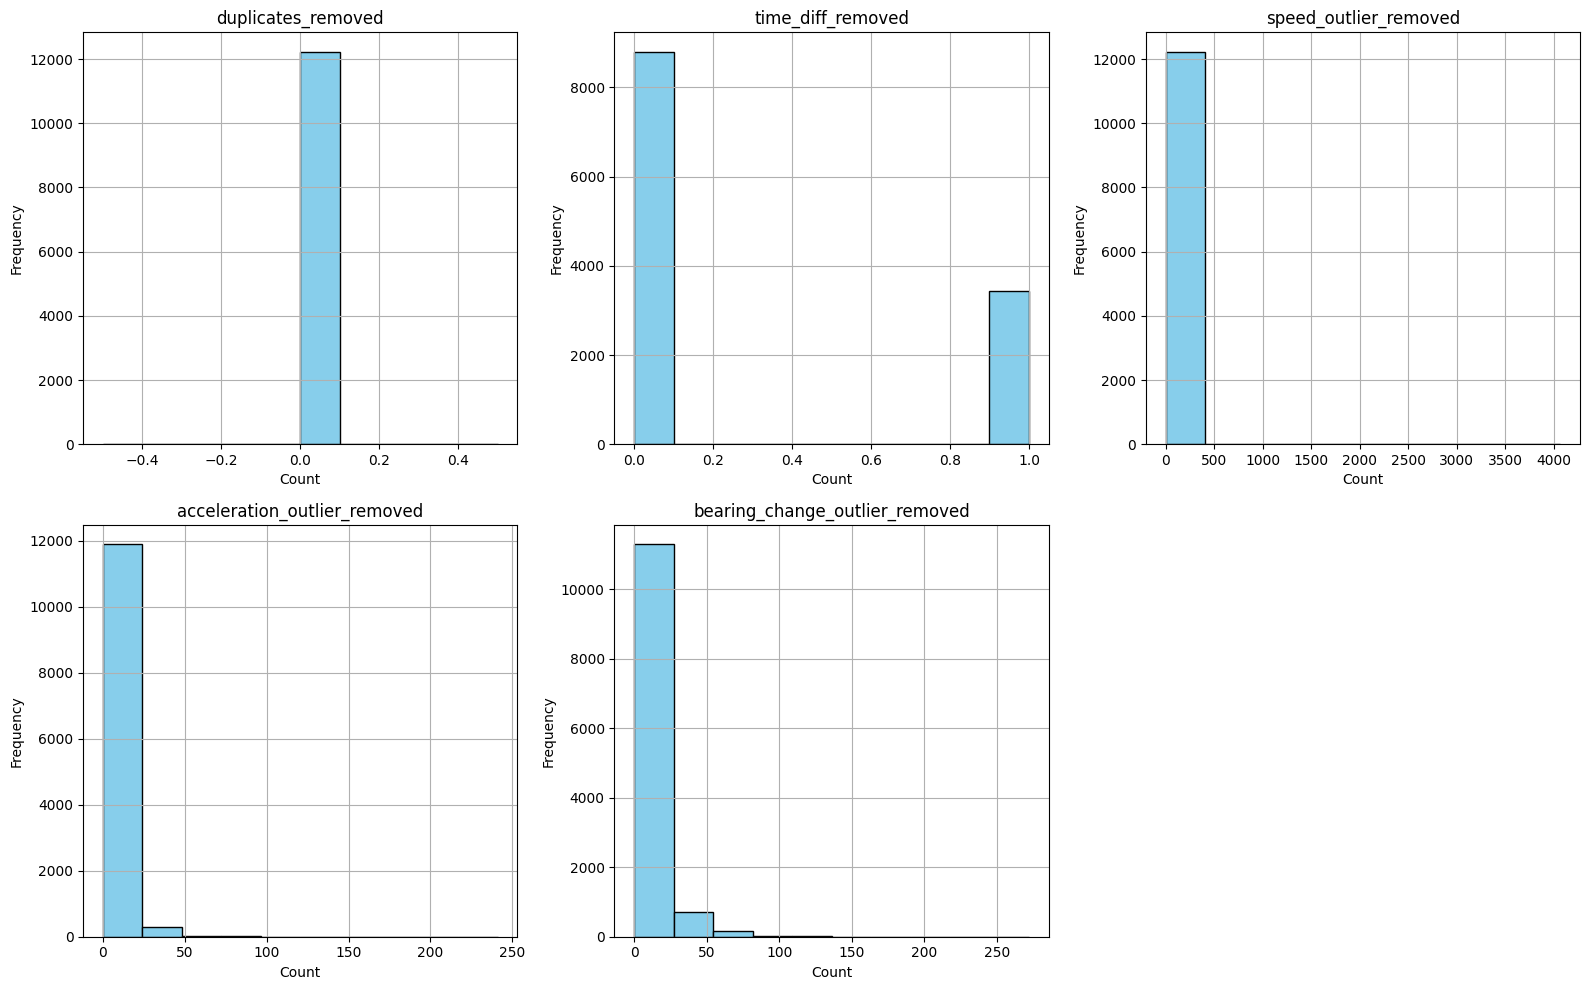

Cleaned subtrajectory separation complete.


In [11]:

# !! Important: to use this data for LLM prediction instead we need to remove the Normalization & Smoothing part which we did in the next cell.

def clean_and_normalize_subtraj(gdf, min_points=5):
    # Initialize a log dictionary to capture changes
    log = {}
    orig_count = len(gdf)
    log["original_count"] = orig_count

    # If 'datetime' is not present, try to create it from 'date' and 'time'
    if "datetime" not in gdf.columns:
        if "date" in gdf.columns and "time" in gdf.columns:
            try:
                gdf["datetime"] = pd.to_datetime(gdf["date"] + " " + gdf["time"], format="%Y-%m-%d %H:%M:%S")
            except Exception as e:
                print("Error creating 'datetime':", e)
        else:
            print("No datetime or date/time columns found; dropping duplicates based only on lat and lon.")
            cleaned = gdf.drop_duplicates(subset=["lat", "lon"]).copy()
            log["duplicates_removed"] = orig_count - len(cleaned)
            log["final_count"] = len(cleaned)
            return cleaned, log

    # Remove duplicate points based on lat, lon, and datetime.
    before_duplicates = len(gdf)
    gdf_clean = gdf.drop_duplicates(subset=["lat", "lon", "datetime"]).copy()
    log["duplicates_removed"] = before_duplicates - len(gdf_clean)

    # Remove rows with very small time differences if available.
    if 'time_diff' in gdf_clean.columns:
        before_time_diff = len(gdf_clean)
        gdf_clean = gdf_clean[gdf_clean['time_diff'] >= 1]
        log["time_diff_removed"] = before_time_diff - len(gdf_clean)
    else:
        log["time_diff_removed"] = 0

    # Outlier removal for speed, acceleration, and bearing_change.
    for col in ['speed', 'acceleration', 'bearing_change']:
        if col in gdf_clean.columns:
            before_outlier = len(gdf_clean)
            mean_val = gdf_clean[col].mean()
            std_val = gdf_clean[col].std()
            lower_bound = mean_val - 3 * std_val
            upper_bound = mean_val + 3 * std_val
            gdf_clean = gdf_clean[(gdf_clean[col] >= lower_bound) & (gdf_clean[col] <= upper_bound)]
            log[f"{col}_outlier_removed"] = before_outlier - len(gdf_clean)
        else:
            log[f"{col}_outlier_removed"] = 0

    # Validate segment length.
    if len(gdf_clean) < min_points:
        log["final_count"] = len(gdf_clean)
        # print("Not enough points after cleaning. Cleaning log:", log)
        return None, log

    log["final_count"] = len(gdf_clean)

    # Normalize key features (speed, acceleration, bearing_change).
    scaler = StandardScaler()
    for col in ['speed', 'acceleration', 'bearing_change']:
        if col in gdf_clean.columns:
            values = gdf_clean[[col]].values
            scaled_values = scaler.fit_transform(values)
            gdf_clean[f"{col}_norm"] = scaled_values

    # Additional noise reduction: Apply a rolling mean for smoothing.
    for col in ['speed', 'acceleration', 'bearing_change']:
        if col in gdf_clean.columns:
            gdf_clean[f"{col}_smooth"] = gdf_clean[col].rolling(window=3, min_periods=1, center=True).mean()

    return gdf_clean, log

# Define the output root folder for cleaned subtrajectories.
clean_subtraj_output_folder = "./Sub_Trajectories_Cleaned"
os.makedirs(clean_subtraj_output_folder, exist_ok=True)

# List to store cleaning logs for each subtrajectory
all_logs = []

# Process each enriched trajectory.
for traj in enriched_trajectories:
    # Use the trajectory's id (without '.plt') as the folder name.
    folder_name = traj.id.replace('.plt', '')
    traj_folder = os.path.join(clean_subtraj_output_folder, folder_name)
    os.makedirs(traj_folder, exist_ok=True)
    
    # Convert the trajectory to a GeoDataFrame.
    gdf = traj.to_point_gdf()
    
    # Ensure a transport_mode column exists.
    if 'transport_mode' not in gdf.columns:
        gdf['transport_mode'] = "Unknown"
    
    # Group points by transport mode.
    for mode, group in gdf.groupby('transport_mode'):
        # Skip subtrajectories with transport mode "Unknown"
        if mode.lower() == "unknown":
            continue
        
        # Clean and normalize the subtrajectory.
        cleaned_group, log = clean_and_normalize_subtraj(group, min_points=5)
        log["trajectory"] = folder_name
        log["mode"] = mode
        
        if cleaned_group is None:
            all_logs.append(log)
            continue
        
        # Reset the index without re-inserting the old index.
        cleaned_group = cleaned_group.reset_index(drop=True)
        
        output_file = os.path.join(traj_folder, f"{mode}_cleaned.geojson")
        cleaned_group.to_file(output_file, driver="GeoJSON")
        all_logs.append(log)

# Aggregate logs into a DataFrame for summary statistics.
logs_df = pd.DataFrame(all_logs)
print("Aggregated Cleaning Statistics:")
print(logs_df.describe())

# Plot histograms for key cleaning metrics.
metrics = ["duplicates_removed", "time_diff_removed", 
           "speed_outlier_removed", "acceleration_outlier_removed", "bearing_change_outlier_removed"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    if metric in logs_df.columns:
        logs_df[metric].hist(ax=axes[i], bins=10, color="skyblue", edgecolor="black")
        axes[i].set_title(metric)
        axes[i].set_xlabel("Count")
        axes[i].set_ylabel("Frequency")
    else:
        axes[i].axis("off")

# Hide any unused subplots.
for j in range(len(metrics), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

print("Cleaned subtrajectory separation complete.")

## Clean and Validate Subtrajectories for LLM (No Normalization)
Unlike the previous cell, this version does not apply normalization (or rolling mean smoothing)
so that the real-world values are preserved for LLM-based trip summary prediction.

In [27]:
def clean_subtraj_llm(gdf, min_points=5):
    # Initialize a log dictionary to capture changes
    log = {}
    orig_count = len(gdf)
    log["original_count"] = orig_count

    # Ensure a 'datetime' column exists; if not, try to create it from 'date' and 'time'
    if "datetime" not in gdf.columns:
        if "date" in gdf.columns and "time" in gdf.columns:
            try:
                gdf["datetime"] = pd.to_datetime(gdf["date"] + " " + gdf["time"], format="%Y-%m-%d %H:%M:%S")
            except Exception as e:
                print("Error creating 'datetime':", e)
        else:
            print("No datetime or date/time columns found; dropping duplicates based only on lat and lon.")
            cleaned = gdf.drop_duplicates(subset=["lat", "lon"]).copy()
            log["duplicates_removed"] = orig_count - len(cleaned)
            log["final_count"] = len(cleaned)
            return cleaned, log

    # Remove duplicate points based on lat, lon, and datetime.
    before_duplicates = len(gdf)
    gdf_clean = gdf.drop_duplicates(subset=["lat", "lon", "datetime"]).copy()
    log["duplicates_removed"] = before_duplicates - len(gdf_clean)

    # Remove rows with very small time differences if available.
    if 'time_diff' in gdf_clean.columns:
        before_time_diff = len(gdf_clean)
        gdf_clean = gdf_clean[gdf_clean['time_diff'] >= 1]
        log["time_diff_removed"] = before_time_diff - len(gdf_clean)
    else:
        log["time_diff_removed"] = 0

    # Outlier removal for speed, acceleration, and bearing_change.
    for col in ['speed', 'acceleration', 'bearing_change']:
        if col in gdf_clean.columns:
            before_outlier = len(gdf_clean)
            mean_val = gdf_clean[col].mean()
            std_val = gdf_clean[col].std()
            lower_bound = mean_val - 3 * std_val
            upper_bound = mean_val + 3 * std_val
            gdf_clean = gdf_clean[(gdf_clean[col] >= lower_bound) & (gdf_clean[col] <= upper_bound)]
            log[f"{col}_outlier_removed"] = before_outlier - len(gdf_clean)
        else:
            log[f"{col}_outlier_removed"] = 0

    # Validate segment length.
    if len(gdf_clean) < min_points:
        log["final_count"] = len(gdf_clean)
        return None, log  # Discard segments with too few points.

    log["final_count"] = len(gdf_clean)

    # Do not apply StandardScaler normalization or rolling mean smoothing.
    return gdf_clean, log

# Define the output root folder for cleaned LLM subtrajectories.
clean_llm_output_folder = "./Sub_Trajectories_Cleaned_LLM"
os.makedirs(clean_llm_output_folder, exist_ok=True)

# List to store cleaning logs for each subtrajectory.
all_logs_llm = []

# Process each enriched trajectory.
for traj in enriched_trajectories:
    # Use the trajectory's id (without '.plt') as the folder name.
    folder_name = traj.id.replace('.plt', '')
    traj_folder = os.path.join(clean_llm_output_folder, folder_name)
    os.makedirs(traj_folder, exist_ok=True)
    
    # Convert the trajectory to a GeoDataFrame.
    gdf = traj.to_point_gdf()
    
    # Ensure that a transport_mode column exists; if not, default to "Unknown".
    if 'transport_mode' not in gdf.columns:
        gdf['transport_mode'] = "Unknown"
    
    # Group points by transport mode.
    for mode, group in gdf.groupby('transport_mode'):
        # Skip subtrajectories with transport mode "Unknown".
        if mode.lower() == "unknown":
            continue
        
        # Clean the subtrajectory without normalization.
        cleaned_group, log = clean_subtraj_llm(group, min_points=5)
        log["trajectory"] = folder_name
        log["mode"] = mode
        
        if cleaned_group is None:
            all_logs_llm.append(log)
            continue
        
        # Reset the index without re-inserting the old index.
        cleaned_group = cleaned_group.reset_index(drop=True)
        
        output_file = os.path.join(traj_folder, f"{mode}_cleaned_llm.geojson")
        cleaned_group.to_file(output_file, driver="GeoJSON")
        all_logs_llm.append(log)
        # print(f"Saved LLM-ready subtrajectory for mode '{mode}' at: {output_file}")

# Optional: Aggregate logs into a DataFrame for summary statistics.
logs_df_llm = pd.DataFrame(all_logs_llm)
print("Aggregated Cleaning Statistics for LLM-ready data:")
print(logs_df_llm.describe())

print("Cleaned LLM subtrajectory separation complete.")

Aggregated Cleaning Statistics for LLM-ready data:
       original_count  duplicates_removed  time_diff_removed  \
count      207.000000               207.0         207.000000   
mean       196.985507                 0.0           0.304348   
std        319.324826                 0.0           0.461246   
min          1.000000                 0.0           0.000000   
25%         23.000000                 0.0           0.000000   
50%         67.000000                 0.0           0.000000   
75%        172.000000                 0.0           1.000000   
max       2139.000000                 0.0           1.000000   

       speed_outlier_removed  acceleration_outlier_removed  \
count             207.000000                    207.000000   
mean                1.492754                      2.908213   
std                 3.365833                      4.897620   
min                 0.000000                      0.000000   
25%                 0.000000                      0.000000   
